In [1]:
import numpy as np
import pandas as pd

def benchmark(x1, x2):
    return (    (1.3356 * (1.5 * (1 - x1))) 
                + (np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2)))
                + (np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))
            )

def getData(grid):
    x1 = np.linspace(0, 1, grid)
    x2 = np.linspace(0, 1, grid)
    x1, x2 = np.meshgrid(x1, x2)
    f_x1_x2 = benchmark(x1, x2)
    data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': f_x1_x2.flatten()}
    df = pd.DataFrame(data)
    return df


df_1000 = getData(32)
df_test = pd.read_excel("../Kriging-data.xlsx", sheet_name="Test")
df_training = pd.read_excel("../Kriging-data.xlsx", sheet_name="Training")
df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Power")

/tmp/ipykernel_11976/1135360396.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


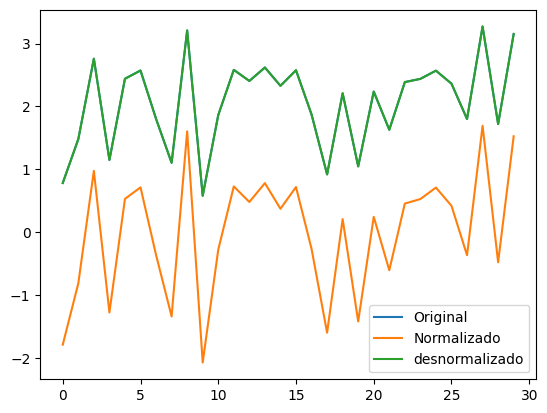

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-09-10 10:20:15.077801: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 10:20:15.077851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 10:20:15.079905: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-10 10:20:15.096530: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-10 10:20:19.536943: W tensorflow/compiler/tf2

In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[4], [8], [12], [24], [36],
                            [4, 2], [8, 4], [12, 6], [24, 12], [36, 18]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[4], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_0_8  0.115948  0.048110  0.095104  0.080085  0.137631  0.565083   
model_1_0_9  0.155858  0.046023  0.095636  0.125152  0.131418  0.566322   
model_1_0_7  0.060988  0.004778  0.066079  0.057054  0.146187  0.590807   
model_1_0_6  0.048416  0.000101  0.061168  0.043395  0.148144  0.593583   
model_1_0_5  0.035307 -0.004925  0.056136  0.028751  0.150185  0.596567   
model_1_0_4  0.021691 -0.010341  0.050792  0.013359  0.152305  0.599782   
model_1_0_3  0.007675 -0.015872  0.045422 -0.002966  0.154487  0.603065   
model_1_0_2 -0.006360 -0.019766  0.042647 -0.026866  0.156672  0.605377   
model_1_0_1 -0.018559 -0.029204  0.035276 -0.033532  0.158571  0.610980   
model_1_0_0 -0.121003 -0.084452 -0.156366 -0.272589  0.174520  0.643778   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_0_8  0.633898  0.088462  0.156628  0.370986 -0.018239  0.373873   
model_1_0_9  0.633526  0.084128  0.151200  0.362516  0.027729  0.365337   
model_1_0_7  0.654231  0.090677  0.164875  0.382344 -0.081540  0.385320   
model_1_0_6  0.657671  0.091990  0.166235  0.384895 -0.096020  0.387890   
model_1_0_5  0.661197  0.093398  0.167627  0.387537 -0.111120  0.390553   
model_1_0_4  0.664940  0.094878  0.169039  0.390263 -0.126802  0.393300   
model_1_0_3  0.668702  0.096448  0.170461  0.393048 -0.142946  0.396107   
model_1_0_2  0.670646  0.098747  0.171949  0.395818 -0.159111  0.398898   
model_1_0_1  0.675809  0.099388  0.173592  0.398210 -0.173162  0.401309   
model_1_0_0  0.810059  0.122376  0.187658  0.417756 -0.291155  0.421007   

                   aic        bic  
model_1_0_8  37.966360  86.714445  
model_1_0_9  38.058750  86.806835  
model_1_0_7  37.845736  86.593822  
model_1_0_6  37.819137  86.567223  
model_1_0_5  37.791772  86.539858  
model_1_0_4  37.763741  86.511827  
model_1_0_3  37.735291  86.483376  
model_1_0_2  37.707202  86.455288  
model_1_0_1  37.683103  86.431189  
model_1_0_0  37.491434  86.239520

DataFrame salvo em ../results/metrics_1_0
+++++++++++ [1_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_1] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_1] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_1] | 8 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_1] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_1_9  0.469728  0.271161  0.306517  0.425819  0.082554  0.432671   
model_1_1_8  0.462667  0.264788  0.300703  0.418658  0.083653  0.436453   
model_1_1_7  0.458468  0.262339  0.298199  0.415672  0.084307  0.437907   
model_1_1_6  0.396707  0.225587  0.261528  0.371938  0.093922  0.459725   
model_1_1_5  0.391147  0.222621  0.258594  0.368308  0.094787  0.461486   
model_1_1_4  0.353000  0.194578  0.233477  0.335800  0.100726  0.478133   
model_1_1_3  0.346953  0.190685  0.229830  0.331063  0.101668  0.480445   
model_1_1_2  0.241873  0.107372  0.151113  0.245661  0.118027  0.529903   
model_1_1_1  0.226080  0.088747  0.139623  0.225595  0.120485  0.540959   
model_1_1_0  0.161879  0.052421  0.100559  0.184105  0.130480  0.562524   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_1_9  0.485799  0.125314  0.106284  0.287322  0.389241  0.289558   
model_1_1_8  0.489872  0.126877  0.107573  0.289228  0.381108  0.291479   
model_1_1_7  0.491626  0.127529  0.108236  0.290356  0.376271  0.292616   
model_1_1_6  0.517315  0.137074  0.117697  0.306467  0.305135  0.308852   
model_1_1_5  0.519370  0.137866  0.118494  0.307876  0.298731  0.310272   
model_1_1_4  0.536966  0.144961  0.124522  0.317374  0.254795  0.319844   
model_1_1_3  0.539520  0.145995  0.125415  0.318853  0.247830  0.321335   
model_1_1_2  0.594663  0.164633  0.140522  0.343550  0.126800  0.346224   
model_1_1_1  0.602712  0.169013  0.143261  0.347110  0.108610  0.349811   
model_1_1_0  0.630077  0.178068  0.150215  0.361220  0.034664  0.364032   

                   aic        bic  
model_1_1_9  38.988613  87.736699  
model_1_1_8  38.962157  87.710243  
model_1_1_7  38.946588  87.694674  
model_1_1_6  38.730586  87.478671  
model_1_1_5  38.712237  87.460323  
model_1_1_4  38.590700  87.338786  
model_1_1_3  38.572095  87.320181  
model_1_1_2  38.273689  87.021775  
model_1_1_1  38.232455  86.980541  
model_1_1_0  38.073068  86.821153

DataFrame salvo em ../results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_2] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_2] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_2] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_2] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_2] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_2] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_2_9  0.571995  0.362165  0.385055  0.566543  0.066633  0.378646   
model_1_2_8  0.569430  0.360745  0.383692  0.564452  0.067032  0.379490   
model_1_2_7  0.566733  0.359323  0.382306  0.562168  0.067452  0.380334   
model_1_2_6  0.561607  0.356059  0.379355  0.558092  0.068250  0.382271   
model_1_2_5  0.557515  0.351811  0.376043  0.555744  0.068887  0.384793   
model_1_2_4  0.557618  0.348164  0.374008  0.557916  0.068871  0.386958   
model_1_2_3  0.529401  0.320891  0.352041  0.537214  0.073264  0.403148   
model_1_2_2  0.498421  0.297261  0.331112  0.510665  0.078087  0.417176   
model_1_2_1  0.494443  0.294665  0.328664  0.507055  0.078706  0.418717   
model_1_2_0  0.484383  0.284029  0.319510  0.499386  0.080272  0.425031   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_2_9  0.430781  0.064756  0.094637  0.258133  0.507030  0.260142   
model_1_2_8  0.431737  0.065068  0.094947  0.258905  0.504075  0.260920   
model_1_2_7  0.432708  0.065409  0.095275  0.259715  0.500969  0.261736   
model_1_2_6  0.434774  0.066018  0.095856  0.261247  0.495066  0.263280   
model_1_2_5  0.437095  0.066369  0.096204  0.262463  0.490352  0.264506   
model_1_2_4  0.438521  0.066045  0.095924  0.262433  0.490470  0.264475   
model_1_2_3  0.453909  0.069137  0.098546  0.270673  0.457971  0.272779   
model_1_2_2  0.468570  0.073104  0.102300  0.279440  0.422288  0.281615   
model_1_2_1  0.470285  0.073643  0.102842  0.280546  0.417707  0.282729   
model_1_2_0  0.476697  0.074789  0.104122  0.283323  0.406120  0.285528   

                   aic        bic  
model_1_2_9  39.417124  88.165210  
model_1_2_8  39.405171  88.153257  
model_1_2_7  39.392683  88.140768  
model_1_2_6  39.369162  88.117248  
model_1_2_5  39.350581  88.098666  
model_1_2_4  39.351043  88.099129  
model_1_2_3  39.227381  87.975467  
model_1_2_2  39.099868  87.847954  
model_1_2_1  39.084073  87.832158  
model_1_2_0  39.044664  87.792750

DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_3] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_3] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_3_9  0.618191  0.412041  0.430785  0.678873  0.059441  0.349038   
model_1_3_8  0.616570  0.411248  0.429657  0.677184  0.059693  0.349508   
model_1_3_7  0.614102  0.390073  0.417285  0.692554  0.060077  0.362079   
model_1_3_6  0.612139  0.389201  0.415960  0.690421  0.060383  0.362597   
model_1_3_5  0.610151  0.388305  0.414613  0.688271  0.060692  0.363129   
model_1_3_4  0.602124  0.383900  0.408885  0.679826  0.061942  0.365744   
model_1_3_3  0.599414  0.380272  0.405590  0.679626  0.062364  0.367897   
model_1_3_2  0.597191  0.379159  0.404078  0.677213  0.062710  0.368558   
model_1_3_1  0.582272  0.368318  0.392229  0.663530  0.065033  0.374993   
model_1_3_0  0.574782  0.363662  0.386865  0.655611  0.066199  0.377758   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_3_9  0.398747  0.027570  0.090302  0.243805  0.560238  0.245702   
model_1_3_8  0.399537  0.027715  0.090455  0.244322  0.558371  0.246223   
model_1_3_7  0.408204  0.026395  0.089731  0.245107  0.555528  0.247014   
model_1_3_6  0.409132  0.026579  0.089987  0.245729  0.553267  0.247642   
model_1_3_5  0.410076  0.026763  0.090245  0.246358  0.550977  0.248276   
model_1_3_4  0.414088  0.027488  0.091283  0.248882  0.541732  0.250819   
model_1_3_3  0.416396  0.027505  0.091467  0.249728  0.538611  0.251671   
model_1_3_2  0.417455  0.027713  0.091746  0.250420  0.536051  0.252368   
model_1_3_1  0.425756  0.028887  0.093376  0.255015  0.518867  0.257000   
model_1_3_0  0.429514  0.029567  0.094286  0.257291  0.510240  0.259294   

                   aic        bic  
model_1_3_9  39.645552  88.393638  
model_1_3_8  39.637079  88.385165  
model_1_3_7  39.624246  88.372331  
model_1_3_6  39.614097  88.362183  
model_1_3_5  39.603873  88.351958  
model_1_3_4  39.563110  88.311195  
model_1_3_3  39.549538  88.297623  
model_1_3_2  39.538468  88.286554  
model_1_3_1  39.465733  88.213818  
model_1_3_0  39.430187  88.178272

DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_4] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_4_9  0.631968  0.415610  0.438677  0.511849  0.057296  0.346919   
model_1_4_8  0.630682  0.415383  0.437987  0.511885  0.057496  0.347054   
model_1_4_7  0.629568  0.415109  0.437281  0.511951  0.057670  0.347217   
model_1_4_6  0.628233  0.414803  0.436545  0.511978  0.057877  0.347398   
model_1_4_5  0.626873  0.414482  0.435789  0.511998  0.058089  0.347589   
model_1_4_4  0.625507  0.414166  0.435020  0.512009  0.058302  0.347777   
model_1_4_3  0.624094  0.413788  0.434218  0.512016  0.058522  0.348001   
model_1_4_2  0.622668  0.413409  0.433402  0.512015  0.058744  0.348225   
model_1_4_1  0.621201  0.412970  0.432551  0.512011  0.058972  0.348486   
model_1_4_0  0.619708  0.412518  0.431680  0.511999  0.059204  0.348754   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_4_9  0.393218  0.086015  0.088683  0.239366  0.576105  0.241229   
model_1_4_8  0.393702  0.086008  0.088827  0.239783  0.574625  0.241650   
model_1_4_7  0.394197  0.085997  0.088931  0.240145  0.573341  0.242014   
model_1_4_6  0.394712  0.085992  0.089089  0.240577  0.571804  0.242449   
model_1_4_5  0.395241  0.085989  0.089248  0.241017  0.570237  0.242893   
model_1_4_4  0.395780  0.085987  0.089403  0.241458  0.568664  0.243337   
model_1_4_3  0.396342  0.085985  0.089567  0.241913  0.567037  0.243795   
model_1_4_2  0.396914  0.085986  0.089738  0.242371  0.565395  0.244257   
model_1_4_1  0.397510  0.085986  0.089917  0.242842  0.563705  0.244732   
model_1_4_0  0.398120  0.085988  0.090109  0.243320  0.561986  0.245213   

                   aic        bic  
model_1_4_9  39.719050  88.467136  
model_1_4_8  39.712076  88.460161  
model_1_4_7  39.706050  88.454136  
model_1_4_6  39.698857  88.446943  
model_1_4_5  39.691553  88.439639  
model_1_4_4  39.684245  88.432331  
model_1_4_3  39.676714  88.424800  
model_1_4_2  39.669143  88.417229  
model_1_4_1  39.661381  88.409466  
model_1_4_0  39.653516  88.401601

DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_5] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_5_9  0.663154  0.446426  0.462787  0.588842  0.052441  0.328626   
model_1_5_8  0.660842  0.445077  0.461348  0.588136  0.052801  0.329426   
model_1_5_7  0.653872  0.438914  0.456330  0.586880  0.053886  0.333085   
model_1_5_6  0.653136  0.438306  0.455749  0.586954  0.054001  0.333446   
model_1_5_5  0.639292  0.420779  0.443494  0.588118  0.056156  0.343850   
model_1_5_4  0.638393  0.419819  0.442703  0.588252  0.056296  0.344420   
model_1_5_3  0.637098  0.419022  0.441924  0.587603  0.056497  0.344894   
model_1_5_2  0.636015  0.418139  0.441126  0.587418  0.056666  0.345418   
model_1_5_1  0.634680  0.417310  0.440322  0.586744  0.056874  0.345910   
model_1_5_0  0.633338  0.416467  0.439505  0.586086  0.057083  0.346411   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_5_9  0.376329  0.034067  0.086316  0.229000  0.612025  0.230782   
model_1_5_8  0.377337  0.034125  0.086527  0.229784  0.609363  0.231572   
model_1_5_7  0.380852  0.034230  0.087107  0.232133  0.601335  0.233940   
model_1_5_6  0.381259  0.034223  0.087152  0.232380  0.600486  0.234189   
model_1_5_5  0.389844  0.034127  0.087956  0.236972  0.584541  0.238816   
model_1_5_4  0.390398  0.034116  0.088017  0.237267  0.583507  0.239113   
model_1_5_3  0.390944  0.034170  0.088157  0.237691  0.582015  0.239541   
model_1_5_2  0.391503  0.034185  0.088252  0.238046  0.580767  0.239898   
model_1_5_1  0.392066  0.034241  0.088393  0.238482  0.579230  0.240338   
model_1_5_0  0.392639  0.034295  0.088535  0.238920  0.577683  0.240779   

                   aic        bic  
model_1_5_9  39.896138  88.644224  
model_1_5_8  39.882462  88.630548  
model_1_5_7  39.841776  88.589862  
model_1_5_6  39.837524  88.585610  
model_1_5_5  39.759253  88.507339  
model_1_5_4  39.754278  88.502363  
model_1_5_3  39.747129  88.495215  
model_1_5_2  39.741167  88.489252  
model_1_5_1  39.733846  88.481931  
model_1_5_0  39.726509  88.474595

DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_6] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_6] | 9 ++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_6_0  0.665522  0.445286  0.463510  0.662239  0.052072  0.329302   
model_1_6_1  0.669026  0.443210  0.464565  0.661492  0.051527  0.330535   
model_1_6_3  0.676545  0.441221  0.467377  0.658803  0.050356  0.331715   
model_1_6_2  0.673571  0.440580  0.465981  0.660200  0.050819  0.332096   
model_1_6_4  0.679069  0.440538  0.468744  0.657272  0.049963  0.332121   
model_1_6_5  0.679505  0.439905  0.468788  0.657073  0.049895  0.332497   
model_1_6_6  0.679944  0.439292  0.468829  0.656867  0.049827  0.332860   
model_1_6_7  0.681600  0.438249  0.469232  0.655815  0.049569  0.333480   
model_1_6_8  0.684905  0.434374  0.469649  0.653463  0.049055  0.335780   
model_1_6_9  0.685187  0.433708  0.469651  0.653265  0.049011  0.336175   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_6_0  0.375822  0.080831  0.086041  0.228193  0.614753  0.229969   
model_1_6_1  0.375083  0.081010  0.085663  0.226995  0.618789  0.228761   
model_1_6_3  0.373114  0.081653  0.085467  0.224401  0.627450  0.226148   
model_1_6_2  0.374091  0.081319  0.085376  0.225431  0.624024  0.227185   
model_1_6_4  0.372156  0.082020  0.085769  0.223524  0.630357  0.225264   
model_1_6_5  0.372125  0.082067  0.085766  0.223372  0.630859  0.225111   
model_1_6_6  0.372096  0.082117  0.085761  0.223219  0.631365  0.224956   
model_1_6_7  0.371814  0.082368  0.085840  0.222641  0.633271  0.224374   
model_1_6_8  0.371522  0.082931  0.085895  0.221483  0.637078  0.223206   
model_1_6_9  0.371521  0.082979  0.085892  0.221383  0.637403  0.223106   

                   aic        bic  
model_1_6_0  39.910250  88.658335  
model_1_6_1  39.931313  88.679399  
model_1_6_3  39.977275  88.725361  
model_1_6_2  39.958967  88.707053  
model_1_6_4  39.992942  88.741028  
model_1_6_5  39.995661  88.743747  
model_1_6_6  39.998403  88.746489  
model_1_6_7  40.008775  88.756861  
model_1_6_8  40.029641  88.777727  
model_1_6_9  40.031436  88.779521

DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Stopped at epoch:  40
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_7] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_7_9  0.696281  0.446884  0.489205  0.689896  0.047283  0.328354   
model_1_7_8  0.696205  0.446608  0.488973  0.690298  0.047295  0.328517   
model_1_7_7  0.696126  0.446317  0.488739  0.690703  0.047308  0.328690   
model_1_7_6  0.696045  0.446029  0.488503  0.691108  0.047320  0.328861   
model_1_7_5  0.692189  0.434525  0.478838  0.707124  0.047921  0.335690   
model_1_7_4  0.691912  0.434486  0.478217  0.708115  0.047964  0.335713   
model_1_7_0  0.685885  0.433501  0.470392  0.717813  0.048902  0.336299   
model_1_7_1  0.686921  0.433352  0.471485  0.716684  0.048741  0.336387   
model_1_7_2  0.687531  0.433115  0.472194  0.715876  0.048646  0.336528   
model_1_7_3  0.688441  0.433005  0.473242  0.714688  0.048504  0.336593   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_7_9  0.357823  0.036459  0.087260  0.217448  0.650181  0.219140   
model_1_7_8  0.357985  0.036412  0.087240  0.217475  0.650093  0.219168   
model_1_7_7  0.358149  0.036364  0.087220  0.217503  0.650002  0.219196   
model_1_7_6  0.358314  0.036316  0.087200  0.217532  0.649909  0.219225   
model_1_7_5  0.365085  0.034433  0.086368  0.218908  0.645468  0.220611   
model_1_7_4  0.365520  0.034317  0.086310  0.219006  0.645148  0.220711   
model_1_7_0  0.371002  0.033177  0.085920  0.221138  0.638207  0.222859   
model_1_7_1  0.370236  0.033309  0.085961  0.220773  0.639401  0.222491   
model_1_7_2  0.369739  0.033404  0.085996  0.220558  0.640103  0.222274   
model_1_7_3  0.369005  0.033544  0.086040  0.220236  0.641151  0.221950   

                   aic        bic  
model_1_7_9  40.103189  88.851274  
model_1_7_8  40.102683  88.850769  
model_1_7_7  40.102167  88.850253  
model_1_7_6  40.101635  88.849721  
model_1_7_5  40.076421  88.824507  
model_1_7_4  40.074620  88.822706  
model_1_7_0  40.035872  88.783958  
model_1_7_1  40.042484  88.790570  
model_1_7_2  40.046382  88.794468  
model_1_7_3  40.052215  88.800300

DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  40
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_8] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_8_9  0.699398  0.456004  0.502500  0.665595  0.046798  0.322940   
model_1_8_8  0.699395  0.455858  0.502257  0.666127  0.046799  0.323026   
model_1_8_7  0.699390  0.455711  0.502012  0.666663  0.046800  0.323114   
model_1_8_6  0.699383  0.455560  0.501765  0.667201  0.046801  0.323203   
model_1_8_5  0.699374  0.455408  0.501515  0.667742  0.046802  0.323293   
model_1_8_4  0.699362  0.455256  0.501263  0.668285  0.046804  0.323384   
model_1_8_3  0.699349  0.455097  0.501008  0.668831  0.046806  0.323478   
model_1_8_2  0.699334  0.454936  0.500751  0.669380  0.046808  0.323573   
model_1_8_1  0.699316  0.454773  0.500491  0.669931  0.046811  0.323670   
model_1_8_0  0.699296  0.454607  0.500229  0.670485  0.046814  0.323769   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_8_9  0.348509  0.064975  0.086474  0.216329  0.653771  0.218013   
model_1_8_8  0.348679  0.064872  0.086487  0.216330  0.653767  0.218014   
model_1_8_7  0.348851  0.064768  0.086500  0.216332  0.653761  0.218016   
model_1_8_6  0.349024  0.064663  0.086513  0.216335  0.653753  0.218018   
model_1_8_5  0.349199  0.064558  0.086526  0.216338  0.653743  0.218021   
model_1_8_4  0.349376  0.064452  0.086539  0.216342  0.653730  0.218026   
model_1_8_3  0.349554  0.064346  0.086553  0.216347  0.653715  0.218030   
model_1_8_2  0.349734  0.064240  0.086567  0.216352  0.653697  0.218036   
model_1_8_1  0.349916  0.064133  0.086580  0.216359  0.653676  0.218042   
model_1_8_0  0.350100  0.064025  0.086594  0.216366  0.653653  0.218050   

                   aic        bic  
model_1_8_9  40.123817  88.871903  
model_1_8_8  40.123796  88.871882  
model_1_8_7  40.123762  88.871848  
model_1_8_6  40.123716  88.871802  
model_1_8_5  40.123656  88.871742  
model_1_8_4  40.123581  88.871667  
model_1_8_3  40.123493  88.871579  
model_1_8_2  40.123390  88.871476  
model_1_8_1  40.123271  88.871357  
model_1_8_0  40.123137  88.871223

DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_9] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_9_0  0.699494  0.455939  0.502436  0.843968  0.046783  0.322978   
model_1_9_1  0.699588  0.455874  0.502369  0.843568  0.046769  0.323016   
model_1_9_2  0.699680  0.455817  0.502301  0.843167  0.046754  0.323051   
model_1_9_3  0.699769  0.455758  0.502232  0.842764  0.046741  0.323085   
model_1_9_4  0.699856  0.455705  0.502161  0.842360  0.046727  0.323117   
model_1_9_5  0.699940  0.455653  0.502089  0.841954  0.046714  0.323148   
model_1_9_6  0.700023  0.455604  0.502015  0.841547  0.046701  0.323177   
model_1_9_7  0.700103  0.455557  0.501940  0.841139  0.046689  0.323205   
model_1_9_8  0.700181  0.455512  0.501864  0.840730  0.046676  0.323232   
model_1_9_9  0.700256  0.455469  0.501786  0.840319  0.046665  0.323257   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_9_0  0.348554  0.009955  0.086484  0.216294  0.653882  0.217978   
model_1_9_1  0.348601  0.009980  0.086497  0.216261  0.653990  0.217944   
model_1_9_2  0.348648  0.010006  0.086510  0.216228  0.654096  0.217910   
model_1_9_3  0.348697  0.010032  0.086523  0.216196  0.654198  0.217878   
model_1_9_4  0.348747  0.010057  0.086539  0.216164  0.654298  0.217847   
model_1_9_5  0.348797  0.010083  0.086554  0.216134  0.654395  0.217816   
model_1_9_6  0.348849  0.010109  0.086570  0.216104  0.654490  0.217786   
model_1_9_7  0.348902  0.010135  0.086585  0.216075  0.654582  0.217757   
model_1_9_8  0.348955  0.010161  0.086600  0.216047  0.654672  0.217729   
model_1_9_9  0.349009  0.010188  0.086615  0.216020  0.654760  0.217701   

                   aic        bic  
model_1_9_0  40.124458  88.872544  
model_1_9_1  40.125084  88.873170  
model_1_9_2  40.125695  88.873780  
model_1_9_3  40.126288  88.874374  
model_1_9_4  40.126866  88.874952  
model_1_9_5  40.127429  88.875515  
model_1_9_6  40.127978  88.876064  
model_1_9_7  40.128512  88.876597  
model_1_9_8  40.129031  88.877117  
model_1_9_9  40.129537  88.877623

DataFrame salvo em ../results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_10] | 9 +++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_10_0  0.700326  0.454986  0.501145  0.737804  0.046654  0.323544   
model_1_10_1  0.700394  0.454503  0.500506  0.737549  0.046643  0.323830   
model_1_10_2  0.700459  0.454028  0.499871  0.737295  0.046633  0.324113   
model_1_10_3  0.700522  0.453548  0.499239  0.737044  0.046623  0.324397   
model_1_10_4  0.700582  0.453069  0.498609  0.736793  0.046614  0.324682   
model_1_10_5  0.700640  0.452591  0.497982  0.736545  0.046605  0.324966   
model_1_10_6  0.700696  0.452134  0.497361  0.736297  0.046596  0.325237   
model_1_10_7  0.700750  0.451656  0.496740  0.736052  0.046588  0.325520   
model_1_10_8  0.700802  0.451190  0.496125  0.735808  0.046580  0.325797   
model_1_10_9  0.700851  0.450725  0.495512  0.735565  0.046572  0.326073   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_10_0  0.349458  0.060987  0.086578  0.215995  0.654840  0.217676   
model_1_10_1  0.349906  0.061046  0.086541  0.215970  0.654918  0.217651   
model_1_10_2  0.350350  0.061105  0.086504  0.215947  0.654993  0.217628   
model_1_10_3  0.350794  0.061164  0.086467  0.215924  0.655065  0.217605   
model_1_10_4  0.351235  0.061222  0.086432  0.215903  0.655135  0.217583   
model_1_10_5  0.351674  0.061280  0.086396  0.215882  0.655202  0.217562   
model_1_10_6  0.352109  0.061338  0.086361  0.215861  0.655266  0.217541   
model_1_10_7  0.352544  0.061395  0.086326  0.215842  0.655328  0.217522   
model_1_10_8  0.352975  0.061451  0.086291  0.215823  0.655388  0.217503   
model_1_10_9  0.353404  0.061508  0.086257  0.215806  0.655445  0.217485   

                    aic        bic  
model_1_10_0  40.130004  88.878089  
model_1_10_1  40.130455  88.878540  
model_1_10_2  40.130889  88.878975  
model_1_10_3  40.131309  88.879394  
model_1_10_4  40.131712  88.879798  
model_1_10_5  40.132100  88.880186  
model_1_10_6  40.132474  88.880560  
model_1_10_7  40.132833  88.880919  
model_1_10_8  40.133178  88.881264  
model_1_10_9  40.133509  88.881595

DataFrame salvo em ../results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_11] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_11_9  0.698403  0.454477  0.482593  0.658988  0.046953  0.323846   
model_1_11_0  0.700866  0.449985  0.494915  0.682045  0.046570  0.326513   
model_1_11_8  0.699742  0.449699  0.488462  0.670191  0.046745  0.326682   
model_1_11_1  0.700869  0.449309  0.494330  0.681077  0.046569  0.326914   
model_1_11_2  0.700830  0.448784  0.493747  0.680074  0.046575  0.327226   
model_1_11_3  0.700803  0.448270  0.493196  0.679136  0.046580  0.327531   
model_1_11_5  0.700567  0.448063  0.492151  0.677196  0.046616  0.327654   
model_1_11_4  0.700710  0.448045  0.492665  0.678162  0.046594  0.327665   
model_1_11_7  0.700330  0.447980  0.491197  0.675416  0.046653  0.327703   
model_1_11_6  0.700486  0.447850  0.491654  0.676314  0.046629  0.327780   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_11_9  0.362455  0.079571  0.086792  0.216687  0.652625  0.218373   
model_1_11_0  0.353823  0.074191  0.086264  0.215800  0.655462  0.217479   
model_1_11_8  0.358343  0.076957  0.086502  0.216205  0.654167  0.217888   
model_1_11_1  0.354232  0.074417  0.086271  0.215799  0.655465  0.217479   
model_1_11_2  0.354641  0.074651  0.086290  0.215813  0.655421  0.217493   
model_1_11_3  0.355027  0.074870  0.086301  0.215823  0.655389  0.217503   
model_1_11_5  0.355759  0.075323  0.086363  0.215908  0.655118  0.217588   
model_1_11_4  0.355398  0.075097  0.086328  0.215857  0.655282  0.217536   
model_1_11_7  0.356427  0.075738  0.086407  0.215993  0.654845  0.217674   
model_1_11_6  0.356107  0.075529  0.086378  0.215937  0.655025  0.217618   

                    aic        bic  
model_1_11_9  40.117211  88.865297  
model_1_11_0  40.133612  88.881698  
model_1_11_8  40.126108  88.874193  
model_1_11_1  40.133629  88.881715  
model_1_11_2  40.133371  88.881457  
model_1_11_3  40.133188  88.881274  
model_1_11_5  40.131614  88.879700  
model_1_11_4  40.132564  88.880650  
model_1_11_7  40.130031  88.878116  
model_1_11_6  40.131073  88.879159

DataFrame salvo em ../results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_12] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_12] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_12_1  0.699879  0.455906  0.488454  0.592215  0.046723  0.322998   
model_1_12_2  0.700077  0.455739  0.489265  0.591241  0.046693  0.323097   
model_1_12_3  0.700178  0.455493  0.489660  0.590806  0.046677  0.323243   
model_1_12_4  0.700257  0.455084  0.490555  0.589860  0.046665  0.323486   
model_1_12_5  0.700426  0.454885  0.491313  0.588884  0.046638  0.323604   
model_1_12_0  0.698518  0.454835  0.483083  0.598947  0.046935  0.323633   
model_1_12_6  0.700511  0.454667  0.491682  0.588428  0.046625  0.323733   
model_1_12_7  0.700594  0.454331  0.492049  0.588001  0.046612  0.323933   
model_1_12_8  0.700787  0.454062  0.493144  0.586503  0.046582  0.324092   
model_1_12_9  0.701163  0.452688  0.494385  0.583575  0.046524  0.324908   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_12_1  0.358349  0.044611  0.086930  0.216156  0.654324  0.217838   
model_1_12_2  0.357781  0.044718  0.086954  0.216085  0.654553  0.217766   
model_1_12_3  0.357504  0.044765  0.086967  0.216048  0.654670  0.217729   
model_1_12_4  0.356877  0.044869  0.087018  0.216020  0.654760  0.217701   
model_1_12_5  0.356346  0.044976  0.087043  0.215959  0.654955  0.217639   
model_1_12_0  0.362111  0.043875  0.086804  0.216645  0.652758  0.218331   
model_1_12_6  0.356087  0.045026  0.087054  0.215928  0.655053  0.217608   
model_1_12_7  0.355830  0.045072  0.087066  0.215898  0.655149  0.217578   
model_1_12_8  0.355063  0.045236  0.087105  0.215829  0.655371  0.217508   
model_1_12_9  0.354194  0.045557  0.087071  0.215693  0.655803  0.217372   

                    aic        bic  
model_1_12_1  40.127018  88.875103  
model_1_12_2  40.128341  88.876427  
model_1_12_3  40.129016  88.877102  
model_1_12_4  40.129540  88.877626  
model_1_12_5  40.130671  88.878756  
model_1_12_0  40.117973  88.866059  
model_1_12_6  40.131240  88.879326  
model_1_12_7  40.131793  88.879879  
model_1_12_8  40.133082  88.881168  
model_1_12_9  40.135593  88.883678

DataFrame salvo em ../results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  52
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_13] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_13_9  0.698297  0.494040  0.485578  0.604688  0.046970  0.300360   
model_1_13_8  0.698346  0.493803  0.485735  0.605352  0.046962  0.300500   
model_1_13_7  0.698394  0.493557  0.485894  0.606024  0.046955  0.300646   
model_1_13_6  0.698443  0.493302  0.486055  0.606706  0.046947  0.300798   
model_1_13_5  0.698494  0.493032  0.486220  0.607404  0.046939  0.300958   
model_1_13_4  0.698544  0.492751  0.486386  0.608111  0.046931  0.301125   
model_1_13_3  0.698593  0.492465  0.486556  0.608821  0.046924  0.301295   
model_1_13_2  0.698643  0.492163  0.486727  0.609546  0.046916  0.301474   
model_1_13_1  0.698693  0.491851  0.486901  0.610278  0.046908  0.301659   
model_1_13_0  0.698744  0.491521  0.487078  0.611026  0.046900  0.301855   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_13_9  0.360363  0.060671  0.086266  0.216725  0.652503  0.218412   
model_1_13_8  0.360253  0.060569  0.086281  0.216707  0.652559  0.218394   
model_1_13_7  0.360142  0.060466  0.086297  0.216690  0.652615  0.218376   
model_1_13_6  0.360029  0.060361  0.086312  0.216672  0.652671  0.218358   
model_1_13_5  0.359914  0.060254  0.086328  0.216654  0.652729  0.218340   
model_1_13_4  0.359797  0.060146  0.086344  0.216636  0.652787  0.218322   
model_1_13_3  0.359679  0.060037  0.086360  0.216618  0.652844  0.218304   
model_1_13_2  0.359558  0.059926  0.086377  0.216600  0.652902  0.218286   
model_1_13_1  0.359436  0.059813  0.086394  0.216582  0.652959  0.218268   
model_1_13_0  0.359312  0.059699  0.086412  0.216564  0.653018  0.218250   

                    aic        bic  
model_1_13_9  40.116506  88.864591  
model_1_13_8  40.116829  88.864914  
model_1_13_7  40.117152  88.865238  
model_1_13_6  40.117477  88.865563  
model_1_13_5  40.117811  88.865896  
model_1_13_4  40.118144  88.866230  
model_1_13_3  40.118470  88.866556  
model_1_13_2  40.118804  88.866889  
model_1_13_1  40.119136  88.867221  
model_1_13_0  40.119473  88.867559

DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_14] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_14_9  0.698173  0.495890  0.484324  0.706525  0.046989  0.299261   
model_1_14_8  0.698191  0.495722  0.484441  0.707568  0.046986  0.299361   
model_1_14_7  0.698208  0.495550  0.484560  0.708618  0.046984  0.299463   
model_1_14_6  0.698223  0.495375  0.484680  0.709675  0.046981  0.299567   
model_1_14_5  0.698237  0.495196  0.484802  0.710740  0.046979  0.299673   
model_1_14_4  0.698250  0.495014  0.484927  0.711811  0.046977  0.299782   
model_1_14_3  0.698262  0.494828  0.485053  0.712890  0.046975  0.299892   
model_1_14_2  0.698273  0.494637  0.485181  0.713978  0.046973  0.300005   
model_1_14_1  0.698282  0.494442  0.485311  0.715072  0.046972  0.300121   
model_1_14_0  0.698290  0.494243  0.485444  0.716174  0.046971  0.300239   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_14_9  0.361242  0.024755  0.086504  0.216769  0.652360  0.218456   
model_1_14_8  0.361160  0.024667  0.086479  0.216763  0.652381  0.218450   
model_1_14_7  0.361077  0.024579  0.086455  0.216757  0.652400  0.218444   
model_1_14_6  0.360992  0.024489  0.086430  0.216751  0.652418  0.218438   
model_1_14_5  0.360907  0.024400  0.086407  0.216746  0.652434  0.218433   
model_1_14_4  0.360820  0.024309  0.086383  0.216742  0.652449  0.218428   
model_1_14_3  0.360731  0.024218  0.086360  0.216737  0.652463  0.218424   
model_1_14_2  0.360642  0.024126  0.086337  0.216734  0.652475  0.218420   
model_1_14_1  0.360550  0.024034  0.086313  0.216730  0.652486  0.218417   
model_1_14_0  0.360457  0.023941  0.086289  0.216727  0.652495  0.218414   

                    aic        bic  
model_1_14_9  40.115687  88.863772  
model_1_14_8  40.115803  88.863889  
model_1_14_7  40.115913  88.863999  
model_1_14_6  40.116016  88.864101  
model_1_14_5  40.116110  88.864196  
model_1_14_4  40.116197  88.864283  
model_1_14_3  40.116275  88.864361  
model_1_14_2  40.116347  88.864432  
model_1_14_1  40.116409  88.864494  
model_1_14_0  40.116462  88.864547

DataFrame salvo em ../results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++
Stopped at epoch:  87
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_15] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_15_0  0.698947  0.496897  0.492818  0.382446  0.046868  0.298663   
model_1_15_1  0.698919  0.496853  0.492876  0.381332  0.046873  0.298690   
model_1_15_2  0.698892  0.496804  0.492932  0.380225  0.046877  0.298719   
model_1_15_3  0.698863  0.496755  0.492987  0.379127  0.046881  0.298748   
model_1_15_4  0.698835  0.496707  0.493042  0.378042  0.046886  0.298776   
model_1_15_5  0.698807  0.496657  0.493095  0.376965  0.046890  0.298806   
model_1_15_6  0.698778  0.496607  0.493148  0.375899  0.046895  0.298836   
model_1_15_7  0.698749  0.496554  0.493200  0.374842  0.046899  0.298867   
model_1_15_8  0.698720  0.496501  0.493251  0.373793  0.046904  0.298899   
model_1_15_9  0.698691  0.496447  0.493302  0.372754  0.046908  0.298931   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_15_0  0.355291  0.030751  0.089132  0.216491  0.653251  0.218176   
model_1_15_1  0.355251  0.030807  0.089160  0.216501  0.653220  0.218186   
model_1_15_2  0.355212  0.030862  0.089188  0.216511  0.653188  0.218196   
model_1_15_3  0.355173  0.030916  0.089216  0.216521  0.653155  0.218206   
model_1_15_4  0.355135  0.030970  0.089243  0.216531  0.653123  0.218217   
model_1_15_5  0.355097  0.031024  0.089270  0.216542  0.653090  0.218227   
model_1_15_6  0.355060  0.031077  0.089297  0.216552  0.653057  0.218237   
model_1_15_7  0.355024  0.031130  0.089323  0.216562  0.653024  0.218248   
model_1_15_8  0.354988  0.031182  0.089350  0.216573  0.652991  0.218258   
model_1_15_9  0.354953  0.031234  0.089376  0.216583  0.652957  0.218269   

                    aic        bic  
model_1_15_0  40.120820  88.868905  
model_1_15_1  40.120637  88.868723  
model_1_15_2  40.120451  88.868537  
model_1_15_3  40.120265  88.868350  
model_1_15_4  40.120077  88.868163  
model_1_15_5  40.119888  88.867974  
model_1_15_6  40.119698  88.867784  
model_1_15_7  40.119507  88.867593  
model_1_15_8  40.119315  88.867401  
model_1_15_9  40.119122  88.867208

DataFrame salvo em ../results/metrics_1_15
+++++++++++ [1_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_16] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_16_0  0.698790  0.496010  0.493469  0.770378  0.046893  0.299190   
model_1_16_1  0.698886  0.495574  0.493635  0.769646  0.046878  0.299449   
model_1_16_2  0.698978  0.495139  0.493800  0.768915  0.046864  0.299707   
model_1_16_3  0.699068  0.494706  0.493963  0.768187  0.046850  0.299964   
model_1_16_4  0.699155  0.494268  0.494124  0.767458  0.046836  0.300224   
model_1_16_5  0.699238  0.493828  0.494282  0.766732  0.046823  0.300486   
model_1_16_6  0.699319  0.493388  0.494438  0.766007  0.046811  0.300747   
model_1_16_7  0.699397  0.492949  0.494592  0.765285  0.046798  0.301007   
model_1_16_8  0.699473  0.492512  0.494746  0.764567  0.046787  0.301267   
model_1_16_9  0.699546  0.492076  0.494897  0.763850  0.046775  0.301525   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_16_0  0.354835  0.014776  0.089380  0.216548  0.653071  0.218233   
model_1_16_1  0.354719  0.014823  0.089385  0.216513  0.653181  0.218198   
model_1_16_2  0.354604  0.014870  0.089389  0.216480  0.653288  0.218165   
model_1_16_3  0.354489  0.014917  0.089393  0.216448  0.653391  0.218132   
model_1_16_4  0.354377  0.014964  0.089398  0.216417  0.653491  0.218101   
model_1_16_5  0.354266  0.015011  0.089402  0.216387  0.653587  0.218071   
model_1_16_6  0.354157  0.015057  0.089406  0.216357  0.653680  0.218041   
model_1_16_7  0.354049  0.015104  0.089411  0.216329  0.653770  0.218013   
model_1_16_8  0.353941  0.015150  0.089416  0.216302  0.653858  0.217985   
model_1_16_9  0.353835  0.015196  0.089422  0.216276  0.653942  0.217959   

                    aic        bic  
model_1_16_0  40.119777  88.867863  
model_1_16_1  40.120413  88.868498  
model_1_16_2  40.121028  88.869113  
model_1_16_3  40.121624  88.869710  
model_1_16_4  40.122200  88.870286  
model_1_16_5  40.122755  88.870841  
model_1_16_6  40.123293  88.871379  
model_1_16_7  40.123814  88.871900  
model_1_16_8  40.124319  88.872405  
model_1_16_9  40.124806  88.872892

DataFrame salvo em ../results/metrics_1_16
+++++++++++ [1_17] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_17] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_17] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_17] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_17] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_17] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_17] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_17] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_17] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_17_0  0.687273  0.457515  0.526322  0.214249  0.048686  0.322043   
model_1_17_1  0.687273  0.457515  0.526322  0.214249  0.048686  0.322043   
model_1_17_2  0.687273  0.457515  0.526322  0.214249  0.048686  0.322043   
model_1_17_3  0.687273  0.457515  0.526322  0.214249  0.048686  0.322043   
model_1_17_4  0.687273  0.457515  0.526322  0.214249  0.048686  0.322043   
model_1_17_5  0.687273  0.457515  0.526322  0.214249  0.048686  0.322043   
model_1_17_6  0.687273  0.457515  0.526322  0.214249  0.048686  0.322043   
model_1_17_7  0.687273  0.457515  0.526322  0.214249  0.048686  0.322043   
model_1_17_8  0.687273  0.457515  0.526322  0.214249  0.048686  0.322043   
model_1_17_9  0.687273  0.457515  0.526322  0.214249  0.048686  0.322043   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_17_0  0.331821  0.043321  0.091927  0.220649  0.639806  0.222366   
model_1_17_1  0.331821  0.043321  0.091927  0.220649  0.639806  0.222366   
model_1_17_2  0.331821  0.043321  0.091927  0.220649  0.639806  0.222366   
model_1_17_3  0.331821  0.043321  0.091927  0.220649  0.639806  0.222366   
model_1_17_4  0.331821  0.043321  0.091927  0.220649  0.639806  0.222366   
model_1_17_5  0.331821  0.043321  0.091927  0.220649  0.639806  0.222366   
model_1_17_6  0.331821  0.043321  0.091927  0.220649  0.639806  0.222366   
model_1_17_7  0.331821  0.043321  0.091927  0.220649  0.639806  0.222366   
model_1_17_8  0.331821  0.043321  0.091927  0.220649  0.639806  0.222366   
model_1_17_9  0.331821  0.043321  0.091927  0.220649  0.639806  0.222366   

                    aic        bic  
model_1_17_0  40.044733  88.792819  
model_1_17_1  40.044733  88.792819  
model_1_17_2  40.044733  88.792819  
model_1_17_3  40.044733  88.792819  
model_1_17_4  40.044733  88.792819  
model_1_17_5  40.044733  88.792819  
model_1_17_6  40.044733  88.792819  
model_1_17_7  40.044733  88.792819  
model_1_17_8  40.044733  88.792819  
model_1_17_9  40.044733  88.792819

DataFrame salvo em ../results/metrics_1_17
+++++++++++ [1_18] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_18] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_18] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_18] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_18] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_18] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_18] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_18] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_18] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_18_0  0.687273  0.457515  0.526322  0.627365  0.048686  0.322043   
model_1_18_1  0.687273  0.457515  0.526322  0.627365  0.048686  0.322043   
model_1_18_2  0.687273  0.457515  0.526322  0.627365  0.048686  0.322043   
model_1_18_3  0.687273  0.457515  0.526322  0.627365  0.048686  0.322043   
model_1_18_4  0.687273  0.457515  0.526322  0.627365  0.048686  0.322043   
model_1_18_5  0.687273  0.457515  0.526322  0.627365  0.048686  0.322043   
model_1_18_6  0.687273  0.457515  0.526322  0.627365  0.048686  0.322043   
model_1_18_7  0.687273  0.457515  0.526322  0.627365  0.048686  0.322043   
model_1_18_8  0.687273  0.457515  0.526322  0.627365  0.048686  0.322043   
model_1_18_9  0.687273  0.457515  0.526322  0.627365  0.048686  0.322043   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_18_0  0.331821  0.019624  0.091927  0.220649  0.639806  0.222366   
model_1_18_1  0.331821  0.019624  0.091927  0.220649  0.639806  0.222366   
model_1_18_2  0.331821  0.019624  0.091927  0.220649  0.639806  0.222366   
model_1_18_3  0.331821  0.019624  0.091927  0.220649  0.639806  0.222366   
model_1_18_4  0.331821  0.019624  0.091927  0.220649  0.639806  0.222366   
model_1_18_5  0.331821  0.019624  0.091927  0.220649  0.639806  0.222366   
model_1_18_6  0.331821  0.019624  0.091927  0.220649  0.639806  0.222366   
model_1_18_7  0.331821  0.019624  0.091927  0.220649  0.639806  0.222366   
model_1_18_8  0.331821  0.019624  0.091927  0.220649  0.639806  0.222366   
model_1_18_9  0.331821  0.019624  0.091927  0.220649  0.639806  0.222366   

                    aic        bic  
model_1_18_0  40.044733  88.792819  
model_1_18_1  40.044733  88.792819  
model_1_18_2  40.044733  88.792819  
model_1_18_3  40.044733  88.792819  
model_1_18_4  40.044733  88.792819  
model_1_18_5  40.044733  88.792819  
model_1_18_6  40.044733  88.792819  
model_1_18_7  40.044733  88.792819  
model_1_18_8  40.044733  88.792819  
model_1_18_9  40.044733  88.792819

DataFrame salvo em ../results/metrics_1_18
+++++++++++ [1_19] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_19] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_19] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_19] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_19] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_19] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_19] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_19] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_19] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_19_0  0.687273  0.457515  0.526322  0.674636  0.048686  0.322043   
model_1_19_1  0.687273  0.457515  0.526322  0.674636  0.048686  0.322043   
model_1_19_2  0.687273  0.457515  0.526322  0.674636  0.048686  0.322043   
model_1_19_3  0.687273  0.457515  0.526322  0.674636  0.048686  0.322043   
model_1_19_4  0.687273  0.457515  0.526322  0.674636  0.048686  0.322043   
model_1_19_5  0.687273  0.457515  0.526322  0.674636  0.048686  0.322043   
model_1_19_6  0.687273  0.457515  0.526322  0.674636  0.048686  0.322043   
model_1_19_7  0.687273  0.457515  0.526322  0.674636  0.048686  0.322043   
model_1_19_8  0.687273  0.457515  0.526322  0.674636  0.048686  0.322043   
model_1_19_9  0.687273  0.457515  0.526322  0.674636  0.048686  0.322043   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_19_0  0.331821  0.038551  0.091927  0.220649  0.639806  0.222366   
model_1_19_1  0.331821  0.038551  0.091927  0.220649  0.639806  0.222366   
model_1_19_2  0.331821  0.038551  0.091927  0.220649  0.639806  0.222366   
model_1_19_3  0.331821  0.038551  0.091927  0.220649  0.639806  0.222366   
model_1_19_4  0.331821  0.038551  0.091927  0.220649  0.639806  0.222366   
model_1_19_5  0.331821  0.038551  0.091927  0.220649  0.639806  0.222366   
model_1_19_6  0.331821  0.038551  0.091927  0.220649  0.639806  0.222366   
model_1_19_7  0.331821  0.038551  0.091927  0.220649  0.639806  0.222366   
model_1_19_8  0.331821  0.038551  0.091927  0.220649  0.639806  0.222366   
model_1_19_9  0.331821  0.038551  0.091927  0.220649  0.639806  0.222366   

                    aic        bic  
model_1_19_0  40.044733  88.792819  
model_1_19_1  40.044733  88.792819  
model_1_19_2  40.044733  88.792819  
model_1_19_3  40.044733  88.792819  
model_1_19_4  40.044733  88.792819  
model_1_19_5  40.044733  88.792819  
model_1_19_6  40.044733  88.792819  
model_1_19_7  40.044733  88.792819  
model_1_19_8  40.044733  88.792819  
model_1_19_9  40.044733  88.792819

DataFrame salvo em ../results/metrics_1_19
+++++++++++ [1_20] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_20] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_20] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_20] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_20] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_20] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_20] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_20] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_20] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_20_0  0.687273  0.457515  0.526322  0.765401  0.048686  0.322043   
model_1_20_1  0.687273  0.457515  0.526322  0.765401  0.048686  0.322043   
model_1_20_2  0.687273  0.457515  0.526322  0.765401  0.048686  0.322043   
model_1_20_3  0.687273  0.457515  0.526322  0.765401  0.048686  0.322043   
model_1_20_4  0.687273  0.457515  0.526322  0.765401  0.048686  0.322043   
model_1_20_5  0.687273  0.457515  0.526322  0.765401  0.048686  0.322043   
model_1_20_6  0.687273  0.457515  0.526322  0.765401  0.048686  0.322043   
model_1_20_7  0.687273  0.457515  0.526322  0.765401  0.048686  0.322043   
model_1_20_8  0.687273  0.457515  0.526322  0.765401  0.048686  0.322043   
model_1_20_9  0.687273  0.457515  0.526322  0.765401  0.048686  0.322043   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_20_0  0.331821  0.056486  0.091927  0.220649  0.639806  0.222366   
model_1_20_1  0.331821  0.056486  0.091927  0.220649  0.639806  0.222366   
model_1_20_2  0.331821  0.056486  0.091927  0.220649  0.639806  0.222366   
model_1_20_3  0.331821  0.056486  0.091927  0.220649  0.639806  0.222366   
model_1_20_4  0.331821  0.056486  0.091927  0.220649  0.639806  0.222366   
model_1_20_5  0.331821  0.056486  0.091927  0.220649  0.639806  0.222366   
model_1_20_6  0.331821  0.056486  0.091927  0.220649  0.639806  0.222366   
model_1_20_7  0.331821  0.056486  0.091927  0.220649  0.639806  0.222366   
model_1_20_8  0.331821  0.056486  0.091927  0.220649  0.639806  0.222366   
model_1_20_9  0.331821  0.056486  0.091927  0.220649  0.639806  0.222366   

                    aic        bic  
model_1_20_0  40.044733  88.792819  
model_1_20_1  40.044733  88.792819  
model_1_20_2  40.044733  88.792819  
model_1_20_3  40.044733  88.792819  
model_1_20_4  40.044733  88.792819  
model_1_20_5  40.044733  88.792819  
model_1_20_6  40.044733  88.792819  
model_1_20_7  40.044733  88.792819  
model_1_20_8  40.044733  88.792819  
model_1_20_9  40.044733  88.792819

DataFrame salvo em ../results/metrics_1_20
+++++++++++ [1_21] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_21] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_21] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_21] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_21] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_21] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_21] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_21] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_21] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_21_0  0.687273  0.457515  0.526322  0.672166  0.048686  0.322043   
model_1_21_1  0.687273  0.457515  0.526322  0.672166  0.048686  0.322043   
model_1_21_2  0.687273  0.457515  0.526322  0.672166  0.048686  0.322043   
model_1_21_3  0.687273  0.457515  0.526322  0.672166  0.048686  0.322043   
model_1_21_4  0.687273  0.457515  0.526322  0.672166  0.048686  0.322043   
model_1_21_5  0.687273  0.457515  0.526322  0.672166  0.048686  0.322043   
model_1_21_6  0.687273  0.457515  0.526322  0.672166  0.048686  0.322043   
model_1_21_7  0.687273  0.457515  0.526322  0.672166  0.048686  0.322043   
model_1_21_8  0.687273  0.457515  0.526322  0.672166  0.048686  0.322043   
model_1_21_9  0.687273  0.457515  0.526322  0.672166  0.048686  0.322043   

              mse_test  mse_val      mape      rmse    r2_adj       rsd  \
model_1_21_0  0.331821  0.06059  0.091927  0.220649  0.639806  0.222366   
model_1_21_1  0.331821  0.06059  0.091927  0.220649  0.639806  0.222366   
model_1_21_2  0.331821  0.06059  0.091927  0.220649  0.639806  0.222366   
model_1_21_3  0.331821  0.06059  0.091927  0.220649  0.639806  0.222366   
model_1_21_4  0.331821  0.06059  0.091927  0.220649  0.639806  0.222366   
model_1_21_5  0.331821  0.06059  0.091927  0.220649  0.639806  0.222366   
model_1_21_6  0.331821  0.06059  0.091927  0.220649  0.639806  0.222366   
model_1_21_7  0.331821  0.06059  0.091927  0.220649  0.639806  0.222366   
model_1_21_8  0.331821  0.06059  0.091927  0.220649  0.639806  0.222366   
model_1_21_9  0.331821  0.06059  0.091927  0.220649  0.639806  0.222366   

                    aic        bic  
model_1_21_0  40.044733  88.792819  
model_1_21_1  40.044733  88.792819  
model_1_21_2  40.044733  88.792819  
model_1_21_3  40.044733  88.792819  
model_1_21_4  40.044733  88.792819  
model_1_21_5  40.044733  88.792819  
model_1_21_6  40.044733  88.792819  
model_1_21_7  40.044733  88.792819  
model_1_21_8  40.044733  88.792819  
model_1_21_9  40.044733  88.792819

DataFrame salvo em ../results/metrics_1_21
+++++++++++ [1_22] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_22] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_22] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_22] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_22] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_22] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_22] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_22] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_22] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_22_0  0.687273  0.457515  0.526322  0.737327  0.048686  0.322043   
model_1_22_1  0.687273  0.457515  0.526322  0.737327  0.048686  0.322043   
model_1_22_2  0.687273  0.457515  0.526322  0.737327  0.048686  0.322043   
model_1_22_3  0.687273  0.457515  0.526322  0.737327  0.048686  0.322043   
model_1_22_4  0.687273  0.457515  0.526322  0.737327  0.048686  0.322043   
model_1_22_5  0.687273  0.457515  0.526322  0.737327  0.048686  0.322043   
model_1_22_6  0.687273  0.457515  0.526322  0.737327  0.048686  0.322043   
model_1_22_7  0.687273  0.457515  0.526322  0.737327  0.048686  0.322043   
model_1_22_8  0.687273  0.457515  0.526322  0.737327  0.048686  0.322043   
model_1_22_9  0.687273  0.457515  0.526322  0.737327  0.048686  0.322043   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_22_0  0.331821  0.033396  0.091927  0.220649  0.639806  0.222366   
model_1_22_1  0.331821  0.033396  0.091927  0.220649  0.639806  0.222366   
model_1_22_2  0.331821  0.033396  0.091927  0.220649  0.639806  0.222366   
model_1_22_3  0.331821  0.033396  0.091927  0.220649  0.639806  0.222366   
model_1_22_4  0.331821  0.033396  0.091927  0.220649  0.639806  0.222366   
model_1_22_5  0.331821  0.033396  0.091927  0.220649  0.639806  0.222366   
model_1_22_6  0.331821  0.033396  0.091927  0.220649  0.639806  0.222366   
model_1_22_7  0.331821  0.033396  0.091927  0.220649  0.639806  0.222366   
model_1_22_8  0.331821  0.033396  0.091927  0.220649  0.639806  0.222366   
model_1_22_9  0.331821  0.033396  0.091927  0.220649  0.639806  0.222366   

                    aic        bic  
model_1_22_0  40.044733  88.792819  
model_1_22_1  40.044733  88.792819  
model_1_22_2  40.044733  88.792819  
model_1_22_3  40.044733  88.792819  
model_1_22_4  40.044733  88.792819  
model_1_22_5  40.044733  88.792819  
model_1_22_6  40.044733  88.792819  
model_1_22_7  40.044733  88.792819  
model_1_22_8  40.044733  88.792819  
model_1_22_9  40.044733  88.792819

DataFrame salvo em ../results/metrics_1_22
+++++++++++ [1_23] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_23] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_23] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_23] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_23] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_23] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_23] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_23] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_23] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_23_0  0.687273  0.457515  0.526322  0.733356  0.048686  0.322043   
model_1_23_1  0.687273  0.457515  0.526322  0.733356  0.048686  0.322043   
model_1_23_2  0.687273  0.457515  0.526322  0.733356  0.048686  0.322043   
model_1_23_3  0.687273  0.457515  0.526322  0.733356  0.048686  0.322043   
model_1_23_4  0.687273  0.457515  0.526322  0.733356  0.048686  0.322043   
model_1_23_5  0.687273  0.457515  0.526322  0.733356  0.048686  0.322043   
model_1_23_6  0.687273  0.457515  0.526322  0.733356  0.048686  0.322043   
model_1_23_7  0.687273  0.457515  0.526322  0.733356  0.048686  0.322043   
model_1_23_8  0.687273  0.457515  0.526322  0.733356  0.048686  0.322043   
model_1_23_9  0.687273  0.457515  0.526322  0.733356  0.048686  0.322043   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_23_0  0.331821  0.045753  0.091927  0.220649  0.639806  0.222366   
model_1_23_1  0.331821  0.045753  0.091927  0.220649  0.639806  0.222366   
model_1_23_2  0.331821  0.045753  0.091927  0.220649  0.639806  0.222366   
model_1_23_3  0.331821  0.045753  0.091927  0.220649  0.639806  0.222366   
model_1_23_4  0.331821  0.045753  0.091927  0.220649  0.639806  0.222366   
model_1_23_5  0.331821  0.045753  0.091927  0.220649  0.639806  0.222366   
model_1_23_6  0.331821  0.045753  0.091927  0.220649  0.639806  0.222366   
model_1_23_7  0.331821  0.045753  0.091927  0.220649  0.639806  0.222366   
model_1_23_8  0.331821  0.045753  0.091927  0.220649  0.639806  0.222366   
model_1_23_9  0.331821  0.045753  0.091927  0.220649  0.639806  0.222366   

                    aic        bic  
model_1_23_0  40.044733  88.792819  
model_1_23_1  40.044733  88.792819  
model_1_23_2  40.044733  88.792819  
model_1_23_3  40.044733  88.792819  
model_1_23_4  40.044733  88.792819  
model_1_23_5  40.044733  88.792819  
model_1_23_6  40.044733  88.792819  
model_1_23_7  40.044733  88.792819  
model_1_23_8  40.044733  88.792819  
model_1_23_9  40.044733  88.792819

DataFrame salvo em ../results/metrics_1_23
+++++++++++ [1_24] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_24] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_24] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_24] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_24] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_24] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_24] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_24] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_24] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_24_0  0.687273  0.457515  0.526322  0.756541  0.048686  0.322043   
model_1_24_1  0.687273  0.457515  0.526322  0.756541  0.048686  0.322043   
model_1_24_2  0.687273  0.457515  0.526322  0.756541  0.048686  0.322043   
model_1_24_3  0.687273  0.457515  0.526322  0.756541  0.048686  0.322043   
model_1_24_4  0.687273  0.457515  0.526322  0.756541  0.048686  0.322043   
model_1_24_5  0.687273  0.457515  0.526322  0.756541  0.048686  0.322043   
model_1_24_6  0.687273  0.457515  0.526322  0.756541  0.048686  0.322043   
model_1_24_7  0.687273  0.457515  0.526322  0.756541  0.048686  0.322043   
model_1_24_8  0.687273  0.457515  0.526322  0.756541  0.048686  0.322043   
model_1_24_9  0.687273  0.457515  0.526322  0.756541  0.048686  0.322043   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_24_0  0.331821  0.022013  0.091927  0.220649  0.639806  0.222366   
model_1_24_1  0.331821  0.022013  0.091927  0.220649  0.639806  0.222366   
model_1_24_2  0.331821  0.022013  0.091927  0.220649  0.639806  0.222366   
model_1_24_3  0.331821  0.022013  0.091927  0.220649  0.639806  0.222366   
model_1_24_4  0.331821  0.022013  0.091927  0.220649  0.639806  0.222366   
model_1_24_5  0.331821  0.022013  0.091927  0.220649  0.639806  0.222366   
model_1_24_6  0.331821  0.022013  0.091927  0.220649  0.639806  0.222366   
model_1_24_7  0.331821  0.022013  0.091927  0.220649  0.639806  0.222366   
model_1_24_8  0.331821  0.022013  0.091927  0.220649  0.639806  0.222366   
model_1_24_9  0.331821  0.022013  0.091927  0.220649  0.639806  0.222366   

                    aic        bic  
model_1_24_0  40.044733  88.792819  
model_1_24_1  40.044733  88.792819  
model_1_24_2  40.044733  88.792819  
model_1_24_3  40.044733  88.792819  
model_1_24_4  40.044733  88.792819  
model_1_24_5  40.044733  88.792819  
model_1_24_6  40.044733  88.792819  
model_1_24_7  40.044733  88.792819  
model_1_24_8  40.044733  88.792819  
model_1_24_9  40.044733  88.792819

DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_25] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_25] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_25] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_25] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_25] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_25] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_25] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_25] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_25_0  0.687273  0.457515  0.526322  0.767281  0.048686  0.322043   
model_1_25_1  0.687273  0.457515  0.526322  0.767281  0.048686  0.322043   
model_1_25_2  0.687273  0.457515  0.526322  0.767281  0.048686  0.322043   
model_1_25_3  0.687273  0.457515  0.526322  0.767281  0.048686  0.322043   
model_1_25_4  0.687273  0.457515  0.526322  0.767281  0.048686  0.322043   
model_1_25_5  0.687273  0.457515  0.526322  0.767281  0.048686  0.322043   
model_1_25_6  0.687273  0.457515  0.526322  0.767281  0.048686  0.322043   
model_1_25_7  0.687273  0.457515  0.526322  0.767281  0.048686  0.322043   
model_1_25_8  0.687273  0.457515  0.526322  0.767281  0.048686  0.322043   
model_1_25_9  0.687273  0.457515  0.526322  0.767281  0.048686  0.322043   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_25_0  0.331821  0.049105  0.091927  0.220649  0.639806  0.222366   
model_1_25_1  0.331821  0.049105  0.091927  0.220649  0.639806  0.222366   
model_1_25_2  0.331821  0.049105  0.091927  0.220649  0.639806  0.222366   
model_1_25_3  0.331821  0.049105  0.091927  0.220649  0.639806  0.222366   
model_1_25_4  0.331821  0.049105  0.091927  0.220649  0.639806  0.222366   
model_1_25_5  0.331821  0.049105  0.091927  0.220649  0.639806  0.222366   
model_1_25_6  0.331821  0.049105  0.091927  0.220649  0.639806  0.222366   
model_1_25_7  0.331821  0.049105  0.091927  0.220649  0.639806  0.222366   
model_1_25_8  0.331821  0.049105  0.091927  0.220649  0.639806  0.222366   
model_1_25_9  0.331821  0.049105  0.091927  0.220649  0.639806  0.222366   

                    aic        bic  
model_1_25_0  40.044733  88.792819  
model_1_25_1  40.044733  88.792819  
model_1_25_2  40.044733  88.792819  
model_1_25_3  40.044733  88.792819  
model_1_25_4  40.044733  88.792819  
model_1_25_5  40.044733  88.792819  
model_1_25_6  40.044733  88.792819  
model_1_25_7  40.044733  88.792819  
model_1_25_8  40.044733  88.792819  
model_1_25_9  40.044733  88.792819

DataFrame salvo em ../results/metrics_1_25
+++++++++++ [1_26] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_26] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_26] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_26] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_26] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_26] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_26] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_26] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_26] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_26_0  0.687273  0.457515  0.526322  0.669891  0.048686  0.322043   
model_1_26_1  0.687273  0.457515  0.526322  0.669891  0.048686  0.322043   
model_1_26_2  0.687273  0.457515  0.526322  0.669891  0.048686  0.322043   
model_1_26_3  0.687273  0.457515  0.526322  0.669891  0.048686  0.322043   
model_1_26_4  0.687273  0.457515  0.526322  0.669891  0.048686  0.322043   
model_1_26_5  0.687273  0.457515  0.526322  0.669891  0.048686  0.322043   
model_1_26_6  0.687273  0.457515  0.526322  0.669891  0.048686  0.322043   
model_1_26_7  0.687273  0.457515  0.526322  0.669891  0.048686  0.322043   
model_1_26_8  0.687273  0.457515  0.526322  0.669891  0.048686  0.322043   
model_1_26_9  0.687273  0.457515  0.526322  0.669891  0.048686  0.322043   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_26_0  0.331821  0.062396  0.091927  0.220649  0.639806  0.222366   
model_1_26_1  0.331821  0.062396  0.091927  0.220649  0.639806  0.222366   
model_1_26_2  0.331821  0.062396  0.091927  0.220649  0.639806  0.222366   
model_1_26_3  0.331821  0.062396  0.091927  0.220649  0.639806  0.222366   
model_1_26_4  0.331821  0.062396  0.091927  0.220649  0.639806  0.222366   
model_1_26_5  0.331821  0.062396  0.091927  0.220649  0.639806  0.222366   
model_1_26_6  0.331821  0.062396  0.091927  0.220649  0.639806  0.222366   
model_1_26_7  0.331821  0.062396  0.091927  0.220649  0.639806  0.222366   
model_1_26_8  0.331821  0.062396  0.091927  0.220649  0.639806  0.222366   
model_1_26_9  0.331821  0.062396  0.091927  0.220649  0.639806  0.222366   

                    aic        bic  
model_1_26_0  40.044733  88.792819  
model_1_26_1  40.044733  88.792819  
model_1_26_2  40.044733  88.792819  
model_1_26_3  40.044733  88.792819  
model_1_26_4  40.044733  88.792819  
model_1_26_5  40.044733  88.792819  
model_1_26_6  40.044733  88.792819  
model_1_26_7  40.044733  88.792819  
model_1_26_8  40.044733  88.792819  
model_1_26_9  40.044733  88.792819

DataFrame salvo em ../results/metrics_1_26
+++++++++++ [1_27] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_27] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_27] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_27] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_27] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_27] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_27] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_27] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_27] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_27_0  0.687273  0.457515  0.526322  0.614491  0.048686  0.322043   
model_1_27_1  0.687273  0.457515  0.526322  0.614491  0.048686  0.322043   
model_1_27_2  0.687273  0.457515  0.526322  0.614491  0.048686  0.322043   
model_1_27_3  0.687273  0.457515  0.526322  0.614491  0.048686  0.322043   
model_1_27_4  0.687273  0.457515  0.526322  0.614491  0.048686  0.322043   
model_1_27_5  0.687273  0.457515  0.526322  0.614491  0.048686  0.322043   
model_1_27_6  0.687273  0.457515  0.526322  0.614491  0.048686  0.322043   
model_1_27_7  0.687273  0.457515  0.526322  0.614491  0.048686  0.322043   
model_1_27_8  0.687273  0.457515  0.526322  0.614491  0.048686  0.322043   
model_1_27_9  0.687273  0.457515  0.526322  0.614491  0.048686  0.322043   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_27_0  0.331821  0.052422  0.091927  0.220649  0.639806  0.222366   
model_1_27_1  0.331821  0.052422  0.091927  0.220649  0.639806  0.222366   
model_1_27_2  0.331821  0.052422  0.091927  0.220649  0.639806  0.222366   
model_1_27_3  0.331821  0.052422  0.091927  0.220649  0.639806  0.222366   
model_1_27_4  0.331821  0.052422  0.091927  0.220649  0.639806  0.222366   
model_1_27_5  0.331821  0.052422  0.091927  0.220649  0.639806  0.222366   
model_1_27_6  0.331821  0.052422  0.091927  0.220649  0.639806  0.222366   
model_1_27_7  0.331821  0.052422  0.091927  0.220649  0.639806  0.222366   
model_1_27_8  0.331821  0.052422  0.091927  0.220649  0.639806  0.222366   
model_1_27_9  0.331821  0.052422  0.091927  0.220649  0.639806  0.222366   

                    aic        bic  
model_1_27_0  40.044733  88.792819  
model_1_27_1  40.044733  88.792819  
model_1_27_2  40.044733  88.792819  
model_1_27_3  40.044733  88.792819  
model_1_27_4  40.044733  88.792819  
model_1_27_5  40.044733  88.792819  
model_1_27_6  40.044733  88.792819  
model_1_27_7  40.044733  88.792819  
model_1_27_8  40.044733  88.792819  
model_1_27_9  40.044733  88.792819

DataFrame salvo em ../results/metrics_1_27
+++++++++++ [1_28] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_28] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_28] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_28] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_28] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_28] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_28] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_28] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_28] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_28_0  0.687273  0.457515  0.526322  0.745808  0.048686  0.322043   
model_1_28_1  0.687273  0.457515  0.526322  0.745808  0.048686  0.322043   
model_1_28_2  0.687273  0.457515  0.526322  0.745808  0.048686  0.322043   
model_1_28_3  0.687273  0.457515  0.526322  0.745808  0.048686  0.322043   
model_1_28_4  0.687273  0.457515  0.526322  0.745808  0.048686  0.322043   
model_1_28_5  0.687273  0.457515  0.526322  0.745808  0.048686  0.322043   
model_1_28_6  0.687273  0.457515  0.526322  0.745808  0.048686  0.322043   
model_1_28_7  0.687273  0.457515  0.526322  0.745808  0.048686  0.322043   
model_1_28_8  0.687273  0.457515  0.526322  0.745808  0.048686  0.322043   
model_1_28_9  0.687273  0.457515  0.526322  0.745808  0.048686  0.322043   

              mse_test  mse_val      mape      rmse    r2_adj       rsd  \
model_1_28_0  0.331821  0.02224  0.091927  0.220649  0.639806  0.222366   
model_1_28_1  0.331821  0.02224  0.091927  0.220649  0.639806  0.222366   
model_1_28_2  0.331821  0.02224  0.091927  0.220649  0.639806  0.222366   
model_1_28_3  0.331821  0.02224  0.091927  0.220649  0.639806  0.222366   
model_1_28_4  0.331821  0.02224  0.091927  0.220649  0.639806  0.222366   
model_1_28_5  0.331821  0.02224  0.091927  0.220649  0.639806  0.222366   
model_1_28_6  0.331821  0.02224  0.091927  0.220649  0.639806  0.222366   
model_1_28_7  0.331821  0.02224  0.091927  0.220649  0.639806  0.222366   
model_1_28_8  0.331821  0.02224  0.091927  0.220649  0.639806  0.222366   
model_1_28_9  0.331821  0.02224  0.091927  0.220649  0.639806  0.222366   

                    aic        bic  
model_1_28_0  40.044733  88.792819  
model_1_28_1  40.044733  88.792819  
model_1_28_2  40.044733  88.792819  
model_1_28_3  40.044733  88.792819  
model_1_28_4  40.044733  88.792819  
model_1_28_5  40.044733  88.792819  
model_1_28_6  40.044733  88.792819  
model_1_28_7  40.044733  88.792819  
model_1_28_8  40.044733  88.792819  
model_1_28_9  40.044733  88.792819

DataFrame salvo em ../results/metrics_1_28
+++++++++++ [1_29] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_29] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_29] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_29] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_29] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_29] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_29] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_29] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_29] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_29_0  0.687273  0.457515  0.526322  0.714259  0.048686  0.322043   
model_1_29_1  0.687273  0.457515  0.526322  0.714259  0.048686  0.322043   
model_1_29_2  0.687273  0.457515  0.526322  0.714259  0.048686  0.322043   
model_1_29_3  0.687273  0.457515  0.526322  0.714259  0.048686  0.322043   
model_1_29_4  0.687273  0.457515  0.526322  0.714259  0.048686  0.322043   
model_1_29_5  0.687273  0.457515  0.526322  0.714259  0.048686  0.322043   
model_1_29_6  0.687273  0.457515  0.526322  0.714259  0.048686  0.322043   
model_1_29_7  0.687273  0.457515  0.526322  0.714259  0.048686  0.322043   
model_1_29_8  0.687273  0.457515  0.526322  0.714259  0.048686  0.322043   
model_1_29_9  0.687273  0.457515  0.526322  0.714259  0.048686  0.322043   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_29_0  0.331821  0.061118  0.091927  0.220649  0.639806  0.222366   
model_1_29_1  0.331821  0.061118  0.091927  0.220649  0.639806  0.222366   
model_1_29_2  0.331821  0.061118  0.091927  0.220649  0.639806  0.222366   
model_1_29_3  0.331821  0.061118  0.091927  0.220649  0.639806  0.222366   
model_1_29_4  0.331821  0.061118  0.091927  0.220649  0.639806  0.222366   
model_1_29_5  0.331821  0.061118  0.091927  0.220649  0.639806  0.222366   
model_1_29_6  0.331821  0.061118  0.091927  0.220649  0.639806  0.222366   
model_1_29_7  0.331821  0.061118  0.091927  0.220649  0.639806  0.222366   
model_1_29_8  0.331821  0.061118  0.091927  0.220649  0.639806  0.222366   
model_1_29_9  0.331821  0.061118  0.091927  0.220649  0.639806  0.222366   

                    aic        bic  
model_1_29_0  40.044733  88.792819  
model_1_29_1  40.044733  88.792819  
model_1_29_2  40.044733  88.792819  
model_1_29_3  40.044733  88.792819  
model_1_29_4  40.044733  88.792819  
model_1_29_5  40.044733  88.792819  
model_1_29_6  40.044733  88.792819  
model_1_29_7  40.044733  88.792819  
model_1_29_8  40.044733  88.792819  
model_1_29_9  40.044733  88.792819

DataFrame salvo em ../results/metrics_1_29
+++++++++++ [1_30] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_30] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_30] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_30] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_30] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_30] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_30] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_30] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_30] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_30_0  0.687273  0.457515  0.526322  0.754874  0.048686  0.322043   
model_1_30_1  0.687273  0.457515  0.526322  0.754874  0.048686  0.322043   
model_1_30_2  0.687273  0.457515  0.526322  0.754874  0.048686  0.322043   
model_1_30_3  0.687273  0.457515  0.526322  0.754874  0.048686  0.322043   
model_1_30_4  0.687273  0.457515  0.526322  0.754874  0.048686  0.322043   
model_1_30_5  0.687273  0.457515  0.526322  0.754874  0.048686  0.322043   
model_1_30_6  0.687273  0.457515  0.526322  0.754874  0.048686  0.322043   
model_1_30_7  0.687273  0.457515  0.526322  0.754874  0.048686  0.322043   
model_1_30_8  0.687273  0.457515  0.526322  0.754874  0.048686  0.322043   
model_1_30_9  0.687273  0.457515  0.526322  0.754874  0.048686  0.322043   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_30_0  0.331821  0.051005  0.091927  0.220649  0.639806  0.222366   
model_1_30_1  0.331821  0.051005  0.091927  0.220649  0.639806  0.222366   
model_1_30_2  0.331821  0.051005  0.091927  0.220649  0.639806  0.222366   
model_1_30_3  0.331821  0.051005  0.091927  0.220649  0.639806  0.222366   
model_1_30_4  0.331821  0.051005  0.091927  0.220649  0.639806  0.222366   
model_1_30_5  0.331821  0.051005  0.091927  0.220649  0.639806  0.222366   
model_1_30_6  0.331821  0.051005  0.091927  0.220649  0.639806  0.222366   
model_1_30_7  0.331821  0.051005  0.091927  0.220649  0.639806  0.222366   
model_1_30_8  0.331821  0.051005  0.091927  0.220649  0.639806  0.222366   
model_1_30_9  0.331821  0.051005  0.091927  0.220649  0.639806  0.222366   

                    aic        bic  
model_1_30_0  40.044733  88.792819  
model_1_30_1  40.044733  88.792819  
model_1_30_2  40.044733  88.792819  
model_1_30_3  40.044733  88.792819  
model_1_30_4  40.044733  88.792819  
model_1_30_5  40.044733  88.792819  
model_1_30_6  40.044733  88.792819  
model_1_30_7  40.044733  88.792819  
model_1_30_8  40.044733  88.792819  
model_1_30_9  40.044733  88.792819

DataFrame salvo em ../results/metrics_1_30
+++++++++++ [1_31] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_31] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_31] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_31] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_31] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_31] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_31] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_31] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_31] | 9 ++++++

r2    r2_sup   r2_test   r2_val       mse   mse_sup  \
model_1_31_0  0.687273  0.457515  0.526322  0.69887  0.048686  0.322043   
model_1_31_1  0.687273  0.457515  0.526322  0.69887  0.048686  0.322043   
model_1_31_2  0.687273  0.457515  0.526322  0.69887  0.048686  0.322043   
model_1_31_3  0.687273  0.457515  0.526322  0.69887  0.048686  0.322043   
model_1_31_4  0.687273  0.457515  0.526322  0.69887  0.048686  0.322043   
model_1_31_5  0.687273  0.457515  0.526322  0.69887  0.048686  0.322043   
model_1_31_6  0.687273  0.457515  0.526322  0.69887  0.048686  0.322043   
model_1_31_7  0.687273  0.457515  0.526322  0.69887  0.048686  0.322043   
model_1_31_8  0.687273  0.457515  0.526322  0.69887  0.048686  0.322043   
model_1_31_9  0.687273  0.457515  0.526322  0.69887  0.048686  0.322043   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_31_0  0.331821  0.060555  0.091927  0.220649  0.639806  0.222366   
model_1_31_1  0.331821  0.060555  0.091927  0.220649  0.639806  0.222366   
model_1_31_2  0.331821  0.060555  0.091927  0.220649  0.639806  0.222366   
model_1_31_3  0.331821  0.060555  0.091927  0.220649  0.639806  0.222366   
model_1_31_4  0.331821  0.060555  0.091927  0.220649  0.639806  0.222366   
model_1_31_5  0.331821  0.060555  0.091927  0.220649  0.639806  0.222366   
model_1_31_6  0.331821  0.060555  0.091927  0.220649  0.639806  0.222366   
model_1_31_7  0.331821  0.060555  0.091927  0.220649  0.639806  0.222366   
model_1_31_8  0.331821  0.060555  0.091927  0.220649  0.639806  0.222366   
model_1_31_9  0.331821  0.060555  0.091927  0.220649  0.639806  0.222366   

                    aic        bic  
model_1_31_0  40.044733  88.792819  
model_1_31_1  40.044733  88.792819  
model_1_31_2  40.044733  88.792819  
model_1_31_3  40.044733  88.792819  
model_1_31_4  40.044733  88.792819  
model_1_31_5  40.044733  88.792819  
model_1_31_6  40.044733  88.792819  
model_1_31_7  40.044733  88.792819  
model_1_31_8  40.044733  88.792819  
model_1_31_9  40.044733  88.792819

DataFrame salvo em ../results/metrics_1_31
+++++++++++ [1_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_32] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_32] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_32_9  0.694029  0.459901  0.515105  0.720179  0.047634  0.320626   
model_1_32_8  0.693734  0.459739  0.515736  0.720870  0.047680  0.320722   
model_1_32_7  0.693429  0.459585  0.516369  0.721551  0.047728  0.320814   
model_1_32_6  0.693113  0.459430  0.517005  0.722222  0.047777  0.320906   
model_1_32_5  0.692786  0.459279  0.517644  0.722881  0.047828  0.320995   
model_1_32_4  0.692448  0.459121  0.518288  0.723529  0.047880  0.321089   
model_1_32_3  0.692098  0.458970  0.518936  0.724165  0.047935  0.321179   
model_1_32_2  0.691737  0.458814  0.519587  0.724790  0.047991  0.321271   
model_1_32_1  0.691364  0.458658  0.520240  0.725402  0.048049  0.321364   
model_1_32_0  0.687273  0.457515  0.526322  0.730133  0.048686  0.322043   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_32_9  0.339679  0.045583  0.091023  0.218252  0.647587  0.219951   
model_1_32_8  0.339237  0.045471  0.091065  0.218357  0.647248  0.220057   
model_1_32_7  0.338794  0.045360  0.091107  0.218466  0.646896  0.220166   
model_1_32_6  0.338348  0.045250  0.091150  0.218579  0.646532  0.220280   
model_1_32_5  0.337900  0.045143  0.091193  0.218695  0.646155  0.220397   
model_1_32_4  0.337449  0.045038  0.091236  0.218816  0.645766  0.220519   
model_1_32_3  0.336996  0.044934  0.091281  0.218940  0.645363  0.220644   
model_1_32_2  0.336539  0.044832  0.091328  0.219068  0.644947  0.220773   
model_1_32_1  0.336082  0.044732  0.091375  0.219201  0.644517  0.220907   
model_1_32_0  0.331821  0.043962  0.091927  0.220649  0.639806  0.222366   

                    aic        bic  
model_1_32_9  40.088413  88.836498  
model_1_32_8  40.086487  88.834573  
model_1_32_7  40.084494  88.832579  
model_1_32_6  40.082433  88.830519  
model_1_32_5  40.080301  88.828387  
model_1_32_4  40.078102  88.826188  
model_1_32_3  40.075828  88.823914  
model_1_32_2  40.073484  88.821569  
model_1_32_1  40.071066  88.819152  
model_1_32_0  40.044733  88.792819

DataFrame salvo em ../results/metrics_1_32
+++++++++++ [1_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_33] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_33_0  0.694290  0.459627  0.515025  0.724990  0.047593  0.320788   
model_1_33_1  0.694544  0.459358  0.514944  0.724297  0.047554  0.320948   
model_1_33_2  0.694791  0.459092  0.514864  0.723607  0.047516  0.321106   
model_1_33_3  0.695030  0.458829  0.514782  0.722918  0.047478  0.321262   
model_1_33_4  0.695262  0.458569  0.514701  0.722230  0.047442  0.321417   
model_1_33_5  0.695488  0.458314  0.514619  0.721545  0.047407  0.321568   
model_1_33_6  0.695706  0.458060  0.514538  0.720861  0.047373  0.321719   
model_1_33_7  0.695919  0.457812  0.514456  0.720179  0.047340  0.321866   
model_1_33_8  0.696125  0.457567  0.514374  0.719499  0.047308  0.322012   
model_1_33_9  0.696324  0.457324  0.514292  0.718822  0.047277  0.322156   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_33_0  0.339735  0.035917  0.090954  0.218159  0.647888  0.219857   
model_1_33_1  0.339792  0.036007  0.090886  0.218069  0.648180  0.219766   
model_1_33_2  0.339848  0.036098  0.090818  0.217981  0.648464  0.219677   
model_1_33_3  0.339905  0.036188  0.090751  0.217895  0.648740  0.219591   
model_1_33_4  0.339962  0.036277  0.090685  0.217812  0.649007  0.219507   
model_1_33_5  0.340019  0.036367  0.090619  0.217732  0.649267  0.219426   
model_1_33_6  0.340077  0.036456  0.090554  0.217653  0.649519  0.219347   
model_1_33_7  0.340134  0.036545  0.090490  0.217577  0.649764  0.219271   
model_1_33_8  0.340191  0.036634  0.090426  0.217504  0.650001  0.219196   
model_1_33_9  0.340249  0.036722  0.090362  0.217432  0.650231  0.219124   

                    aic        bic  
model_1_33_0  40.090121  88.838207  
model_1_33_1  40.091781  88.839867  
model_1_33_2  40.093396  88.841481  
model_1_33_3  40.094964  88.843050  
model_1_33_4  40.096488  88.844574  
model_1_33_5  40.097968  88.846054  
model_1_33_6  40.099406  88.847492  
model_1_33_7  40.100802  88.848888  
model_1_33_8  40.102157  88.850242  
model_1_33_9  40.103472  88.851558

DataFrame salvo em ../results/metrics_1_33
+++++++++++ [1_34] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_34] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_34_9  0.698849  0.475869  0.500649  0.677217  0.046884  0.311147   
model_1_34_8  0.698820  0.475521  0.501165  0.678024  0.046888  0.311353   
model_1_34_7  0.698787  0.475149  0.501687  0.678834  0.046893  0.311574   
model_1_34_6  0.698749  0.474755  0.502212  0.679647  0.046899  0.311808   
model_1_34_5  0.698706  0.474335  0.502743  0.680463  0.046906  0.312057   
model_1_34_4  0.698657  0.473887  0.503278  0.681283  0.046914  0.312323   
model_1_34_3  0.698603  0.473413  0.503817  0.682105  0.046922  0.312605   
model_1_34_2  0.698543  0.472908  0.504361  0.682930  0.046931  0.312905   
model_1_34_1  0.698477  0.472370  0.504910  0.683758  0.046942  0.313224   
model_1_34_0  0.698404  0.471802  0.505463  0.684587  0.046953  0.313561   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_34_9  0.349806  0.072511  0.088562  0.216527  0.653138  0.218212   
model_1_34_8  0.349444  0.072330  0.088624  0.216537  0.653106  0.218222   
model_1_34_7  0.349079  0.072148  0.088687  0.216549  0.653068  0.218234   
model_1_34_6  0.348711  0.071965  0.088750  0.216562  0.653024  0.218248   
model_1_34_5  0.348339  0.071782  0.088814  0.216578  0.652974  0.218263   
model_1_34_4  0.347964  0.071597  0.088878  0.216595  0.652918  0.218281   
model_1_34_3  0.347586  0.071413  0.088943  0.216615  0.652855  0.218301   
model_1_34_2  0.347205  0.071228  0.089008  0.216637  0.652786  0.218322   
model_1_34_1  0.346821  0.071042  0.089076  0.216660  0.652710  0.218346   
model_1_34_0  0.346434  0.070855  0.089149  0.216686  0.652626  0.218373   

                    aic        bic  
model_1_34_9  40.120166  88.868251  
model_1_34_8  40.119979  88.868065  
model_1_34_7  40.119759  88.867845  
model_1_34_6  40.119506  88.867592  
model_1_34_5  40.119220  88.867305  
model_1_34_4  40.118897  88.866982  
model_1_34_3  40.118536  88.866622  
model_1_34_2  40.118137  88.866222  
model_1_34_1  40.117698  88.865783  
model_1_34_0  40.117215  88.865301

DataFrame salvo em ../results/metrics_1_34
+++++++++++ [1_35] | 1 ++++++++++++++++++
Stopped at epoch:  405
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_35] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_35_9  0.676333  0.544562  0.556795  0.545875  0.050389  0.270368   
model_1_35_8  0.676360  0.544489  0.556648  0.546179  0.050385  0.270411   
model_1_35_7  0.676387  0.544416  0.556500  0.546486  0.050381  0.270454   
model_1_35_6  0.676415  0.544342  0.556353  0.546794  0.050376  0.270498   
model_1_35_5  0.676443  0.544269  0.556205  0.547104  0.050372  0.270542   
model_1_35_4  0.676471  0.544194  0.556058  0.547416  0.050368  0.270586   
model_1_35_3  0.676500  0.544120  0.555910  0.547729  0.050363  0.270630   
model_1_35_2  0.676529  0.544045  0.555762  0.548044  0.050359  0.270675   
model_1_35_1  0.676559  0.543970  0.555613  0.548361  0.050354  0.270719   
model_1_35_0  0.676589  0.543895  0.555465  0.548678  0.050349  0.270764   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_35_9  0.310474  0.075351  0.093205  0.224475  0.627205  0.226222   
model_1_35_8  0.310577  0.075301  0.093191  0.224466  0.627236  0.226213   
model_1_35_7  0.310681  0.075250  0.093178  0.224456  0.627267  0.226203   
model_1_35_6  0.310784  0.075199  0.093164  0.224447  0.627299  0.226194   
model_1_35_5  0.310887  0.075147  0.093150  0.224437  0.627331  0.226184   
model_1_35_4  0.310991  0.075096  0.093136  0.224427  0.627364  0.226174   
model_1_35_3  0.311095  0.075044  0.093122  0.224417  0.627397  0.226164   
model_1_35_2  0.311198  0.074991  0.093107  0.224407  0.627431  0.226154   
model_1_35_1  0.311302  0.074939  0.093093  0.224397  0.627465  0.226143   
model_1_35_0  0.311406  0.074886  0.093078  0.224386  0.627499  0.226133   

                    aic        bic  
model_1_35_9  39.975964  88.724050  
model_1_35_8  39.976129  88.724214  
model_1_35_7  39.976296  88.724382  
model_1_35_6  39.976466  88.724551  
model_1_35_5  39.976639  88.724725  
model_1_35_4  39.976814  88.724900  
model_1_35_3  39.976992  88.725078  
model_1_35_2  39.977173  88.725258  
model_1_35_1  39.977356  88.725442  
model_1_35_0  39.977542  88.725627

DataFrame salvo em ../results/metrics_1_35
+++++++++++ [1_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_36] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_36_0  0.676672  0.544537  0.556926  0.647105  0.050336  0.270382   
model_1_36_1  0.677003  0.544509  0.557054  0.646901  0.050285  0.270399   
model_1_36_2  0.677328  0.544478  0.557180  0.646694  0.050234  0.270418   
model_1_36_3  0.677645  0.544443  0.557303  0.646484  0.050185  0.270438   
model_1_36_4  0.677955  0.544405  0.557424  0.646271  0.050137  0.270461   
model_1_36_5  0.678259  0.544364  0.557543  0.646056  0.050089  0.270485   
model_1_36_6  0.678556  0.544319  0.557659  0.645837  0.050043  0.270512   
model_1_36_7  0.678847  0.544272  0.557772  0.645616  0.049998  0.270540   
model_1_36_8  0.679131  0.544221  0.557883  0.645393  0.049953  0.270570   
model_1_36_9  0.679410  0.544166  0.557992  0.645167  0.049910  0.270603   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_36_0  0.310383  0.042223  0.093133  0.224358  0.627595  0.226104   
model_1_36_1  0.310293  0.042248  0.093063  0.224243  0.627977  0.225988   
model_1_36_2  0.310205  0.042272  0.093006  0.224130  0.628350  0.225874   
model_1_36_3  0.310118  0.042298  0.092956  0.224020  0.628716  0.225763   
model_1_36_4  0.310034  0.042323  0.092906  0.223912  0.629073  0.225654   
model_1_36_5  0.309951  0.042349  0.092862  0.223806  0.629423  0.225548   
model_1_36_6  0.309869  0.042375  0.092822  0.223703  0.629765  0.225444   
model_1_36_7  0.309790  0.042401  0.092782  0.223602  0.630100  0.225342   
model_1_36_8  0.309712  0.042428  0.092742  0.223503  0.630428  0.225242   
model_1_36_9  0.309636  0.042455  0.092703  0.223406  0.630749  0.225144   

                    aic        bic  
model_1_36_0  39.978058  88.726143  
model_1_36_1  39.980108  88.728194  
model_1_36_2  39.982117  88.730202  
model_1_36_3  39.984084  88.732169  
model_1_36_4  39.986010  88.734096  
model_1_36_5  39.987897  88.735982  
model_1_36_6  39.989745  88.737831  
model_1_36_7  39.991556  88.739641  
model_1_36_8  39.993329  88.741414  
model_1_36_9  39.995065  88.743151

DataFrame salvo em ../results/metrics_1_36
+++++++++++ [1_37] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_37] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_37_0  0.682831  0.534692  0.543965  0.706626  0.049377  0.276227   
model_1_37_1  0.683023  0.533988  0.542922  0.705960  0.049347  0.276645   
model_1_37_2  0.683205  0.533293  0.541890  0.705297  0.049319  0.277057   
model_1_37_3  0.683376  0.532610  0.540867  0.704638  0.049293  0.277463   
model_1_37_4  0.683536  0.531939  0.539856  0.703983  0.049268  0.277861   
model_1_37_5  0.683685  0.531283  0.538858  0.703335  0.049244  0.278251   
model_1_37_6  0.683822  0.530643  0.537875  0.702692  0.049223  0.278631   
model_1_37_7  0.683948  0.530021  0.536908  0.702058  0.049203  0.279000   
model_1_37_8  0.684063  0.529419  0.535960  0.701434  0.049186  0.279357   
model_1_37_9  0.684165  0.528840  0.535031  0.700818  0.049170  0.279701   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_37_0  0.319462  0.075095  0.092304  0.222210  0.634689  0.223940   
model_1_37_1  0.320192  0.075265  0.092280  0.222143  0.634911  0.223872   
model_1_37_2  0.320916  0.075435  0.092256  0.222079  0.635120  0.223808   
model_1_37_3  0.321632  0.075604  0.092233  0.222019  0.635317  0.223747   
model_1_37_4  0.322341  0.075771  0.092211  0.221963  0.635502  0.223691   
model_1_37_5  0.323039  0.075937  0.092190  0.221911  0.635673  0.223638   
model_1_37_6  0.323728  0.076102  0.092170  0.221863  0.635831  0.223589   
model_1_37_7  0.324406  0.076264  0.092150  0.221819  0.635976  0.223545   
model_1_37_8  0.325070  0.076424  0.092132  0.221778  0.636108  0.223504   
model_1_37_9  0.325721  0.076581  0.092114  0.221742  0.636226  0.223468   

                    aic        bic  
model_1_37_0  40.016522  88.764608  
model_1_37_1  40.017736  88.765822  
model_1_37_2  40.018884  88.766970  
model_1_37_3  40.019964  88.768049  
model_1_37_4  40.020975  88.769060  
model_1_37_5  40.021916  88.770001  
model_1_37_6  40.022785  88.770870  
model_1_37_7  40.023581  88.771667  
model_1_37_8  40.024306  88.772392  
model_1_37_9  40.024954  88.773040

DataFrame salvo em ../results/metrics_1_37
+++++++++++ [1_38] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_38] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_38_9  0.682861  0.531026  0.535788  0.612213  0.049373  0.278403   
model_1_38_8  0.682930  0.530928  0.535752  0.612861  0.049362  0.278461   
model_1_38_7  0.682999  0.530829  0.535717  0.613517  0.049351  0.278520   
model_1_38_6  0.683068  0.530727  0.535681  0.614179  0.049341  0.278580   
model_1_38_5  0.683136  0.530624  0.535645  0.614849  0.049330  0.278642   
model_1_38_4  0.683205  0.530519  0.535608  0.615526  0.049319  0.278704   
model_1_38_3  0.683274  0.530412  0.535571  0.616211  0.049309  0.278768   
model_1_38_2  0.683343  0.530303  0.535534  0.616904  0.049298  0.278832   
model_1_38_1  0.683411  0.530193  0.535496  0.617605  0.049287  0.278898   
model_1_38_0  0.683480  0.530080  0.535457  0.618316  0.049276  0.278965   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_38_9  0.325190  0.066289  0.091688  0.222200  0.634724  0.223929   
model_1_38_8  0.325215  0.066178  0.091707  0.222176  0.634803  0.223905   
model_1_38_7  0.325240  0.066066  0.091726  0.222152  0.634883  0.223880   
model_1_38_6  0.325265  0.065953  0.091745  0.222127  0.634962  0.223856   
model_1_38_5  0.325291  0.065838  0.091765  0.222103  0.635041  0.223832   
model_1_38_4  0.325316  0.065723  0.091785  0.222079  0.635120  0.223808   
model_1_38_3  0.325342  0.065605  0.091805  0.222055  0.635199  0.223783   
model_1_38_2  0.325368  0.065487  0.091826  0.222031  0.635279  0.223759   
model_1_38_1  0.325395  0.065367  0.091847  0.222007  0.635358  0.223735   
model_1_38_0  0.325422  0.065246  0.091868  0.221983  0.635437  0.223710   

                    aic        bic  
model_1_38_9  40.016714  88.764800  
model_1_38_8  40.017147  88.765233  
model_1_38_7  40.017582  88.765667  
model_1_38_6  40.018015  88.766101  
model_1_38_5  40.018450  88.766535  
model_1_38_4  40.018884  88.766970  
model_1_38_3  40.019317  88.767402  
model_1_38_2  40.019752  88.767837  
model_1_38_1  40.020185  88.768271  
model_1_38_0  40.020619  88.768705

DataFrame salvo em ../results/metrics_1_38
+++++++++++ [1_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_39] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_39_0  0.683056  0.530326  0.535086  0.664539  0.049342  0.278819   
model_1_39_1  0.683241  0.529638  0.534395  0.663879  0.049314  0.279227   
model_1_39_2  0.683416  0.528965  0.533714  0.663222  0.049286  0.279627   
model_1_39_3  0.683581  0.528305  0.533044  0.662569  0.049261  0.280019   
model_1_39_4  0.683736  0.527661  0.532387  0.661920  0.049237  0.280401   
model_1_39_5  0.683881  0.527033  0.531742  0.661276  0.049214  0.280774   
model_1_39_6  0.684017  0.526421  0.531113  0.660639  0.049193  0.281137   
model_1_39_7  0.684144  0.525826  0.530499  0.660008  0.049173  0.281490   
model_1_39_8  0.684262  0.525248  0.529901  0.659384  0.049155  0.281833   
model_1_39_9  0.684371  0.524688  0.529320  0.658769  0.049138  0.282166   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_39_0  0.325682  0.105741  0.091629  0.222131  0.634949  0.223860   
model_1_39_1  0.326166  0.105949  0.091572  0.222067  0.635162  0.223795   
model_1_39_2  0.326643  0.106156  0.091515  0.222005  0.635363  0.223733   
model_1_39_3  0.327112  0.106362  0.091459  0.221948  0.635553  0.223675   
model_1_39_4  0.327573  0.106566  0.091404  0.221893  0.635732  0.223620   
model_1_39_5  0.328024  0.106769  0.091350  0.221842  0.635899  0.223569   
model_1_39_6  0.328465  0.106970  0.091296  0.221794  0.636056  0.223520   
model_1_39_7  0.328895  0.107169  0.091244  0.221750  0.636202  0.223476   
model_1_39_8  0.329314  0.107366  0.091192  0.221709  0.636337  0.223434   
model_1_39_9  0.329721  0.107559  0.091141  0.221670  0.636464  0.223395   

                    aic        bic  
model_1_39_0  40.017944  88.766029  
model_1_39_1  40.019111  88.767197  
model_1_39_2  40.020215  88.768301  
model_1_39_3  40.021257  88.769342  
model_1_39_4  40.022237  88.770323  
model_1_39_5  40.023156  88.771241  
model_1_39_6  40.024017  88.772103  
model_1_39_7  40.024820  88.772905  
model_1_39_8  40.025565  88.773651  
model_1_39_9  40.026260  88.774346

DataFrame salvo em ../results/metrics_1_39
+++++++++++ [1_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_40] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_40_0  0.684586  0.524402  0.529237  0.643838  0.049104  0.282335   
model_1_40_1  0.684792  0.524119  0.529157  0.643400  0.049072  0.282504   
model_1_40_2  0.684990  0.523838  0.529079  0.642966  0.049041  0.282670   
model_1_40_3  0.685181  0.523558  0.529003  0.642535  0.049012  0.282837   
model_1_40_4  0.685365  0.523279  0.528929  0.642106  0.048983  0.283002   
model_1_40_5  0.685541  0.523001  0.528858  0.641681  0.048955  0.283167   
model_1_40_6  0.685711  0.522724  0.528788  0.641258  0.048929  0.283332   
model_1_40_7  0.685875  0.522448  0.528720  0.640838  0.048904  0.283496   
model_1_40_8  0.686032  0.522172  0.528653  0.640421  0.048879  0.283660   
model_1_40_9  0.686184  0.521897  0.528588  0.640006  0.048856  0.283823   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_40_0  0.329779  0.071865  0.091095  0.221595  0.636711  0.223319   
model_1_40_1  0.329836  0.071953  0.091051  0.221522  0.636948  0.223246   
model_1_40_2  0.329890  0.072040  0.091007  0.221453  0.637176  0.223176   
model_1_40_3  0.329943  0.072128  0.090965  0.221386  0.637396  0.223108   
model_1_40_4  0.329995  0.072214  0.090923  0.221321  0.637608  0.223043   
model_1_40_5  0.330045  0.072300  0.090882  0.221259  0.637811  0.222981   
model_1_40_6  0.330094  0.072385  0.090842  0.221199  0.638007  0.222921   
model_1_40_7  0.330142  0.072470  0.090803  0.221142  0.638195  0.222863   
model_1_40_8  0.330188  0.072554  0.090764  0.221086  0.638376  0.222807   
model_1_40_9  0.330234  0.072638  0.090727  0.221033  0.638551  0.222753   

                    aic        bic  
model_1_40_0  40.027620  88.775706  
model_1_40_1  40.028928  88.777014  
model_1_40_2  40.030186  88.778272  
model_1_40_3  40.031398  88.779483  
model_1_40_4  40.032565  88.780651  
model_1_40_5  40.033688  88.781773  
model_1_40_6  40.034768  88.782854  
model_1_40_7  40.035808  88.783894  
model_1_40_8  40.036812  88.784897  
model_1_40_9  40.037776  88.785862

DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_41] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_41_9  0.687732  0.522175  0.534566  0.649668  0.048614  0.283658   
model_1_41_8  0.687598  0.522163  0.533997  0.650007  0.048635  0.283664   
model_1_41_7  0.687459  0.522148  0.533422  0.650348  0.048657  0.283674   
model_1_41_6  0.687316  0.522129  0.532841  0.650694  0.048679  0.283685   
model_1_41_5  0.687169  0.522106  0.532253  0.651041  0.048702  0.283698   
model_1_41_4  0.687017  0.522080  0.531658  0.651391  0.048726  0.283714   
model_1_41_3  0.686861  0.522050  0.531057  0.651745  0.048750  0.283732   
model_1_41_2  0.686699  0.522016  0.530449  0.652101  0.048775  0.283752   
model_1_41_1  0.686533  0.521980  0.529836  0.652459  0.048801  0.283773   
model_1_41_0  0.686361  0.521940  0.529215  0.652821  0.048828  0.283797   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_41_9  0.326046  0.048731  0.090750  0.220487  0.640335  0.222203   
model_1_41_8  0.326444  0.048684  0.090747  0.220534  0.640179  0.222251   
model_1_41_7  0.326847  0.048637  0.090744  0.220583  0.640020  0.222300   
model_1_41_6  0.327255  0.048589  0.090741  0.220634  0.639855  0.222351   
model_1_41_5  0.327666  0.048540  0.090739  0.220686  0.639685  0.222403   
model_1_41_4  0.328083  0.048492  0.090736  0.220739  0.639511  0.222457   
model_1_41_3  0.328504  0.048442  0.090734  0.220794  0.639330  0.222513   
model_1_41_2  0.328930  0.048393  0.090732  0.220851  0.639145  0.222570   
model_1_41_1  0.329360  0.048343  0.090730  0.220910  0.638953  0.222629   
model_1_41_0  0.329795  0.048293  0.090728  0.220970  0.638755  0.222690   

                    aic        bic  
model_1_41_9  40.047671  88.795756  
model_1_41_8  40.046808  88.794894  
model_1_41_7  40.045920  88.794006  
model_1_41_6  40.045007  88.793093  
model_1_41_5  40.044065  88.792150  
model_1_41_4  40.043094  88.791180  
model_1_41_3  40.042095  88.790180  
model_1_41_2  40.041065  88.789151  
model_1_41_1  40.040002  88.788088  
model_1_41_0  40.038907  88.786993

DataFrame salvo em ../results/metrics_1_41
+++++++++++ [1_42] | 1 ++++++++++++++++++
Stopped at epoch:  49
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_42] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_42_9  0.690792  0.524578  0.546629  0.683759  0.048138  0.282231   
model_1_42_8  0.690782  0.524568  0.546478  0.684096  0.048140  0.282237   
model_1_42_7  0.690772  0.524558  0.546325  0.684436  0.048141  0.282243   
model_1_42_6  0.690760  0.524547  0.546170  0.684779  0.048143  0.282250   
model_1_42_5  0.690747  0.524534  0.546012  0.685124  0.048145  0.282257   
model_1_42_4  0.690733  0.524521  0.545852  0.685471  0.048147  0.282265   
model_1_42_3  0.690718  0.524507  0.545689  0.685822  0.048150  0.282273   
model_1_42_2  0.690701  0.524492  0.545524  0.686175  0.048152  0.282282   
model_1_42_1  0.690683  0.524475  0.545356  0.686530  0.048155  0.282292   
model_1_42_0  0.690664  0.524457  0.545186  0.686889  0.048158  0.282303   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_42_9  0.317596  0.052195  0.091436  0.219404  0.643858  0.221111   
model_1_42_8  0.317701  0.052139  0.091421  0.219407  0.643848  0.221115   
model_1_42_7  0.317809  0.052083  0.091406  0.219411  0.643835  0.221119   
model_1_42_6  0.317918  0.052027  0.091391  0.219415  0.643822  0.221123   
model_1_42_5  0.318028  0.051970  0.091376  0.219420  0.643807  0.221127   
model_1_42_4  0.318140  0.051912  0.091360  0.219425  0.643791  0.221132   
model_1_42_3  0.318254  0.051855  0.091344  0.219430  0.643773  0.221138   
model_1_42_2  0.318370  0.051796  0.091328  0.219436  0.643754  0.221144   
model_1_42_1  0.318487  0.051738  0.091312  0.219442  0.643734  0.221150   
model_1_42_0  0.318606  0.051678  0.091296  0.219449  0.643712  0.221157   

                    aic        bic  
model_1_42_9  40.067362  88.815448  
model_1_42_8  40.067302  88.815387  
model_1_42_7  40.067232  88.815318  
model_1_42_6  40.067157  88.815243  
model_1_42_5  40.067074  88.815159  
model_1_42_4  40.066983  88.815068  
model_1_42_3  40.066884  88.814969  
model_1_42_2  40.066777  88.814863  
model_1_42_1  40.066662  88.814748  
model_1_42_0  40.066538  88.814624

DataFrame salvo em ../results/metrics_1_42
+++++++++++ [1_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_43] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_43_0  0.690906  0.524479  0.547297  0.702221  0.048120  0.282290   
model_1_43_1  0.691014  0.524381  0.547960  0.701331  0.048104  0.282348   
model_1_43_2  0.691117  0.524283  0.548618  0.700433  0.048088  0.282406   
model_1_43_3  0.691214  0.524186  0.549273  0.699525  0.048072  0.282464   
model_1_43_4  0.691306  0.524090  0.549922  0.698610  0.048058  0.282521   
model_1_43_5  0.691394  0.523996  0.550567  0.697685  0.048044  0.282577   
model_1_43_6  0.691477  0.523902  0.551209  0.696749  0.048031  0.282632   
model_1_43_7  0.691555  0.523811  0.551846  0.695804  0.048019  0.282686   
model_1_43_8  0.691629  0.523721  0.552479  0.694848  0.048008  0.282740   
model_1_43_9  0.691700  0.523633  0.553108  0.693881  0.047997  0.282792   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_43_0  0.317128  0.043816  0.091433  0.219364  0.643990  0.221071   
model_1_43_1  0.316663  0.043947  0.091431  0.219325  0.644114  0.221032   
model_1_43_2  0.316202  0.044079  0.091429  0.219289  0.644232  0.220995   
model_1_43_3  0.315744  0.044212  0.091427  0.219254  0.644345  0.220960   
model_1_43_4  0.315289  0.044347  0.091426  0.219221  0.644451  0.220927   
model_1_43_5  0.314837  0.044483  0.091425  0.219190  0.644552  0.220896   
model_1_43_6  0.314388  0.044621  0.091424  0.219161  0.644647  0.220866   
model_1_43_7  0.313941  0.044760  0.091423  0.219133  0.644737  0.220838   
model_1_43_8  0.313498  0.044901  0.091423  0.219107  0.644823  0.220812   
model_1_43_9  0.313057  0.045043  0.091423  0.219082  0.644904  0.220787   

                    aic        bic  
model_1_43_0  40.068100  88.816185  
model_1_43_1  40.068800  88.816886  
model_1_43_2  40.069464  88.817550  
model_1_43_3  40.070095  88.818180  
model_1_43_4  40.070694  88.818779  
model_1_43_5  40.071261  88.819347  
model_1_43_6  40.071797  88.819883  
model_1_43_7  40.072305  88.820391  
model_1_43_8  40.072787  88.820873  
model_1_43_9  40.073243  88.821328

DataFrame salvo em ../results/metrics_1_43
+++++++++++ [1_44] | 1 ++++++++++++++++++
Stopped at epoch:  41
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_44] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_44_0  0.691403  0.517074  0.543751  0.652470  0.048043  0.286686   
model_1_44_1  0.691384  0.516887  0.543490  0.651925  0.048046  0.286797   
model_1_44_2  0.691365  0.516701  0.543227  0.651383  0.048049  0.286907   
model_1_44_3  0.691345  0.516514  0.542965  0.650844  0.048052  0.287018   
model_1_44_4  0.691326  0.516326  0.542702  0.650308  0.048055  0.287130   
model_1_44_5  0.691306  0.516138  0.542438  0.649775  0.048058  0.287241   
model_1_44_6  0.691286  0.515950  0.542174  0.649245  0.048061  0.287353   
model_1_44_7  0.691267  0.515762  0.541909  0.648718  0.048064  0.287465   
model_1_44_8  0.691247  0.515573  0.541643  0.648194  0.048067  0.287577   
model_1_44_9  0.691228  0.515384  0.541376  0.647674  0.048070  0.287689   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_44_0  0.319612  0.063663  0.089943  0.219187  0.644563  0.220893   
model_1_44_1  0.319795  0.063763  0.089910  0.219194  0.644541  0.220900   
model_1_44_2  0.319979  0.063862  0.089878  0.219201  0.644518  0.220906   
model_1_44_3  0.320163  0.063961  0.089846  0.219208  0.644496  0.220913   
model_1_44_4  0.320347  0.064059  0.089814  0.219214  0.644473  0.220920   
model_1_44_5  0.320532  0.064157  0.089786  0.219221  0.644451  0.220927   
model_1_44_6  0.320717  0.064254  0.089759  0.219228  0.644428  0.220934   
model_1_44_7  0.320902  0.064350  0.089732  0.219235  0.644406  0.220941   
model_1_44_8  0.321089  0.064446  0.089705  0.219242  0.644383  0.220949   
model_1_44_9  0.321275  0.064541  0.089678  0.219249  0.644361  0.220955   

                    aic        bic  
model_1_44_0  40.071322  88.819408  
model_1_44_1  40.071198  88.819283  
model_1_44_2  40.071072  88.819158  
model_1_44_3  40.070945  88.819031  
model_1_44_4  40.070819  88.818904  
model_1_44_5  40.070691  88.818777  
model_1_44_6  40.070564  88.818650  
model_1_44_7  40.070438  88.818523  
model_1_44_8  40.070311  88.818396  
model_1_44_9  40.070185  88.818271

DataFrame salvo em ../results/metrics_1_44
+++++++++++ [1_45] | 1 ++++++++++++++++++
Stopped at epoch:  174
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_45] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_45_0  0.686870  0.457789  0.502521  0.633471  0.048749  0.321880   
model_1_45_1  0.686842  0.457639  0.502429  0.633360  0.048753  0.321969   
model_1_45_2  0.686815  0.457490  0.502339  0.633250  0.048757  0.322057   
model_1_45_3  0.686787  0.457342  0.502250  0.633140  0.048762  0.322145   
model_1_45_4  0.686760  0.457196  0.502161  0.633032  0.048766  0.322232   
model_1_45_5  0.686733  0.457050  0.502073  0.632924  0.048770  0.322318   
model_1_45_6  0.686706  0.456906  0.501986  0.632818  0.048774  0.322404   
model_1_45_7  0.686680  0.456763  0.501901  0.632712  0.048778  0.322489   
model_1_45_8  0.686653  0.456621  0.501816  0.632607  0.048782  0.322573   
model_1_45_9  0.686627  0.456480  0.501731  0.632502  0.048786  0.322657   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_45_0  0.348495  0.093695  0.089129  0.220791  0.639341  0.222509   
model_1_45_1  0.348559  0.093724  0.089130  0.220801  0.639309  0.222519   
model_1_45_2  0.348622  0.093752  0.089131  0.220810  0.639278  0.222529   
model_1_45_3  0.348685  0.093780  0.089132  0.220820  0.639246  0.222539   
model_1_45_4  0.348747  0.093807  0.089133  0.220830  0.639215  0.222548   
model_1_45_5  0.348808  0.093835  0.089135  0.220839  0.639184  0.222558   
model_1_45_6  0.348869  0.093862  0.089136  0.220849  0.639153  0.222567   
model_1_45_7  0.348929  0.093889  0.089137  0.220858  0.639122  0.222577   
model_1_45_8  0.348989  0.093916  0.089138  0.220867  0.639092  0.222586   
model_1_45_9  0.349048  0.093943  0.089139  0.220877  0.639061  0.222596   

                    aic        bic  
model_1_45_0  40.042156  88.790241  
model_1_45_1  40.041978  88.790064  
model_1_45_2  40.041803  88.789888  
model_1_45_3  40.041628  88.789713  
model_1_45_4  40.041454  88.789540  
model_1_45_5  40.041282  88.789367  
model_1_45_6  40.041111  88.789196  
model_1_45_7  40.040940  88.789026  
model_1_45_8  40.040771  88.788857  
model_1_45_9  40.040604  88.788689

DataFrame salvo em ../results/metrics_1_45
+++++++++++ [1_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_46] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_46_0  0.686662  0.456223  0.500729  0.658905  0.048781  0.322809   
model_1_46_1  0.686693  0.455967  0.499733  0.658213  0.048776  0.322962   
model_1_46_2  0.686718  0.455710  0.498744  0.657524  0.048772  0.323114   
model_1_46_3  0.686740  0.455451  0.497760  0.656838  0.048769  0.323268   
model_1_46_4  0.686758  0.455193  0.496784  0.656155  0.048766  0.323421   
model_1_46_5  0.686771  0.454933  0.495813  0.655474  0.048764  0.323575   
model_1_46_6  0.686781  0.454675  0.494849  0.654796  0.048763  0.323729   
model_1_46_7  0.686786  0.454417  0.493892  0.654120  0.048762  0.323881   
model_1_46_8  0.686787  0.454162  0.492942  0.653447  0.048762  0.324033   
model_1_46_9  0.686785  0.453905  0.491998  0.652777  0.048762  0.324185   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_46_0  0.349750  0.121461  0.089072  0.220864  0.639102  0.222583   
model_1_46_1  0.350447  0.121708  0.089005  0.220854  0.639137  0.222572   
model_1_46_2  0.351140  0.121953  0.088939  0.220844  0.639167  0.222563   
model_1_46_3  0.351829  0.122197  0.088873  0.220837  0.639192  0.222555   
model_1_46_4  0.352513  0.122441  0.088807  0.220831  0.639212  0.222549   
model_1_46_5  0.353193  0.122683  0.088742  0.220826  0.639228  0.222544   
model_1_46_6  0.353869  0.122924  0.088678  0.220822  0.639239  0.222541   
model_1_46_7  0.354539  0.123165  0.088615  0.220821  0.639245  0.222539   
model_1_46_8  0.355204  0.123405  0.088553  0.220820  0.639246  0.222539   
model_1_46_9  0.355866  0.123643  0.088490  0.220821  0.639244  0.222539   

                    aic        bic  
model_1_46_0  40.040828  88.788914  
model_1_46_1  40.041022  88.789108  
model_1_46_2  40.041187  88.789273  
model_1_46_3  40.041326  88.789412  
model_1_46_4  40.041439  88.789524  
model_1_46_5  40.041526  88.789612  
model_1_46_6  40.041586  88.789671  
model_1_46_7  40.041620  88.789706  
model_1_46_8  40.041627  88.789713  
model_1_46_9  40.041614  88.789700

DataFrame salvo em ../results/metrics_1_46
+++++++++++ [1_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_47] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_47_9  0.688020  0.454210  0.489643  0.592619  0.048570  0.324005   
model_1_47_8  0.687983  0.453809  0.489693  0.593086  0.048575  0.324243   
model_1_47_0  0.686963  0.453581  0.491627  0.597840  0.048734  0.324378   
model_1_47_7  0.687923  0.453441  0.489780  0.593579  0.048585  0.324461   
model_1_47_1  0.687134  0.453290  0.491271  0.597169  0.048708  0.324550   
model_1_47_6  0.687836  0.453056  0.489913  0.594096  0.048598  0.324689   
model_1_47_2  0.687295  0.453046  0.490936  0.596512  0.048682  0.324696   
model_1_47_3  0.687448  0.452869  0.490625  0.595870  0.048659  0.324801   
model_1_47_5  0.687720  0.452802  0.490104  0.594654  0.048616  0.324840   
model_1_47_4  0.687593  0.452791  0.490343  0.595249  0.048636  0.324847   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_47_9  0.357515  0.100317  0.088115  0.220385  0.640666  0.222100   
model_1_47_8  0.357481  0.100202  0.088143  0.220398  0.640623  0.222114   
model_1_47_0  0.356126  0.099031  0.088453  0.220758  0.639449  0.222476   
model_1_47_7  0.357419  0.100080  0.088177  0.220419  0.640555  0.222135   
model_1_47_1  0.356375  0.099196  0.088417  0.220698  0.639645  0.222416   
model_1_47_6  0.357327  0.099953  0.088220  0.220450  0.640455  0.222166   
model_1_47_2  0.356610  0.099358  0.088379  0.220641  0.639831  0.222358   
model_1_47_3  0.356828  0.099516  0.088341  0.220587  0.640008  0.222304   
model_1_47_5  0.357192  0.099816  0.088263  0.220491  0.640320  0.222207   
model_1_47_4  0.357025  0.099669  0.088302  0.220536  0.640174  0.222252   

                    aic        bic  
model_1_47_9  40.049517  88.797603  
model_1_47_8  40.049275  88.797361  
model_1_47_0  40.042752  88.790837  
model_1_47_7  40.048894  88.796980  
model_1_47_1  40.043839  88.791925  
model_1_47_6  40.048338  88.796424  
model_1_47_2  40.044873  88.792959  
model_1_47_3  40.045854  88.793939  
model_1_47_5  40.047592  88.795677  
model_1_47_4  40.046776  88.794862

DataFrame salvo em ../results/metrics_1_47
+++++++++++ [1_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_48] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_48] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_48_9  0.688926  0.479581  0.516025  0.651825  0.048429  0.308943   
model_1_48_8  0.688788  0.473474  0.509149  0.655491  0.048450  0.312569   
model_1_48_7  0.688587  0.469624  0.504490  0.657785  0.048481  0.314854   
model_1_48_6  0.688473  0.460150  0.495761  0.662279  0.048499  0.320478   
model_1_48_5  0.688430  0.459206  0.494876  0.662708  0.048506  0.321039   
model_1_48_4  0.688427  0.457357  0.493798  0.663322  0.048506  0.322136   
model_1_48_3  0.688352  0.456721  0.492974  0.663671  0.048518  0.322514   
model_1_48_2  0.688275  0.456102  0.492148  0.664015  0.048530  0.322881   
model_1_48_1  0.688194  0.455482  0.491318  0.664356  0.048543  0.323249   
model_1_48_0  0.688109  0.454853  0.490483  0.664696  0.048556  0.323623   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_48_9  0.339034  0.061502  0.089101  0.220065  0.641709  0.221778   
model_1_48_8  0.343851  0.060854  0.088849  0.220114  0.641550  0.221827   
model_1_48_7  0.347115  0.060449  0.088685  0.220185  0.641319  0.221898   
model_1_48_6  0.353230  0.059655  0.088272  0.220225  0.641187  0.221939   
model_1_48_5  0.353850  0.059579  0.088228  0.220240  0.641139  0.221954   
model_1_48_4  0.354605  0.059471  0.088210  0.220241  0.641135  0.221955   
model_1_48_3  0.355182  0.059409  0.088191  0.220268  0.641049  0.221982   
model_1_48_2  0.355761  0.059348  0.088172  0.220295  0.640959  0.222010   
model_1_48_1  0.356342  0.059288  0.088152  0.220324  0.640866  0.222038   
model_1_48_0  0.356927  0.059228  0.088133  0.220354  0.640768  0.222069   

                    aic        bic  
model_1_48_9  40.055328  88.803414  
model_1_48_8  40.054442  88.802527  
model_1_48_7  40.053154  88.801240  
model_1_48_6  40.052419  88.800504  
model_1_48_5  40.052147  88.800233  
model_1_48_4  40.052126  88.800211  
model_1_48_3  40.051646  88.799732  
model_1_48_2  40.051146  88.799232  
model_1_48_1  40.050627  88.798713  
model_1_48_0  40.050084  88.798169

DataFrame salvo em ../results/metrics_1_48
+++++++++++ [1_49] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_49] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_49] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_49] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_49] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_49] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_49_9  0.692710  0.487535  0.542212  0.705194  0.047839  0.304221   
model_1_49_8  0.692634  0.487479  0.541595  0.705712  0.047851  0.304255   
model_1_49_7  0.692528  0.486919  0.540233  0.706520  0.047868  0.304587   
model_1_49_6  0.692375  0.486625  0.538907  0.707504  0.047892  0.304762   
model_1_49_5  0.692282  0.486559  0.538253  0.708043  0.047906  0.304801   
model_1_49_4  0.692211  0.486346  0.537558  0.708429  0.047917  0.304927   
model_1_49_3  0.691948  0.485788  0.535441  0.709924  0.047958  0.305258   
model_1_49_2  0.690244  0.483128  0.524521  0.717079  0.048223  0.306837   
model_1_49_1  0.689673  0.481806  0.520923  0.718867  0.048312  0.307622   
model_1_49_0  0.689615  0.480928  0.519856  0.718844  0.048321  0.308143   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_49_9  0.320690  0.030861  0.090649  0.218722  0.646068  0.220424   
model_1_49_8  0.321122  0.030807  0.090610  0.218750  0.645980  0.220452   
model_1_49_7  0.322076  0.030722  0.090510  0.218787  0.645859  0.220490   
model_1_49_6  0.323005  0.030619  0.090423  0.218842  0.645682  0.220545   
model_1_49_5  0.323463  0.030563  0.090384  0.218875  0.645575  0.220578   
model_1_49_4  0.323950  0.030522  0.090331  0.218900  0.645492  0.220604   
model_1_49_3  0.325433  0.030366  0.090196  0.218993  0.645190  0.220698   
model_1_49_2  0.333083  0.029617  0.089567  0.219598  0.643228  0.221307   
model_1_49_1  0.335603  0.029430  0.089374  0.219800  0.642570  0.221511   
model_1_49_0  0.336351  0.029432  0.089284  0.219821  0.642502  0.221532   

                    aic        bic  
model_1_49_9  40.079811  88.827897  
model_1_49_8  40.079311  88.827397  
model_1_49_7  40.078627  88.826712  
model_1_49_6  40.077628  88.825714  
model_1_49_5  40.077026  88.825111  
model_1_49_4  40.076560  88.824646  
model_1_49_3  40.074855  88.822941  
model_1_49_2  40.063825  88.811911  
model_1_49_1  40.060141  88.808227  
model_1_49_0  40.059762  88.807848

DataFrame salvo em ../results/metrics_1_49
Testando combinacao2: Hidden Size=[8], regularizer=0.02, learning_rate=0.01
+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_0] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [======

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_0_5 -0.139193  0.186474  0.119792 -0.973625  0.177352  0.482944   
model_2_0_9  0.365259  0.178016  0.115289  0.403552  0.098818  0.487965   
model_2_0_3 -0.394716  0.167891  0.162217 -1.522275  0.217132  0.493976   
model_2_0_4 -0.302514  0.162964  0.105902 -1.331226  0.202778  0.496901   
model_2_0_8  0.343174  0.148850  0.093428  0.404906  0.102256  0.505279   
model_2_0_7  0.212473  0.101028  0.046979  0.301956  0.122604  0.533668   
model_2_0_6  0.209232  0.056818  0.049670  0.285045  0.123108  0.559913   
model_2_0_2 -0.895614 -0.242958 -0.517621 -1.475368  0.295113  0.737874   
model_2_0_1 -1.029416 -0.328809 -0.627534 -1.670128  0.315943  0.788838   
model_2_0_0 -1.832159 -0.411051 -0.541471 -3.402694  0.440916  0.837661   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_0_5  0.616604  0.180555  0.176171  0.421131 -0.530790  0.424409   
model_2_0_9  0.619759  0.054566  0.132131  0.314353  0.147066  0.316799   
model_2_0_3  0.586885  0.230748  0.201781  0.465974 -0.874150  0.469600   
model_2_0_4  0.626334  0.213270  0.190485  0.450308 -0.750253  0.453813   
model_2_0_8  0.635073  0.054442  0.136855  0.319775  0.117390  0.322263   
model_2_0_7  0.667611  0.063860  0.155065  0.350148 -0.058239  0.352873   
model_2_0_6  0.665726  0.065407  0.162290  0.350868 -0.062595  0.353598   
model_2_0_2  1.063125  0.226457  0.239836  0.543243 -1.547231  0.547470   
model_2_0_1  1.140121  0.244274  0.252355  0.562088 -1.727028  0.566463   
model_2_0_0  1.079833  0.402777  0.272655  0.664015 -2.805714  0.669182   

                   aic         bic  
model_2_0_5  69.459242  164.087879  
model_2_0_9  70.628958  165.257594  
model_2_0_3  69.054500  163.683137  
model_2_0_4  69.191290  163.819927  
model_2_0_8  70.560553  165.189190  
model_2_0_7  70.197597  164.826234  
model_2_0_6  70.189382  164.818019  
model_2_0_2  68.440797  163.069433  
model_2_0_1  68.304385  162.933022  
model_2_0_0  67.637803  162.266440

DataFrame salvo em ../results/metrics_2_0
+++++++++++ [2_1] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_1] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_1] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_1] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_1] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_1] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_1] | 9 ++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_1_9  0.637225  0.425090  0.415030  0.633596  0.056478  0.341292   
model_2_1_8  0.615728  0.398078  0.378275  0.617847  0.059824  0.357327   
model_2_1_7  0.589391  0.380466  0.352725  0.591727  0.063924  0.367782   
model_2_1_6  0.572778  0.368084  0.335200  0.573478  0.066511  0.375133   
model_2_1_5  0.570362  0.366395  0.332669  0.570400  0.066887  0.376135   
model_2_1_4  0.566990  0.364408  0.329900  0.566687  0.067412  0.377315   
model_2_1_3  0.512957  0.323275  0.276533  0.503692  0.075824  0.401733   
model_2_1_2  0.494231  0.310485  0.259168  0.480770  0.078739  0.409326   
model_2_1_1  0.441390  0.231443  0.173301  0.409357  0.086965  0.456249   
model_2_1_0  0.403151  0.217539  0.149303  0.359433  0.092919  0.464503   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_1_9  0.409784  0.046426  0.093311  0.237650  0.512520  0.239500   
model_2_1_8  0.435531  0.048421  0.095106  0.244590  0.483634  0.246493   
model_2_1_7  0.453429  0.051731  0.098162  0.252833  0.448245  0.254800   
model_2_1_6  0.465706  0.054043  0.099766  0.257897  0.425920  0.259904   
model_2_1_5  0.467479  0.054433  0.100037  0.258625  0.422673  0.260638   
model_2_1_4  0.469419  0.054904  0.100414  0.259638  0.418142  0.261658   
model_2_1_3  0.506804  0.062886  0.105042  0.275361  0.345536  0.277504   
model_2_1_2  0.518968  0.065790  0.106798  0.280605  0.320373  0.282788   
model_2_1_1  0.579120  0.074839  0.116014  0.294899  0.249368  0.297194   
model_2_1_0  0.595931  0.081164  0.124160  0.304825  0.197985  0.307198   

                   aic         bic  
model_2_1_9  71.747824  166.376461  
model_2_1_8  71.632689  166.261325  
model_2_1_7  71.500111  166.128748  
model_2_1_6  71.420783  166.049420  
model_2_1_5  71.409505  166.038141  
model_2_1_4  71.393869  166.022506  
model_2_1_3  71.158688  165.787325  
model_2_1_2  71.083233  165.711869  
model_2_1_1  70.884491  165.513128  
model_2_1_0  70.752065  165.380702

DataFrame salvo em ../results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_2] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_2] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_2] | 9 ++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_2_9  0.720894  0.490759  0.489828  0.615495  0.043452  0.302307   
model_2_2_8  0.720443  0.490607  0.489515  0.616950  0.043522  0.302398   
model_2_2_7  0.720226  0.490548  0.489399  0.616127  0.043556  0.302433   
model_2_2_6  0.717400  0.480351  0.478709  0.634419  0.043996  0.308486   
model_2_2_5  0.715881  0.479939  0.477991  0.636123  0.044232  0.308731   
model_2_2_4  0.715076  0.479731  0.477622  0.636946  0.044358  0.308854   
model_2_2_3  0.706566  0.473116  0.469629  0.645838  0.045682  0.312781   
model_2_2_2  0.696679  0.469531  0.463457  0.647072  0.047222  0.314909   
model_2_2_1  0.681791  0.454627  0.449607  0.649907  0.049539  0.323757   
model_2_2_0  0.669503  0.447454  0.443500  0.651187  0.051452  0.328015   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_2_9  0.357386  0.055368  0.086652  0.208451  0.624951  0.210073   
model_2_2_8  0.357605  0.055158  0.086704  0.208619  0.624345  0.210243   
model_2_2_7  0.357687  0.055277  0.086805  0.208700  0.624054  0.210324   
model_2_2_6  0.365175  0.052643  0.085842  0.209752  0.620256  0.211384   
model_2_2_5  0.365678  0.052398  0.086002  0.210314  0.618215  0.211951   
model_2_2_4  0.365937  0.052279  0.086087  0.210612  0.617133  0.212251   
model_2_2_3  0.371536  0.050999  0.086438  0.213734  0.605698  0.215398   
model_2_2_2  0.375859  0.050821  0.087837  0.217305  0.592412  0.218996   
model_2_2_1  0.385562  0.050413  0.088429  0.222574  0.572407  0.224307   
model_2_2_0  0.389840  0.050228  0.089470  0.226831  0.555895  0.228596   

                   aic         bic  
model_2_2_9  72.272209  166.900846  
model_2_2_8  72.268981  166.897618  
model_2_2_7  72.267431  166.896068  
model_2_2_6  72.247327  166.875964  
model_2_2_5  72.236605  166.865242  
model_2_2_4  72.230946  166.859583  
model_2_2_3  72.172087  166.800724  
model_2_2_2  72.105809  166.734446  
model_2_2_1  72.009975  166.638612  
model_2_2_0  71.934197  166.562834

DataFrame salvo em ../results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_3] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_3_0  0.721591  0.490432  0.489019  0.797307  0.043343  0.302502   
model_2_3_4  0.732274  0.489602  0.493319  0.790545  0.041680  0.302994   
model_2_3_5  0.732994  0.489132  0.493132  0.790019  0.041568  0.303273   
model_2_3_2  0.724334  0.489076  0.487477  0.796627  0.042916  0.303306   
model_2_3_1  0.723672  0.488569  0.486837  0.796875  0.043019  0.303607   
model_2_3_7  0.734071  0.488535  0.492638  0.788974  0.041400  0.303628   
model_2_3_3  0.730328  0.488517  0.489083  0.793676  0.041983  0.303639   
model_2_3_6  0.733841  0.488277  0.492327  0.789411  0.041436  0.303781   
model_2_3_8  0.739899  0.481390  0.485233  0.780126  0.040493  0.307869   
model_2_3_9  0.740444  0.480973  0.484812  0.779252  0.040408  0.308117   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_3_0  0.357953  0.038572  0.086518  0.208190  0.625888  0.209811   
model_2_3_4  0.354941  0.039858  0.084158  0.204157  0.640244  0.205746   
model_2_3_5  0.355072  0.039958  0.083988  0.203882  0.641211  0.205469   
model_2_3_2  0.359033  0.038701  0.085835  0.207162  0.629574  0.208774   
model_2_3_1  0.359481  0.038654  0.085886  0.207411  0.628684  0.209025   
model_2_3_7  0.355417  0.040157  0.083852  0.203471  0.642658  0.205054   
model_2_3_3  0.357908  0.039263  0.084617  0.204898  0.637628  0.206492   
model_2_3_6  0.355635  0.040074  0.083787  0.203559  0.642349  0.205143   
model_2_3_8  0.360605  0.041841  0.082470  0.201229  0.650490  0.202795   
model_2_3_9  0.360900  0.042007  0.082370  0.201018  0.651221  0.202582   

                   aic         bic  
model_2_3_0  72.277210  166.905847  
model_2_3_4  72.355468  166.984104  
model_2_3_5  72.360850  166.989486  
model_2_3_2  72.297015  166.925652  
model_2_3_1  72.292212  166.920849  
model_2_3_7  72.368935  166.997572  
model_2_3_3  72.340978  166.969615  
model_2_3_6  72.367204  166.995841  
model_2_3_8  72.413254  167.041890  
model_2_3_9  72.417445  167.046082

DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_4] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_4_0  0.740942  0.479327  0.483222  0.703460  0.040331  0.309094   
model_2_4_1  0.741257  0.478773  0.482532  0.702581  0.040282  0.309423   
model_2_4_2  0.740898  0.478548  0.482541  0.701027  0.040337  0.309557   
model_2_4_3  0.741261  0.478061  0.481800  0.700384  0.040281  0.309846   
model_2_4_4  0.741291  0.471263  0.472766  0.686388  0.040276  0.313881   
model_2_4_5  0.741295  0.470858  0.472216  0.685607  0.040276  0.314122   
model_2_4_6  0.741271  0.470453  0.471682  0.684793  0.040279  0.314362   
model_2_4_7  0.741285  0.470062  0.471138  0.684069  0.040277  0.314594   
model_2_4_8  0.741245  0.468976  0.469646  0.681795  0.040284  0.315239   
model_2_4_9  0.741297  0.468626  0.469137  0.681165  0.040275  0.315446   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_4_0  0.362014  0.081439  0.082046  0.200825  0.651890  0.202388   
model_2_4_1  0.362497  0.081681  0.081826  0.200703  0.652314  0.202265   
model_2_4_2  0.362491  0.082108  0.081837  0.200842  0.651832  0.202405   
model_2_4_3  0.363010  0.082284  0.081634  0.200701  0.652319  0.202263   
model_2_4_4  0.369338  0.086128  0.080179  0.200689  0.652360  0.202251   
model_2_4_5  0.369723  0.086342  0.080133  0.200688  0.652366  0.202250   
model_2_4_6  0.370098  0.086566  0.080089  0.200697  0.652333  0.202259   
model_2_4_7  0.370479  0.086765  0.080046  0.200692  0.652351  0.202254   
model_2_4_8  0.371524  0.087389  0.079947  0.200708  0.652297  0.202269   
model_2_4_9  0.371881  0.087562  0.079907  0.200687  0.652368  0.202249   

                   aic         bic  
model_2_4_0  72.421285  167.049922  
model_2_4_1  72.423719  167.052356  
model_2_4_2  72.420951  167.049588  
model_2_4_3  72.423749  167.052386  
model_2_4_4  72.423986  167.052623  
model_2_4_5  72.424017  167.052654  
model_2_4_6  72.423832  167.052469  
model_2_4_7  72.423936  167.052573  
model_2_4_8  72.423626  167.052263  
model_2_4_9  72.424030  167.052667

DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_5] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_5_9  0.746782  0.472377  0.479627  0.739833  0.039421  0.313220   
model_2_5_8  0.746478  0.472360  0.479121  0.740794  0.039469  0.313230   
model_2_5_7  0.746126  0.472305  0.478566  0.741755  0.039524  0.313263   
model_2_5_6  0.745786  0.472263  0.478021  0.742739  0.039576  0.313287   
model_2_5_5  0.745466  0.472054  0.477360  0.743896  0.039626  0.313411   
model_2_5_4  0.745100  0.472018  0.476815  0.744903  0.039683  0.313433   
model_2_5_3  0.744699  0.471967  0.476234  0.745916  0.039746  0.313463   
model_2_5_2  0.742897  0.468884  0.470798  0.754557  0.040026  0.315293   
model_2_5_1  0.742381  0.468797  0.470227  0.755672  0.040107  0.315345   
model_2_5_0  0.741842  0.468768  0.469719  0.756783  0.040191  0.315362   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_5_9  0.364532  0.049847  0.079885  0.198548  0.659739  0.200093   
model_2_5_8  0.364887  0.049663  0.079903  0.198667  0.659330  0.200213   
model_2_5_7  0.365276  0.049479  0.079931  0.198805  0.658857  0.200353   
model_2_5_6  0.365657  0.049291  0.079952  0.198938  0.658400  0.200487   
model_2_5_5  0.366120  0.049069  0.079957  0.199064  0.657970  0.200613   
model_2_5_4  0.366502  0.048876  0.079980  0.199207  0.657478  0.200757   
model_2_5_3  0.366909  0.048682  0.080009  0.199363  0.656939  0.200915   
model_2_5_2  0.370717  0.047026  0.079823  0.200066  0.654518  0.201623   
model_2_5_1  0.371117  0.046813  0.079850  0.200266  0.653824  0.201825   
model_2_5_0  0.371473  0.046600  0.079882  0.200476  0.653100  0.202036   

                   aic         bic  
model_2_5_9  72.466893  167.095529  
model_2_5_8  72.464493  167.093130  
model_2_5_7  72.461716  167.090353  
model_2_5_6  72.459040  167.087677  
model_2_5_5  72.456523  167.085160  
model_2_5_4  72.453652  167.082289  
model_2_5_3  72.450506  167.079143  
model_2_5_2  72.436438  167.065075  
model_2_5_1  72.432429  167.061066  
model_2_5_0  72.428248  167.056885

DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_6] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_6_9  0.754034  0.481693  0.492607  0.683070  0.038292  0.307689   
model_2_6_8  0.753829  0.481424  0.492311  0.684328  0.038324  0.307849   
model_2_6_7  0.751539  0.478966  0.488773  0.695265  0.038681  0.309308   
model_2_6_6  0.751193  0.478576  0.488194  0.696541  0.038735  0.309540   
model_2_6_5  0.750859  0.478168  0.487584  0.697908  0.038787  0.309782   
model_2_6_4  0.750489  0.477807  0.487031  0.699180  0.038844  0.309996   
model_2_6_3  0.748537  0.474024  0.482048  0.708962  0.039148  0.312242   
model_2_6_2  0.748103  0.473668  0.481538  0.710193  0.039216  0.312453   
model_2_6_1  0.747700  0.473268  0.480957  0.711482  0.039278  0.312691   
model_2_6_0  0.747230  0.472881  0.480363  0.712687  0.039352  0.312921   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_6_9  0.355439  0.030155  0.079940  0.195684  0.669484  0.197207   
model_2_6_8  0.355647  0.030035  0.079944  0.195766  0.669208  0.197290   
model_2_6_7  0.358125  0.028994  0.080077  0.196675  0.666130  0.198205   
model_2_6_6  0.358531  0.028873  0.080088  0.196811  0.665666  0.198343   
model_2_6_5  0.358958  0.028743  0.080088  0.196943  0.665217  0.198476   
model_2_6_4  0.359345  0.028622  0.080100  0.197090  0.664720  0.198623   
model_2_6_3  0.362836  0.027691  0.079849  0.197859  0.662096  0.199399   
model_2_6_2  0.363194  0.027574  0.079863  0.198030  0.661514  0.199571   
model_2_6_1  0.363601  0.027451  0.079858  0.198188  0.660972  0.199730   
model_2_6_0  0.364017  0.027337  0.079881  0.198373  0.660340  0.199917   

                   aic         bic  
model_2_6_9  72.525008  167.153645  
model_2_6_8  72.523338  167.151975  
model_2_6_7  72.504820  167.133457  
model_2_6_6  72.502038  167.130675  
model_2_6_5  72.499355  167.127992  
model_2_6_4  72.496388  167.125025  
model_2_6_3  72.480800  167.109437  
model_2_6_2  72.477355  167.105992  
model_2_6_1  72.474156  167.102793  
model_2_6_0  72.470429  167.099066

DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_7] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_7_9  0.759585  0.490302  0.529882  0.766780  0.037428  0.302579   
model_2_7_8  0.759482  0.490256  0.528979  0.767823  0.037444  0.302606   
model_2_7_7  0.759378  0.490242  0.528269  0.768855  0.037460  0.302614   
model_2_7_6  0.759249  0.490154  0.526983  0.769901  0.037481  0.302667   
model_2_7_5  0.759115  0.490055  0.525904  0.770916  0.037501  0.302725   
model_2_7_4  0.758763  0.489843  0.523774  0.774049  0.037556  0.302851   
model_2_7_3  0.758620  0.489809  0.522944  0.775077  0.037578  0.302871   
model_2_7_2  0.758484  0.489790  0.522250  0.776122  0.037600  0.302883   
model_2_7_1  0.758315  0.489689  0.521236  0.777113  0.037626  0.302942   
model_2_7_0  0.757347  0.489177  0.516376  0.783432  0.037777  0.303247   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_7_9  0.329327  0.028017  0.078667  0.193464  0.676942  0.194969   
model_2_7_8  0.329960  0.027892  0.078696  0.193505  0.676804  0.195011   
model_2_7_7  0.330457  0.027768  0.078721  0.193547  0.676665  0.195053   
model_2_7_6  0.331358  0.027643  0.078766  0.193599  0.676491  0.195106   
model_2_7_5  0.332114  0.027521  0.078802  0.193653  0.676311  0.195160   
model_2_7_4  0.333606  0.027144  0.078859  0.193794  0.675838  0.195302   
model_2_7_3  0.334188  0.027021  0.078890  0.193852  0.675646  0.195360   
model_2_7_2  0.334674  0.026895  0.078917  0.193906  0.675463  0.195415   
model_2_7_1  0.335384  0.026776  0.078955  0.193974  0.675236  0.195484   
model_2_7_0  0.338788  0.026017  0.079138  0.194362  0.673935  0.195875   

                   aic         bic  
model_2_7_9  72.570658  167.199295  
model_2_7_8  72.569803  167.198440  
model_2_7_7  72.568940  167.197577  
model_2_7_6  72.567864  167.196501  
model_2_7_5  72.566754  167.195391  
model_2_7_4  72.563832  167.192469  
model_2_7_3  72.562650  167.191286  
model_2_7_2  72.561520  167.190156  
model_2_7_1  72.560124  167.188761  
model_2_7_0  72.552125  167.180762

DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_8] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_8_9  0.759503  0.493591  0.559864  0.686136  0.037441  0.300626   
model_2_8_8  0.759537  0.493488  0.558997  0.687536  0.037436  0.300688   
model_2_8_7  0.759591  0.493462  0.557858  0.689192  0.037427  0.300703   
model_2_8_6  0.759738  0.492836  0.556160  0.690787  0.037404  0.301074   
model_2_8_5  0.759801  0.492804  0.554977  0.692441  0.037395  0.301093   
model_2_8_4  0.759933  0.492491  0.552387  0.695643  0.037374  0.301279   
model_2_8_3  0.760071  0.492430  0.550284  0.697680  0.037353  0.301316   
model_2_8_2  0.760143  0.492328  0.548010  0.699514  0.037341  0.301376   
model_2_8_1  0.760181  0.492226  0.545729  0.701154  0.037335  0.301437   
model_2_8_0  0.759773  0.490582  0.535178  0.709820  0.037399  0.302413   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_8_9  0.308324  0.055309  0.079242  0.193497  0.676832  0.195003   
model_2_8_8  0.308932  0.055063  0.079220  0.193483  0.676877  0.194989   
model_2_8_7  0.309729  0.054771  0.079197  0.193461  0.676951  0.194967   
model_2_8_6  0.310919  0.054490  0.079149  0.193402  0.677148  0.194907   
model_2_8_5  0.311748  0.054198  0.079112  0.193377  0.677233  0.194882   
model_2_8_4  0.313562  0.053634  0.079030  0.193324  0.677410  0.194828   
model_2_8_3  0.315035  0.053275  0.078971  0.193268  0.677595  0.194772   
model_2_8_2  0.316628  0.052952  0.078913  0.193239  0.677693  0.194743   
model_2_8_1  0.318226  0.052663  0.078850  0.193224  0.677743  0.194728   
model_2_8_0  0.325617  0.051136  0.078526  0.193388  0.677194  0.194893   

                   aic         bic  
model_2_8_9  72.569976  167.198613  
model_2_8_8  72.570257  167.198894  
model_2_8_7  72.570710  167.199347  
model_2_8_6  72.571935  167.200572  
model_2_8_5  72.572457  167.201094  
model_2_8_4  72.573559  167.202196  
model_2_8_3  72.574705  167.203341  
model_2_8_2  72.575310  167.203947  
model_2_8_1  72.575624  167.204261  
model_2_8_0  72.572220  167.200856

DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_9] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_9_9  0.763429  0.496613  0.576523  0.740368  0.036830  0.298832   
model_2_9_8  0.763364  0.496612  0.575973  0.740975  0.036840  0.298833   
model_2_9_3  0.762019  0.495717  0.568141  0.750150  0.037049  0.299364   
model_2_9_1  0.761772  0.495703  0.567324  0.751491  0.037088  0.299373   
model_2_9_2  0.761903  0.495693  0.567747  0.750835  0.037067  0.299378   
model_2_9_0  0.761640  0.495684  0.566892  0.752142  0.037108  0.299383   
model_2_9_7  0.762582  0.495611  0.571859  0.749092  0.036962  0.299427   
model_2_9_6  0.762485  0.495585  0.571342  0.749754  0.036977  0.299443   
model_2_9_5  0.762334  0.495506  0.569853  0.749612  0.037000  0.299489   
model_2_9_4  0.762226  0.495431  0.569358  0.750209  0.037017  0.299534   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_9_9  0.296654  0.043845  0.078912  0.191911  0.682107  0.193405   
model_2_9_8  0.297039  0.043742  0.078924  0.191937  0.682021  0.193431   
model_2_9_3  0.302526  0.042193  0.079070  0.192482  0.680213  0.193980   
model_2_9_1  0.303098  0.041966  0.079102  0.192582  0.679881  0.194081   
model_2_9_2  0.302802  0.042077  0.079083  0.192529  0.680057  0.194027   
model_2_9_0  0.303401  0.041856  0.079118  0.192635  0.679703  0.194135   
model_2_9_7  0.299922  0.042371  0.078871  0.192254  0.680970  0.193750   
model_2_9_6  0.300284  0.042260  0.078886  0.192294  0.680839  0.193790   
model_2_9_5  0.301327  0.042284  0.078960  0.192354  0.680637  0.193851   
model_2_9_4  0.301674  0.042183  0.078975  0.192398  0.680491  0.193896   

                   aic         bic  
model_2_9_9  72.602892  167.231529  
model_2_9_8  72.602349  167.230986  
model_2_9_3  72.591012  167.219649  
model_2_9_1  72.588932  167.217569  
model_2_9_2  72.590037  167.218674  
model_2_9_0  72.587824  167.216461  
model_2_9_7  72.595751  167.224388  
model_2_9_6  72.594927  167.223564  
model_2_9_5  72.593662  167.222299  
model_2_9_4  72.592748  167.221385

DataFrame salvo em ../results/metrics_2_9
+++++++++++ [2_10] | 1 ++++++++++++++++++
Stopped at epoch:  42
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_10] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_10] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_10_9  0.762780  0.528761  0.588620  0.627705  0.036931  0.279748   
model_2_10_8  0.763104  0.527799  0.588296  0.634087  0.036880  0.280319   
model_2_10_7  0.763142  0.527654  0.588119  0.635646  0.036874  0.280405   
model_2_10_6  0.763178  0.527493  0.587821  0.637199  0.036869  0.280500   
model_2_10_5  0.763236  0.527276  0.587717  0.638821  0.036860  0.280630   
model_2_10_4  0.763276  0.527102  0.587603  0.640429  0.036854  0.280733   
model_2_10_3  0.763307  0.526945  0.587513  0.642044  0.036849  0.280826   
model_2_10_2  0.764325  0.523199  0.585894  0.655040  0.036690  0.283050   
model_2_10_1  0.764773  0.520592  0.584296  0.665901  0.036620  0.284597   
model_2_10_0  0.764783  0.520351  0.584192  0.667688  0.036619  0.284740   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_10_9  0.288180  0.042354  0.081678  0.192174  0.681236  0.193669   
model_2_10_8  0.288407  0.041628  0.081532  0.192043  0.681671  0.193537   
model_2_10_7  0.288531  0.041451  0.081500  0.192027  0.681722  0.193522   
model_2_10_6  0.288740  0.041274  0.081469  0.192013  0.681770  0.193507   
model_2_10_5  0.288813  0.041090  0.081432  0.191989  0.681849  0.193483   
model_2_10_4  0.288893  0.040907  0.081396  0.191973  0.681902  0.193467   
model_2_10_3  0.288955  0.040723  0.081364  0.191960  0.681944  0.193454   
model_2_10_2  0.290090  0.039245  0.081066  0.191547  0.683312  0.193038   
model_2_10_1  0.291209  0.038009  0.080807  0.191365  0.683914  0.192854   
model_2_10_0  0.291282  0.037806  0.080768  0.191361  0.683927  0.192850   

                    aic         bic  
model_2_10_9  72.597417  167.226054  
model_2_10_8  72.600151  167.228788  
model_2_10_7  72.600471  167.229108  
model_2_10_6  72.600772  167.229409  
model_2_10_5  72.601265  167.229902  
model_2_10_4  72.601600  167.230237  
model_2_10_3  72.601864  167.230501  
model_2_10_2  72.610486  167.239123  
model_2_10_1  72.614294  167.242931  
model_2_10_0  72.614374  167.243011

DataFrame salvo em ../results/metrics_2_10
+++++++++++ [2_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_11] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_11] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_11] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_11_9  0.764243  0.531141  0.590472  0.746410  0.036703  0.278335   
model_2_11_7  0.764276  0.530695  0.589426  0.747493  0.036698  0.278600   
model_2_11_8  0.764332  0.530691  0.589461  0.746988  0.036689  0.278602   
model_2_11_6  0.764204  0.530501  0.589661  0.748379  0.036709  0.278715   
model_2_11_5  0.764191  0.530322  0.589587  0.748835  0.036711  0.278821   
model_2_11_4  0.764167  0.529869  0.589369  0.749730  0.036715  0.279090   
model_2_11_3  0.763815  0.529281  0.589313  0.753449  0.036770  0.279439   
model_2_11_2  0.763176  0.528905  0.589060  0.757315  0.036869  0.279662   
model_2_11_0  0.762891  0.528872  0.588502  0.758308  0.036914  0.279682   
model_2_11_1  0.763039  0.528867  0.588596  0.757821  0.036890  0.279685   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_11_9  0.286883  0.038409  0.081114  0.191581  0.683201  0.193071   
model_2_11_7  0.287616  0.038245  0.081143  0.191567  0.683245  0.193058   
model_2_11_8  0.287591  0.038321  0.081127  0.191544  0.683321  0.193035   
model_2_11_6  0.287451  0.038110  0.081164  0.191596  0.683150  0.193087   
model_2_11_5  0.287503  0.038041  0.081174  0.191601  0.683132  0.193093   
model_2_11_4  0.287656  0.037906  0.081196  0.191611  0.683100  0.193102   
model_2_11_3  0.287695  0.037342  0.081375  0.191754  0.682626  0.193247   
model_2_11_2  0.287872  0.036757  0.081589  0.192013  0.681768  0.193508   
model_2_11_0  0.288263  0.036606  0.081654  0.192129  0.681384  0.193624   
model_2_11_1  0.288197  0.036680  0.081623  0.192069  0.681584  0.193564   

                    aic         bic  
model_2_11_9  72.609788  167.238425  
model_2_11_7  72.610065  167.238702  
model_2_11_8  72.610543  167.239180  
model_2_11_6  72.609461  167.238098  
model_2_11_5  72.609352  167.237989  
model_2_11_4  72.609146  167.237783  
model_2_11_3  72.606161  167.234798  
model_2_11_2  72.600761  167.229397  
model_2_11_0  72.598350  167.226987  
model_2_11_1  72.599604  167.228241

DataFrame salvo em ../results/metrics_2_11
+++++++++++ [2_12] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_12] | 2 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_12] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_12] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_12] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_12] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_12] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_12_0  0.764343  0.528571  0.586300  0.759320  0.036687  0.279861   
model_2_12_2  0.763947  0.522295  0.573716  0.740666  0.036749  0.283587   
model_2_12_1  0.764289  0.522263  0.576373  0.743960  0.036696  0.283605   
model_2_12_3  0.763793  0.518365  0.568831  0.733374  0.036773  0.285919   
model_2_12_4  0.763593  0.517695  0.567289  0.730674  0.036804  0.286317   
model_2_12_5  0.763504  0.517595  0.566985  0.729768  0.036818  0.286376   
model_2_12_6  0.762678  0.511307  0.556497  0.716482  0.036947  0.290109   
model_2_12_7  0.762646  0.510874  0.556170  0.715814  0.036952  0.290366   
model_2_12_8  0.762604  0.510552  0.556009  0.715145  0.036958  0.290558   
model_2_12_9  0.762512  0.509862  0.555144  0.713821  0.036973  0.290967   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_12_0  0.289806  0.034027  0.080999  0.191540  0.683337  0.193030   
model_2_12_2  0.298621  0.036664  0.080846  0.191701  0.682803  0.193193   
model_2_12_1  0.296760  0.036199  0.080806  0.191562  0.683264  0.193052   
model_2_12_3  0.302043  0.037695  0.080766  0.191763  0.682597  0.193256   
model_2_12_4  0.303123  0.038077  0.080777  0.191845  0.682328  0.193338   
model_2_12_5  0.303336  0.038205  0.080784  0.191881  0.682208  0.193374   
model_2_12_6  0.310683  0.040084  0.080757  0.192215  0.681098  0.193711   
model_2_12_7  0.310912  0.040178  0.080756  0.192228  0.681056  0.193724   
model_2_12_8  0.311025  0.040273  0.080754  0.192245  0.680999  0.193742   
model_2_12_9  0.311631  0.040460  0.080758  0.192282  0.680876  0.193779   

                    aic         bic  
model_2_12_0  72.610641  167.239278  
model_2_12_2  72.607276  167.235913  
model_2_12_1  72.610182  167.238819  
model_2_12_3  72.605976  167.234613  
model_2_12_4  72.604279  167.232916  
model_2_12_5  72.603528  167.232165  
model_2_12_6  72.596553  167.225190  
model_2_12_7  72.596287  167.224923  
model_2_12_8  72.595930  167.224567  
model_2_12_9  72.595160  167.223796

DataFrame salvo em ../results/metrics_2_12
+++++++++++ [2_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_13] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_13_0  0.762670  0.509277  0.556420  0.777867  0.036948  0.291314   
model_2_13_1  0.762807  0.508687  0.558129  0.776774  0.036927  0.291664   
model_2_13_2  0.762907  0.508258  0.560034  0.775708  0.036911  0.291920   
model_2_13_3  0.763002  0.507677  0.561184  0.774574  0.036896  0.292264   
model_2_13_4  0.763081  0.507089  0.562395  0.773395  0.036884  0.292613   
model_2_13_5  0.763142  0.506538  0.563611  0.772201  0.036875  0.292940   
model_2_13_6  0.763196  0.505978  0.564359  0.771047  0.036866  0.293273   
model_2_13_7  0.763233  0.505412  0.565338  0.769825  0.036860  0.293609   
model_2_13_8  0.763258  0.504867  0.566244  0.768605  0.036856  0.293932   
model_2_13_9  0.763249  0.504281  0.567654  0.767226  0.036858  0.294280   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_13_0  0.310737  0.048036  0.080754  0.192219  0.681088  0.193715   
model_2_13_1  0.309540  0.048272  0.080754  0.192163  0.681273  0.193658   
model_2_13_2  0.308205  0.048503  0.080757  0.192122  0.681407  0.193618   
model_2_13_3  0.307400  0.048748  0.080756  0.192084  0.681534  0.193579   
model_2_13_4  0.306552  0.049003  0.080755  0.192052  0.681641  0.193546   
model_2_13_5  0.305700  0.049261  0.080755  0.192027  0.681722  0.193522   
model_2_13_6  0.305175  0.049511  0.080750  0.192005  0.681795  0.193500   
model_2_13_7  0.304490  0.049775  0.080749  0.191991  0.681844  0.193485   
model_2_13_8  0.303855  0.050039  0.080746  0.191980  0.681878  0.193474   
model_2_13_9  0.302867  0.050337  0.080750  0.191984  0.681866  0.193478   

                    aic         bic  
model_2_13_0  72.596488  167.225124  
model_2_13_1  72.597648  167.226285  
model_2_13_2  72.598489  167.227126  
model_2_13_3  72.599292  167.227929  
model_2_13_4  72.599959  167.228595  
model_2_13_5  72.600470  167.229107  
model_2_13_6  72.600928  167.229565  
model_2_13_7  72.601235  167.229872  
model_2_13_8  72.601449  167.230086  
model_2_13_9  72.601373  167.230010

DataFrame salvo em ../results/metrics_2_13
+++++++++++ [2_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_14] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_14] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_14] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_14_9  0.764575  0.511800  0.578905  0.774877  0.036651  0.289816   
model_2_14_8  0.764380  0.510525  0.579763  0.778889  0.036682  0.290574   
model_2_14_7  0.764400  0.509891  0.577345  0.780891  0.036679  0.290950   
model_2_14_6  0.764291  0.509780  0.577069  0.782514  0.036696  0.291016   
model_2_14_5  0.764369  0.508499  0.574889  0.783963  0.036683  0.291776   
model_2_14_4  0.764251  0.508375  0.574400  0.785611  0.036702  0.291850   
model_2_14_3  0.763992  0.508132  0.573808  0.788803  0.036742  0.291994   
model_2_14_2  0.763563  0.506380  0.570691  0.794929  0.036809  0.293034   
model_2_14_1  0.763411  0.506133  0.570344  0.796390  0.036833  0.293181   
model_2_14_0  0.763438  0.504434  0.568807  0.797379  0.036828  0.294189   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_14_9  0.294986  0.030081  0.080897  0.191445  0.683648  0.192935   
model_2_14_8  0.294385  0.029545  0.080848  0.191525  0.683386  0.193015   
model_2_14_7  0.296079  0.029277  0.080832  0.191517  0.683412  0.193007   
model_2_14_6  0.296272  0.029060  0.080833  0.191561  0.683266  0.193052   
model_2_14_5  0.297799  0.028867  0.080790  0.191529  0.683371  0.193020   
model_2_14_4  0.298141  0.028646  0.080792  0.191577  0.683212  0.193068   
model_2_14_3  0.298556  0.028220  0.080793  0.191683  0.682864  0.193174   
model_2_14_2  0.300740  0.027401  0.080755  0.191857  0.682288  0.193350   
model_2_14_1  0.300983  0.027206  0.080753  0.191918  0.682083  0.193412   
model_2_14_0  0.302060  0.027074  0.080742  0.191907  0.682120  0.193401   

                    aic         bic  
model_2_14_9  72.612610  167.241247  
model_2_14_8  72.610953  167.239590  
model_2_14_7  72.611121  167.239758  
model_2_14_6  72.610194  167.238830  
model_2_14_5  72.610860  167.239497  
model_2_14_4  72.609855  167.238492  
model_2_14_3  72.607657  167.236294  
model_2_14_2  72.604030  167.232667  
model_2_14_1  72.602742  167.231379  
model_2_14_0  72.602970  167.231607

DataFrame salvo em ../results/metrics_2_14
+++++++++++ [2_15] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_15] | 2 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_15] | 6 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_15] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_15_0  0.764650  0.511549  0.577017  0.757823  0.036640  0.289966   
model_2_15_4  0.765311  0.510284  0.577189  0.743604  0.036537  0.290717   
model_2_15_1  0.765296  0.509714  0.572823  0.745640  0.036539  0.291055   
model_2_15_2  0.765352  0.509544  0.572994  0.744948  0.036530  0.291156   
model_2_15_3  0.765395  0.509362  0.573033  0.744232  0.036524  0.291264   
model_2_15_5  0.765382  0.508370  0.571210  0.732326  0.036526  0.291853   
model_2_15_6  0.765436  0.508095  0.571593  0.731737  0.036517  0.292016   
model_2_15_7  0.765460  0.507846  0.571668  0.731087  0.036514  0.292164   
model_2_15_8  0.765479  0.507610  0.571793  0.730441  0.036511  0.292304   
model_2_15_9  0.765401  0.506695  0.571594  0.725689  0.036523  0.292847   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_15_0  0.296308  0.032993  0.080955  0.191415  0.683748  0.192905   
model_2_15_4  0.296188  0.034931  0.080919  0.191146  0.684636  0.192634   
model_2_15_1  0.299247  0.034653  0.080984  0.191152  0.684616  0.192640   
model_2_15_2  0.299126  0.034747  0.080967  0.191129  0.684692  0.192617   
model_2_15_3  0.299099  0.034845  0.080955  0.191112  0.684750  0.192599   
model_2_15_5  0.300376  0.036467  0.081046  0.191117  0.684732  0.192605   
model_2_15_6  0.300108  0.036547  0.081020  0.191095  0.684805  0.192582   
model_2_15_7  0.300056  0.036636  0.081005  0.191085  0.684837  0.192573   
model_2_15_8  0.299968  0.036724  0.080991  0.191078  0.684862  0.192565   
model_2_15_9  0.300108  0.037371  0.081017  0.191109  0.684758  0.192596   

                    aic         bic  
model_2_15_0  72.613242  167.241879  
model_2_15_4  72.618867  167.247504  
model_2_15_1  72.618739  167.247376  
model_2_15_2  72.619223  167.247860  
model_2_15_3  72.619586  167.248223  
model_2_15_5  72.619473  167.248110  
model_2_15_6  72.619935  167.248572  
model_2_15_7  72.620138  167.248775  
model_2_15_8  72.620301  167.248938  
model_2_15_9  72.619640  167.248277

DataFrame salvo em ../results/metrics_2_15
+++++++++++ [2_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_16] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_16] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_16] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_16_4  0.766023  0.507122  0.567180  0.728811  0.036426  0.292594   
model_2_16_5  0.766076  0.507060  0.567326  0.727234  0.036418  0.292630   
model_2_16_6  0.766118  0.506981  0.566981  0.725660  0.036411  0.292677   
model_2_16_7  0.766158  0.506892  0.566729  0.724074  0.036405  0.292730   
model_2_16_8  0.766193  0.506810  0.566532  0.722475  0.036400  0.292779   
model_2_16_9  0.766224  0.506722  0.566096  0.720887  0.036395  0.292831   
model_2_16_0  0.765489  0.506597  0.571028  0.746032  0.036509  0.292905   
model_2_16_1  0.765633  0.506574  0.570369  0.742858  0.036487  0.292919   
model_2_16_2  0.765710  0.506465  0.569920  0.741278  0.036475  0.292983   
model_2_16_3  0.765782  0.506358  0.569483  0.739694  0.036464  0.293047   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_16_4  0.303199  0.026070  0.080934  0.190856  0.685593  0.192341   
model_2_16_5  0.303097  0.026222  0.080918  0.190834  0.685665  0.192319   
model_2_16_6  0.303339  0.026373  0.080910  0.190817  0.685721  0.192302   
model_2_16_7  0.303515  0.026526  0.080903  0.190801  0.685775  0.192286   
model_2_16_8  0.303653  0.026679  0.080896  0.190787  0.685822  0.192271   
model_2_16_9  0.303959  0.026832  0.080891  0.190774  0.685863  0.192259   
model_2_16_0  0.300504  0.024415  0.081001  0.191074  0.684876  0.192561   
model_2_16_1  0.300965  0.024720  0.080977  0.191015  0.685070  0.192501   
model_2_16_2  0.301280  0.024872  0.080961  0.190984  0.685173  0.192470   
model_2_16_3  0.301586  0.025024  0.080947  0.190954  0.685269  0.192440   

                    aic         bic  
model_2_16_4  72.624946  167.253583  
model_2_16_5  72.625400  167.254037  
model_2_16_6  72.625758  167.254395  
model_2_16_7  72.626103  167.254740  
model_2_16_8  72.626399  167.255036  
model_2_16_9  72.626665  167.255302  
model_2_16_0  72.620387  167.249024  
model_2_16_1  72.621618  167.250255  
model_2_16_2  72.622272  167.250909  
model_2_16_3  72.622886  167.251523

DataFrame salvo em ../results/metrics_2_16
+++++++++++ [2_17] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_17] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_17] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_17_9  0.764325  0.513316  0.590424  0.517759  0.036690  0.288917   
model_2_17_8  0.764444  0.513119  0.589053  0.521570  0.036672  0.289033   
model_2_17_7  0.764562  0.512907  0.587657  0.525421  0.036653  0.289160   
model_2_17_6  0.764680  0.512670  0.586417  0.529256  0.036635  0.289300   
model_2_17_5  0.764801  0.512406  0.585236  0.533133  0.036616  0.289457   
model_2_17_4  0.765154  0.511484  0.581542  0.544855  0.036561  0.290004   
model_2_17_3  0.765337  0.510518  0.579473  0.549420  0.036533  0.290578   
model_2_17_2  0.765439  0.510267  0.577824  0.553446  0.036517  0.290726   
model_2_17_1  0.765534  0.510024  0.576137  0.557473  0.036502  0.290871   
model_2_17_0  0.765621  0.509779  0.574383  0.561488  0.036489  0.291016   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_17_9  0.286917  0.031697  0.081711  0.191547  0.683311  0.193038   
model_2_17_8  0.287877  0.031447  0.081684  0.191499  0.683471  0.192989   
model_2_17_7  0.288855  0.031193  0.081655  0.191451  0.683631  0.192941   
model_2_17_6  0.289724  0.030941  0.081620  0.191403  0.683789  0.192892   
model_2_17_5  0.290551  0.030686  0.081582  0.191354  0.683951  0.192843   
model_2_17_4  0.293138  0.029916  0.081463  0.191210  0.684426  0.192698   
model_2_17_3  0.294588  0.029616  0.081402  0.191135  0.684672  0.192623   
model_2_17_2  0.295743  0.029351  0.081366  0.191094  0.684809  0.192581   
model_2_17_1  0.296925  0.029087  0.081331  0.191055  0.684937  0.192542   
model_2_17_0  0.298153  0.028823  0.081296  0.191020  0.685053  0.192506   

                    aic         bic  
model_2_17_9  72.610482  167.239118  
model_2_17_8  72.611493  167.240130  
model_2_17_7  72.612501  167.241138  
model_2_17_6  72.613501  167.242138  
model_2_17_5  72.614526  167.243163  
model_2_17_4  72.617534  167.246171  
model_2_17_3  72.619092  167.247728  
model_2_17_2  72.619963  167.248600  
model_2_17_1  72.620775  167.249412  
model_2_17_0  72.621512  167.250149

DataFrame salvo em ../results/metrics_2_17
+++++++++++ [2_18] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_18] | 9 +++++

2024-09-10 10:37:39.859767: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_18] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_18_0  0.763655  0.514562  0.596432  0.780159  0.036795  0.288177   
model_2_18_1  0.763694  0.514152  0.596131  0.779551  0.036789  0.288421   
model_2_18_2  0.763732  0.513931  0.595749  0.779187  0.036783  0.288552   
model_2_18_4  0.763736  0.513676  0.595678  0.778333  0.036782  0.288703   
model_2_18_3  0.763772  0.513577  0.595413  0.778667  0.036776  0.288762   
model_2_18_5  0.763778  0.513281  0.595341  0.777778  0.036775  0.288938   
model_2_18_6  0.764036  0.511229  0.592898  0.774820  0.036735  0.290155   
model_2_18_7  0.764072  0.510874  0.592469  0.774346  0.036730  0.290367   
model_2_18_8  0.764106  0.510519  0.592104  0.773862  0.036724  0.290577   
model_2_18_9  0.764261  0.509436  0.590044  0.771862  0.036700  0.291220   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_18_0  0.282708  0.043250  0.081831  0.191819  0.682411  0.193312   
model_2_18_1  0.282919  0.043370  0.081807  0.191803  0.682464  0.193296   
model_2_18_2  0.283187  0.043441  0.081790  0.191788  0.682515  0.193281   
model_2_18_4  0.283236  0.043609  0.081756  0.191787  0.682520  0.193279   
model_2_18_3  0.283422  0.043543  0.081767  0.191772  0.682568  0.193264   
model_2_18_5  0.283472  0.043718  0.081730  0.191769  0.682577  0.193262   
model_2_18_6  0.285184  0.044300  0.081557  0.191665  0.682923  0.193156   
model_2_18_7  0.285484  0.044394  0.081529  0.191650  0.682971  0.193142   
model_2_18_8  0.285739  0.044489  0.081499  0.191636  0.683017  0.193128   
model_2_18_9  0.287182  0.044882  0.081345  0.191573  0.683225  0.193064   

                    aic         bic  
model_2_18_0  72.604806  167.233443  
model_2_18_1  72.605137  167.233774  
model_2_18_2  72.605459  167.234096  
model_2_18_4  72.605489  167.234126  
model_2_18_3  72.605794  167.234430  
model_2_18_5  72.605847  167.234484  
model_2_18_6  72.608030  167.236667  
model_2_18_7  72.608336  167.236973  
model_2_18_8  72.608624  167.237261  
model_2_18_9  72.609940  167.238576

DataFrame salvo em ../results/metrics_2_18
+++++++++++ [2_19] | 1 ++++++++++++++++++
Stopped at epoch:  121
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_19] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_19] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_19_0  0.750553  0.485234  0.511575  0.495837  0.038834  0.305587   
model_2_19_1  0.750415  0.485016  0.510696  0.493895  0.038856  0.305717   
model_2_19_2  0.750280  0.484794  0.509835  0.491985  0.038877  0.305849   
model_2_19_3  0.750146  0.484574  0.508964  0.490083  0.038898  0.305979   
model_2_19_4  0.750011  0.484358  0.508095  0.488190  0.038919  0.306107   
model_2_19_5  0.749877  0.484143  0.507212  0.486303  0.038940  0.306235   
model_2_19_6  0.749208  0.483186  0.502827  0.477000  0.039044  0.306803   
model_2_19_7  0.749077  0.482979  0.501929  0.475178  0.039064  0.306926   
model_2_19_8  0.748947  0.482769  0.501025  0.473372  0.039084  0.307051   
model_2_19_9  0.748818  0.482558  0.500114  0.471573  0.039105  0.307176   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_19_0  0.342152  0.051359  0.083931  0.197064  0.664806  0.198598   
model_2_19_1  0.342768  0.051557  0.083939  0.197119  0.664621  0.198653   
model_2_19_2  0.343371  0.051752  0.083947  0.197172  0.664439  0.198706   
model_2_19_3  0.343981  0.051946  0.083954  0.197225  0.664259  0.198760   
model_2_19_4  0.344590  0.052138  0.083961  0.197278  0.664078  0.198814   
model_2_19_5  0.345208  0.052331  0.083968  0.197331  0.663897  0.198867   
model_2_19_6  0.348280  0.053278  0.084009  0.197595  0.662998  0.199133   
model_2_19_7  0.348909  0.053464  0.084016  0.197647  0.662822  0.199185   
model_2_19_8  0.349542  0.053648  0.084023  0.197698  0.662648  0.199236   
model_2_19_9  0.350181  0.053831  0.084030  0.197749  0.662474  0.199288   

                    aic         bic  
model_2_19_0  72.496903  167.125540  
model_2_19_1  72.495796  167.124432  
model_2_19_2  72.494715  167.123352  
model_2_19_3  72.493640  167.122277  
model_2_19_4  72.492560  167.121197  
model_2_19_5  72.491485  167.120122  
model_2_19_6  72.486144  167.114781  
model_2_19_7  72.485101  167.113737  
model_2_19_8  72.484065  167.112702  
model_2_19_9  72.483035  167.111672

DataFrame salvo em ../results/metrics_2_19
+++++++++++ [2_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_20] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_20_8  0.752541  0.490676  0.502408  0.824300  0.038525  0.302357   
model_2_20_9  0.752852  0.490482  0.502042  0.824108  0.038476  0.302472   
model_2_20_4  0.751622  0.489823  0.502630  0.825934  0.038668  0.302863   
model_2_20_5  0.751949  0.489663  0.502198  0.825733  0.038617  0.302958   
model_2_20_6  0.752267  0.489519  0.501814  0.825515  0.038568  0.303044   
model_2_20_7  0.752558  0.489457  0.501500  0.825260  0.038522  0.303080   
model_2_20_2  0.749944  0.482520  0.499359  0.831328  0.038929  0.307199   
model_2_20_0  0.749204  0.482486  0.499766  0.831941  0.039044  0.307219   
model_2_20_3  0.750305  0.482448  0.499060  0.831064  0.038873  0.307241   
model_2_20_1  0.749581  0.482433  0.499498  0.831665  0.038986  0.307250   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_20_8  0.348573  0.034532  0.083239  0.196277  0.667477  0.197805   
model_2_20_9  0.348830  0.034570  0.083176  0.196154  0.667895  0.197681   
model_2_20_4  0.348418  0.034211  0.083426  0.196642  0.666242  0.198172   
model_2_20_5  0.348720  0.034251  0.083362  0.196512  0.666682  0.198041   
model_2_20_6  0.348990  0.034293  0.083298  0.196386  0.667109  0.197915   
model_2_20_7  0.349209  0.034344  0.083240  0.196271  0.667500  0.197798   
model_2_20_2  0.350710  0.033151  0.083828  0.197305  0.663988  0.198840   
model_2_20_0  0.350424  0.033031  0.083962  0.197597  0.662992  0.199134   
model_2_20_3  0.350919  0.033203  0.083761  0.197162  0.664472  0.198697   
model_2_20_1  0.350612  0.033085  0.083894  0.197448  0.663499  0.198985   

                    aic         bic  
model_2_20_8  72.512905  167.141542  
model_2_20_9  72.515419  167.144056  
model_2_20_4  72.505487  167.134124  
model_2_20_5  72.508126  167.136763  
model_2_20_6  72.510688  167.139325  
model_2_20_7  72.513042  167.141679  
model_2_20_2  72.492025  167.120662  
model_2_20_0  72.486109  167.114746  
model_2_20_3  72.494909  167.123545  
model_2_20_1  72.489118  167.117755

DataFrame salvo em ../results/metrics_2_20
+++++++++++ [2_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_21] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_21_0  0.752969  0.490076  0.501040  0.678774  0.038458  0.302713   
model_2_21_1  0.753080  0.489684  0.499990  0.678397  0.038441  0.302945   
model_2_21_2  0.753193  0.489278  0.499045  0.678017  0.038423  0.303187   
model_2_21_3  0.753300  0.488889  0.498026  0.677647  0.038407  0.303418   
model_2_21_4  0.753407  0.488488  0.497065  0.677277  0.038390  0.303656   
model_2_21_5  0.753491  0.488167  0.496312  0.676907  0.038377  0.303846   
model_2_21_6  0.753592  0.487771  0.495457  0.676558  0.038361  0.304081   
model_2_21_7  0.753690  0.487386  0.494449  0.676203  0.038346  0.304310   
model_2_21_8  0.753780  0.487025  0.493517  0.675854  0.038332  0.304524   
model_2_21_9  0.753865  0.486671  0.492488  0.675491  0.038319  0.304734   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_21_0  0.349532  0.053472  0.083126  0.196108  0.668051  0.197634   
model_2_21_1  0.350267  0.053535  0.083078  0.196064  0.668201  0.197589   
model_2_21_2  0.350930  0.053598  0.083029  0.196019  0.668353  0.197544   
model_2_21_3  0.351643  0.053660  0.082981  0.195976  0.668497  0.197501   
model_2_21_4  0.352317  0.053721  0.082933  0.195934  0.668640  0.197459   
model_2_21_5  0.352844  0.053783  0.082889  0.195900  0.668754  0.197425   
model_2_21_6  0.353443  0.053841  0.082842  0.195860  0.668889  0.197384   
model_2_21_7  0.354149  0.053900  0.082796  0.195821  0.669021  0.197345   
model_2_21_8  0.354802  0.053958  0.082751  0.195785  0.669142  0.197309   
model_2_21_9  0.355523  0.054019  0.082707  0.195752  0.669256  0.197275   

                    aic         bic  
model_2_21_0  72.516361  167.144998  
model_2_21_1  72.517264  167.145901  
model_2_21_2  72.518179  167.146816  
model_2_21_3  72.519048  167.147685  
model_2_21_4  72.519912  167.148549  
model_2_21_5  72.520596  167.149233  
model_2_21_6  72.521415  167.150052  
model_2_21_7  72.522209  167.150846  
model_2_21_8  72.522942  167.151579  
model_2_21_9  72.523634  167.152271

DataFrame salvo em ../results/metrics_2_21
+++++++++++ [2_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_22] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_22_9  0.756108  0.487943  0.478788  0.795586  0.037969  0.303979   
model_2_22_5  0.755301  0.487623  0.483909  0.797426  0.038095  0.304169   
model_2_22_6  0.755553  0.487578  0.482704  0.796994  0.038056  0.304196   
model_2_22_4  0.755075  0.487545  0.484691  0.797873  0.038130  0.304216   
model_2_22_7  0.755798  0.487513  0.481494  0.796566  0.038018  0.304235   
model_2_22_8  0.756034  0.487430  0.479928  0.796123  0.037981  0.304284   
model_2_22_3  0.755038  0.486512  0.485238  0.798314  0.038136  0.304829   
model_2_22_2  0.754774  0.486508  0.486169  0.798762  0.038177  0.304831   
model_2_22_1  0.754502  0.486483  0.486893  0.799189  0.038220  0.304846   
model_2_22_0  0.754224  0.486448  0.487695  0.799630  0.038263  0.304867   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_22_9  0.365120  0.049848  0.082134  0.194858  0.672271  0.196374   
model_2_22_5  0.361532  0.049399  0.082273  0.195180  0.671186  0.196699   
model_2_22_6  0.362377  0.049505  0.082229  0.195080  0.671524  0.196598   
model_2_22_4  0.360985  0.049290  0.082317  0.195270  0.670883  0.196789   
model_2_22_7  0.363224  0.049609  0.082189  0.194982  0.671853  0.196499   
model_2_22_8  0.364321  0.049717  0.082153  0.194887  0.672171  0.196404   
model_2_22_3  0.360602  0.049183  0.082318  0.195285  0.670833  0.196804   
model_2_22_2  0.359949  0.049074  0.082367  0.195390  0.670477  0.196911   
model_2_22_1  0.359442  0.048969  0.082416  0.195498  0.670113  0.197020   
model_2_22_0  0.358880  0.048862  0.082465  0.195609  0.669739  0.197131   

                    aic         bic  
model_2_22_9  72.541945  167.170582  
model_2_22_5  72.535338  167.163975  
model_2_22_6  72.537392  167.166029  
model_2_22_4  72.533491  167.162128  
model_2_22_7  72.539400  167.168036  
model_2_22_8  72.541337  167.169974  
model_2_22_3  72.533188  167.161825  
model_2_22_2  72.531031  167.159668  
model_2_22_1  72.528818  167.157455  
model_2_22_0  72.526554  167.155191

DataFrame salvo em ../results/metrics_2_22
+++++++++++ [2_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_23] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_23] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_23] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_23] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_23] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_23] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_23_8  0.757327  0.491086  0.482549  0.638702  0.037780  0.302113   
model_2_23_9  0.756687  0.490551  0.478570  0.633917  0.037879  0.302431   
model_2_23_0  0.756185  0.487828  0.478365  0.667261  0.037958  0.304047   
model_2_23_1  0.756272  0.487748  0.477238  0.664925  0.037944  0.304095   
model_2_23_7  0.754940  0.487599  0.468962  0.634030  0.038151  0.304184   
model_2_23_3  0.756256  0.487486  0.473447  0.653602  0.037947  0.304250   
model_2_23_4  0.756083  0.487405  0.472588  0.651380  0.037973  0.304298   
model_2_23_6  0.755384  0.487296  0.469984  0.642637  0.038082  0.304363   
model_2_23_2  0.756183  0.487256  0.474846  0.660307  0.037958  0.304387   
model_2_23_5  0.755623  0.487207  0.470678  0.647320  0.038045  0.304416   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_23_8  0.362485  0.043683  0.082346  0.194370  0.673908  0.195883   
model_2_23_9  0.365272  0.044261  0.082462  0.194626  0.673048  0.196141   
model_2_23_0  0.365416  0.040230  0.082156  0.194827  0.672374  0.196343   
model_2_23_1  0.366205  0.040512  0.082206  0.194792  0.672490  0.196308   
model_2_23_7  0.372003  0.044247  0.082681  0.195324  0.670700  0.196844   
model_2_23_3  0.368861  0.041881  0.082394  0.194799  0.672469  0.196315   
model_2_23_4  0.369463  0.042150  0.082440  0.194868  0.672237  0.196384   
model_2_23_6  0.371287  0.043207  0.082592  0.195147  0.671297  0.196666   
model_2_23_2  0.367881  0.041070  0.082318  0.194828  0.672371  0.196344   
model_2_23_5  0.370801  0.042641  0.082533  0.195052  0.671618  0.196569   

                    aic         bic  
model_2_23_8  72.551961  167.180598  
model_2_23_9  72.546694  167.175331  
model_2_23_0  72.542575  167.171212  
model_2_23_1  72.543284  167.171921  
model_2_23_7  72.532385  167.161022  
model_2_23_3  72.543155  167.171792  
model_2_23_4  72.541738  167.170374  
model_2_23_6  72.536012  167.164649  
model_2_23_2  72.542560  167.171197  
model_2_23_5  72.537965  167.166602

DataFrame salvo em ../results/metrics_2_23
+++++++++++ [2_24] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_24] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_24] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_24] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_24] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_24] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_24_9  0.753088  0.493184  0.463471  0.604416  0.038440  0.300868   
model_2_24_8  0.753048  0.493064  0.464195  0.606756  0.038446  0.300939   
model_2_24_7  0.753010  0.493043  0.464241  0.607944  0.038452  0.300951   
model_2_24_6  0.753214  0.491806  0.465027  0.618597  0.038420  0.301686   
model_2_24_0  0.756128  0.490288  0.475290  0.661430  0.037966  0.302587   
model_2_24_5  0.753689  0.490119  0.464769  0.623760  0.038346  0.302688   
model_2_24_1  0.755276  0.489972  0.471173  0.651963  0.038099  0.302775   
model_2_24_4  0.753346  0.489810  0.465689  0.630503  0.038400  0.302871   
model_2_24_3  0.753693  0.489611  0.466180  0.634333  0.038346  0.302989   
model_2_24_2  0.753408  0.489409  0.466613  0.638421  0.038390  0.303109   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_24_9  0.375850  0.049975  0.082369  0.196061  0.668212  0.197586   
model_2_24_8  0.375342  0.049679  0.082396  0.196076  0.668158  0.197602   
model_2_24_7  0.375311  0.049529  0.082419  0.196091  0.668107  0.197618   
model_2_24_6  0.374760  0.048183  0.082539  0.196010  0.668381  0.197536   
model_2_24_0  0.367570  0.042772  0.082510  0.194850  0.672298  0.196366   
model_2_24_5  0.374940  0.047531  0.082524  0.195822  0.669019  0.197346   
model_2_24_1  0.370454  0.043968  0.082583  0.195190  0.671153  0.196709   
model_2_24_4  0.374296  0.046679  0.082681  0.195958  0.668559  0.197483   
model_2_24_3  0.373952  0.046195  0.082672  0.195820  0.669025  0.197344   
model_2_24_2  0.373648  0.045679  0.082783  0.195933  0.668642  0.197458   

                    aic         bic  
model_2_24_9  72.517327  167.145964  
model_2_24_8  72.517005  167.145642  
model_2_24_7  72.516696  167.145333  
model_2_24_6  72.518350  167.146987  
model_2_24_0  72.542109  167.170746  
model_2_24_5  72.522199  167.150836  
model_2_24_1  72.535134  167.163771  
model_2_24_4  72.519420  167.148057  
model_2_24_3  72.522233  167.150870  
model_2_24_2  72.519920  167.148557

DataFrame salvo em ../results/metrics_2_24
+++++++++++ [2_25] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_25] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_25] | 3 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_25] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_25] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_25] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_25] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_25] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_25_0  0.754804  0.493275  0.467771  0.749734  0.038172  0.300814   
model_2_25_1  0.755094  0.493087  0.464934  0.748812  0.038127  0.300925   
model_2_25_2  0.756579  0.491758  0.468897  0.746255  0.037896  0.301714   
model_2_25_3  0.757082  0.490997  0.469446  0.744479  0.037818  0.302166   
model_2_25_4  0.757553  0.490610  0.484185  0.741818  0.037745  0.302396   
model_2_25_5  0.758095  0.487960  0.475813  0.739580  0.037660  0.303969   
model_2_25_6  0.758151  0.487709  0.475493  0.739031  0.037651  0.304118   
model_2_25_7  0.758128  0.487645  0.471422  0.738346  0.037655  0.304156   
model_2_25_8  0.758164  0.487486  0.471493  0.738129  0.037650  0.304251   
model_2_25_9  0.758269  0.487022  0.472786  0.737586  0.037633  0.304526   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_25_0  0.372838  0.034996  0.082241  0.195378  0.670518  0.196898   
model_2_25_1  0.374825  0.035125  0.082364  0.195263  0.670907  0.196782   
model_2_25_2  0.372048  0.035482  0.082281  0.194669  0.672903  0.196184   
model_2_25_3  0.371664  0.035731  0.082274  0.194468  0.673578  0.195982   
model_2_25_4  0.361339  0.036103  0.082305  0.194280  0.674212  0.195792   
model_2_25_5  0.367204  0.036416  0.082556  0.194062  0.674941  0.195572   
model_2_25_6  0.367428  0.036493  0.082550  0.194040  0.675016  0.195550   
model_2_25_7  0.370280  0.036588  0.082434  0.194049  0.674984  0.195559   
model_2_25_8  0.370230  0.036619  0.082434  0.194035  0.675032  0.195545   
model_2_25_9  0.369324  0.036695  0.082463  0.193992  0.675174  0.195502   

                    aic         bic  
model_2_25_0  72.531280  167.159917  
model_2_25_1  72.533641  167.162278  
model_2_25_2  72.545809  167.174446  
model_2_25_3  72.549940  167.178577  
model_2_25_4  72.553826  167.182463  
model_2_25_5  72.558305  167.186942  
model_2_25_6  72.558766  167.187403  
model_2_25_7  72.558573  167.187209  
model_2_25_8  72.558869  167.187506  
model_2_25_9  72.559744  167.188381

DataFrame salvo em ../results/metrics_2_25
+++++++++++ [2_26] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_26] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_26] | 3 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_26] | 4 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_26] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_26] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_26] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_26] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_26] | 9 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_26_7  0.759280  0.500094  0.555525  0.678560  0.037476  0.296766   
model_2_26_8  0.759141  0.499749  0.529907  0.676673  0.037497  0.296970   
model_2_26_9  0.759117  0.499041  0.499810  0.676013  0.037501  0.297391   
model_2_26_5  0.759793  0.498093  0.553053  0.689996  0.037396  0.297954   
model_2_26_3  0.760021  0.497993  0.551537  0.700660  0.037360  0.298013   
model_2_26_6  0.759751  0.497333  0.551956  0.688485  0.037402  0.298405   
model_2_26_4  0.759968  0.497234  0.551994  0.698275  0.037369  0.298464   
model_2_26_2  0.760038  0.494802  0.547708  0.715988  0.037358  0.299908   
model_2_26_1  0.759351  0.492659  0.546397  0.732749  0.037465  0.301179   
model_2_26_0  0.758851  0.487933  0.476019  0.742980  0.037543  0.303985   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_26_7  0.311364  0.031206  0.082815  0.193587  0.676532  0.195093   
model_2_26_8  0.329310  0.031390  0.082821  0.193642  0.676346  0.195149   
model_2_26_9  0.350394  0.031454  0.082826  0.193652  0.676314  0.195159   
model_2_26_5  0.313096  0.030096  0.082691  0.193380  0.677222  0.194885   
model_2_26_3  0.314158  0.029061  0.082589  0.193288  0.677528  0.194793   
model_2_26_6  0.313864  0.030243  0.082699  0.193397  0.677166  0.194902   
model_2_26_4  0.313837  0.029292  0.082608  0.193310  0.677457  0.194814   
model_2_26_2  0.316840  0.027573  0.082515  0.193282  0.677551  0.194786   
model_2_26_1  0.317759  0.025946  0.082576  0.193558  0.676628  0.195064   
model_2_26_0  0.367059  0.024952  0.082457  0.193759  0.675956  0.195267   

                    aic         bic  
model_2_26_7  72.568123  167.196760  
model_2_26_8  72.566969  167.195606  
model_2_26_9  72.566771  167.195407  
model_2_26_5  72.572389  167.201026  
model_2_26_3  72.574286  167.202923  
model_2_26_6  72.572044  167.200680  
model_2_26_4  72.573848  167.202485  
model_2_26_2  72.574430  167.203067  
model_2_26_1  72.568717  167.197354  
model_2_26_0  72.564562  167.193199

DataFrame salvo em ../results/metrics_2_26
+++++++++++ [2_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_27] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_27] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_27] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_27] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_27] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_27_0  0.759255  0.498441  0.499277  0.801478  0.037480  0.297747   
model_2_27_1  0.733219  0.480986  0.495798  0.637002  0.041533  0.308109   
model_2_27_2  0.733076  0.473095  0.490221  0.631397  0.041555  0.312793   
model_2_27_3  0.733058  0.472811  0.489918  0.630782  0.041558  0.312962   
model_2_27_4  0.733033  0.472080  0.488293  0.629235  0.041562  0.313396   
model_2_27_5  0.732871  0.469993  0.483692  0.624476  0.041587  0.314635   
model_2_27_6  0.732829  0.469703  0.483227  0.623881  0.041594  0.314807   
model_2_27_7  0.732359  0.467080  0.480054  0.618293  0.041667  0.316364   
model_2_27_8  0.732322  0.466897  0.479944  0.617849  0.041673  0.316473   
model_2_27_9  0.731993  0.465144  0.473917  0.613979  0.041724  0.317514   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_27_0  0.350767  0.030987  0.082806  0.193597  0.676498  0.195103   
model_2_27_1  0.353204  0.056660  0.085873  0.203796  0.641513  0.205382   
model_2_27_2  0.357111  0.057535  0.085890  0.203851  0.641321  0.205437   
model_2_27_3  0.357323  0.057631  0.085896  0.203858  0.641296  0.205444   
model_2_27_4  0.358461  0.057873  0.085898  0.203868  0.641263  0.205454   
model_2_27_5  0.361685  0.058616  0.085918  0.203929  0.641046  0.205516   
model_2_27_6  0.362010  0.058709  0.085922  0.203945  0.640989  0.205533   
model_2_27_7  0.364233  0.059581  0.085956  0.204124  0.640358  0.205713   
model_2_27_8  0.364310  0.059650  0.085957  0.204139  0.640308  0.205727   
model_2_27_9  0.368532  0.060254  0.086043  0.204264  0.639866  0.205854   

                    aic         bic  
model_2_27_0  72.567912  167.196549  
model_2_27_1  72.362534  166.991171  
model_2_27_2  72.361467  166.990104  
model_2_27_3  72.361328  166.989965  
model_2_27_4  72.361139  166.989776  
model_2_27_5  72.359930  166.988567  
model_2_27_6  72.359612  166.988249  
model_2_27_7  72.356101  166.984738  
model_2_27_8  72.355822  166.984459  
model_2_27_9  72.353368  166.982005

DataFrame salvo em ../results/metrics_2_27
+++++++++++ [2_28] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_28] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_28] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_28] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_28_0  0.755465  0.478309  0.474439  0.743136  0.038070  0.309698   
model_2_28_5  0.755060  0.475798  0.472948  0.731821  0.038133  0.311189   
model_2_28_6  0.754995  0.475554  0.472415  0.730978  0.038143  0.311334   
model_2_28_7  0.754676  0.473565  0.469540  0.725895  0.038192  0.312515   
model_2_28_9  0.754115  0.473355  0.469667  0.721038  0.038280  0.312639   
model_2_28_3  0.755627  0.472815  0.474367  0.741506  0.038044  0.312959   
model_2_28_2  0.755577  0.472776  0.474774  0.742365  0.038052  0.312983   
model_2_28_8  0.754591  0.472736  0.469344  0.725050  0.038206  0.313007   
model_2_28_4  0.755530  0.472670  0.475532  0.740105  0.038060  0.313046   
model_2_28_1  0.755324  0.472562  0.474314  0.742603  0.038092  0.313110   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_28_0  0.368166  0.054434  0.082895  0.195115  0.671406  0.196633   
model_2_28_5  0.369211  0.056832  0.082467  0.195276  0.670862  0.196796   
model_2_28_6  0.369584  0.057010  0.082444  0.195302  0.670774  0.196822   
model_2_28_7  0.371598  0.058087  0.082264  0.195429  0.670346  0.196950   
model_2_28_9  0.371509  0.059117  0.082233  0.195652  0.669592  0.197175   
model_2_28_3  0.368217  0.054779  0.082765  0.195050  0.671623  0.196568   
model_2_28_2  0.367932  0.054597  0.082801  0.195070  0.671556  0.196588   
model_2_28_8  0.371735  0.058266  0.082247  0.195463  0.670232  0.196984   
model_2_28_4  0.367401  0.055076  0.082726  0.195088  0.671494  0.196607   
model_2_28_1  0.368254  0.054547  0.082883  0.195171  0.671217  0.196690   

                    aic         bic  
model_2_28_0  72.536674  167.165311  
model_2_28_5  72.533367  167.162004  
model_2_28_6  72.532832  167.161469  
model_2_28_7  72.530235  167.158872  
model_2_28_9  72.525662  167.154299  
model_2_28_3  72.537999  167.166636  
model_2_28_2  72.537590  167.166227  
model_2_28_8  72.529543  167.158180  
model_2_28_4  72.537208  167.165845  
model_2_28_1  72.535524  167.164161

DataFrame salvo em ../results/metrics_2_28
+++++++++++ [2_29] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_29] | 2 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_29] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_29] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_29] | 7 ++++++++++++++++++
Stopped at epoch:  36
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_29] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_29] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_29_9  0.752730  0.484365  0.477323  0.502975  0.038495  0.306103   
model_2_29_8  0.752787  0.484278  0.477171  0.504166  0.038487  0.306155   
model_2_29_7  0.752907  0.484158  0.477552  0.506696  0.038468  0.306226   
model_2_29_6  0.753060  0.483119  0.477910  0.512764  0.038444  0.306843   
model_2_29_5  0.754007  0.479088  0.478742  0.550894  0.038297  0.309236   
model_2_29_4  0.754080  0.478652  0.479416  0.556136  0.038285  0.309495   
model_2_29_3  0.753943  0.477878  0.476100  0.556110  0.038307  0.309954   
model_2_29_1  0.754178  0.476923  0.475180  0.571339  0.038270  0.310521   
model_2_29_2  0.754095  0.476689  0.473371  0.569679  0.038283  0.310660   
model_2_29_0  0.753767  0.474128  0.470620  0.589426  0.038334  0.312181   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_29_9  0.366146  0.035318  0.083794  0.196202  0.667731  0.197729   
model_2_29_8  0.366252  0.035233  0.083774  0.196180  0.667808  0.197707   
model_2_29_7  0.365986  0.035053  0.083739  0.196132  0.667969  0.197659   
model_2_29_6  0.365735  0.034622  0.083668  0.196072  0.668174  0.197598   
model_2_29_5  0.365152  0.031913  0.083230  0.195695  0.669446  0.197218   
model_2_29_4  0.364680  0.031540  0.083174  0.195666  0.669545  0.197189   
model_2_29_3  0.367003  0.031542  0.083148  0.195721  0.669360  0.197244   
model_2_29_1  0.367647  0.030460  0.082939  0.195627  0.669677  0.197150   
model_2_29_2  0.368915  0.030578  0.082946  0.195660  0.669565  0.197183   
model_2_29_0  0.370842  0.029175  0.082637  0.195791  0.669124  0.197314   

                    aic         bic  
model_2_29_9  72.514432  167.143069  
model_2_29_8  72.514892  167.143529  
model_2_29_7  72.515865  167.144501  
model_2_29_6  72.517101  167.145738  
model_2_29_5  72.524783  167.153419  
model_2_29_4  72.525382  167.154019  
model_2_29_3  72.524262  167.152899  
model_2_29_1  72.526179  167.154816  
model_2_29_2  72.525499  167.154136  
model_2_29_0  72.522835  167.151471

DataFrame salvo em ../results/metrics_2_29
+++++++++++ [2_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_30] | 2 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_30] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_30] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_30] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_30] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_30] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_30] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_30_9  0.751289  0.516841  0.547764  0.203107  0.038720  0.286824   
model_2_30_5  0.746584  0.510483  0.534284  0.115683  0.039452  0.290599   
model_2_30_3  0.744510  0.506448  0.527940  0.082396  0.039775  0.292994   
model_2_30_6  0.751831  0.505935  0.457106  0.244430  0.038635  0.293298   
model_2_30_7  0.751733  0.505315  0.455023  0.241012  0.038651  0.293666   
model_2_30_8  0.751711  0.501562  0.455456  0.238777  0.038654  0.295894   
model_2_30_2  0.752792  0.501144  0.516900  0.307190  0.038486  0.296143   
model_2_30_1  0.747508  0.501007  0.521976  0.189723  0.039308  0.296224   
model_2_30_4  0.751726  0.494692  0.448526  0.258662  0.038652  0.299973   
model_2_30_0  0.752340  0.485012  0.488246  0.402188  0.038556  0.305719   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_30_9  0.316801  0.023509  0.085981  0.196774  0.665794  0.198305   
model_2_30_5  0.326244  0.026088  0.086243  0.198626  0.659472  0.200172   
model_2_30_3  0.330688  0.027070  0.086235  0.199437  0.656685  0.200989   
model_2_30_6  0.380309  0.022290  0.085214  0.196559  0.666523  0.198088   
model_2_30_7  0.381768  0.022390  0.085242  0.196598  0.666391  0.198128   
model_2_30_8  0.381465  0.022456  0.085270  0.196606  0.666362  0.198136   
model_2_30_2  0.338421  0.020438  0.084518  0.196178  0.667815  0.197704   
model_2_30_1  0.334866  0.023903  0.085642  0.198264  0.660713  0.199807   
model_2_30_4  0.386319  0.021870  0.085027  0.196601  0.666381  0.198131   
model_2_30_0  0.358494  0.017636  0.084023  0.196357  0.667206  0.197886   

                    aic         bic  
model_2_30_9  72.502807  167.131444  
model_2_30_5  72.465328  167.093965  
model_2_30_3  72.449026  167.077663  
model_2_30_6  72.507176  167.135813  
model_2_30_7  72.506384  167.135021  
model_2_30_8  72.506205  167.134842  
model_2_30_2  72.514936  167.143573  
model_2_30_1  72.472630  167.101267  
model_2_30_4  72.506323  167.134960  
model_2_30_0  72.511275  167.139912

DataFrame salvo em ../results/metrics_2_30
+++++++++++ [2_31] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_31] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_31] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_31] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_31] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_31_0  0.760505  0.525968  0.538961  0.696920  0.037285  0.281406   
model_2_31_1  0.760622  0.525677  0.538682  0.695536  0.037267  0.281578   
model_2_31_2  0.760721  0.525343  0.538498  0.692811  0.037251  0.281777   
model_2_31_3  0.761087  0.524068  0.535950  0.686009  0.037194  0.282534   
model_2_31_4  0.761152  0.523789  0.535692  0.684680  0.037184  0.282700   
model_2_31_5  0.761420  0.520737  0.531498  0.669825  0.037143  0.284511   
model_2_31_6  0.761432  0.520442  0.531139  0.668636  0.037141  0.284686   
model_2_31_7  0.761375  0.520279  0.530809  0.667621  0.037150  0.284783   
model_2_31_8  0.761229  0.518166  0.527998  0.658350  0.037172  0.286038   
model_2_31_9  0.760829  0.516330  0.525917  0.649684  0.037235  0.287127   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_31_0  0.322967  0.054478  0.083645  0.193093  0.678179  0.194596   
model_2_31_1  0.323163  0.054727  0.083564  0.193046  0.678335  0.194549   
model_2_31_2  0.323292  0.055217  0.083423  0.193006  0.678469  0.194508   
model_2_31_3  0.325077  0.056440  0.083059  0.192859  0.678960  0.194359   
model_2_31_4  0.325258  0.056679  0.082989  0.192832  0.679048  0.194333   
model_2_31_5  0.328196  0.059349  0.082209  0.192724  0.679408  0.194224   
model_2_31_6  0.328447  0.059562  0.082148  0.192719  0.679424  0.194219   
model_2_31_7  0.328678  0.059745  0.082084  0.192742  0.679347  0.194242   
model_2_31_8  0.330647  0.061411  0.081634  0.192801  0.679151  0.194302   
model_2_31_9  0.332105  0.062969  0.081246  0.192963  0.678614  0.194464   

                    aic         bic  
model_2_31_0  72.578328  167.206965  
model_2_31_1  72.579302  167.207939  
model_2_31_2  72.580132  167.208769  
model_2_31_3  72.583192  167.211829  
model_2_31_4  72.583736  167.212373  
model_2_31_5  72.585981  167.214618  
model_2_31_6  72.586084  167.214721  
model_2_31_7  72.585605  167.214241  
model_2_31_8  72.584380  167.213017  
model_2_31_9  72.581037  167.209674

DataFrame salvo em ../results/metrics_2_31
+++++++++++ [2_32] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_32] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_32] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_32] | 5 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_32] | 7 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_32] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_32] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_32_1  0.772314  0.520235  0.500806  0.641265  0.035447  0.284809   
model_2_32_2  0.772702  0.519226  0.500145  0.629952  0.035386  0.285408   
model_2_32_3  0.772758  0.518796  0.499858  0.628919  0.035377  0.285664   
model_2_32_5  0.773127  0.517332  0.498284  0.615368  0.035320  0.286533   
model_2_32_4  0.773099  0.517249  0.498386  0.616332  0.035324  0.286582   
model_2_32_0  0.773365  0.516583  0.501039  0.674391  0.035283  0.286977   
model_2_32_7  0.771742  0.515918  0.496822  0.587072  0.035536  0.287372   
model_2_32_8  0.771553  0.515412  0.496011  0.580497  0.035565  0.287672   
model_2_32_9  0.771607  0.515122  0.496058  0.579846  0.035557  0.287844   
model_2_32_6  0.772872  0.514086  0.496594  0.599652  0.035360  0.288460   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_32_1  0.349696  0.027105  0.079777  0.188273  0.694047  0.189738   
model_2_32_2  0.350159  0.027960  0.079591  0.188112  0.694568  0.189576   
model_2_32_3  0.350360  0.028038  0.079572  0.188089  0.694644  0.189553   
model_2_32_5  0.351463  0.029062  0.079359  0.187936  0.695139  0.189399   
model_2_32_4  0.351391  0.028989  0.079376  0.187948  0.695102  0.189410   
model_2_32_0  0.349532  0.024602  0.079596  0.187838  0.695459  0.189299   
model_2_32_7  0.352487  0.031199  0.079313  0.188509  0.693278  0.189976   
model_2_32_8  0.353055  0.031696  0.079284  0.188587  0.693025  0.190054   
model_2_32_9  0.353022  0.031745  0.079266  0.188565  0.693097  0.190032   
model_2_32_6  0.352646  0.030249  0.079225  0.188042  0.694796  0.189505   

                    aic         bic  
model_2_32_1  72.679455  167.308092  
model_2_32_2  72.682866  167.311503  
model_2_32_3  72.683361  167.311998  
model_2_32_5  72.686608  167.315245  
model_2_32_4  72.686367  167.315003  
model_2_32_0  72.688710  167.317347  
model_2_32_7  72.674436  167.303072  
model_2_32_8  72.672788  167.301425  
model_2_32_9  72.673256  167.301893  
model_2_32_6  72.684362  167.312999

DataFrame salvo em ../results/metrics_2_32
+++++++++++ [2_33] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_33] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_33] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_33] | 5 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_33] | 7 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_33] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_33] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_33_0  0.771704  0.514654  0.495843  0.767621  0.035542  0.288122   
model_2_33_1  0.771979  0.514222  0.495488  0.766811  0.035499  0.288379   
model_2_33_4  0.774361  0.514178  0.490107  0.749221  0.035128  0.288405   
model_2_33_6  0.774612  0.513874  0.484777  0.732378  0.035089  0.288585   
model_2_33_3  0.772936  0.513747  0.495082  0.761255  0.035350  0.288661   
model_2_33_7  0.774469  0.513479  0.483959  0.729812  0.035111  0.288820   
model_2_33_2  0.772851  0.513452  0.494664  0.762844  0.035363  0.288836   
model_2_33_8  0.774437  0.513410  0.483805  0.729307  0.035116  0.288861   
model_2_33_5  0.774461  0.513352  0.490119  0.748432  0.035112  0.288895   
model_2_33_9  0.774406  0.513351  0.483654  0.728812  0.035121  0.288896   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_33_0  0.353172  0.038653  0.079181  0.188525  0.693227  0.189992   
model_2_33_1  0.353421  0.038787  0.079135  0.188411  0.693597  0.189877   
model_2_33_4  0.357191  0.041713  0.078842  0.187424  0.696797  0.188883   
model_2_33_6  0.360924  0.044515  0.078744  0.187320  0.697135  0.188778   
model_2_33_3  0.353705  0.039712  0.079005  0.188015  0.694882  0.189479   
model_2_33_7  0.361497  0.044942  0.078772  0.187379  0.696943  0.188838   
model_2_33_2  0.353998  0.039447  0.079002  0.188051  0.694768  0.189514   
model_2_33_8  0.361605  0.045026  0.078778  0.187393  0.696899  0.188851   
model_2_33_5  0.357183  0.041845  0.078834  0.187383  0.696932  0.188841   
model_2_33_9  0.361711  0.045108  0.078783  0.187406  0.696858  0.188864   

                    aic         bic  
model_2_33_0  72.674104  167.302741  
model_2_33_1  72.676520  167.305157  
model_2_33_4  72.697517  167.326154  
model_2_33_6  72.699744  167.328381  
model_2_33_3  72.684924  167.313561  
model_2_33_7  72.698480  167.327117  
model_2_33_2  72.684177  167.312814  
model_2_33_8  72.698189  167.326826  
model_2_33_5  72.698407  167.327044  
model_2_33_9  72.697917  167.326553

DataFrame salvo em ../results/metrics_2_33
+++++++++++ [2_34] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_34] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_34] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_34] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_34] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_34_0  0.760156  0.510399  0.487002  0.426244  0.037339  0.290649   
model_2_34_1  0.759353  0.502906  0.496002  0.381255  0.037464  0.295097   
model_2_34_2  0.759255  0.501768  0.496521  0.377632  0.037480  0.295772   
model_2_34_3  0.759011  0.500705  0.497289  0.367900  0.037518  0.296403   
model_2_34_6  0.757202  0.500131  0.502638  0.327611  0.037799  0.296744   
model_2_34_4  0.757510  0.500127  0.502001  0.333709  0.037751  0.296746   
model_2_34_5  0.757398  0.499881  0.502144  0.330866  0.037769  0.296892   
model_2_34_7  0.757128  0.499789  0.502677  0.324916  0.037811  0.296947   
model_2_34_8  0.757044  0.499547  0.502679  0.322329  0.037824  0.297091   
model_2_34_9  0.756939  0.499184  0.501867  0.318523  0.037840  0.297306   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_34_0  0.359366  0.034500  0.080619  0.193234  0.677709  0.194738   
model_2_34_1  0.353061  0.037205  0.080764  0.193557  0.676631  0.195063   
model_2_34_2  0.352698  0.037423  0.080775  0.193596  0.676499  0.195103   
model_2_34_3  0.352159  0.038008  0.080802  0.193695  0.676171  0.195202   
model_2_34_6  0.348413  0.040431  0.081101  0.194420  0.673741  0.195933   
model_2_34_4  0.348859  0.040064  0.081046  0.194297  0.674155  0.195809   
model_2_34_5  0.348759  0.040235  0.081064  0.194342  0.674004  0.195854   
model_2_34_7  0.348385  0.040593  0.081107  0.194450  0.673641  0.195963   
model_2_34_8  0.348383  0.040748  0.081118  0.194483  0.673528  0.195997   
model_2_34_9  0.348953  0.040977  0.081152  0.194526  0.673386  0.196039   

                    aic         bic  
model_2_34_0  72.575414  167.204050  
model_2_34_1  72.568730  167.197367  
model_2_34_2  72.567919  167.196556  
model_2_34_3  72.565889  167.194526  
model_2_34_6  72.550937  167.179574  
model_2_34_4  72.553475  167.182112  
model_2_34_5  72.552549  167.181186  
model_2_34_7  72.550324  167.178961  
model_2_34_8  72.549635  167.178272  
model_2_34_9  72.548765  167.177402

DataFrame salvo em ../results/metrics_2_34
+++++++++++ [2_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_35] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_35] | 8 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_35] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_35_6  0.757543  0.503126  0.500885  0.767325  0.037746  0.294966   
model_2_35_5  0.757437  0.502938  0.500961  0.768056  0.037763  0.295078   
model_2_35_8  0.759726  0.502896  0.493183  0.757125  0.037406  0.295102   
model_2_35_9  0.759820  0.502881  0.492708  0.756495  0.037392  0.295111   
model_2_35_7  0.759366  0.502848  0.494549  0.759696  0.037462  0.295131   
model_2_35_3  0.757257  0.501523  0.502258  0.771273  0.037791  0.295917   
model_2_35_4  0.757481  0.501468  0.501873  0.770709  0.037756  0.295950   
model_2_35_0  0.757197  0.499127  0.501323  0.774779  0.037800  0.297340   
model_2_35_1  0.757439  0.499105  0.500851  0.774178  0.037762  0.297353   
model_2_35_2  0.757674  0.499075  0.500427  0.773593  0.037726  0.297370   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_35_6  0.349641  0.035415  0.081189  0.194284  0.674199  0.195795   
model_2_35_5  0.349587  0.035304  0.081213  0.194326  0.674056  0.195838   
model_2_35_8  0.355036  0.036968  0.080880  0.193407  0.677131  0.194912   
model_2_35_9  0.355369  0.037064  0.080869  0.193369  0.677258  0.194874   
model_2_35_7  0.354079  0.036576  0.080944  0.193552  0.676649  0.195058   
model_2_35_3  0.348679  0.034814  0.081182  0.194398  0.673815  0.195911   
model_2_35_4  0.348948  0.034900  0.081146  0.194308  0.674116  0.195821   
model_2_35_0  0.349333  0.034281  0.081123  0.194422  0.673734  0.195935   
model_2_35_1  0.349664  0.034372  0.081096  0.194325  0.674059  0.195837   
model_2_35_2  0.349962  0.034461  0.081067  0.194231  0.674375  0.195743   

                    aic         bic  
model_2_35_6  72.553747  167.182384  
model_2_35_5  72.552870  167.181507  
model_2_35_8  72.571829  167.200466  
model_2_35_9  72.572617  167.201254  
model_2_35_7  72.568841  167.197478  
model_2_35_3  72.551389  167.180025  
model_2_35_4  72.553236  167.181872  
model_2_35_0  72.550895  167.179532  
model_2_35_1  72.552889  167.181525  
model_2_35_2  72.554825  167.183462

DataFrame salvo em ../results/metrics_2_35
+++++++++++ [2_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_36] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_36] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_36] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_36] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_36_8  0.753011  0.506098  0.499303  0.679266  0.038452  0.293201   
model_2_36_4  0.752778  0.506076  0.498998  0.682022  0.038488  0.293214   
model_2_36_5  0.752836  0.506073  0.498986  0.681446  0.038479  0.293217   
model_2_36_9  0.753086  0.505950  0.499195  0.678688  0.038440  0.293289   
model_2_36_6  0.752924  0.505939  0.498858  0.680853  0.038465  0.293296   
model_2_36_7  0.753072  0.505719  0.498692  0.679691  0.038442  0.293426   
model_2_36_1  0.760069  0.505280  0.493036  0.739320  0.037353  0.293687   
model_2_36_2  0.760272  0.505262  0.493193  0.738523  0.037321  0.293698   
model_2_36_0  0.759846  0.505115  0.492920  0.740104  0.037388  0.293785   
model_2_36_3  0.762103  0.504260  0.495615  0.725470  0.037036  0.294293   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_36_8  0.350749  0.067901  0.082815  0.196091  0.668108  0.197617   
model_2_36_4  0.350962  0.067318  0.082725  0.196183  0.667796  0.197710   
model_2_36_5  0.350971  0.067440  0.082745  0.196160  0.667874  0.197687   
model_2_36_9  0.350824  0.068024  0.082829  0.196061  0.668209  0.197587   
model_2_36_6  0.351061  0.067565  0.082756  0.196126  0.667992  0.197652   
model_2_36_7  0.351177  0.067811  0.082782  0.196067  0.668190  0.197593   
model_2_36_1  0.355139  0.055187  0.080984  0.193269  0.677593  0.194773   
model_2_36_2  0.355029  0.055356  0.080977  0.193187  0.677866  0.194691   
model_2_36_0  0.355220  0.055021  0.080992  0.193359  0.677293  0.194864   
model_2_36_3  0.353332  0.058119  0.081027  0.192448  0.680326  0.193946   

                    aic         bic  
model_2_36_8  72.516702  167.145339  
model_2_36_4  72.514823  167.143459  
model_2_36_5  72.515290  167.143927  
model_2_36_9  72.517309  167.145946  
model_2_36_6  72.516000  167.144637  
model_2_36_7  72.517196  167.145833  
model_2_36_1  72.574689  167.203326  
model_2_36_2  72.576384  167.205021  
model_2_36_0  72.572830  167.201467  
model_2_36_3  72.591717  167.220354

DataFrame salvo em ../results/metrics_2_36
+++++++++++ [2_37] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_37] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_37] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_37] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_37] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_37] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_37] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_37] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_37_0  0.755756  0.502540  0.555149  0.736115  0.038024  0.295314   
model_2_37_1  0.756259  0.499120  0.552864  0.730530  0.037946  0.297344   
model_2_37_2  0.734306  0.497971  0.593595  0.611493  0.041364  0.298026   
model_2_37_3  0.734487  0.496723  0.593156  0.609291  0.041336  0.298767   
model_2_37_4  0.734911  0.491654  0.591985  0.599974  0.041269  0.301776   
model_2_37_5  0.734920  0.491278  0.592011  0.599264  0.041268  0.302000   
model_2_37_6  0.734373  0.490037  0.600196  0.594856  0.041353  0.302736   
model_2_37_7  0.734592  0.489441  0.597576  0.594609  0.041319  0.303090   
model_2_37_8  0.734996  0.487229  0.588911  0.591571  0.041256  0.304403   
model_2_37_9  0.735007  0.487037  0.587452  0.591077  0.041255  0.304517   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_37_0  0.311627  0.040718  0.082524  0.194998  0.671797  0.196516   
model_2_37_1  0.313228  0.041580  0.082289  0.194797  0.672473  0.196313   
model_2_37_2  0.284695  0.059948  0.083307  0.203381  0.642974  0.204963   
model_2_37_3  0.285003  0.060288  0.083218  0.203312  0.643217  0.204894   
model_2_37_4  0.285823  0.061725  0.082896  0.203149  0.643787  0.204730   
model_2_37_5  0.285805  0.061835  0.082879  0.203146  0.643799  0.204727   
model_2_37_6  0.280071  0.062515  0.083119  0.203355  0.643064  0.204938   
model_2_37_7  0.281906  0.062553  0.083009  0.203271  0.643358  0.204853   
model_2_37_8  0.287977  0.063022  0.082660  0.203117  0.643900  0.204697   
model_2_37_9  0.288998  0.063098  0.082687  0.203112  0.643916  0.204693   

                    aic         bic  
model_2_37_0  72.539054  167.167691  
model_2_37_1  72.543180  167.171816  
model_2_37_2  72.370705  166.999342  
model_2_37_3  72.372063  167.000700  
model_2_37_4  72.375264  167.003900  
model_2_37_5  72.375328  167.003965  
model_2_37_6  72.371207  166.999844  
model_2_37_7  72.372854  167.001491  
model_2_37_8  72.375900  167.004537  
model_2_37_9  72.375987  167.004624

DataFrame salvo em ../results/metrics_2_37
+++++++++++ [2_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_38] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_38] | 4 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_38] | 6 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_38] | 8 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_38] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_38_9  0.753240  0.489665  0.552884  0.471374  0.038416  0.302957   
model_2_38_8  0.753207  0.489612  0.552852  0.471759  0.038421  0.302989   
model_2_38_7  0.753136  0.489509  0.552813  0.472524  0.038432  0.303049   
model_2_38_3  0.751133  0.488197  0.589117  0.491955  0.038744  0.303829   
model_2_38_4  0.751490  0.487257  0.547424  0.487100  0.038688  0.304386   
model_2_38_6  0.752406  0.487132  0.548643  0.479661  0.038546  0.304460   
model_2_38_5  0.752350  0.487058  0.548652  0.480096  0.038555  0.304504   
model_2_38_1  0.748772  0.486229  0.544605  0.506008  0.039112  0.304997   
model_2_38_2  0.748920  0.486001  0.544419  0.505282  0.039089  0.305132   
model_2_38_0  0.724500  0.485991  0.587532  0.511626  0.042890  0.305138   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_38_9  0.313214  0.025824  0.083567  0.196000  0.668416  0.197526   
model_2_38_8  0.313236  0.025805  0.083555  0.196013  0.668371  0.197539   
model_2_38_7  0.313264  0.025767  0.083530  0.196042  0.668276  0.197567   
model_2_38_3  0.287832  0.024818  0.083063  0.196835  0.665585  0.198367   
model_2_38_4  0.317039  0.025055  0.083081  0.196694  0.666065  0.198225   
model_2_38_6  0.316185  0.025419  0.083282  0.196331  0.667296  0.197859   
model_2_38_5  0.316179  0.025397  0.083267  0.196353  0.667220  0.197881   
model_2_38_1  0.319013  0.024132  0.082904  0.197767  0.662412  0.199306   
model_2_38_2  0.319144  0.024167  0.082906  0.197708  0.662611  0.199247   
model_2_38_0  0.288942  0.023857  0.084228  0.207100  0.629796  0.208712   

                    aic         bic  
model_2_38_9  72.518558  167.147195  
model_2_38_8  72.518289  167.146925  
model_2_38_7  72.517713  167.146350  
model_2_38_3  72.501557  167.130194  
model_2_38_4  72.504428  167.133065  
model_2_38_6  72.511813  167.140449  
model_2_38_5  72.511358  167.139995  
model_2_38_1  72.482670  167.111307  
model_2_38_2  72.483847  167.112484  
model_2_38_0  72.298214  166.926851

DataFrame salvo em ../results/metrics_2_38
+++++++++++ [2_39] | 1 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_39] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_39] | 3 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_39] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_39] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_39] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_39_0  0.742187  0.479543  0.561765  0.725909  0.040137  0.308966   
model_2_39_1  0.741926  0.466381  0.554449  0.716959  0.040177  0.316779   
model_2_39_3  0.737425  0.456205  0.537341  0.689437  0.040878  0.322820   
model_2_39_2  0.738801  0.456090  0.541308  0.695600  0.040664  0.322888   
model_2_39_6  0.735209  0.449035  0.528603  0.679576  0.041223  0.327076   
model_2_39_7  0.735022  0.448699  0.528063  0.678806  0.041252  0.327276   
model_2_39_4  0.735488  0.448467  0.531059  0.681384  0.041180  0.327414   
model_2_39_5  0.735443  0.448288  0.528385  0.680628  0.041187  0.327520   
model_2_39_8  0.732958  0.441298  0.513021  0.667356  0.041574  0.331670   
model_2_39_9  0.729925  0.433716  0.497623  0.654293  0.042046  0.336171   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_39_0  0.306993  0.083791  0.081383  0.200342  0.653564  0.201901   
model_2_39_1  0.312117  0.086527  0.081322  0.200443  0.653213  0.202003   
model_2_39_3  0.324103  0.094941  0.080111  0.202183  0.647165  0.203757   
model_2_39_2  0.321324  0.093056  0.080640  0.201653  0.649013  0.203222   
model_2_39_6  0.330223  0.097955  0.080411  0.203035  0.644187  0.204615   
model_2_39_7  0.330602  0.098190  0.080399  0.203106  0.643936  0.204687   
model_2_39_4  0.328503  0.097402  0.080528  0.202928  0.644563  0.204507   
model_2_39_5  0.330376  0.097634  0.080437  0.202945  0.644501  0.204525   
model_2_39_8  0.341139  0.101691  0.080133  0.203896  0.641162  0.205483   
model_2_39_9  0.351926  0.105684  0.079868  0.205051  0.637087  0.206646   

                    aic         bic  
model_2_39_0  72.430923  167.059560  
model_2_39_1  72.428899  167.057536  
model_2_39_3  72.394321  167.022958  
model_2_39_2  72.404824  167.033461  
model_2_39_6  72.377508  167.006145  
model_2_39_7  72.376100  167.004737  
model_2_39_4  72.379623  167.008260  
model_2_39_5  72.379278  167.007915  
model_2_39_8  72.360578  166.989215  
model_2_39_9  72.337992  166.966629

DataFrame salvo em ../results/metrics_2_39
+++++++++++ [2_40] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_40] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_40] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_40] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_40] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_40] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_40_9  0.736914  0.451708  0.534807  0.748208  0.040958  0.325490   
model_2_40_8  0.736609  0.450544  0.533050  0.747891  0.041005  0.326181   
model_2_40_4  0.735407  0.447995  0.515328  0.756559  0.041192  0.327694   
model_2_40_7  0.735712  0.446947  0.525069  0.749240  0.041145  0.328316   
model_2_40_6  0.735854  0.446231  0.518258  0.749752  0.041123  0.328741   
model_2_40_5  0.735568  0.445560  0.517625  0.750462  0.041167  0.329139   
model_2_40_3  0.734237  0.442478  0.508466  0.760957  0.041374  0.330969   
model_2_40_2  0.734075  0.441502  0.505750  0.761160  0.041400  0.331548   
model_2_40_1  0.733724  0.440489  0.505461  0.761131  0.041454  0.332150   
model_2_40_0  0.730783  0.430631  0.500158  0.761097  0.041912  0.338002   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_40_9  0.325878  0.074044  0.080412  0.202380  0.646478  0.203955   
model_2_40_8  0.327108  0.074137  0.080496  0.202497  0.646069  0.204073   
model_2_40_4  0.339523  0.071588  0.080448  0.202959  0.644454  0.204538   
model_2_40_7  0.332699  0.073740  0.080482  0.202842  0.644863  0.204421   
model_2_40_6  0.337471  0.073590  0.080553  0.202788  0.645053  0.204366   
model_2_40_5  0.337914  0.073381  0.080543  0.202897  0.644670  0.204476   
model_2_40_3  0.344330  0.070295  0.079082  0.203407  0.642881  0.204990   
model_2_40_2  0.346232  0.070235  0.079119  0.203469  0.642664  0.205052   
model_2_40_1  0.346435  0.070244  0.079087  0.203603  0.642191  0.205188   
model_2_40_0  0.350150  0.070254  0.079472  0.204725  0.638240  0.206318   

                    aic         bic  
model_2_40_9  72.390430  167.019067  
model_2_40_8  72.388116  167.016753  
model_2_40_4  72.379009  167.007646  
model_2_40_7  72.381312  167.009949  
model_2_40_6  72.382386  167.011023  
model_2_40_5  72.380227  167.008864  
model_2_40_3  72.370185  166.998822  
model_2_40_2  72.368967  166.997604  
model_2_40_1  72.366324  166.994961  
model_2_40_0  72.344360  166.972997

DataFrame salvo em ../results/metrics_2_40
+++++++++++ [2_41] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_41] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_41] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_41] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_41] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_41] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_41] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_41] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_41_4  0.742846  0.481902  0.525164  0.718311  0.040034  0.307566   
model_2_41_7  0.737461  0.479912  0.588133  0.669160  0.040873  0.308747   
model_2_41_8  0.736706  0.477690  0.525339  0.661153  0.040990  0.310066   
model_2_41_5  0.742353  0.476026  0.574956  0.708057  0.040111  0.311053   
model_2_41_9  0.735558  0.476013  0.524713  0.652474  0.041169  0.311062   
model_2_41_6  0.738833  0.474232  0.524551  0.681721  0.040659  0.312118   
model_2_41_1  0.737953  0.474230  0.508757  0.728941  0.040796  0.312120   
model_2_41_3  0.741478  0.471699  0.514315  0.730549  0.040247  0.313622   
model_2_41_2  0.741052  0.471203  0.511142  0.732299  0.040313  0.313916   
model_2_41_0  0.737656  0.461990  0.544056  0.748315  0.040842  0.319386   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_41_4  0.332633  0.038176  0.082539  0.200085  0.654450  0.201643   
model_2_41_7  0.288522  0.044838  0.084177  0.202170  0.647213  0.203743   
model_2_41_8  0.332510  0.045923  0.084221  0.202460  0.646199  0.204036   
model_2_41_5  0.297752  0.039566  0.082718  0.200277  0.653786  0.201836   
model_2_41_9  0.332949  0.047099  0.084646  0.202901  0.644656  0.204480   
model_2_41_6  0.333062  0.043135  0.083409  0.201641  0.649057  0.203210   
model_2_41_1  0.344126  0.036736  0.082585  0.201980  0.647874  0.203552   
model_2_41_3  0.340232  0.036518  0.082912  0.200617  0.652612  0.202178   
model_2_41_2  0.342455  0.036281  0.082353  0.200782  0.652039  0.202345   
model_2_41_0  0.319398  0.034110  0.080841  0.202095  0.647475  0.203667   

                    aic         bic  
model_2_41_4  72.436044  167.064681  
model_2_41_7  72.394593  167.023230  
model_2_41_8  72.388850  167.017487  
model_2_41_5  72.432209  167.060846  
model_2_41_9  72.380147  167.008784  
model_2_41_6  72.405070  167.033707  
model_2_41_1  72.398343  167.026980  
model_2_41_3  72.425433  167.054070  
model_2_41_2  72.422141  167.050778  
model_2_41_0  72.396079  167.024716

DataFrame salvo em ../results/metrics_2_41
+++++++++++ [2_42] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_42] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_42] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_42] | 5 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_42] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_42] | 8 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_42] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_42_3  0.742015  0.499240  0.592432  0.692353  0.040164  0.297273   
model_2_42_2  0.740134  0.498266  0.623058  0.696583  0.040456  0.297851   
model_2_42_1  0.739964  0.498115  0.623233  0.697607  0.040483  0.297941   
model_2_42_4  0.743616  0.497725  0.581586  0.677376  0.039914  0.298172   
model_2_42_5  0.743719  0.497618  0.580965  0.676444  0.039898  0.298236   
model_2_42_0  0.739816  0.497572  0.617094  0.699834  0.040506  0.298263   
model_2_42_7  0.745032  0.495478  0.566669  0.649037  0.039694  0.299506   
model_2_42_6  0.744459  0.495138  0.571835  0.662213  0.039783  0.299708   
model_2_42_8  0.744924  0.494664  0.564938  0.647330  0.039711  0.299989   
model_2_42_9  0.744433  0.493530  0.560108  0.635803  0.039787  0.300662   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_42_3  0.285510  0.036227  0.084631  0.200408  0.653333  0.201968   
model_2_42_2  0.264056  0.035728  0.084808  0.201138  0.650805  0.202703   
model_2_42_1  0.263933  0.035608  0.084818  0.201204  0.650577  0.202769   
model_2_42_4  0.293107  0.037990  0.084479  0.199786  0.655484  0.201340   
model_2_42_5  0.293542  0.038100  0.084467  0.199746  0.655622  0.201300   
model_2_42_0  0.268234  0.035346  0.084847  0.201261  0.650378  0.202827   
model_2_42_7  0.303557  0.041327  0.084145  0.199233  0.657387  0.200784   
model_2_42_6  0.299938  0.039776  0.084316  0.199457  0.656617  0.201009   
model_2_42_8  0.304770  0.041528  0.084159  0.199275  0.657242  0.200826   
model_2_42_9  0.308154  0.042886  0.084195  0.199467  0.656582  0.201019   

                    aic         bic  
model_2_42_3  72.429590  167.058227  
model_2_42_2  72.415057  167.043694  
model_2_42_1  72.413754  167.042391  
model_2_42_4  72.442040  167.070677  
model_2_42_5  72.442840  167.071477  
model_2_42_0  72.412617  167.041254  
model_2_42_7  72.453117  167.081754  
model_2_42_6  72.448630  167.077266  
model_2_42_8  72.452271  167.080908  
model_2_42_9  72.448426  167.077062

DataFrame salvo em ../results/metrics_2_42
+++++++++++ [2_43] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_43] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_43] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_43] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_43] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_43] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_43_0  0.745727  0.498708  0.558550  0.579483  0.039586  0.297588   
model_2_43_3  0.755022  0.498428  0.532429  0.602356  0.038139  0.297755   
model_2_43_2  0.754901  0.498258  0.532219  0.603587  0.038157  0.297856   
model_2_43_9  0.749559  0.496464  0.543716  0.438360  0.038989  0.298921   
model_2_43_7  0.750337  0.495734  0.538922  0.482923  0.038868  0.299354   
model_2_43_6  0.750352  0.495621  0.538687  0.484960  0.038866  0.299421   
model_2_43_1  0.747073  0.494772  0.543673  0.569511  0.039376  0.299925   
model_2_43_5  0.750054  0.494334  0.535573  0.497774  0.038912  0.300185   
model_2_43_4  0.749911  0.494334  0.535056  0.497853  0.038934  0.300185   
model_2_43_8  0.749916  0.493925  0.540217  0.456919  0.038934  0.300428   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_43_0  0.309245  0.024778  0.084224  0.198962  0.658321  0.200510   
model_2_43_3  0.327543  0.023430  0.082487  0.195291  0.670810  0.196811   
model_2_43_2  0.327690  0.023358  0.082494  0.195339  0.670649  0.196859   
model_2_43_9  0.319636  0.033093  0.083310  0.197456  0.663471  0.198993   
model_2_43_7  0.322995  0.030467  0.083329  0.197150  0.664516  0.198684   
model_2_43_6  0.323160  0.030347  0.083326  0.197144  0.664535  0.198678   
model_2_43_1  0.319667  0.025365  0.084488  0.198434  0.660130  0.199978   
model_2_43_5  0.325341  0.029592  0.083390  0.197261  0.664135  0.198796   
model_2_43_4  0.325703  0.029588  0.083422  0.197318  0.663943  0.198853   
model_2_43_8  0.322087  0.032000  0.083286  0.197316  0.663949  0.198851   

                    aic         bic  
model_2_43_0  72.458575  167.087212  
model_2_43_3  72.533052  167.161689  
model_2_43_2  72.532071  167.160708  
model_2_43_9  72.488949  167.117586  
model_2_43_7  72.495171  167.123808  
model_2_43_6  72.495285  167.123922  
model_2_43_1  72.469192  167.097829  
model_2_43_5  72.492903  167.121540  
model_2_43_4  72.491761  167.120397  
model_2_43_8  72.491798  167.120435

DataFrame salvo em ../results/metrics_2_43
+++++++++++ [2_44] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_44] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_44] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_44] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_44] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_44] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_44_0  0.747690  0.494099  0.542740  0.756923  0.039280  0.300325   
model_2_44_1  0.747802  0.493977  0.542731  0.756391  0.039263  0.300397   
model_2_44_3  0.747792  0.490450  0.540087  0.752915  0.039264  0.302491   
model_2_44_6  0.748824  0.490437  0.541131  0.744737  0.039104  0.302499   
model_2_44_2  0.747651  0.489697  0.539707  0.752968  0.039286  0.302938   
model_2_44_4  0.748334  0.489478  0.540307  0.748283  0.039180  0.303068   
model_2_44_5  0.748386  0.489421  0.540349  0.747836  0.039172  0.303102   
model_2_44_9  0.749705  0.487188  0.542307  0.736202  0.038966  0.304428   
model_2_44_8  0.749688  0.487155  0.542211  0.736479  0.038969  0.304447   
model_2_44_7  0.748624  0.486735  0.539649  0.736925  0.039135  0.304696   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_44_0  0.320320  0.068016  0.084072  0.198192  0.660958  0.199734   
model_2_44_1  0.320326  0.068164  0.084039  0.198148  0.661109  0.199690   
model_2_44_3  0.322179  0.069137  0.083909  0.198152  0.661095  0.199694   
model_2_44_6  0.321448  0.071425  0.083341  0.197746  0.662482  0.199285   
model_2_44_2  0.322445  0.069122  0.083943  0.198207  0.660906  0.199750   
model_2_44_4  0.322025  0.070433  0.083606  0.197939  0.661824  0.199479   
model_2_44_5  0.321995  0.070558  0.083577  0.197918  0.661894  0.199459   
model_2_44_9  0.320623  0.073814  0.082694  0.197399  0.663667  0.198935   
model_2_44_8  0.320690  0.073736  0.082714  0.197406  0.663644  0.198942   
model_2_44_7  0.322486  0.073611  0.082997  0.197825  0.662213  0.199364   

                    aic         bic  
model_2_44_0  72.474074  167.102711  
model_2_44_1  72.474966  167.103603  
model_2_44_3  72.474882  167.103519  
model_2_44_6  72.483085  167.111722  
model_2_44_2  72.473767  167.102404  
model_2_44_4  72.479187  167.107824  
model_2_44_5  72.479601  167.108238  
model_2_44_9  72.490115  167.118752  
model_2_44_8  72.489980  167.118617  
model_2_44_7  72.481493  167.110129

DataFrame salvo em ../results/metrics_2_44
+++++++++++ [2_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_45] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_45] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_45] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_45] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_45] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_45] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_45] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_45_9  0.758416  0.514989  0.638474  0.742261  0.037610  0.287924   
model_2_45_8  0.757604  0.511189  0.635949  0.747208  0.037737  0.290179   
model_2_45_7  0.757561  0.510968  0.635789  0.747512  0.037743  0.290310   
model_2_45_6  0.757260  0.506239  0.632315  0.751135  0.037790  0.293118   
model_2_45_5  0.757117  0.504565  0.631586  0.752321  0.037813  0.294112   
model_2_45_4  0.756852  0.503684  0.630956  0.753436  0.037854  0.294634   
model_2_45_3  0.756283  0.502019  0.628743  0.755954  0.037942  0.295623   
model_2_45_2  0.754771  0.496312  0.604860  0.760224  0.038178  0.299011   
model_2_45_1  0.753668  0.493535  0.603200  0.762940  0.038349  0.300659   
model_2_45_0  0.747977  0.482994  0.545227  0.733245  0.039235  0.306917   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_45_9  0.253257  0.026460  0.082279  0.193934  0.675371  0.195443   
model_2_45_8  0.255025  0.025952  0.082282  0.194259  0.674280  0.195771   
model_2_45_7  0.255137  0.025921  0.082277  0.194277  0.674222  0.195788   
model_2_45_6  0.257571  0.025549  0.082252  0.194397  0.673818  0.195910   
model_2_45_5  0.258082  0.025427  0.082226  0.194454  0.673626  0.195968   
model_2_45_4  0.258523  0.025313  0.082246  0.194560  0.673270  0.196074   
model_2_45_3  0.260074  0.025054  0.082227  0.194788  0.672505  0.196304   
model_2_45_2  0.276804  0.024616  0.082373  0.195391  0.670474  0.196912   
model_2_45_1  0.277967  0.024337  0.082475  0.195830  0.668991  0.197354   
model_2_45_0  0.318578  0.027386  0.083050  0.198079  0.661344  0.199621   

                    aic         bic  
model_2_45_9  72.560956  167.189593  
model_2_45_8  72.554247  167.182883  
model_2_45_7  72.553891  167.182528  
model_2_45_6  72.551412  167.180049  
model_2_45_5  72.550230  167.178867  
model_2_45_4  72.548052  167.176689  
model_2_45_3  72.543378  167.172015  
model_2_45_2  72.531011  167.159648  
model_2_45_1  72.522029  167.150666  
model_2_45_0  72.476348  167.104985

DataFrame salvo em ../results/metrics_2_45
+++++++++++ [2_46] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_46] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_46] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_46] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_46] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_46] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_46] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_46_9  0.757156  0.520670  0.636211  0.759624  0.037806  0.284551   
model_2_46_3  0.760394  0.515677  0.636638  0.793153  0.037302  0.287515   
model_2_46_4  0.760382  0.515534  0.636453  0.792617  0.037304  0.287600   
model_2_46_2  0.760417  0.515465  0.636742  0.794369  0.037299  0.287641   
model_2_46_1  0.760394  0.515424  0.637055  0.798619  0.037302  0.287665   
model_2_46_0  0.758978  0.515171  0.638005  0.804708  0.037523  0.287816   
model_2_46_8  0.759734  0.514723  0.633619  0.780972  0.037405  0.288081   
model_2_46_7  0.759771  0.513160  0.633532  0.781568  0.037399  0.289009   
model_2_46_5  0.760097  0.511783  0.632879  0.788626  0.037349  0.289827   
model_2_46_6  0.759974  0.511598  0.632515  0.786105  0.037368  0.289937   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_46_9  0.254842  0.042942  0.080724  0.194439  0.673678  0.195952   
model_2_46_3  0.254543  0.036952  0.081390  0.193138  0.678029  0.194641   
model_2_46_4  0.254672  0.037048  0.081373  0.193143  0.678014  0.194646   
model_2_46_2  0.254470  0.036735  0.081445  0.193129  0.678060  0.194632   
model_2_46_1  0.254250  0.035976  0.081621  0.193138  0.678029  0.194641   
model_2_46_0  0.253585  0.034888  0.082020  0.193708  0.676127  0.195215   
model_2_46_8  0.256658  0.039128  0.080965  0.193404  0.677143  0.194909   
model_2_46_7  0.256718  0.039022  0.080983  0.193389  0.677192  0.194894   
model_2_46_5  0.257176  0.037761  0.081210  0.193258  0.677631  0.194762   
model_2_46_6  0.257431  0.038211  0.081134  0.193307  0.677465  0.194812   

                    aic         bic  
model_2_46_9  72.550552  167.179189  
model_2_46_3  72.577397  167.206034  
model_2_46_4  72.577304  167.205941  
model_2_46_2  72.577592  167.206229  
model_2_46_1  72.577398  167.206035  
model_2_46_0  72.565617  167.194253  
model_2_46_8  72.571900  167.200536  
model_2_46_7  72.572204  167.200841  
model_2_46_5  72.574924  167.203561  
model_2_46_6  72.573895  167.202532

DataFrame salvo em ../results/metrics_2_46
+++++++++++ [2_47] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_47] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_47] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_47_9  0.753590  0.527833  0.644190  0.419181  0.038362  0.280299   
model_2_47_8  0.753368  0.527205  0.643478  0.427116  0.038396  0.280672   
model_2_47_6  0.752211  0.522421  0.637722  0.462814  0.038576  0.283512   
model_2_47_4  0.751835  0.522191  0.668714  0.471385  0.038635  0.283648   
model_2_47_1  0.751349  0.521666  0.638341  0.478884  0.038711  0.283960   
model_2_47_7  0.752322  0.521507  0.638122  0.459844  0.038559  0.284054   
model_2_47_0  0.751186  0.521294  0.664340  0.481649  0.038736  0.284181   
model_2_47_3  0.751684  0.520331  0.679248  0.474001  0.038658  0.284753   
model_2_47_2  0.751545  0.520218  0.678691  0.476898  0.038680  0.284819   
model_2_47_5  0.751976  0.519620  0.680024  0.468614  0.038613  0.285174   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_47_9  0.249252  0.031333  0.081670  0.195861  0.668886  0.197385   
model_2_47_8  0.249751  0.030904  0.081604  0.195949  0.668588  0.197474   
model_2_47_6  0.253783  0.028979  0.081580  0.196408  0.667033  0.197937   
model_2_47_4  0.232073  0.028516  0.081482  0.196557  0.666529  0.198087   
model_2_47_1  0.253350  0.028112  0.081388  0.196750  0.665875  0.198281   
model_2_47_7  0.253503  0.029139  0.081611  0.196364  0.667182  0.197893   
model_2_47_0  0.235137  0.027963  0.081359  0.196814  0.665656  0.198346   
model_2_47_3  0.224693  0.028375  0.081448  0.196617  0.666325  0.198147   
model_2_47_2  0.225084  0.028219  0.081421  0.196672  0.666138  0.198203   
model_2_47_5  0.224150  0.028666  0.081513  0.196501  0.666718  0.198031   

                    aic         bic  
model_2_47_9  72.521397  167.150033  
model_2_47_8  72.519595  167.148232  
model_2_47_6  72.510236  167.138872  
model_2_47_4  72.507207  167.135844  
model_2_47_1  72.503288  167.131925  
model_2_47_7  72.511132  167.139769  
model_2_47_0  72.501978  167.130615  
model_2_47_3  72.505986  167.134623  
model_2_47_2  72.504868  167.133504  
model_2_47_5  72.508341  167.136978

DataFrame salvo em ../results/metrics_2_47
+++++++++++ [2_48] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_48] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_48] | 4 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_48] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_48] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_48] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_48] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_48_9  0.754873  0.530062  0.650471  0.638087  0.038162  0.278975   
model_2_48_8  0.754941  0.529602  0.649691  0.639630  0.038151  0.279249   
model_2_48_7  0.754977  0.529443  0.649340  0.640448  0.038146  0.279343   
model_2_48_6  0.755034  0.529076  0.648472  0.642620  0.038137  0.279561   
model_2_48_0  0.753717  0.528383  0.645107  0.661942  0.038342  0.279972   
model_2_48_1  0.754128  0.526717  0.643883  0.661455  0.038278  0.280961   
model_2_48_2  0.754855  0.526359  0.644703  0.654876  0.038165  0.281174   
model_2_48_5  0.755042  0.526056  0.646307  0.643355  0.038136  0.281353   
model_2_48_4  0.755008  0.525025  0.645520  0.643828  0.038141  0.281966   
model_2_48_3  0.755042  0.524605  0.644853  0.645330  0.038136  0.282215   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_48_9  0.244852  0.050703  0.081876  0.195351  0.670610  0.196871   
model_2_48_8  0.245398  0.050487  0.081862  0.195323  0.670702  0.196843   
model_2_48_7  0.245645  0.050373  0.081854  0.195309  0.670751  0.196829   
model_2_48_6  0.246253  0.050068  0.081815  0.195287  0.670826  0.196806   
model_2_48_0  0.248610  0.047361  0.081646  0.195811  0.669057  0.197334   
model_2_48_1  0.249468  0.047430  0.081661  0.195647  0.669610  0.197170   
model_2_48_2  0.248893  0.048351  0.081734  0.195358  0.670586  0.196878   
model_2_48_5  0.247769  0.049965  0.081972  0.195283  0.670837  0.196803   
model_2_48_4  0.248320  0.049899  0.082013  0.195297  0.670791  0.196817   
model_2_48_3  0.248788  0.049689  0.081998  0.195283  0.670837  0.196803   

                    aic         bic  
model_2_48_9  72.531838  167.160474  
model_2_48_8  72.532395  167.161032  
model_2_48_7  72.532692  167.161329  
model_2_48_6  72.533150  167.161787  
model_2_48_0  72.522431  167.151068  
model_2_48_1  72.525772  167.154409  
model_2_48_2  72.531690  167.160327  
model_2_48_5  72.533217  167.161853  
model_2_48_4  72.532938  167.161575  
model_2_48_3  72.533216  167.161853

DataFrame salvo em ../results/metrics_2_48
+++++++++++ [2_49] | 1 ++++++++++++++++++
Stopped at epoch:  34
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_49] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_49] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_49] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_49] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_49] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_49] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_49_8  0.744017  0.493508  0.653296  0.701368  0.039852  0.300675   
model_2_49_7  0.743441  0.489932  0.653173  0.706691  0.039942  0.302798   
model_2_49_9  0.743926  0.486600  0.600139  0.697654  0.039866  0.304776   
model_2_49_6  0.742950  0.483020  0.597483  0.712284  0.040018  0.306902   
model_2_49_5  0.742867  0.482890  0.597375  0.713646  0.040031  0.306979   
model_2_49_4  0.742810  0.482787  0.597312  0.714299  0.040040  0.307040   
model_2_49_3  0.742713  0.482665  0.597232  0.715705  0.040055  0.307113   
model_2_49_2  0.742647  0.482579  0.597178  0.716375  0.040065  0.307164   
model_2_49_1  0.742269  0.482454  0.597180  0.722584  0.040124  0.307238   
model_2_49_0  0.740891  0.482202  0.598696  0.732253  0.040339  0.307387   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_49_8  0.242873  0.065538  0.082673  0.199629  0.656023  0.201183   
model_2_49_7  0.242959  0.064370  0.082734  0.199854  0.655249  0.201409   
model_2_49_9  0.280111  0.066354  0.082785  0.199665  0.655901  0.201219   
model_2_49_6  0.281971  0.063143  0.082855  0.200045  0.654588  0.201602   
model_2_49_5  0.282047  0.062844  0.082870  0.200077  0.654478  0.201634   
model_2_49_4  0.282092  0.062701  0.082880  0.200099  0.654401  0.201657   
model_2_49_3  0.282148  0.062392  0.082896  0.200137  0.654271  0.201695   
model_2_49_2  0.282185  0.062245  0.082908  0.200163  0.654182  0.201721   
model_2_49_1  0.282184  0.060882  0.083033  0.200310  0.653674  0.201869   
model_2_49_0  0.281122  0.058760  0.083773  0.200845  0.651822  0.202408   

                    aic         bic  
model_2_49_8  72.445171  167.073808  
model_2_49_7  72.440677  167.069314  
model_2_49_9  72.444460  167.073097  
model_2_49_6  72.436848  167.065485  
model_2_49_5  72.436206  167.064843  
model_2_49_4  72.435765  167.064402  
model_2_49_3  72.435011  167.063648  
model_2_49_2  72.434496  167.063133  
model_2_49_1  72.431558  167.060195  
model_2_49_0  72.420891  167.049528

DataFrame salvo em ../results/metrics_2_49
Testando combinacao3: Hidden Size=[12], regularizer=0.02, learning_rate=0.01
+++++++++++ [3_0] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=====

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_0_9  0.424032  0.379216  0.290050  0.369400  0.089668  0.368524   
model_3_0_8  0.392754  0.370664  0.276213  0.299008  0.094537  0.373601   
model_3_0_7  0.357672  0.351999  0.242985  0.228299  0.099999  0.384681   
model_3_0_6  0.309999  0.332289  0.209681  0.157948  0.107421  0.396382   
model_3_0_4  0.230831  0.315222  0.185315  0.021583  0.119746  0.406514   
model_3_0_5  0.237129  0.314668  0.185733  0.040222  0.118765  0.406843   
model_3_0_3  0.191458  0.312108  0.190321 -0.010677  0.125875  0.408363   
model_3_0_2  0.132710  0.282120  0.189034  0.019377  0.135021  0.426164   
model_3_0_1 -0.870052 -0.125356 -0.061044 -1.887349  0.291133  0.668060   
model_3_0_0 -1.995741 -0.829358 -0.727359 -3.629909  0.466382  1.085986   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_0_9  0.497335  0.040530  0.123490  0.299446  0.071251  0.301776   
model_3_0_8  0.507028  0.045054  0.127017  0.307469  0.020816  0.309862   
model_3_0_7  0.530305  0.049599  0.131388  0.316226 -0.035753  0.318687   
model_3_0_6  0.553635  0.054121  0.135865  0.327751 -0.112626  0.330301   
model_3_0_4  0.570704  0.062885  0.143268  0.346043 -0.240286  0.348736   
model_3_0_5  0.570411  0.061687  0.142538  0.344623 -0.230130  0.347305   
model_3_0_3  0.567197  0.064959  0.146597  0.354789 -0.303774  0.357550   
model_3_0_2  0.568099  0.063027  0.148929  0.367452 -0.398505  0.370312   
model_3_0_1  0.743284  0.185577  0.260841  0.539568 -2.015459  0.543767   
model_3_0_0  1.210051  0.297576  0.338738  0.682922 -3.830633  0.688237   

                    aic         bic  
model_3_0_9  102.823287  243.332475  
model_3_0_8  102.717524  243.226712  
model_3_0_7  102.605195  243.114383  
model_3_0_6  102.462007  242.971195  
model_3_0_4  102.244770  242.753958  
model_3_0_5  102.261213  242.770401  
model_3_0_3  102.144927  242.654115  
model_3_0_2  102.004645  242.513833  
model_3_0_1  100.467949  240.977138  
model_3_0_0   99.525498  240.034686

DataFrame salvo em ../results/metrics_3_0
+++++++++++ [3_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_1] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_1] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_1] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_1] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_1_8  0.688856  0.442863  0.407323  0.615197  0.048439  0.330741   
model_3_1_9  0.698614  0.441976  0.409846  0.620296  0.046920  0.331267   
model_3_1_6  0.651177  0.439898  0.398946  0.589372  0.054305  0.332501   
model_3_1_5  0.648594  0.439399  0.397915  0.587853  0.054707  0.332797   
model_3_1_7  0.662101  0.435823  0.394919  0.591874  0.052605  0.334920   
model_3_1_4  0.629288  0.432250  0.384844  0.573031  0.057713  0.337041   
model_3_1_3  0.624870  0.427832  0.380650  0.568895  0.058401  0.339664   
model_3_1_2  0.544786  0.423209  0.367222  0.517787  0.070869  0.342408   
model_3_1_1  0.520610  0.415379  0.356989  0.494053  0.074632  0.347056   
model_3_1_0  0.493757  0.404350  0.334985  0.475556  0.078813  0.353603   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_1_8  0.415182  0.071367  0.088102  0.220090  0.498280  0.221803   
model_3_1_9  0.413415  0.070422  0.086587  0.216611  0.514015  0.218297   
model_3_1_6  0.421051  0.076157  0.093890  0.233035  0.437523  0.234849   
model_3_1_5  0.421773  0.076439  0.094263  0.233896  0.433358  0.235717   
model_3_1_7  0.423872  0.075693  0.091192  0.229357  0.455138  0.231142   
model_3_1_4  0.430929  0.079187  0.096289  0.240236  0.402226  0.242105   
model_3_1_3  0.433868  0.079955  0.096466  0.241663  0.395103  0.243544   
model_3_1_2  0.443274  0.089433  0.108126  0.266211  0.265968  0.268283   
model_3_1_1  0.450443  0.093835  0.111095  0.273189  0.226983  0.275315   
model_3_1_0  0.465857  0.097266  0.115350  0.280736  0.183684  0.282921   

                    aic         bic  
model_3_1_8  104.054880  244.564068  
model_3_1_9  104.118607  244.627795  
model_3_1_6  103.826262  244.335450  
model_3_1_5  103.811510  244.320698  
model_3_1_7  103.889898  244.399086  
model_3_1_4  103.704539  244.213727  
model_3_1_3  103.680846  244.190034  
model_3_1_2  103.293857  243.803045  
model_3_1_1  103.190362  243.699550  
model_3_1_0  103.081360  243.590548

DataFrame salvo em ../results/metrics_3_1
+++++++++++ [3_2] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_2] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_2] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_2] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_2] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_2_8  0.729733  0.444461  0.437026  0.636066  0.042076  0.329792   
model_3_2_7  0.728825  0.442337  0.432566  0.633450  0.042217  0.331053   
model_3_2_0  0.712901  0.441750  0.420422  0.637325  0.044696  0.331401   
model_3_2_3  0.721536  0.441011  0.425445  0.634720  0.043352  0.331840   
model_3_2_6  0.724247  0.440927  0.427321  0.633261  0.042930  0.331890   
model_3_2_1  0.714811  0.440908  0.421128  0.635513  0.044399  0.331901   
model_3_2_2  0.719910  0.440770  0.424355  0.634371  0.043605  0.331983   
model_3_2_4  0.721722  0.440235  0.424874  0.632668  0.043323  0.332301   
model_3_2_5  0.722099  0.440082  0.425251  0.631544  0.043264  0.332392   
model_3_2_9  0.730529  0.437095  0.430348  0.619534  0.041952  0.334165   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_2_8  0.394375  0.064026  0.082631  0.205124  0.564194  0.206720   
model_3_2_7  0.397500  0.064486  0.082310  0.205468  0.562730  0.207067   
model_3_2_0  0.406006  0.063805  0.084381  0.211414  0.537053  0.213060   
model_3_2_3  0.402488  0.064263  0.083090  0.208211  0.550977  0.209831   
model_3_2_6  0.401174  0.064520  0.082735  0.207195  0.555349  0.208807   
model_3_2_1  0.405512  0.064123  0.084065  0.210710  0.540133  0.212350   
model_3_2_2  0.403251  0.064324  0.083323  0.208818  0.548355  0.210443   
model_3_2_4  0.402887  0.064624  0.083045  0.208141  0.551277  0.209761   
model_3_2_5  0.402624  0.064822  0.082998  0.208000  0.551885  0.209619   
model_3_2_9  0.399053  0.066935  0.081898  0.204821  0.565477  0.206415   

                    aic         bic  
model_3_2_8  104.336570  244.845758  
model_3_2_7  104.329861  244.839049  
model_3_2_0  104.215739  244.724928  
model_3_2_3  104.276815  244.786003  
model_3_2_6  104.296383  244.805571  
model_3_2_1  104.229088  244.738276  
model_3_2_2  104.265171  244.774359  
model_3_2_4  104.278150  244.787338  
model_3_2_5  104.280864  244.790052  
model_3_2_9  104.342468  244.851656

DataFrame salvo em ../results/metrics_3_2
+++++++++++ [3_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_3] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_3] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_3] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_3] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_3] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_3_3  0.748701  0.441783  0.447079  0.638253  0.039123  0.331381   
model_3_3_2  0.748430  0.441509  0.446217  0.640720  0.039165  0.331545   
model_3_3_1  0.748089  0.441045  0.445206  0.643830  0.039218  0.331820   
model_3_3_0  0.737977  0.438168  0.435771  0.679396  0.040792  0.333528   
model_3_3_7  0.758325  0.427787  0.443924  0.608773  0.037624  0.339691   
model_3_3_8  0.758932  0.427746  0.444333  0.608824  0.037530  0.339715   
model_3_3_9  0.759068  0.427475  0.444676  0.607746  0.037509  0.339875   
model_3_3_6  0.757683  0.427408  0.443137  0.609128  0.037724  0.339915   
model_3_3_5  0.754554  0.425846  0.438063  0.620334  0.038211  0.340843   
model_3_3_4  0.756128  0.423992  0.431931  0.637520  0.037966  0.341943   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_3_3  0.387333  0.053117  0.079685  0.197795  0.594780  0.199334   
model_3_3_2  0.387936  0.052754  0.079713  0.197901  0.594343  0.199441   
model_3_3_1  0.388644  0.052298  0.079699  0.198035  0.593794  0.199576   
model_3_3_0  0.395254  0.047075  0.080474  0.201971  0.577488  0.203543   
model_3_3_7  0.389543  0.057445  0.076919  0.193970  0.610300  0.195479   
model_3_3_8  0.389256  0.057438  0.076825  0.193726  0.611278  0.195234   
model_3_3_9  0.389016  0.057596  0.076783  0.193672  0.611498  0.195179   
model_3_3_6  0.390094  0.057393  0.076962  0.194227  0.609264  0.195739   
model_3_3_5  0.393648  0.055748  0.076962  0.195477  0.604219  0.196999   
model_3_3_4  0.397944  0.053224  0.076359  0.194850  0.606756  0.196366   

                    aic         bic  
model_3_3_3  104.482103  244.991291  
model_3_3_2  104.479947  244.989135  
model_3_3_1  104.477241  244.986429  
model_3_3_0  104.398529  244.907717  
model_3_3_7  104.560209  245.069397  
model_3_3_8  104.565237  245.074425  
model_3_3_9  104.566365  245.075553  
model_3_3_6  104.554902  245.064090  
model_3_3_5  104.529242  245.038430  
model_3_3_4  104.542105  245.051293

DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_4_0  0.760939  0.423830  0.439283  0.806179  0.037217  0.342039   
model_3_4_1  0.759289  0.416919  0.426069  0.801046  0.037474  0.346142   
model_3_4_2  0.758892  0.416809  0.426116  0.799482  0.037536  0.346207   
model_3_4_8  0.756012  0.412619  0.426539  0.774666  0.037984  0.348695   
model_3_4_9  0.759459  0.411035  0.422080  0.769109  0.037448  0.349635   
model_3_4_4  0.755874  0.410643  0.418130  0.784228  0.038006  0.349868   
model_3_4_5  0.756379  0.410485  0.417892  0.783290  0.037927  0.349961   
model_3_4_6  0.756610  0.410179  0.417468  0.782002  0.037891  0.350143   
model_3_4_3  0.754511  0.410069  0.414975  0.784130  0.038218  0.350209   
model_3_4_7  0.753372  0.407342  0.413170  0.772277  0.038395  0.351827   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_4_0  0.392794  0.051501  0.076603  0.192918  0.614514  0.194420   
model_3_4_1  0.402051  0.052865  0.077140  0.193583  0.611853  0.195089   
model_3_4_2  0.402018  0.053281  0.077364  0.193742  0.611214  0.195250   
model_3_4_8  0.401721  0.059875  0.081315  0.194896  0.606570  0.196413   
model_3_4_9  0.404845  0.061351  0.080964  0.193515  0.612127  0.195021   
model_3_4_4  0.407612  0.057334  0.078283  0.194951  0.606348  0.196468   
model_3_4_5  0.407778  0.057583  0.078311  0.194749  0.607161  0.196265   
model_3_4_6  0.408076  0.057925  0.078382  0.194657  0.607534  0.196172   
model_3_4_3  0.409822  0.057360  0.078398  0.195495  0.604150  0.197016   
model_3_4_7  0.411086  0.060510  0.080335  0.195948  0.602313  0.197472   

                    aic         bic  
model_3_4_0  104.581955  245.091143  
model_3_4_1  104.568198  245.077386  
model_3_4_2  104.564905  245.074093  
model_3_4_8  104.541158  245.050346  
model_3_4_9  104.569610  245.078798  
model_3_4_4  104.540027  245.049215  
model_3_4_5  104.544165  245.053354  
model_3_4_6  104.546063  245.055251  
model_3_4_3  104.528891  245.038079  
model_3_4_7  104.519632  245.028821

DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_5] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_5_9  0.774172  0.444225  0.500872  0.308168  0.035157  0.329932   
model_3_5_8  0.772252  0.437338  0.486105  0.355059  0.035456  0.334021   
model_3_5_7  0.771592  0.435677  0.482799  0.373252  0.035559  0.335007   
model_3_5_6  0.771589  0.434919  0.481080  0.384478  0.035559  0.335457   
model_3_5_5  0.772197  0.434107  0.478043  0.406061  0.035465  0.335938   
model_3_5_4  0.772191  0.432865  0.475067  0.423937  0.035466  0.336676   
model_3_5_3  0.771345  0.431807  0.473155  0.430281  0.035597  0.337304   
model_3_5_2  0.767554  0.423894  0.453737  0.541150  0.036188  0.342001   
model_3_5_1  0.767003  0.422622  0.451390  0.551216  0.036273  0.342756   
model_3_5_0  0.763012  0.411843  0.423983  0.654957  0.036895  0.349155   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_5_9  0.349650  0.026527  0.078765  0.187503  0.635853  0.188962   
model_3_5_8  0.359994  0.024729  0.078190  0.188298  0.632756  0.189764   
model_3_5_7  0.362310  0.024032  0.078216  0.188571  0.631693  0.190038   
model_3_5_6  0.363514  0.023601  0.078217  0.188572  0.631687  0.190040   
model_3_5_5  0.365642  0.022774  0.078074  0.188321  0.632668  0.189786   
model_3_5_4  0.367726  0.022088  0.077980  0.188323  0.632658  0.189789   
model_3_5_3  0.369066  0.021845  0.078147  0.188673  0.631294  0.190141   
model_3_5_2  0.382669  0.017594  0.079126  0.190231  0.625180  0.191711   
model_3_5_1  0.384313  0.017208  0.079232  0.190456  0.624293  0.191938   
model_3_5_0  0.403512  0.013230  0.080718  0.192080  0.617857  0.193575   

                    aic         bic  
model_3_5_9  104.695848  245.205036  
model_3_5_8  104.678912  245.188100  
model_3_5_7  104.673128  245.182317  
model_3_5_6  104.673097  245.182285  
model_3_5_5  104.678431  245.187619  
model_3_5_4  104.678379  245.187568  
model_3_5_3  104.670964  245.180152  
model_3_5_2  104.638073  245.147261  
model_3_5_1  104.633342  245.142531  
model_3_5_0  104.599374  245.108562

DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_6] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_6_0  0.778361  0.443361  0.501662  0.764409  0.034505  0.330445   
model_3_6_1  0.790290  0.441691  0.502995  0.746062  0.032648  0.331436   
model_3_6_4  0.791307  0.438565  0.506248  0.720553  0.032490  0.333292   
model_3_6_2  0.792476  0.437962  0.496560  0.737049  0.032308  0.333650   
model_3_6_9  0.793371  0.436804  0.506284  0.693121  0.032168  0.334337   
model_3_6_3  0.791910  0.436654  0.499943  0.727133  0.032396  0.334426   
model_3_6_8  0.793144  0.436297  0.504018  0.703831  0.032204  0.334638   
model_3_6_6  0.791874  0.436257  0.503662  0.709369  0.032401  0.334662   
model_3_6_7  0.792959  0.436228  0.503843  0.704311  0.032233  0.334679   
model_3_6_5  0.791678  0.436152  0.503690  0.709466  0.032432  0.334725   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_6_0  0.349096  0.046372  0.077886  0.185756  0.642607  0.187201   
model_3_6_1  0.348162  0.049983  0.076015  0.180688  0.661843  0.182094   
model_3_6_4  0.345884  0.055004  0.076057  0.180249  0.663482  0.181652   
model_3_6_2  0.352670  0.051757  0.075896  0.179743  0.665368  0.181142   
model_3_6_9  0.345858  0.060403  0.074925  0.179356  0.666811  0.180751   
model_3_6_3  0.350301  0.053709  0.076286  0.179988  0.664455  0.181389   
model_3_6_8  0.347446  0.058295  0.075269  0.179454  0.666445  0.180850   
model_3_6_6  0.347695  0.057205  0.075810  0.180004  0.664397  0.181405   
model_3_6_7  0.347568  0.058201  0.075341  0.179534  0.666146  0.180931   
model_3_6_5  0.347676  0.057186  0.075842  0.180089  0.664081  0.181490   

                    aic         bic  
model_3_6_0  104.733293  245.242481  
model_3_6_1  104.843943  245.353131  
model_3_6_4  104.853663  245.362851  
model_3_6_2  104.864902  245.374090  
model_3_6_9  104.873541  245.382730  
model_3_6_3  104.859455  245.368643  
model_3_6_8  104.871347  245.380535  
model_3_6_6  104.859106  245.368294  
model_3_6_7  104.869556  245.378744  
model_3_6_5  104.857222  245.366410

DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_7] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_7_8  0.800468  0.457756  0.500004  0.799676  0.031063  0.321900   
model_3_7_9  0.797570  0.454878  0.495105  0.788860  0.031515  0.323608   
model_3_7_7  0.802461  0.449051  0.496582  0.817524  0.030753  0.327067   
model_3_7_6  0.803148  0.445598  0.493063  0.819676  0.030646  0.329117   
model_3_7_5  0.803098  0.444698  0.492764  0.821065  0.030654  0.329651   
model_3_7_4  0.802955  0.443245  0.493718  0.823640  0.030676  0.330514   
model_3_7_3  0.802215  0.442342  0.498916  0.828500  0.030792  0.331050   
model_3_7_2  0.799682  0.439404  0.501056  0.831736  0.031186  0.332794   
model_3_7_1  0.797475  0.438061  0.502925  0.832344  0.031530  0.333591   
model_3_7_0  0.794171  0.435788  0.504033  0.832270  0.032044  0.334941   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_7_8  0.350258  0.071135  0.073613  0.176248  0.678255  0.177620   
model_3_7_9  0.353690  0.074976  0.074112  0.177524  0.673581  0.178905   
model_3_7_7  0.352655  0.064798  0.073764  0.175366  0.681468  0.176731   
model_3_7_6  0.355120  0.064033  0.073684  0.175061  0.682576  0.176423   
model_3_7_5  0.355329  0.063540  0.073720  0.175083  0.682496  0.176445   
model_3_7_4  0.354661  0.062626  0.073749  0.175147  0.682265  0.176510   
model_3_7_3  0.351020  0.060900  0.073710  0.175475  0.681071  0.176841   
model_3_7_2  0.349521  0.059751  0.074090  0.176595  0.676987  0.177970   
model_3_7_1  0.348212  0.059535  0.074256  0.177566  0.673428  0.178947   
model_3_7_0  0.347435  0.059561  0.074786  0.179008  0.668100  0.180401   

                    aic         bic  
model_3_7_8  104.943447  245.452635  
model_3_7_9  104.914602  245.423790  
model_3_7_7  104.963516  245.472704  
model_3_7_6  104.970489  245.479677  
model_3_7_5  104.969984  245.479172  
model_3_7_4  104.968527  245.477715  
model_3_7_3  104.961030  245.470218  
model_3_7_2  104.935578  245.444766  
model_3_7_1  104.913663  245.422851  
model_3_7_0  104.881299  245.390487

DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_8_9  0.804610  0.464271  0.498865  0.783385  0.030419  0.318032   
model_3_8_8  0.804050  0.463716  0.498905  0.785352  0.030506  0.318361   
model_3_8_7  0.803785  0.463543  0.498888  0.786261  0.030547  0.318464   
model_3_8_6  0.803542  0.463012  0.498585  0.786882  0.030585  0.318779   
model_3_8_5  0.802820  0.462622  0.498817  0.788799  0.030697  0.319011   
model_3_8_4  0.800470  0.459495  0.497589  0.795469  0.031063  0.320867   
model_3_8_3  0.800121  0.458799  0.497033  0.795772  0.031118  0.321280   
model_3_8_2  0.799705  0.458312  0.496981  0.796634  0.031182  0.321570   
model_3_8_1  0.797886  0.456529  0.496343  0.799139  0.031465  0.322628   
model_3_8_0  0.796809  0.455645  0.496367  0.800719  0.031633  0.323153   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_8_9  0.351055  0.026754  0.072721  0.174410  0.684933  0.175767   
model_3_8_8  0.351027  0.026511  0.072813  0.174659  0.684031  0.176018   
model_3_8_7  0.351039  0.026399  0.072869  0.174777  0.683604  0.176137   
model_3_8_6  0.351252  0.026322  0.072910  0.174885  0.683212  0.176246   
model_3_8_5  0.351089  0.026085  0.073019  0.175207  0.682047  0.176570   
model_3_8_4  0.351950  0.025261  0.073375  0.176248  0.678258  0.177619   
model_3_8_3  0.352339  0.025224  0.073432  0.176402  0.677695  0.177774   
model_3_8_2  0.352376  0.025118  0.073484  0.176585  0.677025  0.177959   
model_3_8_1  0.352822  0.024808  0.073740  0.177385  0.674092  0.178765   
model_3_8_0  0.352805  0.024613  0.073891  0.177857  0.672355  0.179241   

                    aic         bic  
model_3_8_9  104.985394  245.494582  
model_3_8_8  104.979678  245.488866  
model_3_8_7  104.976972  245.486160  
model_3_8_6  104.974498  245.483686  
model_3_8_5  104.967158  245.476346  
model_3_8_4  104.943463  245.452651  
model_3_8_3  104.939967  245.449156  
model_3_8_2  104.935811  245.444999  
model_3_8_1  104.917733  245.426921  
model_3_8_0  104.907100  245.416288

DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_9] | 8 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_9] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_9_7  0.789200  0.488359  0.503144  0.506507  0.032818  0.303732   
model_3_9_8  0.790916  0.485256  0.496469  0.508437  0.032551  0.305574   
model_3_9_6  0.795126  0.483652  0.509262  0.576904  0.031895  0.306526   
model_3_9_5  0.809375  0.479008  0.512564  0.730789  0.029677  0.309283   
model_3_9_9  0.799810  0.478182  0.480826  0.555654  0.031166  0.309774   
model_3_9_4  0.808233  0.476015  0.510021  0.730961  0.029855  0.311060   
model_3_9_3  0.808305  0.475478  0.509539  0.733002  0.029844  0.311379   
model_3_9_2  0.807839  0.469437  0.502025  0.741102  0.029916  0.314965   
model_3_9_1  0.807413  0.468727  0.501551  0.740514  0.029982  0.315387   
model_3_9_0  0.807395  0.464849  0.499141  0.758950  0.029985  0.317689   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_9_7  0.348058  0.053340  0.072152  0.181157  0.660085  0.182566   
model_3_9_8  0.352734  0.053131  0.071812  0.180418  0.662853  0.181822   
model_3_9_6  0.343772  0.045731  0.072237  0.178592  0.669640  0.179982   
model_3_9_5  0.341459  0.029098  0.071535  0.172270  0.692617  0.173610   
model_3_9_9  0.363692  0.048028  0.071262  0.176539  0.677193  0.177913   
model_3_9_4  0.343240  0.029080  0.072084  0.172785  0.690776  0.174130   
model_3_9_3  0.343578  0.028859  0.072106  0.172753  0.690891  0.174097   
model_3_9_2  0.348842  0.027983  0.072503  0.172962  0.690140  0.174308   
model_3_9_1  0.349174  0.028047  0.072635  0.173154  0.689453  0.174502   
model_3_9_0  0.350862  0.026054  0.072360  0.173162  0.689424  0.174510   

                    aic         bic  
model_3_9_7  104.833572  245.342760  
model_3_9_8  104.849923  245.359111  
model_3_9_6  104.890598  245.399786  
model_3_9_5  105.034775  245.543963  
model_3_9_9  104.936855  245.446043  
model_3_9_4  105.022831  245.532019  
model_3_9_3  105.023576  245.532764  
model_3_9_2  105.018726  245.527914  
model_3_9_1  105.014292  245.523480  
model_3_9_0  105.014110  245.523298

DataFrame salvo em ../results/metrics_3_9
+++++++++++ [3_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_10] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_10] | 4 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_10] | 5 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_10] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_10] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_10] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_10_2  0.801345  0.480160  0.482755  0.849437  0.030927  0.308599   
model_3_10_0  0.800120  0.479112  0.482296  0.858177  0.031118  0.309222   
model_3_10_1  0.800615  0.478230  0.481114  0.857127  0.031041  0.309745   
model_3_10_3  0.805154  0.475342  0.471391  0.837869  0.030334  0.311459   
model_3_10_9  0.816262  0.471350  0.458660  0.798182  0.028605  0.313830   
model_3_10_4  0.809713  0.470101  0.461779  0.824793  0.029624  0.314571   
model_3_10_8  0.815078  0.469027  0.455433  0.802603  0.028789  0.315208   
model_3_10_7  0.814094  0.466853  0.452485  0.806331  0.028942  0.316499   
model_3_10_6  0.812086  0.462879  0.449318  0.819489  0.029255  0.318858   
model_3_10_5  0.811781  0.462750  0.449392  0.819847  0.029302  0.318935   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_10_2  0.362341  0.022552  0.070472  0.175860  0.679670  0.177229   
model_3_10_0  0.362663  0.021243  0.071071  0.176402  0.677693  0.177775   
model_3_10_1  0.363491  0.021400  0.070977  0.176184  0.678491  0.177555   
model_3_10_3  0.370301  0.024284  0.069701  0.174166  0.685812  0.175522   
model_3_10_9  0.379220  0.030229  0.068604  0.169129  0.703722  0.170446   
model_3_10_4  0.377035  0.026243  0.068831  0.172117  0.693162  0.173456   
model_3_10_8  0.381480  0.029567  0.068840  0.169673  0.701814  0.170994   
model_3_10_7  0.383546  0.029008  0.069050  0.170124  0.700227  0.171448   
model_3_10_6  0.385764  0.027037  0.069513  0.171040  0.696989  0.172371   
model_3_10_5  0.385712  0.026984  0.069558  0.171179  0.696497  0.172511   

                     aic         bic  
model_3_10_2  104.952257  245.461446  
model_3_10_0  104.939958  245.449146  
model_3_10_1  104.944914  245.454103  
model_3_10_3  104.990978  245.500166  
model_3_10_9  105.108366  245.617554  
model_3_10_4  105.038324  245.547512  
model_3_10_8  105.095527  245.604715  
model_3_10_7  105.084914  245.594102  
model_3_10_6  105.063428  245.572616  
model_3_10_5  105.060179  245.569368

DataFrame salvo em ../results/metrics_3_10
+++++++++++ [3_11] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_11] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_11] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_11] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_11] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_11] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_11_4  0.822534  0.474074  0.467340  0.568570  0.027628  0.312212   
model_3_11_3  0.822587  0.473330  0.465765  0.570904  0.027620  0.312654   
model_3_11_0  0.818376  0.473131  0.462804  0.642645  0.028276  0.312772   
model_3_11_2  0.822478  0.473035  0.465469  0.575311  0.027637  0.312829   
model_3_11_1  0.821112  0.471337  0.462450  0.610210  0.027850  0.313837   
model_3_11_8  0.823443  0.470468  0.466823  0.493383  0.027487  0.314353   
model_3_11_7  0.823199  0.470204  0.465922  0.506399  0.027525  0.314510   
model_3_11_6  0.823081  0.469217  0.463681  0.513495  0.027543  0.315095   
model_3_11_9  0.823192  0.468979  0.464990  0.480208  0.027526  0.315237   
model_3_11_5  0.822808  0.468638  0.462544  0.519148  0.027586  0.315440   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_11_4  0.373140  0.018992  0.068161  0.166217  0.713836  0.167511   
model_3_11_3  0.374243  0.018889  0.068269  0.166193  0.713921  0.167486   
model_3_11_0  0.376317  0.015731  0.068339  0.168154  0.707131  0.169462   
model_3_11_2  0.374450  0.018695  0.068270  0.166244  0.713745  0.167538   
model_3_11_1  0.376565  0.017159  0.068400  0.166882  0.711543  0.168181   
model_3_11_8  0.373501  0.022302  0.068891  0.165791  0.715302  0.167081   
model_3_11_7  0.374133  0.021729  0.068928  0.165906  0.714908  0.167197   
model_3_11_6  0.375703  0.021416  0.069141  0.165961  0.714717  0.167253   
model_3_11_9  0.374786  0.022882  0.069150  0.165909  0.714896  0.167200   
model_3_11_5  0.376499  0.021168  0.069284  0.166089  0.714279  0.167381   

                     aic         bic  
model_3_11_4  105.177833  245.687021  
model_3_11_3  105.178429  245.687617  
model_3_11_0  105.131511  245.640699  
model_3_11_2  105.177198  245.686386  
model_3_11_1  105.161875  245.671063  
model_3_11_8  105.188106  245.697294  
model_3_11_7  105.185343  245.694531  
model_3_11_6  105.184003  245.693191  
model_3_11_9  105.185259  245.694447  
model_3_11_5  105.180929  245.690117

DataFrame salvo em ../results/metrics_3_11
+++++++++++ [3_12] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_12] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_12] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_12] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_12] | 5 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_12] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_12] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_12] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_12_8  0.819015  0.478818  0.489976  0.722610  0.028176  0.309396   
model_3_12_7  0.819087  0.478719  0.489758  0.723839  0.028165  0.309455   
model_3_12_3  0.821131  0.478249  0.488946  0.757236  0.027847  0.309734   
model_3_12_5  0.819565  0.478222  0.488902  0.731683  0.028090  0.309750   
model_3_12_9  0.818817  0.478073  0.489474  0.720455  0.028207  0.309839   
model_3_12_4  0.819637  0.477775  0.488057  0.732855  0.028079  0.310016   
model_3_12_2  0.821319  0.477515  0.487434  0.759848  0.027817  0.310169   
model_3_12_6  0.819323  0.477247  0.487894  0.727909  0.028128  0.310329   
model_3_12_1  0.822165  0.475113  0.481354  0.784310  0.027686  0.311596   
model_3_12_0  0.823416  0.470589  0.471242  0.815216  0.027491  0.314281   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_12_8  0.357283  0.039900  0.069727  0.167857  0.708162  0.169164   
model_3_12_7  0.357435  0.039723  0.069709  0.167824  0.708277  0.169130   
model_3_12_3  0.358004  0.034919  0.068876  0.166873  0.711574  0.168172   
model_3_12_5  0.358035  0.038594  0.069523  0.167602  0.709049  0.168906   
model_3_12_9  0.357634  0.040210  0.069820  0.167949  0.707843  0.169256   
model_3_12_4  0.358627  0.038426  0.069557  0.167569  0.709164  0.168873   
model_3_12_2  0.359063  0.034543  0.068895  0.166785  0.711877  0.168083   
model_3_12_6  0.358741  0.039137  0.069733  0.167715  0.708658  0.169020   
model_3_12_1  0.363322  0.031025  0.068773  0.166390  0.713241  0.167685   
model_3_12_0  0.370406  0.026579  0.068678  0.165804  0.715258  0.167094   

                     aic         bic  
model_3_12_8  105.138563  245.647752  
model_3_12_7  105.139357  245.648545  
model_3_12_3  105.162084  245.671272  
model_3_12_5  105.144655  245.653843  
model_3_12_9  105.136381  245.645569  
model_3_12_4  105.145447  245.654635  
model_3_12_2  105.164188  245.673376  
model_3_12_6  105.141968  245.651156  
model_3_12_1  105.173683  245.682871  
model_3_12_0  105.187795  245.696983

DataFrame salvo em ../results/metrics_3_12
+++++++++++ [3_13] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_13] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_13] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_13] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_13] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_13_1  0.819712  0.486794  0.503498  0.760809  0.028068  0.304662   
model_3_13_2  0.822537  0.486623  0.502414  0.719339  0.027628  0.304763   
model_3_13_9  0.825859  0.483005  0.508559  0.678821  0.027111  0.306911   
model_3_13_0  0.819546  0.479212  0.491034  0.804718  0.028093  0.309163   
model_3_13_8  0.827642  0.477471  0.491089  0.725419  0.026833  0.310196   
model_3_13_7  0.827532  0.477353  0.490104  0.729472  0.026850  0.310266   
model_3_13_6  0.827393  0.476912  0.489447  0.731961  0.026872  0.310528   
model_3_13_5  0.827235  0.476713  0.488846  0.734007  0.026896  0.310646   
model_3_13_4  0.826710  0.476602  0.488443  0.739571  0.026978  0.310711   
model_3_13_3  0.826493  0.476601  0.488383  0.741348  0.027012  0.310712   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_13_1  0.347810  0.027219  0.069120  0.167534  0.709285  0.168838   
model_3_13_2  0.348569  0.031938  0.068447  0.166216  0.713841  0.167509   
model_3_13_9  0.344264  0.036549  0.068221  0.164653  0.719198  0.165934   
model_3_13_0  0.356541  0.022222  0.069716  0.167611  0.709018  0.168915   
model_3_13_8  0.356503  0.031246  0.068615  0.163808  0.722073  0.165083   
model_3_13_7  0.357193  0.030785  0.068677  0.163860  0.721895  0.165135   
model_3_13_6  0.357653  0.030502  0.068743  0.163926  0.721672  0.165202   
model_3_13_5  0.358074  0.030269  0.068796  0.164001  0.721417  0.165277   
model_3_13_4  0.358357  0.029636  0.068923  0.164250  0.720570  0.165528   
model_3_13_3  0.358398  0.029434  0.068972  0.164353  0.720220  0.165632   

                     aic         bic  
model_3_13_1  105.146280  245.655468  
model_3_13_2  105.177870  245.687058  
model_3_13_9  105.215667  245.724855  
model_3_13_0  105.144440  245.653628  
model_3_13_8  105.236245  245.745434  
model_3_13_7  105.234969  245.744157  
model_3_13_6  105.233361  245.742549  
model_3_13_5  105.231531  245.740719  
model_3_13_4  105.225458  245.734646  
model_3_13_3  105.222956  245.732144

DataFrame salvo em ../results/metrics_3_13
+++++++++++ [3_14] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_14] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_14] | 4 ++++++++++++++++++
Stopped at epoch:  44
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_14] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_14] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_14] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_14_0  0.827883  0.478299  0.502019  0.836604  0.026796  0.309704   
model_3_14_1  0.828001  0.477944  0.501039  0.835935  0.026777  0.309915   
model_3_14_2  0.825812  0.477398  0.487797  0.812686  0.027118  0.310239   
model_3_14_3  0.828326  0.468000  0.439726  0.789148  0.026727  0.315818   
model_3_14_4  0.828596  0.466726  0.435529  0.786147  0.026684  0.316574   
model_3_14_5  0.828642  0.466410  0.433993  0.785313  0.026677  0.316762   
model_3_14_6  0.828680  0.466344  0.433471  0.784768  0.026671  0.316801   
model_3_14_7  0.828701  0.466200  0.433027  0.784429  0.026668  0.316887   
model_3_14_8  0.828761  0.465826  0.431829  0.783518  0.026659  0.317109   
model_3_14_9  0.828776  0.465681  0.431233  0.783118  0.026656  0.317195   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_14_0  0.348846  0.023969  0.068240  0.163693  0.722461  0.164967   
model_3_14_1  0.349533  0.024067  0.068255  0.163637  0.722651  0.164911   
model_3_14_2  0.358809  0.027477  0.068884  0.164675  0.719122  0.165957   
model_3_14_3  0.392484  0.030930  0.068607  0.163483  0.723175  0.164755   
model_3_14_4  0.395423  0.031370  0.068582  0.163354  0.723612  0.164625   
model_3_14_5  0.396500  0.031493  0.068574  0.163332  0.723685  0.164603   
model_3_14_6  0.396865  0.031573  0.068570  0.163314  0.723746  0.164585   
model_3_14_7  0.397177  0.031622  0.068566  0.163304  0.723781  0.164575   
model_3_14_8  0.398016  0.031756  0.068582  0.163275  0.723878  0.164546   
model_3_14_9  0.398433  0.031815  0.068586  0.163268  0.723901  0.164539   

                     aic         bic  
model_3_14_0  105.239039  245.748227  
model_3_14_1  105.240410  245.749598  
model_3_14_2  105.215125  245.724313  
model_3_14_3  105.244195  245.753383  
model_3_14_4  105.247351  245.756539  
model_3_14_5  105.247883  245.757071  
model_3_14_6  105.248322  245.757510  
model_3_14_7  105.248575  245.757763  
model_3_14_8  105.249277  245.758465  
model_3_14_9  105.249445  245.758633

DataFrame salvo em ../results/metrics_3_14
+++++++++++ [3_15] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_15] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_15] | 3 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_15] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_15] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_15] | 7 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_15] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_15_0  0.828185  0.460001  0.429176  0.821463  0.026748  0.320567   
model_3_15_1  0.828250  0.459375  0.428475  0.819362  0.026738  0.320938   
model_3_15_2  0.817838  0.446094  0.428447  0.766860  0.028359  0.328822   
model_3_15_4  0.825834  0.445683  0.430973  0.785070  0.027114  0.329066   
model_3_15_3  0.821679  0.444634  0.429630  0.775644  0.027761  0.329690   
model_3_15_5  0.821037  0.437374  0.429821  0.765077  0.027861  0.333999   
model_3_15_7  0.822201  0.433928  0.427563  0.762015  0.027680  0.336045   
model_3_15_6  0.815867  0.427181  0.428074  0.742897  0.028666  0.340050   
model_3_15_8  0.819253  0.426501  0.424773  0.751010  0.028139  0.340454   
model_3_15_9  0.815222  0.420836  0.423109  0.735244  0.028767  0.343817   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_15_0  0.399874  0.045243  0.069350  0.163550  0.722949  0.164822   
model_3_15_1  0.400365  0.045775  0.069275  0.163519  0.723053  0.164791   
model_3_15_2  0.400385  0.059080  0.068609  0.168402  0.706263  0.169713   
model_3_15_4  0.398615  0.054465  0.068016  0.164665  0.719158  0.165946   
model_3_15_3  0.399556  0.056854  0.068193  0.166618  0.712457  0.167914   
model_3_15_5  0.399423  0.059531  0.067862  0.166917  0.711423  0.168216   
model_3_15_7  0.401004  0.060307  0.067365  0.166373  0.713299  0.167668   
model_3_15_6  0.400646  0.065152  0.067724  0.169311  0.703085  0.170629   
model_3_15_8  0.402958  0.063096  0.067273  0.167747  0.708546  0.169052   
model_3_15_9  0.404124  0.067092  0.066985  0.169607  0.702046  0.170927   

                     aic         bic  
model_3_15_0  105.242557  245.751745  
model_3_15_1  105.243312  245.752501  
model_3_15_2  105.125595  245.634784  
model_3_15_4  105.215379  245.724567  
model_3_15_3  105.168218  245.677406  
model_3_15_5  105.161038  245.670226  
model_3_15_7  105.174087  245.683275  
model_3_15_6  105.104075  245.613263  
model_3_15_8  105.141200  245.650388  
model_3_15_9  105.097086  245.606274

DataFrame salvo em ../results/metrics_3_15
+++++++++++ [3_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_16] | 2 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_16] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_16] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_16] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_16_8  0.793601  0.449969  0.454869  0.471684  0.032133  0.326522   
model_3_16_9  0.793391  0.448950  0.454880  0.469659  0.032165  0.327127   
model_3_16_7  0.794654  0.445868  0.455938  0.491489  0.031969  0.328957   
model_3_16_3  0.801108  0.442476  0.446600  0.565867  0.030964  0.330971   
model_3_16_6  0.796624  0.441828  0.451733  0.519701  0.031662  0.331355   
model_3_16_2  0.819177  0.441633  0.454401  0.696282  0.028151  0.331471   
model_3_16_5  0.802469  0.440378  0.450344  0.560423  0.030752  0.332216   
model_3_16_4  0.801693  0.440303  0.448026  0.562740  0.030873  0.332260   
model_3_16_1  0.820437  0.428596  0.443280  0.722837  0.027955  0.339210   
model_3_16_0  0.815283  0.423753  0.430954  0.759191  0.028757  0.342085   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_16_8  0.381876  0.063094  0.069555  0.179256  0.667181  0.180651   
model_3_16_9  0.381868  0.063336  0.069665  0.179347  0.666842  0.180743   
model_3_16_7  0.381127  0.060729  0.069447  0.178798  0.668880  0.180189   
model_3_16_3  0.387668  0.051846  0.068976  0.175965  0.679287  0.177335   
model_3_16_6  0.384072  0.057359  0.069168  0.177938  0.672056  0.179323   
model_3_16_2  0.382204  0.036271  0.067314  0.167782  0.708422  0.169088   
model_3_16_5  0.385045  0.052496  0.069116  0.175362  0.681481  0.176727   
model_3_16_4  0.386669  0.052219  0.069296  0.175706  0.680230  0.177074   
model_3_16_1  0.389994  0.033100  0.067312  0.167197  0.710454  0.168498   
model_3_16_0  0.398628  0.028758  0.067081  0.169579  0.702143  0.170899   

                     aic         bic  
model_3_16_8  104.875767  245.384955  
model_3_16_9  104.873732  245.382920  
model_3_16_7  104.885999  245.395187  
model_3_16_3  104.949872  245.459061  
model_3_16_6  104.905278  245.414466  
model_3_16_2  105.140352  245.649540  
model_3_16_5  104.963602  245.472790  
model_3_16_4  104.955762  245.464950  
model_3_16_1  105.154338  245.663526  
model_3_16_0  105.097739  245.606928

DataFrame salvo em ../results/metrics_3_16
+++++++++++ [3_17] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_17] | 2 ++++++++++++++++++
Stopped at epoch:  34
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_17] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_17] | 5 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_17] | 6 ++++++++++++++++++
Stopped at epoch:  41
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_17] | 7 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_17] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_17] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_17_0  0.797258  0.452491  0.445848  0.747455  0.031563  0.325025   
model_3_17_9  0.819706  0.449273  0.462099  0.655052  0.028068  0.326935   
model_3_17_8  0.819504  0.449025  0.461288  0.655046  0.028100  0.327083   
model_3_17_7  0.819435  0.448228  0.459684  0.660530  0.028111  0.327556   
model_3_17_6  0.820322  0.448020  0.460835  0.672635  0.027973  0.327679   
model_3_17_5  0.820353  0.447232  0.460092  0.685969  0.027968  0.328147   
model_3_17_4  0.820861  0.446618  0.450555  0.728335  0.027889  0.328512   
model_3_17_3  0.815542  0.446202  0.449087  0.736126  0.028717  0.328759   
model_3_17_2  0.812779  0.443372  0.440833  0.725230  0.029147  0.330439   
model_3_17_1  0.811378  0.442389  0.438623  0.726623  0.029365  0.331022   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_17_0  0.388195  0.034479  0.069400  0.177661  0.673078  0.179043   
model_3_17_9  0.376811  0.047095  0.069232  0.167537  0.709276  0.168840   
model_3_17_8  0.377379  0.047096  0.069258  0.167630  0.708951  0.168935   
model_3_17_7  0.378502  0.046347  0.069257  0.167662  0.708839  0.168967   
model_3_17_6  0.377696  0.044694  0.069074  0.167250  0.710270  0.168552   
model_3_17_5  0.378217  0.042874  0.068998  0.167235  0.710320  0.168537   
model_3_17_4  0.384897  0.037090  0.068731  0.166999  0.711138  0.168299   
model_3_17_3  0.385926  0.036026  0.069526  0.169460  0.702561  0.170779   
model_3_17_2  0.391708  0.037514  0.070188  0.170725  0.698106  0.172053   
model_3_17_1  0.393256  0.037324  0.070350  0.171362  0.695847  0.172696   

                     aic         bic  
model_3_17_0  104.911522  245.420710  
model_3_17_9  105.146216  245.655404  
model_3_17_8  105.143979  245.653167  
model_3_17_7  105.143211  245.652399  
model_3_17_6  105.153064  245.662252  
model_3_17_5  105.153409  245.662598  
model_3_17_4  105.159067  245.668255  
model_3_17_3  105.100548  245.609736  
model_3_17_2  105.070810  245.579998  
model_3_17_1  105.055903  245.565091

DataFrame salvo em ../results/metrics_3_17
+++++++++++ [3_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_18] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_18] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_18] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_18] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_18_0  0.820463  0.449768  0.463983  0.829507  0.027951  0.326641   
model_3_18_1  0.819837  0.444010  0.460547  0.816343  0.028048  0.330060   
model_3_18_2  0.819730  0.442009  0.458981  0.812573  0.028065  0.331248   
model_3_18_3  0.819800  0.440330  0.458252  0.809515  0.028054  0.332245   
model_3_18_4  0.820110  0.436576  0.454379  0.793805  0.028006  0.334473   
model_3_18_5  0.823586  0.436182  0.452823  0.787484  0.027464  0.334707   
model_3_18_9  0.827282  0.435908  0.442200  0.748675  0.026889  0.334869   
model_3_18_7  0.824334  0.435115  0.449170  0.775167  0.027348  0.335340   
model_3_18_6  0.824006  0.435082  0.449918  0.776021  0.027399  0.335360   
model_3_18_8  0.824943  0.432191  0.442537  0.760440  0.027253  0.337076   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_18_0  0.375491  0.022622  0.069196  0.167184  0.710497  0.168485   
model_3_18_1  0.377898  0.024369  0.069534  0.167476  0.709486  0.168779   
model_3_18_2  0.378995  0.024869  0.069645  0.167525  0.709315  0.168829   
model_3_18_3  0.379506  0.025274  0.069675  0.167493  0.709428  0.168796   
model_3_18_4  0.382219  0.027359  0.069821  0.167349  0.709928  0.168651   
model_3_18_5  0.383309  0.028198  0.069460  0.165724  0.715532  0.167014   
model_3_18_9  0.390751  0.033347  0.069438  0.163979  0.721493  0.165255   
model_3_18_7  0.385868  0.029832  0.069514  0.165372  0.716738  0.166659   
model_3_18_6  0.385344  0.029719  0.069544  0.165527  0.716210  0.166815   
model_3_18_8  0.390514  0.031786  0.069611  0.165085  0.717721  0.166370   

                     aic         bic  
model_3_18_0  105.154632  245.663820  
model_3_18_1  105.147663  245.656851  
model_3_18_2  105.146486  245.655674  
model_3_18_3  105.147260  245.656448  
model_3_18_4  105.150705  245.659894  
model_3_18_5  105.189723  245.698911  
model_3_18_9  105.232075  245.741264  
model_3_18_7  105.198221  245.707409  
model_3_18_6  105.194495  245.703683  
model_3_18_8  105.205172  245.714360

DataFrame salvo em ../results/metrics_3_18
+++++++++++ [3_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_19] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_19] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_19] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_19] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_19] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_19_0  0.828516  0.434853  0.444030  0.829454  0.026697  0.335496   
model_3_19_1  0.828580  0.434532  0.444221  0.828184  0.026687  0.335686   
model_3_19_2  0.828402  0.432020  0.443289  0.821217  0.026715  0.337177   
model_3_19_9  0.828889  0.431876  0.454415  0.784955  0.026639  0.337263   
model_3_19_7  0.829231  0.431810  0.451384  0.796316  0.026586  0.337302   
model_3_19_8  0.828824  0.431600  0.453345  0.788533  0.026649  0.337427   
model_3_19_3  0.828130  0.430864  0.443837  0.819386  0.026757  0.337863   
model_3_19_4  0.828310  0.430860  0.444846  0.818407  0.026729  0.337866   
model_3_19_6  0.828640  0.430131  0.451834  0.801192  0.026678  0.338299   
model_3_19_5  0.827198  0.427205  0.443769  0.809284  0.026902  0.340036   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_19_0  0.389469  0.032453  0.069264  0.163392  0.723482  0.164663   
model_3_19_1  0.389335  0.032695  0.069229  0.163361  0.723585  0.164633   
model_3_19_2  0.389987  0.034020  0.069041  0.163446  0.723299  0.164718   
model_3_19_9  0.382193  0.040921  0.067945  0.163214  0.724083  0.164484   
model_3_19_7  0.384317  0.038759  0.068261  0.163051  0.724635  0.164320   
model_3_19_8  0.382943  0.040240  0.068153  0.163245  0.723978  0.164516   
model_3_19_3  0.389604  0.034369  0.069108  0.163576  0.722860  0.164849   
model_3_19_4  0.388897  0.034555  0.069059  0.163490  0.723149  0.164763   
model_3_19_6  0.384001  0.037831  0.068637  0.163333  0.723682  0.164604   
model_3_19_5  0.389651  0.036291  0.069218  0.164019  0.721357  0.165295   

                     aic         bic  
model_3_19_0  105.246414  245.755602  
model_3_19_1  105.247160  245.756348  
model_3_19_2  105.245087  245.754275  
model_3_19_9  105.250764  245.759953  
model_3_19_7  105.254768  245.763956  
model_3_19_8  105.250004  245.759192  
model_3_19_3  105.241918  245.751107  
model_3_19_4  105.244008  245.753196  
model_3_19_6  105.247862  245.757050  
model_3_19_5  105.231104  245.740292

DataFrame salvo em ../results/metrics_3_19
+++++++++++ [3_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_20] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_20] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_20] | 6 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_20] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_20] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_20_0  0.829208  0.433174  0.456154  0.798386  0.026589  0.336492   
model_3_20_2  0.826934  0.432892  0.457336  0.765881  0.026943  0.336660   
model_3_20_4  0.823251  0.431529  0.453596  0.711621  0.027517  0.337469   
model_3_20_1  0.828212  0.431320  0.454775  0.791984  0.026744  0.337593   
model_3_20_3  0.823109  0.430015  0.452090  0.729320  0.027539  0.338367   
model_3_20_8  0.821285  0.429616  0.458330  0.637504  0.027823  0.338605   
model_3_20_9  0.819897  0.428156  0.457096  0.621024  0.028039  0.339471   
model_3_20_6  0.821313  0.427940  0.451915  0.659129  0.027818  0.339600   
model_3_20_5  0.821699  0.427913  0.450624  0.679477  0.027758  0.339615   
model_3_20_7  0.821264  0.427910  0.451963  0.657657  0.027826  0.339617   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_20_0  0.380976  0.025024  0.067855  0.163062  0.724597  0.164331   
model_3_20_2  0.380147  0.029059  0.068418  0.164144  0.720931  0.165422   
model_3_20_4  0.382767  0.035793  0.069191  0.165881  0.714992  0.167172   
model_3_20_1  0.381942  0.025819  0.068124  0.163537  0.722992  0.164809   
model_3_20_3  0.383822  0.033597  0.069391  0.165948  0.714762  0.167240   
model_3_20_8  0.379451  0.044993  0.069006  0.166801  0.711822  0.168099   
model_3_20_9  0.380315  0.047038  0.069063  0.167448  0.709584  0.168751   
model_3_20_6  0.383945  0.042309  0.069243  0.166788  0.711867  0.168086   
model_3_20_5  0.384849  0.039783  0.069351  0.166608  0.712490  0.167904   
model_3_20_7  0.383911  0.042491  0.069235  0.166811  0.711788  0.168109   

                     aic         bic  
model_3_20_0  105.254495  245.763683  
model_3_20_2  105.228042  245.737230  
model_3_20_4  105.185931  245.695119  
model_3_20_1  105.242871  245.752059  
model_3_20_3  105.184319  245.693507  
model_3_20_8  105.163806  245.672994  
model_3_20_9  105.148335  245.657523  
model_3_20_6  105.164121  245.673309  
model_3_20_5  105.168450  245.677638  
model_3_20_7  105.163572  245.672760

DataFrame salvo em ../results/metrics_3_20
+++++++++++ [3_21] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_21] | 3 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_21] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_21] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_21] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_21] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_21_9  0.826858  0.447419  0.470478  0.803647  0.026955  0.328036   
model_3_21_8  0.826772  0.447172  0.470149  0.803958  0.026969  0.328183   
model_3_21_7  0.826674  0.446787  0.469562  0.804459  0.026984  0.328411   
model_3_21_6  0.826448  0.445979  0.468228  0.805479  0.027019  0.328891   
model_3_21_5  0.826338  0.445573  0.467638  0.805987  0.027036  0.329132   
model_3_21_4  0.826211  0.445319  0.467093  0.806167  0.027056  0.329282   
model_3_21_3  0.826023  0.444764  0.466796  0.807009  0.027085  0.329612   
model_3_21_2  0.824491  0.440564  0.467671  0.815202  0.027324  0.332105   
model_3_21_1  0.821787  0.433090  0.461159  0.825566  0.027745  0.336542   
model_3_21_0  0.821534  0.432395  0.460591  0.826397  0.027784  0.336955   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_21_9  0.370941  0.029917  0.067515  0.164180  0.720809  0.165458   
model_3_21_8  0.371171  0.029870  0.067544  0.164221  0.720669  0.165499   
model_3_21_7  0.371583  0.029794  0.067572  0.164267  0.720512  0.165545   
model_3_21_6  0.372518  0.029638  0.067630  0.164374  0.720147  0.165654   
model_3_21_5  0.372931  0.029561  0.067659  0.164427  0.719969  0.165706   
model_3_21_4  0.373312  0.029533  0.067701  0.164486  0.719766  0.165766   
model_3_21_3  0.373520  0.029405  0.067752  0.164575  0.719462  0.165856   
model_3_21_2  0.372907  0.028157  0.068114  0.165298  0.716992  0.166585   
model_3_21_1  0.377469  0.026578  0.068722  0.166567  0.712632  0.167863   
model_3_21_0  0.377867  0.026451  0.068774  0.166685  0.712224  0.167982   

                     aic         bic  
model_3_21_9  105.227170  245.736358  
model_3_21_8  105.226171  245.735359  
model_3_21_7  105.225046  245.734234  
model_3_21_6  105.222435  245.731623  
model_3_21_5  105.221166  245.730354  
model_3_21_4  105.219713  245.728901  
model_3_21_3  105.217544  245.726732  
model_3_21_2  105.200012  245.709200  
model_3_21_1  105.169435  245.678623  
model_3_21_0  105.166602  245.675790

DataFrame salvo em ../results/metrics_3_21
+++++++++++ [3_22] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_22] | 5 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_22] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_22] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_22] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_22_9  0.830054  0.450015  0.474828  0.786978  0.026458  0.326495   
model_3_22_7  0.829894  0.449521  0.474526  0.812130  0.026482  0.326788   
model_3_22_8  0.829858  0.449414  0.473930  0.793043  0.026488  0.326852   
model_3_22_6  0.829850  0.449247  0.474262  0.816777  0.026489  0.326951   
model_3_22_5  0.829801  0.449072  0.474039  0.818097  0.026497  0.327055   
model_3_22_3  0.827751  0.449044  0.474213  0.840187  0.026816  0.327071   
model_3_22_4  0.829729  0.448824  0.473686  0.821123  0.026508  0.327202   
model_3_22_2  0.827594  0.448293  0.472285  0.842512  0.026840  0.327517   
model_3_22_1  0.827406  0.447825  0.470628  0.844794  0.026870  0.327795   
model_3_22_0  0.827196  0.447457  0.469505  0.846548  0.026902  0.328014   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_22_9  0.367894  0.016217  0.067630  0.162658  0.725962  0.163924   
model_3_22_7  0.368105  0.014302  0.067423  0.162734  0.725704  0.164001   
model_3_22_8  0.368523  0.015755  0.067612  0.162752  0.725645  0.164018   
model_3_22_6  0.368291  0.013949  0.067399  0.162755  0.725633  0.164022   
model_3_22_5  0.368446  0.013848  0.067395  0.162779  0.725554  0.164046   
model_3_22_3  0.368325  0.012166  0.067490  0.163756  0.722249  0.165030   
model_3_22_4  0.368694  0.013618  0.067385  0.162813  0.725438  0.164080   
model_3_22_2  0.369675  0.011989  0.067488  0.163831  0.721995  0.165106   
model_3_22_1  0.370836  0.011816  0.067497  0.163920  0.721692  0.165196   
model_3_22_0  0.371623  0.011682  0.067512  0.164020  0.721354  0.165296   

                     aic         bic  
model_3_22_9  105.264428  245.773616  
model_3_22_7  105.262547  245.771735  
model_3_22_8  105.262120  245.771308  
model_3_22_6  105.262033  245.771221  
model_3_22_5  105.261454  245.770642  
model_3_22_3  105.237515  245.746703  
model_3_22_4  105.260613  245.769801  
model_3_22_2  105.235688  245.744877  
model_3_22_1  105.233506  245.742694  
model_3_22_0  105.231079  245.740267

DataFrame salvo em ../results/metrics_3_22
+++++++++++ [3_23] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_23] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_23] | 7 ++++++++++++++++++


2024-09-10 10:53:13.657411: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_23] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_23] | 9 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_23] | 10 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_23_9  0.830933  0.462251  0.473511  0.755130  0.026321  0.319231   
model_3_23_8  0.831107  0.461615  0.472866  0.758362  0.026294  0.319609   
model_3_23_7  0.831292  0.461353  0.473526  0.762777  0.026265  0.319764   
model_3_23_6  0.831325  0.460713  0.474546  0.770093  0.026260  0.320144   
model_3_23_5  0.831911  0.455786  0.472416  0.796948  0.026168  0.323069   
model_3_23_4  0.831682  0.455514  0.472369  0.797254  0.026204  0.323230   
model_3_23_3  0.830928  0.454114  0.473128  0.800426  0.026321  0.324062   
model_3_23_2  0.829938  0.453213  0.471918  0.797031  0.026476  0.324596   
model_3_23_1  0.829773  0.452892  0.471677  0.797866  0.026501  0.324787   
model_3_23_0  0.829848  0.452370  0.470277  0.800188  0.026490  0.325097   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_23_9  0.368817  0.031933  0.067203  0.162236  0.727380  0.163499   
model_3_23_8  0.369268  0.031511  0.067164  0.162153  0.727660  0.163415   
model_3_23_7  0.368806  0.030936  0.067141  0.162064  0.727958  0.163325   
model_3_23_6  0.368091  0.029982  0.067147  0.162048  0.728012  0.163309   
model_3_23_5  0.369584  0.026479  0.067197  0.161767  0.728956  0.163026   
model_3_23_4  0.369617  0.026439  0.067187  0.161877  0.728587  0.163137   
model_3_23_3  0.369085  0.026026  0.067275  0.162239  0.727371  0.163502   
model_3_23_2  0.369932  0.026469  0.067329  0.162713  0.725774  0.163980   
model_3_23_1  0.370101  0.026360  0.067340  0.162792  0.725509  0.164059   
model_3_23_0  0.371082  0.026057  0.067359  0.162756  0.725630  0.164023   

                     aic         bic  
model_3_23_9  105.274807  245.783995  
model_3_23_8  105.276859  245.786047  
model_3_23_7  105.279052  245.788240  
model_3_23_6  105.279445  245.788633  
model_3_23_5  105.286403  245.795591  
model_3_23_4  105.283680  245.792868  
model_3_23_3  105.274740  245.783928  
model_3_23_2  105.263062  245.772250  
model_3_23_1  105.261128  245.770316  
model_3_23_0  105.262007  245.771195

DataFrame salvo em ../results/metrics_3_23
+++++++++++ [3_24] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_24] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_24] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_24] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_24_3  0.829660  0.466419  0.479739  0.793545  0.026519  0.316757   
model_3_24_2  0.829404  0.465827  0.479794  0.794960  0.026559  0.317108   
model_3_24_1  0.829253  0.465597  0.479568  0.797028  0.026582  0.317245   
model_3_24_0  0.829270  0.465437  0.479091  0.799670  0.026580  0.317340   
model_3_24_4  0.832577  0.459520  0.470755  0.786497  0.026065  0.320852   
model_3_24_5  0.832440  0.458119  0.464793  0.783824  0.026086  0.321684   
model_3_24_6  0.832512  0.455584  0.465356  0.763864  0.026075  0.323189   
model_3_24_7  0.832493  0.455391  0.465396  0.761801  0.026078  0.323304   
model_3_24_8  0.832470  0.455239  0.465680  0.759737  0.026081  0.323394   
model_3_24_9  0.832386  0.455062  0.466634  0.755552  0.026094  0.323499   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_24_3  0.364454  0.024789  0.067476  0.162846  0.725327  0.164113   
model_3_24_2  0.364415  0.024619  0.067557  0.162969  0.724913  0.164237   
model_3_24_1  0.364573  0.024370  0.067581  0.163041  0.724670  0.164309   
model_3_24_0  0.364908  0.024053  0.067554  0.163032  0.724698  0.164301   
model_3_24_4  0.370747  0.025635  0.067381  0.161446  0.730031  0.162702   
model_3_24_5  0.374923  0.025956  0.067481  0.161512  0.729810  0.162769   
model_3_24_6  0.374529  0.028352  0.067699  0.161477  0.729925  0.162734   
model_3_24_7  0.374501  0.028600  0.067718  0.161486  0.729895  0.162743   
model_3_24_8  0.374302  0.028848  0.067736  0.161497  0.729858  0.162754   
model_3_24_9  0.373634  0.029350  0.067783  0.161538  0.729722  0.162795   

                     aic         bic  
model_3_24_3  105.259804  245.768992  
model_3_24_2  105.256790  245.765978  
model_3_24_1  105.255026  245.764214  
model_3_24_0  105.255224  245.764412  
model_3_24_4  105.294350  245.803538  
model_3_24_5  105.292714  245.801902  
model_3_24_6  105.293563  245.802751  
model_3_24_7  105.293342  245.802530  
model_3_24_8  105.293067  245.802255  
model_3_24_9  105.292064  245.801252

DataFrame salvo em ../results/metrics_3_24
+++++++++++ [3_25] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_25] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_25] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_25] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_25] | 6 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_25] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_25] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_25_9  0.795541  0.460561  0.467749  0.595777  0.031831  0.320234   
model_3_25_8  0.795509  0.460399  0.467646  0.596111  0.031835  0.320330   
model_3_25_2  0.832699  0.460318  0.470517  0.807598  0.026046  0.320378   
model_3_25_7  0.795519  0.460136  0.467017  0.596928  0.031834  0.320486   
model_3_25_6  0.795512  0.459879  0.466952  0.597382  0.031835  0.320639   
model_3_25_5  0.796049  0.459221  0.466777  0.601146  0.031751  0.321030   
model_3_25_1  0.832635  0.459072  0.469690  0.809036  0.026056  0.321118   
model_3_25_0  0.832570  0.457953  0.469015  0.809981  0.026066  0.321783   
model_3_25_4  0.794030  0.455737  0.468901  0.600578  0.032066  0.323098   
model_3_25_3  0.794189  0.455640  0.469307  0.601936  0.032041  0.323155   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_25_9  0.372853  0.070277  0.072232  0.178411  0.670310  0.179800   
model_3_25_8  0.372925  0.070219  0.072246  0.178425  0.670259  0.179813   
model_3_25_2  0.370914  0.033451  0.067607  0.161387  0.730228  0.162643   
model_3_25_7  0.373366  0.070077  0.072280  0.178421  0.670275  0.179809   
model_3_25_6  0.373411  0.069998  0.072293  0.178424  0.670263  0.179812   
model_3_25_5  0.373533  0.069344  0.072252  0.178189  0.671129  0.179576   
model_3_25_1  0.371493  0.033201  0.067655  0.161418  0.730124  0.162674   
model_3_25_0  0.371966  0.033036  0.067689  0.161449  0.730019  0.162706   
model_3_25_4  0.372046  0.069443  0.072322  0.179069  0.667874  0.180463   
model_3_25_3  0.371762  0.069206  0.072293  0.179000  0.668129  0.180393   

                     aic         bic  
model_3_25_9  104.894655  245.403843  
model_3_25_8  104.894349  245.403537  
model_3_25_2  105.295808  245.804996  
model_3_25_7  104.894445  245.403633  
model_3_25_6  104.894372  245.403560  
model_3_25_5  104.899635  245.408823  
model_3_25_1  105.295036  245.804224  
model_3_25_0  105.294258  245.803446  
model_3_25_4  104.879935  245.389123  
model_3_25_3  104.881471  245.390659

DataFrame salvo em ../results/metrics_3_25
+++++++++++ [3_26] | 1 ++++++++++++++++++
Stopped at epoch:  45
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_26] | 2 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_26] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_26] | 5 ++++++++++++++++++
Stopped at epoch:  38
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_26] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_26] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_26] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_26_0  0.803729  0.474758  0.462578  0.829898  0.030556  0.311806   
model_3_26_1  0.808922  0.473968  0.464843  0.830575  0.029747  0.312276   
model_3_26_3  0.812962  0.472453  0.438523  0.822953  0.029118  0.313175   
model_3_26_2  0.811096  0.471438  0.440848  0.828643  0.029409  0.313777   
model_3_26_6  0.820684  0.465894  0.427561  0.784747  0.027916  0.317068   
model_3_26_9  0.820954  0.464226  0.442763  0.782095  0.027874  0.318059   
model_3_26_8  0.820827  0.463637  0.443343  0.783417  0.027894  0.318408   
model_3_26_4  0.822113  0.460701  0.422197  0.805756  0.027694  0.320151   
model_3_26_5  0.822439  0.460166  0.420900  0.803977  0.027643  0.320469   
model_3_26_7  0.823379  0.459423  0.443670  0.797595  0.027497  0.320910   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_26_0  0.376476  0.025555  0.071263  0.174802  0.683513  0.176163   
model_3_26_1  0.374889  0.025453  0.070283  0.172474  0.691887  0.173816   
model_3_26_3  0.393327  0.026598  0.069720  0.170641  0.698401  0.171969   
model_3_26_2  0.391698  0.025743  0.070040  0.171490  0.695392  0.172825   
model_3_26_6  0.401006  0.032338  0.068790  0.167081  0.710853  0.168382   
model_3_26_9  0.390356  0.032736  0.068698  0.166956  0.711288  0.168255   
model_3_26_8  0.389950  0.032538  0.068738  0.167015  0.711083  0.168315   
model_3_26_4  0.404763  0.029181  0.068549  0.166414  0.713158  0.167709   
model_3_26_5  0.405672  0.029449  0.068453  0.166262  0.713683  0.167556   
model_3_26_7  0.389721  0.030407  0.068199  0.165821  0.715199  0.167112   

                     aic         bic  
model_3_26_0  104.976398  245.485586  
model_3_26_1  105.030033  245.539221  
model_3_26_3  105.072766  245.581954  
model_3_26_2  105.052911  245.562099  
model_3_26_6  105.157095  245.666283  
model_3_26_9  105.160104  245.669292  
model_3_26_8  105.158683  245.667871  
model_3_26_4  105.173098  245.682286  
model_3_26_5  105.176763  245.685951  
model_3_26_7  105.187382  245.696570

DataFrame salvo em ../results/metrics_3_26
+++++++++++ [3_27] | 1 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_27] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_27] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_27] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_27] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_27] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_27] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_27_2  0.791433  0.498387  0.445816  0.590030  0.032470  0.297779   
model_3_27_8  0.772182  0.498315  0.487523  0.471268  0.035467  0.297822   
model_3_27_9  0.754780  0.497979  0.489862  0.382965  0.038176  0.298021   
model_3_27_1  0.791880  0.497814  0.443729  0.593865  0.032401  0.298119   
model_3_27_7  0.787225  0.496307  0.478840  0.548608  0.033125  0.299014   
model_3_27_6  0.787537  0.496212  0.478601  0.550667  0.033077  0.299070   
model_3_27_5  0.787453  0.495579  0.477527  0.550736  0.033090  0.299446   
model_3_27_4  0.791950  0.493845  0.472346  0.579040  0.032390  0.300476   
model_3_27_3  0.792797  0.493290  0.471061  0.586273  0.032258  0.300805   
model_3_27_0  0.803406  0.486917  0.416972  0.667462  0.030606  0.304588   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_27_2  0.388217  0.074762  0.070737  0.180195  0.663686  0.181597   
model_3_27_8  0.359000  0.096419  0.071530  0.188327  0.632644  0.189793   
model_3_27_9  0.357362  0.112522  0.072341  0.195388  0.604583  0.196908   
model_3_27_1  0.389679  0.074062  0.070680  0.180001  0.664406  0.181402   
model_3_27_7  0.365083  0.082316  0.070575  0.182003  0.656900  0.183420   
model_3_27_6  0.365251  0.081940  0.070562  0.181870  0.657404  0.183285   
model_3_27_5  0.366003  0.081928  0.070583  0.181906  0.657267  0.183322   
model_3_27_4  0.369633  0.076766  0.070331  0.179971  0.664519  0.181372   
model_3_27_3  0.370533  0.075447  0.070305  0.179605  0.665885  0.181002   
model_3_27_0  0.408423  0.060641  0.070257  0.174946  0.682992  0.176308   

                     aic         bic  
model_3_27_2  104.854871  245.364059  
model_3_27_8  104.678301  245.187489  
model_3_27_9  104.531081  245.040269  
model_3_27_1  104.859162  245.368350  
model_3_27_7  104.814918  245.324106  
model_3_27_6  104.817859  245.327047  
model_3_27_5  104.817063  245.326251  
model_3_27_4  104.859832  245.369020  
model_3_27_3  104.867991  245.377179  
model_3_27_0  104.973109  245.482297

DataFrame salvo em ../results/metrics_3_27
+++++++++++ [3_28] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_28] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_28_0  0.781336  0.471340  0.466803  0.730085  0.034042  0.313835   
model_3_28_1  0.782503  0.470916  0.465444  0.730206  0.033860  0.314087   
model_3_28_2  0.783486  0.470747  0.464465  0.729901  0.033707  0.314187   
model_3_28_3  0.784455  0.470662  0.463662  0.729530  0.033556  0.314238   
model_3_28_4  0.785398  0.470589  0.462884  0.729160  0.033410  0.314281   
model_3_28_5  0.787024  0.467819  0.457947  0.731194  0.033156  0.315926   
model_3_28_6  0.787925  0.467701  0.457098  0.730785  0.033016  0.315996   
model_3_28_7  0.788797  0.467549  0.456195  0.730304  0.032880  0.316086   
model_3_28_8  0.789611  0.462610  0.447628  0.733333  0.032754  0.319018   
model_3_28_9  0.790445  0.462542  0.446903  0.732714  0.032624  0.319058   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_28_0  0.373515  0.043333  0.073667  0.184505  0.647405  0.185941   
model_3_28_1  0.374467  0.043314  0.073528  0.184012  0.649286  0.185444   
model_3_28_2  0.375153  0.043363  0.073388  0.183596  0.650871  0.185024   
model_3_28_3  0.375716  0.043422  0.073245  0.183184  0.652434  0.184610   
model_3_28_4  0.376261  0.043482  0.073106  0.182783  0.653954  0.184206   
model_3_28_5  0.379719  0.043155  0.073028  0.182089  0.656577  0.183506   
model_3_28_6  0.380314  0.043221  0.072888  0.181704  0.658029  0.183118   
model_3_28_7  0.380946  0.043298  0.072754  0.181330  0.659435  0.182741   
model_3_28_8  0.386948  0.042812  0.073210  0.180980  0.660748  0.182388   
model_3_28_9  0.387456  0.042911  0.073076  0.180621  0.662093  0.182026   

                     aic         bic  
model_3_28_0  104.760322  245.269510  
model_3_28_1  104.771022  245.280210  
model_3_28_2  104.780081  245.289269  
model_3_28_3  104.789057  245.298245  
model_3_28_4  104.797819  245.307007  
model_3_28_5  104.813038  245.322226  
model_3_28_6  104.821511  245.330699  
model_3_28_7  104.829754  245.338942  
model_3_28_8  104.837477  245.346665  
model_3_28_9  104.845424  245.354612

DataFrame salvo em ../results/metrics_3_28
+++++++++++ [3_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_29] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_29] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_29_9  0.797089  0.472271  0.413164  0.536157  0.031590  0.313283   
model_3_29_4  0.796856  0.471545  0.433868  0.635988  0.031626  0.313714   
model_3_29_8  0.785260  0.468211  0.401283  0.518021  0.033431  0.315693   
model_3_29_7  0.785058  0.467633  0.401995  0.521504  0.033463  0.316036   
model_3_29_6  0.784516  0.467176  0.402007  0.523200  0.033547  0.316307   
model_3_29_5  0.784006  0.466683  0.402195  0.525266  0.033626  0.316600   
model_3_29_3  0.794216  0.465138  0.451028  0.665685  0.032037  0.317517   
model_3_29_2  0.793551  0.464180  0.450470  0.668829  0.032140  0.318086   
model_3_29_1  0.792478  0.463425  0.448638  0.669750  0.032307  0.318534   
model_3_29_0  0.791478  0.463001  0.447616  0.671184  0.032463  0.318786   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_29_9  0.411091  0.062246  0.073279  0.177734  0.672807  0.179118   
model_3_29_4  0.396588  0.048849  0.072546  0.177836  0.672431  0.179220   
model_3_29_8  0.419414  0.064680  0.075675  0.182842  0.653732  0.184265   
model_3_29_7  0.418915  0.064213  0.075752  0.182928  0.653405  0.184352   
model_3_29_6  0.418906  0.063985  0.075886  0.183158  0.652532  0.184584   
model_3_29_5  0.418775  0.063708  0.076015  0.183375  0.651710  0.184802   
model_3_29_3  0.384567  0.044864  0.072749  0.178988  0.668174  0.180381   
model_3_29_2  0.384957  0.044442  0.072644  0.179277  0.667101  0.180673   
model_3_29_1  0.386241  0.044319  0.072799  0.179743  0.665370  0.181142   
model_3_29_0  0.386957  0.044126  0.072939  0.180175  0.663759  0.181577   

                     aic         bic  
model_3_29_9  104.909860  245.419048  
model_3_29_4  104.907563  245.416752  
model_3_29_8  104.796540  245.305728  
model_3_29_7  104.794652  245.303840  
model_3_29_6  104.789620  245.298808  
model_3_29_5  104.784893  245.294081  
model_3_29_3  104.881742  245.390930  
model_3_29_2  104.875284  245.384472  
model_3_29_1  104.864914  245.374102  
model_3_29_0  104.855305  245.364493

DataFrame salvo em ../results/metrics_3_29
+++++++++++ [3_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_30] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_30] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_30] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_30] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_30] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_30] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_30_4  0.813831  0.479472  0.433562  0.717611  0.028983  0.309008   
model_3_30_6  0.813923  0.479073  0.433483  0.713759  0.028969  0.309245   
model_3_30_5  0.813757  0.478679  0.432463  0.716527  0.028995  0.309479   
model_3_30_3  0.811520  0.478646  0.429200  0.752947  0.029343  0.309498   
model_3_30_9  0.814832  0.477391  0.432961  0.670802  0.028827  0.310243   
model_3_30_7  0.814329  0.477335  0.432265  0.688955  0.028906  0.310277   
model_3_30_8  0.814550  0.477238  0.432174  0.681763  0.028871  0.310334   
model_3_30_2  0.803404  0.476312  0.422844  0.790196  0.030607  0.310884   
model_3_30_1  0.801122  0.474588  0.418714  0.793970  0.030962  0.311907   
model_3_30_0  0.799011  0.473632  0.416071  0.797413  0.031290  0.312475   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_30_4  0.396801  0.019389  0.071534  0.170244  0.699803  0.171569   
model_3_30_6  0.396857  0.019654  0.071637  0.170202  0.699951  0.171527   
model_3_30_5  0.397571  0.019464  0.071630  0.170278  0.699683  0.171603   
model_3_30_3  0.399857  0.016963  0.071228  0.171298  0.696077  0.172631   
model_3_30_9  0.397223  0.022603  0.072320  0.169786  0.701416  0.171108   
model_3_30_7  0.397710  0.021357  0.072137  0.170017  0.700605  0.171340   
model_3_30_8  0.397774  0.021851  0.072210  0.169915  0.700961  0.171238   
model_3_30_2  0.404310  0.014405  0.072072  0.174947  0.682988  0.176309   
model_3_30_1  0.407203  0.014146  0.072486  0.175959  0.679310  0.177329   
model_3_30_0  0.409055  0.013910  0.072843  0.176891  0.675906  0.178267   

                     aic         bic  
model_3_30_4  105.082083  245.591271  
model_3_30_6  105.083070  245.592258  
model_3_30_5  105.081284  245.590472  
model_3_30_3  105.057414  245.566602  
model_3_30_9  105.092860  245.602048  
model_3_30_7  105.087434  245.596623  
model_3_30_8  105.089819  245.599007  
model_3_30_2  104.973086  245.482274  
model_3_30_1  104.950013  245.459201  
model_3_30_0  104.928897  245.438085

DataFrame salvo em ../results/metrics_3_30
+++++++++++ [3_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_31] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_31] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_31] | 6 ++++++++++++++++++
Stopped at epoch:  30
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_31] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_31] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_31] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_31_8  0.815862  0.494620  0.432111  0.675379  0.028667  0.300015   
model_3_31_9  0.816487  0.494402  0.435134  0.664333  0.028570  0.300145   
model_3_31_7  0.815509  0.493280  0.429358  0.683182  0.028722  0.300811   
model_3_31_6  0.814050  0.490882  0.416080  0.692909  0.028949  0.302235   
model_3_31_5  0.813850  0.490608  0.415431  0.693972  0.028980  0.302397   
model_3_31_4  0.807044  0.483840  0.412575  0.712710  0.030040  0.306415   
model_3_31_3  0.806539  0.483614  0.412437  0.713247  0.030118  0.306549   
model_3_31_2  0.807155  0.483259  0.411633  0.720531  0.030022  0.306760   
model_3_31_1  0.804674  0.478670  0.410236  0.745631  0.030409  0.309484   
model_3_31_0  0.813850  0.477959  0.429488  0.821099  0.028980  0.309906   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_31_8  0.397818  0.037933  0.070959  0.169313  0.703077  0.170631   
model_3_31_9  0.395700  0.039224  0.070750  0.169026  0.704085  0.170341   
model_3_31_7  0.399747  0.037021  0.071085  0.169475  0.702509  0.170794   
model_3_31_6  0.409048  0.035884  0.071493  0.170144  0.700155  0.171468   
model_3_31_5  0.409503  0.035760  0.071555  0.170236  0.699832  0.171561   
model_3_31_4  0.411504  0.033571  0.073044  0.173320  0.688858  0.174669   
model_3_31_3  0.411600  0.033508  0.073143  0.173546  0.688044  0.174897   
model_3_31_2  0.412163  0.032657  0.073116  0.173270  0.689037  0.174618   
model_3_31_1  0.413142  0.029724  0.073800  0.174381  0.685037  0.175738   
model_3_31_0  0.399656  0.020905  0.072520  0.170236  0.699834  0.171560   

                     aic         bic  
model_3_31_8  105.104020  245.613208  
model_3_31_9  105.110821  245.620009  
model_3_31_7  105.100194  245.609382  
model_3_31_6  105.084435  245.593623  
model_3_31_5  105.082282  245.591470  
model_3_31_4  105.010465  245.519653  
model_3_31_3  105.005242  245.514430  
model_3_31_2  105.011618  245.520806  
model_3_31_1  104.986052  245.495240  
model_3_31_0  105.082290  245.591478

DataFrame salvo em ../results/metrics_3_31
+++++++++++ [3_32] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_32] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_32] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_32] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_32] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_32] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_32_1  0.820191  0.497144  0.439290  0.793846  0.027993  0.298517   
model_3_32_2  0.816887  0.493342  0.441896  0.750529  0.028507  0.300774   
model_3_32_0  0.821465  0.492956  0.438780  0.811998  0.027795  0.301003   
model_3_32_3  0.815640  0.490153  0.441979  0.732277  0.028702  0.302667   
model_3_32_5  0.812224  0.487788  0.438852  0.694204  0.029233  0.304071   
model_3_32_4  0.814055  0.487351  0.442129  0.711085  0.028948  0.304331   
model_3_32_6  0.812453  0.487324  0.438927  0.694332  0.029198  0.304347   
model_3_32_7  0.812211  0.487047  0.438948  0.691638  0.029235  0.304511   
model_3_32_8  0.810627  0.485129  0.439073  0.673823  0.029482  0.305649   
model_3_32_9  0.807616  0.478155  0.437388  0.645057  0.029951  0.309790   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_32_1  0.392789  0.026758  0.069445  0.167311  0.710058  0.168613   
model_3_32_2  0.390963  0.032381  0.069720  0.168841  0.704731  0.170155   
model_3_32_0  0.393146  0.024402  0.069457  0.166717  0.712112  0.168015   
model_3_32_3  0.390905  0.034750  0.069679  0.169415  0.702719  0.170734   
model_3_32_5  0.393096  0.039692  0.069876  0.170977  0.697212  0.172308   
model_3_32_4  0.390800  0.037500  0.069723  0.170142  0.700164  0.171466   
model_3_32_6  0.393044  0.039675  0.069797  0.170873  0.697580  0.172203   
model_3_32_7  0.393028  0.040025  0.069807  0.170984  0.697190  0.172314   
model_3_32_8  0.392941  0.042337  0.069848  0.171703  0.694637  0.173039   
model_3_32_9  0.394121  0.046071  0.069939  0.173063  0.689781  0.174409   

                     aic         bic  
model_3_32_1  105.151603  245.660791  
model_3_32_2  105.115190  245.624378  
model_3_32_0  105.165821  245.675010  
model_3_32_3  105.101607  245.610795  
model_3_32_5  105.064897  245.574085  
model_3_32_4  105.084492  245.593680  
model_3_32_6  105.067333  245.576521  
model_3_32_7  105.064752  245.573940  
model_3_32_8  105.047960  245.557148  
model_3_32_9  105.016408  245.525597

DataFrame salvo em ../results/metrics_3_32
+++++++++++ [3_33] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_33] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_33] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_33] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_33] | 6 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_33] | 7 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_33] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_33] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_33_0  0.803165  0.478603  0.433471  0.511225  0.030644  0.309524   
model_3_33_1  0.803945  0.477518  0.432275  0.506665  0.030522  0.310168   
model_3_33_2  0.804207  0.474462  0.427606  0.500608  0.030481  0.311982   
model_3_33_3  0.805514  0.472525  0.425523  0.490540  0.030278  0.313132   
model_3_33_4  0.805781  0.471990  0.424916  0.487921  0.030236  0.313449   
model_3_33_5  0.807941  0.460066  0.411023  0.431735  0.029900  0.320528   
model_3_33_6  0.809415  0.456595  0.411778  0.394278  0.029671  0.322588   
model_3_33_7  0.809087  0.452621  0.407225  0.378992  0.029722  0.324948   
model_3_33_8  0.808433  0.449243  0.404233  0.354862  0.029824  0.326953   
model_3_33_9  0.813530  0.446994  0.402710  0.347593  0.029030  0.328288   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_33_0  0.396865  0.032545  0.070818  0.175053  0.682604  0.176415   
model_3_33_1  0.397703  0.032849  0.070782  0.174706  0.683861  0.176066   
model_3_33_2  0.400974  0.033252  0.071008  0.174589  0.684283  0.175948   
model_3_33_3  0.402433  0.033922  0.070899  0.174005  0.686392  0.175360   
model_3_33_4  0.402858  0.034097  0.070888  0.173886  0.686822  0.175239   
model_3_33_5  0.412591  0.037838  0.071178  0.172916  0.690305  0.174262   
model_3_33_6  0.412061  0.040332  0.070797  0.172252  0.692681  0.173592   
model_3_33_7  0.415251  0.041350  0.070915  0.172400  0.692153  0.173741   
model_3_33_8  0.417347  0.042957  0.071092  0.172695  0.691098  0.174039   
model_3_33_9  0.418414  0.043441  0.070133  0.170382  0.699317  0.171708   

                     aic         bic  
model_3_33_0  104.970665  245.479853  
model_3_33_1  104.978598  245.487786  
model_3_33_2  104.981273  245.490461  
model_3_33_3  104.994675  245.503863  
model_3_33_4  104.997418  245.506606  
model_3_33_5  105.019791  245.528979  
model_3_33_6  105.035193  245.544381  
model_3_33_7  105.031756  245.540944  
model_3_33_8  105.024915  245.534103  
model_3_33_9  105.078848  245.588036

DataFrame salvo em ../results/metrics_3_33
+++++++++++ [3_34] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_34] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_34] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_34] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_34] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_34] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_34] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_34] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_34_2  0.814759  0.445719  0.402281  0.716194  0.028839  0.329045   
model_3_34_0  0.814339  0.444712  0.436996  0.727419  0.028904  0.329643   
model_3_34_3  0.817612  0.444566  0.419606  0.709702  0.028395  0.329729   
model_3_34_1  0.814546  0.444072  0.437227  0.724307  0.028872  0.330023   
model_3_34_4  0.815885  0.437667  0.410734  0.690112  0.028663  0.333825   
model_3_34_5  0.815925  0.437643  0.410927  0.688835  0.028657  0.333840   
model_3_34_7  0.815577  0.437131  0.410815  0.681705  0.028711  0.334143   
model_3_34_6  0.815654  0.436967  0.410579  0.684475  0.028699  0.334240   
model_3_34_9  0.815148  0.436562  0.411828  0.669029  0.028778  0.334481   
model_3_34_8  0.815147  0.436501  0.411576  0.670119  0.028778  0.334517   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_34_2  0.418714  0.044878  0.069562  0.169819  0.701299  0.171141   
model_3_34_0  0.394396  0.043103  0.069804  0.170012  0.700621  0.171335   
model_3_34_3  0.406578  0.045904  0.068515  0.168507  0.705899  0.169818   
model_3_34_1  0.394234  0.043595  0.069707  0.169917  0.700956  0.171239   
model_3_34_4  0.412793  0.049002  0.068696  0.169303  0.703115  0.170620   
model_3_34_5  0.412658  0.049204  0.068636  0.169284  0.703178  0.170602   
model_3_34_7  0.412736  0.050331  0.068544  0.169444  0.702618  0.170763   
model_3_34_6  0.412901  0.049893  0.068588  0.169409  0.702743  0.170727   
model_3_34_9  0.412027  0.052336  0.068243  0.169641  0.701927  0.170961   
model_3_34_8  0.412203  0.052164  0.068278  0.169641  0.701925  0.170962   

                     aic         bic  
model_3_34_2  105.092080  245.601268  
model_3_34_0  105.087544  245.596732  
model_3_34_3  105.123114  245.632303  
model_3_34_1  105.089780  245.598969  
model_3_34_4  105.104272  245.613460  
model_3_34_5  105.104702  245.613890  
model_3_34_7  105.100931  245.610119  
model_3_34_6  105.101767  245.610955  
model_3_34_9  105.096285  245.605473  
model_3_34_8  105.096274  245.605462

DataFrame salvo em ../results/metrics_3_34
+++++++++++ [3_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_35] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_35] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_35] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_35] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_35] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_35] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_35] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_35_9  0.822841  0.448323  0.455048  0.756317  0.027580  0.327500   
model_3_35_7  0.821069  0.442442  0.443317  0.772393  0.027856  0.330991   
model_3_35_5  0.820707  0.442013  0.442690  0.775023  0.027913  0.331245   
model_3_35_6  0.820941  0.441876  0.443060  0.773251  0.027876  0.331327   
model_3_35_8  0.820620  0.440957  0.441586  0.766066  0.027926  0.331872   
model_3_35_4  0.820018  0.439640  0.416297  0.781585  0.028020  0.332654   
model_3_35_3  0.817764  0.437812  0.414376  0.792211  0.028371  0.333739   
model_3_35_1  0.817005  0.437702  0.414662  0.796175  0.028489  0.333804   
model_3_35_2  0.817365  0.437642  0.414372  0.794179  0.028433  0.333840   
model_3_35_0  0.815629  0.437049  0.414482  0.801209  0.028703  0.334192   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_35_9  0.381750  0.051151  0.066961  0.166073  0.714332  0.167366   
model_3_35_7  0.389968  0.047776  0.067342  0.166902  0.711474  0.168201   
model_3_35_5  0.390407  0.047224  0.067400  0.167071  0.710890  0.168371   
model_3_35_6  0.390148  0.047596  0.067363  0.166962  0.711267  0.168261   
model_3_35_8  0.391181  0.049105  0.067606  0.167111  0.710750  0.168412   
model_3_35_4  0.408896  0.045847  0.067454  0.167392  0.709779  0.168694   
model_3_35_3  0.410242  0.043616  0.067783  0.168436  0.706145  0.169747   
model_3_35_1  0.410042  0.042784  0.067879  0.168787  0.704921  0.170100   
model_3_35_2  0.410244  0.043203  0.067834  0.168621  0.705501  0.169933   
model_3_35_0  0.410168  0.041728  0.068053  0.169420  0.702701  0.170739   

                     aic         bic  
model_3_35_9  105.181300  245.690488  
model_3_35_7  105.161393  245.670581  
model_3_35_5  105.157351  245.666539  
model_3_35_6  105.159956  245.669144  
model_3_35_8  105.156384  245.665572  
model_3_35_4  105.149677  245.658866  
model_3_35_3  105.124788  245.633976  
model_3_35_1  105.116477  245.625665  
model_3_35_2  105.120415  245.629603  
model_3_35_0  105.101490  245.610678

DataFrame salvo em ../results/metrics_3_35
+++++++++++ [3_36] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_36] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_36] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_36_9  0.824408  0.450569  0.458050  0.669315  0.027337  0.326166   
model_3_36_8  0.824394  0.449771  0.456905  0.676970  0.027339  0.326640   
model_3_36_7  0.824375  0.449630  0.456758  0.678999  0.027342  0.326723   
model_3_36_6  0.824350  0.449481  0.456595  0.681103  0.027346  0.326812   
model_3_36_5  0.824327  0.449435  0.456553  0.682827  0.027349  0.326839   
model_3_36_4  0.824304  0.449376  0.456483  0.684627  0.027353  0.326874   
model_3_36_3  0.824263  0.449278  0.456401  0.686434  0.027359  0.326932   
model_3_36_2  0.824220  0.449239  0.456383  0.688159  0.027366  0.326956   
model_3_36_1  0.823546  0.448734  0.455581  0.706479  0.027471  0.327256   
model_3_36_0  0.823417  0.448608  0.455391  0.708661  0.027491  0.327330   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_36_9  0.379648  0.032666  0.066156  0.165338  0.716858  0.166624   
model_3_36_8  0.380450  0.031910  0.066220  0.165344  0.716836  0.166631   
model_3_36_7  0.380552  0.031709  0.066247  0.165353  0.716804  0.166640   
model_3_36_6  0.380666  0.031502  0.066276  0.165365  0.716764  0.166652   
model_3_36_5  0.380696  0.031331  0.066299  0.165376  0.716728  0.166663   
model_3_36_4  0.380745  0.031153  0.066314  0.165387  0.716689  0.166674   
model_3_36_3  0.380803  0.030975  0.066340  0.165406  0.716624  0.166693   
model_3_36_2  0.380815  0.030805  0.066371  0.165426  0.716555  0.166713   
model_3_36_1  0.381377  0.028995  0.066715  0.165743  0.715468  0.167033   
model_3_36_0  0.381510  0.028779  0.066769  0.165803  0.715260  0.167094   

                     aic         bic  
model_3_36_9  105.199064  245.708252  
model_3_36_8  105.198910  245.708098  
model_3_36_7  105.198685  245.707873  
model_3_36_6  105.198405  245.707593  
model_3_36_5  105.198146  245.707334  
model_3_36_4  105.197877  245.707065  
model_3_36_3  105.197415  245.706603  
model_3_36_2  105.196929  245.706117  
model_3_36_1  105.189272  245.698460  
model_3_36_0  105.187808  245.696996

DataFrame salvo em ../results/metrics_3_36
+++++++++++ [3_37] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_37] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_37] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_37] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_37_0  0.825066  0.448901  0.455290  0.806118  0.027234  0.327156   
model_3_37_1  0.825098  0.448838  0.455203  0.805629  0.027229  0.327194   
model_3_37_2  0.825212  0.448645  0.454860  0.803719  0.027211  0.327308   
model_3_37_3  0.825235  0.448580  0.454751  0.803239  0.027208  0.327347   
model_3_37_4  0.825254  0.448501  0.454612  0.802724  0.027205  0.327394   
model_3_37_5  0.825274  0.448445  0.454512  0.802250  0.027202  0.327427   
model_3_37_6  0.825328  0.447764  0.453341  0.798434  0.027193  0.327831   
model_3_37_7  0.825340  0.447725  0.453274  0.797997  0.027191  0.327855   
model_3_37_8  0.825382  0.447612  0.453092  0.796327  0.027185  0.327921   
model_3_37_9  0.825375  0.447436  0.452796  0.795327  0.027186  0.328026   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_37_0  0.381580  0.024353  0.066118  0.165028  0.717918  0.166312   
model_3_37_1  0.381641  0.024414  0.066115  0.165012  0.717971  0.166296   
model_3_37_2  0.381882  0.024654  0.066102  0.164959  0.718154  0.166243   
model_3_37_3  0.381958  0.024714  0.066099  0.164948  0.718191  0.166231   
model_3_37_4  0.382055  0.024779  0.066099  0.164939  0.718222  0.166222   
model_3_37_5  0.382126  0.024838  0.066096  0.164929  0.718255  0.166213   
model_3_37_6  0.382946  0.025318  0.066096  0.164904  0.718342  0.166187   
model_3_37_7  0.382993  0.025373  0.066094  0.164898  0.718361  0.166181   
model_3_37_8  0.383120  0.025582  0.066085  0.164878  0.718428  0.166161   
model_3_37_9  0.383328  0.025708  0.066094  0.164882  0.718417  0.166165   

                     aic         bic  
model_3_37_0  105.206569  245.715757  
model_3_37_1  105.206944  245.716132  
model_3_37_2  105.208239  245.717427  
model_3_37_3  105.208505  245.717693  
model_3_37_4  105.208721  245.717909  
model_3_37_5  105.208956  245.718144  
model_3_37_6  105.209578  245.718766  
model_3_37_7  105.209709  245.718897  
model_3_37_8  105.210189  245.719377  
model_3_37_9  105.210112  245.719300

DataFrame salvo em ../results/metrics_3_37
+++++++++++ [3_38] | 1 ++++++++++++++++++
Stopped at epoch:  33
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_38] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_38] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_38] | 7 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_38] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_38_0  0.824852  0.442488  0.441308  0.855447  0.027267  0.330963   
model_3_38_5  0.823338  0.442414  0.439445  0.836326  0.027503  0.331007   
model_3_38_3  0.823896  0.441422  0.438068  0.841662  0.027416  0.331596   
model_3_38_4  0.823802  0.441326  0.437779  0.840757  0.027431  0.331653   
model_3_38_1  0.824211  0.441258  0.438439  0.846371  0.027367  0.331693   
model_3_38_2  0.823586  0.440222  0.436139  0.841205  0.027464  0.332309   
model_3_38_6  0.820879  0.437684  0.430718  0.820957  0.027886  0.333815   
model_3_38_7  0.820769  0.437616  0.430472  0.820143  0.027903  0.333855   
model_3_38_8  0.819927  0.437003  0.428631  0.814419  0.028034  0.334219   
model_3_38_9  0.817748  0.435595  0.424551  0.801126  0.028373  0.335055   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_38_0  0.391375  0.028017  0.067200  0.165128  0.717573  0.166414   
model_3_38_5  0.392680  0.031723  0.067656  0.165840  0.715133  0.167131   
model_3_38_3  0.393645  0.030689  0.067538  0.165578  0.716032  0.166867   
model_3_38_4  0.393847  0.030864  0.067564  0.165622  0.715881  0.166911   
model_3_38_1  0.393385  0.029776  0.067466  0.165430  0.716541  0.166717   
model_3_38_2  0.394996  0.030777  0.067686  0.165724  0.715533  0.167014   
model_3_38_6  0.398794  0.034702  0.068448  0.166991  0.711168  0.168290   
model_3_38_7  0.398966  0.034860  0.068475  0.167042  0.710991  0.168342   
model_3_38_8  0.400256  0.035969  0.068676  0.167434  0.709632  0.168737   
model_3_38_9  0.403114  0.038546  0.069144  0.168444  0.706118  0.169755   

                     aic         bic  
model_3_38_0  105.204126  245.713314  
model_3_38_5  105.186921  245.696109  
model_3_38_3  105.193241  245.702429  
model_3_38_4  105.192178  245.701366  
model_3_38_1  105.196827  245.706015  
model_3_38_2  105.189727  245.698915  
model_3_38_6  105.159272  245.668460  
model_3_38_7  105.158046  245.667234  
model_3_38_8  105.148664  245.657852  
model_3_38_9  105.124607  245.633795

DataFrame salvo em ../results/metrics_3_38
+++++++++++ [3_39] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_39] | 2 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_39] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_39] | 7 ++++++++++++++++++
Stopped at epoch:  38
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_39] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_39] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_39_7  0.814741  0.457304  0.431037  0.719467  0.028841  0.322168   
model_3_39_8  0.814300  0.457140  0.431219  0.717153  0.028910  0.322265   
model_3_39_9  0.814110  0.457102  0.431235  0.716173  0.028940  0.322288   
model_3_39_6  0.815633  0.456951  0.430390  0.725022  0.028703  0.322377   
model_3_39_5  0.820037  0.449657  0.422996  0.767656  0.028017  0.326707   
model_3_39_4  0.820112  0.449357  0.422829  0.768966  0.028005  0.326886   
model_3_39_3  0.820187  0.449063  0.422696  0.770294  0.027994  0.327060   
model_3_39_2  0.820415  0.444845  0.420790  0.785238  0.027958  0.329564   
model_3_39_1  0.820543  0.444765  0.421208  0.786212  0.027938  0.329612   
model_3_39_0  0.819721  0.439519  0.423226  0.800352  0.028066  0.332726   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_39_7  0.398570  0.056888  0.070028  0.169828  0.701270  0.171149   
model_3_39_8  0.398443  0.057357  0.070108  0.170030  0.700558  0.171353   
model_3_39_9  0.398432  0.057556  0.070149  0.170117  0.700252  0.171441   
model_3_39_6  0.399024  0.055761  0.069913  0.169419  0.702707  0.170737   
model_3_39_5  0.404204  0.047116  0.069630  0.167383  0.709809  0.168686   
model_3_39_4  0.404320  0.046850  0.069616  0.167348  0.709931  0.168650   
model_3_39_3  0.404414  0.046581  0.069603  0.167313  0.710052  0.168615   
model_3_39_2  0.405748  0.043550  0.069468  0.167207  0.710419  0.168508   
model_3_39_1  0.405456  0.043353  0.069382  0.167147  0.710625  0.168448   
model_3_39_0  0.404042  0.040485  0.068915  0.167530  0.709300  0.168833   

                     aic         bic  
model_3_39_7  105.091882  245.601070  
model_3_39_8  105.087124  245.596312  
model_3_39_9  105.085080  245.594268  
model_3_39_6  105.101531  245.610719  
model_3_39_5  105.149885  245.659073  
model_3_39_4  105.150723  245.659911  
model_3_39_3  105.151562  245.660750  
model_3_39_2  105.154095  245.663283  
model_3_39_1  105.155520  245.664708  
model_3_39_0  105.146382  245.655570

DataFrame salvo em ../results/metrics_3_39
+++++++++++ [3_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_40] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_40] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_40] | 8 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_40] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_40_0  0.813232  0.457985  0.433067  0.705060  0.029076  0.321764   
model_3_40_1  0.814340  0.454910  0.440243  0.679832  0.028904  0.323589   
model_3_40_8  0.806480  0.454778  0.460232  0.570261  0.030128  0.323667   
model_3_40_2  0.814057  0.453495  0.438194  0.677507  0.028948  0.324429   
model_3_40_3  0.814047  0.453296  0.438415  0.675345  0.028949  0.324547   
model_3_40_4  0.813974  0.453026  0.438721  0.672872  0.028961  0.324708   
model_3_40_9  0.802404  0.452675  0.456626  0.539576  0.030762  0.324916   
model_3_40_5  0.813907  0.452493  0.439644  0.668298  0.028971  0.325024   
model_3_40_6  0.813452  0.451119  0.438005  0.665820  0.029042  0.325840   
model_3_40_7  0.809940  0.449666  0.448850  0.606867  0.029589  0.326702   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_40_0  0.397148  0.046790  0.070183  0.170518  0.698837  0.171845   
model_3_40_1  0.392122  0.050792  0.070128  0.170012  0.700623  0.171335   
model_3_40_8  0.378119  0.068175  0.071724  0.173573  0.687948  0.174924   
model_3_40_2  0.393557  0.051161  0.070490  0.170141  0.700168  0.171465   
model_3_40_3  0.393402  0.051504  0.070507  0.170145  0.700152  0.171469   
model_3_40_4  0.393188  0.051896  0.070547  0.170179  0.700033  0.171503   
model_3_40_9  0.380645  0.073042  0.072375  0.175391  0.681376  0.176756   
model_3_40_5  0.392541  0.052622  0.070604  0.170210  0.699925  0.171534   
model_3_40_6  0.393689  0.053015  0.070893  0.170417  0.699192  0.171744   
model_3_40_7  0.386092  0.062367  0.071337  0.172014  0.693529  0.173353   

                     aic         bic  
model_3_40_0  105.075658  245.584846  
model_3_40_1  105.087554  245.596742  
model_3_40_8  105.004627  245.513815  
model_3_40_2  105.084517  245.593705  
model_3_40_3  105.084409  245.593597  
model_3_40_4  105.083619  245.592807  
model_3_40_9  104.962942  245.472130  
model_3_40_5  105.082901  245.592089  
model_3_40_6  105.078019  245.587207  
model_3_40_7  105.040715  245.549903

DataFrame salvo em ../results/metrics_3_40
+++++++++++ [3_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_41] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_41] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_41_8  0.810617  0.454545  0.452304  0.790576  0.029484  0.323806   
model_3_41_4  0.809051  0.454526  0.453446  0.792663  0.029727  0.323817   
model_3_41_5  0.809456  0.454512  0.453320  0.792115  0.029664  0.323825   
model_3_41_7  0.810236  0.454458  0.452602  0.791135  0.029543  0.323857   
model_3_41_6  0.809839  0.454428  0.452880  0.791689  0.029605  0.323875   
model_3_41_3  0.808621  0.454388  0.453712  0.793190  0.029794  0.323899   
model_3_41_9  0.811970  0.454325  0.450535  0.788553  0.029273  0.323936   
model_3_41_2  0.807184  0.454044  0.453727  0.794942  0.030018  0.324103   
model_3_41_0  0.802970  0.452855  0.456304  0.797987  0.030674  0.324809   
model_3_41_1  0.803437  0.452851  0.455429  0.797835  0.030601  0.324811   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_41_8  0.383673  0.031489  0.070984  0.171708  0.694619  0.173044   
model_3_41_4  0.382872  0.031176  0.071263  0.172416  0.692095  0.173758   
model_3_41_5  0.382961  0.031258  0.071193  0.172233  0.692747  0.173574   
model_3_41_7  0.383464  0.031405  0.071056  0.171880  0.694006  0.173218   
model_3_41_6  0.383269  0.031322  0.071131  0.172060  0.693365  0.173399   
model_3_41_3  0.382686  0.031096  0.071338  0.172610  0.691401  0.173954   
model_3_41_9  0.384911  0.031794  0.070741  0.171093  0.696802  0.172425   
model_3_41_2  0.382675  0.030833  0.071598  0.173257  0.689085  0.174605   
model_3_41_0  0.380871  0.030375  0.072290  0.175140  0.682289  0.176503   
model_3_41_1  0.381483  0.030398  0.072247  0.174932  0.683042  0.176294   

                     aic         bic  
model_3_41_8  105.047846  245.557034  
model_3_41_4  105.031378  245.540567  
model_3_41_5  105.035623  245.544812  
model_3_41_7  105.043830  245.553018  
model_3_41_6  105.039651  245.548839  
model_3_41_3  105.026876  245.536064  
model_3_41_9  105.062189  245.571377  
model_3_41_2  105.011924  245.521112  
model_3_41_0  104.968680  245.477868  
model_3_41_1  104.973425  245.482613

DataFrame salvo em ../results/metrics_3_41
+++++++++++ [3_42] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_42] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_42] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_42] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_42] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_42] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_42_9  0.820528  0.465180  0.461783  0.786956  0.027941  0.317492   
model_3_42_8  0.820470  0.465012  0.461483  0.787306  0.027950  0.317592   
model_3_42_7  0.820218  0.464208  0.460162  0.789697  0.027989  0.318069   
model_3_42_6  0.820129  0.463989  0.459814  0.790058  0.028003  0.318200   
model_3_42_5  0.819527  0.462562  0.458033  0.795048  0.028096  0.319047   
model_3_42_4  0.819381  0.462276  0.457647  0.795438  0.028119  0.319216   
model_3_42_3  0.818059  0.460126  0.455637  0.800197  0.028325  0.320492   
model_3_42_2  0.817795  0.459970  0.455752  0.801239  0.028366  0.320585   
model_3_42_1  0.817285  0.459188  0.454800  0.802009  0.028445  0.321050   
model_3_42_0  0.817020  0.458807  0.454361  0.802404  0.028487  0.321276   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_42_9  0.377032  0.063352  0.068958  0.167154  0.710601  0.168455   
model_3_42_8  0.377243  0.063248  0.068990  0.167181  0.710508  0.168482   
model_3_42_7  0.378168  0.062537  0.069109  0.167298  0.710102  0.168600   
model_3_42_6  0.378412  0.062429  0.069145  0.167340  0.709959  0.168642   
model_3_42_5  0.379659  0.060946  0.069281  0.167620  0.708987  0.168924   
model_3_42_4  0.379930  0.060830  0.069331  0.167687  0.708752  0.168992   
model_3_42_3  0.381337  0.059415  0.069634  0.168300  0.706620  0.169610   
model_3_42_2  0.381257  0.059105  0.069670  0.168422  0.706194  0.169733   
model_3_42_1  0.381924  0.058876  0.069798  0.168657  0.705373  0.169970   
model_3_42_0  0.382231  0.058758  0.069863  0.168780  0.704944  0.170094   

                     aic         bic  
model_3_42_9  105.155353  245.664542  
model_3_42_8  105.154709  245.663897  
model_3_42_7  105.151905  245.661093  
model_3_42_6  105.150918  245.660106  
model_3_42_5  105.144230  245.653418  
model_3_42_4  105.142617  245.651805  
model_3_42_3  105.128025  245.637214  
model_3_42_2  105.125124  245.634312  
model_3_42_1  105.119542  245.628730  
model_3_42_0  105.116635  245.625823

DataFrame salvo em ../results/metrics_3_42
+++++++++++ [3_43] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_43] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_43] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_43] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_43] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_43] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_43] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_43_0  0.820862  0.463695  0.461495  0.786142  0.027888  0.318374   
model_3_43_1  0.820937  0.463433  0.461482  0.785565  0.027877  0.318529   
model_3_43_2  0.821006  0.463182  0.461487  0.784983  0.027866  0.318678   
model_3_43_3  0.821376  0.461194  0.461390  0.780391  0.027809  0.319859   
model_3_43_4  0.821436  0.460731  0.461383  0.779261  0.027799  0.320134   
model_3_43_5  0.821473  0.459921  0.461199  0.777581  0.027793  0.320614   
model_3_43_6  0.821400  0.459232  0.460829  0.776400  0.027805  0.321024   
model_3_43_7  0.821406  0.458529  0.460751  0.774749  0.027804  0.321441   
model_3_43_8  0.821400  0.458038  0.460659  0.773661  0.027805  0.321732   
model_3_43_9  0.821403  0.457818  0.460650  0.773132  0.027804  0.321863   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_43_0  0.377234  0.048728  0.068675  0.166998  0.711141  0.168298   
model_3_43_1  0.377243  0.048860  0.068611  0.166964  0.711261  0.168263   
model_3_43_2  0.377240  0.048992  0.068547  0.166932  0.711372  0.168231   
model_3_43_3  0.377308  0.050039  0.068100  0.166759  0.711968  0.168057   
model_3_43_4  0.377312  0.050296  0.068002  0.166731  0.712065  0.168029   
model_3_43_5  0.377441  0.050679  0.067882  0.166714  0.712125  0.168011   
model_3_43_6  0.377700  0.050948  0.067842  0.166748  0.712007  0.168045   
model_3_43_7  0.377755  0.051324  0.067721  0.166745  0.712017  0.168043   
model_3_43_8  0.377820  0.051572  0.067645  0.166748  0.712007  0.168045   
model_3_43_9  0.377826  0.051693  0.067607  0.166746  0.712013  0.168044   

                     aic         bic  
model_3_43_0  105.159083  245.668272  
model_3_43_1  105.159917  245.669105  
model_3_43_2  105.160686  245.669874  
model_3_43_3  105.164824  245.674012  
model_3_43_4  105.165495  245.674683  
model_3_43_5  105.165912  245.675100  
model_3_43_6  105.165094  245.674282  
model_3_43_7  105.165161  245.674349  
model_3_43_8  105.165093  245.674281  
model_3_43_9  105.165134  245.674322

DataFrame salvo em ../results/metrics_3_43
+++++++++++ [3_44] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_44] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_44] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_44] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_44] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_44] | 7 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_44] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_44] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_44_3  0.812467  0.467667  0.411454  0.699037  0.029196  0.316016   
model_3_44_0  0.820264  0.467321  0.416515  0.794019  0.027982  0.316221   
model_3_44_7  0.810900  0.464961  0.399566  0.640501  0.029439  0.317622   
model_3_44_5  0.812273  0.464694  0.403891  0.676529  0.029226  0.317781   
model_3_44_6  0.810982  0.464467  0.398653  0.643721  0.029427  0.317915   
model_3_44_9  0.810194  0.464185  0.397555  0.632529  0.029549  0.318083   
model_3_44_8  0.810267  0.464116  0.397539  0.633670  0.029538  0.318124   
model_3_44_4  0.821843  0.460054  0.458010  0.761547  0.027736  0.320535   
model_3_44_1  0.824429  0.458234  0.462086  0.806487  0.027333  0.321616   
model_3_44_2  0.824526  0.457534  0.461728  0.805356  0.027318  0.322031   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_44_3  0.412288  0.030313  0.068499  0.170867  0.697602  0.172197   
model_3_44_0  0.408743  0.020747  0.067574  0.167277  0.710175  0.168579   
model_3_44_7  0.420616  0.036209  0.068622  0.171579  0.695076  0.172915   
model_3_44_5  0.417587  0.032580  0.068572  0.170955  0.697290  0.172286   
model_3_44_6  0.421256  0.035885  0.068610  0.171542  0.695209  0.172877   
model_3_44_9  0.422025  0.037012  0.068715  0.171899  0.693938  0.173237   
model_3_44_8  0.422037  0.036897  0.068710  0.171866  0.694055  0.173204   
model_3_44_4  0.379675  0.024017  0.067231  0.166541  0.712722  0.167837   
model_3_44_1  0.376820  0.019491  0.066655  0.165328  0.716891  0.166614   
model_3_44_2  0.377070  0.019605  0.066632  0.165282  0.717048  0.166568   

                     aic         bic  
model_3_44_3  105.067478  245.576666  
model_3_44_0  105.152412  245.661600  
model_3_44_7  105.050836  245.560024  
model_3_44_5  105.065413  245.574601  
model_3_44_6  105.051708  245.560896  
model_3_44_9  105.043388  245.552576  
model_3_44_8  105.044155  245.553343  
model_3_44_4  105.170064  245.679252  
model_3_44_1  105.199302  245.708490  
model_3_44_2  105.200407  245.709595

DataFrame salvo em ../results/metrics_3_44
+++++++++++ [3_45] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_45] | 3 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_45] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_45] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_45] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_45] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_45_9  0.812960  0.471065  0.398396  0.711969  0.029119  0.313999   
model_3_45_8  0.812959  0.470875  0.398210  0.712681  0.029119  0.314112   
model_3_45_7  0.812958  0.470382  0.397805  0.714844  0.029119  0.314404   
model_3_45_6  0.812943  0.470197  0.397630  0.715544  0.029121  0.314514   
model_3_45_5  0.812728  0.468606  0.396152  0.721154  0.029155  0.315458   
model_3_45_4  0.812599  0.468040  0.395842  0.723337  0.029175  0.315794   
model_3_45_3  0.812510  0.467563  0.395919  0.725680  0.029189  0.316078   
model_3_45_2  0.812446  0.467352  0.395832  0.726420  0.029199  0.316203   
model_3_45_1  0.811504  0.465831  0.396593  0.735395  0.029345  0.317106   
model_3_45_0  0.811370  0.465575  0.396533  0.736145  0.029366  0.317258   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_45_9  0.421436  0.058672  0.068835  0.170642  0.698398  0.171970   
model_3_45_8  0.421566  0.058527  0.068827  0.170643  0.698396  0.171971   
model_3_45_7  0.421850  0.058086  0.068795  0.170643  0.698394  0.171971   
model_3_45_6  0.421973  0.057944  0.068785  0.170650  0.698370  0.171978   
model_3_45_5  0.423008  0.056801  0.068669  0.170748  0.698023  0.172077   
model_3_45_4  0.423225  0.056356  0.068657  0.170807  0.697816  0.172136   
model_3_45_3  0.423171  0.055879  0.068626  0.170847  0.697672  0.172177   
model_3_45_2  0.423232  0.055728  0.068625  0.170876  0.697569  0.172206   
model_3_45_1  0.422699  0.053900  0.068564  0.171305  0.696050  0.172638   
model_3_45_0  0.422741  0.053747  0.068581  0.171366  0.695835  0.172699   

                     aic         bic  
model_3_45_9  105.072745  245.581933  
model_3_45_8  105.072732  245.581920  
model_3_45_7  105.072721  245.581909  
model_3_45_6  105.072562  245.581750  
model_3_45_5  105.070264  245.579452  
model_3_45_4  105.068895  245.578083  
model_3_45_3  105.067940  245.577128  
model_3_45_2  105.067257  245.576445  
model_3_45_1  105.057238  245.566427  
model_3_45_0  105.055820  245.565008

DataFrame salvo em ../results/metrics_3_45
+++++++++++ [3_46] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_46] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_46] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_46_0  0.813995  0.470045  0.399374  0.840707  0.028958  0.314604   
model_3_46_1  0.814253  0.469434  0.399159  0.840024  0.028917  0.314967   
model_3_46_2  0.815434  0.466769  0.399164  0.836782  0.028734  0.316549   
model_3_46_3  0.816468  0.463383  0.400011  0.832574  0.028573  0.318559   
model_3_46_4  0.816619  0.462656  0.399672  0.831742  0.028549  0.318990   
model_3_46_5  0.816723  0.462131  0.399700  0.831038  0.028533  0.319302   
model_3_46_6  0.816936  0.460289  0.397816  0.829417  0.028500  0.320396   
model_3_46_7  0.817045  0.459709  0.397676  0.828646  0.028483  0.320740   
model_3_46_8  0.818013  0.447665  0.394129  0.813001  0.028332  0.327890   
model_3_46_9  0.817616  0.440369  0.390746  0.803030  0.028394  0.332221   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_46_0  0.420751  0.034607  0.068685  0.170169  0.700067  0.171494   
model_3_46_1  0.420902  0.034756  0.068665  0.170051  0.700484  0.171374   
model_3_46_2  0.420898  0.035460  0.068568  0.169510  0.702387  0.170829   
model_3_46_3  0.420305  0.036374  0.068452  0.169034  0.704055  0.170350   
model_3_46_4  0.420542  0.036555  0.068446  0.168965  0.704298  0.170280   
model_3_46_5  0.420523  0.036708  0.068445  0.168917  0.704466  0.170231   
model_3_46_6  0.421843  0.037060  0.068467  0.168819  0.704810  0.170132   
model_3_46_7  0.421941  0.037228  0.068464  0.168768  0.704985  0.170082   
model_3_46_8  0.424426  0.040627  0.068690  0.168321  0.706546  0.169631   
model_3_46_9  0.426795  0.042793  0.069077  0.168505  0.705906  0.169816   

                     aic         bic  
model_3_46_0  105.083844  245.593032  
model_3_46_1  105.086626  245.595814  
model_3_46_2  105.099374  245.608562  
model_3_46_3  105.110618  245.619806  
model_3_46_4  105.112262  245.621450  
model_3_46_5  105.113398  245.622586  
model_3_46_6  105.115724  245.624912  
model_3_46_7  105.116914  245.626102  
model_3_46_8  105.127520  245.636708  
model_3_46_9  105.123162  245.632350

DataFrame salvo em ../results/metrics_3_46
+++++++++++ [3_47] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_47] | 2 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_47] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_47] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_47] | 5 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_47] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_47] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_47] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_47] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_47_9  0.824426  0.445971  0.453413  0.727702  0.027334  0.328895   
model_3_47_8  0.824461  0.445957  0.453127  0.728585  0.027328  0.328904   
model_3_47_4  0.825385  0.442986  0.445323  0.761707  0.027184  0.330668   
model_3_47_5  0.825086  0.442492  0.446485  0.751667  0.027231  0.330961   
model_3_47_3  0.825628  0.439662  0.440963  0.778428  0.027147  0.332641   
model_3_47_2  0.825579  0.439138  0.424807  0.782052  0.027154  0.332952   
model_3_47_7  0.806596  0.438722  0.424497  0.529652  0.030110  0.333199   
model_3_47_6  0.807014  0.438010  0.416556  0.538552  0.030044  0.333621   
model_3_47_1  0.818160  0.436429  0.413750  0.704250  0.028309  0.334560   
model_3_47_0  0.824208  0.435282  0.429248  0.805305  0.027368  0.335241   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_47_9  0.382896  0.018069  0.068480  0.165329  0.716886  0.166616   
model_3_47_8  0.383096  0.018011  0.068466  0.165312  0.716944  0.166599   
model_3_47_4  0.388562  0.015813  0.068153  0.164877  0.718434  0.166160   
model_3_47_5  0.387749  0.016479  0.068331  0.165018  0.717951  0.166302   
model_3_47_3  0.391617  0.014703  0.067828  0.164762  0.718825  0.166044   
model_3_47_2  0.402935  0.014463  0.067811  0.164785  0.718747  0.166067   
model_3_47_7  0.403152  0.031212  0.070396  0.173521  0.688135  0.174871   
model_3_47_6  0.408714  0.030621  0.070262  0.173333  0.688810  0.174682   
model_3_47_1  0.410680  0.019626  0.068674  0.168253  0.706783  0.169563   
model_3_47_0  0.399823  0.012920  0.067674  0.165432  0.716536  0.166719   

                     aic         bic  
model_3_47_9  105.199267  245.708455  
model_3_47_8  105.199671  245.708859  
model_3_47_4  105.210229  245.719417  
model_3_47_5  105.206803  245.715991  
model_3_47_3  105.213010  245.722198  
model_3_47_2  105.212453  245.721641  
model_3_47_7  105.005826  245.515014  
model_3_47_6  105.010156  245.519344  
model_3_47_1  105.129138  245.638326  
model_3_47_0  105.196790  245.705978

DataFrame salvo em ../results/metrics_3_47
+++++++++++ [3_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_48] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_48] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_48] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_48] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_48] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_48_3  0.824779  0.446363  0.453289  0.827867  0.027279  0.328663   
model_3_48_4  0.824472  0.446350  0.452212  0.810375  0.027327  0.328670   
model_3_48_2  0.824704  0.446301  0.453500  0.831341  0.027290  0.328700   
model_3_48_1  0.824636  0.446227  0.453518  0.833062  0.027301  0.328744   
model_3_48_0  0.824539  0.446103  0.453471  0.834740  0.027316  0.328817   
model_3_48_5  0.823946  0.446034  0.451333  0.801804  0.027408  0.328858   
model_3_48_6  0.823607  0.445916  0.451026  0.796852  0.027461  0.328928   
model_3_48_7  0.822114  0.443614  0.447292  0.783971  0.027694  0.330295   
model_3_48_8  0.819755  0.441682  0.445338  0.762958  0.028061  0.331442   
model_3_48_9  0.819576  0.441491  0.445196  0.761505  0.028089  0.331555   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_48_3  0.382982  0.035973  0.068171  0.165163  0.717457  0.166448   
model_3_48_4  0.383737  0.039628  0.067892  0.165307  0.716961  0.166594   
model_3_48_2  0.382835  0.035247  0.068267  0.165198  0.717335  0.166484   
model_3_48_1  0.382822  0.034887  0.068327  0.165230  0.717226  0.166516   
model_3_48_0  0.382855  0.034537  0.068403  0.165276  0.717069  0.166562   
model_3_48_5  0.384353  0.041420  0.067834  0.165555  0.716113  0.166843   
model_3_48_6  0.384567  0.042454  0.067780  0.165714  0.715566  0.167004   
model_3_48_7  0.387183  0.045146  0.067809  0.166414  0.713160  0.167709   
model_3_48_8  0.388553  0.049538  0.067657  0.167514  0.709355  0.168818   
model_3_48_9  0.388652  0.049842  0.067640  0.167597  0.709066  0.168901   

                     aic         bic  
model_3_48_3  105.203299  245.712487  
model_3_48_4  105.199796  245.708984  
model_3_48_2  105.202439  245.711627  
model_3_48_1  105.201668  245.710856  
model_3_48_0  105.200557  245.709745  
model_3_48_5  105.193815  245.703003  
model_3_48_6  105.189963  245.699151  
model_3_48_7  105.173111  245.682299  
model_3_48_8  105.146756  245.655944  
model_3_48_9  105.144769  245.653957

DataFrame salvo em ../results/metrics_3_48
+++++++++++ [3_49] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_49] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_49] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_49] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_49] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_49_9  0.821230  0.444186  0.447168  0.750619  0.027831  0.329955   
model_3_49_8  0.821203  0.444136  0.447115  0.751104  0.027835  0.329985   
model_3_49_7  0.821116  0.443906  0.446868  0.752608  0.027849  0.330121   
model_3_49_6  0.821082  0.443860  0.446789  0.753121  0.027854  0.330149   
model_3_49_5  0.820973  0.443661  0.446603  0.754636  0.027871  0.330267   
model_3_49_4  0.820931  0.443588  0.446541  0.755138  0.027878  0.330310   
model_3_49_3  0.820687  0.443174  0.446197  0.757643  0.027916  0.330556   
model_3_49_2  0.820648  0.443134  0.446191  0.758254  0.027922  0.330580   
model_3_49_1  0.820537  0.442952  0.446073  0.759319  0.027939  0.330688   
model_3_49_0  0.820479  0.442880  0.446011  0.759846  0.027948  0.330730   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_49_9  0.387270  0.031741  0.067262  0.166827  0.711734  0.168125   
model_3_49_8  0.387307  0.031679  0.067264  0.166840  0.711690  0.168138   
model_3_49_7  0.387481  0.031488  0.067279  0.166880  0.711549  0.168179   
model_3_49_6  0.387536  0.031422  0.067286  0.166896  0.711495  0.168195   
model_3_49_5  0.387666  0.031230  0.067314  0.166947  0.711318  0.168246   
model_3_49_4  0.387710  0.031166  0.067324  0.166966  0.711252  0.168266   
model_3_49_3  0.387951  0.030847  0.067376  0.167080  0.710859  0.168380   
model_3_49_2  0.387955  0.030769  0.067383  0.167098  0.710796  0.168399   
model_3_49_1  0.388037  0.030634  0.067415  0.167150  0.710615  0.168451   
model_3_49_0  0.388081  0.030566  0.067433  0.167177  0.710522  0.168478   

                     aic         bic  
model_3_49_9  105.163196  245.672384  
model_3_49_8  105.162889  245.672077  
model_3_49_7  105.161914  245.671102  
model_3_49_6  105.161540  245.670728  
model_3_49_5  105.160314  245.669503  
model_3_49_4  105.159853  245.669041  
model_3_49_3  105.157132  245.666320  
model_3_49_2  105.156697  245.665885  
model_3_49_1  105.155451  245.664639  
model_3_49_0  105.154805  245.663993

DataFrame salvo em ../results/metrics_3_49
Testando combinacao4: Hidden Size=[24], regularizer=0.02, learning_rate=0.01
+++++++++++ [4_0] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=====

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_0_7 -0.048325 -0.090989  0.128543 -0.056091  0.163205  0.647658   
model_4_0_6 -0.075099 -0.095336  0.125509 -0.203453  0.167373  0.650239   
model_4_0_5 -0.348546 -0.170009  0.019470 -0.441805  0.209944  0.694568   
model_4_0_4 -0.383015 -0.200846  0.016832 -0.422581  0.215310  0.712874   
model_4_0_3 -0.488727 -0.253750  0.055804 -0.424129  0.231768  0.744280   
model_4_0_2 -0.863467 -0.457743 -0.085395 -0.790548  0.290108  0.865379   
model_4_0_1 -1.118424 -0.492161 -0.120925 -1.394850  0.329800  0.885811   
model_4_0_0 -1.380357 -0.604211 -0.209434 -1.723141  0.370578  0.952329   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_0_7  0.610474  0.106137  0.181070  0.403987 -3.226059  0.407130   
model_4_0_6  0.612599  0.120947  0.183293  0.409113 -3.333993  0.412297   
model_4_0_5  0.686882  0.144901  0.211664  0.458197 -4.436327  0.461762   
model_4_0_4  0.688730  0.142969  0.213593  0.464015 -4.575278  0.467626   
model_4_0_3  0.661429  0.143125  0.222187  0.481423 -5.001430  0.485169   
model_4_0_2  0.760342  0.179950  0.247121  0.538617 -6.512101  0.542808   
model_4_0_1  0.785231  0.240682  0.264101  0.574282 -7.539898  0.578752   
model_4_0_0  0.847234  0.273675  0.280130  0.608752 -8.595816  0.613489   

                    aic         bic  
model_4_0_7  197.625495  475.776337  
model_4_0_6  197.575056  475.725898  
model_4_0_5  197.121828  475.272669  
model_4_0_4  197.071350  475.222192  
model_4_0_3  196.924039  475.074881  
model_4_0_2  196.475004  474.625846  
model_4_0_1  196.218537  474.369378  
model_4_0_0  195.985380  474.136222

DataFrame salvo em ../results/metrics_4_0
+++++++++++ [4_1] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_1] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_1] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_1] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_1] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_1] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_1_6  0.483365  0.049279  0.212539 -1.061588  0.080431  0.564389   
model_4_1_9  0.498971  0.043766  0.158302 -1.591400  0.078001  0.567662   
model_4_1_3  0.316226  0.040708  0.191506 -0.914035  0.106451  0.569477   
model_4_1_2  0.263347  0.038807  0.196164 -0.940411  0.114683  0.570606   
model_4_1_8  0.485346  0.037568  0.141709 -1.689662  0.080122  0.571341   
model_4_1_7  0.488080  0.037444  0.163510 -1.312374  0.079697  0.571415   
model_4_1_1  0.229479  0.030560  0.196581 -0.983877  0.119956  0.575501   
model_4_1_4  0.334392  0.029624  0.187237 -1.032797  0.103623  0.576057   
model_4_1_5  0.369327 -0.001589  0.162919 -1.193231  0.098184  0.594587   
model_4_1_0  0.119633 -0.022051  0.170637 -0.944814  0.137057  0.606733   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_1_6  0.551632  0.135139  0.120135  0.283603 -1.082686  0.285810   
model_4_1_9  0.589627  0.169868  0.115482  0.279287 -1.019772  0.281460   
model_4_1_3  0.566367  0.125466  0.139655  0.326269 -1.756462  0.328808   
model_4_1_2  0.563104  0.127195  0.148045  0.338650 -1.969632  0.341285   
model_4_1_8  0.601250  0.176309  0.116734  0.283059 -1.074700  0.285262   
model_4_1_7  0.585979  0.151578  0.119761  0.282306 -1.063676  0.284503   
model_4_1_1  0.562812  0.130045  0.152691  0.346347 -2.106162  0.349042   
model_4_1_4  0.569358  0.133251  0.134299  0.321905 -1.683233  0.324411   
model_4_1_5  0.586392  0.143768  0.131349  0.313344 -1.542402  0.315782   
model_4_1_0  0.580986  0.127484  0.164784  0.370212 -2.548978  0.373093   

                    aic         bic  
model_4_1_6  199.040717  477.191559  
model_4_1_9  199.102065  477.252907  
model_4_1_3  198.480138  476.630980  
model_4_1_2  198.331158  476.482000  
model_4_1_8  199.048402  477.199244  
model_4_1_7  199.059057  477.209898  
model_4_1_1  198.241259  476.392101  
model_4_1_4  198.533990  476.684832  
model_4_1_5  198.641816  476.792658  
model_4_1_0  197.974715  476.125557

DataFrame salvo em ../results/metrics_4_1
+++++++++++ [4_2] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_2] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_2] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_2] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_2_9  0.686784  0.158125  0.195765  0.784285  0.048762  0.499773   
model_4_2_8  0.681965  0.153731  0.191065  0.783715  0.049512  0.502382   
model_4_2_6  0.620640  0.132415  0.163581  0.766738  0.059059  0.515036   
model_4_2_7  0.619401  0.117219  0.139044  0.759027  0.059252  0.524057   
model_4_2_5  0.619364  0.113487  0.122974  0.785447  0.059258  0.526272   
model_4_2_4  0.582395  0.100774  0.119834  0.794326  0.065013  0.533820   
model_4_2_3  0.550634  0.070440  0.100752  0.803167  0.069958  0.551827   
model_4_2_2  0.549361  0.062709  0.100304  0.805574  0.070156  0.556416   
model_4_2_1  0.544015  0.052472  0.098736  0.804567  0.070989  0.562494   
model_4_2_0  0.537832  0.047211  0.094739  0.806618  0.071951  0.565617   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_2_9  0.563383  0.046647  0.096970  0.220821 -0.262652  0.222540   
model_4_2_8  0.566676  0.046770  0.098052  0.222513 -0.282077  0.224245   
model_4_2_6  0.585929  0.050441  0.106178  0.243022 -0.529296  0.244913   
model_4_2_7  0.603117  0.052109  0.107694  0.243418 -0.534290  0.245312   
model_4_2_5  0.614375  0.046395  0.104084  0.243430 -0.534439  0.245324   
model_4_2_4  0.616575  0.044475  0.106682  0.254977 -0.683469  0.256962   
model_4_2_3  0.629942  0.042564  0.106824  0.264496 -0.811508  0.266554   
model_4_2_2  0.630256  0.042043  0.106048  0.264870 -0.816639  0.266932   
model_4_2_1  0.631354  0.042261  0.106607  0.266437 -0.838189  0.268510   
model_4_2_0  0.634154  0.041817  0.107096  0.268237 -0.863115  0.270325   

                    aic         bic  
model_4_2_9  200.041606  478.192448  
model_4_2_8  200.011071  478.161913  
model_4_2_6  199.658420  477.809262  
model_4_2_7  199.651899  477.802741  
model_4_2_5  199.651706  477.802547  
model_4_2_4  199.466322  477.617164  
model_4_2_3  199.319715  477.470557  
model_4_2_2  199.314058  477.464900  
model_4_2_1  199.290473  477.441315  
model_4_2_0  199.263535  477.414376

DataFrame salvo em ../results/metrics_4_2
+++++++++++ [4_3] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_3] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_3] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_3] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_3] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_3] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_3] | 9 ++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_3_7  0.734958  0.296746  0.459704  0.237754  0.041262  0.417482   
model_4_3_8  0.749653  0.290990  0.468161  0.202895  0.038974  0.420899   
model_4_3_9  0.756522  0.289645  0.468132  0.163344  0.037905  0.421697   
model_4_3_6  0.731995  0.279819  0.401804  0.317289  0.041724  0.427531   
model_4_3_5  0.730608  0.278010  0.396915  0.320856  0.041940  0.428605   
model_4_3_4  0.725732  0.272924  0.379952  0.379538  0.042699  0.431623   
model_4_3_3  0.706555  0.266942  0.379877  0.375506  0.045684  0.435175   
model_4_3_1  0.698946  0.263465  0.370372  0.469432  0.046869  0.437239   
model_4_3_2  0.695285  0.262849  0.384781  0.422847  0.047439  0.437605   
model_4_3_0  0.702316  0.182189  0.254909  0.681845  0.046344  0.485488   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_3_7  0.378489  0.082378  0.083131  0.203131 -0.068451  0.204712   
model_4_3_8  0.372564  0.086145  0.079974  0.197419 -0.009210  0.198956   
model_4_3_9  0.372585  0.090419  0.077192  0.194693  0.018477  0.196208   
model_4_3_6  0.419049  0.073782  0.085333  0.204264 -0.080397  0.205853   
model_4_3_5  0.422473  0.073397  0.085862  0.204791 -0.085988  0.206385   
model_4_3_4  0.434357  0.067055  0.087934  0.206636 -0.105643  0.208244   
model_4_3_3  0.434409  0.067491  0.090767  0.213738 -0.182949  0.215402   
model_4_3_1  0.441068  0.057340  0.091827  0.216492 -0.213623  0.218176   
model_4_3_2  0.430974  0.062374  0.091862  0.217804 -0.228384  0.219499   
model_4_3_0  0.521952  0.034384  0.093991  0.215276 -0.200038  0.216952   

                    aic         bic  
model_4_3_7  200.375614  478.526456  
model_4_3_8  200.489700  478.640541  
model_4_3_9  200.545335  478.696177  
model_4_3_6  200.353377  478.504219  
model_4_3_5  200.343054  478.493896  
model_4_3_4  200.307181  478.458023  
model_4_3_3  200.172013  478.322855  
model_4_3_1  200.120814  478.271656  
model_4_3_2  200.096636  478.247478  
model_4_3_0  200.143328  478.294170

DataFrame salvo em ../results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_4] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_4] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_4] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_4_1  0.773955  0.294418  0.488932  0.702115  0.035191  0.418864   
model_4_4_0  0.757218  0.293116  0.477364  0.754470  0.037797  0.419637   
model_4_4_3  0.773651  0.291463  0.453897  0.669241  0.035238  0.420618   
model_4_4_2  0.772015  0.290528  0.453243  0.676614  0.035493  0.421173   
model_4_4_4  0.777304  0.289526  0.454037  0.678553  0.034670  0.421768   
model_4_4_8  0.785048  0.280898  0.435995  0.524538  0.033464  0.426890   
model_4_4_7  0.782429  0.280367  0.434978  0.521328  0.033872  0.427205   
model_4_4_6  0.785334  0.278529  0.460987  0.569373  0.033420  0.428296   
model_4_4_5  0.784450  0.274681  0.446272  0.592577  0.033557  0.430581   
model_4_4_9  0.794612  0.255151  0.388917  0.451859  0.031975  0.442175   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_4_1  0.358014  0.038594  0.074794  0.187593  0.088757  0.189053   
model_4_4_0  0.366118  0.031811  0.076663  0.194414  0.021286  0.195927   
model_4_4_3  0.382556  0.042853  0.074938  0.187719  0.087530  0.189180   
model_4_4_2  0.383014  0.041897  0.075304  0.188396  0.080933  0.189863   
model_4_4_4  0.382458  0.041646  0.074479  0.186198  0.102255  0.187647   
model_4_4_8  0.395097  0.061600  0.071763  0.182932  0.133474  0.184356   
model_4_4_7  0.395810  0.062016  0.072281  0.184043  0.122918  0.185475   
model_4_4_6  0.377590  0.055792  0.071414  0.182810  0.134629  0.184233   
model_4_4_5  0.387898  0.052785  0.072136  0.183186  0.131064  0.184612   
model_4_4_9  0.428077  0.071016  0.067520  0.178816  0.172029  0.180208   

                    aic         bic  
model_4_4_1  200.693926  478.844768  
model_4_4_0  200.551067  478.701908  
model_4_4_3  200.691235  478.842077  
model_4_4_2  200.676828  478.827670  
model_4_4_4  200.723774  478.874615  
model_4_4_8  200.794562  478.945404  
model_4_4_7  200.770344  478.921186  
model_4_4_6  200.797228  478.948070  
model_4_4_5  200.789006  478.939848  
model_4_4_9  200.885588  479.036430

DataFrame salvo em ../results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_5] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_5] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_5_0  0.819621  0.230255  0.436378  0.735295  0.028082  0.456954   
model_4_5_2  0.852293  0.217021  0.451125  0.774377  0.022995  0.464810   
model_4_5_1  0.849515  0.215840  0.441651  0.771399  0.023428  0.465511   
model_4_5_3  0.861354  0.208714  0.444233  0.781719  0.021585  0.469742   
model_4_5_4  0.862598  0.206071  0.442935  0.783040  0.021391  0.471311   
model_4_5_5  0.862151  0.205728  0.438491  0.778210  0.021461  0.471514   
model_4_5_6  0.870980  0.195204  0.431704  0.773044  0.020086  0.477761   
model_4_5_7  0.874916  0.193547  0.427583  0.768694  0.019473  0.478745   
model_4_5_9  0.879321  0.191909  0.420387  0.758668  0.018788  0.479718   
model_4_5_8  0.876562  0.191711  0.424707  0.764918  0.019217  0.479835   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_5_0  0.394829  0.054914  0.061479  0.167576  0.272849  0.168880   
model_4_5_2  0.384498  0.046806  0.053355  0.151642  0.404558  0.152822   
model_4_5_1  0.391135  0.047424  0.054413  0.153062  0.393356  0.154253   
model_4_5_3  0.389326  0.045283  0.052144  0.146917  0.441085  0.148060   
model_4_5_4  0.390235  0.045009  0.051767  0.146257  0.446097  0.147395   
model_4_5_5  0.393349  0.046011  0.051910  0.146495  0.444294  0.147635   
model_4_5_6  0.398103  0.047083  0.049978  0.141725  0.479889  0.142828   
model_4_5_7  0.400990  0.047985  0.049113  0.139547  0.495756  0.140633   
model_4_5_9  0.406031  0.050065  0.048188  0.137068  0.513511  0.138135   
model_4_5_8  0.403005  0.048769  0.048665  0.138626  0.502389  0.139705   

                    aic         bic  
model_4_5_0  201.145277  479.296118  
model_4_5_2  201.544937  479.695779  
model_4_5_1  201.507662  479.658503  
model_4_5_3  201.671551  479.822392  
model_4_5_4  201.689566  479.840408  
model_4_5_5  201.683068  479.833909  
model_4_5_6  201.815462  479.966304  
model_4_5_7  201.877423  480.028265  
model_4_5_9  201.949116  480.099958  
model_4_5_8  201.903907  480.054748

DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_6] | 9 ++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_6_0  0.888534  0.153014  0.278477  0.673413  0.017353  0.502807   
model_4_6_1  0.893201  0.144305  0.398954  0.647710  0.016627  0.507977   
model_4_6_2  0.897488  0.132065  0.252078  0.616979  0.015959  0.515244   
model_4_6_3  0.898434  0.129511  0.248602  0.615822  0.015812  0.516760   
model_4_6_4  0.898462  0.127529  0.239007  0.607234  0.015808  0.517937   
model_4_6_5  0.901030  0.109160  0.251270  0.568751  0.015408  0.528841   
model_4_6_6  0.901316  0.108879  0.352559  0.563430  0.015363  0.529008   
model_4_6_7  0.901999  0.093178  0.244588  0.530202  0.015257  0.538328   
model_4_6_8  0.901825  0.092551  0.234948  0.525279  0.015284  0.538701   
model_4_6_9  0.901579  0.078786  0.245324  0.482130  0.015322  0.546872   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_6_0  0.505442  0.026031  0.046516  0.131732  0.550651  0.132757   
model_4_6_1  0.421045  0.028080  0.045795  0.128944  0.569466  0.129948   
model_4_6_2  0.523935  0.030529  0.044709  0.126330  0.586747  0.127313   
model_4_6_3  0.526370  0.030622  0.044570  0.125746  0.590561  0.126724   
model_4_6_4  0.533092  0.031306  0.044773  0.125728  0.590676  0.126707   
model_4_6_5  0.524501  0.034373  0.044144  0.124128  0.601028  0.125094   
model_4_6_6  0.453546  0.034798  0.043994  0.123949  0.602178  0.124914   
model_4_6_7  0.529182  0.037446  0.043526  0.123519  0.604932  0.124481   
model_4_6_8  0.535935  0.037838  0.043721  0.123629  0.604231  0.124591   
model_4_6_9  0.528666  0.041278  0.043412  0.123783  0.603242  0.124747   

                    aic         bic  
model_4_6_0  202.107945  480.258786  
model_4_6_1  202.193494  480.344335  
model_4_6_2  202.275424  480.426265  
model_4_6_3  202.293971  480.444813  
model_4_6_4  202.294531  480.445372  
model_4_6_5  202.345762  480.496604  
model_4_6_6  202.351538  480.502379  
model_4_6_7  202.365431  480.516273  
model_4_6_8  202.361884  480.512726  
model_4_6_9  202.356892  480.507734

DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_7] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_7] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_7_9  0.852620  0.168292  0.402537  0.647843  0.022944  0.493738   
model_4_7_8  0.864624  0.159043  0.446842  0.702392  0.021076  0.499228   
model_4_7_7  0.866549  0.158207  0.444937  0.710956  0.020776  0.499724   
model_4_7_6  0.885240  0.127337  0.402981  0.784167  0.017866  0.518050   
model_4_7_5  0.893299  0.111317  0.372104  0.826403  0.016611  0.527560   
model_4_7_4  0.908171  0.096551  0.334275  0.886204  0.014296  0.536326   
model_4_7_3  0.908811  0.078700  0.297449  0.900343  0.014196  0.546924   
model_4_7_2  0.901144  0.068030  0.271720  0.900712  0.015390  0.553257   
model_4_7_1  0.901228  0.067852  0.267089  0.901959  0.015377  0.553363   
model_4_7_0  0.899648  0.064411  0.261320  0.901707  0.015623  0.555406   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_7_9  0.418535  0.082413  0.050544  0.151474  0.405874  0.152653   
model_4_7_8  0.387499  0.069647  0.050537  0.145174  0.454266  0.146304   
model_4_7_7  0.388833  0.067643  0.050435  0.144139  0.462025  0.145260   
model_4_7_6  0.418225  0.050510  0.047982  0.133664  0.537375  0.134704   
model_4_7_5  0.439854  0.040626  0.046327  0.128885  0.569862  0.129888   
model_4_7_4  0.466354  0.026631  0.043493  0.119566  0.629815  0.120497   
model_4_7_3  0.492152  0.023322  0.042569  0.119149  0.632394  0.120076   
model_4_7_2  0.510175  0.023236  0.044880  0.124057  0.601486  0.125022   
model_4_7_1  0.513419  0.022944  0.044727  0.124004  0.601826  0.124969   
model_4_7_0  0.517460  0.023003  0.045149  0.124992  0.595457  0.125964   

                    aic         bic  
model_4_7_9  201.549361  479.700203  
model_4_7_8  201.719283  479.870125  
model_4_7_7  201.747922  479.898764  
model_4_7_6  202.049712  480.200554  
model_4_7_5  202.195334  480.346176  
model_4_7_4  202.495540  480.646382  
model_4_7_3  202.509521  480.660363  
model_4_7_2  202.348059  480.498901  
model_4_7_1  202.349767  480.500609  
model_4_7_0  202.318031  480.468873

DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_8_9  0.830360  0.167201  0.530239  0.586879  0.026410  0.494386   
model_4_8_4  0.803240  0.165340  0.526074  0.618201  0.030632  0.495490   
model_4_8_0  0.853469  0.164159  0.413760  0.940136  0.022812  0.496191   
model_4_8_1  0.856748  0.160930  0.412024  0.928830  0.022302  0.498108   
model_4_8_5  0.816060  0.159832  0.511963  0.633676  0.028636  0.498760   
model_4_8_3  0.849426  0.155937  0.357765  0.819969  0.023442  0.501072   
model_4_8_8  0.835726  0.154214  0.509895  0.619412  0.025574  0.502095   
model_4_8_6  0.819694  0.151418  0.335193  0.619199  0.028070  0.503755   
model_4_8_7  0.865982  0.149240  0.334550  0.804615  0.020864  0.505048   
model_4_8_2  0.852772  0.147654  0.312334  0.849633  0.022921  0.505989   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_8_9  0.329077  0.078361  0.057717  0.162511  0.316138  0.163776   
model_4_8_4  0.331995  0.072420  0.059031  0.175020  0.206811  0.176382   
model_4_8_0  0.410673  0.011355  0.050456  0.151037  0.409297  0.152213   
model_4_8_1  0.411890  0.013499  0.050450  0.149338  0.422514  0.150500   
model_4_8_5  0.341880  0.069484  0.058842  0.169222  0.258490  0.170539   
model_4_8_3  0.449899  0.034148  0.055745  0.153107  0.392998  0.154298   
model_4_8_8  0.343329  0.072190  0.056846  0.159920  0.337771  0.161165   
model_4_8_6  0.465711  0.072230  0.058298  0.167542  0.273142  0.168846   
model_4_8_7  0.466161  0.037061  0.054849  0.144444  0.459742  0.145568   
model_4_8_2  0.481724  0.028522  0.054428  0.151396  0.406485  0.152574   

                    aic         bic  
model_4_8_9  201.268032  479.418874  
model_4_8_4  200.971421  479.122263  
model_4_8_0  201.560919  479.711761  
model_4_8_1  201.606178  479.757019  
model_4_8_5  201.106169  479.257011  
model_4_8_3  201.506480  479.657322  
model_4_8_8  201.332323  479.483165  
model_4_8_6  201.146083  479.296924  
model_4_8_7  201.739450  479.890292  
model_4_8_2  201.551421  479.702263

DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 9 +++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_9_1  0.862284  0.156840  0.250502  0.546523  0.021440  0.500536   
model_4_9_2  0.861940  0.152005  0.244426  0.519502  0.021493  0.503407   
model_4_9_0  0.852411  0.146044  0.247307  0.670818  0.022977  0.506945   
model_4_9_4  0.863743  0.145861  0.236682  0.452544  0.021213  0.507054   
model_4_9_3  0.862128  0.145688  0.223397  0.442473  0.021464  0.507157   
model_4_9_6  0.833990  0.125900  0.158425  0.065429  0.025845  0.518904   
model_4_9_5  0.830575  0.125671  0.152982  0.040074  0.026376  0.519039   
model_4_9_7  0.835411  0.120626  0.120571 -0.000641  0.025623  0.522034   
model_4_9_8  0.830280  0.106248  0.109026 -0.080861  0.026422  0.530570   
model_4_9_9  0.732062  0.024884 -0.012610 -1.087919  0.041713  0.578871   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_9_1  0.525039  0.038197  0.056572  0.146424  0.444833  0.147563   
model_4_9_2  0.529296  0.040473  0.057129  0.146606  0.443447  0.147747   
model_4_9_0  0.527277  0.027728  0.057939  0.151582  0.405031  0.152761   
model_4_9_4  0.534720  0.046113  0.056626  0.145646  0.450714  0.146779   
model_4_9_3  0.544027  0.046962  0.056545  0.146507  0.444202  0.147647   
model_4_9_6  0.589541  0.078721  0.059144  0.160763  0.330773  0.162014   
model_4_9_5  0.593354  0.080856  0.059528  0.162408  0.317007  0.163672   
model_4_9_7  0.616058  0.084286  0.057683  0.160073  0.336502  0.161319   
model_4_9_8  0.624146  0.091043  0.057692  0.162550  0.315816  0.163815   
model_4_9_9  0.709354  0.175869  0.059857  0.204238 -0.080125  0.205827   

                    aic         bic  
model_4_9_1  201.685008  479.835850  
model_4_9_2  201.680021  479.830862  
model_4_9_0  201.546527  479.697369  
model_4_9_4  201.706308  479.857150  
model_4_9_3  201.682735  479.833577  
model_4_9_6  201.311298  479.462139  
model_4_9_5  201.270575  479.421416  
model_4_9_7  201.328494  479.479335  
model_4_9_8  201.267090  479.417932  
model_4_9_9  200.353882  478.504724

DataFrame salvo em ../results/metrics_4_9
+++++++++++ [4_10] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_10] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_10] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_10] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_10] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_10] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_10] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_10_9  0.776995  0.060137  0.229693 -0.352525  0.034718  0.557944   
model_4_10_7  0.776037  0.058898  0.272939 -0.280389  0.034867  0.558679   
model_4_10_8  0.779628  0.055718  0.246697 -0.302315  0.034308  0.560567   
model_4_10_6  0.769863  0.038170  0.254825 -0.277852  0.035828  0.570984   
model_4_10_4  0.752259  0.034269  0.239757 -0.341543  0.038569  0.573300   
model_4_10_3  0.717346  0.029107  0.175625 -0.544053  0.044004  0.576364   
model_4_10_5  0.736526  0.023350  0.228179 -0.494048  0.041018  0.579781   
model_4_10_2  0.707909  0.023128  0.128245 -0.524617  0.045473  0.579913   
model_4_10_1  0.705203  0.000497  0.070050 -0.491865  0.045895  0.593348   
model_4_10_0  0.719152 -0.017308 -0.028281 -0.083904  0.043723  0.603918   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_10_9  0.539616  0.109069  0.068123  0.186327  0.101009  0.187777   
model_4_10_7  0.509321  0.103252  0.069291  0.186727  0.097151  0.188180   
model_4_10_8  0.527705  0.105020  0.068210  0.185224  0.111627  0.186665   
model_4_10_6  0.522011  0.103048  0.068536  0.189283  0.072258  0.190757   
model_4_10_4  0.532566  0.108184  0.068825  0.196389  0.001293  0.197918   
model_4_10_3  0.577492  0.124514  0.069560  0.209771 -0.139447  0.211404   
model_4_10_5  0.540676  0.120482  0.071476  0.202529 -0.062130  0.204106   
model_4_10_2  0.610682  0.122947  0.069291  0.213245 -0.177492  0.214904   
model_4_10_1  0.651449  0.120306  0.068446  0.214230 -0.188402  0.215897   
model_4_10_0  0.720332  0.087407  0.062786  0.209100 -0.132167  0.210727   

                     aic         bic  
model_4_10_9  200.721000  478.871842  
model_4_10_7  200.712434  478.863276  
model_4_10_8  200.744762  478.895604  
model_4_10_6  200.658038  478.808880  
model_4_10_4  200.510622  478.661464  
model_4_10_3  200.246949  478.397790  
model_4_10_5  200.387481  478.538323  
model_4_10_2  200.181262  478.332104  
model_4_10_1  200.162816  478.313657  
model_4_10_0  200.259767  478.410609

DataFrame salvo em ../results/metrics_4_10
+++++++++++ [4_11] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_11] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_11] | 4 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_11] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_11] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_11] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_11] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_11] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_11_6  0.849578  0.122464  0.436179  0.654331  0.023418  0.520943   
model_4_11_8  0.840104  0.121957  0.382443  0.555338  0.024893  0.521244   
model_4_11_4  0.849829  0.120326  0.430945  0.710327  0.023379  0.522213   
model_4_11_3  0.847209  0.118440  0.406536  0.750771  0.023787  0.523332   
model_4_11_5  0.847227  0.117983  0.432792  0.663397  0.023784  0.523603   
model_4_11_7  0.851753  0.117182  0.440757  0.646880  0.023079  0.524079   
model_4_11_9  0.828626  0.113278  0.444137  0.399329  0.026680  0.526396   
model_4_11_2  0.783738  0.088856  0.364788  0.728359  0.033668  0.540894   
model_4_11_1  0.785545  0.072073  0.314141  0.887371  0.033387  0.550858   
model_4_11_0  0.781102  0.067406  0.256028  0.887912  0.034078  0.553628   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_11_6  0.394969  0.059159  0.055963  0.153029  0.393610  0.154220   
model_4_11_8  0.432611  0.076102  0.056081  0.157775  0.355419  0.159003   
model_4_11_4  0.398635  0.049576  0.058188  0.152902  0.394622  0.154092   
model_4_11_3  0.415734  0.042654  0.060117  0.154230  0.384061  0.155430   
model_4_11_5  0.397341  0.057608  0.057296  0.154220  0.384136  0.155421   
model_4_11_7  0.391761  0.060435  0.054770  0.151919  0.402380  0.153101   
model_4_11_9  0.389393  0.102802  0.052794  0.163340  0.309147  0.164611   
model_4_11_2  0.444979  0.046490  0.067121  0.183489  0.128192  0.184917   
model_4_11_1  0.480458  0.019276  0.067100  0.182721  0.135477  0.184143   
model_4_11_0  0.521168  0.019183  0.067470  0.184603  0.117567  0.186040   

                     aic         bic  
model_4_11_6  201.508499  479.659340  
model_4_11_8  201.386345  479.537186  
model_4_11_4  201.511840  479.662682  
model_4_11_3  201.477250  479.628092  
model_4_11_5  201.477492  479.628333  
model_4_11_7  201.537635  479.688477  
model_4_11_9  201.247690  479.398532  
model_4_11_2  200.782407  478.933248  
model_4_11_1  200.799189  478.950031  
model_4_11_0  200.758180  478.909022

DataFrame salvo em ../results/metrics_4_11
+++++++++++ [4_12] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_12] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_12] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_12] | 6 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_12] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_12_0  0.832858  0.113660  0.448124  0.822263  0.026021  0.526170   
model_4_12_2  0.831536  0.108242  0.439095  0.625953  0.026227  0.529386   
model_4_12_3  0.823347  0.097891  0.430373  0.533700  0.027502  0.535531   
model_4_12_1  0.796495  0.091511  0.440292  0.460945  0.031682  0.539319   
model_4_12_4  0.800891  0.082705  0.406229  0.346017  0.030998  0.544546   
model_4_12_5  0.689787  0.008554  0.330938 -0.368249  0.048295  0.588565   
model_4_12_6  0.708181  0.008089  0.316802 -0.285194  0.045431  0.588841   
model_4_12_7  0.688309 -0.009145  0.298148 -0.406616  0.048525  0.599072   
model_4_12_8  0.670411 -0.023260  0.283184 -0.503931  0.051311  0.607452   
model_4_12_9  0.652582 -0.036751  0.260541 -0.618341  0.054087  0.615460   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_12_0  0.386601  0.025832  0.051240  0.161310  0.326210  0.162565   
model_4_12_2  0.392925  0.054364  0.050978  0.161947  0.320880  0.163207   
model_4_12_3  0.399035  0.067772  0.050543  0.165836  0.287868  0.167127   
model_4_12_1  0.392087  0.078347  0.053664  0.177995  0.179619  0.179380   
model_4_12_4  0.415949  0.095050  0.050599  0.176061  0.197344  0.177431   
model_4_12_5  0.468692  0.198862  0.056440  0.219760 -0.250546  0.221470   
model_4_12_6  0.478594  0.186791  0.054518  0.213145 -0.176396  0.214804   
model_4_12_7  0.491662  0.204439  0.056096  0.220283 -0.256503  0.221997   
model_4_12_8  0.502145  0.218582  0.057324  0.226519 -0.328657  0.228282   
model_4_12_9  0.518006  0.235211  0.057211  0.232566 -0.400530  0.234375   

                     aic         bic  
model_4_12_0  201.297708  479.448550  
model_4_12_2  201.281949  479.432790  
model_4_12_3  201.187019  479.337861  
model_4_12_1  200.904006  479.054848  
model_4_12_4  200.947692  479.098534  
model_4_12_5  200.060874  478.211716  
model_4_12_6  200.183123  478.333965  
model_4_12_7  200.051370  478.202211  
model_4_12_8  199.939697  478.090539  
model_4_12_9  199.834333  477.985174

DataFrame salvo em ../results/metrics_4_12
+++++++++++ [4_13] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_13] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_13] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_13] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_13] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_13] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_13] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_13] | 8 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_13] | 9 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_13_8  0.679804 -0.021259  0.319131 -0.247620  0.049849  0.606264   
model_4_13_6  0.667375 -0.022432  0.303271 -0.268134  0.051784  0.606960   
model_4_13_5  0.659974 -0.026820  0.291884 -0.282613  0.052936  0.609565   
model_4_13_9  0.682206 -0.027240  0.320362 -0.241955  0.049475  0.609814   
model_4_13_7  0.679049 -0.027365  0.316784 -0.250050  0.049966  0.609888   
model_4_13_2  0.647947 -0.033990  0.267311 -0.286741  0.054808  0.613821   
model_4_13_4  0.654318 -0.034313  0.284439 -0.291676  0.053816  0.614013   
model_4_13_3  0.650800 -0.034975  0.273460 -0.288034  0.054364  0.614406   
model_4_13_1  0.642720 -0.039670  0.262297 -0.276885  0.055622  0.617193   
model_4_13_0  0.641275 -0.045260  0.258755 -0.275948  0.055847  0.620512   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_13_8  0.476963  0.222123  0.054011  0.223268 -0.290789  0.225006   
model_4_13_6  0.488073  0.225775  0.055258  0.227560 -0.340896  0.229331   
model_4_13_5  0.496050  0.228353  0.055395  0.230078 -0.370728  0.231868   
model_4_13_9  0.476101  0.221114  0.053926  0.222429 -0.281109  0.224160   
model_4_13_7  0.478607  0.222555  0.054075  0.223531 -0.293833  0.225271   
model_4_13_2  0.513264  0.229088  0.055820  0.234112 -0.419214  0.235934   
model_4_13_4  0.501265  0.229966  0.055581  0.231984 -0.393531  0.233789   
model_4_13_3  0.508956  0.229318  0.055670  0.233161 -0.407713  0.234976   
model_4_13_1  0.516776  0.227333  0.055869  0.235843 -0.440287  0.237679   
model_4_13_0  0.519257  0.227166  0.056128  0.236320 -0.446110  0.238159   

                     aic         bic  
model_4_13_8  199.997527  478.148369  
model_4_13_6  199.921358  478.072200  
model_4_13_5  199.877350  478.028192  
model_4_13_9  200.012583  478.163425  
model_4_13_7  199.992816  478.143658  
model_4_13_2  199.807829  477.958670  
model_4_13_4  199.844353  477.995195  
model_4_13_3  199.824102  477.974944  
model_4_13_1  199.778350  477.929192  
model_4_13_0  199.770280  477.921122

DataFrame salvo em ../results/metrics_4_13
+++++++++++ [4_14] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_14] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_14] | 3 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_14] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_14] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_14] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_14] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_14] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_14_9  0.794960  0.108700  0.372145  0.316069  0.031921  0.529114   
model_4_14_8  0.820935  0.101126  0.271862  0.523224  0.027877  0.533611   
model_4_14_7  0.807227  0.084251  0.267244  0.536278  0.030011  0.543628   
model_4_14_5  0.773120  0.081521  0.356694  0.432907  0.035321  0.545249   
model_4_14_4  0.772733  0.076366  0.373637  0.453145  0.035381  0.548309   
model_4_14_6  0.795572  0.068952  0.266083  0.580665  0.031826  0.552710   
model_4_14_3  0.773870  0.055296  0.358752  0.498454  0.035204  0.560817   
model_4_14_2  0.766857  0.047386  0.355087  0.510948  0.036296  0.565513   
model_4_14_1  0.734830  0.019183  0.349754  0.534082  0.041282  0.582255   
model_4_14_0  0.691231 -0.017272  0.326219  0.545470  0.048070  0.603896   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_14_9  0.439825  0.071372  0.053513  0.178665  0.173432  0.180055   
model_4_14_8  0.510076  0.049754  0.052762  0.166965  0.278142  0.168264   
model_4_14_7  0.513311  0.048392  0.054057  0.173238  0.222884  0.174586   
model_4_14_5  0.450649  0.059179  0.054563  0.187939  0.085388  0.189402   
model_4_14_4  0.438780  0.057067  0.053906  0.188099  0.083829  0.189563   
model_4_14_6  0.514124  0.043760  0.053861  0.178398  0.175900  0.179786   
model_4_14_3  0.449207  0.052339  0.050159  0.187628  0.088412  0.189089   
model_4_14_2  0.451775  0.051035  0.050586  0.190515  0.060142  0.191998   
model_4_14_1  0.455511  0.048621  0.051012  0.203180 -0.068968  0.204761   
model_4_14_0  0.471998  0.047433  0.053383  0.219248 -0.244727  0.220954   

                     aic         bic  
model_4_14_9  200.888982  479.039824  
model_4_14_8  201.159890  479.310731  
model_4_14_7  201.012367  479.163209  
model_4_14_5  200.686546  478.837387  
model_4_14_4  200.683139  478.833981  
model_4_14_6  200.894961  479.045802  
model_4_14_3  200.693169  478.844010  
model_4_14_2  200.632088  478.782929  
model_4_14_1  200.374647  478.525489  
model_4_14_0  200.070203  478.221044

DataFrame salvo em ../results/metrics_4_14
+++++++++++ [4_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_15] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_15] | 4 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_15] | 5 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_15] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_15] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_15] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_15] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_15_3  0.782200  0.158932  0.343507  0.444884  0.033908  0.499294   
model_4_15_1  0.795853  0.150618  0.368952  0.680567  0.031782  0.504230   
model_4_15_2  0.729737  0.149125  0.252185  0.362745  0.042075  0.505116   
model_4_15_4  0.743899  0.126186  0.262967  0.176499  0.039870  0.518734   
model_4_15_5  0.745856  0.124949  0.255857  0.172760  0.039566  0.519468   
model_4_15_0  0.783010  0.121043  0.377021  0.693345  0.033781  0.521787   
model_4_15_9  0.753238  0.111220  0.122216  0.141115  0.038416  0.527618   
model_4_15_7  0.748877  0.109026  0.120321  0.139857  0.039095  0.528920   
model_4_15_8  0.748081  0.108666  0.120536  0.131172  0.039219  0.529134   
model_4_15_6  0.748527  0.108419  0.123334  0.141833  0.039150  0.529281   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_15_3  0.459887  0.099571  0.059149  0.184140  0.121994  0.185573   
model_4_15_1  0.442063  0.057297  0.055166  0.178275  0.177034  0.179662   
model_4_15_2  0.523860  0.114305  0.063146  0.205122 -0.089497  0.206718   
model_4_15_4  0.516307  0.147712  0.057838  0.199675 -0.032408  0.201229   
model_4_15_5  0.521288  0.148383  0.057404  0.198911 -0.024518  0.200459   
model_4_15_0  0.436410  0.055005  0.055613  0.183797  0.125259  0.185227   
model_4_15_9  0.614906  0.154059  0.054824  0.196001  0.005240  0.197526   
model_4_15_7  0.616233  0.154284  0.055875  0.197725 -0.012340  0.199264   
model_4_15_8  0.616083  0.155842  0.055871  0.198039 -0.015550  0.199580   
model_4_15_6  0.614123  0.153930  0.055942  0.197863 -0.013750  0.199403   

                     aic         bic  
model_4_15_3  200.768238  478.919080  
model_4_15_1  200.897716  479.048558  
model_4_15_2  200.336602  478.487443  
model_4_15_4  200.444247  478.595089  
model_4_15_5  200.459590  478.610431  
model_4_15_0  200.775691  478.926532  
model_4_15_9  200.518542  478.669384  
model_4_15_7  200.483505  478.634347  
model_4_15_8  200.477174  478.628016  
model_4_15_6  200.480722  478.631563

DataFrame salvo em ../results/metrics_4_15
+++++++++++ [4_16] | 1 ++++++++++++++++++
Stopped at epoch:  31
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_16] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_16] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_16_8  0.866192  0.132909  0.207079  0.673337  0.020832  0.514743   
model_4_16_1  0.835102  0.131980  0.191132  0.722931  0.025672  0.515294   
model_4_16_2  0.836921  0.131547  0.210128  0.721109  0.025388  0.515551   
model_4_16_5  0.857305  0.126336  0.202480  0.693664  0.022215  0.518645   
model_4_16_0  0.819938  0.124199  0.168402  0.728342  0.028032  0.519913   
model_4_16_4  0.856639  0.114127  0.133555  0.762767  0.022319  0.525892   
model_4_16_6  0.864547  0.112624  0.130990  0.742973  0.021088  0.526785   
model_4_16_7  0.865321  0.112377  0.131210  0.739784  0.020967  0.526931   
model_4_16_3  0.855333  0.110911  0.135471  0.764269  0.022522  0.527802   
model_4_16_9  0.880845  0.110808  0.132643  0.705184  0.018550  0.527863   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_16_8  0.555458  0.030953  0.048354  0.144331  0.460585  0.145455   
model_4_16_1  0.566629  0.026254  0.051806  0.160224  0.335256  0.161470   
model_4_16_2  0.553322  0.026427  0.051608  0.159337  0.342588  0.160577   
model_4_16_5  0.558679  0.029027  0.049419  0.149047  0.424759  0.150207   
model_4_16_0  0.582552  0.025741  0.053138  0.167429  0.274125  0.168732   
model_4_16_4  0.606963  0.022479  0.049645  0.149394  0.422077  0.150557   
model_4_16_6  0.608760  0.024355  0.048912  0.145215  0.453956  0.146346   
model_4_16_7  0.608606  0.024657  0.048799  0.144800  0.457076  0.145927   
model_4_16_3  0.605621  0.022337  0.049876  0.150073  0.416812  0.151241   
model_4_16_9  0.607602  0.027936  0.046664  0.136199  0.519658  0.137259   

                     aic         bic  
model_4_16_8  201.742575  479.893417  
model_4_16_1  201.324741  479.475582  
model_4_16_2  201.346923  479.497765  
model_4_16_5  201.613968  479.764810  
model_4_16_0  201.148790  479.299632  
model_4_16_4  201.604665  479.755506  
model_4_16_6  201.718146  479.868988  
model_4_16_7  201.729608  479.880450  
model_4_16_3  201.586527  479.737369  
model_4_16_9  201.974548  480.125389

DataFrame salvo em ../results/metrics_4_16
+++++++++++ [4_17] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_17] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_17] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_17] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_17] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_17] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_17] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_17] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_17_1  0.885869  0.120926  0.202053  0.805493  0.017768  0.521856   
model_4_17_3  0.899919  0.118951  0.246781  0.785775  0.015581  0.523029   
model_4_17_4  0.901059  0.118836  0.250627  0.781033  0.015403  0.523097   
model_4_17_2  0.893801  0.118641  0.212139  0.798750  0.016533  0.523213   
model_4_17_5  0.901293  0.115878  0.249821  0.775642  0.015367  0.524853   
model_4_17_6  0.901645  0.115811  0.251049  0.774068  0.015312  0.524893   
model_4_17_7  0.903284  0.108937  0.258613  0.758073  0.015057  0.528973   
model_4_17_0  0.881476  0.103519  0.135493  0.855781  0.018452  0.532190   
model_4_17_8  0.902855  0.102943  0.263283  0.727331  0.015124  0.532532   
model_4_17_9  0.899605  0.095339  0.275936  0.674108  0.015630  0.537046   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_17_1  0.558978  0.028904  0.044908  0.133297  0.539908  0.134335   
model_4_17_3  0.527645  0.031834  0.042251  0.124823  0.596547  0.125795   
model_4_17_4  0.524951  0.032539  0.041811  0.124110  0.601146  0.125076   
model_4_17_2  0.551913  0.029906  0.043445  0.128582  0.571886  0.129582   
model_4_17_5  0.525516  0.033340  0.041726  0.123963  0.602088  0.124928   
model_4_17_6  0.524656  0.033574  0.041645  0.123742  0.603507  0.124705   
model_4_17_7  0.519357  0.035951  0.041974  0.122707  0.610114  0.123662   
model_4_17_0  0.605605  0.021431  0.046860  0.135838  0.522200  0.136895   
model_4_17_8  0.516086  0.040519  0.042270  0.122978  0.608386  0.123935   
model_4_17_9  0.507222  0.048428  0.041504  0.125019  0.595281  0.125992   

                     aic         bic  
model_4_17_1  202.060692  480.211533  
model_4_17_3  202.323423  480.474265  
model_4_17_4  202.346354  480.497196  
model_4_17_2  202.204765  480.355606  
model_4_17_5  202.351086  480.501928  
model_4_17_6  202.358228  480.509070  
model_4_17_7  202.391834  480.542676  
model_4_17_0  201.985159  480.136001  
model_4_17_8  202.382990  480.533832  
model_4_17_9  202.317159  480.468000

DataFrame salvo em ../results/metrics_4_17
+++++++++++ [4_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_18] | 2 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_18] | 3 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_18] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_18] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_18] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_18] | 7 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_18] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_18] | 9 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_18_0  0.900334  0.094210  0.277664  0.872969  0.015516  0.537716   
model_4_18_1  0.905578  0.071652  0.240368  0.856234  0.014700  0.551108   
model_4_18_2  0.886751  0.027519  0.196466  0.739344  0.017631  0.577307   
model_4_18_5  0.864710 -0.003103  0.116888  0.597776  0.021062  0.595485   
model_4_18_4  0.878228 -0.012317  0.149342  0.666295  0.018958  0.600955   
model_4_18_3  0.881665 -0.014135  0.152346  0.690659  0.018423  0.602034   
model_4_18_6  0.833915 -0.045008  0.066040  0.445360  0.025856  0.620362   
model_4_18_7  0.803678 -0.083081  0.023095  0.304271  0.030564  0.642963   
model_4_18_8  0.802356 -0.085410  0.021047  0.297736  0.030770  0.644346   
model_4_18_9  0.783377 -0.102989 -0.004158  0.211088  0.033724  0.654782   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_18_0  0.506012  0.023126  0.040949  0.124564  0.598220  0.125534   
model_4_18_1  0.532138  0.026172  0.043134  0.121243  0.619362  0.122186   
model_4_18_2  0.562892  0.047452  0.049405  0.132781  0.543463  0.133815   
model_4_18_5  0.618638  0.073224  0.052466  0.145128  0.454610  0.146258   
model_4_18_4  0.595904  0.060750  0.051125  0.137687  0.509107  0.138758   
model_4_18_3  0.593799  0.056315  0.051261  0.135730  0.522963  0.136786   
model_4_18_6  0.654259  0.100971  0.056060  0.160799  0.330469  0.162051   
model_4_18_7  0.684342  0.126656  0.058746  0.174825  0.208577  0.176186   
model_4_18_8  0.685777  0.127846  0.058829  0.175413  0.203248  0.176778   
model_4_18_9  0.703433  0.143620  0.060347  0.183642  0.126740  0.185071   

                     aic         bic  
model_4_18_0  202.331734  480.482575  
model_4_18_1  202.439849  480.590691  
model_4_18_2  202.076208  480.227050  
model_4_18_5  201.720545  479.871386  
model_4_18_4  201.931091  480.081933  
model_4_18_3  201.988358  480.139200  
model_4_18_6  201.310389  479.461231  
model_4_18_7  200.975880  479.126721  
model_4_18_8  200.962459  479.113300  
model_4_18_9  200.779077  478.929919

DataFrame salvo em ../results/metrics_4_18
+++++++++++ [4_19] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_19] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_19] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_19] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_19_8  0.806791 -0.030273  0.076525  0.592532  0.030079  0.611615   
model_4_19_9  0.805229 -0.031490  0.076400  0.583114  0.030322  0.612337   
model_4_19_7  0.806623 -0.038451  0.069538  0.618461  0.030105  0.616469   
model_4_19_6  0.803457 -0.041418  0.068535  0.611066  0.030598  0.618231   
model_4_19_5  0.818791 -0.053416  0.059568  0.700501  0.028211  0.625353   
model_4_19_4  0.817758 -0.056106  0.056799  0.702474  0.028372  0.626950   
model_4_19_3  0.810572 -0.064829  0.046172  0.681817  0.029491  0.632128   
model_4_19_2  0.805639 -0.078309  0.034233  0.675500  0.030258  0.640131   
model_4_19_1  0.791217 -0.098265  0.010785  0.630566  0.032504  0.651977   
model_4_19_0  0.783806 -0.113942  0.011057  0.640561  0.033657  0.661284   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_19_8  0.646913  0.086102  0.060359  0.173433  0.221126  0.174783   
model_4_19_9  0.647001  0.088092  0.060446  0.174133  0.214831  0.175488   
model_4_19_7  0.651808  0.080623  0.061474  0.173509  0.220450  0.174859   
model_4_19_6  0.652510  0.082186  0.062020  0.174923  0.207686  0.176285   
model_4_19_5  0.658792  0.063287  0.060920  0.167961  0.269502  0.169268   
model_4_19_4  0.660732  0.062870  0.060915  0.168439  0.265335  0.169750   
model_4_19_3  0.668176  0.067235  0.061568  0.171728  0.236368  0.173064   
model_4_19_2  0.676540  0.068570  0.062154  0.173949  0.216484  0.175303   
model_4_19_1  0.692965  0.078065  0.063314  0.180288  0.158345  0.181691   
model_4_19_0  0.692775  0.075953  0.063437  0.183460  0.128467  0.184888   

                     aic         bic  
model_4_19_8  201.007847  479.158688  
model_4_19_9  200.991747  479.142588  
model_4_19_7  201.006112  479.156953  
model_4_19_6  200.973629  479.124471  
model_4_19_5  201.136091  479.286933  
model_4_19_4  201.124716  479.275558  
model_4_19_3  201.047373  479.198215  
model_4_19_2  200.995962  479.146804  
model_4_19_1  200.852805  479.003647  
model_4_19_0  200.783039  478.933881

DataFrame salvo em ../results/metrics_4_19
+++++++++++ [4_20] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_20] | 2 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_20] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_20] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_20] | 5 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_20] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_20] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_20_4  0.843731  0.042084  0.207392  0.589710  0.024328  0.568660   
model_4_20_6  0.832567  0.041784  0.220159  0.495367  0.026066  0.568838   
model_4_20_5  0.836524  0.041532  0.209987  0.534616  0.025450  0.568988   
model_4_20_7  0.838204  0.040742  0.220961  0.517697  0.025189  0.569457   
model_4_20_2  0.830991  0.036534  0.182133  0.625098  0.026312  0.571955   
model_4_20_8  0.835383  0.035670  0.219792  0.489231  0.025628  0.572468   
model_4_20_3  0.839063  0.034341  0.180559  0.631555  0.025055  0.573257   
model_4_20_9  0.830845  0.034071  0.219614  0.466398  0.026334  0.573417   
model_4_20_1  0.832915  0.030119  0.141413  0.653920  0.026012  0.575763   
model_4_20_0  0.810540  0.002880  0.109139  0.721746  0.029496  0.591934   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_20_4  0.555238  0.071131  0.058353  0.155975  0.370041  0.157189   
model_4_20_6  0.546295  0.087487  0.059539  0.161451  0.325034  0.162707   
model_4_20_5  0.553421  0.080683  0.059824  0.159531  0.340988  0.160773   
model_4_20_7  0.545733  0.083616  0.059195  0.158710  0.347759  0.159945   
model_4_20_2  0.572933  0.064996  0.060563  0.162208  0.318684  0.163471   
model_4_20_8  0.546552  0.088551  0.058071  0.160087  0.336386  0.161333   
model_4_20_3  0.574035  0.063876  0.059572  0.158288  0.351222  0.159520   
model_4_20_9  0.546676  0.092509  0.058552  0.162279  0.318093  0.163542   
model_4_20_1  0.601458  0.059999  0.059267  0.161282  0.326441  0.162538   
model_4_20_0  0.624067  0.048240  0.059836  0.171743  0.236239  0.173079   

                     aic         bic  
model_4_20_4  201.432235  479.583076  
model_4_20_6  201.294221  479.445063  
model_4_20_5  201.342062  479.492904  
model_4_20_7  201.362717  479.513559  
model_4_20_2  201.275494  479.426335  
model_4_20_8  201.328143  479.478985  
model_4_20_3  201.373364  479.524206  
model_4_20_9  201.273759  479.424601  
model_4_20_1  201.298393  479.449234  
model_4_20_0  201.047035  479.197876

DataFrame salvo em ../results/metrics_4_20
+++++++++++ [4_21] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_21] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_21] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_21] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_21] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_21_9  0.900562  0.147389  0.288884  0.720337  0.015481  0.506147   
model_4_21_8  0.907715  0.139269  0.285601  0.832577  0.014367  0.510967   
model_4_21_7  0.904344  0.133542  0.285165  0.850165  0.014892  0.514367   
model_4_21_6  0.893617  0.129112  0.284842  0.802503  0.016562  0.516997   
model_4_21_5  0.883402  0.120817  0.287224  0.835793  0.018152  0.521921   
model_4_21_4  0.866776  0.095312  0.273735  0.844133  0.020741  0.537062   
model_4_21_3  0.865630  0.086323  0.263341  0.854395  0.020919  0.542398   
model_4_21_2  0.864439  0.085089  0.264745  0.856349  0.021104  0.543131   
model_4_21_1  0.865900  0.071635  0.254157  0.895796  0.020877  0.551117   
model_4_21_0  0.858764  0.063376  0.242566  0.905242  0.021988  0.556021   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_21_9  0.498152  0.033581  0.047075  0.124422  0.599139  0.125390   
model_4_21_8  0.500451  0.020104  0.047204  0.119863  0.627978  0.120795   
model_4_21_7  0.500756  0.017992  0.047756  0.122032  0.614387  0.122982   
model_4_21_6  0.500983  0.023715  0.049166  0.128693  0.571143  0.129695   
model_4_21_5  0.499314  0.019718  0.050904  0.134730  0.529965  0.135778   
model_4_21_4  0.508764  0.018716  0.053840  0.144016  0.462940  0.145137   
model_4_21_3  0.516045  0.017484  0.054449  0.144634  0.458322  0.145759   
model_4_21_2  0.515061  0.017249  0.054622  0.145273  0.453521  0.146404   
model_4_21_1  0.522478  0.012513  0.054761  0.144488  0.459410  0.145613   
model_4_21_0  0.530598  0.011378  0.055602  0.148283  0.430644  0.149437   

                     aic         bic  
model_4_21_9  202.336315  480.487157  
model_4_21_8  202.485639  480.636480  
model_4_21_7  202.413878  480.564720  
model_4_21_6  202.201299  480.352141  
model_4_21_5  202.017932  480.168774  
model_4_21_4  201.751327  479.902169  
model_4_21_3  201.734202  479.885044  
model_4_21_2  201.716554  479.867396  
model_4_21_1  201.738224  479.889066  
model_4_21_0  201.634533  479.785375

DataFrame salvo em ../results/metrics_4_21
+++++++++++ [4_22] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_22] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_22] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_22] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_22] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_22] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_22] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_22_0  0.908920  0.144615  0.283002  0.864761  0.014180  0.507793   
model_4_22_1  0.906001  0.141294  0.283010  0.842383  0.014634  0.509765   
model_4_22_3  0.909716  0.114363  0.269352  0.827530  0.014056  0.525753   
model_4_22_5  0.911841  0.111861  0.313806  0.811756  0.013725  0.527237   
model_4_22_4  0.911624  0.111337  0.271789  0.812785  0.013759  0.527549   
model_4_22_2  0.909463  0.106825  0.269065  0.829265  0.014095  0.530227   
model_4_22_6  0.912337  0.093980  0.272924  0.790819  0.013648  0.537852   
model_4_22_8  0.907310  0.081415  0.282457  0.740930  0.014430  0.545312   
model_4_22_7  0.907589  0.081401  0.282453  0.743842  0.014387  0.545320   
model_4_22_9  0.906502  0.078624  0.281894  0.734086  0.014556  0.546969   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_22_0  0.502272  0.023052  0.045838  0.119078  0.632832  0.120005   
model_4_22_1  0.502266  0.026866  0.046360  0.120971  0.621067  0.121912   
model_4_22_3  0.511834  0.029398  0.044154  0.118556  0.636045  0.119479   
model_4_22_5  0.480693  0.032086  0.042777  0.117153  0.644609  0.118064   
model_4_22_4  0.510127  0.031911  0.042892  0.117297  0.643732  0.118210   
model_4_22_2  0.512035  0.029102  0.044290  0.118722  0.635024  0.119646   
model_4_22_6  0.509332  0.035655  0.041466  0.116823  0.646607  0.117732   
model_4_22_8  0.502654  0.044159  0.040665  0.120125  0.626344  0.121060   
model_4_22_7  0.502657  0.043662  0.040708  0.119945  0.627469  0.120878   
model_4_22_9  0.503048  0.045325  0.040591  0.120648  0.623087  0.121587   

                     aic         bic  
model_4_22_0  202.511905  480.662747  
model_4_22_1  202.448827  480.599669  
model_4_22_3  202.529482  480.680324  
model_4_22_5  202.577110  480.727951  
model_4_22_4  202.572181  480.723022  
model_4_22_2  202.523883  480.674725  
model_4_22_6  202.588387  480.739228  
model_4_22_8  202.476874  480.627715  
model_4_22_7  202.482904  480.633746  
model_4_22_9  202.459517  480.610359

DataFrame salvo em ../results/metrics_4_22
+++++++++++ [4_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_23] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_23] | 4 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_23] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_23] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_23] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_23] | 8 ++++++++++++++++++
Stopped at epoch:  32
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_23] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_23_2  0.894310  0.073920  0.284962  0.890748  0.016454  0.549761   
model_4_23_6  0.926002  0.073493  0.216135  0.850444  0.011520  0.550015   
model_4_23_0  0.900428  0.066825  0.280106  0.939899  0.015502  0.553973   
model_4_23_1  0.902918  0.064724  0.277940  0.935378  0.015114  0.555220   
model_4_23_5  0.923538  0.055448  0.212978  0.864259  0.011904  0.560727   
model_4_23_4  0.921894  0.049134  0.211938  0.875916  0.012160  0.564475   
model_4_23_3  0.917657  0.042394  0.246530  0.893813  0.012819  0.568476   
model_4_23_8  0.926449  0.022116  0.162952  0.802950  0.011451  0.580514   
model_4_23_7  0.928607  0.021390  0.165858  0.822150  0.011115  0.580945   
model_4_23_9  0.926422  0.015359  0.154755  0.802251  0.011455  0.584525   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_23_2  0.500899  0.017712  0.042237  0.128273  0.573936  0.129272   
model_4_23_6  0.549113  0.024247  0.040433  0.107332  0.701695  0.108167   
model_4_23_0  0.504301  0.009744  0.040656  0.124505  0.598602  0.125474   
model_4_23_1  0.505818  0.010477  0.040428  0.122938  0.608639  0.123895   
model_4_23_5  0.551325  0.022007  0.040758  0.109104  0.691764  0.109953   
model_4_23_4  0.552054  0.020117  0.041411  0.110271  0.685134  0.111129   
model_4_23_3  0.527821  0.017216  0.040798  0.113222  0.668056  0.114103   
model_4_23_8  0.586370  0.031947  0.040459  0.107008  0.703496  0.107840   
model_4_23_7  0.584334  0.028834  0.040033  0.105426  0.712197  0.106246   
model_4_23_9  0.592112  0.032060  0.040336  0.107027  0.703388  0.107860   

                     aic         bic  
model_4_23_2  202.214367  480.365209  
model_4_23_6  202.927310  481.078152  
model_4_23_0  202.333636  480.484478  
model_4_23_1  202.384285  480.535127  
model_4_23_5  202.861811  481.012653  
model_4_23_4  202.819249  480.970091  
model_4_23_3  202.713612  480.864454  
model_4_23_8  202.939421  481.090263  
model_4_23_7  202.998994  481.149836  
model_4_23_9  202.938698  481.089540

DataFrame salvo em ../results/metrics_4_23
+++++++++++ [4_24] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_24] | 3 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_24] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_24] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_24] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_24_1  0.921036  0.019593  0.163542  0.844770  0.012293  0.582012   
model_4_24_0  0.921507  0.019155  0.153086  0.854264  0.012220  0.582272   
model_4_24_2  0.917739  0.012470  0.174403  0.822293  0.012807  0.586241   
model_4_24_5  0.919922  0.007575  0.186995  0.821476  0.012467  0.589146   
model_4_24_3  0.916900  0.007494  0.180530  0.815383  0.012937  0.589195   
model_4_24_6  0.916138  0.007341  0.187844  0.807023  0.013056  0.589285   
model_4_24_4  0.919451  0.005942  0.186308  0.820066  0.012540  0.590115   
model_4_24_7  0.916338  0.005813  0.189630  0.801711  0.013025  0.590192   
model_4_24_8  0.920653  0.003101  0.191364  0.815705  0.012353  0.591802   
model_4_24_9  0.908427 -0.000981  0.191889  0.768416  0.014256  0.594226   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_24_1  0.585956  0.032852  0.040721  0.110875  0.681676  0.111738   
model_4_24_0  0.593281  0.030843  0.040934  0.110544  0.683577  0.111404   
model_4_24_2  0.578348  0.037609  0.041598  0.113166  0.668385  0.114047   
model_4_24_5  0.569527  0.037782  0.041605  0.111654  0.677186  0.112523   
model_4_24_3  0.574056  0.039072  0.042152  0.113742  0.665003  0.114627   
model_4_24_6  0.568932  0.040841  0.042025  0.114262  0.661933  0.115151   
model_4_24_4  0.570008  0.038080  0.041539  0.111982  0.675286  0.112854   
model_4_24_7  0.567681  0.041965  0.042247  0.114126  0.662738  0.115014   
model_4_24_8  0.566466  0.039003  0.041286  0.111143  0.680133  0.112008   
model_4_24_9  0.566099  0.049012  0.043646  0.119400  0.630846  0.120329   

                     aic         bic  
model_4_24_1  202.797408  480.948250  
model_4_24_0  202.809384  480.960226  
model_4_24_2  202.715595  480.866436  
model_4_24_5  202.769391  480.920233  
model_4_24_3  202.695300  480.846142  
model_4_24_6  202.677055  480.827896  
model_4_24_4  202.757657  480.908499  
model_4_24_7  202.681825  480.832667  
model_4_24_8  202.787735  480.938576  
model_4_24_9  202.501116  480.651957

DataFrame salvo em ../results/metrics_4_24
+++++++++++ [4_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_25] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_25] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_25] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_25] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_25] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_25] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_25_9  0.918324  0.032829  0.264930  0.688721  0.012715  0.574154   
model_4_25_8  0.915801  0.026374  0.291954  0.694476  0.013108  0.577986   
model_4_25_7  0.915273  0.023180  0.220272  0.728281  0.013190  0.579882   
model_4_25_6  0.912685  0.010755  0.212893  0.742817  0.013593  0.587259   
model_4_25_5  0.893033  0.008337  0.214291  0.607448  0.016653  0.588694   
model_4_25_4  0.893638  0.007512  0.213920  0.616209  0.016559  0.589184   
model_4_25_0  0.902781  0.007497  0.193178  0.808894  0.015135  0.589193   
model_4_25_1  0.883584  0.005007  0.207482  0.607598  0.018124  0.590671   
model_4_25_3  0.893077  0.004910  0.211929  0.616942  0.016646  0.590729   
model_4_25_2  0.886349  0.002560  0.209924  0.611246  0.017693  0.592124   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_25_9  0.514932  0.031120  0.042986  0.112763  0.670745  0.113640   
model_4_25_8  0.496001  0.030544  0.043850  0.114491  0.660573  0.115382   
model_4_25_7  0.546216  0.027165  0.043459  0.114850  0.658445  0.115743   
model_4_25_6  0.551385  0.025711  0.044157  0.116590  0.648012  0.117498   
model_4_25_5  0.550405  0.039245  0.046707  0.129046  0.568788  0.130050   
model_4_25_4  0.550665  0.038369  0.046492  0.128680  0.571228  0.129682   
model_4_25_0  0.565196  0.019105  0.045715  0.123025  0.608087  0.123983   
model_4_25_1  0.555176  0.039230  0.049185  0.134625  0.530699  0.135672   
model_4_25_3  0.552060  0.038296  0.046821  0.129019  0.568967  0.130023   
model_4_25_2  0.553465  0.038865  0.048179  0.133017  0.541844  0.134052   

                     aic         bic  
model_4_25_9  202.729883  480.880725  
model_4_25_8  202.669027  480.819869  
model_4_25_7  202.656530  480.807372  
model_4_25_6  202.596351  480.747192  
model_4_25_5  202.190344  480.341185  
model_4_25_4  202.201695  480.352537  
model_4_25_0  202.381465  480.532307  
model_4_25_1  202.021057  480.171899  
model_4_25_3  202.191177  480.342018  
model_4_25_2  202.069125  480.219967

DataFrame salvo em ../results/metrics_4_25
+++++++++++ [4_26] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_26] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_26] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_26] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_26] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_26_9  0.930224  0.053681  0.271562  0.850549  0.010863  0.561776   
model_4_26_4  0.928092  0.049290  0.262089  0.884928  0.011195  0.564382   
model_4_26_8  0.930228  0.048360  0.266073  0.851110  0.010862  0.564935   
model_4_26_3  0.927009  0.044190  0.252562  0.911824  0.011363  0.567410   
model_4_26_2  0.926433  0.043675  0.251787  0.911706  0.011453  0.567716   
model_4_26_7  0.929611  0.042772  0.259533  0.862481  0.010958  0.568252   
model_4_26_6  0.929300  0.041647  0.258900  0.862297  0.011007  0.568919   
model_4_26_5  0.928627  0.040922  0.254252  0.872764  0.011111  0.569350   
model_4_26_1  0.922326  0.035553  0.238116  0.916191  0.012092  0.572538   
model_4_26_0  0.921726  0.031373  0.237402  0.916524  0.012186  0.575019   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_26_9  0.510286  0.022951  0.039481  0.104225  0.718714  0.105036   
model_4_26_4  0.516922  0.017671  0.040805  0.105805  0.710122  0.106629   
model_4_26_8  0.514131  0.022864  0.039239  0.104222  0.718731  0.105033   
model_4_26_3  0.523596  0.013541  0.041054  0.106599  0.705756  0.107429   
model_4_26_2  0.524139  0.013559  0.041169  0.107019  0.703433  0.107852   
model_4_26_7  0.518712  0.021118  0.039660  0.104682  0.716246  0.105496   
model_4_26_6  0.519156  0.021147  0.039759  0.104913  0.714991  0.105729   
model_4_26_5  0.522412  0.019539  0.040551  0.105411  0.712278  0.106231   
model_4_26_1  0.533715  0.012870  0.041960  0.109966  0.686876  0.110821   
model_4_26_0  0.534216  0.012819  0.042083  0.110389  0.684460  0.111248   

                     aic         bic  
model_4_26_9  203.044798  481.195640  
model_4_26_4  202.984624  481.135466  
model_4_26_8  203.044925  481.195767  
model_4_26_3  202.954724  481.105565  
model_4_26_2  202.938996  481.089838  
model_4_26_7  203.027328  481.178169  
model_4_26_6  203.018501  481.169343  
model_4_26_5  202.999555  481.150397  
model_4_26_1  202.830348  480.981189  
model_4_26_0  202.814972  480.965814

DataFrame salvo em ../results/metrics_4_26
+++++++++++ [4_27] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_27] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_27] | 7 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_27] | 8 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_27] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_27_9  0.931179  0.178021  0.333000  0.842083  0.010714  0.487962   
model_4_27_8  0.930255  0.165338  0.324525  0.853143  0.010858  0.495491   
model_4_27_7  0.935481  0.157855  0.316340  0.882361  0.010044  0.499934   
model_4_27_6  0.937184  0.126545  0.306464  0.912755  0.009779  0.518520   
model_4_27_5  0.935862  0.086387  0.289360  0.942507  0.009985  0.542360   
model_4_27_3  0.935265  0.085372  0.288091  0.944557  0.010078  0.542963   
model_4_27_4  0.935861  0.083204  0.286838  0.944344  0.009985  0.544249   
model_4_27_2  0.934019  0.079789  0.282308  0.947709  0.010272  0.546277   
model_4_27_1  0.933491  0.077948  0.283074  0.948104  0.010354  0.547370   
model_4_27_0  0.932941  0.076085  0.282900  0.948594  0.010440  0.548476   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_27_9  0.467247  0.031201  0.037152  0.103509  0.722565  0.104315   
model_4_27_8  0.473184  0.029016  0.037889  0.104202  0.718839  0.105013   
model_4_27_7  0.478918  0.023243  0.037703  0.100222  0.739907  0.101002   
model_4_27_6  0.485836  0.017238  0.038083  0.098891  0.746771  0.099660   
model_4_27_5  0.497818  0.011359  0.038000  0.099926  0.741442  0.100704   
model_4_27_3  0.498707  0.010954  0.038246  0.100390  0.739037  0.101171   
model_4_27_4  0.499585  0.010996  0.038035  0.099926  0.741442  0.100704   
model_4_27_2  0.502758  0.010332  0.038620  0.101351  0.734013  0.102140   
model_4_27_1  0.502222  0.010253  0.038793  0.101756  0.731884  0.102548   
model_4_27_0  0.502343  0.010157  0.038934  0.102176  0.729669  0.102971   

                     aic         bic  
model_4_27_9  203.072371  481.223212  
model_4_27_8  203.045693  481.196534  
model_4_27_7  203.201465  481.352307  
model_4_27_6  203.254957  481.405799  
model_4_27_5  203.213307  481.364149  
model_4_27_3  203.194789  481.345631  
model_4_27_4  203.213302  481.364144  
model_4_27_2  203.156650  481.307491  
model_4_27_1  203.140708  481.291550  
model_4_27_0  203.124250  481.275092

DataFrame salvo em ../results/metrics_4_27
+++++++++++ [4_28] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_28] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_28] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_28] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_28] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_28] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_28] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_28] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_28] | 9 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_28_4  0.899194  0.211681  0.284298  0.237950  0.015694  0.467980   
model_4_28_3  0.909253  0.207030  0.296169  0.418140  0.014128  0.470741   
model_4_28_5  0.898654  0.206476  0.282195  0.222120  0.015778  0.471070   
model_4_28_6  0.891643  0.200950  0.267050  0.073358  0.016869  0.474351   
model_4_28_7  0.886792  0.200949  0.260633 -0.015204  0.017624  0.474351   
model_4_28_2  0.916831  0.199475  0.311638  0.571300  0.012948  0.475226   
model_4_28_1  0.916832  0.189206  0.331472  0.619163  0.012948  0.481322   
model_4_28_0  0.931003  0.182692  0.336108  0.875849  0.010742  0.485190   
model_4_28_8  0.873223  0.174272  0.221653 -0.277910  0.019737  0.490188   
model_4_28_9  0.872893  0.171520  0.221709 -0.288690  0.019788  0.491822   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_28_4  0.501364  0.043335  0.041138  0.125274  0.593627  0.126249   
model_4_28_3  0.493048  0.033088  0.040643  0.118860  0.634176  0.119785   
model_4_28_5  0.502838  0.044235  0.041027  0.125609  0.591450  0.126587   
model_4_28_6  0.513447  0.052695  0.040561  0.129882  0.563184  0.130893   
model_4_28_7  0.517942  0.057731  0.040403  0.132757  0.543629  0.133790   
model_4_28_2  0.482212  0.024379  0.039778  0.113789  0.664726  0.114674   
model_4_28_1  0.468318  0.021657  0.039187  0.113788  0.664731  0.114673   
model_4_28_0  0.465070  0.007060  0.036508  0.103642  0.721856  0.104448   
model_4_28_8  0.545248  0.072670  0.040029  0.140488  0.488930  0.141581   
model_4_28_9  0.545209  0.073283  0.039771  0.140671  0.487599  0.141766   

                     aic         bic  
model_4_28_4  202.309002  480.459844  
model_4_28_3  202.519241  480.670082  
model_4_28_5  202.298317  480.449159  
model_4_28_6  202.164523  480.315365  
model_4_28_7  202.076934  480.227776  
model_4_28_2  202.693648  480.844489  
model_4_28_1  202.693679  480.844520  
model_4_28_0  203.067267  481.218108  
model_4_28_8  201.850532  480.001374  
model_4_28_9  201.845332  479.996173

DataFrame salvo em ../results/metrics_4_28
+++++++++++ [4_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_29] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_29] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_29] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_29] | 6 ++++++++++++++++++
Stopped at epoch:  34
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_29] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_29] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_29_0  0.874335  0.172208  0.220535  0.820979  0.019564  0.491413   
model_4_29_1  0.877228  0.171204  0.222769  0.823550  0.019113  0.492009   
model_4_29_4  0.900855  0.170567  0.230438  0.792124  0.015435  0.492387   
model_4_29_7  0.895177  0.169937  0.235786  0.668317  0.016319  0.492761   
model_4_29_8  0.895024  0.167704  0.241867  0.654888  0.016343  0.494087   
model_4_29_6  0.894779  0.165470  0.237872  0.670518  0.016381  0.495413   
model_4_29_5  0.894735  0.165125  0.237557  0.672521  0.016388  0.495618   
model_4_29_3  0.899535  0.164997  0.222313  0.823227  0.015641  0.495694   
model_4_29_9  0.894958  0.164205  0.239386  0.635713  0.016353  0.496164   
model_4_29_2  0.898006  0.157087  0.213186  0.837662  0.015879  0.500390   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_29_0  0.546031  0.028248  0.039566  0.139871  0.493411  0.140959   
model_4_29_1  0.544466  0.027842  0.039406  0.138251  0.505074  0.139327   
model_4_29_4  0.539094  0.032801  0.041216  0.124238  0.600322  0.125205   
model_4_29_7  0.535348  0.052337  0.040058  0.127746  0.577431  0.128740   
model_4_29_8  0.531088  0.054456  0.039653  0.127839  0.576814  0.128834   
model_4_29_6  0.533886  0.051990  0.040139  0.127988  0.575829  0.128984   
model_4_29_5  0.534107  0.051674  0.040211  0.128015  0.575652  0.129011   
model_4_29_3  0.544786  0.027893  0.041385  0.125062  0.594999  0.126036   
model_4_29_9  0.532826  0.057482  0.039048  0.127879  0.576549  0.128875   
model_4_29_2  0.551179  0.025616  0.041372  0.126010  0.588837  0.126991   

                     aic         bic  
model_4_29_0  201.868147  480.018988  
model_4_29_1  201.914728  480.065570  
model_4_29_4  202.342228  480.493069  
model_4_29_7  202.230839  480.381681  
model_4_29_8  202.227921  480.378762  
model_4_29_6  202.223272  480.374114  
model_4_29_5  202.222438  480.373280  
model_4_29_3  202.315768  480.466610  
model_4_29_9  202.226672  480.377514  
model_4_29_2  202.285565  480.436407

DataFrame salvo em ../results/metrics_4_29
+++++++++++ [4_30] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_30] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_30] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_30] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_30] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_30] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_30_2  0.912860  0.188811  0.236615  0.862088  0.013566  0.481557   
model_4_30_1  0.906869  0.188236  0.237496  0.829667  0.014499  0.481898   
model_4_30_4  0.914225  0.176553  0.220296  0.799247  0.013354  0.488834   
model_4_30_3  0.914007  0.176422  0.221891  0.802223  0.013388  0.488912   
model_4_30_0  0.897193  0.174642  0.243042  0.829472  0.016005  0.489968   
model_4_30_5  0.914958  0.168277  0.201705  0.780934  0.013239  0.493747   
model_4_30_6  0.915314  0.164925  0.195881  0.774156  0.013184  0.495737   
model_4_30_7  0.916317  0.163075  0.180816  0.747269  0.013028  0.496835   
model_4_30_8  0.915072  0.159129  0.163164  0.704916  0.013222  0.499178   
model_4_30_9  0.911422  0.154383  0.155878  0.661519  0.013790  0.501995   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_30_2  0.534767  0.017070  0.036998  0.116474  0.648715  0.117380   
model_4_30_1  0.534150  0.021084  0.038140  0.120411  0.624567  0.121348   
model_4_30_4  0.546199  0.024849  0.038868  0.115558  0.654221  0.116457   
model_4_30_3  0.545082  0.024480  0.038946  0.115705  0.653340  0.116605   
model_4_30_0  0.530265  0.021108  0.038918  0.126512  0.585558  0.127496   
model_4_30_5  0.559222  0.027116  0.039050  0.115063  0.657174  0.115958   
model_4_30_6  0.563302  0.027954  0.039014  0.114822  0.658609  0.115716   
model_4_30_7  0.573856  0.031282  0.038409  0.114140  0.662654  0.115028   
model_4_30_8  0.586221  0.036525  0.039062  0.114986  0.657633  0.115881   
model_4_30_9  0.591325  0.041896  0.039723  0.117431  0.642921  0.118344   

                     aic         bic  
model_4_30_2  202.600349  480.751191  
model_4_30_1  202.467384  480.618225  
model_4_30_4  202.631946  480.782788  
model_4_30_3  202.626857  480.777698  
model_4_30_0  202.269680  480.420522  
model_4_30_5  202.649101  480.799943  
model_4_30_6  202.657487  480.808328  
model_4_30_7  202.681329  480.832171  
model_4_30_8  202.651777  480.802618  
model_4_30_9  202.567631  480.718473

DataFrame salvo em ../results/metrics_4_30
+++++++++++ [4_31] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_31] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_31] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_31] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_31] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_31] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_31_9  0.907300  0.173457  0.261790  0.757579  0.014432  0.490671   
model_4_31_7  0.894123  0.172727  0.245002  0.721904  0.016483  0.491105   
model_4_31_6  0.854589  0.164738  0.227249  0.584548  0.022638  0.495848   
model_4_31_3  0.877867  0.164195  0.204103  0.734585  0.019014  0.496170   
model_4_31_2  0.915868  0.163468  0.201722  0.902115  0.013098  0.496601   
model_4_31_1  0.915065  0.162177  0.187199  0.920968  0.013223  0.497368   
model_4_31_5  0.851649  0.162086  0.219224  0.600216  0.023096  0.497422   
model_4_31_8  0.877534  0.161708  0.249949  0.638684  0.019066  0.497647   
model_4_31_4  0.853391  0.157246  0.207761  0.624718  0.022824  0.500295   
model_4_31_0  0.913224  0.156414  0.166742  0.931897  0.013509  0.500789   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_31_9  0.517131  0.044219  0.036944  0.120132  0.626302  0.121067   
model_4_31_7  0.528891  0.050727  0.039080  0.128387  0.573182  0.129386   
model_4_31_6  0.541328  0.075782  0.045435  0.150459  0.413811  0.151630   
model_4_31_3  0.557542  0.048414  0.044757  0.137891  0.507650  0.138964   
model_4_31_2  0.559210  0.017855  0.039240  0.114446  0.660842  0.115337   
model_4_31_1  0.569384  0.014416  0.039411  0.114990  0.657607  0.115885   
model_4_31_5  0.546950  0.072924  0.046748  0.151972  0.401959  0.153155   
model_4_31_8  0.525426  0.065907  0.039548  0.138079  0.506309  0.139153   
model_4_31_4  0.554980  0.068454  0.047230  0.151077  0.408984  0.152253   
model_4_31_0  0.583714  0.012423  0.039561  0.116230  0.650186  0.117134   

                     aic         bic  
model_4_31_9  202.476648  480.627490  
model_4_31_7  202.210829  480.361671  
model_4_31_6  201.576261  479.727103  
model_4_31_3  201.925165  480.076007  
model_4_31_2  202.670610  480.821452  
model_4_31_1  202.651624  480.802466  
model_4_31_5  201.536228  479.687069  
model_4_31_8  201.919727  480.070569  
model_4_31_4  201.559857  479.710699  
model_4_31_0  202.608740  480.759582

DataFrame salvo em ../results/metrics_4_31
+++++++++++ [4_32] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_32] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_32] | 5 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_32] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_32] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_32] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_32_3  0.913278  0.199048  0.293069  0.855386  0.013501  0.475480   
model_4_32_2  0.908298  0.191297  0.289177  0.863040  0.014276  0.480081   
model_4_32_4  0.904507  0.190658  0.288545  0.739547  0.014866  0.480460   
model_4_32_6  0.913419  0.188357  0.286792  0.748371  0.013479  0.481827   
model_4_32_1  0.901866  0.187063  0.285347  0.862009  0.015278  0.482594   
model_4_32_5  0.909260  0.186502  0.284599  0.738662  0.014127  0.482928   
model_4_32_7  0.913562  0.186400  0.282125  0.742420  0.013457  0.482988   
model_4_32_8  0.885001  0.185388  0.276026  0.588296  0.017903  0.483589   
model_4_32_9  0.919331  0.181189  0.262032  0.756180  0.012559  0.486081   
model_4_32_0  0.893973  0.176850  0.274340  0.859942  0.016506  0.488658   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_32_3  0.495220  0.021762  0.038325  0.116194  0.650403  0.117098   
model_4_32_2  0.497946  0.020610  0.038551  0.119484  0.630327  0.120413   
model_4_32_4  0.498389  0.039193  0.040283  0.121928  0.615046  0.122877   
model_4_32_6  0.499617  0.037865  0.040011  0.116100  0.650969  0.117003   
model_4_32_1  0.500629  0.020765  0.038722  0.123603  0.604397  0.124565   
model_4_32_5  0.501153  0.039326  0.040285  0.118855  0.634206  0.119780   
model_4_32_7  0.502886  0.038761  0.039838  0.116004  0.651545  0.116907   
model_4_32_8  0.507158  0.061954  0.044332  0.133803  0.536411  0.134844   
model_4_32_9  0.516962  0.036690  0.038699  0.112066  0.674803  0.112938   
model_4_32_0  0.508340  0.021076  0.039305  0.128477  0.572580  0.129477   

                     aic         bic  
model_4_32_3  202.609984  480.760825  
model_4_32_2  202.498307  480.649148  
model_4_32_4  202.417295  480.568137  
model_4_32_6  202.613224  480.764065  
model_4_32_1  202.362725  480.513567  
model_4_32_5  202.519404  480.670245  
model_4_32_7  202.616526  480.767368  
model_4_32_8  202.045547  480.196389  
model_4_32_9  202.754685  480.905527  
model_4_32_0  202.208012  480.358854

DataFrame salvo em ../results/metrics_4_32
+++++++++++ [4_33] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_33] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_33] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_33] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_33] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_33] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_33] | 8 ++++++++++++++++++
Stopped at epoch:  52
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_33] | 9 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_33_8  0.921853  0.217840  0.310914  0.836580  0.012166  0.464324   
model_4_33_7  0.922030  0.217820  0.311496  0.837285  0.012139  0.464336   
model_4_33_9  0.919546  0.216992  0.308293  0.827371  0.012525  0.464828   
model_4_33_6  0.927181  0.215637  0.315850  0.877225  0.011337  0.465632   
model_4_33_5  0.927389  0.214736  0.314216  0.878523  0.011304  0.466167   
model_4_33_4  0.927314  0.214540  0.316159  0.885451  0.011316  0.466283   
model_4_33_3  0.926519  0.205200  0.304912  0.903314  0.011440  0.471828   
model_4_33_2  0.924964  0.195362  0.287876  0.913207  0.011682  0.477668   
model_4_33_1  0.924329  0.193850  0.284558  0.915507  0.011781  0.478565   
model_4_33_0  0.921118  0.191156  0.279875  0.917609  0.012280  0.480164   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_33_8  0.482719  0.040819  0.037542  0.110300  0.684971  0.111158   
model_4_33_7  0.482311  0.040643  0.037532  0.110175  0.685682  0.111033   
model_4_33_9  0.484555  0.043120  0.037675  0.111916  0.675668  0.112787   
model_4_33_6  0.479261  0.030667  0.037633  0.106474  0.706448  0.107302   
model_4_33_5  0.480406  0.030343  0.037645  0.106322  0.707285  0.107149   
model_4_33_4  0.479045  0.028612  0.037486  0.106376  0.706985  0.107204   
model_4_33_3  0.486924  0.024150  0.037798  0.106956  0.703780  0.107789   
model_4_33_2  0.498857  0.021679  0.038155  0.108082  0.697512  0.108923   
model_4_33_1  0.501182  0.021105  0.038189  0.108538  0.694953  0.109383   
model_4_33_0  0.504463  0.020580  0.038934  0.110817  0.682008  0.111680   

                     aic         bic  
model_4_33_8  202.818215  480.969056  
model_4_33_7  202.822735  480.973577  
model_4_33_9  202.760010  480.910852  
model_4_33_6  202.959433  481.110274  
model_4_33_5  202.965149  481.115990  
model_4_33_4  202.963096  481.113938  
model_4_33_3  202.941341  481.092182  
model_4_33_2  202.899462  481.050304  
model_4_33_1  202.882612  481.033453  
model_4_33_0  202.799492  480.950333

DataFrame salvo em ../results/metrics_4_33
+++++++++++ [4_34] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_34] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_34] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_34] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_34] | 5 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_34] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_34] | 7 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_34] | 8 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_34] | 9 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_34_3  0.895125  0.220186  0.336787  0.686690  0.016327  0.462931   
model_4_34_2  0.858154  0.218056  0.336813  0.500629  0.022083  0.464196   
model_4_34_8  0.868289  0.217843  0.390679  0.476329  0.020505  0.464322   
model_4_34_9  0.868867  0.217738  0.391829  0.479075  0.020415  0.464384   
model_4_34_0  0.914756  0.217233  0.324252  0.852133  0.013271  0.464685   
model_4_34_1  0.859339  0.217220  0.335327  0.510924  0.021898  0.464692   
model_4_34_6  0.839599  0.209400  0.324760  0.346526  0.024972  0.469334   
model_4_34_4  0.875267  0.208986  0.320854  0.558567  0.019419  0.469580   
model_4_34_5  0.843452  0.207425  0.317489  0.386893  0.024372  0.470507   
model_4_34_7  0.841632  0.207402  0.340682  0.348494  0.024655  0.470520   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_34_3  0.464594  0.045450  0.040336  0.127778  0.577223  0.128772   
model_4_34_2  0.464576  0.072442  0.046160  0.148603  0.428182  0.149760   
model_4_34_8  0.426842  0.075967  0.042975  0.143196  0.469039  0.144310   
model_4_34_9  0.426036  0.075568  0.042894  0.142881  0.471371  0.143993   
model_4_34_0  0.473376  0.021450  0.039415  0.115200  0.656360  0.116096   
model_4_34_1  0.465617  0.070948  0.046173  0.147981  0.432961  0.149132   
model_4_34_6  0.473020  0.094797  0.046116  0.158024  0.353384  0.159254   
model_4_34_4  0.475756  0.064037  0.043311  0.139351  0.497169  0.140435   
model_4_34_5  0.478113  0.088941  0.046961  0.156114  0.368916  0.157329   
model_4_34_7  0.461866  0.094511  0.045701  0.157019  0.361578  0.158241   

                     aic         bic  
model_4_34_3  202.229857  480.380699  
model_4_34_2  201.625903  479.776745  
model_4_34_8  201.774167  479.925009  
model_4_34_9  201.782970  479.933812  
model_4_34_0  202.644359  480.795201  
model_4_34_1  201.642691  479.793533  
model_4_34_6  201.380039  479.530880  
model_4_34_4  201.883037  480.033879  
model_4_34_5  201.428666  479.579508  
model_4_34_7  201.405545  479.556387

DataFrame salvo em ../results/metrics_4_34
+++++++++++ [4_35] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_35] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_35] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_35] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_35] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_35] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_35] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_35_0  0.881418  0.235838  0.440357  0.910652  0.018461  0.453640   
model_4_35_3  0.888348  0.232872  0.471798  0.834453  0.017382  0.455400   
model_4_35_1  0.882473  0.232356  0.445856  0.905193  0.018297  0.455707   
model_4_35_6  0.887009  0.232316  0.494491  0.701640  0.017591  0.455730   
model_4_35_4  0.886014  0.227574  0.480609  0.788905  0.017746  0.458545   
model_4_35_2  0.885584  0.227251  0.457172  0.863698  0.017812  0.458737   
model_4_35_7  0.883867  0.225557  0.496019  0.655214  0.018080  0.459743   
model_4_35_5  0.887589  0.224363  0.486955  0.762978  0.017500  0.460451   
model_4_35_8  0.883495  0.222945  0.496079  0.639357  0.018138  0.461293   
model_4_35_9  0.882681  0.203904  0.469610  0.587240  0.018264  0.472597   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_35_0  0.392042  0.010295  0.045473  0.135871  0.521967  0.136929   
model_4_35_3  0.370016  0.019075  0.047233  0.131841  0.549904  0.132867   
model_4_35_1  0.388189  0.010924  0.045311  0.135266  0.526220  0.136318   
model_4_35_6  0.354120  0.034378  0.046742  0.132630  0.544505  0.133662   
model_4_35_4  0.363844  0.024323  0.048031  0.133212  0.540493  0.134249   
model_4_35_2  0.380263  0.015705  0.046779  0.133463  0.538762  0.134502   
model_4_35_7  0.353049  0.039727  0.047230  0.134461  0.531839  0.135508   
model_4_35_5  0.359399  0.027310  0.047738  0.132289  0.546843  0.133318   
model_4_35_8  0.353007  0.041554  0.047041  0.134677  0.530337  0.135725   
model_4_35_9  0.371549  0.047559  0.046559  0.135146  0.527057  0.136198   

                     aic         bic  
model_4_35_0  201.984185  480.135027  
model_4_35_3  202.104624  480.255465  
model_4_35_1  202.002061  480.152903  
model_4_35_6  202.080775  480.231617  
model_4_35_4  202.063239  480.214081  
model_4_35_2  202.055715  480.206557  
model_4_35_7  202.025921  480.176763  
model_4_35_5  202.091067  480.241909  
model_4_35_8  202.019516  480.170358  
model_4_35_9  202.005597  480.156439

DataFrame salvo em ../results/metrics_4_35
+++++++++++ [4_36] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_36] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_36] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_36] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_36] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_36] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_36_9  0.904368  0.241139  0.366957  0.882820  0.014888  0.450493   
model_4_36_7  0.905577  0.240934  0.419348  0.921115  0.014700  0.450615   
model_4_36_8  0.906226  0.240777  0.376409  0.893883  0.014599  0.450708   
model_4_36_6  0.905652  0.239111  0.419649  0.922823  0.014688  0.451697   
model_4_36_5  0.904026  0.236297  0.428426  0.927169  0.014941  0.453367   
model_4_36_4  0.902079  0.228819  0.431352  0.937720  0.015245  0.457806   
model_4_36_3  0.899994  0.219939  0.451381  0.948007  0.015569  0.463078   
model_4_36_2  0.894515  0.213935  0.453148  0.949331  0.016422  0.466642   
model_4_36_0  0.892198  0.213838  0.461486  0.951795  0.016783  0.466700   
model_4_36_1  0.893970  0.213103  0.453149  0.950079  0.016507  0.467136   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_36_9  0.443460  0.019463  0.043378  0.122017  0.614482  0.122967   
model_4_36_7  0.406758  0.013102  0.043791  0.121243  0.619359  0.122187   
model_4_36_8  0.436838  0.017625  0.043281  0.120826  0.621974  0.121766   
model_4_36_6  0.406548  0.012819  0.043786  0.121195  0.619659  0.122138   
model_4_36_5  0.400399  0.012097  0.044115  0.122235  0.613103  0.123187   
model_4_36_4  0.398350  0.010344  0.044691  0.123469  0.605255  0.124430   
model_4_36_3  0.384319  0.008636  0.043898  0.124776  0.596850  0.125747   
model_4_36_2  0.383081  0.008416  0.045054  0.128149  0.574763  0.129146   
model_4_36_0  0.377241  0.008006  0.045124  0.129549  0.565421  0.130557   
model_4_36_1  0.383080  0.008292  0.045148  0.128479  0.572567  0.129479   

                     aic         bic  
model_4_36_9  202.414370  480.565211  
model_4_36_7  202.439833  480.590675  
model_4_36_8  202.453619  480.604461  
model_4_36_6  202.441408  480.592249  
model_4_36_5  202.407229  480.558070  
model_4_36_4  202.367066  480.517908  
model_4_36_3  202.324930  480.475771  
model_4_36_2  202.218253  480.369095  
model_4_36_0  202.174792  480.325633  
model_4_36_1  202.207950  480.358791

DataFrame salvo em ../results/metrics_4_36
+++++++++++ [4_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_37] | 2 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_37] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_37] | 4 ++++++++++++++++++
Stopped at epoch:  44
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_37] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_37] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_37] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_37_1  0.881763  0.238913  0.374023  0.624315  0.018407  0.451814   
model_4_37_2  0.876717  0.236959  0.372939  0.540127  0.019193  0.452974   
model_4_37_0  0.902494  0.235737  0.335450  0.899476  0.015180  0.453700   
model_4_37_3  0.832946  0.226244  0.380469  0.042307  0.026007  0.459335   
model_4_37_4  0.819072  0.223943  0.383474 -0.088659  0.028167  0.460701   
model_4_37_6  0.794144  0.217826  0.388624 -0.321880  0.032048  0.464332   
model_4_37_7  0.783795  0.216549  0.390746 -0.416319  0.033659  0.465090   
model_4_37_5  0.806582  0.216487  0.388780 -0.209330  0.030112  0.465127   
model_4_37_8  0.768314  0.211340  0.390265 -0.555451  0.036069  0.468183   
model_4_37_9  0.762288  0.208802  0.390352 -0.608536  0.037007  0.469689   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_37_1  0.438510  0.035720  0.047285  0.135674  0.523355  0.136730   
model_4_37_2  0.439269  0.043724  0.047230  0.138539  0.503014  0.139617   
model_4_37_0  0.465531  0.009558  0.043248  0.123207  0.606929  0.124166   
model_4_37_3  0.433994  0.091056  0.048239  0.161268  0.326562  0.162523   
model_4_37_4  0.431889  0.103508  0.049025  0.167831  0.270633  0.169137   
model_4_37_6  0.428282  0.125683  0.049720  0.179020  0.170143  0.180413   
model_4_37_7  0.426795  0.134662  0.050013  0.183465  0.128422  0.184892   
model_4_37_5  0.428172  0.114982  0.049069  0.173527  0.220283  0.174878   
model_4_37_8  0.427132  0.147890  0.050254  0.189919  0.066015  0.191397   
model_4_37_9  0.427071  0.152938  0.050328  0.192373  0.041723  0.193870   

                     aic         bic  
model_4_37_1  201.990002  480.140843  
model_4_37_2  201.906420  480.057261  
model_4_37_0  202.375566  480.526407  
model_4_37_3  201.298752  479.449594  
model_4_37_4  201.139192  479.290034  
model_4_37_6  200.881040  479.031881  
model_4_37_7  200.782934  478.933776  
model_4_37_5  201.005682  479.156524  
model_4_37_8  200.644625  478.795467  
model_4_37_9  200.593271  478.744113

DataFrame salvo em ../results/metrics_4_37
+++++++++++ [4_38] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_38] | 2 ++++++++++++++++++
Stopped at epoch:  47
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_38] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_38] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_38] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_38_9  0.867432  0.228973  0.254140  0.658034  0.020638  0.457715   
model_4_38_8  0.867359  0.228707  0.255212  0.660752  0.020650  0.457873   
model_4_38_7  0.866753  0.224492  0.266285  0.698725  0.020744  0.460375   
model_4_38_6  0.866528  0.224102  0.267486  0.701484  0.020779  0.460607   
model_4_38_5  0.866392  0.223663  0.268564  0.704950  0.020800  0.460867   
model_4_38_4  0.866190  0.223406  0.269818  0.708173  0.020832  0.461020   
model_4_38_3  0.865693  0.223000  0.272618  0.714264  0.020909  0.461261   
model_4_38_2  0.863890  0.221801  0.280238  0.732717  0.021190  0.461972   
model_4_38_1  0.863474  0.221299  0.281501  0.735677  0.021255  0.462270   
model_4_38_0  0.758720  0.190839  0.452215  0.786503  0.037563  0.480353   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_38_9  0.522490  0.053588  0.048442  0.143661  0.465584  0.144779   
model_4_38_8  0.521739  0.053163  0.048518  0.143700  0.465292  0.144819   
model_4_38_7  0.513982  0.047212  0.049218  0.144028  0.462847  0.145149   
model_4_38_6  0.513141  0.046780  0.049276  0.144150  0.461941  0.145272   
model_4_38_5  0.512386  0.046236  0.049354  0.144223  0.461391  0.145346   
model_4_38_4  0.511507  0.045731  0.049438  0.144332  0.460577  0.145456   
model_4_38_3  0.509546  0.044777  0.049602  0.144600  0.458575  0.145725   
model_4_38_2  0.504209  0.041885  0.049981  0.145568  0.451305  0.146700   
model_4_38_1  0.503324  0.041421  0.050093  0.145789  0.449632  0.146924   
model_4_38_0  0.383735  0.033456  0.059655  0.193812  0.027339  0.195320   

                     aic         bic  
model_4_38_9  201.761195  479.912037  
model_4_38_8  201.760102  479.910944  
model_4_38_7  201.750978  479.901819  
model_4_38_6  201.747607  479.898449  
model_4_38_5  201.745565  479.896407  
model_4_38_4  201.742543  479.893385  
model_4_38_3  201.735135  479.885977  
model_4_38_2  201.708459  479.859301  
model_4_38_1  201.702369  479.853211  
model_4_38_0  200.563473  478.714315

DataFrame salvo em ../results/metrics_4_38
+++++++++++ [4_39] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_39] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_39] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_39] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_39_9  0.868650  0.255962  0.294767  0.544993  0.020449  0.441693   
model_4_39_7  0.869666  0.252970  0.292699  0.586984  0.020291  0.443469   
model_4_39_6  0.869352  0.252266  0.291008  0.588952  0.020339  0.443887   
model_4_39_8  0.870408  0.251873  0.287378  0.566265  0.020175  0.444120   
model_4_39_5  0.867615  0.251442  0.290013  0.577524  0.020610  0.444376   
model_4_39_4  0.863838  0.250280  0.288255  0.582654  0.021198  0.445066   
model_4_39_3  0.863960  0.249839  0.287198  0.591442  0.021179  0.445328   
model_4_39_2  0.871006  0.238647  0.260806  0.656833  0.020082  0.451972   
model_4_39_1  0.870094  0.238310  0.261345  0.660003  0.020224  0.452172   
model_4_39_0  0.868559  0.237525  0.259131  0.663831  0.020463  0.452638   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_39_9  0.494031  0.041886  0.051682  0.142999  0.470495  0.144112   
model_4_39_7  0.495479  0.038020  0.049587  0.142445  0.474593  0.143554   
model_4_39_6  0.496663  0.037839  0.049564  0.142616  0.473327  0.143726   
model_4_39_8  0.499206  0.039928  0.050172  0.142039  0.477583  0.143144   
model_4_39_5  0.497361  0.038891  0.049633  0.143562  0.466323  0.144679   
model_4_39_4  0.498592  0.038419  0.050801  0.145595  0.451097  0.146728   
model_4_39_3  0.499333  0.037610  0.050848  0.145530  0.451589  0.146662   
model_4_39_2  0.517821  0.031590  0.048158  0.141711  0.479991  0.142814   
model_4_39_1  0.517443  0.031299  0.048181  0.142211  0.476318  0.143318   
model_4_39_0  0.518994  0.030946  0.048416  0.143049  0.470128  0.144162   

                     aic         bic  
model_4_39_9  201.779661  479.930502  
model_4_39_7  201.795198  479.946040  
model_4_39_6  201.790384  479.941226  
model_4_39_8  201.806613  479.957455  
model_4_39_5  201.763965  479.914806  
model_4_39_4  201.707703  479.858545  
model_4_39_3  201.709495  479.860337  
model_4_39_2  201.815853  479.966695  
model_4_39_1  201.801777  479.952619  
model_4_39_0  201.778274  479.929116

DataFrame salvo em ../results/metrics_4_39
+++++++++++ [4_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_40] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_40] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_40] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_40] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_40] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_40] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_40] | 8 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_40] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_40_9  0.896217  0.278735  0.287842  0.841635  0.016157  0.428174   
model_4_40_8  0.896235  0.278491  0.287863  0.843371  0.016154  0.428319   
model_4_40_7  0.896081  0.278436  0.288227  0.844791  0.016178  0.428351   
model_4_40_6  0.892635  0.275228  0.291649  0.861953  0.016715  0.430256   
model_4_40_5  0.891928  0.274792  0.292049  0.864149  0.016825  0.430515   
model_4_40_4  0.889920  0.273815  0.292936  0.868874  0.017138  0.431095   
model_4_40_3  0.886253  0.270426  0.294786  0.878789  0.017708  0.433107   
model_4_40_2  0.885097  0.269747  0.294769  0.880520  0.017888  0.433510   
model_4_40_1  0.879340  0.265167  0.296591  0.883516  0.018785  0.436229   
model_4_40_0  0.869397  0.256782  0.294981  0.893002  0.020333  0.441206   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_40_9  0.498882  0.023261  0.048103  0.127110  0.581626  0.128100   
model_4_40_8  0.498867  0.023006  0.048083  0.127100  0.581698  0.128089   
model_4_40_7  0.498612  0.022798  0.048116  0.127194  0.581076  0.128184   
model_4_40_6  0.496215  0.020277  0.048531  0.129286  0.567185  0.130292   
model_4_40_5  0.495935  0.019954  0.048630  0.129711  0.564334  0.130720   
model_4_40_4  0.495313  0.019260  0.048904  0.130910  0.556238  0.131929   
model_4_40_3  0.494017  0.017804  0.049224  0.133073  0.541457  0.134108   
model_4_40_2  0.494029  0.017550  0.049372  0.133747  0.536796  0.134788   
model_4_40_1  0.492752  0.017110  0.050152  0.137057  0.513588  0.138124   
model_4_40_0  0.493880  0.015716  0.051634  0.142592  0.473507  0.143702   

                     aic         bic  
model_4_40_9  202.250794  480.401636  
model_4_40_8  202.251136  480.401978  
model_4_40_7  202.248164  480.399006  
model_4_40_6  202.182923  480.333764  
model_4_40_5  202.169791  480.320633  
model_4_40_4  202.132970  480.283812  
model_4_40_3  202.067437  480.218279  
model_4_40_2  202.047208  480.198050  
model_4_40_1  201.949433  480.100275  
model_4_40_0  201.791067  479.941909

DataFrame salvo em ../results/metrics_4_40
+++++++++++ [4_41] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_41] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_41] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_41] | 4 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_41] | 5 ++++++++++++++++++
Stopped at epoch:  36
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_41] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_41] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_41] | 8 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_41] | 9 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_41_0  0.898213  0.261041  0.247999  0.936309  0.015846  0.438678   
model_4_41_1  0.891660  0.222372  0.200518  0.897904  0.016867  0.461634   
model_4_41_2  0.887522  0.212193  0.181038  0.879917  0.017511  0.467677   
model_4_41_3  0.875809  0.174497  0.111804  0.811523  0.019334  0.490054   
model_4_41_4  0.879518  0.154414  0.088951  0.795782  0.018757  0.501976   
model_4_41_5  0.878468  0.146483  0.075546  0.788785  0.018920  0.506684   
model_4_41_6  0.878043  0.139831  0.063221  0.783735  0.018986  0.510633   
model_4_41_7  0.864832  0.113058  0.009906  0.730279  0.021043  0.526527   
model_4_41_8  0.865371  0.112902  0.009278  0.731651  0.020959  0.526619   
model_4_41_9  0.857274  0.103234 -0.010191  0.704266  0.022220  0.532359   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_41_0  0.526792  0.016581  0.047982  0.125882  0.589671  0.126862   
model_4_41_1  0.560054  0.026580  0.048868  0.129871  0.563254  0.130882   
model_4_41_2  0.573700  0.031263  0.049247  0.132328  0.546575  0.133358   
model_4_41_3  0.622200  0.049068  0.048954  0.139048  0.499353  0.140130   
model_4_41_4  0.638208  0.053166  0.050215  0.136955  0.514308  0.138021   
model_4_41_5  0.647599  0.054988  0.050660  0.137551  0.510074  0.138622   
model_4_41_6  0.656233  0.056303  0.050843  0.137791  0.508362  0.138864   
model_4_41_7  0.693582  0.070220  0.052867  0.145063  0.455106  0.146191   
model_4_41_8  0.694021  0.069862  0.052794  0.144773  0.457277  0.145900   
model_4_41_9  0.707660  0.076992  0.054584  0.149063  0.424635  0.150223   

                     aic         bic  
model_4_41_0  202.289627  480.440469  
model_4_41_1  202.164844  480.315685  
model_4_41_2  202.089885  480.240726  
model_4_41_3  201.891745  480.042586  
model_4_41_4  201.952397  480.103239  
model_4_41_5  201.935037  480.085879  
model_4_41_6  201.928061  480.078903  
model_4_41_7  201.722361  479.873203  
model_4_41_8  201.730346  479.881187  
model_4_41_9  201.613536  479.764377

DataFrame salvo em ../results/metrics_4_41
+++++++++++ [4_42] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_42] | 2 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_42] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_42] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_42] | 7 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_42] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_42_9  0.885221  0.172928  0.031880  0.550922  0.017869  0.490986   
model_4_42_8  0.885028  0.172675  0.031172  0.551829  0.017899  0.491136   
model_4_42_7  0.882354  0.171169  0.031317  0.547491  0.018315  0.492030   
model_4_42_6  0.885869  0.166137  0.024807  0.588003  0.017768  0.495017   
model_4_42_5  0.873517  0.163505  0.042134  0.559915  0.019691  0.496579   
model_4_42_4  0.879981  0.150246  0.031129  0.650939  0.018685  0.504451   
model_4_42_3  0.863113  0.149995  0.032012  0.563588  0.021311  0.504599   
model_4_42_2  0.896881  0.126699  0.029605  0.879498  0.016054  0.518429   
model_4_42_1  0.896135  0.126485  0.028512  0.879798  0.016170  0.518556   
model_4_42_0  0.867405  0.108004  0.001079  0.849912  0.020643  0.529527   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_42_9  0.678188  0.048962  0.046675  0.133675  0.537296  0.134715   
model_4_42_8  0.678684  0.048863  0.046958  0.133787  0.536520  0.134828   
model_4_42_7  0.678583  0.049336  0.047981  0.135334  0.525741  0.136387   
model_4_42_6  0.683143  0.044919  0.047831  0.133297  0.539911  0.134334   
model_4_42_5  0.671005  0.047982  0.049558  0.140325  0.490116  0.141417   
model_4_42_4  0.678714  0.038058  0.048823  0.136692  0.516175  0.137756   
model_4_42_3  0.678096  0.047581  0.051656  0.145982  0.448173  0.147119   
model_4_42_2  0.679782  0.013138  0.048960  0.126704  0.584300  0.127690   
model_4_42_1  0.680548  0.013105  0.049081  0.127161  0.581293  0.128151   
model_4_42_0  0.699765  0.016364  0.052988  0.143676  0.465476  0.144794   

                     aic         bic  
model_4_42_9  202.049370  480.200212  
model_4_42_8  202.046017  480.196859  
model_4_42_7  202.000039  480.150880  
model_4_42_6  202.060706  480.211548  
model_4_42_5  201.855179  480.006020  
model_4_42_4  201.960099  480.110941  
model_4_42_3  201.697075  479.847916  
model_4_42_2  202.263619  480.414460  
model_4_42_1  202.249200  480.400042  
model_4_42_0  201.760790  479.911632

DataFrame salvo em ../results/metrics_4_42
+++++++++++ [4_43] | 1 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_43] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_43] | 3 ++++++++++++++++++
Stopped at epoch:  32
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_43] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_43] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_43] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_43] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_43] | 9 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_43_0  0.851454  0.175121  0.071264  0.451229  0.023126  0.489684   
model_4_43_2  0.852856  0.162704  0.109416  0.348764  0.022908  0.497055   
model_4_43_1  0.849810  0.161723  0.071669  0.394844  0.023382  0.497637   
model_4_43_3  0.852050  0.147876  0.096769  0.319902  0.023033  0.505858   
model_4_43_4  0.850915  0.139265  0.094939  0.291503  0.023210  0.510969   
model_4_43_5  0.844594  0.127994  0.100642  0.240461  0.024194  0.517661   
model_4_43_7  0.827369  0.124668  0.098934  0.121217  0.026876  0.519635   
model_4_43_6  0.826645  0.121436  0.097646  0.119413  0.026988  0.521554   
model_4_43_8  0.826276  0.119665  0.098186  0.108691  0.027046  0.522605   
model_4_43_9  0.823002  0.117476  0.097995  0.087574  0.027555  0.523904   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_43_0  0.650599  0.067198  0.049740  0.152072  0.401175  0.153255   
model_4_43_2  0.623873  0.079746  0.048197  0.151353  0.406825  0.152531   
model_4_43_1  0.650315  0.074103  0.049295  0.152911  0.394546  0.154101   
model_4_43_3  0.632732  0.083280  0.048401  0.151766  0.403578  0.152948   
model_4_43_4  0.634014  0.086757  0.047842  0.152347  0.399003  0.153533   
model_4_43_5  0.630019  0.093008  0.048110  0.155544  0.373519  0.156754   
model_4_43_7  0.631216  0.107609  0.049843  0.163938  0.304081  0.165213   
model_4_43_6  0.632118  0.107830  0.049448  0.164281  0.301162  0.165560   
model_4_43_8  0.631739  0.109143  0.049626  0.164456  0.299675  0.165736   
model_4_43_9  0.631873  0.111729  0.049807  0.165998  0.286478  0.167290   

                     aic         bic  
model_4_43_0  201.533608  479.684449  
model_4_43_2  201.552568  479.703410  
model_4_43_1  201.511589  479.662431  
model_4_43_3  201.541649  479.692491  
model_4_43_4  201.526366  479.677207  
model_4_43_5  201.443308  479.594150  
model_4_43_7  201.233079  479.383921  
model_4_43_6  201.224706  479.375548  
model_4_43_8  201.220456  479.371298  
model_4_43_9  201.183120  479.333961

DataFrame salvo em ../results/metrics_4_43
+++++++++++ [4_44] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_44] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_44] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_44] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_44] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_44] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_44_9  0.873138  0.185901  0.208377  0.795995  0.019750  0.483284   
model_4_44_8  0.872758  0.183953  0.203009  0.804994  0.019809  0.484441   
model_4_44_7  0.873171  0.183185  0.200142  0.809887  0.019745  0.484897   
model_4_44_6  0.872923  0.182466  0.198410  0.811907  0.019784  0.485323   
model_4_44_5  0.872753  0.181145  0.192598  0.820181  0.019810  0.486108   
model_4_44_4  0.874705  0.179919  0.184810  0.830602  0.019506  0.486836   
model_4_44_3  0.875591  0.179225  0.181943  0.834569  0.019368  0.487247   
model_4_44_2  0.866013  0.176714  0.165685  0.853646  0.020859  0.488738   
model_4_44_1  0.838468  0.146788  0.146651  0.888053  0.025148  0.506504   
model_4_44_0  0.830707  0.123843  0.115192  0.929060  0.026356  0.520125   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_44_9  0.554548  0.042972  0.050408  0.140535  0.488587  0.141629   
model_4_44_8  0.558309  0.041077  0.050746  0.140745  0.487056  0.141841   
model_4_44_7  0.560317  0.040046  0.050777  0.140517  0.488722  0.141610   
model_4_44_6  0.561530  0.039621  0.050909  0.140654  0.487720  0.141749   
model_4_44_5  0.565602  0.037878  0.051237  0.140748  0.487034  0.141844   
model_4_44_4  0.571058  0.035683  0.050990  0.139664  0.494905  0.140751   
model_4_44_3  0.573066  0.034847  0.050868  0.139170  0.498478  0.140253   
model_4_44_2  0.584455  0.030829  0.053110  0.144427  0.459867  0.145551   
model_4_44_1  0.597789  0.023581  0.049618  0.158580  0.348825  0.159814   
model_4_44_0  0.619826  0.014943  0.048494  0.162345  0.317537  0.163608   

                     aic         bic  
model_4_44_9  201.849189  480.000031  
model_4_44_8  201.843212  479.994053  
model_4_44_7  201.849718  480.000559  
model_4_44_6  201.845803  479.996645  
model_4_44_5  201.843127  479.993969  
model_4_44_4  201.874053  480.024894  
model_4_44_3  201.888249  480.039090  
model_4_44_2  201.739913  479.890755  
model_4_44_1  201.365989  479.516830  
model_4_44_0  201.272130  479.422972

DataFrame salvo em ../results/metrics_4_44
+++++++++++ [4_45] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_45] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_45] | 3 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_45] | 4 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_45] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_45] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_45_0  0.873339  0.190996  0.224570  0.336043  0.019719  0.480260   
model_4_45_1  0.876197  0.189576  0.227889  0.340870  0.019274  0.481103   
model_4_45_2  0.887274  0.177229  0.211835  0.329925  0.017549  0.488433   
model_4_45_3  0.896398  0.151891  0.176675  0.325148  0.016129  0.503474   
model_4_45_4  0.896131  0.142260  0.160896  0.310678  0.016171  0.509191   
model_4_45_5  0.896258  0.141885  0.160839  0.307934  0.016151  0.509414   
model_4_45_6  0.895610  0.136364  0.162037  0.268612  0.016252  0.512691   
model_4_45_7  0.895601  0.135710  0.161752  0.265166  0.016253  0.513080   
model_4_45_8  0.894397  0.131057  0.154341  0.239283  0.016441  0.515842   
model_4_45_9  0.893910  0.124936  0.140601  0.229305  0.016516  0.519476   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_45_0  0.543205  0.040629  0.049805  0.140424  0.489396  0.141517   
model_4_45_1  0.540879  0.040333  0.049128  0.138830  0.500919  0.139911   
model_4_45_2  0.552126  0.041003  0.047037  0.132474  0.545574  0.133505   
model_4_45_3  0.576757  0.041295  0.045500  0.127000  0.582355  0.127988   
model_4_45_4  0.587810  0.042181  0.045707  0.127163  0.581278  0.128153   
model_4_45_5  0.587850  0.042349  0.045620  0.127086  0.581789  0.128075   
model_4_45_6  0.587010  0.044755  0.045177  0.127482  0.579178  0.128474   
model_4_45_7  0.587210  0.044966  0.045113  0.127487  0.579141  0.128480   
model_4_45_8  0.592402  0.046550  0.045210  0.128221  0.574286  0.129218   
model_4_45_9  0.602027  0.047160  0.045464  0.128515  0.572326  0.129516   

                     aic         bic  
model_4_45_0  201.852357  480.003198  
model_4_45_1  201.898010  480.048851  
model_4_45_2  202.085474  480.236316  
model_4_45_3  202.254279  480.405121  
model_4_45_4  202.249132  480.399974  
model_4_45_5  202.251574  480.402416  
model_4_45_6  202.239124  480.389966  
model_4_45_7  202.238952  480.389793  
model_4_45_8  202.216011  480.366853  
model_4_45_9  202.206825  480.357666

DataFrame salvo em ../results/metrics_4_45
+++++++++++ [4_46] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_46] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_46] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_46] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_46] | 7 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_46] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_46] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_46_9  0.906637  0.201914  0.203280  0.799127  0.014535  0.473779   
model_4_46_7  0.906880  0.197408  0.200762  0.817937  0.014497  0.476453   
model_4_46_8  0.906600  0.197084  0.198469  0.814233  0.014541  0.476646   
model_4_46_6  0.908238  0.194113  0.203725  0.841040  0.014286  0.478409   
model_4_46_5  0.902668  0.176071  0.189192  0.852932  0.015153  0.489120   
model_4_46_4  0.897173  0.162556  0.182331  0.851874  0.016008  0.497143   
model_4_46_3  0.897564  0.161535  0.181337  0.854339  0.015947  0.497749   
model_4_46_2  0.897107  0.159720  0.180250  0.854437  0.016019  0.498826   
model_4_46_1  0.895345  0.140314  0.161441  0.870267  0.016293  0.510347   
model_4_46_0  0.894721  0.133059  0.153415  0.873911  0.016390  0.514653   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_46_9  0.558119  0.025177  0.045384  0.120561  0.623630  0.121499   
model_4_46_7  0.559883  0.022819  0.045125  0.120404  0.624609  0.121341   
model_4_46_8  0.561489  0.023283  0.045204  0.120585  0.623480  0.121523   
model_4_46_6  0.557807  0.019924  0.044805  0.119523  0.630085  0.120453   
model_4_46_5  0.567988  0.018433  0.045938  0.123097  0.607632  0.124054   
model_4_46_4  0.572794  0.018566  0.046845  0.126524  0.585478  0.127509   
model_4_46_3  0.573491  0.018257  0.046619  0.126283  0.587054  0.127266   
model_4_46_2  0.574252  0.018244  0.046666  0.126565  0.585211  0.127550   
model_4_46_1  0.587428  0.016260  0.045780  0.127644  0.578108  0.128637   
model_4_46_0  0.593050  0.015804  0.045417  0.128024  0.575593  0.129020   

                     aic         bic  
model_4_46_9  202.462402  480.613243  
model_4_46_7  202.467609  480.618451  
model_4_46_8  202.461603  480.612444  
model_4_46_6  202.496998  480.647840  
model_4_46_5  202.379146  480.529987  
model_4_46_4  202.269292  480.420134  
model_4_46_3  202.276909  480.427751  
model_4_46_2  202.268006  480.418848  
model_4_46_1  202.234049  480.384890  
model_4_46_0  202.222158  480.372999

DataFrame salvo em ../results/metrics_4_46
+++++++++++ [4_47] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_47] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_47] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_47] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_47] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_47] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_47] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_47] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_47_0  0.909462  0.198164  0.200511  0.936876  0.014095  0.476005   
model_4_47_2  0.911865  0.195229  0.183999  0.927244  0.013721  0.477747   
model_4_47_3  0.911769  0.195187  0.183187  0.926902  0.013736  0.477772   
model_4_47_1  0.910848  0.194405  0.181949  0.927219  0.013879  0.478236   
model_4_47_4  0.908758  0.194144  0.191786  0.912784  0.014205  0.478391   
model_4_47_5  0.897770  0.190130  0.184690  0.873155  0.015915  0.480774   
model_4_47_6  0.900571  0.188190  0.177885  0.877871  0.015479  0.481925   
model_4_47_7  0.901257  0.188040  0.174152  0.873421  0.015372  0.482015   
model_4_47_9  0.895864  0.187192  0.176493  0.844080  0.016212  0.482518   
model_4_47_8  0.896816  0.184245  0.171519  0.852771  0.016064  0.484267   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_47_0  0.560059  0.015139  0.044659  0.118723  0.635019  0.119647   
model_4_47_2  0.571626  0.017448  0.045057  0.117137  0.644705  0.118048   
model_4_47_3  0.572195  0.017531  0.045126  0.117200  0.644320  0.118112   
model_4_47_1  0.573062  0.017455  0.045261  0.117811  0.640606  0.118728   
model_4_47_4  0.566171  0.020917  0.046686  0.119184  0.632181  0.120111   
model_4_47_5  0.571142  0.030420  0.049141  0.126156  0.587886  0.127138   
model_4_47_6  0.575909  0.029289  0.049327  0.124416  0.599176  0.125384   
model_4_47_7  0.578524  0.030357  0.048692  0.123986  0.601943  0.124951   
model_4_47_9  0.576884  0.037393  0.048616  0.127327  0.580203  0.128317   
model_4_47_8  0.580368  0.035309  0.048947  0.126743  0.584041  0.127729   

                     aic         bic  
model_4_47_0  202.523853  480.674695  
model_4_47_2  202.577651  480.728493  
model_4_47_3  202.575485  480.726327  
model_4_47_1  202.554706  480.705547  
model_4_47_4  202.508361  480.659203  
model_4_47_5  202.280947  480.431788  
model_4_47_6  202.336503  480.487344  
model_4_47_7  202.350353  480.501195  
model_4_47_9  202.244001  480.394843  
model_4_47_8  202.262372  480.413214

DataFrame salvo em ../results/metrics_4_47
+++++++++++ [4_48] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_48] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_48] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [4_48] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_48_6  0.915494  0.270180  0.250967  0.897291  0.013156  0.433253   
model_4_48_5  0.915154  0.266973  0.249283  0.898214  0.013209  0.435157   
model_4_48_7  0.915546  0.266670  0.250715  0.895458  0.013148  0.435336   
model_4_48_8  0.916097  0.263984  0.237957  0.876120  0.013062  0.436931   
model_4_48_9  0.912904  0.263458  0.229248  0.854529  0.013559  0.437243   
model_4_48_4  0.906019  0.206550  0.161577  0.889920  0.014631  0.471026   
model_4_48_3  0.905503  0.204775  0.161237  0.893026  0.014711  0.472080   
model_4_48_1  0.904735  0.204399  0.162202  0.896155  0.014831  0.472303   
model_4_48_2  0.905088  0.204338  0.161319  0.894494  0.014776  0.472339   
model_4_48_0  0.904386  0.203987  0.162267  0.897654  0.014885  0.472548   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_48_6  0.524713  0.017774  0.046015  0.114700  0.659336  0.115592   
model_4_48_5  0.525893  0.017615  0.046073  0.114930  0.657966  0.115825   
model_4_48_7  0.524890  0.018092  0.045962  0.114664  0.659546  0.115557   
model_4_48_8  0.533827  0.021438  0.045362  0.114290  0.661767  0.115179   
model_4_48_9  0.539928  0.025175  0.046645  0.116444  0.648896  0.117350   
model_4_48_4  0.587333  0.019050  0.047094  0.120959  0.621140  0.121900   
model_4_48_3  0.587571  0.018512  0.047166  0.121291  0.619059  0.122235   
model_4_48_1  0.586895  0.017971  0.047376  0.121782  0.615965  0.122730   
model_4_48_2  0.587513  0.018258  0.047288  0.121557  0.617388  0.122503   
model_4_48_0  0.586849  0.017712  0.047467  0.122005  0.614557  0.122955   

                     aic         bic  
model_4_48_6  202.661752  480.812594  
model_4_48_5  202.653724  480.804565  
model_4_48_7  202.662985  480.813827  
model_4_48_8  202.676076  480.826918  
model_4_48_9  202.601378  480.752220  
model_4_48_4  202.449211  480.600053  
model_4_48_3  202.438254  480.589096  
model_4_48_1  202.422077  480.572919  
model_4_48_2  202.429500  480.580342  
model_4_48_0  202.414758  480.565600

DataFrame salvo em ../results/metrics_4_48
+++++++++++ [4_49] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_49] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_49] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_49] | 6 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_49] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_49] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_49_0  0.914229  0.257553  0.228035  0.935702  0.013353  0.440749   
model_4_49_1  0.917307  0.246762  0.232136  0.920903  0.012874  0.447155   
model_4_49_2  0.917584  0.239483  0.227385  0.910977  0.012831  0.451475   
model_4_49_3  0.917727  0.239252  0.227077  0.909189  0.012808  0.451613   
model_4_49_4  0.914583  0.231138  0.222151  0.872873  0.013298  0.456430   
model_4_49_5  0.912187  0.228079  0.218765  0.838164  0.013671  0.458246   
model_4_49_6  0.909128  0.222578  0.214443  0.813200  0.014147  0.461511   
model_4_49_7  0.908793  0.222213  0.211393  0.811035  0.014199  0.461728   
model_4_49_8  0.907794  0.221917  0.211414  0.805883  0.014355  0.461904   
model_4_49_9  0.907418  0.221393  0.211408  0.803247  0.014413  0.462215   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_49_0  0.540778  0.011325  0.046333  0.115555  0.654235  0.116455   
model_4_49_1  0.537905  0.013932  0.045205  0.113463  0.666645  0.114346   
model_4_49_2  0.541233  0.015680  0.044582  0.113273  0.667759  0.114154   
model_4_49_3  0.541448  0.015995  0.044623  0.113174  0.668338  0.114055   
model_4_49_4  0.544900  0.022392  0.046221  0.115316  0.655663  0.116214   
model_4_49_5  0.547271  0.028505  0.046429  0.116923  0.646003  0.117833   
model_4_49_6  0.550299  0.032903  0.046922  0.118942  0.633672  0.119867   
model_4_49_7  0.552436  0.033284  0.047249  0.119161  0.632321  0.120088   
model_4_49_8  0.552421  0.034191  0.047540  0.119811  0.628295  0.120744   
model_4_49_9  0.552425  0.034655  0.047553  0.120056  0.626777  0.120990   

                     aic         bic  
model_4_49_0  202.632024  480.782866  
model_4_49_1  202.705127  480.855969  
model_4_49_2  202.711824  480.862666  
model_4_49_3  202.715314  480.866156  
model_4_49_4  202.640304  480.791146  
model_4_49_5  202.584967  480.735809  
model_4_49_6  202.516486  480.667328  
model_4_49_7  202.509124  480.659966  
model_4_49_8  202.487345  480.638186  
model_4_49_9  202.479192  480.630034

DataFrame salvo em ../results/metrics_4_49
Testando combinacao5: Hidden Size=[36], regularizer=0.02, learning_rate=0.01
+++++++++++ [5_0] | 1 ++++++++++++++++++
Stopped at epoch:  37
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=====

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_7_9 -1.585451 -0.903519  0.193756 -1.883579  0.402508  1.130011   
model_5_7_8 -1.636575 -0.921337  0.182747 -1.940027  0.410467  1.140589   
model_5_7_7 -1.689065 -0.939361  0.170423 -1.999245  0.418639  1.151288   
model_5_7_6 -1.742957 -0.957762  0.156111 -2.062484  0.427029  1.162212   
model_5_7_5 -1.798201 -0.976680  0.140159 -2.128560  0.435629  1.173443   
model_5_7_4 -1.855144 -0.995958  0.123504 -2.198585  0.444494  1.184887   
model_5_7_3 -1.913966 -1.015202  0.104422 -2.274693  0.453652  1.196311   
model_5_7_2 -1.974684 -1.033947  0.085232 -2.355934  0.463104  1.207439   
model_5_7_1 -2.037736 -1.052163  0.063790 -2.444843  0.472920  1.218252   
model_5_7_0 -2.102190 -1.068790  0.043141 -2.534478  0.482955  1.228123   

             mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_5_7_9  0.564790  0.285777  0.274242  0.634435  21.845196  0.639372   
model_5_7_8  0.572503  0.291371  0.277212  0.640677  22.257383  0.645663   
model_5_7_7  0.581136  0.297240  0.280248  0.647023  22.680587  0.652058   
model_5_7_6  0.591162  0.303507  0.283326  0.653474  23.115088  0.658560   
model_5_7_5  0.602337  0.310055  0.286417  0.660022  23.560494  0.665158   
model_5_7_4  0.614004  0.316995  0.289558  0.666704  24.019595  0.671892   
model_5_7_3  0.627371  0.324538  0.292783  0.673537  24.493852  0.678778   
model_5_7_2  0.640814  0.332589  0.296072  0.680518  24.983391  0.685814   
model_5_7_1  0.655835  0.341400  0.299476  0.687692  25.491746  0.693044   
model_5_7_0  0.670300  0.350284  0.302917  0.694949  26.011410  0.700358   

                    aic         bic  
model_5_7_9  291.820082  707.612577  
model_5_7_8  291.780921  707.573416  
model_5_7_7  291.741495  707.533990  
model_5_7_6  291.701809  707.494304  
model_5_7_5  291.661928  707.454424  
model_5_7_4  291.621638  707.414133  
model_5_7_3  291.580852  707.373347  
model_5_7_2  291.539606  707.332101  
model_5_7_1  291.497657  707.290152  
model_5_7_0  291.455665  707.248160

DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_8_9 -1.143173 -0.845486  0.205356 -1.293166  0.333653  1.095560   
model_5_8_8 -1.182566 -0.851538  0.205943 -1.323361  0.339786  1.099153   
model_5_8_7 -1.223423 -0.857212  0.205562 -1.356979  0.346147  1.102521   
model_5_8_6 -1.265527 -0.862819  0.204835 -1.393638  0.352701  1.105850   
model_5_8_5 -1.309410 -0.868866  0.203754 -1.433503  0.359533  1.109439   
model_5_8_4 -1.354289 -0.874201  0.202815 -1.475212  0.366520  1.112606   
model_5_8_3 -1.399908 -0.878883  0.202213 -1.517632  0.373622  1.115386   
model_5_8_2 -1.445596 -0.883074  0.201412 -1.557805  0.380735  1.117874   
model_5_8_1 -1.491644 -0.888493  0.199531 -1.595387  0.387904  1.121091   
model_5_8_0 -1.538123 -0.894907  0.196992 -1.629934  0.395140  1.124899   

             mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_5_8_9  0.556665  0.290664  0.249139  0.577627  18.279332  0.582122   
model_5_8_8  0.556253  0.294492  0.251426  0.582912  18.596940  0.587448   
model_5_8_7  0.556521  0.298753  0.253803  0.588342  18.926348  0.592921   
model_5_8_6  0.557030  0.303399  0.256255  0.593887  19.265810  0.598508   
model_5_8_5  0.557787  0.308452  0.258782  0.599611  19.619621  0.604277   
model_5_8_4  0.558445  0.313739  0.261359  0.605409  19.981452  0.610120   
model_5_8_3  0.558866  0.319116  0.263960  0.611246  20.349261  0.616003   
model_5_8_2  0.559427  0.324208  0.266542  0.617037  20.717618  0.621839   
model_5_8_1  0.560745  0.328971  0.269099  0.622819  21.088883  0.627666   
model_5_8_0  0.562524  0.333350  0.271649  0.628601  21.463620  0.633493   

                    aic         bic  
model_5_8_9  292.195307  707.987802  
model_5_8_8  292.158879  707.951374  
model_5_8_7  292.121786  707.914281  
model_5_8_6  292.084267  707.876762  
model_5_8_5  292.045897  707.838393  
model_5_8_4  292.007405  707.799900  
model_5_8_3  291.969021  707.761516  
model_5_8_2  291.931304  707.723799  
model_5_8_1  291.893996  707.686491  
model_5_8_0  291.857032  707.649527

DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_9_0 -1.104983 -0.843999  0.208311 -0.974301  0.327708  1.094677   
model_5_9_2 -1.036508 -0.844668  0.209249 -0.985355  0.317047  1.095075   
model_5_9_1 -1.070698 -0.844805  0.208862 -0.980712  0.322370  1.095156   
model_5_9_5 -0.936623 -0.845008  0.201837 -1.003793  0.301497  1.095276   
model_5_9_6 -0.904171 -0.845305  0.197987 -1.008163  0.296445  1.095453   
model_5_9_8 -0.840246 -0.845360  0.189554 -1.013215  0.286493  1.095486   
model_5_9_7 -0.872001 -0.845556  0.193802 -1.011384  0.291437  1.095602   
model_5_9_3 -1.003467 -0.845834  0.207460 -0.994886  0.311903  1.095767   
model_5_9_4 -0.970054 -0.846024  0.204690 -1.001271  0.306702  1.095880   
model_5_9_9 -0.809148 -0.846067  0.184737 -1.015556  0.281651  1.095905   

             mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_5_9_0  0.554594  0.199999  0.246949  0.572458  17.971428  0.576913   
model_5_9_2  0.553938  0.201119  0.242916  0.563070  17.419344  0.567451   
model_5_9_1  0.554209  0.200648  0.244965  0.567776  17.695003  0.572195   
model_5_9_5  0.559130  0.202987  0.236885  0.549087  16.614023  0.553361   
model_5_9_6  0.561827  0.203429  0.234862  0.544467  16.352377  0.548705   
model_5_9_8  0.567734  0.203941  0.230749  0.535250  15.836984  0.539416   
model_5_9_7  0.564758  0.203756  0.232812  0.539849  16.093009  0.544050   
model_5_9_3  0.555191  0.202084  0.240926  0.558483  17.152956  0.562829   
model_5_9_4  0.557131  0.202731  0.238929  0.553807  16.883564  0.558116   
model_5_9_9  0.571109  0.204178  0.228688  0.530708  15.586256  0.534839   

                    aic         bic  
model_5_9_0  292.231267  708.023762  
model_5_9_2  292.297409  708.089904  
model_5_9_1  292.264110  708.056605  
model_5_9_5  292.397990  708.190486  
model_5_9_6  292.431788  708.224284  
model_5_9_8  292.500083  708.292578  
model_5_9_7  292.465866  708.258361  
model_5_9_3  292.330123  708.122618  
model_5_9_4  292.363759  708.156255  
model_5_9_9  292.534170  708.326665

DataFrame salvo em ../results/metrics_5_9
+++++++++++ [5_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_10] | 9 +++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_10_9 -0.466339 -0.747848  0.275639 -0.158404  0.228282  1.037598   
model_5_10_8 -0.496176 -0.756840  0.270215 -0.183463  0.232927  1.042936   
model_5_10_7 -0.526815 -0.765462  0.264508 -0.210890  0.237697  1.048055   
model_5_10_6 -0.558470 -0.773815  0.258331 -0.240667  0.242625  1.053013   
model_5_10_5 -0.591258 -0.782533  0.251333 -0.273313  0.247730  1.058189   
model_5_10_4 -0.624989 -0.791221  0.243951 -0.308801  0.252981  1.063346   
model_5_10_3 -0.659330 -0.799763  0.236242 -0.344811  0.258328  1.068417   
model_5_10_2 -0.694868 -0.809280  0.226635 -0.384533  0.263860  1.074067   
model_5_10_1 -0.731397 -0.819652  0.215807 -0.426926  0.269547  1.080224   
model_5_10_0 -0.769502 -0.831923  0.201486 -0.476229  0.275479  1.087508   

              mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_5_10_9  0.507430  0.146526  0.205023  0.477789  12.822360  0.481507   
model_5_10_8  0.511230  0.149696  0.207143  0.482626  13.062919  0.486381   
model_5_10_7  0.515227  0.153165  0.209347  0.487542  13.309947  0.491336   
model_5_10_6  0.519555  0.156932  0.211614  0.492570  13.565164  0.496404   
model_5_10_5  0.524457  0.161061  0.213943  0.497725  13.829514  0.501598   
model_5_10_4  0.529628  0.165550  0.216309  0.502972  14.101475  0.506887   
model_5_10_3  0.535029  0.170105  0.218650  0.508259  14.378349  0.512215   
model_5_10_2  0.541758  0.175129  0.221047  0.513673  14.664873  0.517671   
model_5_10_1  0.549344  0.180492  0.223467  0.519179  14.959391  0.523220   
model_5_10_0  0.559376  0.186728  0.225992  0.524861  15.266611  0.528946   

                     aic         bic  
model_5_10_9  292.954344  708.746839  
model_5_10_8  292.914057  708.706552  
model_5_10_7  292.873514  708.666009  
model_5_10_6  292.832473  708.624968  
model_5_10_5  292.790832  708.583328  
model_5_10_4  292.748879  708.541375  
model_5_10_3  292.707054  708.499549  
model_5_10_2  292.664672  708.457167  
model_5_10_1  292.622024  708.414519  
model_5_10_0  292.578485  708.370981

DataFrame salvo em ../results/metrics_5_10
+++++++++++ [5_11] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_11] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_11_9  0.038313 -0.617935  0.300122 -0.613018  0.149717  0.960476   
model_5_11_8  0.020803 -0.621342  0.300978 -0.630919  0.152443  0.962498   
model_5_11_7  0.002707 -0.624964  0.301697 -0.650731  0.155260  0.964649   
model_5_11_6 -0.015912 -0.628771  0.302389 -0.672175  0.158159  0.966909   
model_5_11_5 -0.035115 -0.632761  0.302862 -0.695550  0.161149  0.969277   
model_5_11_4 -0.054921 -0.636999  0.303220 -0.721037  0.164232  0.971793   
model_5_11_3 -0.075350 -0.641466  0.303389 -0.748587  0.167412  0.974445   
model_5_11_2 -0.096404 -0.646141  0.303441 -0.778352  0.170690  0.977221   
model_5_11_1 -0.118093 -0.651075  0.303240 -0.810258  0.174067  0.980149   
model_5_11_0 -0.140446 -0.656296  0.302843 -0.844502  0.177547  0.983249   

              mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_5_11_9  0.490279  0.173503  0.166936  0.386933   8.753601  0.389944   
model_5_11_8  0.489680  0.175429  0.168487  0.390440   8.894774  0.393478   
model_5_11_7  0.489176  0.177560  0.170050  0.394031   9.040677  0.397097   
model_5_11_6  0.488691  0.179866  0.171621  0.397692   9.190791  0.400787   
model_5_11_5  0.488360  0.182381  0.173204  0.401433   9.345614  0.404557   
model_5_11_4  0.488109  0.185122  0.174796  0.405256   9.505301  0.408409   
model_5_11_3  0.487991  0.188086  0.176399  0.409161   9.670009  0.412345   
model_5_11_2  0.487954  0.191287  0.178012  0.413147   9.839758  0.416362   
model_5_11_1  0.488095  0.194719  0.179663  0.417213  10.014626  0.420460   
model_5_11_0  0.488373  0.198403  0.181530  0.421363  10.194843  0.424642   

                     aic         bic  
model_5_11_9  293.798014  709.590510  
model_5_11_8  293.761927  709.554422  
model_5_11_7  293.725303  709.517798  
model_5_11_6  293.688308  709.480804  
model_5_11_5  293.650857  709.443352  
model_5_11_4  293.612950  709.405445  
model_5_11_3  293.574589  709.367085  
model_5_11_2  293.535810  709.328305  
model_5_11_1  293.496632  709.289128  
model_5_11_0  293.457044  709.249539

DataFrame salvo em ../results/metrics_5_11
+++++++++++ [5_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_12] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_12_5  0.133877 -0.609604  0.319720  0.248568  0.134840  0.955530   
model_5_12_4  0.119012 -0.609861  0.316697  0.242254  0.137154  0.955683   
model_5_12_6  0.148210 -0.609891  0.322591  0.253920  0.132608  0.955701   
model_5_12_3  0.103728 -0.610562  0.313523  0.235567  0.139533  0.956099   
model_5_12_7  0.162163 -0.610565  0.325405  0.258957  0.130436  0.956101   
model_5_12_8  0.175907 -0.611289  0.328166  0.264122  0.128296  0.956531   
model_5_12_2  0.088114 -0.611459  0.310373  0.228749  0.141964  0.956631   
model_5_12_9  0.189127 -0.612499  0.330810  0.268299  0.126238  0.957249   
model_5_12_1  0.071996 -0.613068  0.306988  0.221208  0.144473  0.957587   
model_5_12_0  0.055443 -0.615143  0.303638  0.213196  0.147050  0.958819   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_12_5  0.476550  0.172815  0.158091  0.367205  7.983118  0.370063   
model_5_12_4  0.478668  0.174267  0.159515  0.370343  8.102962  0.373225   
model_5_12_6  0.474539  0.171585  0.156712  0.364154  7.867560  0.366988   
model_5_12_3  0.480892  0.175805  0.160963  0.373542  8.226194  0.376449   
model_5_12_7  0.472568  0.170426  0.155354  0.361159  7.755058  0.363970   
model_5_12_8  0.470634  0.169238  0.154001  0.358185  7.644247  0.360972   
model_5_12_2  0.483098  0.177373  0.162426  0.376781  8.352083  0.379713   
model_5_12_9  0.468781  0.168278  0.152675  0.355300  7.537665  0.358065   
model_5_12_1  0.485469  0.179108  0.163912  0.380097  8.482033  0.383055   
model_5_12_0  0.487816  0.180950  0.165413  0.383471  8.615488  0.386456   

                     aic         bic  
model_5_12_5  294.007338  709.799833  
model_5_12_4  293.973305  709.765801  
model_5_12_6  294.040711  709.833207  
model_5_12_3  293.938904  709.731399  
model_5_12_7  294.073746  709.866241  
model_5_12_8  294.106826  709.899322  
model_5_12_2  293.904362  709.696857  
model_5_12_9  294.139169  709.931664  
model_5_12_1  293.869320  709.661815  
model_5_12_0  293.833961  709.626456

DataFrame salvo em ../results/metrics_5_12
+++++++++++ [5_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_13] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_13_9  0.274327 -0.536412  0.357980 -0.241704  0.112974  0.912081   
model_5_13_8  0.266607 -0.541978  0.355796 -0.217902  0.114176  0.915385   
model_5_13_7  0.258877 -0.548125  0.353439 -0.192242  0.115379  0.919034   
model_5_13_6  0.251063 -0.554804  0.351032 -0.165560  0.116596  0.922999   
model_5_13_5  0.243044 -0.561900  0.348464 -0.138969  0.117844  0.927211   
model_5_13_4  0.234891 -0.569421  0.345821 -0.111248  0.119114  0.931676   
model_5_13_3  0.226430 -0.577345  0.343004 -0.083798  0.120431  0.936380   
model_5_13_2  0.217756 -0.585664  0.340181 -0.056102  0.121781  0.941318   
model_5_13_1  0.208717 -0.594156  0.337257 -0.028794  0.123188  0.946360   
model_5_13_0  0.199133 -0.603281  0.334131 -0.002852  0.124680  0.951777   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_13_9  0.449749  0.137291  0.144366  0.336116  6.850737  0.338732   
model_5_13_8  0.451278  0.134659  0.145236  0.337899  6.912981  0.340529   
model_5_13_7  0.452929  0.131822  0.146084  0.339675  6.975301  0.342319   
model_5_13_6  0.454616  0.128872  0.146914  0.341461  7.038307  0.344119   
model_5_13_5  0.456414  0.125932  0.147734  0.343285  7.102956  0.345956   
model_5_13_4  0.458266  0.122867  0.148538  0.345128  7.168689  0.347814   
model_5_13_3  0.460239  0.119832  0.149343  0.347031  7.236907  0.349732   
model_5_13_2  0.462217  0.116769  0.150155  0.348972  7.306844  0.351687   
model_5_13_1  0.464265  0.113750  0.150991  0.350982  7.379715  0.353713   
model_5_13_0  0.466455  0.110882  0.151828  0.353101  7.456991  0.355849   

                     aic         bic  
model_5_13_9  294.361194  710.153689  
model_5_13_8  294.340029  710.132524  
model_5_13_7  294.319060  710.111556  
model_5_13_6  294.298082  710.090577  
model_5_13_5  294.276783  710.069278  
model_5_13_4  294.255356  710.047852  
model_5_13_3  294.233360  710.025856  
model_5_13_2  294.211058  710.003554  
model_5_13_1  294.188082  709.980577  
model_5_13_0  294.164002  709.956498

DataFrame salvo em ../results/metrics_5_13
+++++++++++ [5_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_14] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_14_0  0.285264 -0.540399  0.361531  0.490435  0.111271  0.914448   
model_5_14_1  0.295277 -0.544866  0.364551  0.483025  0.109713  0.917099   
model_5_14_2  0.304553 -0.549568  0.367143  0.473387  0.108268  0.919890   
model_5_14_3  0.313299 -0.554350  0.369478  0.462309  0.106907  0.922729   
model_5_14_4  0.321619 -0.559051  0.371613  0.450290  0.105612  0.925520   
model_5_14_5  0.329563 -0.563703  0.373550  0.437593  0.104375  0.928282   
model_5_14_6  0.337205 -0.568309  0.375385  0.424453  0.103185  0.931016   
model_5_14_7  0.344560 -0.572848  0.377115  0.410954  0.102040  0.933711   
model_5_14_8  0.351778 -0.577119  0.378828  0.397784  0.100916  0.936246   
model_5_14_9  0.358817 -0.581242  0.380508  0.384698  0.099821  0.938694   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_14_0  0.447261  0.092030  0.143699  0.333574  6.762560  0.336170   
model_5_14_1  0.445145  0.093368  0.143031  0.331229  6.681831  0.333807   
model_5_14_2  0.443329  0.095109  0.142348  0.329042  6.607038  0.331602   
model_5_14_3  0.441694  0.097110  0.141637  0.326966  6.536523  0.329511   
model_5_14_4  0.440198  0.099281  0.141024  0.324979  6.469446  0.327508   
model_5_14_5  0.438842  0.101574  0.140474  0.323071  6.405395  0.325585   
model_5_14_6  0.437556  0.103947  0.139889  0.321224  6.343785  0.323724   
model_5_14_7  0.436344  0.106385  0.139273  0.319437  6.284482  0.321923   
model_5_14_8  0.435144  0.108763  0.138624  0.317673  6.226291  0.320146   
model_5_14_9  0.433967  0.111127  0.137945  0.315944  6.169538  0.318403   

                     aic         bic  
model_5_14_0  294.391565  710.184061  
model_5_14_1  294.419782  710.212277  
model_5_14_2  294.446284  710.238779  
model_5_14_3  294.471596  710.264091  
model_5_14_4  294.495974  710.288470  
model_5_14_5  294.519534  710.312029  
model_5_14_6  294.542461  710.334956  
model_5_14_7  294.564780  710.357275  
model_5_14_8  294.586925  710.379421  
model_5_14_9  294.608763  710.401258

DataFrame salvo em ../results/metrics_5_14
+++++++++++ [5_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_15] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_15_0  0.372039 -0.586536  0.381087  0.534367  0.097762  0.941837   
model_5_15_1  0.384708 -0.591764  0.381617  0.545432  0.095790  0.944940   
model_5_15_2  0.396732 -0.597023  0.381947  0.554753  0.093918  0.948062   
model_5_15_3  0.408195 -0.602216  0.382249  0.562566  0.092133  0.951145   
model_5_15_4  0.419052 -0.607482  0.382369  0.568637  0.090443  0.954271   
model_5_15_5  0.429413 -0.612175  0.382747  0.573278  0.088830  0.957057   
model_5_15_6  0.439230 -0.616818  0.383123  0.576452  0.087302  0.959813   
model_5_15_7  0.448603 -0.620689  0.383653  0.578410  0.085842  0.962111   
model_5_15_8  0.457498 -0.624644  0.383812  0.579193  0.084458  0.964459   
model_5_15_9  0.465857 -0.627737  0.384361  0.578485  0.083156  0.966295   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_15_0  0.433561  0.083746  0.136664  0.312669  6.062936  0.315103   
model_5_15_1  0.433190  0.081756  0.135386  0.309499  5.960791  0.311908   
model_5_15_2  0.432959  0.080079  0.134122  0.306460  5.863851  0.308845   
model_5_15_3  0.432748  0.078674  0.132874  0.303535  5.771427  0.305897   
model_5_15_4  0.432663  0.077582  0.131637  0.300738  5.683894  0.303078   
model_5_15_5  0.432399  0.076748  0.130406  0.298044  5.600362  0.300363   
model_5_15_6  0.432135  0.076177  0.129188  0.295469  5.521205  0.297768   
model_5_15_7  0.431764  0.075824  0.128018  0.292989  5.445635  0.295269   
model_5_15_8  0.431653  0.075684  0.126916  0.290616  5.373921  0.292878   
model_5_15_9  0.431268  0.075811  0.125833  0.288368  5.306529  0.290613   

                     aic         bic  
model_5_15_0  294.650436  710.442931  
model_5_15_1  294.691198  710.483694  
model_5_15_2  294.730668  710.523164  
model_5_15_3  294.769038  710.561534  
model_5_15_4  294.806069  710.598565  
model_5_15_5  294.842059  710.634555  
model_5_15_6  294.876772  710.669267  
model_5_15_7  294.910484  710.702979  
model_5_15_8  294.943009  710.735505  
model_5_15_9  294.974065  710.766560

DataFrame salvo em ../results/metrics_5_15
+++++++++++ [5_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_16] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_16_9  0.559028 -0.565521  0.400260  0.551298  0.068651  0.929361   
model_5_16_8  0.551401 -0.569149  0.399252  0.551328  0.069839  0.931515   
model_5_16_7  0.543491 -0.573265  0.398206  0.550440  0.071070  0.933958   
model_5_16_6  0.535286 -0.577973  0.397095  0.548670  0.072348  0.936753   
model_5_16_5  0.526769 -0.583155  0.395941  0.545852  0.073674  0.939829   
model_5_16_4  0.517863 -0.589002  0.394694  0.541445  0.075060  0.943300   
model_5_16_3  0.508584 -0.595566  0.393260  0.535533  0.076505  0.947197   
model_5_16_2  0.498812 -0.602703  0.391436  0.527046  0.078026  0.951434   
model_5_16_1  0.488464 -0.610468  0.389326  0.515421  0.079637  0.956044   
model_5_16_0  0.477510 -0.618774  0.386925  0.500420  0.081342  0.960974   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_16_9  0.420130  0.041239  0.114484  0.262014  4.555341  0.264053   
model_5_16_8  0.420836  0.041236  0.115478  0.264270  4.616829  0.266327   
model_5_16_7  0.421569  0.041317  0.116504  0.266590  4.680606  0.268665   
model_5_16_6  0.422347  0.041480  0.117554  0.268975  4.746757  0.271068   
model_5_16_5  0.423156  0.041739  0.118628  0.271429  4.815427  0.273541   
model_5_16_4  0.424030  0.042144  0.119731  0.273971  4.887233  0.276103   
model_5_16_3  0.425034  0.042687  0.120872  0.276594  4.962039  0.278747   
model_5_16_2  0.426312  0.043467  0.122060  0.279331  5.040827  0.281505   
model_5_16_1  0.427790  0.044536  0.123282  0.282200  5.124256  0.284396   
model_5_16_0  0.429471  0.045915  0.124538  0.285206  5.212575  0.287425   

                     aic         bic  
model_5_16_9  295.357427  711.149923  
model_5_16_8  295.323134  711.115629  
model_5_16_7  295.288175  711.080670  
model_5_16_6  295.252548  711.045043  
model_5_16_5  295.216224  711.008719  
model_5_16_4  295.178934  710.971429  
model_5_16_3  295.140811  710.933307  
model_5_16_2  295.101430  710.893926  
model_5_16_1  295.060558  710.853053  
model_5_16_0  295.018181  710.810676

DataFrame salvo em ../results/metrics_5_16
+++++++++++ [5_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_17] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_17_3  0.587508 -0.561607  0.402549  0.209795  0.064217  0.927037   
model_5_17_2  0.581227 -0.561854  0.402169  0.208826  0.065195  0.927184   
model_5_17_1  0.574311 -0.562648  0.401642  0.204290  0.066272  0.927655   
model_5_17_4  0.593120 -0.562867  0.402680  0.206492  0.063344  0.927785   
model_5_17_0  0.566928 -0.563878  0.400984  0.197097  0.067421  0.928386   
model_5_17_5  0.598121 -0.564596  0.402462  0.199725  0.062565  0.928812   
model_5_17_6  0.602412 -0.567910  0.402002  0.188413  0.061897  0.930779   
model_5_17_7  0.606054 -0.572419  0.401158  0.173136  0.061330  0.933456   
model_5_17_8  0.609266 -0.577498  0.400164  0.155178  0.060830  0.936471   
model_5_17_9  0.611916 -0.583260  0.398854  0.134159  0.060418  0.939892   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_17_3  0.418527  0.080432  0.110455  0.253412  4.325715  0.255384   
model_5_17_2  0.418793  0.080531  0.111399  0.255334  4.376357  0.257321   
model_5_17_1  0.419162  0.080993  0.112398  0.257434  4.432121  0.259437   
model_5_17_4  0.418435  0.080768  0.109556  0.251682  4.280473  0.253641   
model_5_17_0  0.419623  0.081725  0.113421  0.259656  4.491645  0.261677   
model_5_17_5  0.418588  0.081457  0.108780  0.250131  4.240153  0.252077   
model_5_17_6  0.418910  0.082609  0.108083  0.248792  4.205552  0.250728   
model_5_17_7  0.419501  0.084164  0.107429  0.247649  4.176187  0.249577   
model_5_17_8  0.420198  0.085992  0.106797  0.246638  4.150292  0.248557   
model_5_17_9  0.421115  0.088131  0.106215  0.245800  4.128927  0.247713   

                     aic         bic  
model_5_17_3  295.490960  711.283455  
model_5_17_2  295.460734  711.253230  
model_5_17_1  295.427972  711.220468  
model_5_17_4  295.518354  711.310849  
model_5_17_0  295.393583  711.186078  
model_5_17_5  295.543088  711.335584  
model_5_17_6  295.564560  711.357056  
model_5_17_7  295.582966  711.375461  
model_5_17_8  295.599339  711.391834  
model_5_17_9  295.612949  711.405444

DataFrame salvo em ../results/metrics_5_17
+++++++++++ [5_18] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_18] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_18_9  0.683484 -0.533294  0.467076  0.235897  0.049276  0.910229   
model_5_18_8  0.680667 -0.538538  0.463313  0.249141  0.049714  0.913342   
model_5_18_7  0.677698 -0.543152  0.459578  0.261719  0.050177  0.916082   
model_5_18_6  0.674529 -0.547073  0.455677  0.273042  0.050670  0.918409   
model_5_18_5  0.671375 -0.549641  0.451952  0.285047  0.051161  0.919934   
model_5_18_4  0.668016 -0.552485  0.448668  0.296120  0.051684  0.921622   
model_5_18_3  0.664756 -0.554289  0.445311  0.308148  0.052191  0.922693   
model_5_18_2  0.661400 -0.555858  0.441947  0.320017  0.052714  0.923624   
model_5_18_1  0.657947 -0.557790  0.438590  0.331706  0.053251  0.924771   
model_5_18_0  0.654457 -0.559386  0.434822  0.343525  0.053795  0.925719   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_18_9  0.373325  0.073396  0.093083  0.221981  3.551909  0.223709   
model_5_18_8  0.375961  0.072124  0.093668  0.222967  3.574620  0.224702   
model_5_18_7  0.378577  0.070915  0.094249  0.224001  3.598563  0.225745   
model_5_18_6  0.381310  0.069828  0.094886  0.225100  3.624111  0.226852   
model_5_18_5  0.383919  0.068675  0.095530  0.226188  3.649535  0.227948   
model_5_18_4  0.386219  0.067611  0.096187  0.227341  3.676621  0.229110   
model_5_18_3  0.388571  0.066456  0.096815  0.228454  3.702901  0.230232   
model_5_18_2  0.390928  0.065316  0.097433  0.229595  3.729959  0.231382   
model_5_18_1  0.393280  0.064193  0.098045  0.230763  3.757805  0.232559   
model_5_18_0  0.395919  0.063058  0.098632  0.231937  3.785940  0.233742   

                     aic         bic  
model_5_18_9  296.020646  711.813141  
model_5_18_8  296.002925  711.795420  
model_5_18_7  295.984412  711.776907  
model_5_18_6  295.964845  711.757340  
model_5_18_5  295.945561  711.738056  
model_5_18_4  295.925219  711.717714  
model_5_18_3  295.905678  711.698173  
model_5_18_2  295.885756  711.678251  
model_5_18_1  295.865459  711.657954  
model_5_18_0  295.845158  711.637654

DataFrame salvo em ../results/metrics_5_18
+++++++++++ [5_19] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_19] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_19_9  0.735051 -0.351892  0.533737  0.738446  0.041248  0.802542   
model_5_19_8  0.733603 -0.360315  0.532763  0.747433  0.041473  0.807541   
model_5_19_7  0.731905 -0.369263  0.531425  0.755846  0.041738  0.812854   
model_5_19_6  0.729952 -0.378531  0.529550  0.763610  0.042042  0.818356   
model_5_19_5  0.727671 -0.388451  0.527100  0.770506  0.042397  0.824245   
model_5_19_4  0.725149 -0.398942  0.524012  0.776800  0.042789  0.830472   
model_5_19_3  0.722321 -0.409877  0.520365  0.782180  0.043230  0.836964   
model_5_19_2  0.719214 -0.421440  0.516112  0.786828  0.043713  0.843828   
model_5_19_1  0.715850 -0.433717  0.511405  0.790761  0.044237  0.851117   
model_5_19_0  0.712200 -0.446316  0.506326  0.793819  0.044805  0.858596   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_19_9  0.326627  0.055879  0.086618  0.203095  3.136153  0.204676   
model_5_19_8  0.327309  0.053959  0.086873  0.203650  3.147825  0.205234   
model_5_19_7  0.328247  0.052162  0.087127  0.204298  3.161516  0.205888   
model_5_19_6  0.329560  0.050503  0.087372  0.205040  3.177259  0.206636   
model_5_19_5  0.331277  0.049030  0.087628  0.205905  3.195656  0.207507   
model_5_19_4  0.333439  0.047685  0.087904  0.206856  3.215984  0.208465   
model_5_19_3  0.335995  0.046536  0.088207  0.207917  3.238786  0.209535   
model_5_19_2  0.338974  0.045543  0.088503  0.209077  3.263837  0.210704   
model_5_19_1  0.342271  0.044702  0.088798  0.210326  3.290959  0.211963   
model_5_19_0  0.345829  0.044049  0.089233  0.211673  3.320390  0.213320   

                     aic         bic  
model_5_19_9  296.376316  712.168811  
model_5_19_8  296.365418  712.157913  
model_5_19_7  296.352710  712.145205  
model_5_19_6  296.338196  712.130691  
model_5_19_5  296.321367  712.113862  
model_5_19_4  296.302936  712.095432  
model_5_19_3  296.282462  712.074957  
model_5_19_2  296.260206  712.052702  
model_5_19_1  296.236388  712.028883  
model_5_19_0  296.210858  712.003354

DataFrame salvo em ../results/metrics_5_19
+++++++++++ [5_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_20] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_20_0  0.738595 -0.354586  0.531905  0.709736  0.040696  0.804141   
model_5_20_1  0.741831 -0.357404  0.530054  0.706630  0.040192  0.805814   
model_5_20_2  0.744827 -0.360261  0.528253  0.702781  0.039726  0.807510   
model_5_20_3  0.747562 -0.363319  0.526420  0.698084  0.039300  0.809325   
model_5_20_4  0.750067 -0.366338  0.524627  0.692699  0.038910  0.811117   
model_5_20_5  0.752368 -0.369501  0.522712  0.686674  0.038552  0.812995   
model_5_20_6  0.754463 -0.372987  0.520604  0.680043  0.038226  0.815064   
model_5_20_7  0.756368 -0.376105  0.518831  0.672875  0.037929  0.816915   
model_5_20_8  0.758115 -0.379546  0.516848  0.665315  0.037657  0.818958   
model_5_20_9  0.759732 -0.382963  0.514862  0.657398  0.037405  0.820986   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_20_0  0.327910  0.049355  0.086205  0.201733  3.107579  0.203303   
model_5_20_1  0.329207  0.049883  0.085799  0.200480  3.081485  0.202040   
model_5_20_2  0.330468  0.050537  0.085386  0.199313  3.057332  0.200864   
model_5_20_3  0.331753  0.051336  0.084984  0.198242  3.035283  0.199785   
model_5_20_4  0.333009  0.052252  0.084610  0.197256  3.015088  0.198791   
model_5_20_5  0.334350  0.053276  0.084240  0.196346  2.996532  0.197874   
model_5_20_6  0.335827  0.054404  0.083890  0.195514  2.979642  0.197035   
model_5_20_7  0.337069  0.055623  0.083541  0.194754  2.964283  0.196269   
model_5_20_8  0.338458  0.056908  0.083189  0.194054  2.950197  0.195565   
model_5_20_9  0.339849  0.058254  0.082827  0.193405  2.937164  0.194910   

                     aic         bic  
model_5_20_0  296.403249  712.195745  
model_5_20_1  296.428166  712.220661  
model_5_20_2  296.451509  712.244004  
model_5_20_3  296.473060  712.265555  
model_5_20_4  296.493003  712.285499  
model_5_20_5  296.511505  712.304001  
model_5_20_6  296.528497  712.320992  
model_5_20_7  296.544075  712.336570  
model_5_20_8  296.558468  712.350964  
model_5_20_9  296.571879  712.364374

DataFrame salvo em ../results/metrics_5_20
+++++++++++ [5_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_21] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_21_0  0.762536 -0.385883  0.510607  0.856559  0.036969  0.822720   
model_5_21_1  0.765088 -0.388845  0.506412  0.852415  0.036572  0.824478   
model_5_21_2  0.767331 -0.392046  0.502231  0.847522  0.036222  0.826379   
model_5_21_3  0.769193 -0.395460  0.498104  0.841672  0.035932  0.828405   
model_5_21_4  0.770827 -0.399041  0.494116  0.835331  0.035678  0.830531   
model_5_21_5  0.772119 -0.402811  0.490148  0.828144  0.035477  0.832769   
model_5_21_6  0.773096 -0.406791  0.486250  0.820241  0.035325  0.835132   
model_5_21_7  0.773675 -0.410933  0.482482  0.811305  0.035235  0.837591   
model_5_21_8  0.773885 -0.415426  0.478739  0.801380  0.035202  0.840258   
model_5_21_9  0.773593 -0.420347  0.475040  0.790106  0.035247  0.843180   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_21_0  0.342830  0.035464  0.082278  0.192273  2.914550  0.193769   
model_5_21_1  0.345769  0.036489  0.081727  0.191237  2.893978  0.192725   
model_5_21_2  0.348697  0.037699  0.081177  0.190322  2.875897  0.191803   
model_5_21_3  0.351589  0.039145  0.080636  0.189558  2.860878  0.191034   
model_5_21_4  0.354382  0.040713  0.080089  0.188886  2.847705  0.190356   
model_5_21_5  0.357162  0.042490  0.079549  0.188353  2.837291  0.189819   
model_5_21_6  0.359893  0.044444  0.079010  0.187949  2.829410  0.189411   
model_5_21_7  0.362532  0.046653  0.078477  0.187709  2.824741  0.189170   
model_5_21_8  0.365154  0.049107  0.077948  0.187622  2.823052  0.189082   
model_5_21_9  0.367746  0.051894  0.077450  0.187743  2.825404  0.189204   

                     aic         bic  
model_5_21_0  296.595364  712.387859  
model_5_21_1  296.616970  712.409466  
model_5_21_2  296.636155  712.428650  
model_5_21_3  296.652232  712.444728  
model_5_21_4  296.666440  712.458935  
model_5_21_5  296.677745  712.470240  
model_5_21_6  296.686342  712.478837  
model_5_21_7  296.691452  712.483948  
model_5_21_8  296.693305  712.485800  
model_5_21_9  296.690726  712.483221

DataFrame salvo em ../results/metrics_5_21
+++++++++++ [5_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_22] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_22_0  0.774282 -0.420477  0.478761  0.347877  0.035140  0.843257   
model_5_22_1  0.774570 -0.421043  0.481979  0.323594  0.035095  0.843592   
model_5_22_2  0.774380 -0.421809  0.484769  0.295470  0.035125  0.844047   
model_5_22_3  0.773913 -0.422449  0.487192  0.265334  0.035198  0.844427   
model_5_22_4  0.772920 -0.423237  0.489246  0.230776  0.035352  0.844895   
model_5_22_5  0.771565 -0.424819  0.490462  0.193519  0.035563  0.845834   
model_5_22_6  0.769898 -0.426229  0.491307  0.153744  0.035823  0.846671   
model_5_22_7  0.768051 -0.428088  0.491388  0.113033  0.036110  0.847775   
model_5_22_8  0.765514 -0.429135  0.491373  0.066083  0.036505  0.848396   
model_5_22_9  0.763334 -0.430418  0.490669  0.022938  0.036845  0.849158   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_22_0  0.365138  0.055856  0.076781  0.187457  2.819851  0.188916   
model_5_22_1  0.362884  0.057936  0.076236  0.187337  2.817528  0.188795   
model_5_22_2  0.360930  0.060345  0.075755  0.187416  2.819058  0.188875   
model_5_22_3  0.359232  0.062926  0.075284  0.187610  2.822828  0.189070   
model_5_22_4  0.357794  0.065886  0.074871  0.188022  2.830836  0.189485   
model_5_22_5  0.356942  0.069077  0.074583  0.188582  2.841759  0.190050   
model_5_22_6  0.356350  0.072484  0.074320  0.189269  2.855201  0.190742   
model_5_22_7  0.356294  0.075971  0.074140  0.190027  2.870089  0.191506   
model_5_22_8  0.356303  0.079992  0.074048  0.191063  2.890546  0.192550   
model_5_22_9  0.356797  0.083688  0.073941  0.191949  2.908119  0.193443   

                     aic         bic  
model_5_22_0  296.696819  712.489315  
model_5_22_1  296.699375  712.491870  
model_5_22_2  296.697692  712.490187  
model_5_22_3  296.693551  712.486046  
model_5_22_4  296.684784  712.477279  
model_5_22_5  296.672887  712.465383  
model_5_22_6  296.658343  712.450838  
model_5_22_7  296.642357  712.434852  
model_5_22_8  296.620598  712.413093  
model_5_22_9  296.602093  712.394589

DataFrame salvo em ../results/metrics_5_22
+++++++++++ [5_23] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_23] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_23_9  0.783666 -0.327113  0.544639  0.784288  0.033679  0.787831   
model_5_23_8  0.783214 -0.334735  0.541461  0.797406  0.033750  0.792357   
model_5_23_7  0.782530 -0.342621  0.538024  0.809827  0.033856  0.797038   
model_5_23_6  0.781578 -0.350976  0.534235  0.821349  0.034004  0.801998   
model_5_23_5  0.780294 -0.359473  0.530236  0.831749  0.034204  0.807042   
model_5_23_4  0.778730 -0.368335  0.525873  0.841227  0.034448  0.812302   
model_5_23_3  0.776872 -0.377603  0.521171  0.849733  0.034737  0.817805   
model_5_23_2  0.774733 -0.387258  0.515995  0.857364  0.035070  0.823536   
model_5_23_1  0.772315 -0.397288  0.510447  0.864093  0.035446  0.829490   
model_5_23_0  0.769617 -0.407810  0.504346  0.869952  0.035867  0.835737   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_23_9  0.318990  0.037191  0.070765  0.183519  2.744196  0.184948   
model_5_23_8  0.321216  0.034929  0.070845  0.183711  2.747837  0.185140   
model_5_23_7  0.323623  0.032787  0.071046  0.184000  2.753352  0.185432   
model_5_23_6  0.326278  0.030801  0.071260  0.184403  2.761031  0.185838   
model_5_23_5  0.329079  0.029008  0.071491  0.184944  2.771379  0.186383   
model_5_23_4  0.332136  0.027374  0.071736  0.185601  2.783993  0.187046   
model_5_23_3  0.335430  0.025907  0.072070  0.186378  2.798966  0.187829   
model_5_23_2  0.339055  0.024592  0.072430  0.187270  2.816219  0.188727   
model_5_23_1  0.342942  0.023431  0.072798  0.188272  2.835708  0.189737   
model_5_23_0  0.347216  0.022421  0.073173  0.189385  2.857467  0.190858   

                     aic         bic  
model_5_23_9  296.781741  712.574236  
model_5_23_8  296.777572  712.570067  
model_5_23_7  296.771270  712.563765  
model_5_23_6  296.762530  712.555025  
model_5_23_5  296.750812  712.543308  
model_5_23_4  296.736621  712.529116  
model_5_23_3  296.719905  712.512400  
model_5_23_2  296.700815  712.493311  
model_5_23_1  296.679469  712.471964  
model_5_23_0  296.655902  712.448397

DataFrame salvo em ../results/metrics_5_23
+++++++++++ [5_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_24] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_24_0  0.784882 -0.332006  0.543740  0.611057  0.033490  0.790736   
model_5_24_1  0.785867 -0.337132  0.542683  0.603325  0.033337  0.793779   
model_5_24_2  0.786717 -0.342260  0.541618  0.595147  0.033204  0.796824   
model_5_24_3  0.787296 -0.347410  0.540460  0.585924  0.033114  0.799881   
model_5_24_4  0.787830 -0.352536  0.539221  0.576721  0.033031  0.802924   
model_5_24_5  0.788129 -0.357628  0.537918  0.566613  0.032984  0.805947   
model_5_24_6  0.788239 -0.362601  0.536570  0.555780  0.032967  0.808899   
model_5_24_7  0.788186 -0.367394  0.535099  0.544419  0.032976  0.811744   
model_5_24_8  0.788028 -0.372105  0.533624  0.532780  0.033000  0.814541   
model_5_24_9  0.787732 -0.376610  0.532032  0.520708  0.033046  0.817215   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_24_0  0.319619  0.063585  0.070504  0.183003  2.734391  0.184427   
model_5_24_1  0.320360  0.064849  0.070270  0.182583  2.726447  0.184004   
model_5_24_2  0.321106  0.066186  0.070034  0.182220  2.719591  0.183638   
model_5_24_3  0.321917  0.067693  0.069820  0.181973  2.714926  0.183389   
model_5_24_4  0.322785  0.069198  0.069628  0.181745  2.710624  0.183159   
model_5_24_5  0.323698  0.070850  0.069439  0.181616  2.708207  0.183029   
model_5_24_6  0.324642  0.072621  0.069255  0.181569  2.707322  0.182982   
model_5_24_7  0.325673  0.074479  0.069073  0.181592  2.707750  0.183005   
model_5_24_8  0.326706  0.076381  0.068893  0.181660  2.709024  0.183073   
model_5_24_9  0.327822  0.078355  0.068714  0.181786  2.711413  0.183201   

                     aic         bic  
model_5_24_0  296.793017  712.585512  
model_5_24_1  296.802198  712.594693  
model_5_24_2  296.810156  712.602651  
model_5_24_3  296.815589  712.608084  
model_5_24_4  296.820613  712.613108  
model_5_24_5  296.823441  712.615936  
model_5_24_6  296.824477  712.616972  
model_5_24_7  296.823976  712.616471  
model_5_24_8  296.822484  712.614979  
model_5_24_9  296.819690  712.612185

DataFrame salvo em ../results/metrics_5_24
+++++++++++ [5_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_25] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_25_0  0.791150 -0.380839  0.532527  0.859366  0.032514  0.819726   
model_5_25_1  0.794219 -0.384997  0.532611  0.854627  0.032036  0.822194   
model_5_25_2  0.796988 -0.388754  0.532405  0.848529  0.031605  0.824424   
model_5_25_3  0.799486 -0.392409  0.531803  0.841322  0.031216  0.826594   
model_5_25_4  0.801811 -0.395752  0.530849  0.833528  0.030854  0.828579   
model_5_25_5  0.804012 -0.399357  0.529522  0.825332  0.030512  0.830719   
model_5_25_6  0.806072 -0.402972  0.527864  0.816745  0.030191  0.832865   
model_5_25_7  0.808007 -0.406416  0.525842  0.807763  0.029890  0.834909   
model_5_25_8  0.809870 -0.409899  0.523509  0.798654  0.029600  0.836977   
model_5_25_9  0.811603 -0.413458  0.520900  0.789186  0.029330  0.839090   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_25_0  0.327475  0.016454  0.068357  0.180317  2.683856  0.181720   
model_5_25_1  0.327415  0.017008  0.067999  0.178987  2.659112  0.180380   
model_5_25_2  0.327560  0.017722  0.067666  0.177779  2.636787  0.179162   
model_5_25_3  0.327982  0.018565  0.067349  0.176682  2.616647  0.178057   
model_5_25_4  0.328650  0.019477  0.067011  0.175654  2.597898  0.177021   
model_5_25_5  0.329580  0.020435  0.066824  0.174676  2.580149  0.176035   
model_5_25_6  0.330741  0.021440  0.066618  0.173756  2.563546  0.175108   
model_5_25_7  0.332158  0.022491  0.066401  0.172887  2.547947  0.174232   
model_5_25_8  0.333792  0.023557  0.066154  0.172046  2.532927  0.173385   
model_5_25_9  0.335620  0.024664  0.065891  0.171260  2.518954  0.172593   

                     aic         bic  
model_5_25_0  296.852156  712.644652  
model_5_25_1  296.881764  712.674259  
model_5_25_2  296.908859  712.701354  
model_5_25_3  296.933620  712.726116  
model_5_25_4  296.956951  712.749446  
model_5_25_5  296.979290  712.771786  
model_5_25_6  297.000416  712.792911  
model_5_25_7  297.020470  712.812965  
model_5_25_8  297.039971  712.832467  
model_5_25_9  297.058285  712.850780

DataFrame salvo em ../results/metrics_5_25
+++++++++++ [5_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_26] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_26_9  0.822310 -0.405545  0.533095  0.770896  0.027663  0.834392   
model_5_26_8  0.821529 -0.406028  0.532418  0.779893  0.027785  0.834679   
model_5_26_7  0.820720 -0.406528  0.531610  0.788987  0.027911  0.834976   
model_5_26_6  0.819909 -0.407144  0.530680  0.798333  0.028037  0.835342   
model_5_26_5  0.819024 -0.407782  0.529630  0.807595  0.028175  0.835720   
model_5_26_4  0.818080 -0.408469  0.528467  0.816848  0.028322  0.836128   
model_5_26_3  0.817045 -0.409252  0.527218  0.825915  0.028483  0.836593   
model_5_26_2  0.815892 -0.410129  0.525841  0.834704  0.028662  0.837113   
model_5_26_1  0.814613 -0.411112  0.524304  0.843140  0.028861  0.837697   
model_5_26_0  0.813192 -0.412237  0.522669  0.851210  0.029083  0.838365   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_26_9  0.327077  0.036531  0.063659  0.166322  2.432622  0.167616   
model_5_26_8  0.327551  0.035096  0.063894  0.166687  2.438923  0.167985   
model_5_26_7  0.328117  0.033646  0.064123  0.167065  2.445445  0.168365   
model_5_26_6  0.328768  0.032156  0.064345  0.167442  2.451981  0.168745   
model_5_26_5  0.329504  0.030679  0.064565  0.167853  2.459119  0.169159   
model_5_26_4  0.330318  0.029204  0.064781  0.168290  2.466727  0.169600   
model_5_26_3  0.331194  0.027758  0.064994  0.168769  2.475078  0.170082   
model_5_26_2  0.332158  0.026357  0.065208  0.169299  2.484367  0.170617   
model_5_26_1  0.333235  0.025012  0.065422  0.169886  2.494684  0.171209   
model_5_26_0  0.334381  0.023725  0.065637  0.170536  2.506143  0.171864   

                     aic         bic  
model_5_26_9  297.175316  712.967812  
model_5_26_8  297.166539  712.959035  
model_5_26_7  297.157495  712.949990  
model_5_26_6  297.148472  712.940967  
model_5_26_5  297.138663  712.931158  
model_5_26_4  297.128263  712.920758  
model_5_26_3  297.116908  712.909403  
model_5_26_2  297.104352  712.896847  
model_5_26_1  297.090500  712.882995  
model_5_26_0  297.075224  712.867720

DataFrame salvo em ../results/metrics_5_26
+++++++++++ [5_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_27] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_27_0  0.826760 -0.408255  0.535095  0.699159  0.026970  0.836001   
model_5_27_1  0.830678 -0.410531  0.536982  0.706839  0.026360  0.837352   
model_5_27_2  0.834273 -0.412175  0.538568  0.713537  0.025801  0.838328   
model_5_27_9  0.850913 -0.412553  0.541352  0.730799  0.023210  0.838553   
model_5_27_7  0.847304 -0.412819  0.542081  0.729804  0.023772  0.838710   
model_5_27_8  0.849127 -0.412828  0.541877  0.730324  0.023488  0.838716   
model_5_27_3  0.837434 -0.413070  0.539936  0.718634  0.025309  0.838860   
model_5_27_4  0.840327 -0.413292  0.541193  0.722865  0.024858  0.838991   
model_5_27_6  0.845158 -0.413299  0.541993  0.728079  0.024106  0.838995   
model_5_27_5  0.842830 -0.413514  0.541754  0.725757  0.024469  0.839123   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_27_0  0.325676  0.055187  0.063183  0.164226  2.396744  0.165504   
model_5_27_1  0.324354  0.053778  0.062720  0.162359  2.365162  0.163622   
model_5_27_2  0.323243  0.052549  0.062268  0.160626  2.336170  0.161876   
model_5_27_9  0.321293  0.049383  0.059480  0.152349  2.202014  0.153534   
model_5_27_7  0.320782  0.049565  0.060188  0.154182  2.231115  0.155382   
model_5_27_8  0.320924  0.049470  0.059826  0.153258  2.216412  0.154451   
model_5_27_3  0.322284  0.051614  0.061833  0.159087  2.310690  0.160325   
model_5_27_4  0.321404  0.050838  0.061404  0.157665  2.287363  0.158892   
model_5_27_6  0.320843  0.049882  0.060583  0.155261  2.248412  0.156470   
model_5_27_5  0.321011  0.050308  0.060990  0.156424  2.267183  0.157641   

                     aic         bic  
model_5_27_0  297.226042  713.018537  
model_5_27_1  297.271783  713.064279  
model_5_27_2  297.314714  713.107209  
model_5_27_9  297.526332  713.318827  
model_5_27_7  297.478488  713.270984  
model_5_27_8  297.502518  713.295014  
model_5_27_3  297.353221  713.145717  
model_5_27_4  297.389138  713.181633  
model_5_27_6  297.450585  713.243080  
model_5_27_5  297.420737  713.213232

DataFrame salvo em ../results/metrics_5_27
+++++++++++ [5_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_28] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_28_3  0.858262 -0.410296  0.536487  0.840155  0.022066  0.837213   
model_5_28_2  0.856696 -0.410393  0.537865  0.848239  0.022310  0.837270   
model_5_28_4  0.859655 -0.410522  0.534891  0.830958  0.021849  0.837347   
model_5_28_1  0.854949 -0.410875  0.539075  0.855317  0.022582  0.837556   
model_5_28_5  0.860897 -0.411234  0.532839  0.820867  0.021656  0.837770   
model_5_28_0  0.853028 -0.411576  0.540206  0.861254  0.022881  0.837973   
model_5_28_6  0.861979 -0.412389  0.530372  0.809816  0.021487  0.838455   
model_5_28_7  0.862899 -0.414015  0.527438  0.797778  0.021344  0.839421   
model_5_28_8  0.863699 -0.416018  0.523950  0.785136  0.021220  0.840609   
model_5_28_9  0.864410 -0.418416  0.520017  0.772083  0.021109  0.842033   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_28_3  0.324700  0.014138  0.057787  0.148547  2.142767  0.149703   
model_5_28_2  0.323735  0.013423  0.058210  0.149365  2.155390  0.150527   
model_5_28_4  0.325818  0.014951  0.057382  0.147815  2.131536  0.148965   
model_5_28_1  0.322888  0.012797  0.058631  0.150272  2.169470  0.151442   
model_5_28_5  0.327256  0.015844  0.057045  0.147159  2.121518  0.148304   
model_5_28_0  0.322095  0.012272  0.059054  0.151264  2.184959  0.152441   
model_5_28_6  0.328984  0.016821  0.056869  0.146586  2.112798  0.147727   
model_5_28_7  0.331039  0.017886  0.056755  0.146096  2.105379  0.147233   
model_5_28_8  0.333483  0.019004  0.056634  0.145670  2.098930  0.146803   
model_5_28_9  0.336238  0.020159  0.056499  0.145289  2.093195  0.146420   

                     aic         bic  
model_5_28_3  297.627425  713.419920  
model_5_28_2  297.605453  713.397948  
model_5_28_4  297.647178  713.439673  
model_5_28_1  297.581228  713.373723  
model_5_28_5  297.664962  713.457458  
model_5_28_0  297.554913  713.347409  
model_5_28_6  297.680574  713.473070  
model_5_28_7  297.693953  713.486449  
model_5_28_8  297.705654  713.498150  
model_5_28_9  297.716120  713.508616

DataFrame salvo em ../results/metrics_5_28
+++++++++++ [5_29] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_29] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_29_9  0.901896 -0.369857  0.474298  0.939568  0.015273  0.813207   
model_5_29_8  0.900262 -0.371398  0.477850  0.939444  0.015527  0.814121   
model_5_29_7  0.898550 -0.373067  0.481607  0.939192  0.015794  0.815112   
model_5_29_6  0.896760 -0.374820  0.485550  0.938795  0.016073  0.816153   
model_5_29_5  0.894868 -0.376721  0.489548  0.938212  0.016367  0.817281   
model_5_29_4  0.892876 -0.378879  0.493598  0.937428  0.016677  0.818562   
model_5_29_3  0.890741 -0.381155  0.497610  0.936357  0.017010  0.819913   
model_5_29_2  0.888466 -0.383661  0.501546  0.934980  0.017364  0.821401   
model_5_29_1  0.886041 -0.386599  0.505271  0.933293  0.017741  0.823145   
model_5_29_0  0.883442 -0.389870  0.508786  0.931220  0.018146  0.825087   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_29_9  0.368265  0.017148  0.050070  0.123584  1.790962  0.124546   
model_5_29_8  0.365777  0.017183  0.050463  0.124609  1.804138  0.125579   
model_5_29_7  0.363145  0.017255  0.050851  0.125674  1.817937  0.126652   
model_5_29_6  0.360383  0.017367  0.051233  0.126778  1.832376  0.127765   
model_5_29_5  0.357582  0.017533  0.051609  0.127934  1.847628  0.128930   
model_5_29_4  0.354745  0.017755  0.051974  0.129141  1.863688  0.130146   
model_5_29_3  0.351934  0.018059  0.052337  0.130421  1.880904  0.131436   
model_5_29_2  0.349177  0.018450  0.052784  0.131772  1.899245  0.132797   
model_5_29_1  0.346568  0.018929  0.053235  0.133196  1.918792  0.134233   
model_5_29_0  0.344105  0.019517  0.053687  0.134707  1.939745  0.135755   

                     aic         bic  
model_5_29_9  298.363339  714.155835  
model_5_29_8  298.330298  714.122793  
model_5_29_7  298.296270  714.088765  
model_5_29_6  298.261271  714.053766  
model_5_29_5  298.224956  714.017451  
model_5_29_4  298.187416  713.979912  
model_5_29_3  298.147942  713.940437  
model_5_29_2  298.106729  713.899225  
model_5_29_1  298.063720  713.856215  
model_5_29_0  298.018622  713.811117

DataFrame salvo em ../results/metrics_5_29
+++++++++++ [5_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_30] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_30_0  0.901741 -0.375603  0.474591  0.937148  0.015297  0.816618   
model_5_30_1  0.901302 -0.381561  0.474698  0.930568  0.015365  0.820154   
model_5_30_2  0.900553 -0.387653  0.474539  0.923037  0.015482  0.823771   
model_5_30_3  0.899552 -0.393851  0.474068  0.914721  0.015638  0.827450   
model_5_30_4  0.898250 -0.400447  0.473107  0.905504  0.015841  0.831366   
model_5_30_5  0.896538 -0.407241  0.471871  0.894975  0.016107  0.835399   
model_5_30_6  0.894582 -0.413859  0.470334  0.883733  0.016412  0.839327   
model_5_30_7  0.892285 -0.420661  0.468495  0.871427  0.016769  0.843366   
model_5_30_8  0.889717 -0.427499  0.466361  0.858321  0.017169  0.847425   
model_5_30_9  0.886974 -0.434443  0.463854  0.844725  0.017596  0.851547   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_30_0  0.368060  0.014645  0.049855  0.123682  1.792215  0.124644   
model_5_30_1  0.367985  0.016178  0.049676  0.123958  1.795753  0.124922   
model_5_30_2  0.368096  0.017933  0.049483  0.124427  1.801792  0.125395   
model_5_30_3  0.368426  0.019870  0.049279  0.125052  1.809863  0.126025   
model_5_30_4  0.369099  0.022018  0.049090  0.125859  1.820357  0.126839   
model_5_30_5  0.369965  0.024471  0.048926  0.126914  1.834161  0.127902   
model_5_30_6  0.371042  0.027091  0.048758  0.128108  1.849931  0.129105   
model_5_30_7  0.372330  0.029958  0.048604  0.129496  1.868455  0.130504   
model_5_30_8  0.373825  0.033012  0.048468  0.131031  1.889157  0.132050   
model_5_30_9  0.375581  0.036180  0.048349  0.132650  1.911275  0.133683   

                     aic         bic  
model_5_30_0  298.360175  714.152670  
model_5_30_1  298.351263  714.143758  
model_5_30_2  298.336142  714.128638  
model_5_30_3  298.316110  714.108605  
model_5_30_4  298.290360  714.082855  
model_5_30_5  298.256986  714.049482  
model_5_30_6  298.219530  714.012025  
model_5_30_7  298.176408  713.968903  
model_5_30_8  298.129292  713.921787  
model_5_30_9  298.080151  713.872646

DataFrame salvo em ../results/metrics_5_30
+++++++++++ [5_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_31] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_31_0  0.889004 -0.437332  0.462549  0.949649  0.017280  0.853262   
model_5_31_1  0.890957 -0.440148  0.461214  0.949331  0.016976  0.854934   
model_5_31_2  0.892839 -0.442832  0.459943  0.948883  0.016683  0.856527   
model_5_31_3  0.894648 -0.445361  0.458771  0.948283  0.016401  0.858029   
model_5_31_4  0.896392 -0.447814  0.457665  0.947562  0.016130  0.859485   
model_5_31_5  0.898073 -0.450222  0.456588  0.946714  0.015868  0.860914   
model_5_31_6  0.899686 -0.452554  0.455620  0.945721  0.015617  0.862299   
model_5_31_7  0.901235 -0.454814  0.454719  0.944600  0.015376  0.863640   
model_5_31_8  0.902726 -0.456975  0.453954  0.943363  0.015144  0.864923   
model_5_31_9  0.904156 -0.459098  0.453269  0.941996  0.014921  0.866184   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_31_0  0.376495  0.008078  0.047914  0.131454  1.894908  0.132477   
model_5_31_1  0.377430  0.008129  0.047489  0.130292  1.879162  0.131306   
model_5_31_2  0.378321  0.008201  0.047081  0.129163  1.863986  0.130168   
model_5_31_3  0.379142  0.008297  0.046707  0.128068  1.849402  0.129065   
model_5_31_4  0.379917  0.008413  0.046356  0.127004  1.835343  0.127992   
model_5_31_5  0.380672  0.008549  0.046004  0.125969  1.821787  0.126949   
model_5_31_6  0.381349  0.008708  0.045656  0.124968  1.808784  0.125941   
model_5_31_7  0.381981  0.008888  0.045322  0.124000  1.796292  0.124965   
model_5_31_8  0.382517  0.009086  0.044994  0.123060  1.784270  0.124018   
model_5_31_9  0.382996  0.009306  0.044715  0.122152  1.772741  0.123103   

                     aic         bic  
model_5_31_0  298.116397  713.908892  
model_5_31_1  298.151902  713.944397  
model_5_31_2  298.186727  713.979222  
model_5_31_3  298.220775  714.013270  
model_5_31_4  298.254156  714.046651  
model_5_31_5  298.286877  714.079372  
model_5_31_6  298.318776  714.111271  
model_5_31_7  298.349908  714.142403  
model_5_31_8  298.380334  714.172829  
model_5_31_9  298.409952  714.202448

DataFrame salvo em ../results/metrics_5_31
+++++++++++ [5_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [5_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_32] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_32_4  0.907549 -0.456691  0.451212  0.802171  0.014393  0.864755   
model_5_32_5  0.907972 -0.456741  0.451033  0.797592  0.014327  0.864785   
model_5_32_3  0.907059 -0.456866  0.451548  0.806519  0.014469  0.864859   
model_5_32_6  0.908306 -0.456967  0.450720  0.792606  0.014275  0.864918   
model_5_32_2  0.906478 -0.457099  0.451988  0.810449  0.014560  0.864997   
model_5_32_7  0.908563 -0.457281  0.450540  0.787319  0.014235  0.865105   
model_5_32_1  0.905786 -0.457543  0.452481  0.813908  0.014667  0.865261   
model_5_32_8  0.908764 -0.457797  0.450423  0.781837  0.014204  0.865411   
model_5_32_0  0.905016 -0.458273  0.452846  0.817049  0.014787  0.865694   
model_5_32_9  0.908905 -0.458600  0.450170  0.776128  0.014182  0.865888   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_32_4  0.384438  0.025922  0.044100  0.119970  1.745383  0.120904   
model_5_32_5  0.384563  0.026522  0.044026  0.119696  1.741976  0.120627   
model_5_32_3  0.384202  0.025352  0.044175  0.120288  1.749334  0.121224   
model_5_32_6  0.384782  0.027175  0.043955  0.119479  1.739285  0.120408   
model_5_32_2  0.383894  0.024837  0.044262  0.120663  1.754020  0.121602   
model_5_32_7  0.384908  0.027868  0.043889  0.119311  1.737211  0.120239   
model_5_32_1  0.383548  0.024384  0.044409  0.121109  1.759604  0.122052   
model_5_32_8  0.384990  0.028586  0.043820  0.119180  1.735592  0.120107   
model_5_32_0  0.383293  0.023972  0.044560  0.121603  1.765805  0.122549   
model_5_32_9  0.385167  0.029334  0.043748  0.119087  1.734451  0.120014   

                     aic         bic  
model_5_32_4  298.482043  714.274538  
model_5_32_5  298.491205  714.283700  
model_5_32_3  298.471470  714.263966  
model_5_32_6  298.498472  714.290967  
model_5_32_2  298.459001  714.251496  
model_5_32_7  298.504091  714.296586  
model_5_32_1  298.444246  714.236741  
model_5_32_8  298.508489  714.300984  
model_5_32_0  298.427984  714.220480  
model_5_32_9  298.511593  714.304088

DataFrame salvo em ../results/metrics_5_32
+++++++++++ [5_33] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_33] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_33_9  0.920735 -0.457939  0.449859  0.957238  0.012340  0.865496   
model_5_33_8  0.920181 -0.458234  0.449215  0.959966  0.012426  0.865671   
model_5_33_7  0.919516 -0.458451  0.448871  0.962409  0.012530  0.865800   
model_5_33_0  0.911944 -0.458634  0.450130  0.971986  0.013709  0.865908   
model_5_33_6  0.918747 -0.458652  0.448825  0.964576  0.012650  0.865919   
model_5_33_1  0.913321 -0.458666  0.449845  0.971346  0.013494  0.865927   
model_5_33_5  0.917865 -0.458771  0.448810  0.966448  0.012787  0.865989   
model_5_33_2  0.914615 -0.458801  0.449596  0.970523  0.013293  0.866007   
model_5_33_4  0.916881 -0.458845  0.449015  0.968056  0.012940  0.866033   
model_5_33_3  0.915794 -0.458884  0.449250  0.969408  0.013109  0.866057   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_33_9  0.385385  0.009202  0.042575  0.111086  1.639073  0.111950   
model_5_33_8  0.385836  0.008615  0.042614  0.111473  1.643538  0.112341   
model_5_33_7  0.386077  0.008089  0.042665  0.111937  1.648900  0.112808   
model_5_33_0  0.385195  0.006028  0.043408  0.117084  1.709948  0.117995   
model_5_33_6  0.386110  0.007623  0.042732  0.112471  1.655106  0.113346   
model_5_33_1  0.385395  0.006166  0.043257  0.116165  1.698848  0.117069   
model_5_33_5  0.386120  0.007220  0.042837  0.113080  1.662217  0.113960   
model_5_33_2  0.385569  0.006343  0.043144  0.115295  1.688418  0.116192   
model_5_33_4  0.385976  0.006874  0.042942  0.113755  1.670151  0.114640   
model_5_33_3  0.385812  0.006583  0.043043  0.114496  1.678908  0.115387   

                     aic         bic  
model_5_33_9  298.789803  714.582298  
model_5_33_8  298.775879  714.568374  
model_5_33_7  298.759282  714.551777  
model_5_33_0  298.579457  714.371952  
model_5_33_6  298.740247  714.532742  
model_5_33_1  298.610974  714.403470  
model_5_33_5  298.718654  714.511149  
model_5_33_2  298.641046  714.433541  
model_5_33_4  298.694834  714.487329  
model_5_33_3  298.668869  714.461364

DataFrame salvo em ../results/metrics_5_33
+++++++++++ [5_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_34] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_34_9  0.923289 -0.449278  0.348407  0.893370  0.011943  0.860354   
model_5_34_8  0.923496 -0.449398  0.359225  0.899648  0.011910  0.860426   
model_5_34_7  0.923638 -0.449730  0.369814  0.905732  0.011888  0.860622   
model_5_34_6  0.923670 -0.450224  0.380200  0.911379  0.011883  0.860916   
model_5_34_5  0.923625 -0.450972  0.390296  0.916770  0.011890  0.861360   
model_5_34_4  0.923476 -0.451766  0.400376  0.921814  0.011913  0.861831   
model_5_34_3  0.923219 -0.452771  0.410455  0.926450  0.011953  0.862428   
model_5_34_2  0.922827 -0.454023  0.420437  0.930573  0.012014  0.863171   
model_5_34_1  0.922300 -0.455127  0.430452  0.934170  0.012097  0.863826   
model_5_34_0  0.921621 -0.456441  0.440280  0.937179  0.012202  0.864606   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_34_9  0.456455  0.017425  0.041620  0.109282  1.618484  0.110132   
model_5_34_8  0.448876  0.016399  0.041548  0.109134  1.616813  0.109984   
model_5_34_7  0.441458  0.015405  0.041489  0.109033  1.615672  0.109882   
model_5_34_6  0.434183  0.014482  0.041488  0.109010  1.615411  0.109858   
model_5_34_5  0.427111  0.013601  0.041503  0.109042  1.615773  0.109891   
model_5_34_4  0.420049  0.012777  0.041585  0.109149  1.616978  0.109998   
model_5_34_3  0.412988  0.012019  0.041726  0.109332  1.619047  0.110182   
model_5_34_2  0.405996  0.011346  0.041904  0.109611  1.622210  0.110464   
model_5_34_1  0.398980  0.010758  0.042102  0.109984  1.626458  0.110840   
model_5_34_0  0.392096  0.010266  0.042319  0.110464  1.631933  0.111323   

                     aic         bic  
model_5_34_9  298.855296  714.647792  
model_5_34_8  298.860708  714.653203  
model_5_34_7  298.864412  714.656908  
model_5_34_6  298.865258  714.657753  
model_5_34_5  298.864082  714.656578  
model_5_34_4  298.860174  714.652670  
model_5_34_3  298.853477  714.645973  
model_5_34_2  298.843286  714.635781  
model_5_34_1  298.829676  714.622171  
model_5_34_0  298.812272  714.604768

DataFrame salvo em ../results/metrics_5_34
+++++++++++ [5_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_35] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_35_9  0.929065 -0.432981  0.318136  0.777565  0.011043  0.850680   
model_5_35_8  0.928609 -0.433057  0.322689  0.788115  0.011114  0.850724   
model_5_35_7  0.928184 -0.433435  0.326807  0.799476  0.011180  0.850949   
model_5_35_6  0.927752 -0.434134  0.330480  0.811157  0.011248  0.851364   
model_5_35_5  0.927316 -0.435336  0.333768  0.823126  0.011316  0.852078   
model_5_35_4  0.926856 -0.436935  0.336787  0.835170  0.011387  0.853027   
model_5_35_3  0.926334 -0.438782  0.339514  0.846676  0.011468  0.854123   
model_5_35_2  0.925751 -0.441033  0.341864  0.857639  0.011559  0.855459   
model_5_35_1  0.925067 -0.443566  0.343934  0.867490  0.011666  0.856963   
model_5_35_0  0.924261 -0.446277  0.346059  0.875984  0.011791  0.858573   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_35_9  0.477660  0.011196  0.041220  0.105087  1.571910  0.105905   
model_5_35_8  0.474471  0.010665  0.041302  0.105425  1.575593  0.106245   
model_5_35_7  0.471586  0.010093  0.041358  0.105738  1.579019  0.106561   
model_5_35_6  0.469013  0.009506  0.041398  0.106055  1.582500  0.106881   
model_5_35_5  0.466709  0.008903  0.041438  0.106375  1.586015  0.107203   
model_5_35_4  0.464594  0.008297  0.041474  0.106711  1.589727  0.107542   
model_5_35_3  0.462684  0.007718  0.041500  0.107091  1.593932  0.107924   
model_5_35_2  0.461038  0.007166  0.041526  0.107514  1.598636  0.108351   
model_5_35_1  0.459588  0.006670  0.041548  0.108008  1.604147  0.108848   
model_5_35_0  0.458099  0.006242  0.041557  0.108587  1.610648  0.109433   

                     aic         bic  
model_5_35_9  299.011876  714.804371  
model_5_35_8  298.999036  714.791532  
model_5_35_7  298.987170  714.779665  
model_5_35_6  298.975183  714.767678  
model_5_35_5  298.963150  714.755645  
model_5_35_4  298.950521  714.743016  
model_5_35_3  298.936311  714.728806  
model_5_35_2  298.920534  714.713029  
model_5_35_1  298.902206  714.694701  
model_5_35_0  298.880797  714.673292

DataFrame salvo em ../results/metrics_5_35
+++++++++++ [5_36] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_36] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_36_9  0.938490 -0.414799  0.365089  0.940240  0.009576  0.839886   
model_5_36_8  0.938111 -0.416211  0.361438  0.942369  0.009635  0.840724   
model_5_36_7  0.937664 -0.417680  0.357670  0.944326  0.009705  0.841596   
model_5_36_6  0.937158 -0.419068  0.353822  0.946124  0.009783  0.842420   
model_5_36_5  0.936586 -0.420631  0.349714  0.947754  0.009872  0.843348   
model_5_36_4  0.935942 -0.422061  0.345761  0.949192  0.009973  0.844197   
model_5_36_3  0.935221 -0.423581  0.341652  0.950414  0.010085  0.845099   
model_5_36_2  0.934429 -0.425097  0.337577  0.951451  0.010208  0.845999   
model_5_36_1  0.933540 -0.426597  0.333619  0.952197  0.010347  0.846890   
model_5_36_0  0.932569 -0.428135  0.329591  0.952709  0.010498  0.847803   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_36_9  0.444769  0.012040  0.038497  0.097857  1.495924  0.098618   
model_5_36_8  0.447326  0.011611  0.038675  0.098158  1.498978  0.098922   
model_5_36_7  0.449966  0.011217  0.038864  0.098511  1.502580  0.099278   
model_5_36_6  0.452661  0.010854  0.039093  0.098911  1.506667  0.099681   
model_5_36_5  0.455539  0.010526  0.039319  0.099360  1.511276  0.100133   
model_5_36_4  0.458308  0.010236  0.039543  0.099863  1.516467  0.100640   
model_5_36_3  0.461186  0.009990  0.039766  0.100423  1.522278  0.101205   
model_5_36_2  0.464041  0.009781  0.040009  0.101036  1.528666  0.101822   
model_5_36_1  0.466814  0.009631  0.040253  0.101718  1.535832  0.102510   
model_5_36_0  0.469636  0.009528  0.040490  0.102459  1.543662  0.103256   

                     aic         bic  
model_5_36_9  299.296994  715.089489  
model_5_36_8  299.284717  715.077212  
model_5_36_7  299.270330  715.062825  
model_5_36_6  299.254130  715.046626  
model_5_36_5  299.236021  715.028517  
model_5_36_4  299.215819  715.008314  
model_5_36_3  299.193439  714.985934  
model_5_36_2  299.169126  714.961621  
model_5_36_1  299.142197  714.934692  
model_5_36_0  299.113183  714.905678

DataFrame salvo em ../results/metrics_5_36
+++++++++++ [5_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_37] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_37_0  0.939648 -0.418644  0.353138  0.953146  0.009396  0.842169   
model_5_37_1  0.940674 -0.422709  0.341500  0.952915  0.009236  0.844581   
model_5_37_2  0.941579 -0.427047  0.330027  0.952183  0.009095  0.847157   
model_5_37_3  0.942377 -0.431640  0.318798  0.951025  0.008971  0.849883   
model_5_37_4  0.943080 -0.436275  0.307810  0.949504  0.008861  0.852635   
model_5_37_5  0.943702 -0.440979  0.297287  0.947694  0.008765  0.855427   
model_5_37_6  0.944273 -0.446206  0.286636  0.945708  0.008676  0.858530   
model_5_37_7  0.944767 -0.451297  0.276122  0.943406  0.008599  0.861552   
model_5_37_8  0.945196 -0.456615  0.265416  0.940873  0.008532  0.864709   
model_5_37_9  0.945569 -0.462210  0.254515  0.938124  0.008474  0.868031   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_37_0  0.453140  0.006837  0.038217  0.096931  1.486585  0.097686   
model_5_37_1  0.461293  0.006871  0.037951  0.096104  1.478316  0.096852   
model_5_37_2  0.469330  0.006978  0.037692  0.095368  1.471016  0.096110   
model_5_37_3  0.477196  0.007147  0.037466  0.094715  1.464585  0.095452   
model_5_37_4  0.484894  0.007368  0.037276  0.094135  1.458919  0.094868   
model_5_37_5  0.492265  0.007632  0.037117  0.093619  1.453900  0.094348   
model_5_37_6  0.499726  0.007922  0.036956  0.093143  1.449296  0.093868   
model_5_37_7  0.507092  0.008258  0.036827  0.092729  1.445314  0.093451   
model_5_37_8  0.514591  0.008628  0.036743  0.092369  1.441860  0.093088   
model_5_37_9  0.522228  0.009029  0.036651  0.092053  1.438846  0.092770   

                     aic         bic  
model_5_37_0  299.335015  715.127510  
model_5_37_1  299.369298  715.161794  
model_5_37_2  299.400054  715.192549  
model_5_37_3  299.427552  715.220047  
model_5_37_4  299.452092  715.244588  
model_5_37_5  299.474086  715.266581  
model_5_37_6  299.494475  715.286971  
model_5_37_7  299.512281  715.304776  
model_5_37_8  299.527851  715.320347  
model_5_37_9  299.541542  715.334037

DataFrame salvo em ../results/metrics_5_37
+++++++++++ [5_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_38] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_38_0  0.946297 -0.469349  0.245928  0.920346  0.008361  0.872269   
model_5_38_1  0.946838 -0.476226  0.237521  0.916679  0.008276  0.876351   
model_5_38_2  0.947195 -0.482711  0.229112  0.911427  0.008221  0.880201   
model_5_38_3  0.947355 -0.489137  0.220625  0.904474  0.008196  0.884016   
model_5_38_4  0.947347 -0.495247  0.212119  0.896037  0.008197  0.887643   
model_5_38_5  0.947144 -0.501239  0.203406  0.885892  0.008229  0.891200   
model_5_38_6  0.946757 -0.507175  0.194408  0.874172  0.008289  0.894724   
model_5_38_7  0.946183 -0.513119  0.184917  0.860813  0.008378  0.898253   
model_5_38_8  0.945414 -0.519251  0.174761  0.845726  0.008498  0.901893   
model_5_38_9  0.944467 -0.525434  0.164315  0.829074  0.008645  0.905563   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_38_0  0.528243  0.006453  0.036343  0.091436  1.432983  0.092148   
model_5_38_1  0.534132  0.006750  0.036216  0.090975  1.428621  0.091683   
model_5_38_2  0.540023  0.007176  0.036239  0.090668  1.425736  0.091374   
model_5_38_3  0.545968  0.007739  0.036312  0.090531  1.424449  0.091235   
model_5_38_4  0.551927  0.008422  0.036403  0.090538  1.424514  0.091242   
model_5_38_5  0.558031  0.009244  0.036514  0.090712  1.426149  0.091418   
model_5_38_6  0.564334  0.010194  0.036648  0.091044  1.429274  0.091753   
model_5_38_7  0.570982  0.011276  0.036889  0.091534  1.433903  0.092246   
model_5_38_8  0.578097  0.012498  0.037192  0.092185  1.440097  0.092902   
model_5_38_9  0.585415  0.013847  0.037501  0.092981  1.447736  0.093705   

                     aic         bic  
model_5_38_0  299.568442  715.360938  
model_5_38_1  299.588695  715.381190  
model_5_38_2  299.602199  715.394694  
model_5_38_3  299.608255  715.400750  
model_5_38_4  299.607951  715.400446  
model_5_38_5  299.600263  715.392759  
model_5_38_6  299.585648  715.378144  
model_5_38_7  299.564197  715.356693  
model_5_38_8  299.535852  715.328347  
model_5_38_9  299.501433  715.293928

DataFrame salvo em ../results/metrics_5_38
+++++++++++ [5_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_39] | 6 ++++++++++++++++++


2024-09-10 11:25:19.090412: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_39] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_39] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_39_0  0.944699 -0.525682  0.172320  0.943941  0.008609  0.905711   
model_5_39_1  0.944830 -0.526068  0.180322  0.941646  0.008589  0.905940   
model_5_39_2  0.944867 -0.526591  0.188175  0.939064  0.008583  0.906250   
model_5_39_3  0.944813 -0.527185  0.196000  0.936218  0.008592  0.906603   
model_5_39_4  0.944672 -0.528007  0.203624  0.933104  0.008614  0.907091   
model_5_39_5  0.944451 -0.529131  0.211085  0.929758  0.008648  0.907758   
model_5_39_6  0.944150 -0.530463  0.218235  0.926181  0.008695  0.908549   
model_5_39_7  0.943780 -0.531956  0.225206  0.922398  0.008752  0.909436   
model_5_39_8  0.943332 -0.533682  0.231800  0.918388  0.008822  0.910460   
model_5_39_9  0.942816 -0.535681  0.238045  0.914178  0.008903  0.911647   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_39_0  0.579807  0.012246  0.037417  0.092786  1.445863  0.093509   
model_5_39_1  0.574202  0.012748  0.037345  0.092677  1.444806  0.093398   
model_5_39_2  0.568700  0.013312  0.037316  0.092646  1.444514  0.093367   
model_5_39_3  0.563218  0.013933  0.037292  0.092691  1.444943  0.093412   
model_5_39_4  0.557878  0.014614  0.037267  0.092809  1.446084  0.093532   
model_5_39_5  0.552652  0.015345  0.037239  0.092995  1.447867  0.093718   
model_5_39_6  0.547643  0.016126  0.037207  0.093246  1.450289  0.093972   
model_5_39_7  0.542759  0.016952  0.037170  0.093554  1.453271  0.094282   
model_5_39_8  0.538140  0.017828  0.037140  0.093926  1.456882  0.094657   
model_5_39_9  0.533766  0.018748  0.037234  0.094353  1.461047  0.095087   

                     aic         bic  
model_5_39_0  299.509817  715.302312  
model_5_39_1  299.514561  715.307056  
model_5_39_2  299.515879  715.308374  
model_5_39_3  299.513947  715.306442  
model_5_39_4  299.508826  715.301321  
model_5_39_5  299.500847  715.293342  
model_5_39_6  299.490060  715.282555  
model_5_39_7  299.476857  715.269352  
model_5_39_8  299.460990  715.253485  
model_5_39_9  299.442841  715.235336

DataFrame salvo em ../results/metrics_5_39
+++++++++++ [5_40] | 1 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_40] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_40_0  0.939553 -0.574728  0.276521  0.839780  0.009411  0.934827   
model_5_40_1  0.939144 -0.576397  0.277986  0.834894  0.009474  0.935818   
model_5_40_2  0.938709 -0.578132  0.279261  0.829928  0.009542  0.936847   
model_5_40_3  0.938248 -0.579926  0.280457  0.824900  0.009614  0.937912   
model_5_40_4  0.937751 -0.581840  0.281549  0.819736  0.009691  0.939049   
model_5_40_5  0.937197 -0.583918  0.282557  0.814338  0.009777  0.940282   
model_5_40_6  0.936625 -0.585998  0.283410  0.808915  0.009866  0.941517   
model_5_40_7  0.936000 -0.588260  0.284157  0.803267  0.009964  0.942860   
model_5_40_8  0.935352 -0.590340  0.284760  0.797561  0.010064  0.944094   
model_5_40_9  0.934651 -0.592569  0.285293  0.791634  0.010174  0.945418   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_40_0  0.506812  0.024934  0.037003  0.097008  1.487355  0.097763   
model_5_40_1  0.505786  0.025695  0.036951  0.097335  1.490649  0.098093   
model_5_40_2  0.504893  0.026467  0.036931  0.097683  1.494161  0.098443   
model_5_40_3  0.504055  0.027250  0.036912  0.098050  1.497878  0.098813   
model_5_40_4  0.503290  0.028054  0.036894  0.098443  1.501884  0.099209   
model_5_40_5  0.502584  0.028894  0.036883  0.098880  1.506350  0.099650   
model_5_40_6  0.501986  0.029738  0.036871  0.099329  1.510957  0.100102   
model_5_40_7  0.501463  0.030617  0.036863  0.099818  1.516001  0.100595   
model_5_40_8  0.501041  0.031505  0.036854  0.100322  1.521221  0.101102   
model_5_40_9  0.500667  0.032427  0.036850  0.100865  1.526880  0.101650   

                     aic         bic  
model_5_40_0  299.331856  715.124351  
model_5_40_1  299.318383  715.110879  
model_5_40_2  299.304116  715.096612  
model_5_40_3  299.289130  715.081626  
model_5_40_4  299.273102  715.065597  
model_5_40_5  299.255383  715.047879  
model_5_40_6  299.237268  715.029763  
model_5_40_7  299.217623  715.010118  
model_5_40_8  299.197493  714.989988  
model_5_40_9  299.175895  714.968390

DataFrame salvo em ../results/metrics_5_40
+++++++++++ [5_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [5_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_41] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_41_0  0.935120 -0.593782  0.281949  0.911053  0.010101  0.946138   
model_5_41_1  0.935473 -0.594800  0.278628  0.904723  0.010046  0.946742   
model_5_41_2  0.935709 -0.595644  0.275467  0.897587  0.010009  0.947243   
model_5_41_3  0.935827 -0.596422  0.272275  0.889582  0.009991  0.947705   
model_5_41_4  0.935827 -0.596994  0.269104  0.880746  0.009991  0.948045   
model_5_41_5  0.935724 -0.597330  0.266085  0.871195  0.010007  0.948244   
model_5_41_6  0.935506 -0.597584  0.263040  0.860810  0.010041  0.948395   
model_5_41_7  0.935175 -0.597650  0.260130  0.849628  0.010092  0.948434   
model_5_41_9  0.934191 -0.597689  0.254203  0.824916  0.010245  0.948457   
model_5_41_8  0.934737 -0.597710  0.257181  0.837652  0.010160  0.948470   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_41_0  0.503009  0.007963  0.036680  0.100502  1.523095  0.101284   
model_5_41_1  0.505336  0.008530  0.036527  0.100228  1.520248  0.101008   
model_5_41_2  0.507551  0.009169  0.036385  0.100045  1.518346  0.100823   
model_5_41_3  0.509787  0.009886  0.036287  0.099953  1.517394  0.100731   
model_5_41_4  0.512008  0.010677  0.036195  0.099953  1.517391  0.100730   
model_5_41_5  0.514122  0.011532  0.036107  0.100033  1.518222  0.100811   
model_5_41_6  0.516256  0.012462  0.036025  0.100203  1.519984  0.100982   
model_5_41_7  0.518294  0.013463  0.035991  0.100459  1.522649  0.101241   
model_5_41_9  0.522446  0.015675  0.035936  0.101219  1.530587  0.102007   
model_5_41_8  0.520360  0.014535  0.035962  0.100798  1.526185  0.101583   

                     aic         bic  
model_5_41_0  299.190312  714.982807  
model_5_41_1  299.201228  714.993724  
model_5_41_2  299.208553  715.001048  
model_5_41_3  299.212231  715.004727  
model_5_41_4  299.212240  715.004736  
model_5_41_5  299.209032  715.001527  
model_5_41_6  299.202244  714.994739  
model_5_41_7  299.192021  714.984517  
model_5_41_9  299.161873  714.954368  
model_5_41_8  299.178535  714.971030

DataFrame salvo em ../results/metrics_5_41
+++++++++++ [5_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_42] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_42_6  0.931460 -0.591087  0.265547  0.863954  0.010670  0.944538   
model_5_42_7  0.930063 -0.591170  0.267145  0.854228  0.010888  0.944587   
model_5_42_5  0.932651 -0.591375  0.263962  0.872827  0.010485  0.944709   
model_5_42_8  0.928467 -0.591649  0.268695  0.843665  0.011136  0.944872   
model_5_42_4  0.933620 -0.591797  0.262369  0.880747  0.010334  0.944959   
model_5_42_9  0.926714 -0.592405  0.270224  0.832465  0.011409  0.945320   
model_5_42_3  0.934326 -0.592592  0.260660  0.887561  0.010224  0.945431   
model_5_42_2  0.934766 -0.593678  0.258875  0.893238  0.010156  0.946076   
model_5_42_1  0.934911 -0.594855  0.257247  0.897655  0.010133  0.946775   
model_5_42_0  0.934728 -0.596264  0.255639  0.900667  0.010162  0.947611   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_42_6  0.514499  0.023418  0.036297  0.103298  1.552607  0.104102   
model_5_42_7  0.513380  0.025092  0.036547  0.104345  1.563868  0.105157   
model_5_42_5  0.515610  0.021890  0.036056  0.102396  1.542998  0.103193   
model_5_42_8  0.512294  0.026910  0.036799  0.105529  1.576736  0.106350   
model_5_42_4  0.516726  0.020527  0.035821  0.101657  1.535190  0.102448   
model_5_42_9  0.511223  0.028838  0.037040  0.106814  1.590867  0.107645   
model_5_42_3  0.517923  0.019354  0.035601  0.101115  1.529498  0.101902   
model_5_42_2  0.519173  0.018377  0.035385  0.100776  1.525948  0.101560   
model_5_42_1  0.520314  0.017617  0.035499  0.100664  1.524783  0.101447   
model_5_42_0  0.521441  0.017098  0.035690  0.100805  1.526253  0.101589   

                     aic         bic  
model_5_42_6  299.080547  714.873042  
model_5_42_7  299.040199  714.832694  
model_5_42_5  299.115627  714.908122  
model_5_42_8  298.995072  714.787567  
model_5_42_4  299.144594  714.937089  
model_5_42_9  298.946659  714.739154  
model_5_42_3  299.165979  714.958474  
model_5_42_2  299.179433  714.971929  
model_5_42_1  299.183868  714.976364  
model_5_42_0  299.178274  714.970769

DataFrame salvo em ../results/metrics_5_42
+++++++++++ [5_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_43] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_43_0  0.926417 -0.594059  0.262972  0.874284  0.011456  0.946303   
model_5_43_1  0.925731 -0.595837  0.255869  0.856061  0.011562  0.947358   
model_5_43_2  0.924642 -0.597897  0.248737  0.834152  0.011732  0.948580   
model_5_43_3  0.923157 -0.600073  0.241751  0.808654  0.011963  0.949873   
model_5_43_4  0.921243 -0.602724  0.234614  0.779170  0.012261  0.951446   
model_5_43_5  0.918835 -0.605622  0.227513  0.745131  0.012636  0.953167   
model_5_43_6  0.916234 -0.608749  0.220405  0.709446  0.013041  0.955023   
model_5_43_7  0.913320 -0.612011  0.213208  0.670881  0.013494  0.956959   
model_5_43_8  0.910268 -0.615467  0.205711  0.631185  0.013970  0.959011   
model_5_43_9  0.906876 -0.619077  0.198466  0.588375  0.014498  0.961154   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_43_0  0.516304  0.010084  0.037141  0.107031  1.593266  0.107864   
model_5_43_1  0.521279  0.011546  0.037343  0.107529  1.598798  0.108365   
model_5_43_2  0.526275  0.013303  0.037536  0.108313  1.607571  0.109156   
model_5_43_3  0.531169  0.015348  0.037764  0.109375  1.619543  0.110227   
model_5_43_4  0.536169  0.017713  0.038149  0.110730  1.634979  0.111591   
model_5_43_5  0.541143  0.020444  0.038651  0.112410  1.654392  0.113284   
model_5_43_6  0.546122  0.023306  0.039126  0.114196  1.675360  0.115085   
model_5_43_7  0.551164  0.026399  0.039588  0.116166  1.698856  0.117070   
model_5_43_8  0.556416  0.029583  0.040011  0.118194  1.723468  0.119113   
model_5_43_9  0.561491  0.033017  0.040436  0.120406  1.750808  0.121343   

                     aic         bic  
model_5_43_0  298.938553  714.731048  
model_5_43_1  298.919992  714.712488  
model_5_43_2  298.890902  714.683398  
model_5_43_3  298.851876  714.644371  
model_5_43_4  298.802656  714.595151  
model_5_43_5  298.742427  714.534923  
model_5_43_6  298.679349  714.471844  
model_5_43_7  298.610952  714.403447  
model_5_43_8  298.541728  714.334223  
model_5_43_9  298.467539  714.260034

DataFrame salvo em ../results/metrics_5_43
+++++++++++ [5_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_44] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_44_4  0.908899 -0.615359  0.172174  0.906151  0.014183  0.958947   
model_5_44_3  0.908842 -0.615423  0.177946  0.913124  0.014192  0.958985   
model_5_44_5  0.908782 -0.615468  0.166236  0.898428  0.014201  0.959011   
model_5_44_6  0.908497 -0.615789  0.160174  0.890029  0.014245  0.959202   
model_5_44_2  0.908608 -0.615853  0.183510  0.919369  0.014228  0.959240   
model_5_44_7  0.908071 -0.616408  0.153980  0.881055  0.014312  0.959569   
model_5_44_1  0.908198 -0.616524  0.188846  0.924897  0.014292  0.959639   
model_5_44_8  0.907521 -0.617127  0.147714  0.871594  0.014397  0.959997   
model_5_44_0  0.907630 -0.617638  0.193823  0.929775  0.014380  0.960300   
model_5_44_9  0.906857 -0.618039  0.141315  0.861704  0.014501  0.960538   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_44_4  0.579909  0.014693  0.040112  0.119091  1.734499  0.120018   
model_5_44_3  0.575866  0.013601  0.040136  0.119129  1.734960  0.120056   
model_5_44_5  0.584069  0.015902  0.040098  0.119168  1.735446  0.120095   
model_5_44_6  0.588316  0.017217  0.040088  0.119354  1.737739  0.120282   
model_5_44_2  0.571968  0.012624  0.040194  0.119282  1.736851  0.120210   
model_5_44_7  0.592655  0.018622  0.040090  0.119631  1.741174  0.120562   
model_5_44_1  0.568230  0.011758  0.040269  0.119548  1.740150  0.120479   
model_5_44_8  0.597044  0.020103  0.040139  0.119989  1.745611  0.120922   
model_5_44_0  0.564744  0.010994  0.040348  0.119918  1.744735  0.120851   
model_5_44_9  0.601526  0.021652  0.040188  0.120419  1.750969  0.121356   

                     aic         bic  
model_5_44_4  298.511463  714.303958  
model_5_44_3  298.510207  714.302703  
model_5_44_5  298.508887  714.301382  
model_5_44_6  298.502658  714.295154  
model_5_44_2  298.505068  714.297563  
model_5_44_7  298.493368  714.285863  
model_5_44_1  298.496135  714.288630  
model_5_44_8  298.481431  714.273926  
model_5_44_0  298.483782  714.276277  
model_5_44_9  298.467111  714.259607

DataFrame salvo em ../results/metrics_5_44
+++++++++++ [5_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_45] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_45_6  0.915177 -0.612589  0.164702  0.904119  0.013205  0.957303   
model_5_45_7  0.915790 -0.612596  0.167271  0.893904  0.013110  0.957307   
model_5_45_8  0.916255 -0.612666  0.169653  0.882243  0.013038  0.957348   
model_5_45_5  0.914434 -0.612828  0.161865  0.913428  0.013321  0.957444   
model_5_45_9  0.916469 -0.612908  0.172046  0.868123  0.013004  0.957492   
model_5_45_4  0.913535 -0.613196  0.158894  0.921217  0.013461  0.957663   
model_5_45_3  0.912486 -0.613864  0.155575  0.927755  0.013624  0.958059   
model_5_45_2  0.911295 -0.614474  0.152197  0.933057  0.013810  0.958421   
model_5_45_1  0.909959 -0.615292  0.148634  0.937290  0.014018  0.958907   
model_5_45_0  0.908484 -0.616538  0.144953  0.940298  0.014247  0.959647   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_45_6  0.585143  0.006663  0.039193  0.114915  1.683883  0.115809   
model_5_45_7  0.583344  0.007373  0.039190  0.114498  1.678939  0.115389   
model_5_45_8  0.581675  0.008183  0.039192  0.114182  1.675192  0.115071   
model_5_45_5  0.587131  0.006016  0.039211  0.115417  1.689878  0.116315   
model_5_45_9  0.579999  0.009164  0.039250  0.114036  1.673469  0.114924   
model_5_45_4  0.589212  0.005475  0.039275  0.116022  1.697126  0.116925   
model_5_45_3  0.591537  0.005020  0.039343  0.116723  1.705581  0.117632   
model_5_45_2  0.593904  0.004652  0.039486  0.117515  1.715184  0.118429   
model_5_45_1  0.596400  0.004358  0.039713  0.118397  1.725957  0.119318   
model_5_45_0  0.598978  0.004149  0.039945  0.119362  1.737848  0.120291   

                     aic         bic  
model_5_45_6  298.654265  714.446760  
model_5_45_7  298.668776  714.461272  
model_5_45_8  298.679845  714.472340  
model_5_45_5  298.636811  714.429306  
model_5_45_9  298.684957  714.477452  
model_5_45_4  298.615908  714.408403  
model_5_45_3  298.591796  714.384291  
model_5_45_2  298.564760  714.357255  
model_5_45_1  298.534859  714.327355  
model_5_45_0  298.502363  714.294859

DataFrame salvo em ../results/metrics_5_45
+++++++++++ [5_46] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_46] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_46_0  0.920502 -0.616012  0.159109  0.782772  0.012376  0.959335   
model_5_46_1  0.920384 -0.616748  0.156189  0.775860  0.012395  0.959771   
model_5_46_2  0.920061 -0.617441  0.153370  0.767692  0.012445  0.960183   
model_5_46_3  0.919531 -0.618152  0.150705  0.758248  0.012528  0.960605   
model_5_46_4  0.918789 -0.618886  0.148116  0.747480  0.012643  0.961041   
model_5_46_5  0.917883 -0.619450  0.145614  0.735734  0.012784  0.961376   
model_5_46_6  0.916778 -0.620085  0.143172  0.722739  0.012956  0.961752   
model_5_46_7  0.915484 -0.620608  0.140700  0.708614  0.013158  0.962063   
model_5_46_8  0.914104 -0.621073  0.138532  0.693980  0.013373  0.962339   
model_5_46_9  0.912653 -0.621387  0.136773  0.678973  0.013598  0.962526   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_46_0  0.589061  0.025291  0.038883  0.111249  1.640955  0.112115   
model_5_46_1  0.591107  0.026096  0.038923  0.111332  1.641903  0.112198   
model_5_46_2  0.593082  0.027047  0.038963  0.111557  1.644506  0.112425   
model_5_46_3  0.594949  0.028147  0.039000  0.111927  1.648784  0.112798   
model_5_46_4  0.596762  0.029400  0.039041  0.112441  1.654761  0.113316   
model_5_46_5  0.598515  0.030768  0.039083  0.113067  1.662069  0.113947   
model_5_46_6  0.600226  0.032281  0.039142  0.113825  1.670980  0.114711   
model_5_46_7  0.601957  0.033925  0.039201  0.114707  1.681413  0.115599   
model_5_46_8  0.603476  0.035629  0.039248  0.115640  1.692540  0.116540   
model_5_46_9  0.604709  0.037376  0.039288  0.116612  1.704238  0.117520   

                     aic         bic  
model_5_46_0  298.783921  714.576416  
model_5_46_1  298.780964  714.573459  
model_5_46_2  298.772871  714.565366  
model_5_46_3  298.759641  714.552137  
model_5_46_4  298.741298  714.533794  
model_5_46_5  298.719101  714.511596  
model_5_46_6  298.692361  714.484856  
model_5_46_7  298.661503  714.453999  
model_5_46_8  298.629107  714.421602  
model_5_46_9  298.595608  714.388103

DataFrame salvo em ../results/metrics_5_46
+++++++++++ [5_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_47] | 7 ++++++++++++++++++


2024-09-10 11:27:02.794615: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_47] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_47] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_47_0  0.913226 -0.624249  0.132406  0.853408  0.013509  0.964224   
model_5_47_1  0.913720 -0.627165  0.128285  0.851323  0.013432  0.965956   
model_5_47_2  0.914136 -0.630274  0.124324  0.849004  0.013367  0.967801   
model_5_47_3  0.914481 -0.633377  0.120688  0.846464  0.013314  0.969643   
model_5_47_4  0.914770 -0.636533  0.117368  0.843793  0.013269  0.971517   
model_5_47_5  0.914982 -0.639725  0.114262  0.840878  0.013236  0.973412   
model_5_47_6  0.915125 -0.642864  0.111500  0.837767  0.013214  0.975275   
model_5_47_7  0.915216 -0.646078  0.108902  0.834514  0.013199  0.977183   
model_5_47_8  0.915241 -0.649268  0.106535  0.831053  0.013195  0.979077   
model_5_47_9  0.915228 -0.652436  0.104507  0.827523  0.013197  0.980957   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_47_0  0.607768  0.028099  0.039126  0.116229  1.699618  0.117134   
model_5_47_1  0.610655  0.028499  0.039020  0.115898  1.695635  0.116800   
model_5_47_2  0.613429  0.028943  0.038924  0.115618  1.692279  0.116518   
model_5_47_3  0.615977  0.029430  0.038823  0.115385  1.689496  0.116283   
model_5_47_4  0.618302  0.029942  0.038765  0.115190  1.687167  0.116087   
model_5_47_5  0.620478  0.030501  0.038784  0.115047  1.685461  0.115942   
model_5_47_6  0.622413  0.031097  0.038805  0.114950  1.684307  0.115845   
model_5_47_7  0.624233  0.031721  0.038824  0.114888  1.683570  0.115782   
model_5_47_8  0.625891  0.032384  0.038848  0.114871  1.683368  0.115765   
model_5_47_9  0.627311  0.033061  0.038866  0.114880  1.683476  0.115774   

                     aic         bic  
model_5_47_0  298.608771  714.401266  
model_5_47_1  298.620190  714.412686  
model_5_47_2  298.629862  714.422358  
model_5_47_3  298.637918  714.430413  
model_5_47_4  298.644686  714.437181  
model_5_47_5  298.649657  714.442153  
model_5_47_6  298.653027  714.445523  
model_5_47_7  298.655182  714.447677  
model_5_47_8  298.655774  714.448269  
model_5_47_9  298.655457  714.447953

DataFrame salvo em ../results/metrics_5_47
+++++++++++ [5_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_48] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_48_9  0.903966 -0.592484  0.194330  0.445876  0.014951  0.945367   
model_5_48_8  0.907226 -0.597603  0.186644  0.501581  0.014443  0.948406   
model_5_48_7  0.909960 -0.602820  0.178891  0.550716  0.014018  0.951503   
model_5_48_6  0.912215 -0.608493  0.170824  0.594058  0.013667  0.954871   
model_5_48_5  0.913936 -0.614203  0.162470  0.630890  0.013399  0.958261   
model_5_48_4  0.915207 -0.620302  0.153790  0.662264  0.013201  0.961881   
model_5_48_3  0.916049 -0.626596  0.144712  0.688368  0.013070  0.965617   
model_5_48_2  0.916468 -0.632909  0.135233  0.709369  0.013004  0.969365   
model_5_48_1  0.916471 -0.639425  0.125165  0.725394  0.013004  0.973233   
model_5_48_0  0.916009 -0.645908  0.115175  0.735768  0.013076  0.977082   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_48_9  0.564388  0.033534  0.039432  0.122273  1.774276  0.123225   
model_5_48_8  0.569773  0.030163  0.039266  0.120180  1.747993  0.121115   
model_5_48_7  0.575204  0.027189  0.039109  0.118396  1.725951  0.119318   
model_5_48_6  0.580855  0.024567  0.038970  0.116904  1.707765  0.117814   
model_5_48_5  0.586707  0.022338  0.038848  0.115752  1.693892  0.116653   
model_5_48_4  0.592787  0.020439  0.038737  0.114894  1.683640  0.115788   
model_5_48_3  0.599147  0.018859  0.038642  0.114323  1.676855  0.115212   
model_5_48_2  0.605787  0.017588  0.038560  0.114037  1.673474  0.114924   
model_5_48_1  0.612840  0.016618  0.038511  0.114035  1.673451  0.114922   
model_5_48_0  0.619839  0.015991  0.038674  0.114350  1.677180  0.115240   

                     aic         bic  
model_5_48_9  298.405983  714.198478  
model_5_48_8  298.475053  714.267549  
model_5_48_7  298.534875  714.327370  
model_5_48_6  298.585615  714.378110  
model_5_48_5  298.625206  714.417702  
model_5_48_4  298.654976  714.447471  
model_5_48_3  298.674925  714.467421  
model_5_48_2  298.684942  714.477437  
model_5_48_1  298.685010  714.477505  
model_5_48_0  298.673966  714.466462

DataFrame salvo em ../results/metrics_5_48
+++++++++++ [5_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_49] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_49_9  0.909173 -0.515660  0.270096  0.787906  0.014140  0.899761   
model_5_49_8  0.909020 -0.522201  0.264447  0.796251  0.014164  0.903645   
model_5_49_7  0.909132 -0.529632  0.259446  0.806600  0.014147  0.908056   
model_5_49_6  0.908897 -0.536628  0.253257  0.814564  0.014183  0.912209   
model_5_49_5  0.908477 -0.544244  0.245954  0.821393  0.014248  0.916730   
model_5_49_4  0.907875 -0.551881  0.238197  0.826940  0.014342  0.921264   
model_5_49_3  0.907248 -0.559751  0.229934  0.832659  0.014440  0.925935   
model_5_49_2  0.906614 -0.567994  0.222338  0.838465  0.014539  0.930829   
model_5_49_1  0.905777 -0.576094  0.213315  0.842708  0.014669  0.935637   
model_5_49_0  0.904882 -0.584515  0.203341  0.846831  0.014808  0.940636   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_49_9  0.511313  0.021682  0.038654  0.118912  1.732290  0.119837   
model_5_49_8  0.515270  0.020829  0.038657  0.119012  1.733526  0.119939   
model_5_49_7  0.518773  0.019771  0.038659  0.118939  1.732624  0.119865   
model_5_49_6  0.523109  0.018957  0.038718  0.119093  1.734515  0.120019   
model_5_49_5  0.528225  0.018259  0.038796  0.119367  1.737905  0.120296   
model_5_49_4  0.533659  0.017692  0.038886  0.119759  1.742761  0.120691   
model_5_49_3  0.539447  0.017107  0.038983  0.120166  1.747815  0.121101   
model_5_49_2  0.544769  0.016514  0.039071  0.120576  1.752928  0.121514   
model_5_49_1  0.551089  0.016080  0.039186  0.121115  1.759675  0.122058   
model_5_49_0  0.558076  0.015659  0.039312  0.121689  1.766892  0.122636   

                     aic         bic  
model_5_49_9  298.517485  714.309981  
model_5_49_8  298.514113  714.306608  
model_5_49_7  298.516575  714.309070  
model_5_49_6  298.511418  714.303914  
model_5_49_5  298.502209  714.294704  
model_5_49_4  298.489090  714.281585  
model_5_49_3  298.475527  714.268023  
model_5_49_2  298.461900  714.254395  
model_5_49_1  298.444058  714.236553  
model_5_49_0  298.425147  714.217642

DataFrame salvo em ../results/metrics_5_49
Testando combinacao6: Hidden Size=[4, 2], regularizer=0.02, learning_rate=0.01
+++++++++++ [6_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [====

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_0_9  0.153975  0.187744  0.255574  0.020029  0.131711  0.482190   
model_6_0_8  0.143289  0.184615  0.252572  0.011002  0.133374  0.484048   
model_6_0_7  0.132173  0.181453  0.249551  0.001594  0.135105  0.485925   
model_6_0_6  0.120729  0.178208  0.246510 -0.007981  0.136886  0.487851   
model_6_0_5  0.107891  0.175853  0.245294 -0.019398  0.138885  0.489249   
model_6_0_3  0.081216  0.170945  0.236284 -0.041380  0.143038  0.492163   
model_6_0_4  0.083994  0.169256  0.239150 -0.040544  0.142605  0.493166   
model_6_0_2  0.059964  0.150260  0.199011 -0.053983  0.146347  0.504443   
model_6_0_1 -0.019033  0.146360  0.239424 -0.175067  0.158645  0.506758   
model_6_0_0 -0.000933 -0.049105 -0.088291 -0.007304  0.155827  0.622794   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_0_9  0.521486  0.208584  0.147110  0.362920 -0.049396  0.365744   
model_6_0_8  0.523589  0.210505  0.148236  0.365205 -0.062651  0.368047   
model_6_0_7  0.525705  0.212508  0.149400  0.367566 -0.076439  0.370427   
model_6_0_6  0.527835  0.214546  0.150574  0.369982 -0.090634  0.372861   
model_6_0_5  0.528687  0.216976  0.152013  0.372673 -0.106558  0.375573   
model_6_0_3  0.534999  0.221655  0.154794  0.378204 -0.139646  0.381147   
model_6_0_4  0.532992  0.221477  0.154350  0.377631 -0.136199  0.380570   
model_6_0_2  0.561109  0.224337  0.156121  0.382553 -0.166006  0.385530   
model_6_0_1  0.532799  0.250110  0.165039  0.398303 -0.263993  0.401402   
model_6_0_0  0.762370  0.214402  0.169423  0.394749 -0.241542  0.397821   

                   aic         bic  
model_6_0_9  54.054294  125.742656  
model_6_0_8  54.029190  125.717552  
model_6_0_7  54.003408  125.691769  
model_6_0_6  53.977207  125.665568  
model_6_0_5  53.948215  125.636577  
model_6_0_3  53.889290  125.577651  
model_6_0_4  53.895347  125.583709  
model_6_0_2  53.843556  125.531918  
model_6_0_1  53.682173  125.370534  
model_6_0_0  53.718017  125.406378

DataFrame salvo em ../results/metrics_6_0
+++++++++++ [6_1] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_1] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [6_1] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_1_9  0.389484  0.239948  0.293265  0.246150  0.095046  0.451200   
model_6_1_8  0.381581  0.239753  0.291522  0.256904  0.096277  0.451315   
model_6_1_7  0.372376  0.237961  0.290064  0.263116  0.097710  0.452379   
model_6_1_6  0.337219  0.231373  0.266106  0.328756  0.103183  0.456290   
model_6_1_5  0.327395  0.227300  0.263160  0.319244  0.104712  0.458708   
model_6_1_3  0.289652  0.226405  0.276723  0.312949  0.110588  0.459239   
model_6_1_4  0.320635  0.224795  0.260875  0.317416  0.105765  0.460195   
model_6_1_2  0.281469  0.223515  0.275619  0.307075  0.111862  0.460955   
model_6_1_1  0.216857  0.208886  0.272728  0.302775  0.121921  0.469640   
model_6_1_0  0.207120  0.205438  0.269747  0.297907  0.123437  0.471686   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_1_9  0.495083  0.117095  0.118072  0.308296  0.242725  0.310695   
model_6_1_8  0.496304  0.115425  0.119533  0.310285  0.232922  0.312699   
model_6_1_7  0.497325  0.114460  0.120892  0.312585  0.221505  0.315018   
model_6_1_6  0.514108  0.104264  0.127740  0.321221  0.177897  0.323721   
model_6_1_5  0.516172  0.105742  0.128955  0.323593  0.165712  0.326111   
model_6_1_3  0.506671  0.106719  0.131451  0.332548  0.118896  0.335136   
model_6_1_4  0.517772  0.106025  0.129709  0.325215  0.157326  0.327746   
model_6_1_2  0.507444  0.107632  0.132291  0.334458  0.108745  0.337061   
model_6_1_1  0.509469  0.108300  0.140841  0.349172  0.028601  0.351890   
model_6_1_0  0.511557  0.109056  0.141838  0.351336  0.016524  0.354070   

                   aic         bic  
model_6_1_9  54.706782  126.395143  
model_6_1_8  54.681059  126.369421  
model_6_1_7  54.651511  126.339872  
model_6_1_6  54.542504  126.230866  
model_6_1_5  54.513077  126.201438  
model_6_1_3  54.403883  126.092245  
model_6_1_4  54.493075  126.181436  
model_6_1_2  54.380975  126.069336  
model_6_1_1  54.208760  125.897122  
model_6_1_0  54.184050  125.872411

DataFrame salvo em ../results/metrics_6_1
+++++++++++ [6_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_2] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_2] | 3 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_2] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_2_2  0.497449  0.274492  0.307508  0.219360  0.078238  0.430693   
model_6_2_9  0.540507  0.272346  0.306956  0.340382  0.071535  0.431967   
model_6_2_8  0.524878  0.268462  0.306676  0.309265  0.073968  0.434273   
model_6_2_7  0.522339  0.267143  0.305920  0.305314  0.074363  0.435055   
model_6_2_6  0.520214  0.265740  0.304529  0.301749  0.074694  0.435888   
model_6_2_5  0.517768  0.264694  0.303980  0.297330  0.075075  0.436509   
model_6_2_4  0.515524  0.264466  0.304354  0.292048  0.075424  0.436645   
model_6_2_3  0.501855  0.260785  0.300993  0.257154  0.077552  0.438830   
model_6_2_1  0.415627  0.251680  0.302633  0.052899  0.090976  0.444235   
model_6_2_0  0.394713  0.242106  0.296778  0.009326  0.094232  0.449919   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_2_2  0.485105  0.052283  0.102351  0.279711  0.376643  0.281888   
model_6_2_9  0.485492  0.044178  0.100917  0.267460  0.430052  0.269541   
model_6_2_8  0.485688  0.046262  0.102080  0.271970  0.410667  0.274087   
model_6_2_7  0.486217  0.046527  0.102337  0.272696  0.407517  0.274818   
model_6_2_6  0.487192  0.046765  0.102445  0.273302  0.404881  0.275429   
model_6_2_5  0.487576  0.047061  0.102671  0.273998  0.401847  0.276130   
model_6_2_4  0.487315  0.047415  0.102875  0.274634  0.399064  0.276772   
model_6_2_3  0.489669  0.049752  0.103191  0.278482  0.382109  0.280649   
model_6_2_1  0.488520  0.063432  0.114985  0.301623  0.275153  0.303970   
model_6_2_0  0.492622  0.066350  0.117325  0.306973  0.249211  0.309362   

                   aic         bic  
model_6_2_2  55.095996  126.784358  
model_6_2_9  55.275146  126.963507  
model_6_2_8  55.208251  126.896612  
model_6_2_7  55.197589  126.885951  
model_6_2_6  55.188711  126.877072  
model_6_2_5  55.178542  126.866903  
model_6_2_4  55.169258  126.857619  
model_6_2_3  55.113612  126.801973  
model_6_2_1  54.794314  126.482675  
model_6_2_0  54.723986  126.412348

DataFrame salvo em ../results/metrics_6_2
+++++++++++ [6_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_3] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_3] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_3_9  0.574851  0.291724  0.315451  0.493735  0.066188  0.420463   
model_6_3_8  0.571175  0.289846  0.314886  0.491858  0.066760  0.421578   
model_6_3_7  0.569101  0.288616  0.314432  0.490736  0.067083  0.422308   
model_6_3_6  0.567077  0.287638  0.314213  0.489478  0.067398  0.422889   
model_6_3_5  0.555672  0.280152  0.309951  0.483009  0.069174  0.427333   
model_6_3_4  0.553235  0.278829  0.309451  0.481521  0.069553  0.428118   
model_6_3_3  0.550737  0.277528  0.309021  0.479944  0.069942  0.428890   
model_6_3_2  0.548200  0.276141  0.308445  0.478360  0.070337  0.429714   
model_6_3_1  0.545781  0.275085  0.308212  0.476763  0.070714  0.430341   
model_6_3_0  0.543245  0.273742  0.307491  0.475198  0.071108  0.431138   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_3_9  0.479541  0.083021  0.096570  0.257270  0.472652  0.259272   
model_6_3_8  0.479937  0.083329  0.097050  0.258380  0.468092  0.260391   
model_6_3_7  0.480255  0.083512  0.097328  0.259004  0.465520  0.261020   
model_6_3_6  0.480408  0.083719  0.097586  0.259612  0.463009  0.261632   
model_6_3_5  0.483393  0.084780  0.098965  0.263009  0.448863  0.265056   
model_6_3_4  0.483744  0.085024  0.099285  0.263729  0.445839  0.265782   
model_6_3_3  0.484045  0.085282  0.099608  0.264466  0.442741  0.266524   
model_6_3_2  0.484449  0.085542  0.099944  0.265211  0.439594  0.267275   
model_6_3_1  0.484612  0.085804  0.100241  0.265921  0.436593  0.267990   
model_6_3_0  0.485117  0.086060  0.100562  0.266662  0.433448  0.268737   

                   aic         bic  
model_6_3_9  55.430515  127.118876  
model_6_3_8  55.413293  127.101655  
model_6_3_7  55.403646  127.092007  
model_6_3_6  55.394274  127.082635  
model_6_3_5  55.342268  127.030629  
model_6_3_4  55.331326  127.019687  
model_6_3_3  55.320177  127.008538  
model_6_3_2  55.308913  126.997274  
model_6_3_1  55.298231  126.986593  
model_6_3_0  55.287099  126.975461

DataFrame salvo em ../results/metrics_6_3
+++++++++++ [6_4] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_4] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_4_9  0.602082  0.314277  0.329890  0.658571  0.061949  0.407075   
model_6_4_8  0.600242  0.312703  0.328732  0.657797  0.062235  0.408009   
model_6_4_7  0.598381  0.311109  0.327610  0.657056  0.062525  0.408955   
model_6_4_6  0.596558  0.309511  0.326638  0.656634  0.062809  0.409904   
model_6_4_5  0.594792  0.308096  0.325763  0.656130  0.063084  0.410744   
model_6_4_4  0.592936  0.306611  0.324791  0.655350  0.063373  0.411626   
model_6_4_3  0.590981  0.304912  0.323707  0.654598  0.063677  0.412634   
model_6_4_2  0.589215  0.303129  0.322174  0.653946  0.063952  0.413693   
model_6_4_1  0.585234  0.299868  0.320280  0.652667  0.064572  0.415629   
model_6_4_0  0.583326  0.298510  0.319555  0.652231  0.064869  0.416435   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_4_9  0.469426  0.041863  0.093425  0.248895  0.506428  0.250832   
model_6_4_8  0.470237  0.041958  0.093621  0.249470  0.504146  0.251411   
model_6_4_7  0.471023  0.042049  0.093822  0.250049  0.501838  0.251995   
model_6_4_6  0.471704  0.042101  0.094028  0.250616  0.499577  0.252567   
model_6_4_5  0.472317  0.042163  0.094215  0.251164  0.497386  0.253119   
model_6_4_4  0.472998  0.042258  0.094417  0.251739  0.495084  0.253698   
model_6_4_3  0.473757  0.042351  0.094642  0.252343  0.492659  0.254307   
model_6_4_2  0.474832  0.042431  0.094794  0.252887  0.490469  0.254855   
model_6_4_1  0.476158  0.042587  0.095294  0.254109  0.485531  0.256087   
model_6_4_0  0.476666  0.042641  0.095534  0.254693  0.483164  0.256675   

                   aic         bic  
model_6_4_9  55.562900  127.251261  
model_6_4_8  55.553673  127.242034  
model_6_4_7  55.544386  127.232747  
model_6_4_6  55.535327  127.223688  
model_6_4_5  55.526589  127.214951  
model_6_4_4  55.517450  127.205811  
model_6_4_3  55.507867  127.196228  
model_6_4_2  55.499253  127.187614  
model_6_4_1  55.479963  127.168324  
model_6_4_0  55.470783  127.159144

DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_5] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_5_9  0.642704  0.358729  0.350513  0.603526  0.055625  0.380686   
model_6_5_8  0.641646  0.358126  0.350625  0.603645  0.055789  0.381044   
model_6_5_7  0.637357  0.355467  0.354842  0.600439  0.056457  0.382623   
model_6_5_6  0.633935  0.351685  0.353070  0.601330  0.056990  0.384868   
model_6_5_5  0.630916  0.347413  0.350580  0.602810  0.057460  0.387404   
model_6_5_4  0.630210  0.346592  0.350231  0.602705  0.057570  0.387891   
model_6_5_3  0.629377  0.345790  0.350066  0.602502  0.057699  0.388367   
model_6_5_2  0.614470  0.334039  0.349308  0.598416  0.060020  0.395343   
model_6_5_1  0.613160  0.332962  0.349344  0.599084  0.060224  0.395983   
model_6_5_0  0.611793  0.332410  0.349846  0.599339  0.060437  0.396311   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_5_9  0.454979  0.042565  0.090962  0.235849  0.556815  0.237684   
model_6_5_8  0.454901  0.042552  0.091258  0.236197  0.555504  0.238035   
model_6_5_7  0.451946  0.042897  0.091180  0.237607  0.550183  0.239456   
model_6_5_6  0.453188  0.042801  0.091156  0.238725  0.545939  0.240583   
model_6_5_5  0.454932  0.042642  0.091308  0.239707  0.542194  0.241573   
model_6_5_4  0.455177  0.042653  0.091348  0.239937  0.541319  0.241804   
model_6_5_3  0.455292  0.042675  0.091421  0.240207  0.540285  0.242076   
model_6_5_2  0.455823  0.043114  0.093123  0.244990  0.521794  0.246897   
model_6_5_1  0.455798  0.043042  0.093287  0.245406  0.520169  0.247316   
model_6_5_0  0.455446  0.043015  0.093488  0.245839  0.518474  0.247752   

                   aic         bic  
model_6_5_9  55.778262  127.466623  
model_6_5_8  55.772352  127.460713  
model_6_5_7  55.748552  127.436914  
model_6_5_6  55.729771  127.418132  
model_6_5_5  55.713345  127.401706  
model_6_5_4  55.709524  127.397885  
model_6_5_3  55.705022  127.393384  
model_6_5_2  55.626153  127.314514  
model_6_5_1  55.619368  127.307730  
model_6_5_0  55.612314  127.300676

DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_6] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_6_9  0.662418  0.394677  0.360666  0.563858  0.052555  0.359346   
model_6_6_8  0.660981  0.393490  0.362914  0.570190  0.052779  0.360050   
model_6_6_7  0.659228  0.392257  0.371188  0.576541  0.053052  0.360783   
model_6_6_6  0.659318  0.392028  0.364943  0.576882  0.053038  0.360918   
model_6_6_5  0.658608  0.391798  0.365687  0.578684  0.053148  0.361055   
model_6_6_4  0.658095  0.390962  0.366034  0.580118  0.053228  0.361551   
model_6_6_3  0.655662  0.389106  0.367916  0.586569  0.053607  0.362653   
model_6_6_2  0.652965  0.384466  0.366254  0.596108  0.054027  0.365407   
model_6_6_1  0.651895  0.383234  0.366249  0.598621  0.054194  0.366139   
model_6_6_0  0.650609  0.367451  0.347858  0.611810  0.054394  0.375509   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_6_9  0.447867  0.093561  0.089988  0.229250  0.581268  0.231034   
model_6_6_8  0.446292  0.092203  0.089918  0.229737  0.579486  0.231525   
model_6_6_7  0.440496  0.090840  0.090017  0.230330  0.577312  0.232123   
model_6_6_6  0.444871  0.090767  0.089904  0.230300  0.577423  0.232092   
model_6_6_5  0.444350  0.090380  0.089929  0.230540  0.576543  0.232334   
model_6_6_4  0.444106  0.090073  0.089952  0.230713  0.575906  0.232508   
model_6_6_3  0.442788  0.088689  0.090094  0.231532  0.572889  0.233334   
model_6_6_2  0.443952  0.086643  0.090219  0.232437  0.569544  0.234246   
model_6_6_1  0.443956  0.086104  0.090288  0.232795  0.568216  0.234607   
model_6_6_0  0.456839  0.083274  0.090397  0.233225  0.566621  0.235040   

                   aic         bic  
model_6_6_9  55.891773  127.580134  
model_6_6_8  55.883279  127.571640  
model_6_6_7  55.872968  127.561329  
model_6_6_6  55.873491  127.561853  
model_6_6_5  55.869331  127.557692  
model_6_6_4  55.866327  127.554689  
model_6_6_3  55.852145  127.540507  
model_6_6_2  55.836543  127.524904  
model_6_6_1  55.830383  127.518744  
model_6_6_0  55.823011  127.511372

DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_7] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_7_9  0.667219  0.402266  0.368608  0.766899  0.051808  0.354841   
model_6_7_8  0.666629  0.401364  0.367912  0.767479  0.051900  0.355376   
model_6_7_7  0.666320  0.400903  0.367593  0.767707  0.051948  0.355650   
model_6_7_6  0.666001  0.400527  0.367329  0.767915  0.051998  0.355873   
model_6_7_5  0.665681  0.400089  0.367028  0.768150  0.052047  0.356133   
model_6_7_4  0.665339  0.399592  0.366617  0.768325  0.052101  0.356428   
model_6_7_3  0.664998  0.399143  0.366324  0.768508  0.052154  0.356695   
model_6_7_2  0.664657  0.398680  0.366035  0.768711  0.052207  0.356970   
model_6_7_1  0.663252  0.396908  0.364774  0.769311  0.052426  0.358022   
model_6_7_0  0.662866  0.396455  0.364509  0.769439  0.052486  0.358290   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_7_9  0.442303  0.011316  0.090583  0.227614  0.587223  0.229385   
model_6_7_8  0.442791  0.011288  0.090562  0.227815  0.586491  0.229588   
model_6_7_7  0.443014  0.011277  0.090550  0.227921  0.586109  0.229695   
model_6_7_6  0.443199  0.011267  0.090547  0.228030  0.585713  0.229804   
model_6_7_5  0.443410  0.011255  0.090543  0.228139  0.585315  0.229915   
model_6_7_4  0.443698  0.011247  0.090543  0.228256  0.584892  0.230032   
model_6_7_3  0.443903  0.011238  0.090538  0.228372  0.584468  0.230149   
model_6_7_2  0.444106  0.011228  0.090533  0.228488  0.584046  0.230266   
model_6_7_1  0.444989  0.011199  0.090505  0.228966  0.582303  0.230748   
model_6_7_0  0.445175  0.011193  0.090498  0.229097  0.581825  0.230880   

                   aic         bic  
model_6_7_9  55.920421  127.608782  
model_6_7_8  55.916878  127.605239  
model_6_7_7  55.915029  127.603390  
model_6_7_6  55.913118  127.601479  
model_6_7_5  55.911199  127.599560  
model_6_7_4  55.909156  127.597518  
model_6_7_3  55.907116  127.595478  
model_6_7_2  55.905087  127.593448  
model_6_7_1  55.896721  127.585082  
model_6_7_0  55.894433  127.582795

DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_8] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_8] | 9 ++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_8_9  0.676104  0.415726  0.380350  0.742916  0.050425  0.346851   
model_6_8_8  0.675994  0.415367  0.379957  0.744024  0.050442  0.347064   
model_6_8_7  0.675882  0.415345  0.379613  0.748551  0.050459  0.347076   
model_6_8_6  0.675124  0.415343  0.378945  0.764314  0.050577  0.347078   
model_6_8_3  0.673419  0.407906  0.371018  0.774239  0.050843  0.351492   
model_6_8_5  0.673430  0.406196  0.370398  0.761920  0.050841  0.352507   
model_6_8_4  0.673294  0.405946  0.370218  0.763072  0.050862  0.352656   
model_6_8_2  0.672384  0.405919  0.369479  0.782784  0.051004  0.352672   
model_6_8_1  0.671525  0.404768  0.368451  0.788971  0.051138  0.353356   
model_6_8_0  0.671185  0.404752  0.368572  0.791436  0.051191  0.353365   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_8_9  0.434078  0.015617  0.093068  0.224555  0.598244  0.226302   
model_6_8_8  0.434353  0.015550  0.093036  0.224592  0.598109  0.226340   
model_6_8_7  0.434594  0.015275  0.092874  0.224631  0.597969  0.226379   
model_6_8_6  0.435062  0.014317  0.092268  0.224894  0.597029  0.226644   
model_6_8_3  0.440615  0.013714  0.091930  0.225483  0.594913  0.227238   
model_6_8_5  0.441049  0.014463  0.092472  0.225480  0.594927  0.227234   
model_6_8_4  0.441176  0.014393  0.092436  0.225526  0.594759  0.227282   
model_6_8_2  0.441693  0.013195  0.091576  0.225840  0.593630  0.227598   
model_6_8_1  0.442413  0.012819  0.091324  0.226136  0.592564  0.227896   
model_6_8_0  0.442329  0.012670  0.091228  0.226253  0.592142  0.228014   

                   aic         bic  
model_6_8_9  55.974547  127.662908  
model_6_8_8  55.973871  127.662232  
model_6_8_7  55.973179  127.661540  
model_6_8_6  55.968504  127.656865  
model_6_8_3  55.958033  127.646395  
model_6_8_5  55.958101  127.646462  
model_6_8_4  55.957272  127.645633  
model_6_8_2  55.951706  127.640067  
model_6_8_1  55.946469  127.634830  
model_6_8_0  55.944399  127.632760

DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_9] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_9_5  0.677022  0.417554  0.387526  0.675968  0.050282  0.345765   
model_6_9_7  0.677022  0.417527  0.388101  0.674811  0.050282  0.345781   
model_6_9_6  0.676959  0.417230  0.387617  0.675421  0.050292  0.345957   
model_6_9_4  0.676908  0.416826  0.385545  0.679120  0.050299  0.346197   
model_6_9_3  0.676524  0.416630  0.382203  0.687725  0.050359  0.346314   
model_6_9_2  0.676431  0.416370  0.381795  0.688455  0.050374  0.346468   
model_6_9_1  0.676349  0.416274  0.381489  0.689154  0.050387  0.346525   
model_6_9_9  0.676522  0.415873  0.389048  0.670337  0.050360  0.346763   
model_6_9_0  0.676163  0.415744  0.380680  0.690587  0.050416  0.346840   
model_6_9_8  0.676453  0.415542  0.388494  0.670884  0.050370  0.346960   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_9_5  0.429051  0.049585  0.093461  0.224236  0.599383  0.225981   
model_6_9_7  0.428648  0.049762  0.093519  0.224236  0.599383  0.225981   
model_6_9_6  0.428987  0.049668  0.093515  0.224258  0.599304  0.226003   
model_6_9_4  0.430438  0.049102  0.093382  0.224275  0.599242  0.226021   
model_6_9_3  0.432779  0.047786  0.093119  0.224409  0.598765  0.226155   
model_6_9_2  0.433065  0.047674  0.093113  0.224441  0.598650  0.226188   
model_6_9_1  0.433280  0.047567  0.093100  0.224470  0.598548  0.226217   
model_6_9_9  0.427984  0.050446  0.093937  0.224410  0.598763  0.226156   
model_6_9_0  0.433847  0.047348  0.093088  0.224534  0.598317  0.226281   
model_6_9_8  0.428373  0.050363  0.093931  0.224434  0.598677  0.226180   

                   aic         bic  
model_6_9_5  55.980224  127.668585  
model_6_9_7  55.980225  127.668586  
model_6_9_6  55.979831  127.668192  
model_6_9_4  55.979521  127.667882  
model_6_9_3  55.977142  127.665503  
model_6_9_2  55.976569  127.664931  
model_6_9_1  55.976059  127.664420  
model_6_9_9  55.977130  127.665491  
model_6_9_0  55.974911  127.663272  
model_6_9_8  55.976703  127.665064

DataFrame salvo em ../results/metrics_6_9
+++++++++++ [6_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_10] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_10] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_10] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_10] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_10_9  0.679166  0.431820  0.421311  0.646365  0.049948  0.337296   
model_6_10_8  0.679142  0.431397  0.420198  0.646897  0.049952  0.337547   
model_6_10_7  0.678957  0.429186  0.415147  0.649387  0.049981  0.338860   
model_6_10_6  0.678553  0.426404  0.408348  0.653628  0.050043  0.340511   
model_6_10_5  0.678471  0.426017  0.407602  0.653932  0.050056  0.340741   
model_6_10_4  0.678171  0.424108  0.404596  0.653926  0.050103  0.341874   
model_6_10_3  0.678139  0.423960  0.404040  0.654304  0.050108  0.341962   
model_6_10_2  0.677176  0.418659  0.394389  0.657279  0.050258  0.345109   
model_6_10_1  0.677065  0.418260  0.393636  0.657603  0.050275  0.345346   
model_6_10_0  0.676629  0.416290  0.389821  0.659452  0.050343  0.346516   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_10_9  0.405383  0.059043  0.093617  0.223491  0.602042  0.225230   
model_6_10_8  0.406164  0.058955  0.093607  0.223499  0.602013  0.225238   
model_6_10_7  0.409702  0.058539  0.093595  0.223563  0.601783  0.225303   
model_6_10_6  0.414465  0.057831  0.093610  0.223704  0.601282  0.225445   
model_6_10_5  0.414987  0.057780  0.093619  0.223732  0.601180  0.225474   
model_6_10_4  0.417093  0.057781  0.093692  0.223837  0.600808  0.225579   
model_6_10_3  0.417483  0.057718  0.093682  0.223848  0.600769  0.225590   
model_6_10_2  0.424243  0.057221  0.093826  0.224183  0.599574  0.225927   
model_6_10_1  0.424771  0.057167  0.093845  0.224221  0.599436  0.225966   
model_6_10_0  0.427443  0.056858  0.093916  0.224372  0.598896  0.226118   

                    aic         bic  
model_6_10_9  55.993543  127.681905  
model_6_10_8  55.993397  127.681758  
model_6_10_7  55.992239  127.680601  
model_6_10_6  55.989727  127.678088  
model_6_10_5  55.989217  127.677578  
model_6_10_4  55.987352  127.675714  
model_6_10_3  55.987155  127.675516  
model_6_10_2  55.981176  127.669537  
model_6_10_1  55.980487  127.668849  
model_6_10_0  55.977794  127.666156

DataFrame salvo em ../results/metrics_6_10
+++++++++++ [6_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [6_11] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_11_0  0.679157  0.431172  0.420311  0.694125  0.049949  0.337681   
model_6_11_1  0.679158  0.430535  0.419386  0.692834  0.049949  0.338059   
model_6_11_2  0.679134  0.429869  0.418447  0.691539  0.049953  0.338454   
model_6_11_3  0.679104  0.429205  0.417438  0.690224  0.049958  0.338848   
model_6_11_4  0.679060  0.428537  0.416510  0.688933  0.049965  0.339245   
model_6_11_5  0.679026  0.427917  0.415648  0.687703  0.049970  0.339613   
model_6_11_6  0.678962  0.427305  0.414763  0.686452  0.049980  0.339976   
model_6_11_7  0.678895  0.426671  0.413858  0.685204  0.049990  0.340353   
model_6_11_8  0.678825  0.426045  0.412996  0.683967  0.050001  0.340725   
model_6_11_9  0.678352  0.422964  0.408779  0.677921  0.050075  0.342554   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_11_0  0.406084  0.114238  0.093545  0.223494  0.602031  0.225233   
model_6_11_1  0.406732  0.114720  0.093471  0.223493  0.602032  0.225233   
model_6_11_2  0.407390  0.115204  0.093399  0.223502  0.602003  0.225241   
model_6_11_3  0.408097  0.115695  0.093324  0.223512  0.601965  0.225252   
model_6_11_4  0.408747  0.116177  0.093255  0.223528  0.601910  0.225267   
model_6_11_5  0.409351  0.116636  0.093188  0.223539  0.601869  0.225279   
model_6_11_6  0.409971  0.117104  0.093125  0.223561  0.601790  0.225301   
model_6_11_7  0.410605  0.117570  0.093062  0.223585  0.601706  0.225325   
model_6_11_8  0.411208  0.118032  0.092998  0.223609  0.601620  0.225349   
model_6_11_9  0.414162  0.120290  0.092729  0.223774  0.601032  0.225515   

                    aic         bic  
model_6_11_0  55.993489  127.681850  
model_6_11_1  55.993493  127.681854  
model_6_11_2  55.993348  127.681709  
model_6_11_3  55.993155  127.681517  
model_6_11_4  55.992882  127.681243  
model_6_11_5  55.992675  127.681036  
model_6_11_6  55.992275  127.680636  
model_6_11_7  55.991856  127.680218  
model_6_11_8  55.991422  127.679783  
model_6_11_9  55.988475  127.676836

DataFrame salvo em ../results/metrics_6_11
+++++++++++ [6_12] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_12] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_12] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_12] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_12_9  0.680085  0.446414  0.453780  0.598438  0.049805  0.328632   
model_6_12_8  0.679692  0.442338  0.445652  0.616517  0.049866  0.331052   
model_6_12_7  0.679612  0.440784  0.444386  0.618140  0.049879  0.331975   
model_6_12_6  0.679566  0.440677  0.443821  0.619662  0.049886  0.332038   
model_6_12_5  0.679468  0.440141  0.442735  0.621834  0.049901  0.332357   
model_6_12_4  0.679186  0.438686  0.439569  0.628283  0.049945  0.333220   
model_6_12_3  0.679084  0.438090  0.438430  0.630507  0.049961  0.333574   
model_6_12_2  0.679466  0.429153  0.419903  0.663391  0.049901  0.338880   
model_6_12_1  0.679348  0.428489  0.418625  0.665603  0.049920  0.339274   
model_6_12_0  0.679225  0.427807  0.417309  0.667895  0.049939  0.339678   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_12_9  0.382638  0.017346  0.093139  0.223170  0.603183  0.224907   
model_6_12_8  0.388332  0.016565  0.092974  0.223307  0.602695  0.225045   
model_6_12_7  0.389219  0.016495  0.093008  0.223335  0.602595  0.225073   
model_6_12_6  0.389615  0.016429  0.092960  0.223351  0.602539  0.225089   
model_6_12_5  0.390376  0.016336  0.092934  0.223386  0.602416  0.225124   
model_6_12_4  0.392594  0.016057  0.092840  0.223484  0.602067  0.225223   
model_6_12_3  0.393391  0.015961  0.092811  0.223519  0.601941  0.225259   
model_6_12_2  0.406370  0.014540  0.092728  0.223386  0.602415  0.225124   
model_6_12_1  0.407265  0.014445  0.092713  0.223427  0.602269  0.225166   
model_6_12_0  0.408187  0.014346  0.092703  0.223470  0.602116  0.225209   

                    aic         bic  
model_6_12_9  55.999285  127.687646  
model_6_12_8  55.996825  127.685186  
model_6_12_7  55.996324  127.684686  
model_6_12_6  55.996042  127.684403  
model_6_12_5  55.995425  127.683786  
model_6_12_4  55.993670  127.682031  
model_6_12_3  55.993034  127.681395  
model_6_12_2  55.995418  127.683779  
model_6_12_1  55.994681  127.683042  
model_6_12_0  55.993914  127.682275

DataFrame salvo em ../results/metrics_6_12
+++++++++++ [6_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_13] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_13] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_13] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_13] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_13] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_13_9  0.677704  0.462515  0.487529  0.637976  0.050176  0.319074   
model_6_13_8  0.677716  0.462341  0.487112  0.639006  0.050174  0.319178   
model_6_13_6  0.678055  0.459432  0.479119  0.655348  0.050121  0.320905   
model_6_13_7  0.678065  0.459394  0.481313  0.648173  0.050119  0.320927   
model_6_13_5  0.680028  0.452527  0.465574  0.669274  0.049814  0.325004   
model_6_13_4  0.680046  0.452323  0.463623  0.676529  0.049811  0.325125   
model_6_13_3  0.680299  0.451818  0.461986  0.686615  0.049772  0.325425   
model_6_13_2  0.680133  0.451413  0.460831  0.690633  0.049798  0.325665   
model_6_13_1  0.680067  0.451265  0.460441  0.691983  0.049808  0.325753   
model_6_13_0  0.680101  0.449298  0.458061  0.693973  0.049802  0.326920   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_13_9  0.358996  0.081676  0.090647  0.223999  0.600229  0.225742   
model_6_13_8  0.359289  0.081444  0.090678  0.223995  0.600243  0.225738   
model_6_13_6  0.364888  0.077757  0.091216  0.223877  0.600665  0.225619   
model_6_13_7  0.363351  0.079376  0.090927  0.223874  0.600676  0.225616   
model_6_13_5  0.374377  0.074615  0.091720  0.223190  0.603112  0.224927   
model_6_13_4  0.375743  0.072978  0.092045  0.223184  0.603134  0.224921   
model_6_13_3  0.376890  0.070703  0.092510  0.223095  0.603448  0.224832   
model_6_13_2  0.377699  0.069796  0.092751  0.223154  0.603241  0.224890   
model_6_13_1  0.377972  0.069492  0.092830  0.223176  0.603160  0.224913   
model_6_13_0  0.379639  0.069043  0.092996  0.223165  0.603203  0.224901   

                    aic         bic  
model_6_13_9  55.984454  127.672815  
model_6_13_8  55.984523  127.672884  
model_6_13_6  55.986634  127.674995  
model_6_13_7  55.986691  127.675052  
model_6_13_5  55.998925  127.687286  
model_6_13_4  55.999040  127.687402  
model_6_13_3  56.000622  127.688983  
model_6_13_2  55.999579  127.687940  
model_6_13_1  55.999170  127.687531  
model_6_13_0  55.999384  127.687745

DataFrame salvo em ../results/metrics_6_13
+++++++++++ [6_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_14] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_14] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [6_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_14] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_14] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_14] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_14_9  0.684874  0.477653  0.510628  0.737999  0.049059  0.310088   
model_6_14_8  0.684486  0.477032  0.509500  0.740091  0.049120  0.310456   
model_6_14_7  0.684170  0.476139  0.508255  0.742309  0.049169  0.310986   
model_6_14_6  0.683490  0.474476  0.505922  0.746144  0.049275  0.311974   
model_6_14_5  0.682199  0.470577  0.502171  0.751484  0.049476  0.314289   
model_6_14_4  0.681823  0.469489  0.500774  0.753472  0.049534  0.314934   
model_6_14_3  0.680167  0.469038  0.497702  0.760180  0.049792  0.315202   
model_6_14_2  0.679820  0.468059  0.496288  0.761923  0.049846  0.315783   
model_6_14_1  0.679013  0.465982  0.493312  0.765924  0.049972  0.317016   
model_6_14_0  0.678130  0.463618  0.489196  0.769465  0.050109  0.318420   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_14_9  0.342815  0.018796  0.090470  0.221493  0.609123  0.223217   
model_6_14_8  0.343605  0.018646  0.090416  0.221630  0.608641  0.223355   
model_6_14_7  0.344478  0.018487  0.090378  0.221741  0.608249  0.223467   
model_6_14_6  0.346112  0.018211  0.090331  0.221979  0.607406  0.223707   
model_6_14_5  0.348740  0.017828  0.090804  0.222432  0.605804  0.224163   
model_6_14_4  0.349718  0.017686  0.090833  0.222563  0.605339  0.224295   
model_6_14_3  0.351871  0.017204  0.090623  0.223142  0.603284  0.224878   
model_6_14_2  0.352861  0.017079  0.090634  0.223263  0.602853  0.225000   
model_6_14_1  0.354946  0.016792  0.090648  0.223544  0.601852  0.225284   
model_6_14_0  0.357829  0.016538  0.090644  0.223851  0.600758  0.225593   

                    aic         bic  
model_6_14_9  56.029448  127.717809  
model_6_14_8  56.026984  127.715345  
model_6_14_7  56.024982  127.713343  
model_6_14_6  56.020681  127.709042  
model_6_14_5  56.012541  127.700902  
model_6_14_4  56.010180  127.698541  
model_6_14_3  55.999795  127.688156  
model_6_14_2  55.997625  127.685986  
model_6_14_1  55.992590  127.680951  
model_6_14_0  55.987098  127.675460

DataFrame salvo em ../results/metrics_6_14
+++++++++++ [6_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_15] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_15] | 7 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_15] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_15] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_15_0  0.685168  0.477617  0.510684  0.687132  0.049014  0.310109   
model_6_15_1  0.685404  0.476318  0.510787  0.682903  0.048977  0.310880   
model_6_15_2  0.685624  0.475425  0.510546  0.680229  0.048943  0.311410   
model_6_15_3  0.685865  0.475245  0.510830  0.678275  0.048905  0.311517   
model_6_15_5  0.686794  0.475056  0.512748  0.669259  0.048761  0.311629   
model_6_15_4  0.686578  0.474730  0.511827  0.671287  0.048794  0.311823   
model_6_15_6  0.688986  0.474346  0.514545  0.645677  0.048419  0.312051   
model_6_15_9  0.687299  0.467542  0.511171  0.611784  0.048682  0.316090   
model_6_15_8  0.687163  0.467190  0.510694  0.612939  0.048703  0.316299   
model_6_15_7  0.686852  0.466965  0.508592  0.635587  0.048751  0.316433   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_15_0  0.342776  0.062612  0.090433  0.221390  0.609488  0.223113   
model_6_15_1  0.342704  0.063458  0.090692  0.221307  0.609779  0.223030   
model_6_15_2  0.342873  0.063993  0.090802  0.221230  0.610053  0.222952   
model_6_15_3  0.342673  0.064384  0.090840  0.221145  0.610352  0.222866   
model_6_15_5  0.341330  0.066189  0.090900  0.220818  0.611504  0.222536   
model_6_15_4  0.341975  0.065783  0.090889  0.220894  0.611237  0.222613   
model_6_15_6  0.340071  0.070908  0.089337  0.220044  0.614223  0.221756   
model_6_15_9  0.342435  0.077691  0.088998  0.220640  0.612131  0.222357   
model_6_15_8  0.342769  0.077459  0.089040  0.220688  0.611962  0.222405   
model_6_15_7  0.344242  0.072927  0.089607  0.220797  0.611576  0.222516   

                    aic         bic  
model_6_15_0  56.031317  127.719678  
model_6_15_1  56.032811  127.721172  
model_6_15_2  56.034211  127.722573  
model_6_15_3  56.035748  127.724109  
model_6_15_5  56.041667  127.730028  
model_6_15_4  56.040293  127.728654  
model_6_15_6  56.055714  127.744075  
model_6_15_9  56.044900  127.733261  
model_6_15_8  56.044028  127.732389  
model_6_15_7  56.042040  127.730401

DataFrame salvo em ../results/metrics_6_15
+++++++++++ [6_16] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_16] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_16] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_16] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_16] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_16_9  0.693718  0.485358  0.536836  0.732552  0.047683  0.305514   
model_6_16_8  0.693515  0.484562  0.535927  0.732485  0.047714  0.305986   
model_6_16_7  0.693340  0.484073  0.535224  0.732710  0.047741  0.306277   
model_6_16_6  0.692962  0.482918  0.533280  0.733440  0.047800  0.306962   
model_6_16_5  0.692679  0.481925  0.532101  0.733117  0.047844  0.307552   
model_6_16_4  0.691489  0.478406  0.527047  0.734764  0.048030  0.309641   
model_6_16_3  0.691349  0.478116  0.526448  0.735034  0.048051  0.309813   
model_6_16_2  0.689216  0.472167  0.517829  0.737305  0.048383  0.313344   
model_6_16_1  0.688954  0.471492  0.516835  0.737470  0.048424  0.313745   
model_6_16_0  0.688546  0.470603  0.515323  0.737989  0.048488  0.314273   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_16_9  0.324456  0.033525  0.089808  0.218363  0.620092  0.220063   
model_6_16_8  0.325093  0.033533  0.089793  0.218436  0.619840  0.220136   
model_6_16_7  0.325585  0.033505  0.089768  0.218498  0.619624  0.220198   
model_6_16_6  0.326947  0.033414  0.089699  0.218633  0.619154  0.220334   
model_6_16_5  0.327773  0.033454  0.089713  0.218734  0.618803  0.220436   
model_6_16_4  0.331313  0.033248  0.089494  0.219157  0.617327  0.220862   
model_6_16_3  0.331733  0.033214  0.089460  0.219206  0.617154  0.220912   
model_6_16_2  0.337771  0.032929  0.089168  0.219962  0.614508  0.221674   
model_6_16_1  0.338467  0.032909  0.089140  0.220055  0.614184  0.221767   
model_6_16_0  0.339527  0.032844  0.089074  0.220199  0.613677  0.221913   

                    aic         bic  
model_6_16_9  56.086378  127.774740  
model_6_16_8  56.085053  127.773414  
model_6_16_7  56.083914  127.772275  
model_6_16_6  56.081447  127.769809  
model_6_16_5  56.079604  127.767965  
model_6_16_4  56.071875  127.760236  
model_6_16_3  56.070967  127.759329  
model_6_16_2  56.057195  127.745556  
model_6_16_1  56.055512  127.743874  
model_6_16_0  56.052889  127.741250

DataFrame salvo em ../results/metrics_6_16
+++++++++++ [6_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_17] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_17] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_17] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_17_8  0.697224  0.499589  0.552405  0.685413  0.047137  0.297066   
model_6_17_9  0.696638  0.499084  0.551758  0.677967  0.047228  0.297366   
model_6_17_7  0.697111  0.498991  0.551774  0.686589  0.047154  0.297421   
model_6_17_6  0.696997  0.498410  0.551178  0.687752  0.047172  0.297766   
model_6_17_5  0.696289  0.494170  0.546889  0.700451  0.047282  0.300282   
model_6_17_4  0.696099  0.493478  0.546161  0.701607  0.047312  0.300694   
model_6_17_3  0.695330  0.490339  0.542967  0.709932  0.047432  0.302557   
model_6_17_2  0.694828  0.488601  0.541231  0.714707  0.047510  0.303589   
model_6_17_1  0.694596  0.487906  0.540478  0.715924  0.047546  0.304001   
model_6_17_0  0.694347  0.487154  0.539756  0.717163  0.047585  0.304448   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_17_8  0.313550  0.044150  0.089896  0.217110  0.624442  0.218799   
model_6_17_9  0.314003  0.045195  0.089902  0.217320  0.623714  0.219011   
model_6_17_7  0.313992  0.043985  0.089904  0.217150  0.624302  0.218840   
model_6_17_6  0.314409  0.043822  0.089914  0.217191  0.624160  0.218882   
model_6_17_5  0.317414  0.042040  0.089965  0.217445  0.623282  0.219137   
model_6_17_4  0.317923  0.041878  0.089975  0.217513  0.623046  0.219206   
model_6_17_3  0.320161  0.040709  0.089988  0.217788  0.622092  0.219483   
model_6_17_2  0.321377  0.040039  0.089977  0.217967  0.621469  0.219664   
model_6_17_1  0.321905  0.039868  0.089985  0.218050  0.621181  0.219747   
model_6_17_0  0.322410  0.039694  0.089996  0.218139  0.620873  0.219837   

                    aic         bic  
model_6_17_8  56.109408  127.797769  
model_6_17_9  56.105538  127.793900  
model_6_17_7  56.108662  127.797023  
model_6_17_6  56.107906  127.796267  
model_6_17_5  56.103241  127.791602  
model_6_17_4  56.101988  127.790349  
model_6_17_3  56.096933  127.785295  
model_6_17_2  56.093641  127.782002  
model_6_17_1  56.092118  127.780479  
model_6_17_0  56.090492  127.778853

DataFrame salvo em ../results/metrics_6_17
+++++++++++ [6_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_18] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_18] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_18] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_18_9  0.698581  0.499173  0.550769  0.592341  0.046925  0.297313   
model_6_18_7  0.698398  0.499110  0.550792  0.593148  0.046954  0.297350   
model_6_18_8  0.698471  0.499083  0.550731  0.592686  0.046943  0.297366   
model_6_18_6  0.698298  0.499076  0.550787  0.593564  0.046970  0.297370   
model_6_18_0  0.696714  0.498966  0.551543  0.599708  0.047216  0.297435   
model_6_18_5  0.698186  0.498939  0.550702  0.593987  0.046987  0.297452   
model_6_18_3  0.697113  0.498898  0.551289  0.598379  0.047154  0.297476   
model_6_18_4  0.697973  0.498877  0.550760  0.594832  0.047020  0.297488   
model_6_18_2  0.696973  0.498844  0.551289  0.598795  0.047176  0.297508   
model_6_18_1  0.696824  0.498772  0.551277  0.599260  0.047199  0.297551   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_18_9  0.314695  0.070333  0.089026  0.216623  0.626124  0.218309   
model_6_18_7  0.314680  0.070194  0.089106  0.216689  0.625898  0.218375   
model_6_18_8  0.314722  0.070273  0.089067  0.216662  0.625988  0.218349   
model_6_18_6  0.314683  0.070122  0.089147  0.216725  0.625773  0.218411   
model_6_18_0  0.314154  0.069062  0.089847  0.217293  0.623809  0.218984   
model_6_18_5  0.314742  0.070049  0.089182  0.216765  0.625634  0.218452   
model_6_18_3  0.314331  0.069291  0.089669  0.217150  0.624304  0.218840   
model_6_18_4  0.314702  0.069903  0.089279  0.216841  0.625371  0.218529   
model_6_18_2  0.314331  0.069219  0.089726  0.217200  0.624130  0.218890   
model_6_18_1  0.314340  0.069139  0.089787  0.217253  0.623945  0.218944   

                    aic         bic  
model_6_18_9  56.118389  127.806751  
model_6_18_7  56.117176  127.805537  
model_6_18_8  56.117660  127.806021  
model_6_18_6  56.116509  127.804871  
model_6_18_0  56.106041  127.794402  
model_6_18_5  56.115769  127.804130  
model_6_18_3  56.108673  127.797034  
model_6_18_4  56.114362  127.802724  
model_6_18_2  56.107746  127.796108  
model_6_18_1  56.106764  127.795126

DataFrame salvo em ../results/metrics_6_18
+++++++++++ [6_19] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_19] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_19] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_19] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_19] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_19] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_19_8  0.701768  0.517135  0.590534  0.474233  0.046429  0.286649   
model_6_19_7  0.701832  0.516965  0.589953  0.476212  0.046419  0.286751   
model_6_19_9  0.701090  0.514972  0.589643  0.468433  0.046535  0.287934   
model_6_19_6  0.702038  0.513464  0.582432  0.495174  0.046387  0.288829   
model_6_19_5  0.701635  0.508940  0.573072  0.515093  0.046450  0.291514   
model_6_19_4  0.701614  0.508577  0.571429  0.520044  0.046453  0.291730   
model_6_19_3  0.701521  0.508119  0.570581  0.521352  0.046468  0.292002   
model_6_19_2  0.701405  0.507783  0.568135  0.529993  0.046486  0.292201   
model_6_19_1  0.700458  0.504448  0.561213  0.542415  0.046633  0.294181   
model_6_19_0  0.700310  0.503999  0.560315  0.543831  0.046656  0.294448   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_19_8  0.286839  0.060409  0.090236  0.215475  0.630077  0.217152   
model_6_19_7  0.287246  0.060181  0.090204  0.215451  0.630157  0.217128   
model_6_19_9  0.287464  0.061075  0.090368  0.215719  0.629236  0.217398   
model_6_19_6  0.292515  0.058003  0.089903  0.215377  0.630412  0.217053   
model_6_19_5  0.299072  0.055714  0.089556  0.215523  0.629913  0.217200   
model_6_19_4  0.300223  0.055145  0.089456  0.215530  0.629887  0.217207   
model_6_19_3  0.300817  0.054995  0.089435  0.215564  0.629772  0.217241   
model_6_19_2  0.302530  0.054002  0.089349  0.215606  0.629628  0.217284   
model_6_19_1  0.307380  0.052575  0.089177  0.215947  0.628452  0.217628   
model_6_19_0  0.308009  0.052412  0.089161  0.216001  0.628269  0.217682   

                    aic         bic  
model_6_19_8  56.139648  127.828009  
model_6_19_7  56.140080  127.828441  
model_6_19_9  56.135106  127.823468  
model_6_19_6  56.141459  127.829821  
model_6_19_5  56.138758  127.827119  
model_6_19_4  56.138619  127.826980  
model_6_19_3  56.137996  127.826358  
model_6_19_2  56.137217  127.825578  
model_6_19_1  56.130881  127.819242  
model_6_19_0  56.129896  127.818258

DataFrame salvo em ../results/metrics_6_19
+++++++++++ [6_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_20] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_20] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_20_9  0.702291  0.518167  0.601728  0.722273  0.046348  0.286037   
model_6_20_8  0.702257  0.518004  0.601090  0.723128  0.046353  0.286134   
model_6_20_7  0.702200  0.517638  0.599787  0.724869  0.046362  0.286351   
model_6_20_6  0.702152  0.517457  0.599120  0.725698  0.046370  0.286458   
model_6_20_5  0.702085  0.517232  0.598405  0.726572  0.046380  0.286592   
model_6_20_4  0.701683  0.516213  0.593860  0.732824  0.046443  0.287197   
model_6_20_3  0.701557  0.515956  0.593021  0.733729  0.046462  0.287349   
model_6_20_2  0.701476  0.515914  0.592379  0.734643  0.046475  0.287374   
model_6_20_1  0.701348  0.515643  0.591549  0.735517  0.046495  0.287535   
model_6_20_0  0.701226  0.515337  0.590648  0.736449  0.046514  0.287717   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_20_9  0.278997  0.063658  0.090153  0.215285  0.630727  0.216961   
model_6_20_8  0.279444  0.063462  0.090160  0.215298  0.630684  0.216973   
model_6_20_7  0.280358  0.063063  0.090166  0.215318  0.630614  0.216994   
model_6_20_6  0.280825  0.062873  0.090172  0.215336  0.630554  0.217012   
model_6_20_5  0.281326  0.062672  0.090181  0.215360  0.630471  0.217036   
model_6_20_4  0.284509  0.061239  0.090211  0.215505  0.629972  0.217182   
model_6_20_3  0.285098  0.061032  0.090235  0.215551  0.629815  0.217228   
model_6_20_2  0.285547  0.060823  0.090262  0.215580  0.629715  0.217258   
model_6_20_1  0.286129  0.060622  0.090296  0.215626  0.629557  0.217304   
model_6_20_0  0.286759  0.060409  0.090332  0.215670  0.629405  0.217349   

                    aic         bic  
model_6_20_9  56.143162  127.831523  
model_6_20_8  56.142929  127.831291  
model_6_20_7  56.142550  127.830911  
model_6_20_6  56.142224  127.830586  
model_6_20_5  56.141778  127.830139  
model_6_20_4  56.139079  127.827441  
model_6_20_3  56.138232  127.826593  
model_6_20_2  56.137689  127.826050  
model_6_20_1  56.136835  127.825196  
model_6_20_0  56.136018  127.824379

DataFrame salvo em ../results/metrics_6_20
+++++++++++ [6_21] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_21] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_21_9  0.704065  0.523824  0.601711  0.756392  0.046072  0.282679   
model_6_21_8  0.703484  0.521658  0.601548  0.761123  0.046162  0.283965   
model_6_21_7  0.703408  0.521383  0.601473  0.761664  0.046174  0.284128   
model_6_21_6  0.703330  0.521133  0.601477  0.762176  0.046186  0.284276   
model_6_21_5  0.703236  0.520878  0.601455  0.762715  0.046201  0.284427   
model_6_21_4  0.703150  0.520641  0.601497  0.763174  0.046214  0.284568   
model_6_21_3  0.703077  0.520343  0.601448  0.763766  0.046226  0.284745   
model_6_21_2  0.702993  0.520039  0.601370  0.764346  0.046239  0.284926   
model_6_21_1  0.702920  0.519755  0.601341  0.764825  0.046250  0.285094   
model_6_21_0  0.702822  0.519490  0.601347  0.765350  0.046265  0.285252   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_21_9  0.279010  0.012219  0.089888  0.214643  0.632927  0.216313   
model_6_21_8  0.279124  0.011982  0.089984  0.214854  0.632206  0.216526   
model_6_21_7  0.279177  0.011955  0.089993  0.214881  0.632112  0.216554   
model_6_21_6  0.279173  0.011929  0.090006  0.214909  0.632016  0.216582   
model_6_21_5  0.279189  0.011902  0.090021  0.214944  0.631898  0.216617   
model_6_21_4  0.279159  0.011879  0.090032  0.214975  0.631792  0.216648   
model_6_21_3  0.279194  0.011849  0.090044  0.215001  0.631701  0.216674   
model_6_21_2  0.279248  0.011820  0.090055  0.215032  0.631597  0.216705   
model_6_21_1  0.279269  0.011796  0.090066  0.215058  0.631506  0.216732   
model_6_21_0  0.279265  0.011770  0.090075  0.215094  0.631385  0.216768   

                    aic         bic  
model_6_21_9  56.155115  127.843476  
model_6_21_8  56.151189  127.839550  
model_6_21_7  56.150677  127.839039  
model_6_21_6  56.150154  127.838516  
model_6_21_5  56.149515  127.837877  
model_6_21_4  56.148939  127.837300  
model_6_21_3  56.148446  127.836808  
model_6_21_2  56.147878  127.836239  
model_6_21_1  56.147388  127.835750  
model_6_21_0  56.146728  127.835089

DataFrame salvo em ../results/metrics_6_21
+++++++++++ [6_22] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_22] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_22] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_22] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_22] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_22] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_22] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_22_9  0.699600  0.555267  0.650858  0.413985  0.046767  0.264013   
model_6_22_8  0.699753  0.554983  0.650447  0.416455  0.046743  0.264181   
model_6_22_7  0.700237  0.554157  0.648715  0.428009  0.046668  0.264672   
model_6_22_6  0.701167  0.551432  0.644969  0.447271  0.046523  0.266289   
model_6_22_5  0.701542  0.549864  0.643243  0.456169  0.046465  0.267220   
model_6_22_4  0.702537  0.546537  0.638196  0.480889  0.046310  0.269195   
model_6_22_3  0.702623  0.546214  0.637644  0.483292  0.046296  0.269387   
model_6_22_2  0.703688  0.541133  0.629923  0.514848  0.046130  0.272404   
model_6_22_1  0.703818  0.540084  0.628295  0.520600  0.046110  0.273026   
model_6_22_0  0.704384  0.530644  0.613268  0.567430  0.046022  0.278630   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_22_9  0.244581  0.046819  0.091189  0.216256  0.627388  0.217939   
model_6_22_8  0.244869  0.046622  0.091179  0.216201  0.627579  0.217884   
model_6_22_7  0.246082  0.045699  0.091210  0.216027  0.628178  0.217708   
model_6_22_6  0.248706  0.044160  0.091102  0.215692  0.629332  0.217370   
model_6_22_5  0.249915  0.043449  0.091083  0.215556  0.629797  0.217234   
model_6_22_4  0.253452  0.041474  0.090951  0.215197  0.631031  0.216871   
model_6_22_3  0.253838  0.041282  0.090941  0.215166  0.631138  0.216840   
model_6_22_2  0.259247  0.038761  0.090703  0.214780  0.632460  0.216451   
model_6_22_1  0.260387  0.038301  0.090660  0.214733  0.632621  0.216404   
model_6_22_0  0.270914  0.034560  0.090229  0.214528  0.633322  0.216197   

                    aic         bic  
model_6_22_9  56.125162  127.813523  
model_6_22_8  56.126185  127.814546  
model_6_22_7  56.129407  127.817768  
model_6_22_6  56.135624  127.823985  
model_6_22_5  56.138131  127.826493  
model_6_22_4  56.144810  127.833171  
model_6_22_3  56.145388  127.833749  
model_6_22_2  56.152569  127.840931  
model_6_22_1  56.153445  127.841806  
model_6_22_0  56.157267  127.845628

DataFrame salvo em ../results/metrics_6_22
+++++++++++ [6_23] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [6_23] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_23_0  0.702584  0.526723  0.617035  0.698806  0.046302  0.280957   
model_6_23_1  0.702003  0.520970  0.610698  0.695553  0.046393  0.284373   
model_6_23_2  0.701772  0.518845  0.608331  0.693654  0.046429  0.285634   
model_6_23_3  0.701840  0.518827  0.608185  0.692619  0.046418  0.285645   
model_6_23_4  0.701802  0.518349  0.607610  0.691277  0.046424  0.285929   
model_6_23_7  0.699704  0.507081  0.594176  0.678421  0.046751  0.292618   
model_6_23_6  0.699670  0.506947  0.594122  0.679414  0.046756  0.292698   
model_6_23_5  0.699646  0.506897  0.594083  0.680444  0.046760  0.292727   
model_6_23_9  0.699160  0.505358  0.592013  0.671328  0.046835  0.293641   
model_6_23_8  0.699166  0.505207  0.591897  0.672307  0.046834  0.293731   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_23_0  0.268275  0.067879  0.090349  0.215180  0.631089  0.216854   
model_6_23_1  0.272714  0.068612  0.090259  0.215390  0.630369  0.217066   
model_6_23_2  0.274372  0.069040  0.090215  0.215473  0.630082  0.217150   
model_6_23_3  0.274474  0.069273  0.090195  0.215448  0.630168  0.217125   
model_6_23_4  0.274877  0.069576  0.090179  0.215462  0.630119  0.217139   
model_6_23_7  0.284288  0.072473  0.090090  0.216219  0.627518  0.217901   
model_6_23_6  0.284326  0.072249  0.090102  0.216231  0.627475  0.217914   
model_6_23_5  0.284353  0.072017  0.090112  0.216240  0.627446  0.217922   
model_6_23_9  0.285803  0.074071  0.090024  0.216415  0.626843  0.218099   
model_6_23_8  0.285884  0.073851  0.090029  0.216413  0.626850  0.218097   

                    aic         bic  
model_6_23_0  56.145126  127.833487  
model_6_23_1  56.141227  127.829588  
model_6_23_2  56.139674  127.828035  
model_6_23_3  56.140135  127.828496  
model_6_23_4  56.139874  127.828235  
model_6_23_7  56.125858  127.814219  
model_6_23_6  56.125627  127.813988  
model_6_23_5  56.125472  127.813833  
model_6_23_9  56.122236  127.810597  
model_6_23_8  56.122273  127.810634

DataFrame salvo em ../results/metrics_6_23
+++++++++++ [6_24] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_24] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_24] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_24] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_24_9  0.704243  0.516889  0.585747  0.510565  0.046044  0.286796   
model_6_24_8  0.704204  0.516563  0.585661  0.512084  0.046050  0.286989   
model_6_24_7  0.704154  0.516273  0.585654  0.513916  0.046058  0.287161   
model_6_24_6  0.704054  0.516017  0.585777  0.514512  0.046073  0.287313   
model_6_24_4  0.703206  0.512483  0.587865  0.534767  0.046206  0.289411   
model_6_24_5  0.703523  0.512141  0.584445  0.526726  0.046156  0.289614   
model_6_24_3  0.703108  0.512140  0.587907  0.536547  0.046221  0.289614   
model_6_24_2  0.702036  0.509937  0.589468  0.549163  0.046388  0.290923   
model_6_24_1  0.701870  0.509586  0.589544  0.550912  0.046413  0.291131   
model_6_24_0  0.700458  0.507308  0.591284  0.564191  0.046633  0.292484   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_24_9  0.290193  0.061813  0.089064  0.214579  0.633147  0.216249   
model_6_24_8  0.290253  0.061621  0.089065  0.214593  0.633099  0.216263   
model_6_24_7  0.290258  0.061390  0.089079  0.214611  0.633037  0.216281   
model_6_24_6  0.290172  0.061314  0.089149  0.214647  0.632913  0.216318   
model_6_24_4  0.288709  0.058756  0.089447  0.214955  0.631861  0.216627   
model_6_24_5  0.291105  0.059772  0.089257  0.214840  0.632255  0.216511   
model_6_24_3  0.288680  0.058532  0.089455  0.214990  0.631739  0.216663   
model_6_24_2  0.287586  0.056938  0.089679  0.215378  0.630410  0.217054   
model_6_24_1  0.287533  0.056717  0.089701  0.215438  0.630205  0.217114   
model_6_24_0  0.286314  0.055040  0.089891  0.215947  0.628452  0.217628   

                    aic         bic  
model_6_24_9  56.156314  127.844675  
model_6_24_8  56.156052  127.844413  
model_6_24_7  56.155711  127.844072  
model_6_24_6  56.155035  127.843396  
model_6_24_4  56.149313  127.837674  
model_6_24_5  56.151455  127.839816  
model_6_24_3  56.148653  127.837015  
model_6_24_2  56.141444  127.829806  
model_6_24_1  56.140335  127.828696  
model_6_24_0  56.130880  127.819241

DataFrame salvo em ../results/metrics_6_24
+++++++++++ [6_25] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_25] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_25] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_25] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_25] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_25] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_25_9  0.704746  0.532885  0.613450  0.643071  0.045966  0.277300   
model_6_25_8  0.704766  0.532611  0.612924  0.643952  0.045963  0.277463   
model_6_25_7  0.704788  0.532078  0.611980  0.645844  0.045959  0.277779   
model_6_25_6  0.704797  0.531903  0.611576  0.646754  0.045958  0.277883   
model_6_25_5  0.704864  0.530693  0.609221  0.651478  0.045947  0.278601   
model_6_25_4  0.704900  0.528539  0.605292  0.658825  0.045942  0.279879   
model_6_25_3  0.704932  0.528284  0.604728  0.660130  0.045937  0.280031   
model_6_25_2  0.704762  0.525378  0.600235  0.664106  0.045963  0.281756   
model_6_25_1  0.704750  0.524990  0.599546  0.665287  0.045965  0.281986   
model_6_25_0  0.704424  0.519268  0.588704  0.682070  0.046016  0.285384   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_25_9  0.270786  0.024998  0.090491  0.214396  0.633772  0.216065   
model_6_25_8  0.271155  0.024936  0.090458  0.214389  0.633796  0.216057   
model_6_25_7  0.271816  0.024804  0.090392  0.214381  0.633824  0.216049   
model_6_25_6  0.272099  0.024740  0.090361  0.214378  0.633835  0.216046   
model_6_25_5  0.273749  0.024409  0.090189  0.214353  0.633918  0.216021   
model_6_25_4  0.276501  0.023895  0.089925  0.214340  0.633963  0.216008   
model_6_25_3  0.276896  0.023803  0.089871  0.214329  0.634002  0.215997   
model_6_25_2  0.280043  0.023525  0.089710  0.214390  0.633791  0.216059   
model_6_25_1  0.280526  0.023442  0.089666  0.214395  0.633776  0.216063   
model_6_25_0  0.288121  0.022267  0.089044  0.214513  0.633373  0.216182   

                    aic         bic  
model_6_25_9  56.159721  127.848082  
model_6_25_8  56.159853  127.848215  
model_6_25_7  56.160007  127.848368  
model_6_25_6  56.160065  127.848426  
model_6_25_5  56.160522  127.848883  
model_6_25_4  56.160765  127.849127  
model_6_25_3  56.160981  127.849342  
model_6_25_2  56.159830  127.848191  
model_6_25_1  56.159746  127.848108  
model_6_25_0  56.157544  127.845905

DataFrame salvo em ../results/metrics_6_25
+++++++++++ [6_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [6_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_26] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_26] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_26_1  0.704764  0.533208  0.613279  0.652645  0.045963  0.277108   
model_6_26_9  0.704649  0.533062  0.611316  0.639917  0.045981  0.277194   
model_6_26_0  0.704753  0.533051  0.613336  0.654192  0.045965  0.277201   
model_6_26_8  0.704661  0.532927  0.611377  0.641407  0.045979  0.277275   
model_6_26_7  0.704680  0.532798  0.611411  0.642753  0.045976  0.277351   
model_6_26_6  0.704691  0.532625  0.611416  0.644250  0.045974  0.277454   
model_6_26_3  0.704728  0.532542  0.612150  0.650011  0.045969  0.277503   
model_6_26_5  0.704705  0.532470  0.611441  0.645716  0.045972  0.277546   
model_6_26_4  0.704709  0.532308  0.611428  0.647198  0.045971  0.277642   
model_6_26_2  0.704694  0.532294  0.612043  0.651478  0.045974  0.277651   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_26_1  0.270906  0.039474  0.090514  0.214390  0.633793  0.216058   
model_6_26_9  0.272281  0.040920  0.090585  0.214431  0.633652  0.216100   
model_6_26_0  0.270866  0.039298  0.090502  0.214394  0.633780  0.216062   
model_6_26_8  0.272239  0.040751  0.090573  0.214427  0.633666  0.216096   
model_6_26_7  0.272215  0.040598  0.090561  0.214420  0.633690  0.216089   
model_6_26_6  0.272211  0.040428  0.090547  0.214416  0.633703  0.216085   
model_6_26_3  0.271697  0.039773  0.090519  0.214403  0.633749  0.216071   
model_6_26_5  0.272194  0.040261  0.090538  0.214411  0.633721  0.216080   
model_6_26_4  0.272203  0.040093  0.090529  0.214410  0.633725  0.216078   
model_6_26_2  0.271772  0.039606  0.090510  0.214415  0.633707  0.216083   

                    aic         bic  
model_6_26_1  56.159839  127.848200  
model_6_26_9  56.159065  127.847426  
model_6_26_0  56.159768  127.848129  
model_6_26_8  56.159143  127.847505  
model_6_26_7  56.159276  127.847638  
model_6_26_6  56.159346  127.847707  
model_6_26_3  56.159595  127.847957  
model_6_26_5  56.159443  127.847804  
model_6_26_4  56.159469  127.847830  
model_6_26_2  56.159370  127.847731

DataFrame salvo em ../results/metrics_6_26
+++++++++++ [6_27] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_27] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_27] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_27] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_27] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_27_9  0.705255  0.533249  0.609329  0.693473  0.045887  0.277084   
model_6_27_8  0.705254  0.533234  0.609389  0.694484  0.045887  0.277093   
model_6_27_7  0.705247  0.533216  0.609460  0.695518  0.045888  0.277103   
model_6_27_1  0.705056  0.533204  0.610347  0.707266  0.045917  0.277110   
model_6_27_6  0.705244  0.533179  0.609486  0.697411  0.045888  0.277125   
model_6_27_5  0.705226  0.533172  0.609587  0.698346  0.045891  0.277129   
model_6_27_4  0.705216  0.533168  0.609656  0.699410  0.045893  0.277131   
model_6_27_3  0.705191  0.533143  0.609719  0.700401  0.045896  0.277146   
model_6_27_2  0.705184  0.533128  0.609795  0.701389  0.045898  0.277156   
model_6_27_0  0.704838  0.533085  0.610880  0.714377  0.045951  0.277181   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_27_9  0.273673  0.019178  0.090637  0.214211  0.634402  0.215878   
model_6_27_8  0.273631  0.019115  0.090628  0.214212  0.634401  0.215879   
model_6_27_7  0.273582  0.019050  0.090617  0.214214  0.634393  0.215881   
model_6_27_1  0.272960  0.018315  0.090573  0.214284  0.634156  0.215951   
model_6_27_6  0.273563  0.018931  0.090601  0.214215  0.634389  0.215882   
model_6_27_5  0.273493  0.018873  0.090597  0.214222  0.634367  0.215889   
model_6_27_4  0.273444  0.018806  0.090590  0.214225  0.634354  0.215893   
model_6_27_3  0.273400  0.018744  0.090584  0.214234  0.634324  0.215902   
model_6_27_2  0.273346  0.018683  0.090582  0.214237  0.634314  0.215904   
model_6_27_0  0.272586  0.017870  0.090568  0.214363  0.633886  0.216031   

                    aic         bic  
model_6_27_9  56.163168  127.851530  
model_6_27_8  56.163162  127.851523  
model_6_27_7  56.163119  127.851481  
model_6_27_1  56.161819  127.850180  
model_6_27_6  56.163097  127.851459  
model_6_27_5  56.162976  127.851337  
model_6_27_4  56.162906  127.851267  
model_6_27_3  56.162738  127.851100  
model_6_27_2  56.162687  127.851048  
model_6_27_0  56.160345  127.848706

DataFrame salvo em ../results/metrics_6_27
+++++++++++ [6_28] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_28] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_28_0  0.705234  0.532462  0.607612  0.628215  0.045890  0.277551   
model_6_28_1  0.705234  0.532057  0.606967  0.627321  0.045890  0.277791   
model_6_28_2  0.705215  0.531939  0.606704  0.626510  0.045893  0.277861   
model_6_28_3  0.705213  0.531654  0.606195  0.625655  0.045893  0.278031   
model_6_28_4  0.705171  0.531366  0.605593  0.624865  0.045900  0.278202   
model_6_28_5  0.705147  0.531217  0.605279  0.624059  0.045903  0.278290   
model_6_28_6  0.705107  0.529656  0.603373  0.622969  0.045909  0.279217   
model_6_28_7  0.705085  0.529524  0.603062  0.622179  0.045913  0.279295   
model_6_28_8  0.704972  0.528843  0.601608  0.618967  0.045930  0.279699   
model_6_28_9  0.704939  0.528724  0.601334  0.618149  0.045936  0.279770   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_28_0  0.274876  0.056969  0.090557  0.214219  0.634377  0.215886   
model_6_28_1  0.275328  0.057105  0.090526  0.214219  0.634377  0.215886   
model_6_28_2  0.275512  0.057230  0.090514  0.214226  0.634353  0.215893   
model_6_28_3  0.275869  0.057361  0.090488  0.214226  0.634351  0.215894   
model_6_28_4  0.276291  0.057482  0.090456  0.214242  0.634298  0.215909   
model_6_28_5  0.276510  0.057605  0.090443  0.214250  0.634269  0.215918   
model_6_28_6  0.277845  0.057772  0.090382  0.214265  0.634220  0.215932   
model_6_28_7  0.278063  0.057893  0.090368  0.214273  0.634193  0.215940   
model_6_28_8  0.279082  0.058385  0.090312  0.214314  0.634052  0.215982   
model_6_28_9  0.279274  0.058511  0.090298  0.214326  0.634011  0.215994   

                    aic         bic  
model_6_28_0  56.163032  127.851393  
model_6_28_1  56.163030  127.851391  
model_6_28_2  56.162897  127.851258  
model_6_28_3  56.162888  127.851249  
model_6_28_4  56.162598  127.850960  
model_6_28_5  56.162440  127.850801  
model_6_28_6  56.162170  127.850532  
model_6_28_7  56.162021  127.850382  
model_6_28_8  56.161252  127.849614  
model_6_28_9  56.161029  127.849391

DataFrame salvo em ../results/metrics_6_28
+++++++++++ [6_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_29] | 5 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_29] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_29] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_29] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_29_0  0.705033  0.527324  0.599215  0.706087  0.045921  0.280601   
model_6_29_1  0.705127  0.526972  0.598508  0.705099  0.045906  0.280810   
model_6_29_2  0.705208  0.526552  0.597732  0.704111  0.045894  0.281059   
model_6_29_3  0.705299  0.526197  0.597045  0.703166  0.045880  0.281270   
model_6_29_4  0.705918  0.521663  0.588433  0.691763  0.045783  0.283962   
model_6_29_5  0.706061  0.520706  0.585904  0.685541  0.045761  0.284529   
model_6_29_6  0.706034  0.520425  0.585372  0.684651  0.045765  0.284696   
model_6_29_7  0.705935  0.519265  0.582072  0.678328  0.045781  0.285385   
model_6_29_8  0.705920  0.518951  0.581493  0.677500  0.045783  0.285571   
model_6_29_9  0.705764  0.516963  0.578759  0.675544  0.045807  0.286752   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_29_0  0.280758  0.067625  0.090179  0.214292  0.634127  0.215960   
model_6_29_1  0.281253  0.067852  0.090107  0.214258  0.634244  0.215925   
model_6_29_2  0.281797  0.068080  0.090040  0.214228  0.634345  0.215895   
model_6_29_3  0.282279  0.068297  0.089970  0.214195  0.634457  0.215862   
model_6_29_4  0.288311  0.070921  0.089192  0.213970  0.635225  0.215635   
model_6_29_5  0.290083  0.072352  0.088821  0.213918  0.635402  0.215583   
model_6_29_6  0.290455  0.072557  0.088778  0.213928  0.635369  0.215593   
model_6_29_7  0.292767  0.074012  0.088424  0.213964  0.635246  0.215629   
model_6_29_8  0.293173  0.074202  0.088380  0.213969  0.635228  0.215635   
model_6_29_9  0.295088  0.074652  0.088274  0.214026  0.635034  0.215692   

                    aic         bic  
model_6_29_0  56.161663  127.850024  
model_6_29_1  56.162304  127.850666  
model_6_29_2  56.162854  127.851215  
model_6_29_3  56.163468  127.851829  
model_6_29_4  56.167676  127.856037  
model_6_29_5  56.168645  127.857006  
model_6_29_6  56.168462  127.856823  
model_6_29_7  56.167791  127.856152  
model_6_29_8  56.167690  127.856051  
model_6_29_9  56.166628  127.854989

DataFrame salvo em ../results/metrics_6_29
+++++++++++ [6_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_30] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_30] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_30] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_30_9  0.705663  0.525461  0.590888  0.656799  0.045823  0.281707   
model_6_30_8  0.705782  0.522854  0.587369  0.665210  0.045804  0.283254   
model_6_30_7  0.705782  0.521397  0.585491  0.669333  0.045804  0.284120   
model_6_30_6  0.705887  0.520110  0.583620  0.675952  0.045788  0.284883   
model_6_30_5  0.705850  0.519347  0.582653  0.678054  0.045794  0.285337   
model_6_30_4  0.705844  0.518790  0.581911  0.680208  0.045795  0.285667   
model_6_30_0  0.705860  0.517872  0.579979  0.692164  0.045792  0.286212   
model_6_30_3  0.705729  0.517226  0.579901  0.684309  0.045813  0.286595   
model_6_30_2  0.705685  0.516572  0.578994  0.686493  0.045819  0.286984   
model_6_30_1  0.705597  0.515621  0.577676  0.688505  0.045833  0.287548   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_30_9  0.286591  0.045856  0.089056  0.214063  0.634908  0.215729   
model_6_30_8  0.289057  0.044732  0.088820  0.214020  0.635056  0.215685   
model_6_30_7  0.290372  0.044181  0.088697  0.214020  0.635057  0.215685   
model_6_30_6  0.291683  0.043296  0.088519  0.213981  0.635187  0.215647   
model_6_30_5  0.292360  0.043016  0.088456  0.213995  0.635141  0.215660   
model_6_30_4  0.292880  0.042728  0.088403  0.213997  0.635133  0.215663   
model_6_30_0  0.294234  0.041130  0.088329  0.213991  0.635153  0.215657   
model_6_30_3  0.294288  0.042180  0.088292  0.214039  0.634990  0.215705   
model_6_30_2  0.294923  0.041888  0.088243  0.214055  0.634937  0.215721   
model_6_30_1  0.295847  0.041619  0.088185  0.214087  0.634827  0.215753   

                    aic         bic  
model_6_30_9  56.165938  127.854300  
model_6_30_8  56.166748  127.855109  
model_6_30_7  56.166751  127.855112  
model_6_30_6  56.167465  127.855827  
model_6_30_5  56.167212  127.855573  
model_6_30_4  56.167169  127.855531  
model_6_30_0  56.167280  127.855641  
model_6_30_3  56.166387  127.854749  
model_6_30_2  56.166093  127.854455  
model_6_30_1  56.165491  127.853852

DataFrame salvo em ../results/metrics_6_30
+++++++++++ [6_31] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_31] | 2 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_31] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_31] | 8 ++++++++++++++++++
Stopped at epoch:  37
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_31] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_31_0  0.705736  0.521681  0.586781  0.677724  0.045812  0.283951   
model_6_31_1  0.705360  0.507016  0.571889  0.658304  0.045870  0.292656   
model_6_31_4  0.705439  0.506772  0.572142  0.656708  0.045858  0.292801   
model_6_31_2  0.705380  0.506748  0.571758  0.657730  0.045867  0.292816   
model_6_31_3  0.705370  0.506548  0.571709  0.657120  0.045869  0.292934   
model_6_31_5  0.705221  0.504665  0.570329  0.653937  0.045892  0.294052   
model_6_31_6  0.705211  0.504441  0.570229  0.653385  0.045893  0.294185   
model_6_31_7  0.704826  0.499037  0.568094  0.637834  0.045953  0.297394   
model_6_31_8  0.704817  0.498955  0.568109  0.637422  0.045955  0.297442   
model_6_31_9  0.704782  0.498471  0.568489  0.634950  0.045960  0.297729   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_31_0  0.289469  0.070753  0.088675  0.214036  0.634999  0.215702   
model_6_31_1  0.299901  0.075016  0.087048  0.214173  0.634533  0.215840   
model_6_31_4  0.299723  0.075367  0.086903  0.214144  0.634631  0.215811   
model_6_31_2  0.299993  0.075142  0.086997  0.214166  0.634558  0.215832   
model_6_31_3  0.300027  0.075276  0.086956  0.214169  0.634545  0.215836   
model_6_31_5  0.300993  0.075975  0.086708  0.214224  0.634360  0.215891   
model_6_31_6  0.301064  0.076096  0.086661  0.214227  0.634349  0.215894   
model_6_31_7  0.302559  0.079510  0.085685  0.214367  0.633871  0.216035   
model_6_31_8  0.302549  0.079601  0.085665  0.214370  0.633859  0.216039   
model_6_31_9  0.302282  0.080144  0.085501  0.214383  0.633817  0.216051   

                    aic         bic  
model_6_31_0  56.166437  127.854798  
model_6_31_1  56.163885  127.852247  
model_6_31_4  56.164421  127.852782  
model_6_31_2  56.164020  127.852381  
model_6_31_3  56.163951  127.852312  
model_6_31_5  56.162938  127.851299  
model_6_31_6  56.162876  127.851237  
model_6_31_7  56.160264  127.848626  
model_6_31_8  56.160200  127.848561  
model_6_31_9  56.159966  127.848328

DataFrame salvo em ../results/metrics_6_31
+++++++++++ [6_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_32] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 11ms/step
+++++++++++ [6_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_32] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_32_9  0.707438  0.508826  0.587439  0.521995  0.045547  0.291582   
model_6_32_8  0.706836  0.506711  0.583519  0.528837  0.045640  0.292838   
model_6_32_7  0.706732  0.506320  0.582721  0.530326  0.045656  0.293069   
model_6_32_6  0.706593  0.505742  0.581732  0.531884  0.045678  0.293413   
model_6_32_5  0.706441  0.505107  0.580670  0.533491  0.045702  0.293790   
model_6_32_4  0.705554  0.502021  0.574515  0.544094  0.045840  0.295622   
model_6_32_3  0.705401  0.501395  0.573446  0.545882  0.045864  0.295993   
model_6_32_2  0.705165  0.500131  0.571553  0.547981  0.045900  0.296744   
model_6_32_1  0.705080  0.499810  0.570828  0.549778  0.045914  0.296934   
model_6_32_0  0.704902  0.499032  0.569550  0.551699  0.045941  0.297396   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_32_9  0.289008  0.035244  0.084951  0.213416  0.637111  0.215077   
model_6_32_8  0.291754  0.034740  0.085106  0.213636  0.636364  0.215298   
model_6_32_7  0.292312  0.034630  0.085131  0.213674  0.636235  0.215337   
model_6_32_6  0.293006  0.034515  0.085155  0.213724  0.636063  0.215388   
model_6_32_5  0.293749  0.034397  0.085185  0.213780  0.635873  0.215444   
model_6_32_4  0.298061  0.033615  0.085366  0.214103  0.634773  0.215769   
model_6_32_3  0.298810  0.033483  0.085388  0.214158  0.634584  0.215825   
model_6_32_2  0.300136  0.033328  0.085435  0.214244  0.634292  0.215911   
model_6_32_1  0.300644  0.033196  0.085448  0.214275  0.634186  0.215942   
model_6_32_0  0.301539  0.033054  0.085480  0.214340  0.633965  0.216008   

                    aic         bic  
model_6_32_9  56.178040  127.866401  
model_6_32_8  56.173931  127.862292  
model_6_32_7  56.173219  127.861580  
model_6_32_6  56.172272  127.860633  
model_6_32_5  56.171232  127.859593  
model_6_32_4  56.165198  127.853560  
model_6_32_3  56.164165  127.852526  
model_6_32_2  56.162562  127.850924  
model_6_32_1  56.161987  127.850348  
model_6_32_0  56.160776  127.849137

DataFrame salvo em ../results/metrics_6_32
+++++++++++ [6_33] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_33] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_33] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_33_9  0.709493  0.511177  0.587643  0.690126  0.045227  0.290187   
model_6_33_8  0.709382  0.511080  0.587627  0.691744  0.045244  0.290244   
model_6_33_7  0.709277  0.510980  0.587592  0.693335  0.045260  0.290303   
model_6_33_6  0.709153  0.510820  0.587469  0.694956  0.045280  0.290398   
model_6_33_5  0.709039  0.510721  0.587443  0.696548  0.045297  0.290457   
model_6_33_4  0.708908  0.510573  0.587364  0.698069  0.045318  0.290545   
model_6_33_3  0.708780  0.510454  0.587330  0.699623  0.045338  0.290616   
model_6_33_2  0.708663  0.510380  0.587348  0.701095  0.045356  0.290660   
model_6_33_1  0.708375  0.510094  0.587199  0.704146  0.045401  0.290829   
model_6_33_0  0.708200  0.509568  0.587735  0.704467  0.045428  0.291142   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_33_9  0.288865  0.036569  0.084382  0.212666  0.639659  0.214321   
model_6_33_8  0.288876  0.036378  0.084412  0.212706  0.639522  0.214361   
model_6_33_7  0.288900  0.036190  0.084439  0.212745  0.639391  0.214400   
model_6_33_6  0.288987  0.035999  0.084476  0.212790  0.639238  0.214446   
model_6_33_5  0.289005  0.035811  0.084502  0.212832  0.639096  0.214488   
model_6_33_4  0.289060  0.035631  0.084534  0.212880  0.638933  0.214536   
model_6_33_3  0.289084  0.035448  0.084564  0.212927  0.638775  0.214584   
model_6_33_2  0.289071  0.035274  0.084596  0.212969  0.638630  0.214627   
model_6_33_1  0.289175  0.034914  0.084667  0.213074  0.638273  0.214733   
model_6_33_0  0.288800  0.034876  0.084764  0.213138  0.638056  0.214797   

                    aic         bic  
model_6_33_9  56.192134  127.880495  
model_6_33_8  56.191375  127.879736  
model_6_33_7  56.190647  127.879008  
model_6_33_6  56.189796  127.878157  
model_6_33_5  56.189012  127.877374  
model_6_33_4  56.188110  127.876471  
model_6_33_3  56.187233  127.875594  
model_6_33_2  56.186429  127.874790  
model_6_33_1  56.184455  127.872816  
model_6_33_0  56.183256  127.871618

DataFrame salvo em ../results/metrics_6_33
+++++++++++ [6_34] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_34] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_34] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_34] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_34_9  0.710407  0.517723  0.580637  0.693397  0.045084  0.286300   
model_6_34_8  0.710449  0.517320  0.580470  0.694873  0.045078  0.286540   
model_6_34_7  0.710475  0.516904  0.580245  0.696361  0.045074  0.286787   
model_6_34_6  0.710513  0.516516  0.580117  0.697856  0.045068  0.287017   
model_6_34_5  0.710523  0.516060  0.579885  0.699383  0.045066  0.287288   
model_6_34_4  0.710556  0.515605  0.579668  0.700928  0.045061  0.287558   
model_6_34_3  0.710565  0.515184  0.579514  0.702498  0.045060  0.287808   
model_6_34_1  0.710396  0.513658  0.586409  0.732229  0.045086  0.288714   
model_6_34_0  0.710322  0.513361  0.586852  0.733644  0.045098  0.288890   
model_6_34_2  0.710615  0.512884  0.580983  0.719507  0.045052  0.289173   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_34_9  0.293772  0.044928  0.085760  0.212331  0.640793  0.213983   
model_6_34_8  0.293890  0.044711  0.085693  0.212315  0.640845  0.213968   
model_6_34_7  0.294047  0.044493  0.085628  0.212306  0.640877  0.213958   
model_6_34_6  0.294136  0.044274  0.085561  0.212292  0.640925  0.213944   
model_6_34_5  0.294299  0.044051  0.085493  0.212288  0.640938  0.213940   
model_6_34_4  0.294451  0.043824  0.085419  0.212276  0.640978  0.213928   
model_6_34_3  0.294559  0.043594  0.085352  0.212273  0.640989  0.213925   
model_6_34_1  0.289729  0.039238  0.084604  0.212335  0.640780  0.213987   
model_6_34_0  0.289419  0.039030  0.084604  0.212362  0.640688  0.214015   
model_6_34_2  0.293530  0.041102  0.084854  0.212255  0.641051  0.213906   

                    aic         bic  
model_6_34_9  56.198437  127.886799  
model_6_34_8  56.198729  127.887090  
model_6_34_7  56.198908  127.887269  
model_6_34_6  56.199173  127.887534  
model_6_34_5  56.199243  127.887604  
model_6_34_4  56.199470  127.887832  
model_6_34_3  56.199529  127.887890  
model_6_34_1  56.198364  127.886725  
model_6_34_0  56.197853  127.886214  
model_6_34_2  56.199876  127.888237

DataFrame salvo em ../results/metrics_6_34
+++++++++++ [6_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [6_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_35] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_35_9  0.710973  0.521423  0.589586  0.498037  0.044996  0.284104   
model_6_35_8  0.710949  0.521012  0.588651  0.501304  0.045000  0.284348   
model_6_35_6  0.710935  0.520893  0.587662  0.506396  0.045002  0.284419   
model_6_35_7  0.710912  0.520580  0.587671  0.504441  0.045006  0.284605   
model_6_35_5  0.710871  0.520442  0.586672  0.509614  0.045012  0.284686   
model_6_35_4  0.710821  0.519987  0.585664  0.512801  0.045020  0.284956   
model_6_35_3  0.710759  0.519516  0.584648  0.515920  0.045030  0.285236   
model_6_35_2  0.710687  0.519034  0.583607  0.519037  0.045041  0.285522   
model_6_35_1  0.710596  0.518554  0.582568  0.522102  0.045055  0.285807   
model_6_35_0  0.710512  0.518234  0.581712  0.524938  0.045068  0.285997   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_35_9  0.287504  0.039417  0.085598  0.212123  0.641495  0.213774   
model_6_35_8  0.288159  0.039160  0.085610  0.212132  0.641466  0.213783   
model_6_35_6  0.288851  0.038760  0.085653  0.212137  0.641448  0.213788   
model_6_35_7  0.288845  0.038914  0.085624  0.212146  0.641419  0.213797   
model_6_35_5  0.289545  0.038508  0.085670  0.212161  0.641368  0.213812   
model_6_35_4  0.290251  0.038257  0.085683  0.212179  0.641307  0.213830   
model_6_35_3  0.290963  0.038013  0.085696  0.212202  0.641229  0.213853   
model_6_35_2  0.291692  0.037768  0.085711  0.212228  0.641141  0.213880   
model_6_35_1  0.292420  0.037527  0.085727  0.212262  0.641027  0.213914   
model_6_35_0  0.293019  0.037304  0.085744  0.212292  0.640924  0.213944   

                    aic         bic  
model_6_35_9  56.202349  127.890710  
model_6_35_8  56.202187  127.890548  
model_6_35_6  56.202089  127.890450  
model_6_35_7  56.201928  127.890289  
model_6_35_5  56.201643  127.890005  
model_6_35_4  56.201299  127.889660  
model_6_35_3  56.200869  127.889230  
model_6_35_2  56.200377  127.888738  
model_6_35_1  56.199742  127.888103  
model_6_35_0  56.199167  127.887529

DataFrame salvo em ../results/metrics_6_35
+++++++++++ [6_36] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_36] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_36_0  0.711153  0.522684  0.592395  0.779315  0.044968  0.283355   
model_6_36_9  0.710543  0.518233  0.591598  0.766934  0.045063  0.285997   
model_6_36_6  0.710615  0.517540  0.589860  0.769608  0.045052  0.286409   
model_6_36_8  0.710476  0.517221  0.589656  0.767975  0.045074  0.286598   
model_6_36_5  0.710593  0.517024  0.588868  0.770142  0.045055  0.286715   
model_6_36_7  0.710455  0.516753  0.588713  0.768553  0.045077  0.286876   
model_6_36_4  0.710551  0.516574  0.587908  0.770724  0.045062  0.286983   
model_6_36_3  0.710504  0.516098  0.586945  0.771342  0.045069  0.287265   
model_6_36_2  0.710476  0.515587  0.585921  0.771915  0.045074  0.287569   
model_6_36_1  0.710442  0.515117  0.584985  0.772522  0.045079  0.287847   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_36_0  0.285536  0.034439  0.085651  0.212057  0.641718  0.213708   
model_6_36_9  0.286094  0.036371  0.085677  0.212281  0.640962  0.213933   
model_6_36_6  0.287312  0.035954  0.085590  0.212254  0.641051  0.213906   
model_6_36_8  0.287455  0.036208  0.085628  0.212305  0.640879  0.213958   
model_6_36_5  0.288007  0.035870  0.085568  0.212263  0.641024  0.213915   
model_6_36_7  0.288115  0.036118  0.085604  0.212313  0.640853  0.213965   
model_6_36_4  0.288679  0.035779  0.085553  0.212278  0.640972  0.213930   
model_6_36_3  0.289353  0.035683  0.085530  0.212295  0.640913  0.213947   
model_6_36_2  0.290071  0.035593  0.085506  0.212306  0.640879  0.213958   
model_6_36_1  0.290727  0.035499  0.085482  0.212318  0.640837  0.213970   

                    aic         bic  
model_6_36_0  56.203596  127.891957  
model_6_36_9  56.199381  127.887743  
model_6_36_6  56.199877  127.888238  
model_6_36_8  56.198917  127.887279  
model_6_36_5  56.199722  127.888083  
model_6_36_7  56.198772  127.887133  
model_6_36_4  56.199434  127.887795  
model_6_36_3  56.199108  127.887469  
model_6_36_2  56.198915  127.887277  
model_6_36_1  56.198681  127.887042

DataFrame salvo em ../results/metrics_6_36
+++++++++++ [6_37] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_37] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_37] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_37] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_37_0  0.709739  0.516428  0.590879  0.807503  0.045188  0.287069   
model_6_37_1  0.708974  0.513186  0.589152  0.804250  0.045307  0.288994   
model_6_37_2  0.708905  0.513090  0.589174  0.803352  0.045318  0.289051   
model_6_37_3  0.708802  0.512995  0.589209  0.802440  0.045334  0.289107   
model_6_37_4  0.708696  0.512855  0.589172  0.801500  0.045351  0.289190   
model_6_37_5  0.707841  0.511374  0.588345  0.794733  0.045484  0.290070   
model_6_37_6  0.703435  0.499059  0.577195  0.778204  0.046170  0.297380   
model_6_37_7  0.702813  0.497983  0.576261  0.774362  0.046267  0.298019   
model_6_37_8  0.702722  0.497934  0.576305  0.773524  0.046281  0.298048   
model_6_37_9  0.702645  0.497917  0.576392  0.772752  0.046293  0.298058   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_37_0  0.286598  0.042674  0.085863  0.212576  0.639965  0.214230   
model_6_37_1  0.287808  0.043395  0.085965  0.212855  0.639016  0.214512   
model_6_37_2  0.287792  0.043594  0.085987  0.212881  0.638930  0.214537   
model_6_37_3  0.287767  0.043796  0.086012  0.212919  0.638802  0.214576   
model_6_37_4  0.287794  0.044005  0.086033  0.212957  0.638671  0.214614   
model_6_37_5  0.288373  0.045505  0.086178  0.213269  0.637610  0.214929   
model_6_37_6  0.296184  0.049169  0.086722  0.214871  0.632146  0.216544   
model_6_37_7  0.296838  0.050021  0.086801  0.215097  0.631374  0.216771   
model_6_37_8  0.296807  0.050207  0.086827  0.215130  0.631261  0.216804   
model_6_37_9  0.296746  0.050378  0.086860  0.215158  0.631165  0.216832   

                    aic         bic  
model_6_37_0  56.193831  127.882193  
model_6_37_1  56.188569  127.876930  
model_6_37_2  56.188092  127.876454  
model_6_37_3  56.187382  127.875744  
model_6_37_4  56.186656  127.875018  
model_6_37_5  56.180795  127.869156  
model_6_37_6  56.150862  127.839224  
model_6_37_7  56.146669  127.835031  
model_6_37_8  56.146055  127.834416  
model_6_37_9  56.145537  127.833898

DataFrame salvo em ../results/metrics_6_37
+++++++++++ [6_38] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_38] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_38] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_38] | 8 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_38] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_38_9  0.706600  0.528091  0.597915  0.642906  0.045677  0.280146   
model_6_38_8  0.706670  0.527874  0.597528  0.644457  0.045666  0.280275   
model_6_38_7  0.706750  0.527371  0.596630  0.647562  0.045654  0.280573   
model_6_38_6  0.707111  0.522859  0.589337  0.673302  0.045598  0.283252   
model_6_38_3  0.707177  0.522625  0.588865  0.678572  0.045587  0.283390   
model_6_38_5  0.707104  0.522485  0.588783  0.675061  0.045599  0.283474   
model_6_38_4  0.707100  0.522152  0.588283  0.676913  0.045599  0.283671   
model_6_38_2  0.707007  0.513633  0.585570  0.697967  0.045614  0.288729   
model_6_38_1  0.706924  0.513248  0.585212  0.699929  0.045627  0.288957   
model_6_38_0  0.703512  0.500291  0.576961  0.698461  0.046158  0.296649   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_38_9  0.281669  0.041503  0.088044  0.213722  0.636071  0.215385   
model_6_38_8  0.281940  0.041323  0.088000  0.213696  0.636158  0.215359   
model_6_38_7  0.282569  0.040962  0.087914  0.213667  0.636257  0.215330   
model_6_38_6  0.287678  0.037970  0.087179  0.213536  0.636705  0.215198   
model_6_38_3  0.288009  0.037358  0.087045  0.213512  0.636787  0.215173   
model_6_38_5  0.288066  0.037766  0.087128  0.213538  0.636696  0.215200   
model_6_38_4  0.288416  0.037550  0.087073  0.213540  0.636691  0.215202   
model_6_38_2  0.290317  0.035103  0.086772  0.213574  0.636576  0.215236   
model_6_38_1  0.290568  0.034875  0.086720  0.213604  0.636473  0.215266   
model_6_38_0  0.296347  0.035046  0.087134  0.214844  0.632241  0.216516   

                    aic         bic  
model_6_38_9  56.172320  127.860681  
model_6_38_8  56.172798  127.861159  
model_6_38_7  56.173339  127.861700  
model_6_38_6  56.175804  127.864165  
model_6_38_3  56.176254  127.864615  
model_6_38_5  56.175757  127.864118  
model_6_38_4  56.175727  127.864088  
model_6_38_2  56.175096  127.863458  
model_6_38_1  56.174526  127.862887  
model_6_38_0  56.151380  127.839742

DataFrame salvo em ../results/metrics_6_38
+++++++++++ [6_39] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_39] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_39] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_39] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_39_5  0.708997  0.532196  0.605695  0.629975  0.045304  0.277709   
model_6_39_4  0.708560  0.531393  0.604105  0.632790  0.045372  0.278185   
model_6_39_3  0.708338  0.530983  0.603327  0.634157  0.045407  0.278429   
model_6_39_2  0.707592  0.529538  0.600493  0.638498  0.045523  0.279287   
model_6_39_1  0.707334  0.529132  0.599686  0.639838  0.045563  0.279527   
model_6_39_9  0.710854  0.529046  0.606934  0.612607  0.045015  0.279579   
model_6_39_0  0.707173  0.529043  0.599705  0.640911  0.045588  0.279581   
model_6_39_8  0.710726  0.528739  0.606369  0.613982  0.045035  0.279761   
model_6_39_7  0.709904  0.527930  0.603614  0.623144  0.045163  0.280241   
model_6_39_6  0.709721  0.527586  0.603008  0.624529  0.045191  0.280445   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_39_5  0.276219  0.058008  0.087425  0.212847  0.639044  0.214504   
model_6_39_4  0.277333  0.057567  0.087546  0.213007  0.638502  0.214665   
model_6_39_3  0.277878  0.057352  0.087606  0.213088  0.638227  0.214746   
model_6_39_2  0.279863  0.056672  0.087801  0.213360  0.637301  0.215021   
model_6_39_1  0.280428  0.056462  0.087861  0.213454  0.636982  0.215115   
model_6_39_9  0.275351  0.060731  0.086391  0.212167  0.641348  0.213818   
model_6_39_0  0.280415  0.056294  0.087913  0.213513  0.636782  0.215175   
model_6_39_8  0.275747  0.060515  0.086441  0.212214  0.641189  0.213865   
model_6_39_7  0.277676  0.059079  0.086817  0.212515  0.640169  0.214169   
model_6_39_6  0.278101  0.058862  0.086868  0.212582  0.639943  0.214236   

                    aic         bic  
model_6_39_5  56.188725  127.877086  
model_6_39_4  56.185722  127.874083  
model_6_39_3  56.184199  127.872560  
model_6_39_2  56.179091  127.867452  
model_6_39_1  56.177331  127.865692  
model_6_39_9  56.201532  127.889893  
model_6_39_0  56.176230  127.864591  
model_6_39_8  56.200642  127.889003  
model_6_39_7  56.194968  127.883329  
model_6_39_6  56.193708  127.882069

DataFrame salvo em ../results/metrics_6_39
+++++++++++ [6_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_40] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 10ms/step
+++++++++++ [6_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_40] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_40] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_40] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_40_0  0.710961  0.528907  0.606892  0.694740  0.044998  0.279661   
model_6_40_1  0.711650  0.527103  0.605962  0.682970  0.044891  0.280732   
model_6_40_2  0.711702  0.526731  0.605625  0.681790  0.044883  0.280953   
model_6_40_3  0.711719  0.526548  0.605454  0.680904  0.044880  0.281062   
model_6_40_4  0.711758  0.526383  0.605295  0.680029  0.044874  0.281160   
model_6_40_5  0.711825  0.525774  0.604752  0.676696  0.044864  0.281521   
model_6_40_6  0.711827  0.525621  0.604621  0.675865  0.044863  0.281612   
model_6_40_7  0.711800  0.524825  0.603834  0.672583  0.044868  0.282084   
model_6_40_8  0.711804  0.524710  0.603735  0.671832  0.044867  0.282153   
model_6_40_9  0.711794  0.524574  0.603640  0.671089  0.044868  0.282233   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_40_0  0.275380  0.070145  0.086311  0.212128  0.641480  0.213779   
model_6_40_1  0.276032  0.072850  0.085467  0.211875  0.642335  0.213523   
model_6_40_2  0.276268  0.073121  0.085373  0.211855  0.642400  0.213504   
model_6_40_3  0.276388  0.073325  0.085313  0.211849  0.642421  0.213498   
model_6_40_4  0.276499  0.073526  0.085248  0.211835  0.642469  0.213484   
model_6_40_5  0.276879  0.074292  0.085041  0.211810  0.642552  0.213459   
model_6_40_6  0.276971  0.074483  0.085008  0.211809  0.642555  0.213458   
model_6_40_7  0.277522  0.075237  0.084877  0.211820  0.642521  0.213468   
model_6_40_8  0.277592  0.075409  0.084850  0.211818  0.642526  0.213467   
model_6_40_9  0.277658  0.075580  0.084826  0.211822  0.642514  0.213470   

                    aic         bic  
model_6_40_0  56.202266  127.890627  
model_6_40_1  56.207043  127.895404  
model_6_40_2  56.207405  127.895766  
model_6_40_3  56.207523  127.895884  
model_6_40_4  56.207790  127.896151  
model_6_40_5  56.208257  127.896618  
model_6_40_6  56.208273  127.896635  
model_6_40_7  56.208081  127.896442  
model_6_40_8  56.208108  127.896470  
model_6_40_9  56.208044  127.896405

DataFrame salvo em ../results/metrics_6_40
+++++++++++ [6_41] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_41] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_41] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_41] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_41_9  0.712360  0.537200  0.622859  0.576593  0.044780  0.274738   
model_6_41_8  0.712545  0.535808  0.620611  0.586830  0.044752  0.275564   
model_6_41_7  0.712548  0.535559  0.620290  0.588383  0.044751  0.275712   
model_6_41_6  0.712551  0.535328  0.619980  0.589662  0.044751  0.275849   
model_6_41_5  0.712588  0.532103  0.615337  0.606388  0.044745  0.277764   
model_6_41_4  0.712557  0.531758  0.614850  0.607985  0.044750  0.277969   
model_6_41_3  0.712202  0.527463  0.608385  0.628563  0.044805  0.280519   
model_6_41_2  0.712146  0.527041  0.607753  0.630246  0.044814  0.280769   
model_6_41_1  0.712082  0.526627  0.607117  0.631856  0.044824  0.281015   
model_6_41_0  0.712051  0.526363  0.606772  0.633370  0.044829  0.281172   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_41_9  0.264195  0.030584  0.085884  0.211614  0.643216  0.213260   
model_6_41_8  0.265770  0.029845  0.085616  0.211546  0.643445  0.213192   
model_6_41_7  0.265995  0.029733  0.085577  0.211545  0.643448  0.213191   
model_6_41_6  0.266212  0.029640  0.085546  0.211543  0.643452  0.213190   
model_6_41_5  0.269464  0.028432  0.085194  0.211530  0.643499  0.213176   
model_6_41_4  0.269806  0.028317  0.085168  0.211541  0.643460  0.213187   
model_6_41_3  0.274335  0.026830  0.084798  0.211672  0.643020  0.213319   
model_6_41_2  0.274777  0.026709  0.084778  0.211692  0.642950  0.213340   
model_6_41_1  0.275223  0.026593  0.084755  0.211716  0.642871  0.213363   
model_6_41_0  0.275464  0.026483  0.084737  0.211727  0.642832  0.213375   

                    aic         bic  
model_6_41_9  56.211973  127.900334  
model_6_41_8  56.213261  127.901622  
model_6_41_7  56.213277  127.901638  
model_6_41_6  56.213300  127.901661  
model_6_41_5  56.213562  127.901923  
model_6_41_4  56.213343  127.901704  
model_6_41_3  56.210876  127.899237  
model_6_41_2  56.210486  127.898848  
model_6_41_1  56.210041  127.898402  
model_6_41_0  56.209822  127.898183

DataFrame salvo em ../results/metrics_6_41
+++++++++++ [6_42] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [6_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_42] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_42] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_42] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_42] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_42_9  0.711742  0.538771  0.625085  0.764967  0.044876  0.273805   
model_6_42_8  0.711828  0.538331  0.624479  0.766774  0.044863  0.274067   
model_6_42_6  0.711971  0.538282  0.624348  0.769175  0.044841  0.274095   
model_6_42_5  0.712014  0.538264  0.624332  0.770073  0.044834  0.274107   
model_6_42_7  0.711881  0.538136  0.624245  0.767681  0.044855  0.274182   
model_6_42_3  0.712183  0.538094  0.624019  0.773547  0.044808  0.274207   
model_6_42_1  0.712231  0.537988  0.623850  0.775345  0.044800  0.274270   
model_6_42_2  0.712211  0.537887  0.623733  0.774545  0.044804  0.274330   
model_6_42_4  0.712100  0.537828  0.623736  0.772044  0.044821  0.274365   
model_6_42_0  0.712276  0.537760  0.623573  0.776445  0.044793  0.274406   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_42_9  0.262636  0.034505  0.086138  0.211841  0.642450  0.213489   
model_6_42_8  0.263060  0.034240  0.086083  0.211809  0.642556  0.213458   
model_6_42_6  0.263152  0.033888  0.086038  0.211756  0.642734  0.213404   
model_6_42_5  0.263163  0.033756  0.086028  0.211741  0.642787  0.213389   
model_6_42_7  0.263224  0.034107  0.086056  0.211790  0.642621  0.213438   
model_6_42_3  0.263383  0.033246  0.085981  0.211679  0.642996  0.213326   
model_6_42_1  0.263501  0.032982  0.085960  0.211661  0.643056  0.213308   
model_6_42_2  0.263583  0.033099  0.085962  0.211669  0.643030  0.213316   
model_6_42_4  0.263581  0.033466  0.085994  0.211709  0.642893  0.213357   
model_6_42_0  0.263695  0.032820  0.085940  0.211645  0.643111  0.213292   

                    aic         bic  
model_6_42_9  56.207683  127.896044  
model_6_42_8  56.208277  127.896639  
model_6_42_6  56.209273  127.897634  
model_6_42_5  56.209569  127.897931  
model_6_42_7  56.208643  127.897005  
model_6_42_3  56.210742  127.899104  
model_6_42_1  56.211079  127.899441  
model_6_42_2  56.210934  127.899295  
model_6_42_4  56.210166  127.898527  
model_6_42_0  56.211386  127.899747

DataFrame salvo em ../results/metrics_6_42
+++++++++++ [6_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_43] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 11ms/step
+++++++++++ [6_43] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_43] | 8 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_43] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_43_0  0.711892  0.538462  0.624298  0.728715  0.044853  0.273989   
model_6_43_1  0.712876  0.534601  0.614904  0.715495  0.044700  0.276281   
model_6_43_2  0.712954  0.533867  0.612980  0.712461  0.044688  0.276717   
model_6_43_3  0.712962  0.533619  0.612351  0.711414  0.044687  0.276864   
model_6_43_4  0.712971  0.533376  0.611732  0.710420  0.044685  0.277008   
model_6_43_5  0.712840  0.531510  0.609275  0.708464  0.044706  0.278116   
model_6_43_6  0.712832  0.531306  0.608692  0.707534  0.044707  0.278237   
model_6_43_7  0.712148  0.527810  0.600250  0.693874  0.044813  0.280312   
model_6_43_8  0.711667  0.526457  0.597243  0.688341  0.044888  0.281116   
model_6_43_9  0.711465  0.526074  0.596245  0.686227  0.044920  0.281343   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_43_0  0.263187  0.058318  0.086095  0.211786  0.642635  0.213434   
model_6_43_1  0.269768  0.061160  0.085833  0.211424  0.643855  0.213069   
model_6_43_2  0.271116  0.061812  0.085816  0.211395  0.643953  0.213040   
model_6_43_3  0.271556  0.062037  0.085814  0.211392  0.643962  0.213037   
model_6_43_4  0.271990  0.062251  0.085811  0.211389  0.643974  0.213034   
model_6_43_5  0.273711  0.062672  0.085797  0.211437  0.643811  0.213082   
model_6_43_6  0.274119  0.062872  0.085795  0.211440  0.643801  0.213085   
model_6_43_7  0.280033  0.065808  0.085873  0.211692  0.642953  0.213339   
model_6_43_8  0.282140  0.066998  0.086012  0.211868  0.642356  0.213517   
model_6_43_9  0.282839  0.067452  0.086067  0.211943  0.642105  0.213592   

                    aic         bic  
model_6_43_0  56.208718  127.897079  
model_6_43_1  56.215561  127.903923  
model_6_43_2  56.216108  127.904469  
model_6_43_3  56.216162  127.904523  
model_6_43_4  56.216229  127.904590  
model_6_43_5  56.215314  127.903675  
model_6_43_6  56.215256  127.903617  
model_6_43_7  56.210501  127.898862  
model_6_43_8  56.207161  127.895522  
model_6_43_9  56.205757  127.894119

DataFrame salvo em ../results/metrics_6_43
+++++++++++ [6_44] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_44] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_44] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_44] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_44] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_44_4  0.711876  0.526128  0.594613  0.684572  0.044856  0.281311   
model_6_44_1  0.711792  0.526115  0.595169  0.690011  0.044869  0.281319   
model_6_44_3  0.711853  0.526102  0.594694  0.685590  0.044859  0.281326   
model_6_44_2  0.711843  0.526088  0.594791  0.686709  0.044861  0.281335   
model_6_44_0  0.711555  0.525907  0.595717  0.696785  0.044906  0.281442   
model_6_44_8  0.711505  0.524120  0.590618  0.664805  0.044913  0.282503   
model_6_44_7  0.711651  0.523807  0.590641  0.671465  0.044891  0.282688   
model_6_44_6  0.711664  0.523786  0.590679  0.672374  0.044889  0.282701   
model_6_44_5  0.711654  0.523756  0.590702  0.673172  0.044890  0.282719   
model_6_44_9  0.710965  0.523207  0.588585  0.654514  0.044998  0.283045   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_44_4  0.283982  0.044248  0.085814  0.211792  0.642615  0.213440   
model_6_44_1  0.283593  0.043485  0.085883  0.211822  0.642512  0.213471   
model_6_44_3  0.283925  0.044105  0.085829  0.211800  0.642587  0.213448   
model_6_44_2  0.283857  0.043948  0.085844  0.211804  0.642575  0.213452   
model_6_44_0  0.283208  0.042535  0.086014  0.211909  0.642218  0.213559   
model_6_44_8  0.286780  0.047021  0.085570  0.211928  0.642155  0.213577   
model_6_44_7  0.286765  0.046087  0.085641  0.211874  0.642337  0.213523   
model_6_44_6  0.286738  0.045959  0.085647  0.211869  0.642352  0.213518   
model_6_44_5  0.286722  0.045847  0.085661  0.211873  0.642340  0.213522   
model_6_44_9  0.288205  0.048465  0.085500  0.212126  0.641485  0.213777   

                    aic         bic  
model_6_44_4  56.208608  127.896969  
model_6_44_1  56.208030  127.896391  
model_6_44_3  56.208449  127.896810  
model_6_44_2  56.208383  127.896745  
model_6_44_0  56.206386  127.894747  
model_6_44_8  56.206035  127.894396  
model_6_44_7  56.207051  127.895412  
model_6_44_6  56.207139  127.895500  
model_6_44_5  56.207067  127.895429  
model_6_44_9  56.202296  127.890657

DataFrame salvo em ../results/metrics_6_44
+++++++++++ [6_45] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_45] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_45] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_45] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_45_2  0.711276  0.523174  0.591820  0.596401  0.044949  0.283065   
model_6_45_3  0.711277  0.523148  0.591992  0.595922  0.044949  0.283080   
model_6_45_4  0.711285  0.523092  0.592122  0.595494  0.044948  0.283113   
model_6_45_5  0.711283  0.523061  0.592323  0.595035  0.044948  0.283132   
model_6_45_1  0.711118  0.523030  0.589696  0.600619  0.044974  0.283150   
model_6_45_0  0.711095  0.523013  0.589469  0.601083  0.044977  0.283160   
model_6_45_6  0.711296  0.522971  0.592790  0.593708  0.044946  0.283185   
model_6_45_7  0.711286  0.522932  0.592947  0.593215  0.044948  0.283208   
model_6_45_8  0.711254  0.522746  0.593323  0.591822  0.044952  0.283319   
model_6_45_9  0.711259  0.522721  0.593488  0.591440  0.044952  0.283333   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_45_2  0.285938  0.059704  0.085158  0.212012  0.641872  0.213662   
model_6_45_3  0.285818  0.059775  0.085147  0.212012  0.641872  0.213662   
model_6_45_4  0.285727  0.059838  0.085133  0.212009  0.641882  0.213659   
model_6_45_5  0.285586  0.059906  0.085127  0.212010  0.641879  0.213660   
model_6_45_1  0.287427  0.059080  0.085352  0.212070  0.641676  0.213720   
model_6_45_0  0.287586  0.059012  0.085378  0.212079  0.641646  0.213729   
model_6_45_6  0.285259  0.060103  0.085104  0.212005  0.641895  0.213655   
model_6_45_7  0.285149  0.060175  0.085101  0.212008  0.641884  0.213658   
model_6_45_8  0.284885  0.060382  0.085092  0.212020  0.641844  0.213670   
model_6_45_9  0.284770  0.060438  0.085085  0.212018  0.641850  0.213668   

                    aic         bic  
model_6_45_2  56.204452  127.892813  
model_6_45_3  56.204454  127.892815  
model_6_45_4  56.204510  127.892871  
model_6_45_5  56.204495  127.892856  
model_6_45_1  56.203358  127.891719  
model_6_45_0  56.203195  127.891556  
model_6_45_6  56.204585  127.892947  
model_6_45_7  56.204520  127.892881  
model_6_45_8  56.204298  127.892659  
model_6_45_9  56.204330  127.892691

DataFrame salvo em ../results/metrics_6_45
+++++++++++ [6_46] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_46] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_46] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_46_9  0.711647  0.527525  0.602602  0.657283  0.044891  0.280482   
model_6_46_8  0.711599  0.527094  0.601672  0.658072  0.044899  0.280737   
model_6_46_7  0.711572  0.526761  0.600904  0.658792  0.044903  0.280935   
model_6_46_6  0.711528  0.526388  0.600079  0.659640  0.044910  0.281157   
model_6_46_5  0.711483  0.526007  0.599232  0.660350  0.044917  0.281383   
model_6_46_4  0.711431  0.525669  0.598428  0.661053  0.044925  0.281583   
model_6_46_3  0.711383  0.525245  0.597505  0.661832  0.044932  0.281835   
model_6_46_2  0.711333  0.524937  0.596736  0.662550  0.044940  0.282018   
model_6_46_1  0.711225  0.524139  0.594931  0.664099  0.044957  0.282491   
model_6_46_0  0.711146  0.523688  0.593964  0.664888  0.044969  0.282759   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_46_9  0.278385  0.041869  0.084529  0.211876  0.642331  0.213525   
model_6_46_8  0.279037  0.041772  0.084564  0.211893  0.642271  0.213542   
model_6_46_7  0.279575  0.041684  0.084590  0.211903  0.642238  0.213552   
model_6_46_6  0.280153  0.041581  0.084620  0.211919  0.642184  0.213569   
model_6_46_5  0.280746  0.041494  0.084648  0.211936  0.642128  0.213585   
model_6_46_4  0.281310  0.041408  0.084673  0.211955  0.642063  0.213605   
model_6_46_3  0.281956  0.041313  0.084706  0.211973  0.642004  0.213622   
model_6_46_2  0.282495  0.041225  0.084732  0.211991  0.641942  0.213641   
model_6_46_1  0.283759  0.041036  0.084798  0.212031  0.641808  0.213681   
model_6_46_0  0.284437  0.040939  0.084835  0.212060  0.641710  0.213710   

                    aic         bic  
model_6_46_9  56.207020  127.895381  
model_6_46_8  56.206687  127.895048  
model_6_46_7  56.206501  127.894862  
model_6_46_6  56.206196  127.894557  
model_6_46_5  56.205887  127.894248  
model_6_46_4  56.205523  127.893884  
model_6_46_3  56.205194  127.893555  
model_6_46_2  56.204845  127.893206  
model_6_46_1  56.204096  127.892457  
model_6_46_0  56.203550  127.891911

DataFrame salvo em ../results/metrics_6_46
+++++++++++ [6_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_47] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_47] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_47] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_47_0  0.711693  0.526976  0.602113  0.635164  0.044884  0.280807   
model_6_47_1  0.711936  0.523815  0.599180  0.630387  0.044846  0.282684   
model_6_47_2  0.711947  0.523302  0.598707  0.629589  0.044845  0.282989   
model_6_47_3  0.711976  0.522783  0.598202  0.628855  0.044840  0.283296   
model_6_47_4  0.711983  0.522290  0.597738  0.628095  0.044839  0.283589   
model_6_47_5  0.711958  0.521011  0.596422  0.626364  0.044843  0.284349   
model_6_47_6  0.711955  0.520529  0.595911  0.625616  0.044843  0.284635   
model_6_47_7  0.711955  0.520071  0.595486  0.624895  0.044843  0.284906   
model_6_47_8  0.711933  0.519500  0.594923  0.624119  0.044847  0.285245   
model_6_47_9  0.711926  0.519039  0.594476  0.623381  0.044848  0.285519   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_47_0  0.278728  0.083440  0.084497  0.211859  0.642388  0.213508   
model_6_47_1  0.280783  0.084532  0.084308  0.211770  0.642690  0.213418   
model_6_47_2  0.281114  0.084714  0.084284  0.211765  0.642704  0.213413   
model_6_47_3  0.281468  0.084882  0.084257  0.211755  0.642740  0.213403   
model_6_47_4  0.281793  0.085056  0.084230  0.211752  0.642748  0.213400   
model_6_47_5  0.282715  0.085452  0.084190  0.211762  0.642717  0.213410   
model_6_47_6  0.283073  0.085623  0.084164  0.211763  0.642713  0.213411   
model_6_47_7  0.283371  0.085788  0.084137  0.211762  0.642714  0.213410   
model_6_47_8  0.283765  0.085966  0.084120  0.211771  0.642686  0.213419   
model_6_47_9  0.284078  0.086134  0.084095  0.211773  0.642678  0.213421   

                    aic         bic  
model_6_47_0  56.207337  127.895698  
model_6_47_1  56.209025  127.897386  
model_6_47_2  56.209106  127.897468  
model_6_47_3  56.209307  127.897668  
model_6_47_4  56.209355  127.897716  
model_6_47_5  56.209176  127.897538  
model_6_47_6  56.209158  127.897519  
model_6_47_7  56.209160  127.897521  
model_6_47_8  56.209005  127.897366  
model_6_47_9  56.208959  127.897320

DataFrame salvo em ../results/metrics_6_47
+++++++++++ [6_48] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_48] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [6_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_48] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_48_9  0.713272  0.529212  0.612011  0.558744  0.044638  0.279480   
model_6_48_8  0.713183  0.526515  0.607666  0.575681  0.044652  0.281081   
model_6_48_7  0.713148  0.526090  0.606979  0.578126  0.044658  0.281334   
model_6_48_6  0.713106  0.525645  0.606248  0.580645  0.044664  0.281598   
model_6_48_5  0.713071  0.525213  0.605551  0.583014  0.044670  0.281854   
model_6_48_4  0.713028  0.524755  0.604791  0.585604  0.044676  0.282126   
model_6_48_3  0.712968  0.524270  0.603969  0.588071  0.044686  0.282414   
model_6_48_1  0.712931  0.523963  0.603125  0.592524  0.044691  0.282596   
model_6_48_2  0.712937  0.523780  0.603193  0.590614  0.044690  0.282705   
model_6_48_0  0.712437  0.521003  0.598160  0.609290  0.044768  0.284353   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_48_9  0.271794  0.029915  0.084369  0.211278  0.644347  0.212922   
model_6_48_8  0.274838  0.028767  0.084254  0.211311  0.644236  0.212955   
model_6_48_7  0.275319  0.028601  0.084244  0.211323  0.644194  0.212968   
model_6_48_6  0.275831  0.028430  0.084241  0.211339  0.644141  0.212984   
model_6_48_5  0.276320  0.028270  0.084231  0.211352  0.644097  0.212997   
model_6_48_4  0.276852  0.028094  0.084221  0.211368  0.644044  0.213013   
model_6_48_3  0.277428  0.027927  0.084217  0.211390  0.643970  0.213035   
model_6_48_1  0.278019  0.027625  0.084184  0.211403  0.643925  0.213049   
model_6_48_2  0.277971  0.027754  0.084207  0.211401  0.643932  0.213046   
model_6_48_0  0.281497  0.026488  0.084112  0.211585  0.643311  0.213232   

                    aic         bic  
model_6_48_9  56.218325  127.906686  
model_6_48_8  56.217702  127.906063  
model_6_48_7  56.217462  127.905823  
model_6_48_6  56.217165  127.905526  
model_6_48_5  56.216921  127.905282  
model_6_48_4  56.216621  127.904983  
model_6_48_3  56.216204  127.904565  
model_6_48_1  56.215950  127.904311  
model_6_48_2  56.215989  127.904351  
model_6_48_0  56.212507  127.900868

DataFrame salvo em ../results/metrics_6_48
+++++++++++ [6_49] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_49] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_49_9  0.713195  0.538056  0.625327  0.825106  0.044650  0.274230   
model_6_49_8  0.713253  0.537189  0.624102  0.826786  0.044641  0.274744   
model_6_49_7  0.713293  0.536306  0.622863  0.828393  0.044635  0.275269   
model_6_49_6  0.713355  0.535421  0.621621  0.830044  0.044625  0.275794   
model_6_49_2  0.713533  0.534928  0.620261  0.836105  0.044598  0.276087   
model_6_49_5  0.713359  0.534492  0.620317  0.831635  0.044625  0.276345   
model_6_49_1  0.713516  0.533995  0.618922  0.837670  0.044600  0.276640   
model_6_49_4  0.713368  0.533563  0.618980  0.833225  0.044623  0.276897   
model_6_49_0  0.713496  0.533057  0.617583  0.839244  0.044603  0.277197   
model_6_49_3  0.713376  0.532626  0.617681  0.834827  0.044622  0.277453   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_49_9  0.262466  0.032551  0.085125  0.211306  0.644252  0.212951   
model_6_49_8  0.263324  0.032239  0.085039  0.211285  0.644324  0.212929   
model_6_49_7  0.264192  0.031940  0.084957  0.211270  0.644373  0.212914   
model_6_49_6  0.265062  0.031632  0.084870  0.211247  0.644450  0.212891   
model_6_49_2  0.266015  0.030504  0.084638  0.211182  0.644670  0.212825   
model_6_49_5  0.265976  0.031336  0.084791  0.211246  0.644455  0.212890   
model_6_49_1  0.266953  0.030213  0.084583  0.211188  0.644650  0.212831   
model_6_49_4  0.266912  0.031040  0.084713  0.211243  0.644466  0.212886   
model_6_49_0  0.267891  0.029920  0.084530  0.211195  0.644625  0.212839   
model_6_49_3  0.267822  0.030742  0.084654  0.211240  0.644475  0.212884   

                    aic         bic  
model_6_49_9  56.217788  127.906149  
model_6_49_8  56.218193  127.906554  
model_6_49_7  56.218470  127.906831  
model_6_49_6  56.218901  127.907263  
model_6_49_2  56.220143  127.908504  
model_6_49_5  56.218930  127.907291  
model_6_49_1  56.220030  127.908391  
model_6_49_4  56.218993  127.907354  
model_6_49_0  56.219887  127.908249  
model_6_49_3  56.219047  127.907408

DataFrame salvo em ../results/metrics_6_49
Testando combinacao7: Hidden Size=[8, 4], regularizer=0.02, learning_rate=0.01
+++++++++++ [7_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_0] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [===

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_0_9  0.519213  0.274418  0.313183  0.493432  0.074850  0.430737   
model_7_0_8  0.493630  0.238411  0.250938  0.499805  0.078833  0.452112   
model_7_0_7  0.485449  0.232322  0.242706  0.495315  0.080106  0.455727   
model_7_0_6  0.435953  0.205996  0.249027  0.442267  0.087812  0.471355   
model_7_0_5  0.356989  0.141691  0.200421  0.356597  0.100105  0.509529   
model_7_0_4  0.263079  0.107495  0.166590  0.278961  0.114725  0.529829   
model_7_0_3  0.248976  0.054291  0.113038  0.288417  0.116921  0.561414   
model_7_0_2  0.214412  0.036998  0.038635  0.207451  0.122302  0.571679   
model_7_0_1  0.181346  0.021068  0.023865  0.199338  0.127450  0.581136   
model_7_0_0  0.060276 -0.053582 -0.012206  0.071359  0.146298  0.625452   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_0_9  0.481130  0.082931  0.106976  0.273587  0.030913  0.275716   
model_7_0_8  0.524733  0.081887  0.111608  0.280771 -0.020651  0.282956   
model_7_0_7  0.530500  0.082622  0.112771  0.283030 -0.037141  0.285233   
model_7_0_6  0.526072  0.091307  0.120057  0.296331 -0.136908  0.298637   
model_7_0_5  0.560121  0.105332  0.133317  0.316394 -0.296069  0.318856   
model_7_0_4  0.583821  0.118042  0.137357  0.338711 -0.485356  0.341347   
model_7_0_3  0.621335  0.116494  0.141666  0.341937 -0.513783  0.344598   
model_7_0_2  0.673456  0.129749  0.142147  0.349717 -0.583450  0.352438   
model_7_0_1  0.683803  0.131077  0.145967  0.357001 -0.650100  0.359779   
model_7_0_0  0.709072  0.152028  0.160977  0.382489 -0.894131  0.385466   

                    aic         bic  
model_7_0_9  135.184543  321.574282  
model_7_0_8  135.080859  321.470598  
model_7_0_7  135.048804  321.438543  
model_7_0_6  134.865116  321.254855  
model_7_0_5  134.603069  320.992808  
model_7_0_4  134.330431  320.720170  
model_7_0_3  134.292516  320.682256  
model_7_0_2  134.202528  320.592267  
model_7_0_1  134.120069  320.509808  
model_7_0_0  133.844220  320.233960

DataFrame salvo em ../results/metrics_7_0
+++++++++++ [7_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_1] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_1] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_1_9  0.666632  0.349539  0.396394  0.611920  0.051899  0.386142   
model_7_1_8  0.662226  0.344745  0.395318  0.604715  0.052585  0.388988   
model_7_1_7  0.627954  0.325142  0.370292  0.580043  0.057921  0.400625   
model_7_1_6  0.621809  0.321982  0.366665  0.576449  0.058878  0.402501   
model_7_1_5  0.616675  0.318617  0.362211  0.572469  0.059677  0.404498   
model_7_1_4  0.612962  0.317707  0.361222  0.570885  0.060255  0.405039   
model_7_1_3  0.590183  0.306863  0.350139  0.556638  0.063801  0.411476   
model_7_1_2  0.558367  0.293573  0.335402  0.549569  0.068754  0.419366   
model_7_1_1  0.549746  0.289272  0.329182  0.541399  0.070096  0.421919   
model_7_1_0  0.544389  0.286861  0.333166  0.528876  0.070930  0.423350   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_1_9  0.422839  0.045041  0.091975  0.227814  0.328054  0.229587   
model_7_1_8  0.423592  0.045877  0.092608  0.229315  0.319173  0.231100   
model_7_1_7  0.441124  0.048740  0.096129  0.240668  0.250094  0.242540   
model_7_1_6  0.443664  0.049158  0.096846  0.242647  0.237708  0.244535   
model_7_1_5  0.446785  0.049620  0.097396  0.244288  0.227360  0.246189   
model_7_1_4  0.447477  0.049803  0.097758  0.245469  0.219876  0.247379   
model_7_1_3  0.455241  0.051457  0.100774  0.252589  0.173963  0.254554   
model_7_1_2  0.465565  0.052277  0.101789  0.262210  0.109834  0.264251   
model_7_1_1  0.469922  0.053225  0.102836  0.264757  0.092458  0.266817   
model_7_1_0  0.467131  0.054679  0.103854  0.266328  0.081659  0.268400   

                    aic         bic  
model_7_1_9  135.916896  322.306635  
model_7_1_8  135.890636  322.280375  
model_7_1_7  135.697356  322.087095  
model_7_1_6  135.664591  322.054330  
model_7_1_5  135.637624  322.027363  
model_7_1_4  135.618344  322.008084  
model_7_1_3  135.503972  321.893711  
model_7_1_2  135.354434  321.744173  
model_7_1_1  135.315770  321.705510  
model_7_1_0  135.292112  321.681852

DataFrame salvo em ../results/metrics_7_1
+++++++++++ [7_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_2] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_2] | 4 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_2] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_2] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_2_3  0.755605  0.383912  0.446384  0.602369  0.038048  0.365736   
model_7_2_4  0.760457  0.382267  0.448327  0.601302  0.037292  0.366713   
model_7_2_5  0.762269  0.378303  0.448465  0.601507  0.037010  0.369066   
model_7_2_2  0.706214  0.376066  0.436516  0.585495  0.045737  0.370394   
model_7_2_6  0.764568  0.376033  0.449101  0.600258  0.036652  0.370414   
model_7_2_7  0.767124  0.374122  0.449412  0.599586  0.036255  0.371548   
model_7_2_1  0.690723  0.372766  0.425140  0.584657  0.048149  0.372353   
model_7_2_0  0.689945  0.371301  0.421933  0.586984  0.048270  0.373223   
model_7_2_8  0.780446  0.359894  0.447016  0.587731  0.034181  0.379995   
model_7_2_9  0.781948  0.355103  0.445353  0.586134  0.033947  0.382839   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_2_3  0.387819  0.040474  0.079425  0.195059  0.507391  0.196577   
model_7_2_4  0.386458  0.040583  0.078695  0.193112  0.517172  0.194615   
model_7_2_5  0.386362  0.040562  0.078344  0.192381  0.520823  0.193878   
model_7_2_2  0.394732  0.042192  0.086886  0.213863  0.407837  0.215527   
model_7_2_6  0.385916  0.040689  0.077951  0.191448  0.525458  0.192938   
model_7_2_7  0.385698  0.040758  0.077513  0.190406  0.530610  0.191888   
model_7_2_1  0.402701  0.042277  0.089798  0.219428  0.376614  0.221136   
model_7_2_0  0.404948  0.042040  0.090101  0.219704  0.375046  0.221414   
model_7_2_8  0.387377  0.041964  0.075110  0.184880  0.557462  0.186319   
model_7_2_9  0.388541  0.042127  0.074843  0.184246  0.560490  0.185680   

                    aic         bic  
model_7_2_3  136.537819  322.927558  
model_7_2_4  136.577930  322.967669  
model_7_2_5  136.593111  322.982850  
model_7_2_2  136.169687  322.559426  
model_7_2_6  136.612550  323.002290  
model_7_2_7  136.634383  323.024122  
model_7_2_1  136.066919  322.456658  
model_7_2_0  136.061895  322.451634  
model_7_2_8  136.752197  323.141936  
model_7_2_9  136.765928  323.155667

DataFrame salvo em ../results/metrics_7_2
+++++++++++ [7_3] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_3] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_3] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_3] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_3] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_3_2  0.771949  0.388900  0.416524  0.729636  0.035503  0.362775   
model_7_3_3  0.773275  0.388418  0.412222  0.728129  0.035297  0.363062   
model_7_3_1  0.772160  0.387636  0.428374  0.736428  0.035471  0.363526   
model_7_3_0  0.772548  0.385652  0.433004  0.742307  0.035410  0.364703   
model_7_3_4  0.774620  0.377736  0.391586  0.724592  0.035088  0.369403   
model_7_3_6  0.790540  0.354944  0.382665  0.745858  0.032609  0.382933   
model_7_3_5  0.784696  0.353719  0.370938  0.750634  0.033519  0.383660   
model_7_3_7  0.795558  0.340228  0.395956  0.717703  0.031828  0.391669   
model_7_3_8  0.798038  0.337835  0.394786  0.721447  0.031442  0.393090   
model_7_3_9  0.806288  0.323145  0.387703  0.726004  0.030157  0.401811   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_3_2  0.408737  0.057952  0.074611  0.188424  0.540334  0.189890   
model_7_3_3  0.411750  0.058275  0.074189  0.187875  0.543008  0.189337   
model_7_3_1  0.400436  0.056496  0.075006  0.188336  0.540759  0.189802   
model_7_3_0  0.397192  0.055236  0.075127  0.188176  0.541542  0.189640   
model_7_3_4  0.426207  0.059033  0.073126  0.187317  0.545718  0.188775   
model_7_3_6  0.432456  0.054475  0.068939  0.180580  0.577808  0.181985   
model_7_3_5  0.440671  0.053451  0.069212  0.183082  0.566028  0.184506   
model_7_3_7  0.423145  0.060509  0.068719  0.178404  0.587921  0.179792   
model_7_3_8  0.423965  0.059707  0.068149  0.177318  0.592921  0.178698   
model_7_3_9  0.428927  0.058730  0.066158  0.173659  0.609550  0.175010   

                    aic         bic  
model_7_3_2  136.676251  323.065990  
model_7_3_3  136.687918  323.077658  
model_7_3_1  136.678103  323.067842  
model_7_3_0  136.681515  323.071254  
model_7_3_4  136.699815  323.089555  
model_7_3_6  136.846330  323.236069  
model_7_3_5  136.791291  323.181030  
model_7_3_7  136.894821  323.284560  
model_7_3_8  136.919237  323.308977  
model_7_3_9  137.002652  323.392392

DataFrame salvo em ../results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_4] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_4] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_4] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_4_5  0.844344  0.335340  0.403851  0.706051  0.024233  0.394571   
model_7_4_6  0.843227  0.334280  0.402023  0.679768  0.024407  0.395200   
model_7_4_7  0.840719  0.329850  0.397456  0.661538  0.024797  0.397830   
model_7_4_9  0.839463  0.327482  0.393624  0.641363  0.024993  0.399236   
model_7_4_8  0.839965  0.327184  0.393577  0.650513  0.024915  0.399413   
model_7_4_4  0.841246  0.323723  0.390587  0.719403  0.024715  0.401467   
model_7_4_3  0.841830  0.315441  0.378886  0.759066  0.024624  0.406384   
model_7_4_1  0.842175  0.305972  0.369897  0.820153  0.024571  0.412005   
model_7_4_2  0.842796  0.305884  0.369603  0.814578  0.024474  0.412057   
model_7_4_0  0.841466  0.305238  0.368732  0.825171  0.024681  0.412440   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_4_5  0.417615  0.043701  0.060090  0.155669  0.686256  0.156880   
model_7_4_6  0.418895  0.047609  0.059759  0.156227  0.684003  0.157443   
model_7_4_7  0.422094  0.050319  0.059855  0.157471  0.678949  0.158697   
model_7_4_9  0.424779  0.053318  0.059642  0.158091  0.676418  0.159321   
model_7_4_8  0.424812  0.051958  0.059759  0.157844  0.677429  0.159072   
model_7_4_4  0.426906  0.041716  0.060086  0.157210  0.680012  0.158434   
model_7_4_3  0.435103  0.035819  0.060372  0.156921  0.681189  0.158142   
model_7_4_1  0.441401  0.026738  0.060945  0.156750  0.681883  0.157970   
model_7_4_2  0.441606  0.027567  0.060841  0.156441  0.683136  0.157658   
model_7_4_0  0.442217  0.025992  0.061083  0.157101  0.680455  0.158324   

                    aic         bic  
model_7_4_5  137.440094  323.829833  
model_7_4_6  137.425788  323.815527  
model_7_4_7  137.394053  323.783792  
model_7_4_9  137.378344  323.768083  
model_7_4_8  137.384603  323.774342  
model_7_4_4  137.400681  323.790420  
model_7_4_3  137.408052  323.797791  
model_7_4_1  137.412414  323.802153  
model_7_4_2  137.420308  323.810048  
model_7_4_0  137.403453  323.793192

DataFrame salvo em ../results/metrics_7_4
+++++++++++ [7_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_5] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_5] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_5] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_5] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_5_9  0.867480  0.404393  0.509263  0.866124  0.020631  0.353578   
model_7_5_8  0.864652  0.401623  0.503502  0.858291  0.021071  0.355222   
model_7_5_7  0.863270  0.399414  0.500646  0.855618  0.021286  0.356534   
model_7_5_6  0.857997  0.390783  0.488817  0.843002  0.022107  0.361658   
model_7_5_5  0.848380  0.383808  0.480591  0.826062  0.023604  0.365798   
model_7_5_4  0.848233  0.383374  0.480771  0.827277  0.023627  0.366056   
model_7_5_3  0.838913  0.368571  0.460331  0.804717  0.025078  0.374843   
model_7_5_2  0.839181  0.358687  0.449237  0.820460  0.025037  0.380711   
model_7_5_1  0.840046  0.358057  0.448454  0.825773  0.024902  0.381085   
model_7_5_0  0.842763  0.331098  0.393526  0.856791  0.024479  0.397089   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_5_9  0.343771  0.033141  0.056092  0.143635  0.732890  0.144752   
model_7_5_8  0.347807  0.035080  0.056363  0.145159  0.727190  0.146289   
model_7_5_7  0.349808  0.035742  0.056348  0.145898  0.724404  0.147034   
model_7_5_6  0.358094  0.038865  0.056570  0.148685  0.713776  0.149842   
model_7_5_5  0.363857  0.043058  0.056823  0.153637  0.694392  0.154833   
model_7_5_4  0.363731  0.042758  0.056593  0.153712  0.694095  0.154908   
model_7_5_3  0.378050  0.048342  0.057133  0.158361  0.675309  0.159594   
model_7_5_2  0.385821  0.044445  0.055420  0.158230  0.675849  0.159461   
model_7_5_1  0.386370  0.043130  0.054971  0.157803  0.677593  0.159032   
model_7_5_0  0.424848  0.035451  0.057806  0.156457  0.683070  0.157675   

                    aic         bic  
model_7_5_9  137.761930  324.151670  
model_7_5_8  137.719696  324.109435  
model_7_5_7  137.699381  324.089120  
model_7_5_6  137.623698  324.013438  
model_7_5_5  137.492642  323.882382  
model_7_5_4  137.490699  323.880438  
model_7_5_3  137.371506  323.761245  
model_7_5_2  137.374831  323.764570  
model_7_5_1  137.385619  323.775359  
model_7_5_0  137.419887  323.809627

DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_6] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_6] | 9 +++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_6_0  0.874355  0.407031  0.509389  0.850203  0.019561  0.352012   
model_7_6_2  0.880518  0.400262  0.493870  0.797275  0.018601  0.356030   
model_7_6_3  0.890223  0.393004  0.479862  0.818612  0.017090  0.360339   
model_7_6_1  0.867369  0.390451  0.499724  0.772425  0.020648  0.361855   
model_7_6_4  0.889006  0.370940  0.462237  0.801325  0.017280  0.373437   
model_7_6_5  0.879098  0.347365  0.449796  0.697324  0.018822  0.387433   
model_7_6_6  0.840117  0.335059  0.438981  0.421616  0.024891  0.394738   
model_7_6_7  0.813359  0.334826  0.438882  0.237980  0.029057  0.394876   
model_7_6_8  0.801883  0.323145  0.423948  0.151831  0.030843  0.401811   
model_7_6_9  0.786597  0.307332  0.409550  0.036036  0.033223  0.411198   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_6_0  0.343683  0.018649  0.053321  0.139859  0.746747  0.140948   
model_7_6_2  0.354555  0.025239  0.055552  0.136386  0.759170  0.137447   
model_7_6_3  0.364368  0.022583  0.054516  0.130730  0.778732  0.131747   
model_7_6_1  0.350454  0.028333  0.056936  0.143695  0.732666  0.144813   
model_7_6_4  0.376714  0.024735  0.055348  0.131453  0.776277  0.132476   
model_7_6_5  0.385429  0.037683  0.055472  0.137194  0.756307  0.138262   
model_7_6_6  0.393005  0.072008  0.058083  0.157769  0.677735  0.158996   
model_7_6_7  0.393075  0.094870  0.059891  0.170460  0.623801  0.171787   
model_7_6_8  0.403537  0.105595  0.059613  0.175622  0.600670  0.176989   
model_7_6_9  0.413623  0.120012  0.060414  0.182272  0.569859  0.183690   

                    aic         bic  
model_7_6_0  137.868473  324.258212  
model_7_6_2  137.969068  324.358807  
model_7_6_3  138.138499  324.528238  
model_7_6_1  137.760250  324.149990  
model_7_6_4  138.116434  324.506174  
model_7_6_5  137.945435  324.335174  
model_7_6_6  137.386503  323.776243  
model_7_6_7  137.077017  323.466756  
model_7_6_8  136.957675  323.347414  
model_7_6_9  136.809024  323.198763

DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_7] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_7_0  0.802163  0.311805  0.392838  0.969184  0.030800  0.408542   
model_7_7_4  0.817981  0.285096  0.271112  0.833992  0.028337  0.424398   
model_7_7_6  0.809777  0.278819  0.248909  0.791337  0.029614  0.428124   
model_7_7_7  0.801480  0.278207  0.243569  0.767999  0.030906  0.428488   
model_7_7_8  0.784319  0.276419  0.235779  0.717611  0.033578  0.429549   
model_7_7_5  0.828151  0.274020  0.255735  0.841713  0.026754  0.430973   
model_7_7_9  0.750891  0.272995  0.214172  0.619041  0.038782  0.431582   
model_7_7_3  0.734223  0.268587  0.319777  0.722294  0.041377  0.434198   
model_7_7_2  0.721514  0.262573  0.321985  0.693329  0.043355  0.437769   
model_7_7_1  0.712543  0.261151  0.327279  0.676850  0.044752  0.438612   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_7_0  0.425330  0.009648  0.057985  0.175498  0.601234  0.176864   
model_7_7_4  0.510601  0.051972  0.063621  0.168336  0.633118  0.169646   
model_7_7_6  0.526155  0.065326  0.064287  0.172088  0.616581  0.173427   
model_7_7_7  0.529896  0.072632  0.065650  0.175801  0.599857  0.177169   
model_7_7_8  0.535352  0.088407  0.067831  0.183242  0.565267  0.184668   
model_7_7_5  0.521373  0.049555  0.058356  0.163566  0.653618  0.164839   
model_7_7_9  0.550489  0.119266  0.071521  0.196931  0.497890  0.198463   
model_7_7_3  0.476510  0.086941  0.078563  0.203412  0.464294  0.204995   
model_7_7_2  0.474964  0.096009  0.080088  0.208219  0.438676  0.209840   
model_7_7_1  0.471255  0.101168  0.081228  0.211546  0.420594  0.213193   

                    aic         bic  
model_7_7_0  136.960500  323.350240  
model_7_7_4  137.127173  323.516912  
model_7_7_6  137.038995  323.428735  
model_7_7_7  136.953609  323.343348  
model_7_7_8  136.787789  323.177528  
model_7_7_5  137.242164  323.631904  
model_7_7_9  136.499614  322.889353  
model_7_7_3  136.370081  322.759820  
model_7_7_2  136.276654  322.666393  
model_7_7_1  136.213243  322.602982

DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_8] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_8] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_8_0  0.752475  0.270886  0.211014  0.524103  0.038535  0.432833   
model_7_8_4  0.770327  0.248038  0.177476  0.543215  0.035756  0.446397   
model_7_8_1  0.753649  0.246335  0.175339  0.510370  0.038352  0.447408   
model_7_8_2  0.755494  0.242594  0.173901  0.506843  0.038065  0.449629   
model_7_8_3  0.756783  0.241875  0.174226  0.507961  0.037864  0.450056   
model_7_8_5  0.765414  0.230270  0.145299  0.519985  0.036521  0.456945   
model_7_8_6  0.808978  0.209155  0.133066  0.632371  0.029739  0.469480   
model_7_8_7  0.627637  0.172671  0.131062  0.069454  0.057970  0.491138   
model_7_8_8  0.588679  0.140916  0.091584 -0.055298  0.064035  0.509990   
model_7_8_9  0.538017  0.116000  0.068123 -0.223131  0.071922  0.524781   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_8_0  0.552701  0.120830  0.071190  0.196304  0.501083  0.197831   
model_7_8_4  0.576195  0.115978  0.067293  0.189093  0.537065  0.190564   
model_7_8_1  0.577692  0.124317  0.070086  0.195838  0.503448  0.197362   
model_7_8_2  0.578700  0.125212  0.069415  0.195103  0.507168  0.196621   
model_7_8_3  0.578472  0.124929  0.069108  0.194588  0.509767  0.196102   
model_7_8_5  0.598736  0.121876  0.067457  0.191104  0.527163  0.192591   
model_7_8_6  0.607305  0.093341  0.058459  0.172449  0.614970  0.173791   
model_7_8_7  0.608709  0.236266  0.078164  0.240770  0.249455  0.242644   
model_7_8_8  0.636365  0.267940  0.080079  0.253052  0.170931  0.255021   
model_7_8_9  0.652799  0.310553  0.082754  0.268183  0.068816  0.270270   

                    aic         bic  
model_7_8_0  136.512371  322.902110  
model_7_8_4  136.662075  323.051815  
model_7_8_1  136.521875  322.911615  
model_7_8_2  136.536914  322.926653  
model_7_8_3  136.547488  322.937227  
model_7_8_5  136.619751  323.009490  
model_7_8_6  137.030610  323.420350  
model_7_8_7  135.695651  322.085391  
model_7_8_8  135.496643  321.886383  
model_7_8_9  135.264338  321.654077

DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_9] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_9] | 9 ++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_9_9  0.816768  0.376037  0.502202  0.613303  0.028526  0.370412   
model_7_9_8  0.815254  0.370744  0.499519  0.612200  0.028762  0.373554   
model_7_9_7  0.778005  0.337439  0.492076  0.502649  0.034561  0.393325   
model_7_9_6  0.676971  0.325675  0.480000  0.184481  0.050290  0.400309   
model_7_9_5  0.526700  0.312103  0.467584 -0.285955  0.073684  0.408365   
model_7_9_4  0.525809  0.311386  0.466705 -0.285963  0.073823  0.408791   
model_7_9_3  0.497767  0.267342  0.435181 -0.348237  0.078189  0.434938   
model_7_9_2  0.458552  0.204563  0.379746 -0.403927  0.084294  0.472206   
model_7_9_1  0.453667  0.177442  0.257818 -0.316705  0.085054  0.488306   
model_7_9_0  0.504512  0.127835  0.134872 -0.067485  0.077139  0.517755   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_9_9  0.348718  0.092620  0.061856  0.168896  0.630672  0.170211   
model_7_9_8  0.350597  0.092884  0.062234  0.169592  0.627622  0.170912   
model_7_9_7  0.355812  0.119124  0.067276  0.185905  0.552541  0.187352   
model_7_9_6  0.364271  0.195330  0.076037  0.224254  0.348895  0.225999   
model_7_9_5  0.372968  0.308007  0.084537  0.271448  0.046004  0.273561   
model_7_9_4  0.373584  0.308009  0.084638  0.271704  0.044209  0.273818   
model_7_9_3  0.395668  0.322924  0.086674  0.279622 -0.012314  0.281798   
model_7_9_2  0.434501  0.336263  0.088407  0.290334 -0.091356  0.292593   
model_7_9_1  0.519914  0.315372  0.089208  0.291640 -0.101201  0.293910   
model_7_9_0  0.606040  0.255680  0.083795  0.277738  0.001282  0.279900   

                    aic         bic  
model_7_9_9  137.113883  323.503622  
model_7_9_8  137.097432  323.487172  
model_7_9_7  136.730083  323.119823  
model_7_9_6  135.979910  322.369649  
model_7_9_5  135.215932  321.605671  
model_7_9_4  135.212173  321.601913  
model_7_9_3  135.097263  321.487002  
model_7_9_2  134.946899  321.336639  
model_7_9_1  134.928937  321.318676  
model_7_9_0  135.124305  321.514045

DataFrame salvo em ../results/metrics_7_9
+++++++++++ [7_10] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_10] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_10] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_10] | 8 ++++++++++++++++++


2024-09-10 11:44:47.123033: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_10] | 9 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_10] | 10 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 5ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_10_2  0.845635  0.404910  0.511218  0.889473  0.024032  0.353271   
model_7_10_1  0.844476  0.403942  0.512718  0.891252  0.024212  0.353846   
model_7_10_0  0.823459  0.394677  0.503746  0.896316  0.027484  0.359346   
model_7_10_5  0.851919  0.381288  0.473197  0.844491  0.023054  0.367294   
model_7_10_7  0.855540  0.380458  0.476182  0.850427  0.022490  0.367787   
model_7_10_8  0.856142  0.380145  0.470584  0.844914  0.022396  0.367972   
model_7_10_6  0.853219  0.379322  0.472150  0.846377  0.022851  0.368461   
model_7_10_3  0.843441  0.378180  0.472327  0.840592  0.024373  0.369139   
model_7_10_4  0.844904  0.377674  0.472295  0.840734  0.024146  0.369440   
model_7_10_9  0.869065  0.364873  0.417779  0.798875  0.020384  0.377039   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_10_2  0.342402  0.021694  0.058777  0.155022  0.688858  0.156228   
model_7_10_1  0.341351  0.021344  0.058867  0.155603  0.686522  0.156814   
model_7_10_0  0.347636  0.020350  0.060439  0.165784  0.644160  0.167074   
model_7_10_5  0.369037  0.030522  0.059819  0.151834  0.701524  0.153016   
model_7_10_7  0.366945  0.029357  0.059185  0.149966  0.708823  0.151133   
model_7_10_8  0.370867  0.030439  0.059170  0.149653  0.710037  0.150818   
model_7_10_6  0.369770  0.030152  0.059558  0.151166  0.704145  0.152342   
model_7_10_3  0.369646  0.031287  0.061046  0.156120  0.684436  0.157335   
model_7_10_4  0.369668  0.031260  0.060831  0.155389  0.687384  0.156598   
model_7_10_9  0.407858  0.039476  0.057195  0.142773  0.736084  0.143884   

                     aic         bic  
model_7_10_2  137.456754  323.846493  
model_7_10_1  137.441789  323.831529  
model_7_10_0  137.188290  323.578029  
model_7_10_5  137.539870  323.929609  
model_7_10_7  137.589391  323.979130  
model_7_10_8  137.597743  323.987482  
model_7_10_6  137.557512  323.947251  
model_7_10_3  137.428525  323.818264  
model_7_10_4  137.447301  323.837040  
model_7_10_9  137.785991  324.175731

DataFrame salvo em ../results/metrics_7_10
+++++++++++ [7_11] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_11] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_11] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_11] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_11] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_11] | 8 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_11] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_11_9  0.907245  0.451926  0.545245  0.815557  0.014440  0.325360   
model_7_11_8  0.907697  0.431668  0.527826  0.848378  0.014370  0.337387   
model_7_11_7  0.906629  0.427676  0.518799  0.855691  0.014536  0.339756   
model_7_11_6  0.901459  0.408692  0.487917  0.869855  0.015341  0.351026   
model_7_11_4  0.891838  0.401055  0.465222  0.874295  0.016839  0.355560   
model_7_11_5  0.894804  0.400210  0.469968  0.875243  0.016377  0.356062   
model_7_11_2  0.878966  0.387310  0.436547  0.872656  0.018843  0.363719   
model_7_11_1  0.877823  0.386387  0.434970  0.871652  0.019021  0.364267   
model_7_11_0  0.874465  0.383614  0.428873  0.868726  0.019543  0.365913   
model_7_11_3  0.885953  0.381390  0.453675  0.870900  0.017755  0.367234   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_11_9  0.318566  0.017497  0.047597  0.120167  0.813042  0.121103   
model_7_11_8  0.330768  0.014383  0.047948  0.119874  0.813952  0.120807   
model_7_11_7  0.337091  0.013690  0.048457  0.120566  0.811799  0.121504   
model_7_11_6  0.358725  0.012346  0.049448  0.123859  0.801379  0.124823   
model_7_11_4  0.374623  0.011925  0.051973  0.129765  0.781985  0.130775   
model_7_11_5  0.371298  0.011835  0.051271  0.127973  0.787964  0.128969   
model_7_11_2  0.394710  0.012080  0.054836  0.137269  0.756042  0.138337   
model_7_11_1  0.395815  0.012175  0.055061  0.137916  0.753737  0.138989   
model_7_11_0  0.400086  0.012453  0.055707  0.139798  0.746970  0.140886   
model_7_11_3  0.382712  0.012247  0.053321  0.133248  0.770123  0.134285   

                     aic         bic  
model_7_11_9  138.475478  324.865218  
model_7_11_8  138.485246  324.874986  
model_7_11_7  138.462233  324.851972  
model_7_11_6  138.354454  324.744194  
model_7_11_4  138.168127  324.557866  
model_7_11_5  138.223743  324.613483  
model_7_11_2  137.943255  324.332994  
model_7_11_1  137.924448  324.314187  
model_7_11_0  137.870231  324.259970  
model_7_11_3  138.062163  324.451902

DataFrame salvo em ../results/metrics_7_11
+++++++++++ [7_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_12] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_12] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_12] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_12] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_12] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_12] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_12] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_12_2  0.903877  0.449016  0.548778  0.822180  0.014965  0.327088   
model_7_12_1  0.907811  0.448723  0.544846  0.864752  0.014352  0.327262   
model_7_12_0  0.906488  0.448608  0.548609  0.861030  0.014558  0.327330   
model_7_12_3  0.902771  0.446582  0.547831  0.808653  0.015137  0.328533   
model_7_12_4  0.876757  0.424993  0.512038  0.600295  0.019187  0.341349   
model_7_12_5  0.873940  0.422191  0.512701  0.575346  0.019625  0.343012   
model_7_12_6  0.855707  0.409838  0.533123  0.430754  0.022464  0.350346   
model_7_12_7  0.865641  0.397685  0.568505  0.483932  0.020917  0.357560   
model_7_12_8  0.858372  0.389361  0.571689  0.431257  0.022049  0.362502   
model_7_12_9  0.853302  0.383736  0.570695  0.390767  0.022838  0.365841   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_12_2  0.316091  0.019498  0.049551  0.122330  0.806253  0.123282   
model_7_12_1  0.318845  0.014830  0.048445  0.119801  0.814181  0.120733   
model_7_12_0  0.316209  0.015238  0.048713  0.120657  0.811514  0.121596   
model_7_12_3  0.316754  0.020982  0.049521  0.123032  0.804022  0.123989   
model_7_12_4  0.341827  0.043829  0.053397  0.138516  0.751588  0.139594   
model_7_12_5  0.341363  0.046565  0.053782  0.140090  0.745909  0.141181   
model_7_12_6  0.327057  0.062419  0.055157  0.149880  0.709158  0.151046   
model_7_12_7  0.302271  0.056588  0.053962  0.144628  0.729183  0.145754   
model_7_12_8  0.300041  0.062364  0.054339  0.148489  0.714532  0.149644   
model_7_12_9  0.300737  0.066804  0.054366  0.151123  0.704313  0.152299   

                     aic         bic  
model_7_12_2  138.404140  324.793879  
model_7_12_1  138.487704  324.877444  
model_7_12_0  138.459205  324.848945  
model_7_12_3  138.381247  324.770986  
model_7_12_4  137.907070  324.296809  
model_7_12_5  137.861870  324.251609  
model_7_12_6  137.591693  323.981433  
model_7_12_7  137.734362  324.124101  
model_7_12_8  137.628989  324.018728  
model_7_12_9  137.558645  323.948385

DataFrame salvo em ../results/metrics_7_12
+++++++++++ [7_13] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_13] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_13] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_13] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [7_13] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_13] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [7_13] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_13_2  0.863039  0.400562  0.544900  0.832153  0.021322  0.355852   
model_7_13_1  0.860449  0.390764  0.564976  0.888041  0.021725  0.361669   
model_7_13_0  0.857224  0.388723  0.565710  0.885903  0.022228  0.362880   
model_7_13_3  0.865699  0.379811  0.558313  0.762161  0.020908  0.368171   
model_7_13_4  0.866439  0.379389  0.558608  0.760624  0.020793  0.368421   
model_7_13_5  0.867148  0.379236  0.558341  0.759469  0.020683  0.368513   
model_7_13_6  0.866786  0.372158  0.564831  0.723054  0.020739  0.372714   
model_7_13_7  0.866879  0.371451  0.565621  0.715491  0.020725  0.373134   
model_7_13_8  0.873375  0.345004  0.557617  0.672894  0.019713  0.388834   
model_7_13_9  0.876456  0.341698  0.552972  0.657043  0.019234  0.390796   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_13_2  0.318807  0.025565  0.054412  0.146022  0.723937  0.147158   
model_7_13_1  0.304743  0.017053  0.053426  0.147396  0.718718  0.148543   
model_7_13_0  0.304230  0.017378  0.053982  0.149089  0.712218  0.150249   
model_7_13_3  0.309411  0.036226  0.052067  0.144597  0.729300  0.145722   
model_7_13_4  0.309204  0.036460  0.051806  0.144198  0.730792  0.145320   
model_7_13_5  0.309391  0.036636  0.051502  0.143814  0.732221  0.144934   
model_7_13_6  0.304845  0.042182  0.051381  0.144011  0.731490  0.145131   
model_7_13_7  0.304292  0.043334  0.051196  0.143960  0.731678  0.145081   
model_7_13_8  0.309899  0.049822  0.049691  0.140404  0.744772  0.141496   
model_7_13_9  0.313152  0.052236  0.049151  0.138685  0.750981  0.139765   

                     aic         bic  
model_7_13_2  137.695994  324.085733  
model_7_13_1  137.658538  324.048277  
model_7_13_0  137.612844  324.002583  
model_7_13_3  137.735225  324.124964  
model_7_13_4  137.746282  324.136021  
model_7_13_5  137.756925  324.146664  
model_7_13_6  137.751473  324.141212  
model_7_13_7  137.752872  324.142611  
model_7_13_8  137.852939  324.242678  
model_7_13_9  137.902194  324.291933

DataFrame salvo em ../results/metrics_7_13
+++++++++++ [7_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_14] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_14] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_14_9  0.878360  0.386799  0.545708  0.818378  0.018937  0.364023   
model_7_14_8  0.877790  0.383755  0.547168  0.818663  0.019026  0.365829   
model_7_14_7  0.857138  0.360125  0.549768  0.768211  0.022241  0.379857   
model_7_14_4  0.877280  0.356597  0.554154  0.867581  0.019105  0.381952   
model_7_14_5  0.877119  0.356021  0.554076  0.862540  0.019130  0.382294   
model_7_14_3  0.878055  0.355189  0.553956  0.875517  0.018985  0.382788   
model_7_14_6  0.865312  0.349088  0.551225  0.810324  0.020968  0.386409   
model_7_14_2  0.879012  0.345661  0.554101  0.914458  0.018836  0.388444   
model_7_14_1  0.878333  0.344363  0.553288  0.916868  0.018941  0.389215   
model_7_14_0  0.877494  0.342453  0.552678  0.918064  0.019072  0.390348   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_14_9  0.318241  0.033452  0.051540  0.137612  0.754819  0.138683   
model_7_14_8  0.317218  0.033400  0.051558  0.137934  0.753671  0.139008   
model_7_14_7  0.315397  0.042692  0.053513  0.149134  0.712044  0.150295   
model_7_14_4  0.312324  0.024390  0.050234  0.138222  0.752642  0.139298   
model_7_14_5  0.312379  0.025318  0.050275  0.138313  0.752317  0.139389   
model_7_14_3  0.312463  0.022928  0.050082  0.137785  0.754205  0.138857   
model_7_14_6  0.314376  0.034936  0.052126  0.144805  0.728520  0.145932   
model_7_14_2  0.312361  0.015756  0.049081  0.137243  0.756134  0.138311   
model_7_14_1  0.312931  0.015312  0.049025  0.137627  0.754766  0.138698   
model_7_14_0  0.313358  0.015091  0.049065  0.138101  0.753074  0.139176   

                     aic         bic  
model_7_14_9  137.933257  324.322996  
model_7_14_8  137.923911  324.313650  
model_7_14_7  137.611632  324.001372  
model_7_14_4  137.915575  324.305314  
model_7_14_5  137.912955  324.302694  
model_7_14_3  137.928251  324.317991  
model_7_14_6  137.729474  324.119213  
model_7_14_2  137.944013  324.333752  
model_7_14_1  137.932824  324.322563  
model_7_14_0  137.919077  324.308816

DataFrame salvo em ../results/metrics_7_14
+++++++++++ [7_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_15] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_15] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_15] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_15] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_15_0  0.870957  0.389169  0.522804  0.810781  0.020090  0.362615   
model_7_15_2  0.872336  0.380028  0.519113  0.774520  0.019875  0.368042   
model_7_15_3  0.872135  0.378090  0.522960  0.766531  0.019906  0.369192   
model_7_15_1  0.870321  0.376619  0.520474  0.760565  0.020189  0.370066   
model_7_15_4  0.860714  0.350060  0.529916  0.591369  0.021684  0.385833   
model_7_15_5  0.864371  0.346816  0.532844  0.582340  0.021115  0.387758   
model_7_15_6  0.865759  0.345693  0.532891  0.588024  0.020899  0.388425   
model_7_15_7  0.857138  0.338540  0.533864  0.521448  0.022241  0.392671   
model_7_15_8  0.853949  0.328426  0.531358  0.461417  0.022737  0.398675   
model_7_15_9  0.853045  0.326385  0.530455  0.449807  0.022878  0.399887   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_15_0  0.334286  0.019513  0.052461  0.141738  0.739898  0.142841   
model_7_15_2  0.336871  0.023252  0.052710  0.140979  0.742677  0.142076   
model_7_15_3  0.334177  0.024076  0.052974  0.141090  0.742272  0.142188   
model_7_15_1  0.335918  0.024691  0.053195  0.142087  0.738616  0.143192   
model_7_15_4  0.329303  0.042139  0.053960  0.147256  0.719252  0.148402   
model_7_15_5  0.327252  0.043070  0.052946  0.145310  0.726624  0.146441   
model_7_15_6  0.327219  0.042484  0.052719  0.144564  0.729420  0.145689   
model_7_15_7  0.326538  0.049349  0.053624  0.149134  0.712043  0.150295   
model_7_15_8  0.328293  0.055540  0.053255  0.150789  0.705616  0.151963   
model_7_15_9  0.328926  0.056737  0.053263  0.151256  0.703793  0.152433   

                     aic         bic  
model_7_15_0  137.815102  324.204841  
model_7_15_2  137.836588  324.226327  
model_7_15_3  137.833443  324.223182  
model_7_15_1  137.805271  324.195010  
model_7_15_4  137.662334  324.052074  
model_7_15_5  137.715551  324.105291  
model_7_15_6  137.736119  324.125858  
model_7_15_7  137.611629  324.001368  
model_7_15_8  137.567484  323.957223  
model_7_15_9  137.555133  323.944872

DataFrame salvo em ../results/metrics_7_15
+++++++++++ [7_16] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_16] | 3 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_16] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_16] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_16_9  0.884605  0.389072  0.528521  0.813265  0.017965  0.362674   
model_7_16_8  0.883756  0.387542  0.529406  0.812229  0.018097  0.363582   
model_7_16_7  0.873977  0.370262  0.523529  0.796257  0.019619  0.373840   
model_7_16_4  0.867619  0.369555  0.528489  0.801987  0.020609  0.374259   
model_7_16_3  0.867324  0.368848  0.529244  0.804740  0.020655  0.374679   
model_7_16_6  0.872676  0.367923  0.523746  0.793676  0.019822  0.375228   
model_7_16_5  0.871904  0.366929  0.523806  0.793226  0.019942  0.375818   
model_7_16_2  0.866845  0.362251  0.532528  0.828363  0.020730  0.378596   
model_7_16_1  0.855345  0.350732  0.527702  0.829941  0.022520  0.385433   
model_7_16_0  0.861466  0.335394  0.535160  0.889256  0.021567  0.394539   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_16_9  0.330281  0.033703  0.052560  0.134033  0.767406  0.135077   
model_7_16_8  0.329661  0.033890  0.052721  0.134525  0.765696  0.135572   
model_7_16_7  0.333778  0.036773  0.054748  0.140070  0.745985  0.141160   
model_7_16_4  0.330303  0.035739  0.055514  0.143559  0.733170  0.144677   
model_7_16_3  0.329774  0.035242  0.055582  0.143720  0.732574  0.144838   
model_7_16_6  0.333626  0.037239  0.054944  0.140791  0.743362  0.141887   
model_7_16_5  0.333583  0.037320  0.055065  0.141217  0.741807  0.142316   
model_7_16_2  0.327474  0.030978  0.055629  0.143978  0.731610  0.145099   
model_7_16_1  0.330855  0.030693  0.056402  0.150067  0.708431  0.151235   
model_7_16_0  0.325630  0.019988  0.053504  0.146858  0.720768  0.148001   

                     aic         bic  
model_7_16_9  138.038663  324.428402  
model_7_16_8  138.024010  324.413749  
model_7_16_7  137.862463  324.252202  
model_7_16_4  137.764028  324.153768  
model_7_16_3  137.759566  324.149306  
model_7_16_6  137.841918  324.231658  
model_7_16_5  137.829833  324.219572  
model_7_16_2  137.752371  324.142110  
model_7_16_1  137.586695  323.976435  
model_7_16_0  137.673165  324.062904

DataFrame salvo em ../results/metrics_7_16
+++++++++++ [7_17] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_17] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_17] | 5 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_17] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_17] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_17_5  0.896726  0.397752  0.456060  0.735297  0.016078  0.357520   
model_7_17_4  0.894319  0.397242  0.461607  0.713951  0.016453  0.357823   
model_7_17_2  0.890269  0.394748  0.522870  0.805321  0.017083  0.359304   
model_7_17_3  0.891832  0.393645  0.526755  0.792998  0.016840  0.359958   
model_7_17_6  0.898315  0.393096  0.394547  0.721861  0.015831  0.360284   
model_7_17_7  0.898326  0.391341  0.369306  0.716380  0.015829  0.361326   
model_7_17_1  0.887591  0.390890  0.529978  0.794546  0.017500  0.361594   
model_7_17_8  0.896072  0.388485  0.350681  0.675935  0.016180  0.363022   
model_7_17_0  0.886836  0.386503  0.534932  0.797802  0.017618  0.364198   
model_7_17_9  0.889044  0.386384  0.335605  0.550721  0.017274  0.364269   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_17_5  0.381041  0.018338  0.051197  0.126798  0.791839  0.127785   
model_7_17_4  0.377156  0.019816  0.051739  0.128268  0.786987  0.129266   
model_7_17_2  0.334240  0.013487  0.051599  0.130702  0.778824  0.131719   
model_7_17_3  0.331518  0.014340  0.051290  0.129768  0.781973  0.130778   
model_7_17_6  0.424133  0.019268  0.050894  0.125820  0.795040  0.126799   
model_7_17_7  0.441814  0.019648  0.050934  0.125813  0.795063  0.126792   
model_7_17_1  0.329260  0.014233  0.052113  0.132288  0.773425  0.133317   
model_7_17_8  0.454861  0.022450  0.051537  0.127199  0.790521  0.128189   
model_7_17_0  0.325790  0.014008  0.052160  0.132731  0.771903  0.133764   
model_7_17_9  0.465422  0.031124  0.052180  0.131430  0.776355  0.132453   

                     aic         bic  
model_7_17_5  138.260626  324.650365  
model_7_17_4  138.214545  324.604284  
model_7_17_2  138.139335  324.529074  
model_7_17_3  138.168017  324.557757  
model_7_17_6  138.291624  324.681363  
model_7_17_7  138.291844  324.681583  
model_7_17_1  138.091102  324.480841  
model_7_17_8  138.248001  324.637740  
model_7_17_0  138.077709  324.467448  
model_7_17_9  138.117132  324.506871

DataFrame salvo em ../results/metrics_7_17
+++++++++++ [7_18] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_18] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_18] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_18] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_18] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_18] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_18_0  0.883898  0.386506  0.352474  0.881428  0.018075  0.364197   
model_7_18_1  0.888239  0.385640  0.411188  0.873133  0.017399  0.364710   
model_7_18_2  0.886695  0.380173  0.425129  0.842413  0.017640  0.367956   
model_7_18_3  0.869830  0.330090  0.470313  0.728845  0.020265  0.397688   
model_7_18_4  0.876153  0.322255  0.484758  0.757267  0.019281  0.402339   
model_7_18_5  0.872025  0.316360  0.488653  0.732608  0.019923  0.405838   
model_7_18_6  0.862708  0.283316  0.494041  0.654016  0.021374  0.425455   
model_7_18_7  0.866135  0.281303  0.495463  0.658344  0.020840  0.426650   
model_7_18_8  0.855820  0.274592  0.497300  0.593180  0.022446  0.430633   
model_7_18_9  0.836607  0.270286  0.497974  0.463273  0.025437  0.433190   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_18_0  0.453605  0.015925  0.052024  0.134443  0.765982  0.135489   
model_7_18_1  0.412475  0.017039  0.050331  0.131906  0.774732  0.132932   
model_7_18_2  0.402709  0.021166  0.052839  0.132814  0.771620  0.133848   
model_7_18_3  0.371057  0.036419  0.054759  0.142356  0.737626  0.143464   
model_7_18_4  0.360938  0.032601  0.053750  0.138855  0.750370  0.139936   
model_7_18_5  0.358209  0.035913  0.054483  0.141150  0.742050  0.142249   
model_7_18_6  0.354434  0.046469  0.056245  0.146198  0.723272  0.147336   
model_7_18_7  0.353439  0.045888  0.053555  0.144362  0.730178  0.145486   
model_7_18_8  0.352152  0.054640  0.053780  0.149821  0.709387  0.150987   
model_7_18_9  0.351680  0.072088  0.052749  0.159491  0.670662  0.160732   

                     aic         bic  
model_7_18_0  138.026458  324.416197  
model_7_18_1  138.102673  324.492412  
model_7_18_2  138.075225  324.464964  
model_7_18_3  137.797706  324.187445  
model_7_18_4  137.897295  324.287034  
model_7_18_5  137.831718  324.221457  
model_7_18_6  137.691178  324.080917  
model_7_18_7  137.741723  324.131462  
model_7_18_8  137.593265  323.983004  
model_7_18_9  137.343079  323.732818

DataFrame salvo em ../results/metrics_7_18
+++++++++++ [7_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_19] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_19] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_19] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_19] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_19] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_19] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_19] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_19_2  0.843404  0.288381  0.481761  0.872533  0.024379  0.422448   
model_7_19_1  0.841046  0.282875  0.486692  0.868362  0.024746  0.425716   
model_7_19_0  0.838519  0.271635  0.497150  0.912548  0.025140  0.432389   
model_7_19_5  0.821986  0.214699  0.459258  0.574146  0.027714  0.466189   
model_7_19_3  0.816558  0.206699  0.462561  0.574482  0.028559  0.470938   
model_7_19_4  0.819278  0.206406  0.463562  0.572907  0.028135  0.471112   
model_7_19_6  0.819600  0.184707  0.461211  0.541635  0.028085  0.483993   
model_7_19_8  0.807736  0.167563  0.416033  0.382413  0.029932  0.494171   
model_7_19_7  0.804918  0.161467  0.425170  0.390424  0.030371  0.497790   
model_7_19_9  0.783977  0.053693  0.438761  0.061136  0.033631  0.561769   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_19_2  0.363037  0.014626  0.053683  0.156138  0.684360  0.157354   
model_7_19_1  0.359583  0.015105  0.054015  0.157309  0.679609  0.158534   
model_7_19_0  0.352257  0.010035  0.052644  0.158555  0.674514  0.159789   
model_7_19_5  0.378801  0.048864  0.058337  0.166474  0.641190  0.167769   
model_7_19_3  0.376487  0.048826  0.059113  0.168993  0.630250  0.170308   
model_7_19_4  0.375786  0.049006  0.058888  0.167735  0.635732  0.169041   
model_7_19_6  0.377433  0.052595  0.058829  0.167586  0.636381  0.168890   
model_7_19_8  0.409081  0.070865  0.061868  0.173009  0.612469  0.174355   
model_7_19_7  0.402680  0.069945  0.061622  0.174272  0.606789  0.175628   
model_7_19_9  0.393160  0.107729  0.062142  0.183387  0.564579  0.184814   

                     aic         bic  
model_7_19_2  137.428049  323.817788  
model_7_19_1  137.398166  323.787905  
model_7_19_0  137.366612  323.756351  
model_7_19_5  137.171668  323.561407  
model_7_19_3  137.111597  323.501336  
model_7_19_4  137.141469  323.531208  
model_7_19_6  137.145036  323.534775  
model_7_19_8  137.017658  323.407397  
model_7_19_7  136.988557  323.378296  
model_7_19_9  136.784622  323.174361

DataFrame salvo em ../results/metrics_7_19
+++++++++++ [7_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_20] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_20] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_20] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_20] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_20] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_20_1  0.800037  0.102842  0.515225  0.872630  0.031131  0.532592   
model_7_20_2  0.762861  0.087089  0.521539  0.663356  0.036918  0.541943   
model_7_20_3  0.710417  0.065628  0.526008  0.423395  0.045083  0.554684   
model_7_20_0  0.781066  0.049669  0.446060  0.927082  0.034084  0.564158   
model_7_20_8  0.584600  0.027506  0.546028 -0.198915  0.064670  0.577314   
model_7_20_9  0.583011  0.027390  0.543214 -0.209498  0.064918  0.577383   
model_7_20_6  0.658080  0.019254  0.539156  0.172115  0.053231  0.582213   
model_7_20_4  0.653912  0.010090  0.537634  0.165310  0.053880  0.587653   
model_7_20_5  0.652083  0.009245  0.537235  0.151245  0.054164  0.588155   
model_7_20_7  0.580638 -0.024476  0.535432 -0.180910  0.065287  0.608173   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_20_1  0.339595  0.024161  0.067326  0.176439  0.596949  0.177812   
model_7_20_2  0.335172  0.063858  0.075277  0.192141  0.522016  0.193637   
model_7_20_3  0.332041  0.109377  0.081383  0.212327  0.416310  0.213979   
model_7_20_0  0.388047  0.013832  0.066163  0.184619  0.558712  0.186055   
model_7_20_8  0.318017  0.227424  0.090576  0.254303  0.162710  0.256282   
model_7_20_9  0.319988  0.229431  0.090647  0.254789  0.159507  0.256772   
model_7_20_6  0.322831  0.157043  0.086480  0.230718  0.310817  0.232513   
model_7_20_4  0.323897  0.158333  0.086865  0.232120  0.302417  0.233926   
model_7_20_5  0.324177  0.161001  0.086991  0.232732  0.298729  0.234544   
model_7_20_7  0.325439  0.224008  0.091777  0.255513  0.154723  0.257502   

                     aic         bic  
model_7_20_1  136.939124  323.328863  
model_7_20_2  136.598098  322.987838  
model_7_20_3  136.198510  322.588249  
model_7_20_0  136.757854  323.147593  
model_7_20_8  135.476909  321.866648  
model_7_20_9  135.469273  321.859012  
model_7_20_6  135.866237  322.255976  
model_7_20_4  135.842008  322.231747  
model_7_20_5  135.831464  322.221203  
model_7_20_7  135.457921  321.847660

DataFrame salvo em ../results/metrics_7_20
+++++++++++ [7_21] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_21] | 2 ++++++++++++++++++
Stopped at epoch:  33
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_21] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_21] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_21] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_21] | 6 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_21] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_21] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_21] | 9 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_21_1  0.788513  0.084376  0.532892  0.851661  0.032925  0.543554   
model_7_21_0  0.618909  0.048223  0.543931  0.863853  0.059329  0.565016   
model_7_21_4  0.837606  0.029649  0.538984  0.772139  0.025282  0.576043   
model_7_21_9  0.879593 -0.011309  0.538055  0.762589  0.018745  0.600357   
model_7_21_3  0.825516 -0.017134  0.539027  0.767041  0.027164  0.603815   
model_7_21_6  0.859651 -0.035552  0.537344  0.779249  0.021850  0.614749   
model_7_21_8  0.867234 -0.038973  0.535853  0.776428  0.020669  0.616779   
model_7_21_5  0.857494 -0.040423  0.536022  0.779483  0.022186  0.617640   
model_7_21_7  0.866177 -0.043116  0.535561  0.776412  0.020834  0.619239   
model_7_21_2  0.820642 -0.078776  0.530572  0.769064  0.027923  0.640408   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_21_1  0.327219  0.017484  0.071260  0.181452  0.573722  0.182864   
model_7_21_0  0.319486  0.016047  0.087748  0.243575  0.231863  0.245471   
model_7_21_4  0.322952  0.026857  0.066538  0.159003  0.672675  0.160240   
model_7_21_9  0.323602  0.027982  0.054154  0.136913  0.757304  0.137979   
model_7_21_3  0.322921  0.027458  0.069461  0.164815  0.648306  0.166098   
model_7_21_6  0.324100  0.026019  0.060480  0.147817  0.717109  0.148967   
model_7_21_8  0.325145  0.026351  0.058378  0.143768  0.732394  0.144887   
model_7_21_5  0.325026  0.025991  0.061042  0.148948  0.712761  0.150108   
model_7_21_7  0.325349  0.026353  0.058663  0.144339  0.730263  0.145462   
model_7_21_2  0.328844  0.027219  0.071001  0.167101  0.638481  0.168402   

                     aic         bic  
model_7_21_1  136.827065  323.216805  
model_7_21_0  135.649315  322.039054  
model_7_21_4  137.355341  323.745080  
model_7_21_9  137.953635  324.343374  
model_7_21_3  137.211727  323.601467  
model_7_21_6  137.647124  324.036864  
model_7_21_8  137.758217  324.147956  
model_7_21_5  137.616621  324.006360  
model_7_21_7  137.742357  324.132096  
model_7_21_2  137.156622  323.546362

DataFrame salvo em ../results/metrics_7_21
+++++++++++ [7_22] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_22] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_22] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_22] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_22] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_22] | 7 ++++++++++++++++++
Stopped at epoch:  36
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_22] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_22] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_22_0  0.873837 -0.037098  0.536875  0.883734  0.019641  0.615666   
model_7_22_1  0.840489 -0.333575  0.486035  0.682062  0.024833  0.791668   
model_7_22_2  0.846057 -0.426976  0.461471  0.679277  0.023966  0.847114   
model_7_22_3  0.811870 -0.575633  0.415299  0.487970  0.029288  0.935364   
model_7_22_4  0.716806 -0.833508  0.345763 -0.012192  0.044088  1.088449   
model_7_22_5  0.713822 -0.845011  0.343817 -0.031516  0.044553  1.095278   
model_7_22_6  0.693432 -1.540871  0.163903 -0.196931  0.047727  1.508371   
model_7_22_7 -0.658071 -2.414886 -0.038662 -6.939167  0.258132  2.027224   
model_7_22_8 -0.765973 -2.463213 -0.049478 -7.478527  0.274930  2.055913   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_22_0  0.324429  0.018165  0.057746  0.140147  0.745703  0.141238   
model_7_22_1  0.360043  0.049673  0.065354  0.157585  0.678485  0.158811   
model_7_22_2  0.377251  0.050108  0.064383  0.154810  0.689710  0.156015   
model_7_22_3  0.409595  0.079997  0.068740  0.171139  0.620800  0.172470   
model_7_22_4  0.458306  0.158140  0.075858  0.209972  0.429187  0.211606   
model_7_22_5  0.459670  0.161159  0.074165  0.211075  0.423172  0.212718   
model_7_22_6  0.585703  0.187003  0.076243  0.218465  0.382075  0.220165   
model_7_22_7  0.727604  1.240378  0.104631  0.508066 -2.342049  0.512020   
model_7_22_8  0.735181  1.324645  0.105670  0.524338 -2.559539  0.528418   

                     aic         bic  
model_7_22_0  137.860248  324.249987  
model_7_22_1  137.391161  323.780901  
model_7_22_2  137.462234  323.851973  
model_7_22_3  137.061125  323.450864  
model_7_22_4  136.243129  322.632868  
model_7_22_5  136.222163  322.611902  
model_7_22_6  136.084516  322.474255  
model_7_22_7  132.708572  319.098311  
model_7_22_8  132.582478  318.972218

DataFrame salvo em ../results/metrics_7_22
+++++++++++ [7_23] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_23] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_23] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_23_9 -0.008540 -0.150955  0.462139 -2.009751  0.157011  0.683257   
model_7_23_8 -1.261018 -1.121189  0.274451 -5.901116  0.351999  1.259230   
model_7_23_7 -1.383138 -1.210327  0.293285 -6.495399  0.371011  1.312145   
model_7_23_6 -1.497562 -1.301365  0.304358 -7.045386  0.388825  1.366190   
model_7_23_4 -1.756276 -2.110479 -0.250172 -6.848168  0.429102  1.846515   
model_7_23_5 -1.694697 -2.160485 -0.363160 -6.660100  0.419515  1.876200   
model_7_23_2 -1.973936 -2.493062 -0.218007 -7.756891  0.462988  2.073633   
model_7_23_3 -1.897528 -2.558370 -0.329295 -7.492531  0.451093  2.112402   
model_7_23_1 -2.042106 -2.571144 -0.239256 -7.984630  0.473601  2.119985   
model_7_23_0 -2.113277 -2.595550 -0.212503 -8.234294  0.484681  2.134474   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_23_9  0.376783  0.367852  0.114964  0.396247 -1.032838  0.399330   
model_7_23_8  0.508262  0.843454  0.111541  0.593295 -3.557365  0.597913   
model_7_23_7  0.495068  0.916087  0.114301  0.609107 -3.803512  0.613847   
model_7_23_6  0.487312  0.983306  0.116763  0.623558 -4.034149  0.628411   
model_7_23_4  0.875771  0.959202  0.114990  0.655059 -4.555619  0.660157   
model_7_23_5  0.954922  0.936217  0.113847  0.647700 -4.431498  0.652741   
model_7_23_2  0.853239  1.070267  0.117974  0.680432 -4.994340  0.685727   
model_7_23_3  0.931199  1.037956  0.116638  0.671634 -4.840330  0.676861   
model_7_23_1  0.868125  1.098101  0.118907  0.688186 -5.131744  0.693542   
model_7_23_0  0.849383  1.128615  0.119996  0.696190 -5.275198  0.701608   

                     aic         bic  
model_7_23_9  133.702874  320.092614  
model_7_23_8  132.088251  318.477990  
model_7_23_7  131.983046  318.372785  
model_7_23_6  131.889251  318.278991  
model_7_23_4  131.692121  318.081860  
model_7_23_5  131.737311  318.127050  
model_7_23_2  131.540109  317.929848  
model_7_23_3  131.592166  317.981905  
model_7_23_1  131.494782  317.884521  
model_7_23_0  131.448530  317.838269

DataFrame salvo em ../results/metrics_7_23
+++++++++++ [7_24] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_24] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_24] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_24] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_24_0  0.158732 -0.223410  0.469272  0.056325  0.130970  0.726269   
model_7_24_1  0.174405 -0.223814  0.473199  0.075164  0.128530  0.726509   
model_7_24_2  0.188991 -0.262414  0.474813  0.087888  0.126259  0.749423   
model_7_24_3  0.218963 -0.298348  0.475681  0.119624  0.121593  0.770756   
model_7_24_4  0.227262 -0.393320  0.465033  0.109332  0.120301  0.827135   
model_7_24_5  0.241732 -0.426571  0.461017  0.126767  0.118048  0.846874   
model_7_24_6  0.270222 -0.488442  0.445430  0.164141  0.113613  0.883604   
model_7_24_8  0.296459 -0.505407  0.441203  0.199302  0.109529  0.893675   
model_7_24_9  0.309570 -0.518237  0.435735  0.214607  0.107487  0.901291   
model_7_24_7  0.283114 -0.532511  0.435822  0.175774  0.111606  0.909765   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_24_0  0.371786  0.099105  0.107074  0.361898 -0.695680  0.364714   
model_7_24_1  0.369035  0.097126  0.106119  0.358511 -0.664091  0.361301   
model_7_24_2  0.367904  0.095790  0.105296  0.355330 -0.634691  0.358095   
model_7_24_3  0.367296  0.092457  0.103631  0.348702 -0.574278  0.351416   
model_7_24_4  0.374756  0.093538  0.103179  0.346845 -0.557550  0.349544   
model_7_24_5  0.377569  0.091707  0.102334  0.343582 -0.528383  0.346256   
model_7_24_6  0.388488  0.087782  0.100767  0.337065 -0.470958  0.339689   
model_7_24_8  0.391449  0.084089  0.099225  0.330951 -0.418075  0.333526   
model_7_24_9  0.395279  0.082482  0.098476  0.327853 -0.391647  0.330404   
model_7_24_7  0.395219  0.086560  0.100007  0.334075 -0.444973  0.336675   

                     aic         bic  
model_7_24_0  134.065573  320.455312  
model_7_24_1  134.103183  320.492922  
model_7_24_2  134.138833  320.528572  
model_7_24_3  134.214147  320.603886  
model_7_24_4  134.235512  320.625251  
model_7_24_5  134.273320  320.663059  
model_7_24_6  134.349913  320.739652  
model_7_24_8  134.423140  320.812880  
model_7_24_9  134.460764  320.850503  
model_7_24_7  134.385560  320.775299

DataFrame salvo em ../results/metrics_7_24
+++++++++++ [7_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_25] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_25] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_25_0  0.209739 -0.535088  0.426655  0.389925  0.123029  0.911295   
model_7_25_1  0.213845 -0.575998  0.415495  0.365718  0.122390  0.935581   
model_7_25_2  0.219396 -0.785153  0.348469  0.377493  0.121526  1.059744   
model_7_25_4  0.371848 -1.129267  0.183993  0.427323  0.097792  1.264025   
model_7_25_3  0.400547 -1.148008  0.180659  0.548912  0.093324  1.275150   
model_7_25_5  0.427871 -1.228157  0.116421  0.436100  0.089070  1.322730   
model_7_25_7  0.441206 -1.246334  0.099350  0.434094  0.086994  1.333521   
model_7_25_6  0.435301 -1.247705  0.105929  0.436137  0.087913  1.334335   
model_7_25_8  0.454454 -1.308522  0.070469  0.434496  0.084932  1.370438   
model_7_25_9  0.487851 -1.531620 -0.012085  0.436037  0.079732  1.502879   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_25_0  0.401640  0.142240  0.117148  0.350755 -0.592870  0.353485   
model_7_25_1  0.409458  0.147884  0.117052  0.349843 -0.584594  0.352565   
model_7_25_2  0.456411  0.145139  0.116302  0.348606 -0.573404  0.351318   
model_7_25_4  0.571630  0.133521  0.108864  0.312717 -0.266118  0.315150   
model_7_25_3  0.573965  0.105172  0.105420  0.305490 -0.208272  0.307867   
model_7_25_5  0.618966  0.131474  0.104758  0.298446 -0.153197  0.300769   
model_7_25_7  0.630924  0.131942  0.103834  0.294948 -0.126319  0.297243   
model_7_25_6  0.626316  0.131466  0.104224  0.296502 -0.138221  0.298809   
model_7_25_8  0.651156  0.131848  0.102906  0.291430 -0.099616  0.293698   
model_7_25_9  0.708986  0.131489  0.100283  0.282369 -0.032301  0.284567   

                     aic         bic  
model_7_25_0  134.190665  320.580405  
model_7_25_1  134.201084  320.590824  
model_7_25_2  134.215257  320.604996  
model_7_25_4  134.649829  321.039568  
model_7_25_3  134.743359  321.133098  
model_7_25_5  134.836664  321.226403  
model_7_25_7  134.883830  321.273569  
model_7_25_6  134.862807  321.252547  
model_7_25_8  134.931819  321.321558  
model_7_25_9  135.058161  321.447900

DataFrame salvo em ../results/metrics_7_25
+++++++++++ [7_26] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_26] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_26] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_26] | 4 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_26] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_26] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_26] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_26] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_26] | 9

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_26_5  0.753636 -1.651793 -0.256604  0.092130  0.038354  1.574219   
model_7_26_7  0.828548 -1.720099 -0.088779  0.317696  0.026692  1.614768   
model_7_26_4  0.735014 -1.737736 -0.268281  0.074293  0.041253  1.625239   
model_7_26_0  0.582200 -1.865009 -0.375068  0.092259  0.065044  1.700793   
model_7_26_3  0.721782 -1.921798 -0.363219  0.040439  0.043314  1.734505   
model_7_26_6  0.782767 -2.055121 -0.351428  0.175589  0.033819  1.813652   
model_7_26_8  0.837877 -2.117597 -0.201791  0.335750  0.025240  1.850740   
model_7_26_9  0.840107 -2.170888 -0.220971  0.339864  0.024892  1.882376   
model_7_26_1  0.649460 -2.302418 -0.651213  0.246748  0.054573  1.960458   
model_7_26_2  0.677638 -2.408639 -0.715978  0.317564  0.050186  2.023515   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_26_5  0.880277  0.079511  0.072564  0.195843  0.503423  0.197367   
model_7_26_7  0.762712  0.059756  0.063127  0.163377  0.654418  0.164648   
model_7_26_4  0.888457  0.081073  0.075208  0.203110  0.465888  0.204690   
model_7_26_0  0.963263  0.079500  0.092823  0.255037  0.157873  0.257022   
model_7_26_3  0.954963  0.084038  0.076665  0.208119  0.439216  0.209739   
model_7_26_6  0.946703  0.072202  0.069585  0.183900  0.562139  0.185331   
model_7_26_8  0.841880  0.058175  0.061563  0.158870  0.673220  0.160106   
model_7_26_9  0.855316  0.057815  0.061232  0.157773  0.677716  0.159001   
model_7_26_1  1.156709  0.065970  0.087530  0.233608  0.293443  0.235426   
model_7_26_2  1.202078  0.059768  0.084930  0.224022  0.350240  0.225765   

                     aic         bic  
model_7_26_5  136.521773  322.911513  
model_7_26_7  137.246790  323.636529  
model_7_26_4  136.376040  322.765779  
model_7_26_0  135.465388  321.855128  
model_7_26_3  136.278580  322.668320  
model_7_26_6  136.773448  323.163187  
model_7_26_8  137.358677  323.748416  
model_7_26_9  137.386387  323.776126  
model_7_26_1  135.816443  322.206182  
model_7_26_2  135.984044  322.373783

DataFrame salvo em ../results/metrics_7_26
+++++++++++ [7_27] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_27] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_27] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_27] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_27_7  0.856175 -0.486453  0.240831  0.549928  0.022391  0.882423   
model_7_27_8  0.860160 -0.549685  0.246891  0.519530  0.021771  0.919960   
model_7_27_9  0.863136 -0.629684  0.202876  0.467708  0.021307  0.967451   
model_7_27_0  0.854723 -0.921327  0.170799  0.724717  0.022617  1.140582   
model_7_27_1  0.854398 -1.076759  0.144044  0.675679  0.022668  1.232854   
model_7_27_2  0.855217 -1.091167  0.142581  0.670738  0.022540  1.241407   
model_7_27_6  0.858839 -1.113131  0.130229  0.638047  0.021976  1.254446   
model_7_27_4  0.856807 -1.114315  0.130150  0.661480  0.022293  1.255149   
model_7_27_3  0.855775 -1.134498  0.127827  0.665266  0.022453  1.267130   
model_7_27_5  0.859665 -1.172941  0.120282  0.649223  0.021848  1.289951   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_27_7  0.531813  0.034484  0.060260  0.149636  0.710103  0.150801   
model_7_27_8  0.527569  0.036813  0.059516  0.147548  0.718135  0.148697   
model_7_27_9  0.558402  0.040783  0.058773  0.145970  0.724134  0.147106   
model_7_27_0  0.580872  0.021092  0.058976  0.150389  0.707177  0.151560   
model_7_27_1  0.599615  0.024849  0.059536  0.150557  0.706522  0.151729   
model_7_27_2  0.600640  0.025228  0.059345  0.150134  0.708171  0.151302   
model_7_27_6  0.609293  0.027732  0.058762  0.148244  0.715472  0.149397   
model_7_27_4  0.609348  0.025937  0.058920  0.149307  0.711376  0.150469   
model_7_27_3  0.610975  0.025647  0.059176  0.149844  0.709297  0.151010   
model_7_27_5  0.616261  0.026876  0.058542  0.147809  0.717137  0.148960   

                     aic         bic  
model_7_27_7  137.598197  323.987936  
model_7_27_8  137.654396  324.044136  
model_7_27_9  137.697420  324.087159  
model_7_27_0  137.578112  323.967852  
model_7_27_1  137.573645  323.963384  
model_7_27_2  137.584918  323.974657  
model_7_27_6  137.635590  324.025329  
model_7_27_4  137.607001  323.996740  
model_7_27_3  137.592649  323.982389  
model_7_27_5  137.647324  324.037064

DataFrame salvo em ../results/metrics_7_27
+++++++++++ [7_28] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_28] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_28] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_28] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_28] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_28] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_28_6  0.850956 -0.483142  0.108282  0.800928  0.023203  0.880457   
model_7_28_4  0.858738 -0.483149  0.144488  0.833963  0.021992  0.880461   
model_7_28_5  0.850681 -0.491922  0.111715  0.802829  0.023246  0.885669   
model_7_28_3  0.860242 -0.498853  0.142116  0.840682  0.021758  0.889784   
model_7_28_7  0.843866 -0.507854 -0.006338  0.752658  0.024307  0.895127   
model_7_28_8  0.845070 -0.558821 -0.049808  0.756324  0.024120  0.925383   
model_7_28_2  0.863473 -0.574923  0.137842  0.862116  0.021255  0.934943   
model_7_28_0  0.862939 -0.583918  0.204886  0.901442  0.021338  0.940282   
model_7_28_1  0.864312 -0.587408  0.144329  0.872035  0.021124  0.942354   
model_7_28_9  0.846684 -0.593408 -0.083254  0.759815  0.023869  0.945916   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_28_6  0.624667  0.048111  0.059154  0.152327  0.699583  0.153512   
model_7_28_4  0.599304  0.040128  0.058529  0.148297  0.715269  0.149451   
model_7_28_5  0.622262  0.047652  0.059276  0.152467  0.699028  0.153654   
model_7_28_3  0.600965  0.038503  0.058373  0.147505  0.718300  0.148653   
model_7_28_7  0.704961  0.059777  0.059143  0.155908  0.685293  0.157121   
model_7_28_8  0.735412  0.058891  0.059040  0.155305  0.687720  0.156514   
model_7_28_2  0.603960  0.033323  0.058090  0.145790  0.724812  0.146925   
model_7_28_0  0.556994  0.023819  0.058806  0.146075  0.723737  0.147212   
model_7_28_1  0.599415  0.030926  0.058043  0.145341  0.726505  0.146472   
model_7_28_9  0.758842  0.058047  0.058775  0.154494  0.690972  0.155697   

                     aic         bic  
model_7_28_6  137.526909  323.916648  
model_7_28_4  137.634164  324.023904  
model_7_28_5  137.523218  323.912957  
model_7_28_3  137.655563  324.045302  
model_7_28_7  137.433966  323.823705  
model_7_28_8  137.449449  323.839188  
model_7_28_2  137.702345  324.092084  
model_7_28_0  137.694546  324.084285  
model_7_28_1  137.714681  324.104420  
model_7_28_9  137.470388  323.860128

DataFrame salvo em ../results/metrics_7_28
+++++++++++ [7_29] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_29] | 3 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_29] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_29] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_29] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_29_4  0.853922 -0.335351 -0.008097  0.679048  0.022742  0.792722   
model_7_29_3  0.853051 -0.343171 -0.006316  0.677653  0.022877  0.797364   
model_7_29_7  0.846814 -0.376830 -0.118263  0.631066  0.023848  0.817346   
model_7_29_2  0.851442 -0.384620 -0.032386  0.672746  0.023128  0.821970   
model_7_29_8  0.844064 -0.409134 -0.182743  0.612951  0.024276  0.836523   
model_7_29_9  0.837942 -0.445632 -0.204171  0.588778  0.025229  0.858190   
model_7_29_6  0.842230 -0.459257 -0.088606  0.622628  0.024562  0.866278   
model_7_29_5  0.840135 -0.501704 -0.109972  0.616004  0.024888  0.891477   
model_7_29_1  0.848462 -0.528835 -0.051338  0.709210  0.023592  0.907582   
model_7_29_0  0.846795 -0.655222 -0.122054  0.706513  0.023851  0.982611   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_29_4  0.706193  0.067468  0.056431  0.150804  0.705561  0.151977   
model_7_29_3  0.704945  0.067762  0.056593  0.151253  0.703805  0.152430   
model_7_29_7  0.783366  0.077555  0.057320  0.154429  0.691234  0.155631   
model_7_29_2  0.723208  0.068793  0.056849  0.152078  0.700563  0.153262   
model_7_29_8  0.828536  0.081363  0.057266  0.155809  0.685691  0.157022   
model_7_29_9  0.843547  0.086444  0.057668  0.158838  0.673352  0.160074   
model_7_29_6  0.762591  0.079329  0.057568  0.156723  0.681994  0.157942   
model_7_29_5  0.777558  0.080721  0.057671  0.157760  0.677772  0.158987   
model_7_29_1  0.736484  0.061128  0.058266  0.153596  0.694556  0.154791   
model_7_29_0  0.786022  0.061695  0.058353  0.154439  0.691195  0.155641   

                     aic         bic  
model_7_29_4  137.567107  323.956846  
model_7_29_3  137.555217  323.944956  
model_7_29_7  137.472086  323.861826  
model_7_29_2  137.533446  323.923185  
model_7_29_8  137.436497  323.826237  
model_7_29_9  137.359485  323.749224  
model_7_29_6  137.413113  323.802852  
model_7_29_5  137.386730  323.776469  
model_7_29_1  137.493719  323.883458  
model_7_29_0  137.471833  323.861572

DataFrame salvo em ../results/metrics_7_29
+++++++++++ [7_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_30] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_30] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_30] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_30] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_30] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_30] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_30_9  0.831039 -0.018672  0.103605  0.292352  0.026304  0.604727   
model_7_30_7  0.841188 -0.201361 -0.022416  0.510656  0.024724  0.713180   
model_7_30_8  0.825402 -0.202974 -0.041840  0.341173  0.027182  0.714138   
model_7_30_6  0.805975 -0.208452 -0.026374  0.229320  0.030206  0.717389   
model_7_30_5  0.801332 -0.219351 -0.036881  0.195417  0.030929  0.723860   
model_7_30_4  0.764657 -0.291731 -0.086752 -0.159977  0.036639  0.766828   
model_7_30_3  0.821219 -0.396409 -0.008456  0.479768  0.027833  0.828969   
model_7_30_0  0.838133 -0.441992 -0.193963  0.763141  0.025200  0.856029   
model_7_30_2  0.815448 -0.454215  0.010310  0.463091  0.028731  0.863285   
model_7_30_1  0.832819 -0.472998 -0.111435  0.684336  0.026027  0.874435   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_30_9  0.627943  0.053860  0.061899  0.162186  0.659438  0.163448   
model_7_30_7  0.716224  0.037245  0.063106  0.157239  0.679894  0.158463   
model_7_30_8  0.729831  0.050144  0.063931  0.164869  0.648077  0.166152   
model_7_30_6  0.718996  0.058657  0.066283  0.173799  0.608918  0.175152   
model_7_30_5  0.726357  0.061238  0.066526  0.175867  0.599559  0.177235   
model_7_30_4  0.761292  0.088287  0.063352  0.191412  0.525636  0.192902   
model_7_30_3  0.706444  0.039595  0.061615  0.166832  0.639645  0.168130   
model_7_30_0  0.836396  0.018028  0.058144  0.158744  0.673738  0.159979   
model_7_30_2  0.693299  0.040865  0.062176  0.169503  0.628013  0.170822   
model_7_30_1  0.778583  0.024026  0.059867  0.161329  0.663026  0.162584   

                     aic         bic  
model_7_30_9  137.276058  323.665797  
model_7_30_7  137.399944  323.789683  
model_7_30_8  137.210424  323.600163  
model_7_30_6  136.999416  323.389156  
model_7_30_5  136.952119  323.341858  
model_7_30_4  136.613303  323.003042  
model_7_30_3  137.163074  323.552813  
model_7_30_0  137.361848  323.751587  
model_7_30_2  137.099535  323.489274  
model_7_30_1  137.297239  323.686978

DataFrame salvo em ../results/metrics_7_30
+++++++++++ [7_31] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_31] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 10ms/step
+++++++++++ [7_31] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_31] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_31] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_31] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_31] | 9 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_31_0  0.861843 -0.029627  0.141821  0.911554  0.021509  0.611231   
model_7_31_1  0.868397 -0.049203  0.147863  0.897923  0.020488  0.622852   
model_7_31_2  0.869143 -0.059921  0.152971  0.897034  0.020372  0.629215   
model_7_31_3  0.866485 -0.153300  0.167023  0.850451  0.020786  0.684649   
model_7_31_6  0.852820 -0.207306  0.194319  0.720373  0.022913  0.716709   
model_7_31_4  0.857441 -0.228155  0.148033  0.771025  0.022194  0.729086   
model_7_31_5  0.854280 -0.266199  0.122089  0.744898  0.022686  0.751671   
model_7_31_8  0.829498 -0.410897  0.179381  0.566406  0.026544  0.837569   
model_7_31_7  0.832924 -0.415483  0.162311  0.585439  0.026011  0.840292   
model_7_31_9  0.825809 -0.456808  0.164454  0.546741  0.027118  0.864824   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_31_0  0.601172  0.014661  0.056902  0.146658  0.721528  0.147799   
model_7_31_1  0.596940  0.016921  0.054247  0.143137  0.734738  0.144251   
model_7_31_2  0.593361  0.017068  0.054179  0.142731  0.736242  0.143841   
model_7_31_3  0.583518  0.024790  0.055327  0.144173  0.730885  0.145295   
model_7_31_6  0.564396  0.046353  0.057831  0.151371  0.703341  0.152549   
model_7_31_4  0.596821  0.037957  0.056868  0.148976  0.712655  0.150135   
model_7_31_5  0.614995  0.042288  0.057331  0.150619  0.706283  0.151791   
model_7_31_8  0.574861  0.071876  0.060147  0.162923  0.656332  0.164191   
model_7_31_7  0.586818  0.068721  0.059758  0.161278  0.663237  0.162534   
model_7_31_9  0.585317  0.075136  0.060581  0.164676  0.648897  0.165958   

                     aic         bic  
model_7_31_0  137.678614  324.068353  
model_7_31_1  137.775814  324.165553  
model_7_31_2  137.787187  324.176927  
model_7_31_3  137.746972  324.136711  
model_7_31_6  137.552083  323.941822  
model_7_31_4  137.615884  324.005623  
model_7_31_5  137.572016  323.961755  
model_7_31_8  137.257899  323.647638  
model_7_31_7  137.298492  323.688231  
model_7_31_9  137.215092  323.604831

DataFrame salvo em ../results/metrics_7_31
+++++++++++ [7_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_32] | 3 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_32] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_32] | 6 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_32] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_32] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_32_9  0.691829 -0.276152  0.217826  0.210056  0.047977  0.757579   
model_7_32_0  0.815578 -0.499438  0.190168  0.814114  0.028711  0.890131   
model_7_32_8  0.761921 -0.500828  0.135269  0.457617  0.037065  0.890956   
model_7_32_1  0.807975 -0.527181  0.176157  0.783587  0.029895  0.906601   
model_7_32_7  0.790604 -0.575959  0.083528  0.562999  0.032599  0.935557   
model_7_32_6  0.800068 -0.600060  0.074053  0.603460  0.031126  0.949865   
model_7_32_5  0.790849 -0.634951  0.071408  0.573646  0.032561  0.970577   
model_7_32_2  0.739260 -0.816258 -0.125952  0.454922  0.040592  1.078209   
model_7_32_3  0.731589 -0.829668 -0.140567  0.426247  0.041787  1.086170   
model_7_32_4  0.665420 -0.882005 -0.087439  0.192917  0.052088  1.117240   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_32_9  0.547929  0.186161  0.064089  0.219036  0.378843  0.220740   
model_7_32_0  0.567304  0.043806  0.061605  0.169444  0.628274  0.170762   
model_7_32_8  0.605762  0.127820  0.061364  0.192521  0.520123  0.194020   
model_7_32_1  0.577119  0.051001  0.062745  0.172901  0.612950  0.174247   
model_7_32_7  0.642008  0.102985  0.060989  0.180553  0.577935  0.181958   
model_7_32_6  0.648645  0.093450  0.060891  0.176425  0.597013  0.177798   
model_7_32_5  0.650498  0.100476  0.062878  0.180447  0.578429  0.181851   
model_7_32_2  0.788753  0.128455  0.067802  0.201476  0.474446  0.203044   
model_7_32_3  0.798991  0.135212  0.068484  0.204418  0.458985  0.206009   
model_7_32_4  0.761773  0.190200  0.075802  0.228228  0.325612  0.230004   

                     aic         bic  
model_7_32_9  136.074083  322.463822  
model_7_32_0  137.100936  323.490675  
model_7_32_8  136.590190  322.979930  
model_7_32_1  137.020142  323.409881  
model_7_32_7  136.846933  323.236673  
model_7_32_6  136.939441  323.329181  
model_7_32_5  136.849275  323.239014  
model_7_32_2  136.408347  322.798086  
model_7_32_3  136.350355  322.740095  
model_7_32_4  135.909639  322.299378

DataFrame salvo em ../results/metrics_7_32
+++++++++++ [7_33] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_33] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_33] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_33] | 4 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_33] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_33] | 6 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_33] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_33] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 12ms/step
+++++++++++ [7_33] | 9

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_33_0  0.714211 -0.549282 -0.016776  0.625399  0.044492  0.919721   
model_7_33_2  0.697009 -0.630872 -0.118042  0.287654  0.047170  0.968156   
model_7_33_1  0.693460 -0.646684 -0.111595  0.283328  0.047723  0.977543   
model_7_33_3  0.621524 -0.859506 -0.717730 -0.477586  0.058922  1.103883   
model_7_33_4  0.620664 -0.949913 -0.951874 -0.528636  0.059056  1.157553   
model_7_33_5  0.615094 -1.044952 -1.781288 -0.816930  0.059923  1.213972   
model_7_33_6  0.605488 -1.360173 -3.018543 -0.981024  0.061418  1.401101   
model_7_33_7  0.595396 -1.429668 -3.399859 -1.128336  0.062990  1.442356   
model_7_33_8  0.593643 -1.445406 -3.474833 -1.155870  0.063262  1.451698   
model_7_33_9  0.578284 -1.693188 -4.375547 -1.302097  0.065653  1.598793   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_33_0  0.712273  0.043035  0.071795  0.210932  0.423956  0.212573   
model_7_33_2  0.783211  0.081835  0.071737  0.217187  0.389284  0.218877   
model_7_33_1  0.778695  0.082332  0.071936  0.218455  0.382131  0.220155   
model_7_33_3  1.203305  0.169747  0.072033  0.242738  0.237134  0.244627   
model_7_33_4  1.367329  0.175612  0.071769  0.243014  0.235402  0.244905   
model_7_33_5  1.948350  0.208732  0.069101  0.244792  0.224174  0.246697   
model_7_33_6  2.815073  0.227583  0.068275  0.247827  0.204811  0.249756   
model_7_33_7  3.082192  0.244506  0.067052  0.250977  0.184469  0.252930   
model_7_33_8  3.134713  0.247670  0.066687  0.251520  0.180937  0.253478   
model_7_33_9  3.765682  0.264468  0.066425  0.256229  0.149979  0.258223   

                     aic         bic  
model_7_33_0  136.224884  322.614624  
model_7_33_2  136.107988  322.497728  
model_7_33_1  136.084698  322.474437  
model_7_33_3  135.663086  322.052826  
model_7_33_4  135.658550  322.048289  
model_7_33_5  135.629393  322.019133  
model_7_33_6  135.580092  321.969831  
model_7_33_7  135.529572  321.919312  
model_7_33_8  135.520929  321.910668  
model_7_33_9  135.446730  321.836469

DataFrame salvo em ../results/metrics_7_33
+++++++++++ [7_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_34] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_34] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_34_9  0.650952 -1.362062 -3.601031  0.913348  0.054340  1.402222   
model_7_34_8  0.644499 -1.367196 -3.620316  0.908779  0.055345  1.405270   
model_7_34_7  0.637319 -1.402606 -3.719323  0.902429  0.056463  1.426291   
model_7_34_6  0.631816 -1.426791 -3.775879  0.906343  0.057320  1.440648   
model_7_34_5  0.625616 -1.445608 -3.810226  0.907072  0.058285  1.451819   
model_7_34_4  0.620001 -1.474897 -3.894211  0.909076  0.059159  1.469205   
model_7_34_3  0.612915 -1.480325 -3.908219  0.905610  0.060262  1.472428   
model_7_34_2  0.605877 -1.499146 -3.939802  0.903782  0.061358  1.483601   
model_7_34_1  0.594262 -1.635939 -4.298922  0.916004  0.063166  1.564807   
model_7_34_0  0.586703 -1.653631 -4.336447  0.913348  0.064343  1.575310   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_34_9  3.223118  0.011447  0.062571  0.233110  0.296451  0.234924   
model_7_34_8  3.236628  0.012051  0.063130  0.235255  0.283444  0.237086   
model_7_34_7  3.305983  0.012890  0.063738  0.237619  0.268972  0.239468   
model_7_34_6  3.345602  0.012373  0.063903  0.239415  0.257880  0.241278   
model_7_34_5  3.369664  0.012276  0.064207  0.241423  0.245381  0.243301   
model_7_34_4  3.428496  0.012012  0.064396  0.243226  0.234064  0.245119   
model_7_34_3  3.438310  0.012470  0.064873  0.245483  0.219782  0.247394   
model_7_34_2  3.460434  0.012711  0.065275  0.247705  0.205596  0.249633   
model_7_34_1  3.712005  0.011096  0.065356  0.251329  0.182184  0.253285   
model_7_34_0  3.738292  0.011447  0.065890  0.253659  0.166948  0.255633   

                     aic         bic  
model_7_34_9  135.824975  322.214714  
model_7_34_8  135.788338  322.178078  
model_7_34_7  135.748347  322.138087  
model_7_34_6  135.718229  322.107968  
model_7_34_5  135.684826  322.074565  
model_7_34_4  135.655053  322.044792  
model_7_34_3  135.618105  322.007844  
model_7_34_2  135.582067  321.971806  
model_7_34_1  135.523976  321.913715  
model_7_34_0  135.487059  321.876798

DataFrame salvo em ../results/metrics_7_34
+++++++++++ [7_35] | 1 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_35] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_35] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_35] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_35] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_35] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_35_8  0.730008 -0.639570 -2.385578  0.469353  0.042033  0.973320   
model_7_35_9  0.726993 -0.654033 -2.422899  0.455059  0.042502  0.981906   
model_7_35_5  0.662327 -0.658008 -2.358253  0.338673  0.052570  0.984265   
model_7_35_6  0.700561 -0.667544 -2.609323  0.427744  0.046617  0.989926   
model_7_35_7  0.712089 -0.668280 -2.509178  0.438256  0.044823  0.990363   
model_7_35_4  0.669643 -0.677112 -2.447378  0.369385  0.051431  0.995606   
model_7_35_0  0.686765 -0.720842 -2.188628  0.619663  0.048765  1.021566   
model_7_35_2  0.647059 -0.792241 -2.658593  0.362723  0.054947  1.063952   
model_7_35_1  0.667108 -0.838596 -2.484344  0.484478  0.051825  1.091470   
model_7_35_3  0.672591 -0.838677 -2.871581  0.438746  0.050972  1.091518   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_35_8  2.371668  0.122589  0.063522  0.205019  0.455798  0.206614   
model_7_35_9  2.397812  0.125891  0.063523  0.206161  0.449720  0.207765   
model_7_35_5  2.352526  0.152778  0.068241  0.229281  0.319377  0.231065   
model_7_35_6  2.528406  0.132201  0.065093  0.215910  0.396444  0.217590   
model_7_35_7  2.458252  0.129773  0.064673  0.211713  0.419679  0.213361   
model_7_35_4  2.414960  0.145683  0.067919  0.226783  0.334124  0.228548   
model_7_35_0  2.233700  0.087864  0.066712  0.220828  0.368635  0.222547   
model_7_35_2  2.562920  0.147222  0.069387  0.234407  0.288603  0.236231   
model_7_35_1  2.440855  0.119095  0.067436  0.227651  0.329015  0.229423   
model_7_35_3  2.712123  0.129660  0.067595  0.225769  0.340066  0.227526   

                     aic         bic  
model_7_35_8  136.338611  322.728350  
model_7_35_9  136.316397  322.706136  
model_7_35_5  135.891235  322.280974  
model_7_35_6  136.131574  322.521313  
model_7_35_7  136.210088  322.599828  
model_7_35_4  135.935044  322.324783  
model_7_35_0  136.041482  322.431221  
model_7_35_2  135.802789  322.192529  
model_7_35_1  135.919757  322.309497  
model_7_35_3  135.952970  322.342710

DataFrame salvo em ../results/metrics_7_35
+++++++++++ [7_36] | 1 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_36] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_36] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_36] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_36] | 5 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_36] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_36] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_36] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_36_1  0.779070 -0.832092 -3.826315  0.541231  0.034395  1.087609   
model_7_36_0  0.773199 -0.836797 -3.581321  0.576301  0.035309  1.090402   
model_7_36_3  0.785530 -0.846660 -3.972185  0.517680  0.033389  1.096257   
model_7_36_2  0.782593 -0.853950 -4.061952  0.528512  0.033846  1.100585   
model_7_36_4  0.805154 -0.994409 -5.032158  0.429438  0.030334  1.183967   
model_7_36_5  0.808273 -1.140521 -5.069069  0.376325  0.029848  1.270706   
model_7_36_6  0.807015 -1.195440 -5.078300  0.354295  0.030044  1.303308   
model_7_36_7  0.807676 -1.199183 -5.092053  0.354607  0.029941  1.305530   
model_7_36_8  0.811194 -1.237485 -5.113509  0.294600  0.029394  1.328268   
model_7_36_9  0.809034 -1.295708 -5.044047  0.268328  0.029730  1.362831   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_36_1  3.380934  0.052710  0.060710  0.185458  0.554688  0.186901   
model_7_36_0  3.209310  0.048681  0.060817  0.187906  0.542854  0.189369   
model_7_36_3  3.483119  0.055416  0.060439  0.182727  0.567710  0.184149   
model_7_36_2  3.546002  0.054172  0.060687  0.183974  0.561788  0.185406   
model_7_36_4  4.225652  0.065555  0.058355  0.174167  0.607263  0.175522   
model_7_36_5  4.251509  0.071657  0.058056  0.172767  0.613551  0.174111   
model_7_36_6  4.257975  0.074188  0.058034  0.173333  0.611015  0.174682   
model_7_36_7  4.267610  0.074153  0.057956  0.173036  0.612347  0.174382   
model_7_36_8  4.282640  0.081047  0.056872  0.171446  0.619437  0.172780   
model_7_36_9  4.233981  0.084066  0.056817  0.172424  0.615084  0.173766   

                     aic         bic  
model_7_36_1  136.739703  323.129442  
model_7_36_0  136.687245  323.076985  
model_7_36_3  136.799056  323.188795  
model_7_36_2  136.771847  323.161587  
model_7_36_4  136.990970  323.380709  
model_7_36_5  137.023249  323.412989  
model_7_36_6  137.010170  323.399910  
model_7_36_7  137.017029  323.406769  
model_7_36_8  137.053948  323.443687  
model_7_36_9  137.031199  323.420938

DataFrame salvo em ../results/metrics_7_36
+++++++++++ [7_37] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_37] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_37] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_37] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_37] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_37] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_37] | 8 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_37] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_37_9  0.879214 -0.922621 -3.315873  0.848634  0.018804  1.141351   
model_7_37_8  0.876204 -0.935973 -3.358916  0.844253  0.019273  1.149277   
model_7_37_7  0.870899 -0.959213 -3.397133  0.830201  0.020099  1.163073   
model_7_37_6  0.812167 -1.268403 -4.546263  0.691280  0.029242  1.346622   
model_7_37_5  0.811484 -1.285121 -4.646451  0.696171  0.029348  1.356546   
model_7_37_2  0.821590 -1.295404 -5.004562  0.843847  0.027775  1.362651   
model_7_37_1  0.815059 -1.316189 -5.094648  0.843865  0.028792  1.374990   
model_7_37_0  0.811251 -1.340239 -5.158680  0.833609  0.029385  1.389267   
model_7_37_4  0.802641 -1.350589 -4.949108  0.695476  0.030725  1.395411   
model_7_37_3  0.815239 -1.359284 -5.143807  0.778836  0.028764  1.400573   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_37_9  3.023359  0.027866  0.054815  0.137128  0.756542  0.138195   
model_7_37_8  3.053511  0.028673  0.055430  0.138827  0.750473  0.139907   
model_7_37_7  3.080283  0.031260  0.056087  0.141770  0.739781  0.142873   
model_7_37_6  3.885273  0.056835  0.058540  0.171004  0.621399  0.172334   
model_7_37_5  3.955456  0.055935  0.058468  0.171314  0.620023  0.172647   
model_7_37_2  4.206321  0.028748  0.056031  0.166659  0.640393  0.167956   
model_7_37_1  4.269428  0.028744  0.056574  0.169682  0.627228  0.171002   
model_7_37_0  4.314284  0.030632  0.056484  0.171420  0.619553  0.172754   
model_7_37_4  4.167474  0.056062  0.059026  0.175286  0.602198  0.176650   
model_7_37_3  4.303864  0.040716  0.057400  0.169599  0.627591  0.170919   

                     aic         bic  
model_7_37_9  137.947359  324.337098  
model_7_37_8  137.898119  324.287859  
model_7_37_7  137.814204  324.203943  
model_7_37_6  137.064283  323.454022  
model_7_37_5  137.057029  323.446768  
model_7_37_2  137.167229  323.556968  
model_7_37_1  137.095319  323.485059  
model_7_37_0  137.054558  323.444298  
model_7_37_4  136.965341  323.355081  
model_7_37_3  137.097266  323.487005

DataFrame salvo em ../results/metrics_7_37
+++++++++++ [7_38] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_38] | 3 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_38] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_38] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_38] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_38] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_38_9  0.826367  0.218662  0.327702  0.695005  0.027032  0.463836   
model_7_38_8  0.831865  0.150624  0.243386  0.712408  0.026176  0.504227   
model_7_38_7  0.842424  0.015206  0.055981  0.753201  0.024532  0.584616   
model_7_38_6  0.844443 -0.029688 -0.018432  0.762854  0.024217  0.611267   
model_7_38_5  0.861462 -0.065781 -0.063684  0.813457  0.021568  0.632694   
model_7_38_4  0.862880 -0.070052 -0.072858  0.818881  0.021347  0.635229   
model_7_38_3  0.867138 -0.110236 -0.200499  0.844682  0.020684  0.659084   
model_7_38_2  0.868992 -0.228544 -0.547694  0.863283  0.020396  0.729316   
model_7_38_1  0.884863 -0.680994 -2.028046  0.931477  0.017925  0.997911   
model_7_38_0  0.885264 -0.704090 -2.163741  0.935014  0.017862  1.011622   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_38_9  0.470959  0.089501  0.060031  0.164413  0.650020  0.165692   
model_7_38_8  0.530024  0.084394  0.060380  0.161788  0.661104  0.163048   
model_7_38_7  0.661305  0.072423  0.060852  0.156626  0.682386  0.157845   
model_7_38_6  0.713433  0.069591  0.060803  0.155619  0.686456  0.156830   
model_7_38_5  0.745132  0.054741  0.059229  0.146860  0.720760  0.148003   
model_7_38_4  0.751559  0.053149  0.058940  0.146106  0.723618  0.147243   
model_7_38_3  0.840975  0.045578  0.057048  0.143820  0.732199  0.144939   
model_7_38_2  1.084192  0.040120  0.055954  0.142813  0.735937  0.143924   
model_7_38_1  2.121209  0.020108  0.054770  0.133883  0.767927  0.134925   
model_7_38_0  2.216266  0.019070  0.054496  0.133650  0.768736  0.134690   

                     aic         bic  
model_7_38_9  137.221499  323.611238  
model_7_38_8  137.285863  323.675602  
model_7_38_7  137.415578  323.805318  
model_7_38_6  137.441373  323.831112  
model_7_38_5  137.673107  324.062847  
model_7_38_4  137.693683  324.083422  
model_7_38_3  137.756766  324.146505  
model_7_38_2  137.784874  324.174613  
model_7_38_1  138.043143  324.432883  
model_7_38_0  138.050130  324.439870

DataFrame salvo em ../results/metrics_7_38
+++++++++++ [7_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_39] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_39_1  0.833243  0.213559  0.345221  0.821797  0.025961  0.466865   
model_7_39_0  0.832603  0.213039  0.334476  0.822339  0.026061  0.467174   
model_7_39_2  0.835303  0.209206  0.343104  0.823105  0.025640  0.469450   
model_7_39_3  0.837955  0.174783  0.315619  0.802436  0.025227  0.489884   
model_7_39_4  0.819784  0.061947  0.127725  0.686425  0.028056  0.556869   
model_7_39_5  0.822669  0.032270  0.108842  0.656567  0.027607  0.574486   
model_7_39_7  0.827851  0.028081  0.187537  0.648947  0.026801  0.576973   
model_7_39_6  0.829721  0.024370  0.168005  0.659061  0.026509  0.579176   
model_7_39_8  0.831988  0.011680  0.206691  0.630697  0.026156  0.586710   
model_7_39_9  0.848265  0.011326  0.237752  0.648965  0.023622  0.586919   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_39_1  0.458686  0.036612  0.060901  0.161124  0.663880  0.162378   
model_7_39_0  0.466214  0.036500  0.060644  0.161433  0.662590  0.162690   
model_7_39_2  0.460169  0.036343  0.060621  0.160126  0.668033  0.161372   
model_7_39_3  0.479423  0.040589  0.060051  0.158831  0.673378  0.160068   
model_7_39_4  0.611047  0.064424  0.061938  0.167500  0.636752  0.168804   
model_7_39_5  0.624275  0.070558  0.059725  0.166154  0.642567  0.167447   
model_7_39_7  0.569147  0.072124  0.058434  0.163709  0.653012  0.164983   
model_7_39_6  0.582830  0.070046  0.058435  0.162817  0.656782  0.164084   
model_7_39_8  0.555729  0.075873  0.056184  0.161730  0.661350  0.162988   
model_7_39_9  0.533970  0.072120  0.052151  0.153696  0.694160  0.154892   

                     aic         bic  
model_7_39_1  137.302314  323.692054  
model_7_39_0  137.294655  323.684394  
model_7_39_2  137.327182  323.716921  
model_7_39_3  137.359646  323.749386  
model_7_39_4  137.147081  323.536820  
model_7_39_5  137.179355  323.569094  
model_7_39_7  137.238668  323.628407  
model_7_39_6  137.260521  323.650261  
model_7_39_8  137.287316  323.677055  
model_7_39_9  137.491124  323.880863

DataFrame salvo em ../results/metrics_7_39
+++++++++++ [7_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_40] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_40] | 3 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_40] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_40] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_40] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_40] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_40] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_40] | 9

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_40_9  0.908982  0.280735  0.490666  0.819584  0.014170  0.426986   
model_7_40_8  0.910167  0.268302  0.483108  0.831546  0.013985  0.434368   
model_7_40_7  0.912104  0.241615  0.463488  0.854110  0.013684  0.450210   
model_7_40_5  0.910439  0.229340  0.455268  0.874773  0.013943  0.457497   
model_7_40_6  0.911343  0.224756  0.447918  0.865208  0.013802  0.460218   
model_7_40_4  0.905453  0.192686  0.418519  0.886693  0.014719  0.479256   
model_7_40_3  0.900360  0.177826  0.404413  0.893067  0.015512  0.488078   
model_7_40_2  0.887903  0.133742  0.361862  0.899945  0.017451  0.514248   
model_7_40_1  0.870896  0.050680  0.302629  0.909641  0.020099  0.563557   
model_7_40_0  0.852666  0.022463  0.268950  0.915173  0.022937  0.580308   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_40_9  0.356799  0.037072  0.046154  0.119037  0.816541  0.119964   
model_7_40_8  0.362094  0.034614  0.046349  0.118260  0.818931  0.119180   
model_7_40_7  0.375838  0.029978  0.046539  0.116978  0.822835  0.117888   
model_7_40_5  0.381596  0.025732  0.044975  0.118081  0.819478  0.119000   
model_7_40_6  0.386745  0.027697  0.046874  0.117483  0.821300  0.118398   
model_7_40_4  0.407339  0.023283  0.045866  0.121323  0.809428  0.122267   
model_7_40_3  0.417221  0.021973  0.046206  0.124548  0.799163  0.125517   
model_7_40_2  0.447029  0.020560  0.047542  0.132104  0.774055  0.133132   
model_7_40_1  0.488523  0.018567  0.048741  0.141772  0.739775  0.142875   
model_7_40_0  0.512115  0.017430  0.051344  0.151450  0.703030  0.152629   

                     aic         bic  
model_7_40_9  138.513268  324.903007  
model_7_40_8  138.539493  324.929233  
model_7_40_7  138.583087  324.972826  
model_7_40_5  138.545547  324.935287  
model_7_40_6  138.565835  324.955574  
model_7_40_4  138.437189  324.826928  
model_7_40_3  138.332266  324.722005  
model_7_40_2  138.096670  324.486410  
model_7_40_1  137.814154  324.203893  
model_7_40_0  137.549990  323.939730

DataFrame salvo em ../results/metrics_7_40
+++++++++++ [7_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_41] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_41] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [7_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_41] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_41_5  0.912506  0.291534  0.499551  0.924429  0.013621  0.420576   
model_7_41_4  0.912022  0.291512  0.498412  0.926228  0.013697  0.420589   
model_7_41_3  0.911395  0.291219  0.497244  0.928002  0.013794  0.420763   
model_7_41_0  0.908471  0.288863  0.495914  0.931438  0.014249  0.422161   
model_7_41_6  0.914323  0.287691  0.500622  0.911161  0.013338  0.422858   
model_7_41_2  0.909976  0.287644  0.494039  0.929965  0.014015  0.422886   
model_7_41_8  0.914816  0.287503  0.501336  0.906384  0.013262  0.422969   
model_7_41_1  0.909190  0.286611  0.494162  0.930470  0.014137  0.423499   
model_7_41_7  0.914593  0.286083  0.497912  0.908917  0.013296  0.423812   
model_7_41_9  0.915721  0.282796  0.498435  0.885789  0.013121  0.425763   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_41_5  0.350575  0.009186  0.044986  0.116710  0.823645  0.117618   
model_7_41_4  0.351373  0.008967  0.045034  0.117033  0.822669  0.117943   
model_7_41_3  0.352191  0.008752  0.045092  0.117449  0.821406  0.118363   
model_7_41_0  0.353123  0.008334  0.045929  0.119371  0.815512  0.120300   
model_7_41_6  0.349825  0.010799  0.044842  0.115492  0.827307  0.116391   
model_7_41_2  0.354436  0.008513  0.045544  0.118385  0.818546  0.119307   
model_7_41_8  0.349324  0.011379  0.044798  0.115159  0.828300  0.116055   
model_7_41_1  0.354350  0.008452  0.045792  0.118901  0.816961  0.119826   
model_7_41_7  0.351723  0.011072  0.044791  0.115310  0.827851  0.116207   
model_7_41_9  0.351357  0.013883  0.044705  0.114545  0.830126  0.115437   

                     aic         bic  
model_7_41_5  138.592257  324.981996  
model_7_41_4  138.581212  324.970951  
model_7_41_3  138.567018  324.956757  
model_7_41_0  138.502081  324.891820  
model_7_41_6  138.634216  325.023955  
model_7_41_2  138.535244  324.924983  
model_7_41_8  138.645757  325.035496  
model_7_41_1  138.517858  324.907597  
model_7_41_7  138.640526  325.030265  
model_7_41_9  138.667137  325.056876

DataFrame salvo em ../results/metrics_7_41
+++++++++++ [7_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_42] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_42] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_42] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_42_0  0.915890  0.281362  0.498319  0.908816  0.013094  0.426615   
model_7_42_3  0.912867  0.280864  0.506457  0.867799  0.013565  0.426910   
model_7_42_1  0.913616  0.275031  0.497733  0.878034  0.013448  0.430373   
model_7_42_2  0.913438  0.274079  0.498379  0.874085  0.013476  0.430938   
model_7_42_6  0.912088  0.255343  0.491691  0.843247  0.013686  0.442061   
model_7_42_5  0.911897  0.255198  0.490712  0.844982  0.013716  0.442147   
model_7_42_4  0.911693  0.253641  0.489291  0.846613  0.013748  0.443071   
model_7_42_7  0.912180  0.252290  0.490387  0.841473  0.013672  0.443873   
model_7_42_9  0.913815  0.231634  0.477319  0.810133  0.013417  0.456135   
model_7_42_8  0.913732  0.231593  0.476941  0.811716  0.013430  0.456159   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_42_0  0.351438  0.013988  0.044722  0.114431  0.830465  0.115322   
model_7_42_3  0.345737  0.020280  0.044669  0.116469  0.824373  0.117375   
model_7_42_1  0.351848  0.018710  0.044762  0.115968  0.825882  0.116870   
model_7_42_2  0.351396  0.019316  0.044721  0.116087  0.825523  0.116990   
model_7_42_6  0.356081  0.024047  0.044585  0.116988  0.822803  0.117899   
model_7_42_5  0.356767  0.023781  0.044669  0.117116  0.822417  0.118027   
model_7_42_4  0.357762  0.023530  0.044787  0.117251  0.822006  0.118164   
model_7_42_7  0.356995  0.024319  0.044560  0.116927  0.822987  0.117837   
model_7_42_9  0.366149  0.029127  0.044349  0.115834  0.826284  0.116735   
model_7_42_8  0.366414  0.028884  0.044414  0.115889  0.826117  0.116791   

                     aic         bic  
model_7_42_0  138.671134  325.060873  
model_7_42_3  138.600531  324.990271  
model_7_42_1  138.617780  325.007520  
model_7_42_2  138.613661  325.003400  
model_7_42_6  138.582723  324.972462  
model_7_42_5  138.578375  324.968114  
model_7_42_4  138.573751  324.963491  
model_7_42_7  138.584805  324.974545  
model_7_42_9  138.622403  325.012142  
model_7_42_8  138.620482  325.010221

DataFrame salvo em ../results/metrics_7_42
+++++++++++ [7_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_43] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_43] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [7_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_43] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_43_8  0.898099  0.244487  0.525170  0.841206  0.015864  0.448505   
model_7_43_9  0.898259  0.243491  0.524378  0.840811  0.015839  0.449096   
model_7_43_6  0.905036  0.236560  0.512893  0.874520  0.014784  0.453211   
model_7_43_7  0.905357  0.235054  0.511691  0.874916  0.014734  0.454105   
model_7_43_5  0.905101  0.235025  0.511486  0.876291  0.014774  0.454122   
model_7_43_0  0.915096  0.231807  0.479182  0.952019  0.013218  0.456033   
model_7_43_1  0.915332  0.231232  0.479774  0.950363  0.013181  0.456374   
model_7_43_2  0.915487  0.227912  0.479255  0.945103  0.013157  0.458345   
model_7_43_4  0.910307  0.224840  0.494907  0.907957  0.013964  0.460169   
model_7_43_3  0.915283  0.224643  0.476830  0.942666  0.013189  0.460286   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_43_8  0.332628  0.037884  0.052741  0.125953  0.794606  0.126933   
model_7_43_9  0.333183  0.037978  0.052712  0.125854  0.794929  0.126833   
model_7_43_6  0.341229  0.029936  0.050884  0.121590  0.808588  0.122536   
model_7_43_7  0.342071  0.029842  0.050815  0.121385  0.809234  0.122329   
model_7_43_5  0.342214  0.029514  0.050848  0.121549  0.808719  0.122495   
model_7_43_0  0.364844  0.011447  0.044355  0.114970  0.828865  0.115864   
model_7_43_1  0.364429  0.011842  0.044696  0.114810  0.829342  0.115703   
model_7_43_2  0.364793  0.013097  0.045696  0.114705  0.829653  0.115597   
model_7_43_4  0.353828  0.021959  0.049132  0.118167  0.819213  0.119087   
model_7_43_3  0.366491  0.013678  0.046011  0.114843  0.829243  0.115736   

                     aic         bic  
model_7_43_8  138.287390  324.677129  
model_7_43_9  138.290535  324.680275  
model_7_43_6  138.428399  324.818138  
model_7_43_7  138.435160  324.824899  
model_7_43_5  138.429759  324.819498  
model_7_43_0  138.652344  325.042084  
model_7_43_1  138.657923  325.047662  
model_7_43_2  138.661576  325.051315  
model_7_43_4  138.542611  324.932350  
model_7_43_3  138.656766  325.046506

DataFrame salvo em ../results/metrics_7_43
+++++++++++ [7_44] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_44] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_44] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_44] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_44] | 6 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_44] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_44_0  0.904316  0.223253  0.499102  0.838798  0.014896  0.461110   
model_7_44_1  0.907749  0.222131  0.493585  0.851138  0.014362  0.461777   
model_7_44_2  0.909195  0.207204  0.467607  0.844380  0.014137  0.470638   
model_7_44_3  0.911988  0.202412  0.450329  0.846997  0.013702  0.473483   
model_7_44_4  0.912158  0.199016  0.445563  0.846574  0.013675  0.475499   
model_7_44_5  0.910569  0.189852  0.440174  0.823688  0.013923  0.480939   
model_7_44_7  0.910697  0.185502  0.445346  0.813737  0.013903  0.483521   
model_7_44_6  0.910715  0.183965  0.440826  0.815636  0.013900  0.484434   
model_7_44_9  0.911437  0.182084  0.443097  0.815022  0.013788  0.485550   
model_7_44_8  0.909537  0.180622  0.442133  0.807015  0.014083  0.486418   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_44_0  0.350889  0.025817  0.051495  0.122050  0.807137  0.123000   
model_7_44_1  0.354754  0.023841  0.050702  0.119841  0.814056  0.120774   
model_7_44_2  0.372953  0.024923  0.050387  0.118898  0.816970  0.119823   
model_7_44_3  0.385056  0.024504  0.049638  0.117055  0.822601  0.117966   
model_7_44_4  0.388394  0.024572  0.049579  0.116942  0.822944  0.117852   
model_7_44_5  0.392170  0.028237  0.049797  0.117995  0.819740  0.118913   
model_7_44_7  0.388546  0.029831  0.049660  0.117910  0.819999  0.118828   
model_7_44_6  0.391713  0.029527  0.049668  0.117898  0.820035  0.118816   
model_7_44_9  0.390122  0.029625  0.049435  0.117421  0.821489  0.118335   
model_7_44_8  0.390798  0.030907  0.049994  0.118673  0.817661  0.119597   

                     aic         bic  
model_7_44_0  138.413293  324.803032  
model_7_44_1  138.486355  324.876094  
model_7_44_2  138.517956  324.907695  
model_7_44_3  138.580448  324.970188  
model_7_44_4  138.584320  324.974059  
model_7_44_5  138.548454  324.938194  
model_7_44_7  138.551329  324.941068  
model_7_44_6  138.551730  324.941469  
model_7_44_9  138.567954  324.957693  
model_7_44_8  138.525521  324.915260

DataFrame salvo em ../results/metrics_7_44
+++++++++++ [7_45] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_45] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_45] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_45] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_45] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_45] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_45] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_45_7  0.905165  0.317293  0.562659  0.640784  0.014764  0.405284   
model_7_45_9  0.897125  0.316038  0.570850  0.503269  0.016016  0.406029   
model_7_45_8  0.904831  0.315601  0.562969  0.632058  0.014816  0.406289   
model_7_45_6  0.906328  0.314837  0.561416  0.656819  0.014583  0.406742   
model_7_45_5  0.909163  0.308335  0.552552  0.729469  0.014142  0.410602   
model_7_45_4  0.917712  0.291775  0.532792  0.821933  0.012811  0.420433   
model_7_45_3  0.917402  0.262334  0.512851  0.857331  0.012859  0.437911   
model_7_45_2  0.917472  0.261469  0.512423  0.861186  0.012848  0.438424   
model_7_45_1  0.913733  0.227962  0.488392  0.877520  0.013430  0.458315   
model_7_45_0  0.912899  0.219537  0.481453  0.883972  0.013560  0.463316   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_45_7  0.306367  0.028424  0.050101  0.121508  0.808848  0.122453   
model_7_45_9  0.300629  0.039305  0.050169  0.126553  0.792643  0.127538   
model_7_45_8  0.306149  0.029114  0.050216  0.121721  0.808176  0.122668   
model_7_45_6  0.307237  0.027155  0.050036  0.120760  0.811193  0.121700   
model_7_45_5  0.313447  0.021406  0.049738  0.118919  0.816907  0.119844   
model_7_45_4  0.327289  0.014090  0.048643  0.113185  0.834138  0.114065   
model_7_45_3  0.341258  0.011289  0.049196  0.113397  0.833514  0.114280   
model_7_45_2  0.341558  0.010984  0.049186  0.113349  0.833655  0.114231   
model_7_45_1  0.358392  0.009692  0.050084  0.115889  0.826118  0.116791   
model_7_45_0  0.363253  0.009181  0.050180  0.116448  0.824437  0.117354   

                     aic         bic  
model_7_45_7  138.431114  324.820853  
model_7_45_9  138.268365  324.658105  
model_7_45_8  138.424094  324.813833  
model_7_45_6  138.455804  324.845543  
model_7_45_5  138.517264  324.907003  
model_7_45_4  138.714942  325.104681  
model_7_45_3  138.707430  325.097169  
model_7_45_2  138.709122  325.098862  
model_7_45_1  138.620497  325.010237  
model_7_45_0  138.601257  324.990996

DataFrame salvo em ../results/metrics_7_45
+++++++++++ [7_46] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [7_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_46] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [7_46] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_46_9  0.903807  0.333278  0.564270  0.898408  0.014975  0.395795   
model_7_46_8  0.903411  0.332500  0.565983  0.900529  0.015037  0.396257   
model_7_46_7  0.903705  0.331639  0.566650  0.905616  0.014991  0.396768   
model_7_46_6  0.902104  0.326185  0.565294  0.912081  0.015241  0.400006   
model_7_46_5  0.901416  0.325039  0.566713  0.913550  0.015348  0.400686   
model_7_46_4  0.900926  0.323727  0.570034  0.914902  0.015424  0.401465   
model_7_46_3  0.900045  0.322835  0.571659  0.915694  0.015561  0.401995   
model_7_46_2  0.899185  0.321829  0.572751  0.916713  0.015695  0.402591   
model_7_46_1  0.898328  0.320484  0.573897  0.916664  0.015828  0.403390   
model_7_46_0  0.897908  0.318113  0.575059  0.917695  0.015894  0.404798   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_46_9  0.305238  0.016386  0.049282  0.122374  0.806111  0.123327   
model_7_46_8  0.304038  0.016044  0.049313  0.122626  0.805312  0.123581   
model_7_46_7  0.303570  0.015223  0.049120  0.122439  0.805905  0.123392   
model_7_46_6  0.304521  0.014180  0.049335  0.123453  0.802679  0.124413   
model_7_46_5  0.303527  0.013944  0.049400  0.123886  0.801292  0.124850   
model_7_46_4  0.301200  0.013726  0.049430  0.124193  0.800304  0.125160   
model_7_46_3  0.300061  0.013598  0.049528  0.124744  0.798529  0.125715   
model_7_46_2  0.299297  0.013433  0.049594  0.125280  0.796794  0.126255   
model_7_46_1  0.298494  0.013441  0.049770  0.125811  0.795067  0.126790   
model_7_46_0  0.297680  0.013275  0.049746  0.126071  0.794220  0.127052   

                     aic         bic  
model_7_46_9  138.402681  324.792421  
model_7_46_8  138.394454  324.784193  
model_7_46_7  138.400557  324.790296  
model_7_46_6  138.367588  324.757328  
model_7_46_5  138.353578  324.743317  
model_7_46_4  138.343663  324.733402  
model_7_46_3  138.325961  324.715701  
model_7_46_2  138.308810  324.698549  
model_7_46_1  138.291887  324.681627  
model_7_46_0  138.283640  324.673379

DataFrame salvo em ../results/metrics_7_46
+++++++++++ [7_47] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_47] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_47] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_47] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_47] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_47] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_47] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_47_0  0.881942  0.317681  0.585765  0.810907  0.018380  0.405054   
model_7_47_1  0.878384  0.302862  0.577209  0.770360  0.018933  0.413851   
model_7_47_2  0.868037  0.298642  0.573919  0.721267  0.020544  0.416356   
model_7_47_3  0.864865  0.298378  0.572838  0.706289  0.021038  0.416513   
model_7_47_5  0.844404  0.286555  0.564446  0.611088  0.024224  0.423532   
model_7_47_4  0.849738  0.286054  0.566623  0.634205  0.023393  0.423829   
model_7_47_6  0.842058  0.285515  0.564866  0.592576  0.024589  0.424149   
model_7_47_7  0.843843  0.284526  0.570110  0.587393  0.024311  0.424736   
model_7_47_8  0.834777  0.279245  0.569330  0.548056  0.025722  0.427871   
model_7_47_9  0.711464  0.243964  0.568097  0.034962  0.044920  0.448815   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_47_0  0.290180  0.036583  0.054063  0.135571  0.762039  0.136626   
model_7_47_1  0.296174  0.044427  0.055360  0.137599  0.754868  0.138670   
model_7_47_2  0.298478  0.053925  0.056414  0.143333  0.734012  0.144448   
model_7_47_3  0.299236  0.056823  0.056606  0.145045  0.727619  0.146174   
model_7_47_5  0.305115  0.075241  0.058665  0.155639  0.686376  0.156850   
model_7_47_4  0.303589  0.070769  0.058044  0.152948  0.697128  0.154138   
model_7_47_6  0.304821  0.078822  0.058705  0.156808  0.681647  0.158028   
model_7_47_7  0.301147  0.079825  0.058103  0.155919  0.685245  0.157133   
model_7_47_8  0.301693  0.087436  0.059156  0.160381  0.666973  0.161629   
model_7_47_9  0.302557  0.186702  0.072668  0.211943  0.418420  0.213592   

                     aic         bic  
model_7_47_0  137.993035  324.382775  
model_7_47_1  137.933655  324.323394  
model_7_47_2  137.770348  324.160087  
model_7_47_3  137.722846  324.112586  
model_7_47_5  137.440860  323.830600  
model_7_47_4  137.510633  323.900373  
model_7_47_6  137.410931  323.800670  
model_7_47_7  137.433662  323.823402  
model_7_47_8  137.320804  323.710543  
model_7_47_9  136.205755  322.595495

DataFrame salvo em ../results/metrics_7_47
+++++++++++ [7_48] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_48] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_48_0  0.707902  0.243993  0.568057  0.791408  0.045474  0.448799   
model_7_48_1  0.711796  0.240943  0.569601  0.783230  0.044868  0.450609   
model_7_48_2  0.735884  0.226049  0.578039  0.736327  0.041118  0.459450   
model_7_48_4  0.743405  0.224339  0.579329  0.725794  0.039947  0.460466   
model_7_48_3  0.739304  0.224293  0.579017  0.726337  0.040586  0.460493   
model_7_48_5  0.766228  0.222215  0.580181  0.686538  0.036394  0.461727   
model_7_48_6  0.768716  0.219601  0.581019  0.672943  0.036007  0.463279   
model_7_48_7  0.771822  0.219455  0.581284  0.669141  0.035523  0.463365   
model_7_48_9  0.786159  0.217994  0.582888  0.639395  0.033291  0.464233   
model_7_48_8  0.774046  0.217310  0.581611  0.654298  0.035177  0.464639   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_48_0  0.302585  0.013210  0.072071  0.213247  0.411239  0.214907   
model_7_48_1  0.301503  0.013728  0.071685  0.211821  0.419089  0.213469   
model_7_48_2  0.295592  0.016698  0.069463  0.202776  0.467642  0.204354   
model_7_48_4  0.294689  0.017365  0.068725  0.199868  0.482801  0.201423   
model_7_48_3  0.294907  0.017331  0.069142  0.201459  0.474535  0.203026   
model_7_48_5  0.294092  0.019851  0.066401  0.190772  0.528802  0.192257   
model_7_48_6  0.293505  0.020712  0.066127  0.189754  0.533818  0.191231   
model_7_48_7  0.293319  0.020953  0.065797  0.188476  0.540079  0.189943   
model_7_48_9  0.292196  0.022837  0.064245  0.182459  0.568977  0.183879   
model_7_48_8  0.293090  0.021893  0.065577  0.187555  0.544562  0.189015   

                     aic         bic  
model_7_48_0  136.181211  322.570950  
model_7_48_1  136.208054  322.597794  
model_7_48_2  136.382619  322.772358  
model_7_48_4  136.440397  322.830136  
model_7_48_3  136.408685  322.798425  
model_7_48_5  136.626696  323.016435  
model_7_48_6  136.648099  323.037838  
model_7_48_7  136.675140  323.064879  
model_7_48_9  136.804926  323.194665  
model_7_48_8  136.694732  323.084471

DataFrame salvo em ../results/metrics_7_48
+++++++++++ [7_49] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_49] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_49_1  0.787690  0.213583  0.577770  0.352398  0.033053  0.466851   
model_7_49_2  0.788382  0.213085  0.575809  0.349481  0.032945  0.467147   
model_7_49_0  0.785876  0.212284  0.580680  0.348222  0.033335  0.467622   
model_7_49_3  0.788947  0.211924  0.575615  0.344535  0.032857  0.467836   
model_7_49_4  0.789337  0.209914  0.573707  0.339334  0.032796  0.469029   
model_7_49_6  0.794462  0.208316  0.572363  0.353206  0.031999  0.469978   
model_7_49_5  0.794087  0.208314  0.573419  0.358080  0.032057  0.469979   
model_7_49_7  0.794811  0.208008  0.571861  0.347928  0.031944  0.470160   
model_7_49_8  0.796936  0.205619  0.571744  0.345689  0.031613  0.471579   
model_7_49_9  0.799515  0.203594  0.572360  0.353174  0.031212  0.472781   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_49_1  0.295781  0.092084  0.064092  0.181804  0.572063  0.183219   
model_7_49_2  0.297155  0.092498  0.064059  0.181508  0.573457  0.182920   
model_7_49_0  0.293742  0.092677  0.064439  0.182579  0.568407  0.184000   
model_7_49_3  0.297291  0.093202  0.064014  0.181265  0.574596  0.182676   
model_7_49_4  0.298627  0.093941  0.063938  0.181098  0.575383  0.182507   
model_7_49_6  0.299568  0.091969  0.063430  0.178881  0.585712  0.180274   
model_7_49_5  0.298829  0.091276  0.063432  0.179044  0.584957  0.180438   
model_7_49_7  0.299920  0.092719  0.063421  0.178729  0.586416  0.180120   
model_7_49_8  0.300003  0.093038  0.063184  0.177801  0.590700  0.179185   
model_7_49_9  0.299571  0.091973  0.062808  0.176669  0.595898  0.178044   

                     aic         bic  
model_7_49_1  136.819297  323.209036  
model_7_49_2  136.825824  323.215563  
model_7_49_0  136.802284  323.192024  
model_7_49_3  136.831172  323.220911  
model_7_49_4  136.834876  323.224615  
model_7_49_6  136.884127  323.273867  
model_7_49_5  136.880485  323.270225  
model_7_49_7  136.887532  323.277271  
model_7_49_8  136.908355  323.298094  
model_7_49_9  136.933916  323.323656

DataFrame salvo em ../results/metrics_7_49
Testando combinacao8: Hidden Size=[12, 6], regularizer=0.02, learning_rate=0.01
+++++++++++ [8_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [===

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_0_7  0.567144  0.377900  0.355633  0.553932  0.067388  0.369306   
model_8_0_6  0.523512  0.367058  0.331881  0.511122  0.074181  0.375742   
model_8_0_8  0.623891  0.364804  0.331384  0.608740  0.058553  0.377080   
model_8_0_9  0.672193  0.364599  0.352211  0.676662  0.051034  0.377202   
model_8_0_5  0.484433  0.344910  0.305891  0.476618  0.080264  0.388890   
model_8_0_4  0.334876  0.259214  0.262435  0.253208  0.103548  0.439762   
model_8_0_3  0.218596  0.067569  0.027588  0.127186  0.121650  0.553531   
model_8_0_2  0.166336  0.028983  0.004682  0.100715  0.129786  0.576438   
model_8_0_1  0.074867 -0.025268 -0.037302  0.032439  0.144026  0.608644   
model_8_0_0 -0.036868 -0.089108 -0.094786 -0.046563  0.161422  0.646541   

             mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_8_0_7  0.451393  0.127914  0.096638  0.259592  -5.979805  0.261612   
model_8_0_6  0.468031  0.140190  0.102586  0.272361  -6.683373  0.274481   
model_8_0_8  0.468379  0.112197  0.088720  0.241978  -5.064765  0.243861   
model_8_0_9  0.453790  0.092720  0.085232  0.225906  -4.285893  0.227664   
model_8_0_5  0.486238  0.150085  0.106959  0.283310  -7.313513  0.285514   
model_8_0_4  0.516679  0.214150  0.122366  0.321788  -9.725131  0.324293   
model_8_0_3  0.681195  0.250288  0.141811  0.348784 -11.600146  0.351499   
model_8_0_2  0.697241  0.257879  0.148103  0.360259 -12.442828  0.363062   
model_8_0_1  0.726651  0.277457  0.159071  0.379508 -13.917775  0.382462   
model_8_0_0  0.766920  0.300112  0.171619  0.401773 -15.719497  0.404900   

                    aic         bic  
model_8_0_7  247.394581  594.366250  
model_8_0_6  247.202506  594.174175  
model_8_0_8  247.675632  594.647300  
model_8_0_9  247.950540  594.922209  
model_8_0_5  247.044859  594.016528  
model_8_0_4  246.535444  593.507113  
model_8_0_3  246.213207  593.184875  
model_8_0_2  246.083732  593.055401  
model_8_0_1  245.875516  592.847185  
model_8_0_0  245.647472  592.619141

DataFrame salvo em ../results/metrics_8_0
+++++++++++ [8_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_1] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_1_1  0.713396  0.362199  0.330702  0.673287  0.044619  0.378626   
model_8_1_0  0.692158  0.361234  0.336050  0.666774  0.047925  0.379199   
model_8_1_2  0.728819  0.354476  0.309245  0.673100  0.042218  0.383211   
model_8_1_3  0.747083  0.340416  0.295643  0.679100  0.039375  0.391557   
model_8_1_4  0.754103  0.251518  0.215348  0.676560  0.038282  0.444331   
model_8_1_5  0.755382  0.235889  0.171071  0.657840  0.038083  0.453609   
model_8_1_6  0.756670  0.225694  0.164354  0.651382  0.037882  0.459661   
model_8_1_7  0.756803  0.196650  0.137428  0.638066  0.037861  0.476903   
model_8_1_8  0.766814  0.135753  0.086512  0.619237  0.036303  0.513054   
model_8_1_9  0.783111  0.119924  0.116580  0.615109  0.033766  0.522451   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_1_1  0.468857  0.072618  0.081469  0.211232 -3.621490  0.212876   
model_8_1_0  0.465111  0.074066  0.083785  0.218919 -3.963947  0.220622   
model_8_1_2  0.483888  0.072660  0.078948  0.205470 -3.372797  0.207069   
model_8_1_3  0.493417  0.071326  0.076098  0.198430 -3.078281  0.199974   
model_8_1_4  0.549665  0.071891  0.078349  0.195657 -2.965085  0.197180   
model_8_1_5  0.580682  0.076052  0.076325  0.195148 -2.944465  0.196666   
model_8_1_6  0.585387  0.077487  0.076131  0.194633 -2.923703  0.196148   
model_8_1_7  0.604250  0.080447  0.075334  0.194580 -2.921557  0.196094   
model_8_1_8  0.639917  0.084632  0.073308  0.190533 -2.760128  0.192016   
model_8_1_9  0.618854  0.085549  0.069280  0.183755 -2.497340  0.185185   

                    aic         bic  
model_8_1_1  248.219189  595.190857  
model_8_1_0  248.076221  595.047890  
model_8_1_2  248.329818  595.301486  
model_8_1_3  248.469272  595.440941  
model_8_1_4  248.525569  595.497238  
model_8_1_5  248.535997  595.507665  
model_8_1_6  248.546552  595.518220  
model_8_1_7  248.547646  595.519314  
model_8_1_8  248.631718  595.603386  
model_8_1_9  248.776618  595.748286

DataFrame salvo em ../results/metrics_8_1
+++++++++++ [8_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_2] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_2] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_2_1  0.800578  0.084183  0.095939  0.759378  0.031046  0.543668   
model_8_2_2  0.762178  0.074944  0.221434  0.549204  0.037025  0.549153   
model_8_2_0  0.793579  0.069114  0.058192  0.798753  0.032136  0.552614   
model_8_2_3  0.754264  0.025240  0.200452  0.479852  0.038257  0.578660   
model_8_2_4  0.776889 -0.081888  0.059808  0.531812  0.034734  0.642255   
model_8_2_5  0.781117 -0.120825  0.092584  0.514602  0.034076  0.665370   
model_8_2_6  0.806386 -0.189124 -0.000989  0.583174  0.030142  0.705915   
model_8_2_7  0.824633 -0.246055 -0.135054  0.629604  0.027301  0.739712   
model_8_2_8  0.811728 -0.318687 -0.286993  0.550904  0.029310  0.782830   
model_8_2_9  0.762779 -0.393719 -0.421802  0.324577  0.036931  0.827372   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_2_1  0.633314  0.045267  0.066674  0.176200 -2.215677  0.177571   
model_8_2_2  0.545402  0.084806  0.072316  0.192418 -2.834883  0.193915   
model_8_2_0  0.659756  0.037860  0.066855  0.179265 -2.328538  0.180660   
model_8_2_3  0.560100  0.097853  0.072483  0.195593 -2.962498  0.197115   
model_8_2_4  0.658624  0.088078  0.071672  0.186371 -2.597665  0.187822   
model_8_2_5  0.635664  0.091316  0.070640  0.184597 -2.529482  0.186034   
model_8_2_6  0.701213  0.078415  0.067850  0.173615 -2.122027  0.174966   
model_8_2_7  0.795129  0.069681  0.065500  0.165231 -1.827790  0.166517   
model_8_2_8  0.901565  0.084486  0.065710  0.171203 -2.035882  0.172535   
model_8_2_9  0.996002  0.127064  0.066459  0.192174 -2.825189  0.193670   

                    aic         bic  
model_8_2_1  248.944548  595.916216  
model_8_2_2  248.592346  595.564014  
model_8_2_0  248.875557  595.847225  
model_8_2_3  248.526874  595.498543  
model_8_2_4  248.720054  595.691722  
model_8_2_5  248.758321  595.729990  
model_8_2_6  249.003658  595.975327  
model_8_2_7  249.201632  596.173301  
model_8_2_8  249.059620  596.031288  
model_8_2_9  248.597408  595.569076

DataFrame salvo em ../results/metrics_8_2
+++++++++++ [8_3] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_3] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_3] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_3_8  0.791288 -0.252237  0.000357  0.560311  0.032493  0.743382   
model_8_3_7  0.751148 -0.256877 -0.201935  0.590705  0.038742  0.746136   
model_8_3_6  0.741225 -0.274661 -0.425874  0.686657  0.040286  0.756694   
model_8_3_5  0.718354 -0.280965 -0.353053  0.692528  0.043847  0.760436   
model_8_3_9  0.797388 -0.290058 -0.063901  0.524229  0.031543  0.765834   
model_8_3_1  0.694978 -0.332511 -0.427993  0.814493  0.047486  0.791036   
model_8_3_0  0.680938 -0.348163 -0.448631  0.817060  0.049672  0.800328   
model_8_3_2  0.694308 -0.356945 -0.426569  0.792468  0.047591  0.805541   
model_8_3_4  0.704905 -0.358530 -0.448305  0.697910  0.045941  0.806482   
model_8_3_3  0.698455 -0.370633 -0.444879  0.685833  0.046945  0.813667   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_3_8  0.700271  0.059819  0.064014  0.180257 -2.365475  0.181660   
model_8_3_7  0.841980  0.055684  0.074514  0.196829 -3.012733  0.198361   
model_8_3_6  0.998855  0.042629  0.079023  0.200715 -3.172739  0.202277   
model_8_3_5  0.947842  0.041831  0.083650  0.209397 -3.541542  0.211027   
model_8_3_9  0.745285  0.064727  0.062627  0.177604 -2.267122  0.178986   
model_8_3_1  1.000339  0.025238  0.074474  0.217914 -3.918486  0.219610   
model_8_3_0  1.014796  0.024889  0.075210  0.222873 -4.144877  0.224607   
model_8_3_2  0.999341  0.028234  0.074663  0.218153 -3.929286  0.219851   
model_8_3_4  1.014568  0.041099  0.084870  0.214338 -3.758399  0.216006   
model_8_3_3  1.012168  0.042742  0.086103  0.216668 -3.862414  0.218354   

                    aic         bic  
model_8_3_8  248.853485  595.825154  
model_8_3_7  248.501678  595.473347  
model_8_3_6  248.423478  595.395147  
model_8_3_5  248.254090  595.225759  
model_8_3_9  248.912804  595.884473  
model_8_3_1  248.094622  595.066290  
model_8_3_0  248.004621  594.976289  
model_8_3_2  248.090235  595.061903  
model_8_3_4  248.160801  595.132469  
model_8_3_3  248.117553  595.089222

DataFrame salvo em ../results/metrics_8_3
+++++++++++ [8_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_4_1  0.842737 -0.140661  0.167715  0.725051  0.024483  0.677145   
model_8_4_2  0.837118 -0.151967  0.176668  0.592417  0.025358  0.683857   
model_8_4_3  0.814679 -0.181462  0.174491  0.428862  0.028851  0.701367   
model_8_4_5  0.794401 -0.199458  0.197120  0.203564  0.032008  0.712050   
model_8_4_4  0.805746 -0.203522  0.182630  0.289782  0.030242  0.714462   
model_8_4_0  0.801215 -0.230438  0.080636  0.503703  0.030947  0.730441   
model_8_4_6  0.753047 -0.247902  0.201561 -0.160767  0.038446  0.740808   
model_8_4_7  0.747714 -0.262341  0.202418 -0.209123  0.039276  0.749380   
model_8_4_8  0.718956 -0.319877  0.199345 -0.476009  0.043753  0.783536   
model_8_4_9  0.691342 -0.373880  0.180210 -0.693649  0.048052  0.815595   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_4_1  0.583033  0.029750  0.061661  0.156470 -1.535865  0.157688   
model_8_4_2  0.576761  0.044101  0.060858  0.159241 -1.626469  0.160480   
model_8_4_3  0.578286  0.061797  0.063732  0.169856 -1.988295  0.171178   
model_8_4_5  0.562434  0.086175  0.064659  0.178908 -2.315289  0.180300   
model_8_4_4  0.572585  0.076846  0.063458  0.173902 -2.132342  0.175255   
model_8_4_0  0.644033  0.053700  0.064845  0.175918 -2.205404  0.177287   
model_8_4_6  0.559323  0.125596  0.066465  0.196077 -2.982115  0.197603   
model_8_4_7  0.558722  0.130828  0.066481  0.198183 -3.068110  0.199725   
model_8_4_8  0.560875  0.159705  0.066281  0.209173 -3.531835  0.210801   
model_8_4_9  0.574280  0.183254  0.067939  0.219209 -3.977104  0.220914   

                    aic         bic  
model_8_4_1  249.419554  596.391222  
model_8_4_2  249.349343  596.321011  
model_8_4_3  249.091217  596.062886  
model_8_4_5  248.883534  595.855202  
model_8_4_4  248.997061  595.968730  
model_8_4_0  248.950947  595.922616  
model_8_4_6  248.516997  595.488666  
model_8_4_7  248.474266  595.445935  
model_8_4_8  248.258369  595.230038  
model_8_4_9  248.070927  595.042595

DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_5] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_5] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_5_3  0.735790 -0.397139  0.144286  0.794600  0.041133  0.829402   
model_8_5_2  0.741220 -0.397456  0.117994  0.846276  0.040287  0.829590   
model_8_5_1  0.708796 -0.403064  0.138917  0.880876  0.045335  0.832920   
model_8_5_0  0.698594 -0.409228  0.142567  0.896836  0.046923  0.836579   
model_8_5_8  0.554200 -0.444968  0.146464 -0.361742  0.069403  0.857796   
model_8_5_4  0.699383 -0.471299  0.051480  0.551376  0.046801  0.873427   
model_8_5_7  0.577157 -0.487077  0.122046 -0.239415  0.065829  0.882793   
model_8_5_5  0.645941 -0.491880  0.063894  0.176962  0.055121  0.885644   
model_8_5_6  0.560895 -0.509179  0.045487 -0.244517  0.068361  0.895914   
model_8_5_9  0.508499 -0.578520  0.073905 -0.704486  0.076518  0.937078   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_5_3  0.599445  0.032561  0.064768  0.202812 -3.260383  0.204390   
model_8_5_2  0.617864  0.024369  0.061698  0.200717 -3.172821  0.202279   
model_8_5_1  0.603206  0.018884  0.065939  0.212921 -3.695668  0.214578   
model_8_5_0  0.600650  0.016354  0.065465  0.216618 -3.860174  0.218304   
model_8_5_8  0.597920  0.215867  0.086912  0.263444 -6.188519  0.265494   
model_8_5_4  0.664458  0.071117  0.073850  0.216335 -3.847457  0.218018   
model_8_5_7  0.615025  0.196475  0.085388  0.256572 -5.818344  0.258568   
model_8_5_5  0.655761  0.130470  0.079370  0.234778 -4.709204  0.236605   
model_8_5_6  0.668656  0.197284  0.085851  0.261459 -6.080566  0.263493   
model_8_5_9  0.648749  0.270200  0.087159  0.276619 -6.925457  0.278771   

                    aic         bic  
model_8_5_3  248.381905  595.353574  
model_8_5_2  248.423439  595.395108  
model_8_5_1  248.187343  595.159011  
model_8_5_0  248.118475  595.090144  
model_8_5_8  247.335653  594.307322  
model_8_5_4  248.123715  595.095384  
model_8_5_7  247.441390  594.413059  
model_8_5_5  247.796464  594.768133  
model_8_5_6  247.365916  594.337584  
model_8_5_9  247.140464  594.112132

DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_6] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_6_0  0.555717 -0.531643  0.075181  0.742964  0.069167  0.909250   
model_8_6_1  0.548256 -0.554592  0.082661  0.702715  0.070328  0.922873   
model_8_6_2  0.556200 -0.578067  0.078725  0.709348  0.069092  0.936808   
model_8_6_3  0.586874 -0.829382  0.099330  0.660643  0.064316  1.086000   
model_8_6_4  0.630167 -0.930235 -0.018564  0.614842  0.057576  1.145871   
model_8_6_5  0.636828 -0.935646 -0.035739  0.621350  0.056539  1.149083   
model_8_6_6  0.656957 -0.948087 -0.062314  0.590639  0.053406  1.156469   
model_8_6_9  0.577682 -1.122886  0.042031  0.133987  0.065747  1.260237   
model_8_6_7  0.588067 -1.140270 -0.029229  0.297057  0.064131  1.270557   
model_8_6_8  0.590896 -1.144665 -0.029262  0.288290  0.063690  1.273166   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_6_0  0.647855  0.049470  0.085134  0.262996 -6.164066  0.265043   
model_8_6_1  0.642615  0.057217  0.086438  0.265195 -6.284368  0.267259   
model_8_6_2  0.645372  0.055940  0.085753  0.262853 -6.156270  0.264898   
model_8_6_3  0.630938  0.065314  0.086404  0.253607 -5.661661  0.255580   
model_8_6_4  0.713525  0.074129  0.085420  0.239951 -4.963557  0.241818   
model_8_6_5  0.725556  0.072876  0.084708  0.237780 -4.856144  0.239630   
model_8_6_6  0.744173  0.078787  0.084239  0.231096 -4.531569  0.232895   
model_8_6_9  0.671077  0.166676  0.090734  0.256412 -5.809878  0.258408   
model_8_6_7  0.720996  0.135291  0.091446  0.253240 -5.642421  0.255211   
model_8_6_8  0.721019  0.136978  0.091232  0.252369 -5.596809  0.254333   

                    aic         bic  
model_8_6_0  247.342468  594.314136  
model_8_6_1  247.309162  594.280831  
model_8_6_2  247.344646  594.316314  
model_8_6_3  247.487886  594.459554  
model_8_6_4  247.709289  594.680958  
model_8_6_5  247.745641  594.717309  
model_8_6_6  247.859680  594.831349  
model_8_6_9  247.443875  594.415544  
model_8_6_7  247.493670  594.465339  
model_8_6_8  247.507451  594.479120

DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_7] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_7] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_7_5  0.470230 -1.216586 -0.382484  0.030676  0.082476  1.315861   
model_8_7_3  0.526406 -1.227474 -0.322019  0.343985  0.073730  1.322325   
model_8_7_0  0.567521 -1.230304 -0.127807  0.523545  0.067329  1.324005   
model_8_7_1  0.543060 -1.250124 -0.307183  0.419821  0.071137  1.335771   
model_8_7_2  0.547499 -1.258035 -0.343999  0.429354  0.070446  1.340467   
model_8_7_4  0.502858 -1.313126 -0.365858  0.198381  0.077396  1.373172   
model_8_7_6  0.452757 -1.371324 -0.693388 -0.131304  0.085196  1.407720   
model_8_7_7  0.558316 -1.601230 -0.885309  0.091606  0.068762  1.544202   
model_8_7_8  0.560195 -1.621316 -0.938409  0.081570  0.068470  1.556126   
model_8_7_9  0.608627 -1.744812 -1.099336  0.144534  0.060930  1.629439   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_7_5  0.968459  0.242701  0.095197  0.287186 -7.542545  0.289421   
model_8_7_3  0.926102  0.164254  0.100440  0.271533 -6.636710  0.273646   
model_8_7_0  0.790052  0.119296  0.091338  0.259478 -5.973716  0.261498   
model_8_7_1  0.915709  0.145266  0.098654  0.266716 -6.368157  0.268791   
model_8_7_2  0.941499  0.142879  0.099831  0.265417 -6.296580  0.267483   
model_8_7_4  0.956812  0.200711  0.098352  0.278201 -7.016418  0.280366   
model_8_7_6  1.186253  0.283258  0.093785  0.291883 -7.824286  0.294155   
model_8_7_7  1.320698  0.227445  0.087084  0.262225 -6.122155  0.264266   
model_8_7_8  1.357896  0.229958  0.087017  0.261667 -6.091848  0.263703   
model_8_7_9  1.470629  0.214193  0.082609  0.246839 -5.310884  0.248760   

                    aic         bic  
model_8_7_5  246.990506  593.962174  
model_8_7_3  247.214690  594.186358  
model_8_7_0  247.396327  594.367995  
model_8_7_1  247.286288  594.257957  
model_8_7_2  247.305812  594.277480  
model_8_7_4  247.117640  594.089309  
model_8_7_6  246.925608  593.897277  
model_8_7_7  247.354203  594.325871  
model_8_7_8  247.362732  594.334400  
model_8_7_9  247.596072  594.567740

DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_8] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_8_5  0.863915 -1.270453 -1.413346  0.581901  0.021186  1.347839   
model_8_8_6  0.877674 -1.290915 -1.456185  0.641208  0.019044  1.359986   
model_8_8_8  0.878003 -1.394314 -1.653200  0.615569  0.018993  1.421369   
model_8_8_7  0.880506 -1.403361 -1.658150  0.635492  0.018603  1.426739   
model_8_8_9  0.888422 -1.443565 -1.791744  0.653179  0.017371  1.450606   
model_8_8_4  0.853247 -1.465107 -1.614540  0.547916  0.022847  1.463394   
model_8_8_3  0.835121 -1.497736 -1.637941  0.468281  0.025669  1.482764   
model_8_8_0  0.672594 -1.657222 -1.226442  0.094299  0.050971  1.577442   
model_8_8_1  0.601546 -1.763453 -1.466061 -0.558696  0.062032  1.640505   
model_8_8_2  0.603107 -1.770932 -1.463056 -0.556693  0.061789  1.644945   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_8_5  1.690599  0.055433  0.057390  0.145554 -1.194370  0.146687   
model_8_8_6  1.720609  0.047570  0.054643  0.138000 -0.972501  0.139074   
model_8_8_8  1.858622  0.050969  0.055711  0.137814 -0.967203  0.138887   
model_8_8_7  1.862089  0.048328  0.055400  0.136393 -0.926841  0.137454   
model_8_8_9  1.955675  0.045983  0.052646  0.131798 -0.799200  0.132824   
model_8_8_4  1.831540  0.059939  0.059027  0.151151 -1.366384  0.152328   
model_8_8_3  1.847933  0.070497  0.060889  0.160215 -1.658680  0.161461   
model_8_8_0  1.559669  0.120081  0.078309  0.225768 -4.279418  0.227525   
model_8_8_1  1.727527  0.206657  0.080339  0.249062 -5.425075  0.251001   
model_8_8_2  1.725422  0.206391  0.079830  0.248574 -5.399898  0.250508   

                    aic         bic  
model_8_8_5  249.708834  596.680502  
model_8_8_6  249.922019  596.893687  
model_8_8_8  249.927398  596.899066  
model_8_8_7  249.968860  596.940528  
model_8_8_9  250.105939  597.077608  
model_8_8_4  249.557897  596.529566  
model_8_8_3  249.324964  596.296632  
model_8_8_0  247.952992  594.924660  
model_8_8_1  247.560207  594.531875  
model_8_8_2  247.568059  594.539728

DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_9] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_9_6  0.771593 -1.227348 -1.346682 -1.153528  0.035559  1.322250   
model_8_9_7  0.695123 -1.234454 -1.281848 -2.191507  0.047464  1.326469   
model_8_9_8  0.694790 -1.242775 -1.222664 -2.324047  0.047516  1.331408   
model_8_9_9  0.678210 -1.243170 -1.234647 -2.611759  0.050097  1.331643   
model_8_9_5  0.811886 -1.305046 -1.374128 -0.498343  0.029286  1.368375   
model_8_9_3  0.893635 -1.328776 -1.562932  0.722629  0.016559  1.382462   
model_8_9_4  0.809100 -1.331886 -1.406823 -0.512405  0.029720  1.384308   
model_8_9_0  0.884854 -1.456888 -1.806790  0.779485  0.017926  1.458515   
model_8_9_1  0.874550 -1.513705 -1.976775  0.616600  0.019530  1.492244   
model_8_9_2  0.875586 -1.536590 -1.972513  0.595035  0.019369  1.505830   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_9_6  1.643899  0.125019  0.055114  0.188570 -2.683060  0.190038   
model_8_9_7  1.598482  0.185277  0.056757  0.217862 -3.916138  0.219557   
model_8_9_8  1.557022  0.192971  0.054102  0.217981 -3.921508  0.219677   
model_8_9_9  1.565416  0.209674  0.054115  0.223823 -4.188862  0.225565   
model_8_9_5  1.663126  0.086983  0.055135  0.171132 -2.033345  0.172463   
model_8_9_3  1.795387  0.016102  0.050756  0.128682 -0.715136  0.129684   
model_8_9_4  1.686030  0.087800  0.055429  0.172394 -2.078258  0.173735   
model_8_9_0  1.966214  0.012802  0.053091  0.133888 -0.856723  0.134930   
model_8_9_1  2.085293  0.022258  0.054536  0.139751 -1.022887  0.140839   
model_8_9_2  2.082307  0.023509  0.054407  0.139172 -1.006170  0.140255   

                    aic         bic  
model_8_9_6  248.673136  595.644804  
model_8_9_7  248.095577  595.067246  
model_8_9_8  248.093394  595.065062  
model_8_9_9  247.987594  594.959263  
model_8_9_5  249.061291  596.032960  
model_8_9_3  250.201639  597.173307  
model_8_9_4  249.031896  596.003565  
model_8_9_0  250.042997  597.014665  
model_8_9_1  249.871572  596.843241  
model_8_9_2  249.888169  596.859837

DataFrame salvo em ../results/metrics_8_9
+++++++++++ [8_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_10] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_10] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_10] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_10] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_10_3  0.751692 -1.164341 -1.128766 -0.308837  0.038657  1.284846   
model_8_10_1  0.763600 -1.167443 -1.247418 -0.159396  0.036803  1.286688   
model_8_10_4  0.750369 -1.179636 -1.121544 -0.321818  0.038863  1.293926   
model_8_10_5  0.737962 -1.181656 -1.099275 -0.407248  0.040795  1.295125   
model_8_10_7  0.751126 -1.186260 -1.059567 -0.354143  0.038745  1.297858   
model_8_10_6  0.739951 -1.186424 -1.108837 -0.403751  0.040485  1.297956   
model_8_10_2  0.773587 -1.191080 -1.232363 -0.149543  0.035248  1.300720   
model_8_10_0  0.698727 -1.225600 -1.230935 -0.562683  0.046903  1.321212   
model_8_10_8  0.718034 -1.235203 -1.099004 -0.589754  0.043897  1.326913   
model_8_10_9  0.568002 -1.351379 -1.006465 -1.572611  0.067254  1.395880   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_10_3  1.491245  0.158230  0.051508  0.196614 -3.003961  0.198144   
model_8_10_1  1.574363  0.140163  0.051081  0.191842 -2.811956  0.193335   
model_8_10_4  1.486186  0.159799  0.052506  0.197137 -3.025293  0.198671   
model_8_10_5  1.470586  0.170127  0.053343  0.201977 -3.225362  0.203548   
model_8_10_7  1.442770  0.163707  0.052459  0.196838 -3.013096  0.198370   
model_8_10_6  1.477284  0.169704  0.053121  0.201209 -3.193286  0.202774   
model_8_10_2  1.563817  0.138972  0.051254  0.187745 -2.650906  0.189207   
model_8_10_0  1.562816  0.188918  0.052834  0.216570 -3.858024  0.218256   
model_8_10_8  1.470396  0.192190  0.054510  0.209516 -3.546700  0.211147   
model_8_10_9  1.405570  0.311011  0.061363  0.259334 -5.965975  0.261353   

                     aic         bic  
model_8_10_3  248.506055  595.477724  
model_8_10_1  248.604338  595.576007  
model_8_10_4  248.495428  595.467097  
model_8_10_5  248.398414  595.370082  
model_8_10_7  248.501498  595.473166  
model_8_10_6  248.413654  595.385323  
model_8_10_2  248.690673  595.662341  
model_8_10_0  248.119360  595.091028  
model_8_10_8  248.251820  595.223489  
model_8_10_9  247.398548  594.370217

DataFrame salvo em ../results/metrics_8_10
+++++++++++ [8_11] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_11] | 2 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_11] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_11] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_11] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_11] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_11_1  0.668356 -1.010488 -0.742121  0.321761  0.051631  1.193513   
model_8_11_2  0.665795 -1.022675 -0.722461  0.309560  0.052030  1.200747   
model_8_11_3  0.674217 -1.043704 -0.751895  0.282278  0.050718  1.213231   
model_8_11_7  0.790055 -1.095844 -0.779050  0.563987  0.032685  1.244184   
model_8_11_8  0.793661 -1.105099 -0.827692  0.527256  0.032123  1.249678   
model_8_11_6  0.755611 -1.131246 -0.824035  0.499317  0.038047  1.265200   
model_8_11_5  0.712636 -1.139152 -0.824095  0.327007  0.044737  1.269893   
model_8_11_4  0.697632 -1.161287 -0.871323  0.309365  0.047073  1.283034   
model_8_11_9  0.772856 -1.187251 -0.890005  0.409071  0.035362  1.298446   
model_8_11_0  0.563676 -1.365385 -0.950320  0.307882  0.067928  1.404195   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_11_1  1.220392  0.126440  0.064513  0.227224 -4.347758  0.228993   
model_8_11_2  1.206619  0.128714  0.066063  0.228100 -4.389050  0.229875   
model_8_11_3  1.227239  0.133800  0.071718  0.225208 -4.253243  0.226960   
model_8_11_7  1.246261  0.081283  0.070378  0.180789 -2.385362  0.182196   
model_8_11_8  1.280336  0.088131  0.068870  0.179229 -2.327213  0.180624   
model_8_11_6  1.277774  0.093339  0.072206  0.195056 -2.940767  0.196574   
model_8_11_5  1.277817  0.125462  0.075292  0.211512 -3.633739  0.213158   
model_8_11_4  1.310900  0.128751  0.074596  0.216964 -3.875689  0.218652   
model_8_11_9  1.323988  0.110163  0.072685  0.188049 -2.662702  0.189512   
model_8_11_0  1.366240  0.129027  0.061190  0.260629 -6.035719  0.262658   

                     aic         bic  
model_8_11_1  247.927268  594.898937  
model_8_11_2  247.911885  594.883554  
model_8_11_3  247.962932  594.934601  
model_8_11_7  248.841702  595.813370  
model_8_11_8  248.876353  595.848022  
model_8_11_6  248.537873  595.509541  
model_8_11_5  248.213895  595.185564  
model_8_11_4  248.112101  595.083769  
model_8_11_9  248.684221  595.655890  
model_8_11_0  247.378624  594.350292

DataFrame salvo em ../results/metrics_8_11
+++++++++++ [8_12] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_12] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_12] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_12] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_12] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_12] | 8 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_12] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_12_9  0.815583 -1.034947 -0.825402  0.253164  0.028710  1.208032   
model_8_12_8  0.805566 -1.130210 -0.998918  0.255717  0.030270  1.264585   
model_8_12_7  0.795975 -1.152874 -1.041242  0.212505  0.031763  1.278039   
model_8_12_5  0.823283 -1.166769 -1.095084  0.687666  0.027512  1.286288   
model_8_12_2  0.795842 -1.176563 -0.987195  0.734901  0.031784  1.292102   
model_8_12_1  0.802437 -1.177175 -1.022577  0.791791  0.030757  1.292465   
model_8_12_3  0.791157 -1.190207 -1.028118  0.678416  0.032513  1.300202   
model_8_12_0  0.768744 -1.190630 -0.909741  0.772547  0.036002  1.300453   
model_8_12_4  0.796237 -1.201132 -1.034441  0.660563  0.031722  1.306687   
model_8_12_6  0.827310 -1.231772 -1.130178  0.646097  0.026885  1.324876   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_12_9  1.278732  0.090221  0.055930  0.169441 -1.973725  0.170760   
model_8_12_8  1.400284  0.089913  0.058259  0.173982 -2.135242  0.175336   
model_8_12_7  1.429933  0.095133  0.059233  0.178222 -2.289896  0.179608   
model_8_12_5  1.467650  0.037731  0.063494  0.165866 -1.849564  0.167157   
model_8_12_2  1.392071  0.032025  0.069285  0.178280 -2.292043  0.179667   
model_8_12_1  1.416857  0.025153  0.067991  0.175376 -2.185698  0.176741   
model_8_12_3  1.420739  0.038849  0.069848  0.180314 -2.367592  0.181717   
model_8_12_0  1.337813  0.027477  0.071283  0.189743 -2.729003  0.191219   
model_8_12_4  1.425168  0.041006  0.068345  0.178107 -2.285681  0.179493   
model_8_12_6  1.492234  0.042753  0.060923  0.163966 -1.784627  0.165242   

                     aic         bic  
model_8_12_9  249.100992  596.072661  
model_8_12_8  248.995211  595.966879  
model_8_12_7  248.898912  595.870580  
model_8_12_5  249.186292  596.157960  
model_8_12_2  248.897607  595.869276  
model_8_12_1  248.963281  595.934949  
model_8_12_3  248.852227  595.823896  
model_8_12_0  248.648342  595.620010  
model_8_12_4  248.901476  595.873144  
model_8_12_6  249.232396  596.204064

DataFrame salvo em ../results/metrics_8_12
+++++++++++ [8_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_13] | 2 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_13] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_13] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_13] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_13_2  0.872239 -0.981005 -0.811319  0.714304  0.019890  1.176010   
model_8_13_1  0.870152 -0.982007 -0.798959  0.709222  0.020215  1.176605   
model_8_13_3  0.861827 -1.000354 -0.780078  0.535063  0.021511  1.187497   
model_8_13_0  0.812534 -1.006106 -0.801546  0.781286  0.029185  1.190911   
model_8_13_4  0.862561 -1.007701 -0.792199  0.528051  0.021397  1.191858   
model_8_13_5  0.867985 -1.012928 -0.800458  0.550788  0.020552  1.194961   
model_8_13_6  0.866925 -1.031440 -0.838719  0.535028  0.020717  1.205950   
model_8_13_8  0.885033 -1.088871 -0.866232  0.501189  0.017898  1.240044   
model_8_13_7  0.882142 -1.093795 -0.925129  0.560520  0.018348  1.242967   
model_8_13_9  0.864623 -1.127759 -0.843573  0.270358  0.021076  1.263129   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_13_2  1.268867  0.023550  0.049428  0.141032 -1.060153  0.142130   
model_8_13_1  1.260208  0.023968  0.049840  0.142180 -1.093805  0.143286   
model_8_13_3  1.246982  0.038324  0.054841  0.146667 -1.228046  0.147808   
model_8_13_0  1.262020  0.018028  0.056234  0.170836 -2.022882  0.172166   
model_8_13_4  1.255473  0.038902  0.054632  0.146276 -1.216198  0.147414   
model_8_13_5  1.261259  0.037028  0.052996  0.143361 -1.128742  0.144477   
model_8_13_6  1.288061  0.038327  0.053151  0.143935 -1.145833  0.145055   
model_8_13_8  1.307334  0.041116  0.049723  0.133785 -0.853849  0.134826   
model_8_13_7  1.348593  0.036226  0.050449  0.135456 -0.900467  0.136510   
model_8_13_9  1.291461  0.060143  0.052212  0.145175 -1.182952  0.146305   

                     aic         bic  
model_8_13_2  249.835063  596.806731  
model_8_13_1  249.802657  596.774326  
model_8_13_3  249.678374  596.650042  
model_8_13_0  249.068202  596.039871  
model_8_13_4  249.689037  596.660706  
model_8_13_5  249.769561  596.741229  
model_8_13_6  249.753568  596.725237  
model_8_13_8  250.046095  597.017764  
model_8_13_7  249.996424  596.968093  
model_8_13_9  249.719267  596.690936

DataFrame salvo em ../results/metrics_8_13
+++++++++++ [8_14] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_14] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_14] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_14] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_14] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_14] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_14_0  0.851466 -1.271185 -1.096862  0.612402  0.023124  1.348273   
model_8_14_1  0.842436 -1.275825 -1.086129  0.530700  0.024530  1.351028   
model_8_14_5  0.769767 -1.310261 -1.068873 -0.087660  0.035843  1.371471   
model_8_14_6  0.750020 -1.315842 -1.044490 -0.222646  0.038917  1.374784   
model_8_14_3  0.777202 -1.339940 -1.171829 -0.002715  0.034686  1.389090   
model_8_14_4  0.768469 -1.347698 -1.163709 -0.071300  0.036045  1.393695   
model_8_14_2  0.810893 -1.347958 -1.194310  0.249494  0.029441  1.393850   
model_8_14_9  0.762474 -1.355872 -1.114604 -0.169490  0.036979  1.398547   
model_8_14_8  0.765032 -1.365074 -1.140484 -0.145812  0.036580  1.404010   
model_8_14_7  0.747966 -1.366309 -1.089981 -0.239684  0.039237  1.404743   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_14_0  1.468895  0.044612  0.058324  0.152066 -1.395103  0.153249   
model_8_14_1  1.461377  0.054016  0.058096  0.156620 -1.540713  0.157839   
model_8_14_5  1.449289  0.125189  0.060414  0.189323 -2.712508  0.190796   
model_8_14_6  1.432208  0.140725  0.060928  0.197275 -3.030931  0.198810   
model_8_14_3  1.521411  0.115412  0.059663  0.186241 -2.592623  0.187690   
model_8_14_4  1.515723  0.123306  0.059679  0.189856 -2.733436  0.191333   
model_8_14_2  1.537159  0.086383  0.057303  0.171583 -2.049354  0.172918   
model_8_14_9  1.481324  0.134607  0.059179  0.192298 -2.830112  0.193795   
model_8_14_8  1.499453  0.131882  0.060015  0.191260 -2.788858  0.192748   
model_8_14_7  1.464075  0.142686  0.060956  0.198084 -3.064054  0.199625   

                     aic         bic  
model_8_14_0  249.533771  596.505440  
model_8_14_1  249.415734  596.387403  
model_8_14_5  248.657208  595.628877  
model_8_14_6  248.492629  595.464297  
model_8_14_3  248.722858  595.694527  
model_8_14_4  248.645966  595.617634  
model_8_14_2  249.050764  596.022432  
model_8_14_9  248.594835  595.566504  
model_8_14_8  248.616494  595.588163  
model_8_14_7  248.476261  595.447930

DataFrame salvo em ../results/metrics_8_14
+++++++++++ [8_15] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_15] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_15] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_15] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_15_0  0.773439 -1.458209 -1.257755  0.797540  0.035271  1.459299   
model_8_15_2  0.833805 -1.529435 -1.473460  0.690366  0.025874  1.501582   
model_8_15_1  0.793451 -1.531993 -1.405346  0.711097  0.032156  1.503100   
model_8_15_4  0.839142 -1.556056 -1.541681  0.709842  0.025043  1.517385   
model_8_15_3  0.837029 -1.556785 -1.532445  0.707752  0.025372  1.517818   
model_8_15_5  0.835756 -1.574395 -1.551116  0.683864  0.025570  1.528272   
model_8_15_6  0.833101 -1.601419 -1.594447  0.648668  0.025983  1.544315   
model_8_15_7  0.832352 -1.617637 -1.619022  0.636606  0.026100  1.553943   
model_8_15_8  0.830676 -1.771592 -2.026316  0.446683  0.026361  1.645337   
model_8_15_9  0.831458 -1.791342 -2.081876  0.444881  0.026239  1.657061   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_15_0  1.581604  0.024753  0.059892  0.187807 -2.653294  0.189268   
model_8_15_2  1.732710  0.037857  0.053009  0.160853 -1.679896  0.162104   
model_8_15_1  1.684995  0.035322  0.057913  0.179321 -2.330603  0.180716   
model_8_15_4  1.780501  0.035476  0.052975  0.158249 -1.593828  0.159480   
model_8_15_3  1.774030  0.035731  0.053282  0.159285 -1.627903  0.160524   
model_8_15_5  1.787110  0.038652  0.053505  0.159906 -1.648439  0.161150   
model_8_15_6  1.817464  0.042955  0.054034  0.161193 -1.691246  0.162447   
model_8_15_7  1.834679  0.044430  0.054217  0.161554 -1.703328  0.162812   
model_8_15_8  2.119997  0.067650  0.054621  0.162360 -1.730353  0.163623   
model_8_15_9  2.158918  0.067871  0.054391  0.161984 -1.717733  0.163245   

                     aic         bic  
model_8_15_0  248.689365  595.661033  
model_8_15_2  249.309067  596.280736  
model_8_15_1  248.874317  595.845985  
model_8_15_4  249.374354  596.346022  
model_8_15_3  249.348251  596.319920  
model_8_15_5  249.332682  596.304351  
model_8_15_6  249.300615  596.272283  
model_8_15_7  249.291656  596.263325  
model_8_15_8  249.271762  596.243430  
model_8_15_9  249.281027  596.252696

DataFrame salvo em ../results/metrics_8_15
+++++++++++ [8_16] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_16] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_16] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_16] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_16] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_16] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 13ms/step
+++++++++++ [8_16] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_16_5  0.872782 -1.729333 -2.099813  0.659055  0.019805  1.620250   
model_8_16_6  0.872512 -1.751225 -2.110454  0.647515  0.019848  1.633246   
model_8_16_7  0.861444 -1.805219 -2.264973  0.536736  0.021571  1.665299   
model_8_16_4  0.886449 -1.808338 -2.123194  0.734251  0.017678  1.667151   
model_8_16_8  0.864480 -1.809241 -2.264397  0.549135  0.021098  1.667687   
model_8_16_3  0.887247 -1.859095 -2.260535  0.771731  0.017554  1.697282   
model_8_16_2  0.887447 -1.891187 -2.333653  0.793950  0.017522  1.716334   
model_8_16_0  0.842599 -1.891934 -2.276305  0.856668  0.024504  1.716777   
model_8_16_9  0.851385 -1.907147 -2.446948  0.478085  0.023137  1.725808   
model_8_16_1  0.871811 -1.911068 -2.360395  0.835209  0.019957  1.728136   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_16_5  2.171484  0.050805  0.048293  0.140732 -1.051383  0.141827   
model_8_16_6  2.178938  0.052524  0.047736  0.140882 -1.055749  0.141978   
model_8_16_7  2.287181  0.069032  0.047226  0.146870 -1.234220  0.148013   
model_8_16_4  2.187862  0.039600  0.047121  0.132958 -0.831004  0.133992   
model_8_16_8  2.286778  0.067184  0.047049  0.145251 -1.185257  0.146382   
model_8_16_3  2.284072  0.034015  0.048153  0.132490 -0.818143  0.133521   
model_8_16_2  2.335293  0.030704  0.048408  0.132373 -0.814920  0.133403   
model_8_16_0  2.295120  0.021358  0.052625  0.156539 -1.538089  0.157757   
model_8_16_9  2.414659  0.077771  0.049536  0.152107 -1.396415  0.153291   
model_8_16_1  2.354027  0.024556  0.050720  0.141268 -1.067046  0.142368   

                     aic         bic  
model_8_16_5  249.843595  596.815264  
model_8_16_6  249.839343  596.811011  
model_8_16_7  249.672839  596.644508  
model_8_16_4  250.070895  597.042563  
model_8_16_8  249.717157  596.688825  
model_8_16_3  250.084993  597.056661  
model_8_16_2  250.088541  597.060210  
model_8_16_0  249.417801  596.389469  
model_8_16_9  249.532675  596.504344  
model_8_16_1  249.828382  596.800051

DataFrame salvo em ../results/metrics_8_16
+++++++++++ [8_17] | 1 ++++++++++++++++++
Stopped at epoch:  33
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_17] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_17] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_17] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_17] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_17] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_17_5  0.895788 -1.296262 -1.863537  0.477872  0.016224  1.363160   
model_8_17_8  0.898638 -1.301196 -1.846328  0.456743  0.015780  1.366089   
model_8_17_4  0.901740 -1.305169 -1.882821  0.556461  0.015297  1.368448   
model_8_17_3  0.897095 -1.307611 -1.894066  0.546075  0.016020  1.369898   
model_8_17_9  0.903207 -1.311685 -1.849474  0.467709  0.015069  1.372316   
model_8_17_7  0.896718 -1.313204 -1.891397  0.451908  0.016079  1.373218   
model_8_17_6  0.896642 -1.316601 -1.893625  0.455680  0.016091  1.375234   
model_8_17_2  0.904894 -1.447485 -1.967548  0.662252  0.014806  1.452933   
model_8_17_1  0.901177 -1.539772 -2.088376  0.648048  0.015385  1.507718   
model_8_17_0  0.905841 -1.608210 -2.109861  0.770628  0.014659  1.548346   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_17_5  2.005967  0.055821  0.042808  0.127373 -0.680422  0.128365   
model_8_17_8  1.993912  0.058080  0.040503  0.125619 -0.634463  0.126597   
model_8_17_4  2.019476  0.047419  0.044552  0.123682 -0.584440  0.124645   
model_8_17_3  2.027354  0.048530  0.045779  0.126572 -0.659343  0.127557   
model_8_17_9  1.996116  0.056908  0.038942  0.122756 -0.560790  0.123711   
model_8_17_7  2.025484  0.058597  0.040988  0.126803 -0.665418  0.127790   
model_8_17_6  2.027044  0.058194  0.041238  0.126850 -0.666644  0.127837   
model_8_17_2  2.078829  0.036109  0.045805  0.121681 -0.533578  0.122628   
model_8_17_1  2.163472  0.037628  0.046081  0.124036 -0.593516  0.125001   
model_8_17_0  2.178522  0.024522  0.046243  0.121074 -0.518308  0.122016   

                     aic         bic  
model_8_17_5  250.242533  597.214202  
model_8_17_8  250.297995  597.269664  
model_8_17_4  250.360161  597.331830  
model_8_17_3  250.267781  597.239449  
model_8_17_9  250.390240  597.361908  
model_8_17_7  250.260471  597.232140  
model_8_17_6  250.259000  597.230668  
model_8_17_2  250.425416  597.397084  
model_8_17_1  250.348738  597.320406  
model_8_17_0  250.445430  597.417098

DataFrame salvo em ../results/metrics_8_17
+++++++++++ [8_18] | 1 ++++++++++++++++++


2024-09-10 12:02:29.510734: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_18] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_18] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_18] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/st

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_18_1  0.909276 -1.335988 -1.847308  0.949768  0.014124  1.386744   
model_8_18_0  0.907870 -1.345747 -1.862684  0.950290  0.014343  1.392537   
model_8_18_5  0.896256 -1.350475 -1.941144  0.863051  0.016151  1.395343   
model_8_18_3  0.904476 -1.350865 -1.895738  0.888043  0.014871  1.395575   
model_8_18_2  0.904109 -1.362031 -1.834507  0.899441  0.014928  1.402204   
model_8_18_6  0.893095 -1.365091 -1.930294  0.853075  0.016643  1.404020   
model_8_18_4  0.905691 -1.376549 -1.972222  0.890432  0.014682  1.410822   
model_8_18_8  0.858752 -1.378098 -1.843234  0.739686  0.021990  1.411742   
model_8_18_7  0.880668 -1.391268 -1.913343  0.801961  0.018578  1.419560   
model_8_18_9  0.856477 -1.395253 -1.944625  0.721443  0.022344  1.421926   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_18_1  1.994598  0.013910  0.038136  0.118845 -0.462921  0.119769   
model_8_18_0  2.005370  0.013765  0.038615  0.119762 -0.485591  0.120694   
model_8_18_5  2.060333  0.037923  0.042023  0.127087 -0.672875  0.128076   
model_8_18_3  2.028525  0.031003  0.039865  0.121948 -0.540321  0.122897   
model_8_18_2  1.985631  0.027846  0.039971  0.122182 -0.546244  0.123133   
model_8_18_6  2.052732  0.040686  0.042268  0.129009 -0.723848  0.130013   
model_8_18_4  2.082103  0.030341  0.040056  0.121170 -0.520727  0.122113   
model_8_18_8  1.991745  0.072085  0.048506  0.148289 -1.277626  0.149443   
model_8_18_7  2.040857  0.054840  0.044428  0.136300 -0.924226  0.137361   
model_8_18_9  2.062771  0.077136  0.048852  0.149479 -1.314315  0.150642   

                     aic         bic  
model_8_18_1  250.519753  597.491422  
model_8_18_0  250.488998  597.460666  
model_8_18_5  250.251536  597.223205  
model_8_18_3  250.416642  597.388310  
model_8_18_2  250.408966  597.380635  
model_8_18_6  250.191505  597.163173  
model_8_18_4  250.442246  597.413915  
model_8_18_8  249.634356  596.606025  
model_8_18_7  249.971576  596.943245  
model_8_18_9  249.602396  596.574065

DataFrame salvo em ../results/metrics_8_18
+++++++++++ [8_19] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_19] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_19] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_19] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_19] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_19_7  0.896998 -1.251627 -1.399558  0.256206  0.016036  1.336663   
model_8_19_6  0.887287 -1.280361 -1.425577  0.193515  0.017547  1.353721   
model_8_19_8  0.841236 -1.281189 -1.381548 -0.525980  0.024717  1.354212   
model_8_19_5  0.892561 -1.284676 -1.429101  0.272922  0.016726  1.356282   
model_8_19_9  0.806637 -1.301131 -1.423990 -0.981381  0.030103  1.366051   
model_8_19_0  0.872078 -1.335623 -1.797138  0.599664  0.019915  1.386527   
model_8_19_1  0.876990 -1.361774 -1.789340  0.517701  0.019150  1.402051   
model_8_19_2  0.873145 -1.375129 -1.760919  0.457568  0.019749  1.409979   
model_8_19_4  0.852647 -1.393239 -1.718389 -0.068217  0.022940  1.420730   
model_8_19_3  0.873057 -1.457773 -1.887090  0.418887  0.019763  1.459040   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_19_7  1.680941  0.044546  0.042865  0.126632 -0.660912  0.127617   
model_8_19_6  1.699167  0.048301  0.044498  0.132467 -0.817502  0.133498   
model_8_19_8  1.668324  0.091392  0.045254  0.157215 -1.560063  0.158439   
model_8_19_5  1.701635  0.043545  0.044231  0.129330 -0.732446  0.130336   
model_8_19_9  1.698055  0.118666  0.046521  0.173502 -2.117975  0.174853   
model_8_19_0  1.959453  0.023976  0.048189  0.141121 -1.062743  0.142219   
model_8_19_1  1.953991  0.028885  0.046355  0.138385 -0.983530  0.139462   
model_8_19_2  1.934081  0.032487  0.046376  0.140531 -1.045536  0.141625   
model_8_19_4  1.904288  0.063976  0.046033  0.151460 -1.376062  0.152639   
model_8_19_3  2.022467  0.034803  0.046975  0.140580 -1.046950  0.141674   

                     aic         bic  
model_8_19_7  250.265890  597.237558  
model_8_19_6  250.085697  597.057366  
model_8_19_8  249.400560  596.372228  
model_8_19_5  250.181555  597.153223  
model_8_19_9  249.006256  595.977924  
model_8_19_0  249.832550  596.804219  
model_8_19_1  249.910867  596.882536  
model_8_19_2  249.849304  596.820972  
model_8_19_4  249.549734  596.521403  
model_8_19_3  249.847921  596.819590

DataFrame salvo em ../results/metrics_8_19
+++++++++++ [8_20] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_20] | 2 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [8_20] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_20] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_20] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_20] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_20] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_20_9  0.704463 -0.997935 -1.012153  0.216714  0.046010  1.186061   
model_8_20_8  0.701660 -1.011615 -1.028871  0.212699  0.046446  1.194182   
model_8_20_7  0.744363 -1.060636 -1.217569  0.361923  0.039798  1.223283   
model_8_20_6  0.731207 -1.067938 -1.212936  0.334982  0.041846  1.227617   
model_8_20_5  0.739599 -1.087389 -1.214646  0.368493  0.040540  1.239164   
model_8_20_4  0.740753 -1.102805 -1.311962  0.397085  0.040360  1.248316   
model_8_20_2  0.743761 -1.105206 -1.359156  0.445269  0.039892  1.249741   
model_8_20_3  0.745019 -1.107341 -1.367306  0.444741  0.039696  1.251009   
model_8_20_1  0.744839 -1.107601 -1.364770  0.451172  0.039724  1.251163   
model_8_20_0  0.816696 -1.300269 -1.427902  0.821440  0.028537  1.365539   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_20_9  1.409555  0.203989  0.053045  0.214499 -3.765536  0.216168   
model_8_20_8  1.421266  0.205035  0.052943  0.215513 -3.810726  0.217191   
model_8_20_7  1.553453  0.166173  0.056281  0.199494 -3.122147  0.201047   
model_8_20_6  1.550207  0.173189  0.057257  0.204563 -3.334284  0.206155   
model_8_20_5  1.551406  0.164462  0.057986  0.201345 -3.198973  0.202912   
model_8_20_4  1.619578  0.157016  0.061322  0.200898 -3.180363  0.202462   
model_8_20_2  1.652638  0.144467  0.061526  0.199729 -3.131856  0.201284   
model_8_20_3  1.658347  0.144605  0.061388  0.199238 -3.111565  0.200789   
model_8_20_1  1.656571  0.142930  0.061567  0.199309 -3.114471  0.200860   
model_8_20_0  1.700796  0.046502  0.045595  0.168930 -1.955785  0.170244   

                     aic         bic  
model_8_20_9  248.157804  595.129472  
model_8_20_8  248.138927  595.110596  
model_8_20_7  248.447875  595.419544  
model_8_20_6  248.347511  595.319179  
model_8_20_5  248.410944  595.382612  
model_8_20_4  248.419827  595.391496  
model_8_20_2  248.443170  595.414838  
model_8_20_3  248.453016  595.424684  
model_8_20_1  248.451603  595.423271  
model_8_20_0  249.113095  596.084764

DataFrame salvo em ../results/metrics_8_20
+++++++++++ [8_21] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 14ms/step
+++++++++++ [8_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_21] | 3 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_21] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_21] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_21] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_21] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_21_6  0.852588 -0.953654 -0.679542  0.796727  0.022949  1.159774   
model_8_21_7  0.857537 -0.975791 -0.739759  0.809253  0.022179  1.172915   
model_8_21_9  0.874496 -0.977418 -0.857005  0.825380  0.019539  1.173881   
model_8_21_0  0.725940 -0.991550 -1.049150  0.754261  0.042666  1.182270   
model_8_21_8  0.872739 -0.992967 -0.880529  0.821989  0.019812  1.183111   
model_8_21_3  0.824050 -0.995426 -0.998963  0.786944  0.027392  1.184571   
model_8_21_5  0.845308 -1.008835 -0.956832  0.814166  0.024083  1.192531   
model_8_21_4  0.840813 -1.032114 -1.051028  0.812863  0.024782  1.206351   
model_8_21_2  0.785955 -1.086507 -1.058055  0.781924  0.033323  1.238640   
model_8_21_1  0.720401 -1.094058 -1.221773  0.681171  0.043529  1.243123   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_21_6  1.176554  0.034549  0.047862  0.151490 -1.377011  0.152669   
model_8_21_7  1.218737  0.032420  0.046937  0.148926 -1.297217  0.150085   
model_8_21_9  1.300870  0.029679  0.044928  0.139781 -1.023752  0.140869   
model_8_21_0  1.435472  0.041766  0.053279  0.206558 -3.419225  0.208166   
model_8_21_8  1.317349  0.030255  0.045095  0.140756 -1.052085  0.141851   
model_8_21_3  1.400315  0.036211  0.050934  0.165506 -1.837202  0.166794   
model_8_21_5  1.370801  0.031585  0.047868  0.155186 -1.494401  0.156394   
model_8_21_4  1.436788  0.031806  0.048612  0.157424 -1.566885  0.158650   
model_8_21_2  1.441710  0.037065  0.053764  0.182546 -2.451478  0.183966   
model_8_21_1  1.556398  0.054189  0.060772  0.208635 -3.508537  0.210259   

                     aic         bic  
model_8_21_6  249.548936  596.520604  
model_8_21_7  249.617227  596.588895  
model_8_21_9  249.870717  596.842385  
model_8_21_0  248.308695  595.280363  
model_8_21_8  249.842911  596.814580  
model_8_21_3  249.194987  596.166655  
model_8_21_5  249.452526  596.424195  
model_8_21_4  249.395237  596.366906  
model_8_21_2  248.803018  595.774687  
model_8_21_1  248.268678  595.240346

DataFrame salvo em ../results/metrics_8_21
+++++++++++ [8_22] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_22] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_22] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_22_9  0.867430 -0.940361 -0.965172  0.452958  0.020639  1.151882   
model_8_22_0  0.891651 -0.954860 -1.032762  0.944378  0.016868  1.160489   
model_8_22_6  0.868248 -0.972937 -1.037979  0.520759  0.020511  1.171221   
model_8_22_8  0.849218 -0.982632 -1.038850  0.361037  0.023474  1.176976   
model_8_22_7  0.859141 -0.988643 -1.044684  0.441458  0.021929  1.180545   
model_8_22_4  0.892223 -1.003559 -1.085754  0.809692  0.016779  1.189399   
model_8_22_2  0.893918 -1.008213 -1.092465  0.847567  0.016515  1.192162   
model_8_22_1  0.887340 -1.009882 -1.079459  0.811455  0.017539  1.193153   
model_8_22_5  0.890154 -1.012855 -1.086351  0.782319  0.017101  1.194918   
model_8_22_3  0.895189 -1.012872 -1.095888  0.843717  0.016317  1.194928   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_22_9  1.376644  0.055626  0.046347  0.143662 -1.137688  0.144780   
model_8_22_0  1.423992  0.005656  0.044802  0.129877 -0.747128  0.130888   
model_8_22_6  1.427647  0.048731  0.047004  0.143218 -1.124501  0.144333   
model_8_22_8  1.428257  0.064973  0.048439  0.153212 -1.431363  0.154405   
model_8_22_7  1.432343  0.056795  0.047467  0.148085 -1.271359  0.149238   
model_8_22_4  1.461114  0.019351  0.044526  0.129534 -0.737909  0.130542   
model_8_22_2  1.465815  0.015500  0.044013  0.128511 -0.710572  0.129511   
model_8_22_1  1.456704  0.019172  0.044670  0.132436 -0.816649  0.133466   
model_8_22_5  1.461532  0.022135  0.044756  0.130771 -0.771259  0.131788   
model_8_22_3  1.468213  0.015892  0.043957  0.127739 -0.690078  0.128733   

                     aic         bic  
model_8_22_9  249.761174  596.732842  
model_8_22_0  250.164677  597.136345  
model_8_22_6  249.773549  596.745218  
model_8_22_8  249.503719  596.475388  
model_8_22_7  249.639867  596.611535  
model_8_22_4  250.175258  597.146926  
model_8_22_2  250.206968  597.178637  
model_8_22_1  250.086637  597.058305  
model_8_22_5  250.137242  597.108911  
model_8_22_3  250.231074  597.202743

DataFrame salvo em ../results/metrics_8_22
+++++++++++ [8_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_23] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_23] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_23] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [8_23] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_23] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_23_0  0.867010 -0.926634 -1.007785  0.954386  0.020704  1.143733   
model_8_23_1  0.890584 -0.936096 -0.999069  0.948583  0.017034  1.149350   
model_8_23_2  0.898661 -1.127350 -1.240186  0.955752  0.015777  1.262887   
model_8_23_5  0.904345 -1.151621 -1.364174  0.897145  0.014892  1.277295   
model_8_23_3  0.901241 -1.156439 -1.373395  0.899148  0.015375  1.280155   
model_8_23_4  0.901813 -1.162784 -1.381047  0.896978  0.015286  1.283922   
model_8_23_6  0.905087 -1.165251 -1.381831  0.895895  0.014776  1.285386   
model_8_23_7  0.907063 -1.165857 -1.392595  0.894876  0.014469  1.285746   
model_8_23_8  0.908519 -1.170124 -1.410184  0.889993  0.014242  1.288279   
model_8_23_9  0.915692 -1.183630 -1.449270  0.890243  0.013125  1.296297   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_23_0  1.406495  0.010781  0.046576  0.143889 -1.144458  0.145009   
model_8_23_1  1.400389  0.012152  0.043784  0.130515 -0.764329  0.131530   
model_8_23_2  1.569297  0.010458  0.041751  0.125605 -0.634088  0.126582   
model_8_23_5  1.656153  0.024310  0.043444  0.122032 -0.542434  0.122981   
model_8_23_3  1.662613  0.023836  0.044444  0.123996 -0.592486  0.124961   
model_8_23_4  1.667973  0.024349  0.044185  0.123636 -0.583263  0.124598   
model_8_23_6  1.668522  0.024605  0.043298  0.121558 -0.530473  0.122504   
model_8_23_7  1.676062  0.024846  0.042700  0.120285 -0.498604  0.121221   
model_8_23_8  1.688384  0.026000  0.042345  0.119339 -0.475129  0.120268   
model_8_23_9  1.715765  0.025941  0.041088  0.114566 -0.359474  0.115457   

                     aic         bic  
model_8_23_0  249.754850  596.726519  
model_8_23_1  250.145083  597.116751  
model_8_23_2  250.298454  597.270123  
model_8_23_5  250.413900  597.385569  
model_8_23_3  250.350031  597.321700  
model_8_23_4  250.361648  597.333317  
model_8_23_6  250.429470  597.401139  
model_8_23_7  250.471555  597.443223  
model_8_23_8  250.503133  597.474801  
model_8_23_9  250.666428  597.638097

DataFrame salvo em ../results/metrics_8_23
+++++++++++ [8_24] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_24] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_24] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_24] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_24] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_24] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_24_9  0.830796 -0.686944 -0.422935  0.013706  0.026342  1.001443   
model_8_24_8  0.834506 -0.742922 -0.511652  0.064657  0.025764  1.034674   
model_8_24_5  0.840294 -0.762596 -0.451759  0.145511  0.024863  1.046353   
model_8_24_7  0.836652 -0.785312 -0.575567  0.092270  0.025430  1.059838   
model_8_24_6  0.842098 -0.787131 -0.555982  0.157507  0.024582  1.060918   
model_8_24_4  0.845003 -0.858850 -0.660422  0.215253  0.024130  1.103493   
model_8_24_3  0.848807 -0.901048 -0.721622  0.256259  0.023538  1.128544   
model_8_24_2  0.877083 -0.981545 -0.949589  0.458373  0.019136  1.176330   
model_8_24_1  0.880728 -0.995827 -0.968680  0.484837  0.018569  1.184809   
model_8_24_0  0.918903 -1.124321 -1.322514  0.786965  0.012625  1.261089   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_24_9  0.996795  0.109724  0.044337  0.162302 -1.728418  0.163565   
model_8_24_8  1.058944  0.104056  0.044230  0.160513 -1.668588  0.161762   
model_8_24_5  1.016987  0.095061  0.043294  0.157681 -1.575263  0.158908   
model_8_24_7  1.103717  0.100984  0.044841  0.159469 -1.633982  0.160710   
model_8_24_6  1.089998  0.093726  0.045538  0.156788 -1.546166  0.158008   
model_8_24_4  1.163160  0.087302  0.044187  0.155339 -1.499333  0.156548   
model_8_24_3  1.206032  0.082740  0.044602  0.153421 -1.437993  0.154615   
model_8_24_2  1.365728  0.060255  0.042348  0.138333 -0.982043  0.139409   
model_8_24_1  1.379101  0.057311  0.041964  0.136266 -0.923267  0.137327   
model_8_24_0  1.626969  0.023700  0.039339  0.112362 -0.307688  0.113237   

                     aic         bic  
model_8_24_9  249.273180  596.244848  
model_8_24_8  249.317524  596.289193  
model_8_24_5  249.388720  596.360389  
model_8_24_7  249.343630  596.315299  
model_8_24_6  249.411446  596.383115  
model_8_24_4  249.448576  596.420244  
model_8_24_3  249.498273  596.469941  
model_8_24_2  249.912367  596.884036  
model_8_24_1  249.972572  596.944241  
model_8_24_0  250.744102  597.715770

DataFrame salvo em ../results/metrics_8_24
+++++++++++ [8_25] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_25] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_25] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_25] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_25] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_25] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_25] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_25] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_25_4  0.866240 -0.599611 -0.288646 -0.014380  0.020824  0.949598   
model_8_25_3  0.852510 -0.604018 -0.250114 -0.096010  0.022962  0.952214   
model_8_25_5  0.869066 -0.604055 -0.305427 -0.005176  0.020384  0.952236   
model_8_25_2  0.835397 -0.628134 -0.301131 -0.184565  0.025626  0.966531   
model_8_25_6  0.869864 -0.628725 -0.375660 -0.027453  0.020260  0.966881   
model_8_25_0  0.824843 -0.644608 -0.344225 -0.213337  0.027269  0.976310   
model_8_25_7  0.881044 -0.650506 -0.384219  0.072983  0.018519  0.979812   
model_8_25_9  0.890209 -0.657807 -0.393856  0.088846  0.017092  0.984146   
model_8_25_1  0.829630 -0.671468 -0.360556 -0.165986  0.026524  0.992255   
model_8_25_8  0.892115 -0.676108 -0.433092  0.148511  0.016796  0.995010   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_25_4  0.902723  0.061196  0.040161  0.144305 -1.156882  0.145428   
model_8_25_3  0.875730  0.066120  0.042411  0.151531 -1.378283  0.152710   
model_8_25_5  0.914479  0.060640  0.039469  0.142773 -1.111308  0.143884   
model_8_25_2  0.911469  0.071463  0.041914  0.160080 -1.654220  0.161326   
model_8_25_6  0.963678  0.061984  0.039563  0.142337 -1.098447  0.143445   
model_8_25_0  0.941657  0.073198  0.042647  0.165132 -1.824401  0.166417   
model_8_25_7  0.969674  0.055925  0.038333  0.136086 -0.918163  0.137145   
model_8_25_9  0.976425  0.054968  0.036240  0.130738 -0.770383  0.131756   
model_8_25_1  0.953098  0.070342  0.042327  0.162860 -1.747217  0.164128   
model_8_25_8  1.003911  0.051369  0.036903  0.129598 -0.739642  0.130607   

                     aic         bic  
model_8_25_4  249.743296  596.714964  
model_8_25_3  249.547866  596.519534  
model_8_25_5  249.786008  596.757677  
model_8_25_2  249.328322  596.299990  
model_8_25_6  249.798228  596.769897  
model_8_25_0  249.204031  596.175700  
model_8_25_7  249.977887  596.949556  
model_8_25_9  250.138232  597.109900  
model_8_25_1  249.259447  596.231116  
model_8_25_8  250.173265  597.144933

DataFrame salvo em ../results/metrics_8_25
+++++++++++ [8_26] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [8_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_26] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_26_4  0.899710 -0.572161 -0.395370  0.927783  0.015613  0.933303   
model_8_26_3  0.898003 -0.573118 -0.375225  0.925809  0.015879  0.933871   
model_8_26_0  0.894310 -0.577973 -0.397869  0.938548  0.016454  0.936753   
model_8_26_5  0.901351 -0.580268 -0.406647  0.927338  0.015358  0.938115   
model_8_26_7  0.904000 -0.584050 -0.428868  0.923405  0.014945  0.940360   
model_8_26_1  0.895166 -0.586108 -0.400212  0.934950  0.016321  0.941582   
model_8_26_2  0.894598 -0.588781 -0.368522  0.920595  0.016409  0.943169   
model_8_26_6  0.903178 -0.590388 -0.423769  0.928778  0.015073  0.944123   
model_8_26_8  0.905927 -0.591042 -0.441398  0.924455  0.014645  0.944511   
model_8_26_9  0.910173 -0.638173 -0.642937  0.798350  0.013984  0.972490   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_26_4  0.977486  0.006895  0.036280  0.124953 -0.617179  0.125926   
model_8_26_3  0.963374  0.007084  0.036331  0.126012 -0.644708  0.126993   
model_8_26_0  0.979236  0.005867  0.035995  0.128273 -0.704255  0.129272   
model_8_26_5  0.985385  0.006938  0.036139  0.123927 -0.590709  0.124891   
model_8_26_7  1.000952  0.007313  0.035989  0.122252 -0.548004  0.123203   
model_8_26_1  0.980878  0.006211  0.036262  0.127753 -0.690451  0.128747   
model_8_26_2  0.958678  0.007581  0.036889  0.128098 -0.699602  0.129095   
model_8_26_6  0.997379  0.006800  0.035980  0.122774 -0.561256  0.123729   
model_8_26_8  1.009729  0.007213  0.036014  0.121018 -0.516927  0.121960   
model_8_26_9  1.150912  0.019253  0.039122  0.118256 -0.448464  0.119176   

                     aic         bic  
model_8_26_4  250.319257  597.290925  
model_8_26_3  250.285498  597.257167  
model_8_26_0  250.214367  597.186035  
model_8_26_5  250.352264  597.323933  
model_8_26_7  250.406690  597.378359  
model_8_26_1  250.230633  597.202301  
model_8_26_2  250.219835  597.191504  
model_8_26_6  250.389642  597.361311  
model_8_26_8  250.447250  597.418918  
model_8_26_9  250.539615  597.511284

DataFrame salvo em ../results/metrics_8_26
+++++++++++ [8_27] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_27] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_27] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_27] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_27] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_27_1  0.899255 -0.379681 -0.258232  0.165860  0.015684  0.819038   
model_8_27_7  0.899961 -0.398869 -0.236081 -0.034769  0.015574  0.830429   
model_8_27_6  0.911963 -0.407980 -0.263189  0.250028  0.013706  0.835838   
model_8_27_5  0.913174 -0.412673 -0.269868  0.294866  0.013517  0.838624   
model_8_27_8  0.904876 -0.414008 -0.274660  0.040744  0.014809  0.839416   
model_8_27_2  0.914202 -0.414044 -0.302907  0.424166  0.013357  0.839438   
model_8_27_3  0.914391 -0.415838 -0.298746  0.402854  0.013328  0.840502   
model_8_27_9  0.899350 -0.420007 -0.251654 -0.128944  0.015669  0.842978   
model_8_27_4  0.912891 -0.425023 -0.288199  0.315158  0.013561  0.845955   
model_8_27_0  0.917943 -0.476532 -0.381441  0.669328  0.012775  0.876533   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_27_1  0.881418  0.029283  0.043923  0.125237 -0.624521  0.126211   
model_8_27_7  0.865900  0.036326  0.043088  0.124797 -0.613125  0.125768   
model_8_27_6  0.884890  0.026328  0.041171  0.117071 -0.419590  0.117982   
model_8_27_5  0.889569  0.024754  0.040949  0.116263 -0.400064  0.117168   
model_8_27_8  0.892926  0.033675  0.042516  0.121693 -0.533874  0.122640   
model_8_27_2  0.912714  0.020215  0.041556  0.115573 -0.383494  0.116473   
model_8_27_3  0.909799  0.020963  0.041457  0.115446 -0.380440  0.116344   
model_8_27_9  0.876810  0.039632  0.042999  0.125178 -0.622987  0.126152   
model_8_27_4  0.902410  0.024042  0.041122  0.116453 -0.404630  0.117359   
model_8_27_0  0.967728  0.011608  0.039611  0.113026 -0.323173  0.113905   

                     aic         bic  
model_8_27_1  250.310198  597.281867  
model_8_27_7  250.324277  597.295945  
model_8_27_6  250.579887  597.551556  
model_8_27_5  250.607588  597.579256  
model_8_27_8  250.425030  597.396699  
model_8_27_2  250.631399  597.603068  
model_8_27_3  250.635818  597.607487  
model_8_27_9  250.312087  597.283756  
model_8_27_4  250.601076  597.572744  
model_8_27_0  250.720558  597.692226

DataFrame salvo em ../results/metrics_8_27
+++++++++++ [8_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_28] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_28] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_28] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_28] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_28] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_28] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_28] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_28_1  0.920312 -0.384094 -0.341483  0.818664  0.012406  0.821658   
model_8_28_2  0.917726 -0.421382 -0.396616  0.797556  0.012809  0.843794   
model_8_28_0  0.900543 -0.429291 -0.271720  0.783813  0.015484  0.848489   
model_8_28_3  0.904017 -0.469054 -0.491764  0.651839  0.014943  0.872094   
model_8_28_5  0.899969 -0.492387 -0.494391  0.607724  0.015573  0.885945   
model_8_28_4  0.898075 -0.493905 -0.506729  0.600697  0.015868  0.886847   
model_8_28_7  0.874347 -0.538686 -0.562673  0.378822  0.019562  0.913430   
model_8_28_8  0.868191 -0.554099 -0.599584  0.333208  0.020520  0.922580   
model_8_28_6  0.880202 -0.565604 -0.574676  0.438701  0.018650  0.929410   
model_8_28_9  0.858263 -0.646105 -0.683502  0.252072  0.022066  0.977199   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_28_1  0.939737  0.020704  0.038520  0.111382 -0.284968  0.112249   
model_8_28_2  0.978358  0.023114  0.039203  0.113175 -0.326666  0.114056   
model_8_28_0  0.890867  0.024684  0.042911  0.124433 -0.603741  0.125402   
model_8_28_3  1.045012  0.039752  0.039892  0.122241 -0.547721  0.123192   
model_8_28_5  1.046852  0.044789  0.039974  0.124792 -0.613001  0.125763   
model_8_28_4  1.055495  0.045591  0.040246  0.125968 -0.643542  0.126948   
model_8_28_7  1.094685  0.070924  0.040647  0.139864 -1.026158  0.140952   
model_8_28_8  1.120542  0.076132  0.040662  0.143249 -1.125428  0.144364   
model_8_28_6  1.103093  0.064087  0.040834  0.136567 -0.931748  0.137629   
model_8_28_9  1.179328  0.085396  0.041189  0.148546 -1.285503  0.149702   

                     aic         bic  
model_8_28_1  250.779156  597.750825  
model_8_28_2  250.715286  597.686955  
model_8_28_0  250.335945  597.307613  
model_8_28_3  250.407056  597.378725  
model_8_28_5  250.324431  597.296100  
model_8_28_4  250.286916  597.258585  
model_8_28_7  249.868341  596.840009  
model_8_28_8  249.772678  596.744346  
model_8_28_6  249.963773  596.935441  
model_8_28_9  249.627451  596.599120

DataFrame salvo em ../results/metrics_8_28
+++++++++++ [8_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_29] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_29] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_29] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_29] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_29] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_29_0  0.861557 -0.653112 -0.694708  0.981447  0.021553  0.981359   
model_8_29_1  0.864643 -0.662197 -0.717468  0.982748  0.021073  0.986752   
model_8_29_2  0.866425 -0.667203 -0.720527  0.980088  0.020795  0.989724   
model_8_29_3  0.868245 -0.687767 -0.729502  0.937785  0.020512  1.001931   
model_8_29_4  0.870143 -0.692466 -0.734631  0.923100  0.020216  1.004721   
model_8_29_5  0.865383 -0.712081 -0.734876  0.873183  0.020957  1.016365   
model_8_29_6  0.866436 -0.718514 -0.744171  0.866733  0.020793  1.020184   
model_8_29_7  0.877160 -0.749036 -0.671953  0.826493  0.019124  1.038303   
model_8_29_8  0.869074 -0.990342 -0.950269  0.670818  0.020383  1.181553   
model_8_29_9  0.869633 -0.992263 -0.959661  0.670164  0.020296  1.182694   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_29_0  1.187178  0.002623  0.040428  0.146810 -1.232395  0.147952   
model_8_29_1  1.203122  0.002439  0.039996  0.145164 -1.182627  0.146294   
model_8_29_2  1.205265  0.002816  0.039815  0.144205 -1.153891  0.145327   
model_8_29_3  1.211552  0.008797  0.039601  0.143220 -1.124555  0.144334   
model_8_29_4  1.215145  0.010874  0.039573  0.142185 -1.093952  0.143291   
model_8_29_5  1.215316  0.017932  0.040667  0.144767 -1.170706  0.145894   
model_8_29_6  1.221828  0.018844  0.040408  0.144199 -1.153712  0.145321   
model_8_29_7  1.171238  0.024534  0.040453  0.138290 -0.980801  0.139366   
model_8_29_8  1.366204  0.046547  0.040986  0.142769 -1.111187  0.143880   
model_8_29_9  1.372783  0.046640  0.040893  0.142463 -1.102169  0.143572   

                     aic         bic  
model_8_29_0  249.674473  596.646142  
model_8_29_1  249.719565  596.691234  
model_8_29_2  249.746071  596.717740  
model_8_29_3  249.773499  596.745168  
model_8_29_4  249.802517  596.774186  
model_8_29_5  249.730519  596.702187  
model_8_29_6  249.746238  596.717906  
model_8_29_7  249.913620  596.885289  
model_8_29_8  249.786123  596.757791  
model_8_29_9  249.794684  596.766353

DataFrame salvo em ../results/metrics_8_29
+++++++++++ [8_30] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_30] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_30] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_30] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_30] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_30] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_30] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_30_7  0.822411 -0.880026 -0.957546  0.022589  0.027647  1.116064   
model_8_30_9  0.805491 -0.920022 -0.960744 -0.129274  0.030281  1.139808   
model_8_30_4  0.873838 -0.947280 -0.970583  0.600498  0.019641  1.155990   
model_8_30_8  0.813410 -0.969846 -1.034204 -0.052762  0.029049  1.169386   
model_8_30_1  0.865807 -0.978954 -1.023649  0.563009  0.020891  1.174793   
model_8_30_3  0.873222 -0.994081 -1.023162  0.605101  0.019737  1.183773   
model_8_30_2  0.861137 -0.994206 -1.022592  0.526162  0.021618  1.183847   
model_8_30_0  0.877384 -0.996608 -0.987841  0.813454  0.019089  1.185273   
model_8_30_5  0.849833 -1.022013 -1.046718  0.379405  0.023378  1.200354   
model_8_30_6  0.786065 -1.067706 -1.135266 -0.180239  0.033306  1.227479   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_30_7  1.371301  0.107685  0.049403  0.166275 -1.863620  0.167569   
model_8_30_9  1.373542  0.124416  0.050170  0.174016 -2.136451  0.175370   
model_8_30_4  1.380434  0.044015  0.044710  0.140147 -1.034364  0.141238   
model_8_30_8  1.425002  0.115987  0.049875  0.170437 -2.008763  0.171763   
model_8_30_1  1.417608  0.048145  0.046431  0.144538 -1.163858  0.145663   
model_8_30_3  1.417267  0.043507  0.044562  0.140489 -1.044302  0.141582   
model_8_30_2  1.416867  0.052205  0.046573  0.147032 -1.239159  0.148176   
model_8_30_0  1.392524  0.020552  0.043739  0.138163 -0.977181  0.139238   
model_8_30_5  1.433769  0.068373  0.050764  0.152900 -1.421444  0.154089   
model_8_30_6  1.495798  0.130031  0.052598  0.182499 -2.449708  0.183919   

                     aic         bic  
model_8_30_7  249.176450  596.148119  
model_8_30_9  248.994439  595.966108  
model_8_30_4  249.860257  596.831926  
model_8_30_8  249.077565  596.049234  
model_8_30_1  249.736838  596.708506  
model_8_30_3  249.850511  596.822179  
model_8_30_2  249.668422  596.640091  
model_8_30_0  249.917279  596.888947  
model_8_30_5  249.511895  596.483564  
model_8_30_6  248.804044  595.775713

DataFrame salvo em ../results/metrics_8_30
+++++++++++ [8_31] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_31] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_31] | 6 ++++++++++++++++++
Stopped at epoch:  36
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_31] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_31] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_31] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_31_0  0.852812 -0.905765 -0.999786  0.864324  0.022915  1.131344   
model_8_31_9  0.824752 -0.930704 -1.021539  0.503790  0.027283  1.146149   
model_8_31_1  0.846251 -0.940390 -1.024277  0.832554  0.023936  1.151899   
model_8_31_8  0.821632 -0.942741 -1.066175  0.499369  0.027769  1.153295   
model_8_31_2  0.841867 -0.982758 -1.141788  0.774177  0.024618  1.177051   
model_8_31_3  0.838224 -1.022527 -1.185487  0.759262  0.025186  1.200659   
model_8_31_7  0.798810 -1.025444 -1.177934  0.420429  0.031322  1.202391   
model_8_31_5  0.815523 -1.034145 -1.192277  0.496207  0.028720  1.207556   
model_8_31_6  0.805989 -1.047070 -1.203195  0.451166  0.030204  1.215229   
model_8_31_4  0.834764 -1.061517 -1.231854  0.732509  0.025724  1.223806   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_31_0  1.400892  0.027827  0.046509  0.151375 -1.373407  0.152553   
model_8_31_9  1.416130  0.101774  0.053353  0.165175 -1.825871  0.166461   
model_8_31_1  1.418048  0.034344  0.047341  0.154712 -1.479201  0.155916   
model_8_31_8  1.447398  0.102681  0.054394  0.166639 -1.876184  0.167936   
model_8_31_2  1.500367  0.046317  0.050773  0.156903 -1.549898  0.158124   
model_8_31_3  1.530979  0.049376  0.051392  0.158700 -1.608639  0.159935   
model_8_31_7  1.525688  0.118872  0.056308  0.176979 -2.244184  0.178356   
model_8_31_5  1.535736  0.103330  0.054778  0.169469 -1.974696  0.170788   
model_8_31_6  1.543384  0.112568  0.055594  0.173793 -2.128433  0.175146   
model_8_31_4  1.563460  0.054863  0.051972  0.160388 -1.664431  0.161636   

                     aic         bic  
model_8_31_0  249.551970  596.523639  
model_8_31_9  249.202990  596.174659  
model_8_31_1  249.464751  596.436420  
model_8_31_8  249.167694  596.139363  
model_8_31_2  249.408517  596.380186  
model_8_31_3  249.362966  596.334635  
model_8_31_7  248.926896  595.898564  
model_8_31_5  249.100340  596.072008  
model_8_31_6  248.999559  595.971228  
model_8_31_4  249.320643  596.292311

DataFrame salvo em ../results/metrics_8_31
+++++++++++ [8_32] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 17ms/step
+++++++++++ [8_32] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_32] | 3 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_32] | 4 ++++++++++++++++++
Stopped at epoch:  32
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_32] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_32] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_32_3  0.886317 -0.718998 -0.279473  0.794829  0.017698  1.020472   
model_8_32_4  0.887880 -0.720667 -0.272512  0.799225  0.017455  1.021462   
model_8_32_8  0.900777 -0.777272 -0.178968  0.793136  0.015447  1.055066   
model_8_32_9  0.901386 -0.779488 -0.176048  0.793287  0.015352  1.056381   
model_8_32_7  0.896867 -0.799339 -0.241896  0.791963  0.016056  1.068165   
model_8_32_6  0.891484 -0.801935 -0.340746  0.791736  0.016894  1.069707   
model_8_32_5  0.890322 -0.810362 -0.349480  0.790078  0.017075  1.074709   
model_8_32_0  0.834483 -0.877672 -0.875516  0.861488  0.025768  1.114667   
model_8_32_2  0.851825 -0.882262 -0.546510  0.769155  0.023068  1.117392   
model_8_32_1  0.845909 -0.949213 -0.948000  0.828915  0.023989  1.157137   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_32_3  0.896297  0.054274  0.045319  0.133035 -0.833139  0.134071   
model_8_32_4  0.891421  0.053111  0.045167  0.132117 -0.807929  0.133146   
model_8_32_8  0.825891  0.054722  0.038896  0.124287 -0.599969  0.125254   
model_8_32_9  0.823846  0.054682  0.038689  0.123905 -0.590155  0.124869   
model_8_32_7  0.869974  0.055032  0.039845  0.126712 -0.663013  0.127698   
model_8_32_6  0.939220  0.055092  0.041732  0.129977 -0.749821  0.130988   
model_8_32_5  0.945339  0.055530  0.042496  0.130671 -0.768563  0.131688   
model_8_32_0  1.313838  0.036640  0.051272  0.160524 -1.668962  0.161773   
model_8_32_2  1.083363  0.061065  0.048002  0.151882 -1.389321  0.153064   
model_8_32_1  1.364615  0.045257  0.048986  0.154884 -1.484710  0.156090   

                     aic         bic  
model_8_32_3  250.068564  597.040233  
model_8_32_4  250.096259  597.067927  
model_8_32_8  250.340654  597.312323  
model_8_32_9  250.352960  597.324629  
model_8_32_7  250.263362  597.235030  
model_8_32_6  250.161596  597.133265  
model_8_32_5  250.140289  597.111957  
model_8_32_0  249.317244  596.288912  
model_8_32_2  249.538605  596.510273  
model_8_32_1  249.460311  596.431980

DataFrame salvo em ../results/metrics_8_32
+++++++++++ [8_33] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_33] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_33] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_33] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_33_0  0.905330 -0.735246 -0.247147  0.853167  0.014738  1.030117   
model_8_33_1  0.910943 -0.761897 -0.253967  0.912218  0.013865  1.045938   
model_8_33_2  0.911658 -0.762001 -0.256760  0.903064  0.013753  1.046000   
model_8_33_6  0.904691 -0.803305 -0.332531  0.424948  0.014838  1.070519   
model_8_33_3  0.908879 -0.813495 -0.290370  0.835549  0.014186  1.076569   
model_8_33_7  0.901068 -0.821169 -0.371679  0.365694  0.015402  1.081125   
model_8_33_4  0.916701 -0.835338 -0.282646  0.797518  0.012968  1.089536   
model_8_33_8  0.893768 -0.857413 -0.592133  0.189214  0.016538  1.102641   
model_8_33_9  0.888814 -0.902873 -0.656933  0.074516  0.017310  1.129628   
model_8_33_5  0.918820 -0.919434 -0.322121  0.715276  0.012638  1.139459   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_33_0  0.873652  0.008724  0.039147  0.121402 -0.526546  0.122346   
model_8_33_1  0.878430  0.005216  0.038121  0.117748 -0.436042  0.118664   
model_8_33_2  0.880386  0.005760  0.038084  0.117275 -0.424522  0.118187   
model_8_33_6  0.933466  0.034168  0.039346  0.121811 -0.536863  0.122759   
model_8_33_3  0.903931  0.009771  0.039931  0.119105 -0.469331  0.120032   
model_8_33_7  0.960889  0.037689  0.039863  0.124105 -0.595284  0.125070   
model_8_33_4  0.898520  0.012031  0.038328  0.113878 -0.343193  0.114764   
model_8_33_8  1.115322  0.048175  0.039972  0.128602 -0.712996  0.129603   
model_8_33_9  1.160716  0.054990  0.038751  0.131566 -0.792869  0.132590   
model_8_33_5  0.926173  0.016918  0.038219  0.112420 -0.309029  0.113295   

                     aic         bic  
model_8_33_0  250.434608  597.406277  
model_8_33_1  250.556842  597.528511  
model_8_33_2  250.572951  597.544620  
model_8_33_6  250.421136  597.392805  
model_8_33_3  250.511009  597.482677  
model_8_33_7  250.346520  597.318189  
model_8_33_4  250.690524  597.662192  
model_8_33_8  250.204136  597.175804  
model_8_33_9  250.112990  597.084658  
model_8_33_5  250.742052  597.713721

DataFrame salvo em ../results/metrics_8_33
+++++++++++ [8_34] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 14ms/step
+++++++++++ [8_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_34] | 3 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_34] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_34] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_34] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_34] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_34] | 9 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_34_4  0.794089 -0.765358 -0.634121  0.264838  0.032057  1.047993   
model_8_34_5  0.804099 -0.780290 -0.635602  0.278663  0.030498  1.056857   
model_8_34_3  0.864585 -0.812094 -0.582902  0.657826  0.021082  1.075737   
model_8_34_6  0.807290 -0.812102 -0.676816  0.260844  0.030001  1.075742   
model_8_34_7  0.810636 -0.814177 -0.668489  0.274120  0.029480  1.076974   
model_8_34_8  0.809819 -0.819748 -0.671360  0.267908  0.029608  1.080281   
model_8_34_9  0.811447 -0.828472 -0.713891  0.271869  0.029354  1.085460   
model_8_34_1  0.902310 -0.841235 -0.649826  0.955131  0.015209  1.093037   
model_8_34_0  0.898965 -0.866975 -0.674294  0.950969  0.015729  1.108317   
model_8_34_2  0.898705 -0.894749 -0.698426  0.823623  0.015770  1.124805   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_34_4  1.144736  0.128230  0.049751  0.179044 -2.320323  0.180437   
model_8_34_5  1.145773  0.125819  0.046118  0.174637 -2.158907  0.175997   
model_8_34_3  1.108856  0.059683  0.047805  0.145195 -1.183560  0.146325   
model_8_34_6  1.174645  0.128927  0.043958  0.173209 -2.107448  0.174557   
model_8_34_7  1.168811  0.126611  0.043707  0.171699 -2.053487  0.173035   
model_8_34_8  1.170823  0.127695  0.043332  0.172069 -2.066664  0.173408   
model_8_34_9  1.200616  0.127004  0.042930  0.171331 -2.040410  0.172664   
model_8_34_1  1.155738  0.007826  0.037105  0.123323 -0.575255  0.124283   
model_8_34_0  1.172878  0.008552  0.037857  0.125416 -0.629187  0.126393   
model_8_34_2  1.189782  0.030764  0.040709  0.125578 -0.633384  0.126555   

                     aic         bic  
model_8_34_4  248.880499  595.852168  
model_8_34_5  248.980172  595.951840  
model_8_34_3  249.718710  596.690379  
model_8_34_6  249.013020  595.984689  
model_8_34_7  249.048055  596.019724  
model_8_34_8  249.039443  596.011111  
model_8_34_9  249.056639  596.028307  
model_8_34_1  250.371790  597.343458  
model_8_34_0  250.304461  597.276129  
model_8_34_2  250.299315  597.270984

DataFrame salvo em ../results/metrics_8_34
+++++++++++ [8_35] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_35] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_35] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_35] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_35_0  0.818689 -0.837924 -0.741906  0.954668  0.028227  1.091071   
model_8_35_1  0.841332 -0.894497 -0.734945  0.933911  0.024702  1.124655   
model_8_35_2  0.842327 -0.902460 -0.753447  0.936328  0.024547  1.129382   
model_8_35_4  0.848216 -0.912040 -0.744807  0.936767  0.023630  1.135069   
model_8_35_3  0.844749 -0.912387 -0.757868  0.933921  0.024170  1.135276   
model_8_35_7  0.852621 -0.995254 -0.902441  0.932681  0.022944  1.184469   
model_8_35_5  0.845810 -1.013472 -0.886715  0.929978  0.024005  1.195284   
model_8_35_6  0.848814 -1.031176 -0.911935  0.924366  0.023537  1.205794   
model_8_35_8  0.860668 -1.118023 -1.001542  0.919275  0.021691  1.257350   
model_8_35_9  0.864873 -1.150806 -1.016951  0.891023  0.021037  1.276811   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_35_0  1.220241  0.012656  0.042062  0.168008 -1.923638  0.169316   
model_8_35_1  1.215365  0.018451  0.044105  0.157168 -1.558525  0.158391   
model_8_35_2  1.228326  0.017776  0.045118  0.156674 -1.542478  0.157894   
model_8_35_4  1.222273  0.017653  0.044760  0.153720 -1.447514  0.154917   
model_8_35_3  1.231423  0.018448  0.045284  0.155466 -1.503417  0.156676   
model_8_35_7  1.332700  0.018794  0.043758  0.151474 -1.376494  0.152653   
model_8_35_5  1.321683  0.019549  0.044943  0.154934 -1.486313  0.156140   
model_8_35_6  1.339350  0.021116  0.044885  0.153418 -1.437882  0.154612   
model_8_35_8  1.402122  0.022537  0.044692  0.147280 -1.246728  0.148426   
model_8_35_9  1.412916  0.030425  0.044555  0.145041 -1.178924  0.146170   

                     aic         bic  
model_8_35_0  249.134966  596.106634  
model_8_35_1  249.401762  596.373430  
model_8_35_2  249.414345  596.386013  
model_8_35_4  249.490478  596.462146  
model_8_35_3  249.445310  596.416979  
model_8_35_7  249.549371  596.521040  
model_8_35_5  249.459022  596.430690  
model_8_35_6  249.498364  596.470033  
model_8_35_8  249.661674  596.633342  
model_8_35_9  249.722961  596.694630

DataFrame salvo em ../results/metrics_8_35
+++++++++++ [8_36] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_36] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_36] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_36] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_36] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_36] | 7 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_36] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_36] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_36_1  0.877371 -1.076585 -1.103838  0.713954  0.019091  1.232751   
model_8_36_2  0.880920 -1.111920 -1.151766  0.726199  0.018539  1.253727   
model_8_36_9  0.857174 -1.116525 -1.211796  0.022117  0.022235  1.256461   
model_8_36_3  0.887408 -1.119487 -1.132246  0.740448  0.017528  1.258219   
model_8_36_0  0.870800 -1.120768 -1.079794  0.862034  0.020114  1.258980   
model_8_36_8  0.840974 -1.140214 -1.336346 -0.085684  0.024757  1.270523   
model_8_36_7  0.865640 -1.177629 -1.378297  0.181114  0.020917  1.292735   
model_8_36_6  0.882303 -1.205890 -1.337835  0.357813  0.018323  1.309512   
model_8_36_5  0.895986 -1.223546 -1.239419  0.596272  0.016193  1.319993   
model_8_36_4  0.897225 -1.225215 -1.243253  0.616494  0.016000  1.320984   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_36_1  1.473782  0.025740  0.046258  0.138170 -0.977389  0.139246   
model_8_36_2  1.507357  0.024638  0.045582  0.136157 -0.920169  0.137216   
model_8_36_9  1.549409  0.087996  0.042141  0.149115 -1.303071  0.150276   
model_8_36_3  1.493683  0.023356  0.044280  0.132395 -0.815542  0.133426   
model_8_36_0  1.456939  0.012415  0.045859  0.141824 -1.083349  0.142928   
model_8_36_8  1.636659  0.097697  0.044042  0.157345 -1.564289  0.158569   
model_8_36_7  1.666046  0.073689  0.044266  0.144629 -1.166554  0.145754   
model_8_36_6  1.637702  0.057788  0.043037  0.135363 -0.897860  0.136417   
model_8_36_5  1.568759  0.036330  0.042036  0.127252 -0.677231  0.128243   
model_8_36_4  1.571445  0.034510  0.041772  0.126492 -0.657239  0.127476   

                     aic         bic  
model_8_36_1  249.917069  596.888737  
model_8_36_2  249.975797  596.947466  
model_8_36_9  249.612137  596.583805  
model_8_36_3  250.087855  597.059524  
model_8_36_0  249.812670  596.784339  
model_8_36_8  249.397261  596.368930  
model_8_36_7  249.734348  596.706016  
model_8_36_6  249.999170  596.970838  
model_8_36_5  250.246335  597.218003  
model_8_36_4  250.270318  597.241986

DataFrame salvo em ../results/metrics_8_36
+++++++++++ [8_37] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_37] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_37] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_37] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_37] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_37] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_37] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_37_1  0.787188 -1.033635 -0.995000  0.166386  0.033131  1.207254   
model_8_37_2  0.744737 -1.082832 -1.177676 -0.157424  0.039740  1.236459   
model_8_37_0  0.792442 -1.089544 -0.936060  0.278224  0.032313  1.240443   
model_8_37_3  0.743562 -1.090497 -1.184743 -0.168291  0.039923  1.241009   
model_8_37_5  0.741551 -1.109274 -1.150064 -0.205838  0.040236  1.252156   
model_8_37_4  0.734129 -1.110282 -1.186211 -0.240406  0.041391  1.252754   
model_8_37_7  0.742539 -1.110843 -1.084318 -0.239700  0.040082  1.253087   
model_8_37_6  0.731909 -1.120869 -1.103284 -0.266364  0.041737  1.259039   
model_8_37_9  0.772430 -1.135622 -1.095520 -0.118985  0.035429  1.267798   
model_8_37_8  0.760932 -1.141212 -1.108336 -0.152192  0.037219  1.271116   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_37_1  1.397539  0.115364  0.048045  0.182019 -2.431586  0.183435   
model_8_37_2  1.525508  0.160176  0.048831  0.199348 -3.116114  0.200900   
model_8_37_0  1.356250  0.099887  0.047928  0.179758 -2.346869  0.181157   
model_8_37_3  1.530458  0.161680  0.048872  0.199807 -3.135067  0.201362   
model_8_37_5  1.506165  0.166876  0.047727  0.200589 -3.167484  0.202150   
model_8_37_4  1.531486  0.171660  0.048587  0.203449 -3.287174  0.205032   
model_8_37_7  1.460108  0.171562  0.046456  0.200205 -3.151552  0.201763   
model_8_37_6  1.473394  0.175252  0.047841  0.204296 -3.322969  0.205886   
model_8_37_9  1.467955  0.154856  0.043685  0.188225 -2.669570  0.189690   
model_8_37_8  1.476933  0.159452  0.047151  0.192921 -2.854973  0.194422   

                     aic         bic  
model_8_37_1  248.814578  595.786247  
model_8_37_2  248.450804  595.422473  
model_8_37_0  248.864573  595.836241  
model_8_37_3  248.441617  595.413285  
model_8_37_5  248.425999  595.397667  
model_8_37_4  248.369368  595.341037  
model_8_37_7  248.433659  595.405327  
model_8_37_6  248.352739  595.324407  
model_8_37_9  248.680474  595.652143  
model_8_37_8  248.581895  595.553564

DataFrame salvo em ../results/metrics_8_37
+++++++++++ [8_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [8_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_38] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_38] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_38] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_38_4  0.794305 -0.936635 -1.052403  0.746996  0.032023  1.149670   
model_8_38_9  0.819347 -0.947481 -1.008169  0.791585  0.028124  1.156109   
model_8_38_5  0.797822 -0.947528 -1.086145  0.749592  0.031476  1.156137   
model_8_38_8  0.815700 -0.950729 -1.044049  0.785958  0.028692  1.158037   
model_8_38_7  0.813118 -0.951277 -1.032907  0.783858  0.029094  1.158362   
model_8_38_6  0.810778 -0.957482 -1.030425  0.789340  0.029458  1.162046   
model_8_38_2  0.783340 -1.109341 -1.117118  0.833690  0.033730  1.252196   
model_8_38_3  0.782349 -1.115095 -1.134425  0.809075  0.033884  1.255612   
model_8_38_1  0.780085 -1.120043 -1.112733  0.838524  0.034237  1.258549   
model_8_38_0  0.776296 -1.127965 -1.104616  0.841428  0.034827  1.263252   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_38_4  1.437751  0.024250  0.047496  0.178950 -2.316837  0.180342   
model_8_38_9  1.406764  0.019976  0.046223  0.167703 -1.913032  0.169008   
model_8_38_5  1.461388  0.024001  0.047559  0.177413 -2.260127  0.178794   
model_8_38_8  1.431899  0.020516  0.046285  0.169388 -1.971844  0.170706   
model_8_38_7  1.424094  0.020717  0.046660  0.170570 -2.013466  0.171897   
model_8_38_6  1.422355  0.020191  0.047374  0.171635 -2.051206  0.172970   
model_8_38_2  1.483085  0.015941  0.043066  0.183658 -2.493649  0.185087   
model_8_38_3  1.495209  0.018300  0.043771  0.184077 -2.509624  0.185509   
model_8_38_1  1.480013  0.015477  0.043265  0.185032 -2.546127  0.186472   
model_8_38_0  1.474327  0.015199  0.043569  0.186619 -2.607223  0.188071   

                     aic         bic  
model_8_38_4  248.882600  595.854269  
model_8_38_9  249.142234  596.113903  
model_8_38_5  248.917091  595.888760  
model_8_38_8  249.102258  596.073926  
model_8_38_7  249.074442  596.046110  
model_8_38_6  249.049550  596.021218  
model_8_38_2  248.778730  595.750399  
model_8_38_3  248.769605  595.741274  
model_8_38_1  248.748911  595.720580  
model_8_38_0  248.714747  595.686415

DataFrame salvo em ../results/metrics_8_38
+++++++++++ [8_39] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_39] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_39] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_39] | 5 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_39] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_39] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_39_7  0.866600 -0.738195 -0.863727  0.741629  0.020768  1.031868   
model_8_39_8  0.865644 -0.740289 -0.866413  0.727342  0.020917  1.033111   
model_8_39_6  0.865055 -0.740740 -0.864037  0.742537  0.021009  1.033378   
model_8_39_5  0.867529 -0.741790 -0.866258  0.765589  0.020623  1.034002   
model_8_39_9  0.867584 -0.744851 -0.870743  0.728099  0.020615  1.035819   
model_8_39_4  0.869836 -0.798429 -0.886551  0.866283  0.020264  1.067625   
model_8_39_3  0.841839 -0.911972 -0.999921  0.922796  0.024623  1.135029   
model_8_39_2  0.836798 -0.921288 -1.003559  0.930716  0.025408  1.140559   
model_8_39_1  0.835835 -0.942349 -1.024649  0.941713  0.025558  1.153063   
model_8_39_0  0.830058 -0.943476 -1.041992  0.955238  0.026457  1.153732   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_39_7  1.305579  0.034366  0.051452  0.144111 -1.151069  0.145232   
model_8_39_8  1.307461  0.036266  0.051751  0.144626 -1.166483  0.145752   
model_8_39_6  1.305796  0.034245  0.051682  0.144943 -1.175995  0.146071   
model_8_39_5  1.307352  0.031179  0.051031  0.143608 -1.136100  0.144726   
model_8_39_9  1.310494  0.036166  0.051439  0.143578 -1.135203  0.144696   
model_8_39_4  1.321568  0.017786  0.046645  0.142352 -1.098892  0.143460   
model_8_39_3  1.400987  0.010269  0.048099  0.156916 -1.550338  0.158137   
model_8_39_2  1.403535  0.009215  0.048266  0.159398 -1.631632  0.160638   
model_8_39_1  1.418309  0.007753  0.047615  0.159867 -1.647167  0.161111   
model_8_39_0  1.430458  0.005954  0.046261  0.162656 -1.740314  0.163922   

                     aic         bic  
model_8_39_7  249.748693  596.720362  
model_8_39_8  249.734413  596.706081  
model_8_39_6  249.725651  596.697320  
model_8_39_5  249.762660  596.734329  
model_8_39_9  249.763500  596.735168  
model_8_39_4  249.797804  596.769472  
model_8_39_3  249.408171  596.379840  
model_8_39_2  249.345415  596.317084  
model_8_39_1  249.333643  596.305312  
model_8_39_0  249.264479  596.236147

DataFrame salvo em ../results/metrics_8_39
+++++++++++ [8_40] | 1 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_40] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_40] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_40] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [8_40] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_40_1  0.902873 -0.568961 -0.708237  0.911394  0.015121  0.931403   
model_8_40_2  0.903360 -0.579141 -0.728192  0.908690  0.015045  0.937446   
model_8_40_3  0.905613 -0.584613 -0.800324  0.899106  0.014694  0.940695   
model_8_40_4  0.900802 -0.604791 -0.758617  0.851125  0.015443  0.952673   
model_8_40_9  0.891798 -0.641560 -0.888667  0.751572  0.016845  0.974501   
model_8_40_0  0.898252 -0.641932 -0.802755  0.923667  0.015840  0.974722   
model_8_40_6  0.882134 -0.642301 -0.870880  0.745682  0.018350  0.974941   
model_8_40_5  0.885161 -0.644995 -0.847010  0.771722  0.017878  0.976540   
model_8_40_7  0.881042 -0.650582 -0.879853  0.738320  0.018520  0.979857   
model_8_40_8  0.888496 -0.651307 -0.912397  0.746506  0.017359  0.980287   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_40_1  1.196655  0.019367  0.046163  0.122967 -0.566170  0.123924   
model_8_40_2  1.210635  0.019958  0.046151  0.122659 -0.558324  0.123613   
model_8_40_3  1.261165  0.022053  0.046991  0.121220 -0.521992  0.122164   
model_8_40_4  1.231948  0.032540  0.047985  0.124271 -0.599561  0.125238   
model_8_40_9  1.323050  0.054300  0.048179  0.129789 -0.744764  0.130799   
model_8_40_0  1.262867  0.016684  0.046346  0.125859 -0.640695  0.126838   
model_8_40_6  1.310590  0.055587  0.051173  0.135461 -0.900591  0.136515   
model_8_40_5  1.293869  0.049895  0.050789  0.133710 -0.851782  0.134751   
model_8_40_7  1.316876  0.057196  0.051165  0.136087 -0.918201  0.137146   
model_8_40_8  1.339674  0.055407  0.049218  0.131754 -0.798003  0.132779   

                     aic         bic  
model_8_40_1  250.383357  597.355026  
model_8_40_2  250.393401  597.365070  
model_8_40_3  250.440583  597.412251  
model_8_40_4  250.341165  597.312833  
model_8_40_9  250.167385  597.139054  
model_8_40_0  250.290384  597.262053  
model_8_40_6  249.996294  596.967962  
model_8_40_5  250.048327  597.019996  
model_8_40_7  249.977848  596.949516  
model_8_40_8  250.107270  597.078939

DataFrame salvo em ../results/metrics_8_40
+++++++++++ [8_41] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_41] | 2 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_41] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [8_41] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_41] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_41_0  0.874594 -0.698370 -1.123896  0.778011  0.019523  1.008226   
model_8_41_9  0.881339 -0.749565 -1.163081  0.652560  0.018473  1.038617   
model_8_41_2  0.838946 -0.777937 -1.540262  0.568038  0.025073  1.055460   
model_8_41_1  0.842235 -0.778755 -1.350109  0.583958  0.024561  1.055946   
model_8_41_3  0.838923 -0.792932 -1.536609  0.565167  0.025077  1.064362   
model_8_41_4  0.841574 -0.798717 -1.527714  0.571932  0.024664  1.067796   
model_8_41_8  0.860217 -0.806285 -1.272789  0.598265  0.021762  1.072289   
model_8_41_5  0.836601 -0.816092 -1.531746  0.551552  0.025438  1.078111   
model_8_41_7  0.887634 -0.816448 -1.442519  0.710180  0.017493  1.078322   
model_8_41_6  0.884259 -0.824213 -1.486758  0.700030  0.018019  1.082932   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_41_0  1.487834  0.046653  0.047481  0.139726 -1.022170  0.140814   
model_8_41_9  1.515283  0.073018  0.046072  0.135917 -0.913407  0.136974   
model_8_41_2  1.779506  0.090782  0.046870  0.158345 -1.596997  0.159577   
model_8_41_1  1.646300  0.087436  0.047483  0.156720 -1.543960  0.157940   
model_8_41_3  1.776947  0.091385  0.047522  0.158357 -1.597373  0.159589   
model_8_41_4  1.770716  0.089963  0.046888  0.157048 -1.554626  0.158270   
model_8_41_8  1.592136  0.084429  0.049736  0.147518 -1.254000  0.148666   
model_8_41_5  1.773541  0.094246  0.047561  0.159494 -1.634815  0.160735   
model_8_41_7  1.711035  0.060909  0.044672  0.132262 -0.811904  0.133292   
model_8_41_6  1.742026  0.063042  0.044893  0.134234 -0.866327  0.135279   

                     aic         bic  
model_8_41_0  249.872281  596.843950  
model_8_41_9  249.982853  596.954521  
model_8_41_2  249.371912  596.343580  
model_8_41_1  249.413180  596.384848  
model_8_41_3  249.371623  596.343291  
model_8_41_4  249.404811  596.376480  
model_8_41_8  249.655211  596.626879  
model_8_41_5  249.342998  596.314666  
model_8_41_7  250.091868  597.063536  
model_8_41_6  250.032679  597.004348

DataFrame salvo em ../results/metrics_8_41
+++++++++++ [8_42] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_42] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_42] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_42] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_42] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_42_0  0.882869 -0.684000 -1.052537  0.972369  0.018235  0.999695   
model_8_42_6  0.898557 -0.721684 -1.142647  0.871110  0.015793  1.022066   
model_8_42_5  0.899132 -0.723685 -1.137656  0.883975  0.015703  1.023254   
model_8_42_1  0.885989 -0.725818 -1.140945  0.920075  0.017749  1.024520   
model_8_42_7  0.900244 -0.727420 -1.169451  0.869977  0.015530  1.025471   
model_8_42_8  0.899448 -0.736734 -1.238863  0.835913  0.015654  1.031000   
model_8_42_2  0.888024 -0.739281 -1.162251  0.919242  0.017433  1.032512   
model_8_42_9  0.896446 -0.770370 -1.289205  0.812204  0.016122  1.050968   
model_8_42_3  0.892632 -0.779438 -1.221208  0.918806  0.016715  1.056351   
model_8_42_4  0.893899 -0.783557 -1.227978  0.914853  0.016518  1.058797   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_42_0  1.437845  0.003909  0.046714  0.135038 -0.888738  0.136089   
model_8_42_6  1.500969  0.018234  0.047234  0.125669 -0.635761  0.126647   
model_8_42_5  1.497473  0.016414  0.046854  0.125313 -0.626496  0.126288   
model_8_42_1  1.499776  0.011307  0.047771  0.133227 -0.838428  0.134264   
model_8_42_7  1.519745  0.018395  0.047082  0.124620 -0.608570  0.125590   
model_8_42_8  1.568370  0.023214  0.047300  0.125116 -0.621395  0.126090   
model_8_42_2  1.514702  0.011425  0.047637  0.132033 -0.805609  0.133060   
model_8_42_9  1.603635  0.026568  0.047964  0.126971 -0.669812  0.127959   
model_8_42_3  1.556002  0.011487  0.047132  0.129287 -0.731309  0.130294   
model_8_42_4  1.560745  0.012046  0.046765  0.128522 -0.710875  0.129522   

                     aic         bic  
model_8_42_0  250.008806  596.980474  
model_8_42_6  250.296407  597.268076  
model_8_42_5  250.307768  597.279436  
model_8_42_1  250.062802  597.034470  
model_8_42_7  250.329932  597.301601  
model_8_42_8  250.314050  597.285719  
model_8_42_2  250.098828  597.070496  
model_8_42_9  250.255202  597.226870  
model_8_42_3  250.182867  597.154536  
model_8_42_4  250.206614  597.178282

DataFrame salvo em ../results/metrics_8_42
+++++++++++ [8_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_43] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_43] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_43] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_43] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_43_0  0.897603 -0.765521 -1.288607  0.955758  0.015941  1.048090   
model_8_43_1  0.898398 -0.771893 -1.302972  0.952844  0.015818  1.051872   
model_8_43_2  0.893937 -0.908752 -1.512710  0.910071  0.016512  1.133118   
model_8_43_6  0.857782 -0.923380 -1.739051  0.554666  0.022141  1.141801   
model_8_43_3  0.893952 -0.935931 -1.693441  0.815523  0.016510  1.149252   
model_8_43_7  0.877598 -0.944337 -1.766522  0.637046  0.019056  1.154243   
model_8_43_4  0.894775 -0.950676 -1.715668  0.814288  0.016382  1.158006   
model_8_43_5  0.863232 -0.956091 -1.763831  0.624491  0.021292  1.161220   
model_8_43_8  0.880091 -0.974722 -1.902035  0.625075  0.018668  1.172280   
model_8_43_9  0.884129 -0.989044 -1.909187  0.642277  0.018039  1.180782   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_43_0  1.603217  0.006745  0.047782  0.126259 -0.651151  0.127242   
model_8_43_1  1.613280  0.007189  0.047653  0.125768 -0.638339  0.126747   
model_8_43_2  1.760206  0.013710  0.050615  0.128499 -0.710262  0.129499   
model_8_43_6  1.918762  0.067893  0.048419  0.148798 -1.293270  0.149956   
model_8_43_3  1.886811  0.028124  0.048396  0.128490 -0.710021  0.129490   
model_8_43_7  1.938006  0.055334  0.046185  0.138043 -0.973736  0.139117   
model_8_43_4  1.902382  0.028313  0.048202  0.127991 -0.696750  0.128987   
model_8_43_5  1.936121  0.057248  0.049968  0.145919 -1.205386  0.147054   
model_8_43_8  2.032936  0.057159  0.044363  0.136630 -0.933532  0.137693   
model_8_43_9  2.037946  0.054536  0.044176  0.134309 -0.868423  0.135355   

                     aic         bic  
model_8_43_0  250.277679  597.249347  
model_8_43_1  250.293257  597.264926  
model_8_43_2  250.207330  597.178998  
model_8_43_6  249.620666  596.592335  
model_8_43_3  250.207612  597.179280  
model_8_43_7  249.920767  596.892436  
model_8_43_4  250.223194  597.194862  
model_8_43_5  249.698818  596.670487  
model_8_43_8  249.961927  596.933595  
model_8_43_9  250.030434  597.002103

DataFrame salvo em ../results/metrics_8_43
+++++++++++ [8_44] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [8_44] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_44] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_44] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_44] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_44_3  0.879516 -0.927849 -1.845045  0.646760  0.018757  1.144454   
model_8_44_6  0.835180 -0.931104 -1.794412  0.293926  0.025660  1.146387   
model_8_44_2  0.880054 -0.932925 -1.850970  0.656694  0.018673  1.147468   
model_8_44_1  0.883758 -0.939453 -1.817975  0.686327  0.018097  1.151343   
model_8_44_9  0.810425 -0.949808 -1.789121  0.099721  0.029513  1.157490   
model_8_44_7  0.832423 -0.951829 -1.817541  0.269178  0.026089  1.158690   
model_8_44_8  0.833946 -0.954458 -1.816832  0.273169  0.025852  1.160251   
model_8_44_5  0.874103 -0.961362 -1.875002  0.579919  0.019600  1.164349   
model_8_44_0  0.884317 -0.963548 -1.863466  0.746976  0.018010  1.165647   
model_8_44_4  0.873115 -0.965268 -1.886259  0.582000  0.019754  1.166668   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_44_3  1.993013  0.043202  0.044712  0.136957 -0.942806  0.138023   
model_8_44_6  1.957543  0.086354  0.047808  0.160186 -1.657729  0.161433   
model_8_44_2  1.997164  0.041987  0.044537  0.136651 -0.934129  0.137714   
model_8_44_1  1.974050  0.038362  0.045106  0.134524 -0.874403  0.135571   
model_8_44_9  1.953837  0.110105  0.049149  0.171795 -2.056895  0.173131   
model_8_44_7  1.973746  0.089380  0.048597  0.161520 -1.702185  0.162777   
model_8_44_8  1.973250  0.088892  0.048475  0.160784 -1.677620  0.162036   
model_8_44_5  2.013999  0.051376  0.043571  0.139999 -1.030081  0.141089   
model_8_44_0  2.005918  0.030945  0.043826  0.134201 -0.865394  0.135245   
model_8_44_4  2.021885  0.051122  0.043660  0.140548 -1.046028  0.141642   

                     aic         bic  
model_8_44_3  249.952357  596.924026  
model_8_44_6  249.325679  596.297348  
model_8_44_2  249.961310  596.932978  
model_8_44_1  250.024043  596.995711  
model_8_44_9  249.045824  596.017492  
model_8_44_7  249.292502  596.264170  
model_8_44_8  249.310767  596.282435  
model_8_44_5  249.864472  596.836140  
model_8_44_0  250.033679  597.005347  
model_8_44_4  249.848823  596.820492

DataFrame salvo em ../results/metrics_8_44
+++++++++++ [8_45] | 1 ++++++++++++++++++
Stopped at epoch:  34
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_45] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_45] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_45] | 4 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_45] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_45] | 7 ++++++++++++++++++
Stopped at epoch:  40
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_45] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_45] | 9

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_45_0  0.870034 -1.048441 -1.635221  0.314712  0.020233  1.216043   
model_8_45_3  0.901945 -1.127644 -1.442538  0.304403  0.015265  1.263061   
model_8_45_1  0.888456 -1.159000 -1.760952  0.450887  0.017365  1.281676   
model_8_45_4  0.900628 -1.170765 -1.509851  0.273973  0.015470  1.288660   
model_8_45_2  0.895037 -1.175046 -1.732685  0.401944  0.016341  1.291201   
model_8_45_9  0.922445 -1.207004 -1.349061  0.051484  0.012074  1.310173   
model_8_45_5  0.906688 -1.209902 -1.569830  0.240817  0.014527  1.311893   
model_8_45_8  0.936125 -1.232458 -1.507317  0.330907  0.009944  1.325283   
model_8_45_6  0.924589 -1.253087 -1.578940  0.218322  0.011740  1.337530   
model_8_45_7  0.929159 -1.277316 -1.615341  0.253275  0.011029  1.351913   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_45_0  1.846027  0.037250  0.043339  0.142244 -1.095695  0.143351   
model_8_45_3  1.711049  0.037811  0.040225  0.123553 -0.581144  0.124515   
model_8_45_1  1.934104  0.029848  0.042804  0.131778 -0.798652  0.132803   
model_8_45_4  1.758203  0.039465  0.040343  0.124380 -0.602375  0.125348   
model_8_45_2  1.914303  0.032509  0.041289  0.127831 -0.692529  0.128826   
model_8_45_9  1.645566  0.051559  0.028240  0.109882 -0.250580  0.110737   
model_8_45_5  1.800219  0.041267  0.038739  0.120528 -0.504662  0.121466   
model_8_45_8  1.756428  0.036370  0.029011  0.099721 -0.029989  0.100497   
model_8_45_6  1.806601  0.042490  0.031801  0.108352 -0.216004  0.109195   
model_8_45_7  1.832101  0.040590  0.030636  0.105017 -0.142308  0.105835   

                     aic         bic  
model_8_45_0  249.800853  596.772521  
model_8_45_3  250.364326  597.335995  
model_8_45_1  250.106549  597.078217  
model_8_45_4  250.337649  597.309318  
model_8_45_2  250.228176  597.199844  
model_8_45_9  250.833409  597.805077  
model_8_45_5  250.463487  597.435155  
model_8_45_8  251.221527  598.193196  
model_8_45_6  250.889484  597.861152  
model_8_45_7  251.014522  597.986190

DataFrame salvo em ../results/metrics_8_45
+++++++++++ [8_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_46] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_46] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_46_2  0.917576 -1.298166 -1.411733  0.799203  0.012832  1.364291   
model_8_46_7  0.916730 -1.318205 -1.382286  0.776329  0.012964  1.376187   
model_8_46_3  0.913117 -1.320840 -1.396283  0.771987  0.013526  1.377751   
model_8_46_6  0.917344 -1.321647 -1.413754  0.783164  0.012868  1.378230   
model_8_46_5  0.913934 -1.323447 -1.370886  0.769368  0.013399  1.379299   
model_8_46_4  0.907752 -1.331421 -1.364151  0.742517  0.014361  1.384032   
model_8_46_8  0.917733 -1.340174 -1.609323  0.776091  0.012808  1.389228   
model_8_46_1  0.906167 -1.398963 -1.496549  0.764208  0.014608  1.424128   
model_8_46_0  0.903582 -1.401856 -1.501879  0.755895  0.015011  1.425846   
model_8_46_9  0.917138 -1.417330 -1.741268  0.753014  0.012900  1.435032   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_46_2  1.689469  0.033111  0.030025  0.113278 -0.329081  0.114159   
model_8_46_7  1.668841  0.036883  0.030412  0.113858 -0.342730  0.114744   
model_8_46_3  1.678646  0.037599  0.030673  0.116302 -0.400985  0.117207   
model_8_46_6  1.690885  0.035755  0.030333  0.113437 -0.332822  0.114320   
model_8_46_5  1.660855  0.038031  0.030649  0.115754 -0.387811  0.116654   
model_8_46_4  1.656137  0.042458  0.031346  0.119839 -0.487496  0.120771   
model_8_46_8  1.827885  0.036922  0.031487  0.113170 -0.326562  0.114051   
model_8_46_1  1.748884  0.038881  0.030648  0.120864 -0.513062  0.121805   
model_8_46_0  1.752618  0.040252  0.030824  0.122518 -0.554742  0.123471   
model_8_46_9  1.920315  0.040727  0.030959  0.113578 -0.336144  0.114462   

                     aic         bic  
model_8_46_2  250.711648  597.683317  
model_8_46_7  250.691213  597.662882  
model_8_46_3  250.606273  597.577941  
model_8_46_6  250.706026  597.677694  
model_8_46_5  250.625168  597.596837  
model_8_46_4  250.486435  597.458104  
model_8_46_8  250.715442  597.687110  
model_8_46_1  250.452353  597.424021  
model_8_46_0  250.398004  597.369672  
model_8_46_9  250.701048  597.672717

DataFrame salvo em ../results/metrics_8_46
+++++++++++ [8_47] | 1 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_47] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_47] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_47] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_47_0  0.903205 -1.358818 -1.564963  0.285903  0.015069  1.400296   
model_8_47_7  0.938630 -1.465498 -2.044734  0.558045  0.009554  1.463626   
model_8_47_1  0.913203 -1.487209 -2.017936  0.338453  0.013513  1.476515   
model_8_47_4  0.923642 -1.493777 -2.085673  0.426069  0.011888  1.480414   
model_8_47_5  0.927902 -1.497385 -2.080172  0.466017  0.011224  1.482556   
model_8_47_6  0.931345 -1.500527 -2.106240  0.499310  0.010688  1.484421   
model_8_47_8  0.947880 -1.503277 -2.196664  0.631680  0.008114  1.486053   
model_8_47_9  0.948721 -1.511161 -2.211332  0.637879  0.007983  1.490734   
model_8_47_2  0.917642 -1.514600 -2.057076  0.382610  0.012822  1.492775   
model_8_47_3  0.920730 -1.515527 -2.045809  0.410007  0.012341  1.493326   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_47_0  1.796810  0.052800  0.034234  0.122757 -0.560821  0.123712   
model_8_47_7  2.132899  0.032678  0.030573  0.097746  0.010403  0.098507   
model_8_47_1  2.114127  0.048914  0.032538  0.116244 -0.399595  0.117149   
model_8_47_4  2.161578  0.042436  0.032047  0.109030 -0.231271  0.109878   
model_8_47_5  2.157724  0.039482  0.031557  0.105945 -0.162576  0.106769   
model_8_47_6  2.175986  0.037020  0.031282  0.103385 -0.107068  0.104189   
model_8_47_8  2.239330  0.027233  0.029107  0.090079  0.159565  0.090780   
model_8_47_9  2.249605  0.026775  0.028762  0.089349  0.173118  0.090045   
model_8_47_2  2.141545  0.045649  0.032029  0.113233 -0.328022  0.114114   
model_8_47_3  2.133653  0.043623  0.031849  0.111090 -0.278235  0.111954   

                     aic         bic  
model_8_47_0  250.390200  597.361868  
model_8_47_7  251.301539  598.273207  
model_8_47_1  250.608257  597.579926  
model_8_47_4  250.864529  597.836198  
model_8_47_5  250.979347  597.951016  
model_8_47_6  251.077194  598.048863  
model_8_47_8  251.628295  598.599963  
model_8_47_9  251.660810  598.632479  
model_8_47_2  250.713242  597.684910  
model_8_47_3  250.789663  597.761332

DataFrame salvo em ../results/metrics_8_47
+++++++++++ [8_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_48] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_48] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_48] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_48] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_48] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_48_4  0.822261 -1.378823 -1.999147  0.478616  0.027671  1.412172   
model_8_48_3  0.840143 -1.379092 -1.981316  0.541815  0.024887  1.412332   
model_8_48_6  0.825876 -1.381500 -2.001669  0.488349  0.027108  1.413761   
model_8_48_5  0.806947 -1.390722 -2.006724  0.424677  0.030055  1.419236   
model_8_48_9  0.782171 -1.405991 -2.067305  0.333510  0.033912  1.428300   
model_8_48_7  0.790139 -1.409005 -2.091925  0.365679  0.032672  1.430089   
model_8_48_8  0.787280 -1.422500 -2.128604  0.354883  0.033117  1.438101   
model_8_48_1  0.938331 -1.489963 -2.125725  0.901699  0.009601  1.478149   
model_8_48_0  0.948878 -1.497473 -2.179046  0.982110  0.007959  1.482608   
model_8_48_2  0.927918 -1.499409 -2.108222  0.863452  0.011222  1.483757   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_48_4  2.100965  0.119385  0.039431  0.166345 -1.866039  0.167640   
model_8_48_3  2.088473  0.104914  0.037724  0.157756 -1.577698  0.158983   
model_8_48_6  2.102732  0.117156  0.038707  0.164645 -1.807748  0.165926   
model_8_48_5  2.106273  0.131736  0.040167  0.173363 -2.112973  0.174712   
model_8_48_9  2.148711  0.152611  0.039567  0.184152 -2.512485  0.185585   
model_8_48_7  2.165958  0.145245  0.039509  0.180753 -2.384014  0.182160   
model_8_48_8  2.191652  0.147717  0.039659  0.181980 -2.430108  0.183396   
model_8_48_1  2.189635  0.022509  0.032936  0.097983  0.005586  0.098746   
model_8_48_0  2.226988  0.004096  0.028885  0.089212  0.175655  0.089906   
model_8_48_2  2.177374  0.031266  0.033784  0.105933 -0.162319  0.106758   

                     aic         bic  
model_8_48_4  249.174762  596.146430  
model_8_48_3  249.386830  596.358499  
model_8_48_6  249.215858  596.187526  
model_8_48_5  249.009467  595.981136  
model_8_48_9  248.767976  595.739644  
model_8_48_7  248.842499  595.814167  
model_8_48_8  248.815440  595.787109  
model_8_48_1  251.291827  598.263495  
model_8_48_0  251.666956  598.638625  
model_8_48_2  250.979789  597.951458

DataFrame salvo em ../results/metrics_8_48
+++++++++++ [8_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_49] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_49] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_49] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_49_9  0.857466 -1.251021 -2.052796  0.922500  0.022190  1.336304   
model_8_49_8  0.853741 -1.337063 -2.073040  0.929339  0.022770  1.387381   
model_8_49_7  0.850893 -1.343881 -2.110907  0.929061  0.023213  1.391429   
model_8_49_5  0.845057 -1.347234 -2.111502  0.929831  0.024122  1.393419   
model_8_49_6  0.848932 -1.348607 -2.107002  0.930900  0.023519  1.394235   
model_8_49_2  0.757272 -1.382228 -1.840310  0.921877  0.037788  1.414193   
model_8_49_4  0.813531 -1.384665 -1.995144  0.912868  0.029030  1.415640   
model_8_49_1  0.750861 -1.395058 -1.846827  0.919471  0.038786  1.421810   
model_8_49_3  0.759311 -1.433704 -1.916788  0.907451  0.037471  1.444752   
model_8_49_0  0.695687 -1.466935 -2.113239  0.895800  0.047376  1.464479   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_49_9  2.138547  0.019206  0.049206  0.148963 -1.298359  0.150122   
model_8_49_8  2.152729  0.017512  0.044391  0.150897 -1.358428  0.152071   
model_8_49_7  2.179255  0.017580  0.045206  0.152359 -1.404346  0.153544   
model_8_49_5  2.179672  0.017389  0.046135  0.155312 -1.498459  0.156521   
model_8_49_6  2.176519  0.017124  0.045627  0.153358 -1.435977  0.154551   
model_8_49_2  1.989696  0.019361  0.050098  0.194392 -2.913994  0.195905   
model_8_49_4  2.098161  0.021593  0.047933  0.170381 -2.006808  0.171707   
model_8_49_1  1.994262  0.019957  0.050811  0.196943 -3.017365  0.198475   
model_8_49_3  2.043270  0.022936  0.050202  0.193574 -2.881112  0.195081   
model_8_49_0  2.180888  0.025823  0.043651  0.217660 -3.907054  0.219354   

                     aic         bic  
model_8_49_9  249.616232  596.587901  
model_8_49_8  249.564633  596.536302  
model_8_49_7  249.526068  596.497736  
model_8_49_5  249.449275  596.420944  
model_8_49_6  249.499928  596.471596  
model_8_49_2  248.551507  595.523175  
model_8_49_4  249.078865  596.050534  
model_8_49_1  248.499371  595.471039  
model_8_49_3  248.568380  595.540049  
model_8_49_0  248.099276  595.070944

DataFrame salvo em ../results/metrics_8_49
Testando combinacao9: Hidden Size=[24, 12], regularizer=0.02, learning_rate=0.01
+++++++++++ [9_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_0_9  0.434767  0.278728  0.349999  0.185834  0.087996  0.428178   
model_9_0_8  0.426737  0.277931  0.353557  0.176485  0.089247  0.428651   
model_9_0_7  0.360005  0.248738  0.270251  0.055862  0.099636  0.445981   
model_9_0_6  0.225386  0.234892  0.271682 -0.078921  0.120593  0.454201   
model_9_0_4  0.118099  0.190314  0.261176 -0.213313  0.137296  0.480664   
model_9_0_5  0.182467  0.189319  0.308792 -0.170864  0.127275  0.481256   
model_9_0_3 -0.004651  0.175950  0.237177 -0.271739  0.156406  0.489192   
model_9_0_2 -0.053240  0.156009  0.226713 -0.340208  0.163970  0.501030   
model_9_0_0 -0.151731  0.144052  0.204167 -0.374880  0.179304  0.508128   
model_9_0_1 -0.066182  0.142366  0.200196 -0.335013  0.165985  0.509129   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_0_9  0.455339  0.097169  0.124245  0.296642  1.284824  0.298951   
model_9_0_8  0.452846  0.098285  0.124805  0.298742  1.288871  0.301067   
model_9_0_7  0.511204  0.112681  0.136925  0.315651  1.322498  0.318108   
model_9_0_6  0.510202  0.128767  0.150025  0.347265  1.390333  0.349968   
model_9_0_4  0.517562  0.144807  0.155798  0.370535  1.444395  0.373418   
model_9_0_5  0.484205  0.139740  0.150954  0.356756  1.411960  0.359533   
model_9_0_3  0.534373  0.151780  0.162446  0.395482  1.506250  0.398560   
model_9_0_2  0.541704  0.159951  0.167399  0.404933  1.530734  0.408084   
model_9_0_0  0.557498  0.164089  0.182737  0.423443  1.580364  0.426738   
model_9_0_1  0.560280  0.159331  0.169893  0.407413  1.537256  0.410583   

                    aic          bic  
model_9_0_9  774.860917  1878.861681  
model_9_0_8  774.832702  1878.833465  
model_9_0_7  774.612470  1878.613234  
model_9_0_6  774.230663  1878.231426  
model_9_0_4  773.971234  1877.971997  
model_9_0_5  774.122809  1878.123573  
model_9_0_3  773.710602  1877.711366  
model_9_0_2  773.616140  1877.616903  
model_9_0_0  773.437350  1877.438113  
model_9_0_1  773.591714  1877.592478

DataFrame salvo em ../results/metrics_9_0
+++++++++++ [9_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_1] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_1_0  0.443270  0.279090  0.361707  0.168864  0.086673  0.427963   
model_9_1_1  0.440880  0.218626  0.318576 -0.073598  0.087045  0.463857   
model_9_1_9  0.447184  0.218029  0.326469 -0.403683  0.086063  0.464212   
model_9_1_2  0.451801  0.216605  0.314109 -0.040553  0.085345  0.465057   
model_9_1_8  0.443318  0.216391  0.322147 -0.393261  0.086665  0.465184   
model_9_1_7  0.439600  0.214488  0.315689 -0.381609  0.087244  0.466314   
model_9_1_6  0.434995  0.212127  0.312562 -0.374307  0.087961  0.467715   
model_9_1_5  0.430411  0.210178  0.306939 -0.365328  0.088675  0.468872   
model_9_1_4  0.432792  0.205660  0.307846 -0.244242  0.088304  0.471555   
model_9_1_3  0.427553  0.203111  0.304516 -0.235575  0.089120  0.473068   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_1_0  0.447138  0.119784  0.124874  0.294402  1.280540  0.296693   
model_9_1_1  0.477352  0.154728  0.117665  0.295034  1.281744  0.297330   
model_9_1_9  0.471823  0.202300  0.113669  0.293366  1.278567  0.295649   
model_9_1_2  0.480481  0.149965  0.116569  0.292138  1.276241  0.294412   
model_9_1_8  0.474850  0.200798  0.114292  0.294390  1.280516  0.296681   
model_9_1_7  0.479374  0.199119  0.114882  0.295371  1.282389  0.297670   
model_9_1_6  0.481564  0.198066  0.115496  0.296582  1.284710  0.298890   
model_9_1_5  0.485504  0.196772  0.116174  0.297783  1.287019  0.300100   
model_9_1_4  0.484868  0.179321  0.118798  0.297160  1.285820  0.299472   
model_9_1_3  0.487201  0.178072  0.119412  0.298529  1.288459  0.300852   

                    aic          bic  
model_9_1_0  774.891231  1878.891995  
model_9_1_1  774.882663  1878.883426  
model_9_1_9  774.905342  1878.906105  
model_9_1_2  774.922115  1878.922878  
model_9_1_8  774.891403  1878.892167  
model_9_1_7  774.878091  1878.878854  
model_9_1_6  774.861722  1878.862485  
model_9_1_5  774.845564  1878.846327  
model_9_1_4  774.853940  1878.854703  
model_9_1_3  774.835554  1878.836317

DataFrame salvo em ../results/metrics_9_1
+++++++++++ [9_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [9_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_2] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_2_9  0.536724  0.259531  0.333571  0.540976  0.072124  0.439574   
model_9_2_8  0.529237  0.257356  0.331943  0.540058  0.073289  0.440866   
model_9_2_7  0.521503  0.253993  0.330119  0.540157  0.074493  0.442862   
model_9_2_6  0.513269  0.250229  0.329324  0.539152  0.075775  0.445096   
model_9_2_5  0.505186  0.246596  0.326995  0.535822  0.077034  0.447253   
model_9_2_4  0.496702  0.242327  0.325131  0.531822  0.078354  0.449787   
model_9_2_3  0.488398  0.237418  0.322561  0.526511  0.079647  0.452701   
model_9_2_2  0.479350  0.232134  0.320891  0.518727  0.081056  0.455838   
model_9_2_1  0.469514  0.227176  0.321603  0.509162  0.082587  0.458782   
model_9_2_0  0.458290  0.222627  0.323366  0.498487  0.084334  0.461482   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_2_9  0.466847  0.057688  0.103275  0.268558  1.233448  0.270648   
model_9_2_8  0.467988  0.057803  0.104265  0.270720  1.237220  0.272827   
model_9_2_7  0.469266  0.057791  0.105213  0.272935  1.241118  0.275059   
model_9_2_6  0.469822  0.057917  0.106127  0.275273  1.245267  0.277415   
model_9_2_5  0.471454  0.058336  0.107063  0.277549  1.249340  0.279709   
model_9_2_4  0.472760  0.058838  0.107962  0.279919  1.253615  0.282097   
model_9_2_3  0.474560  0.059506  0.108783  0.282218  1.257799  0.284414   
model_9_2_2  0.475730  0.060484  0.109701  0.284703  1.262359  0.286919   
model_9_2_1  0.475231  0.061686  0.110863  0.287380  1.267315  0.289616   
model_9_2_0  0.473996  0.063028  0.112321  0.290404  1.272971  0.292664   

                    aic          bic  
model_9_2_9  775.258747  1879.259510  
model_9_2_8  775.226684  1879.227447  
model_9_2_7  775.194092  1879.194856  
model_9_2_6  775.159967  1879.160731  
model_9_2_5  775.127028  1879.127792  
model_9_2_4  775.093026  1879.093790  
model_9_2_3  775.060299  1879.061062  
model_9_2_2  775.025236  1879.025999  
model_9_2_1  774.987804  1878.988568  
model_9_2_0  774.945931  1878.946694

DataFrame salvo em ../results/metrics_9_2
+++++++++++ [9_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_3_9  0.598030  0.279234  0.311637  0.639466  0.062579  0.427878   
model_9_3_8  0.592035  0.277304  0.314307  0.639773  0.063513  0.429023   
model_9_3_7  0.585839  0.275289  0.316769  0.639855  0.064477  0.430219   
model_9_3_6  0.579582  0.273149  0.319006  0.640112  0.065451  0.431490   
model_9_3_5  0.573270  0.270919  0.321137  0.640565  0.066434  0.432814   
model_9_3_4  0.567208  0.268334  0.323080  0.641894  0.067378  0.434349   
model_9_3_3  0.561174  0.266264  0.324477  0.643445  0.068317  0.435577   
model_9_3_2  0.555120  0.264160  0.326024  0.644656  0.069260  0.436826   
model_9_3_1  0.549183  0.262453  0.327891  0.646094  0.070184  0.437840   
model_9_3_0  0.542887  0.260503  0.329382  0.646782  0.071164  0.438998   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_3_9  0.482213  0.074594  0.096363  0.250159  1.202555  0.252105   
model_9_3_8  0.480342  0.074531  0.097155  0.252017  1.205576  0.253978   
model_9_3_7  0.478618  0.074514  0.097935  0.253924  1.208698  0.255900   
model_9_3_6  0.477050  0.074461  0.098693  0.255835  1.211851  0.257826   
model_9_3_5  0.475558  0.074367  0.099430  0.257748  1.215032  0.259754   
model_9_3_4  0.474197  0.074092  0.100102  0.259573  1.218087  0.261593   
model_9_3_3  0.473218  0.073771  0.100737  0.261376  1.221127  0.263410   
model_9_3_2  0.472134  0.073521  0.101407  0.263172  1.224178  0.265220   
model_9_3_1  0.470826  0.073223  0.101996  0.264923  1.227170  0.266984   
model_9_3_0  0.469782  0.073081  0.102648  0.266766  1.230342  0.268842   

                    aic          bic  
model_9_3_9  775.542639  1879.543402  
model_9_3_8  775.513032  1879.513795  
model_9_3_7  775.482881  1879.483645  
model_9_3_6  775.452893  1879.453656  
model_9_3_5  775.423087  1879.423851  
model_9_3_4  775.394877  1879.395640  
model_9_3_3  775.367188  1879.367952  
model_9_3_2  775.339784  1879.340548  
model_9_3_1  775.313267  1879.314031  
model_9_3_0  775.285530  1879.286294

DataFrame salvo em ../results/metrics_9_3
+++++++++++ [9_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_4_0  0.602478  0.278862  0.308246  0.318251  0.061887  0.428099   
model_9_4_1  0.606613  0.278329  0.304998  0.318609  0.061243  0.428415   
model_9_4_2  0.610557  0.277619  0.301775  0.318642  0.060629  0.428837   
model_9_4_3  0.614244  0.276765  0.298715  0.318098  0.060055  0.429343   
model_9_4_4  0.617739  0.275803  0.295625  0.317137  0.059511  0.429914   
model_9_4_5  0.621174  0.274773  0.292558  0.316233  0.058976  0.430526   
model_9_4_6  0.624395  0.273609  0.289537  0.314823  0.058475  0.431217   
model_9_4_7  0.627423  0.272372  0.286702  0.313067  0.058003  0.431951   
model_9_4_8  0.630379  0.271201  0.284172  0.311323  0.057543  0.432646   
model_9_4_9  0.633272  0.270037  0.281795  0.309607  0.057093  0.433338   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_4_0  0.484588  0.153119  0.095645  0.248771  1.200314  0.250707   
model_9_4_1  0.486863  0.153039  0.094941  0.247474  1.198230  0.249399   
model_9_4_2  0.489121  0.153031  0.094248  0.246230  1.196243  0.248146   
model_9_4_3  0.491265  0.153154  0.093578  0.245062  1.194385  0.246969   
model_9_4_4  0.493429  0.153370  0.092920  0.243949  1.192624  0.245848   
model_9_4_5  0.495578  0.153573  0.092262  0.242850  1.190893  0.244740   
model_9_4_6  0.497694  0.153889  0.091617  0.241816  1.189270  0.243698   
model_9_4_7  0.499680  0.154284  0.090990  0.240839  1.187744  0.242713   
model_9_4_8  0.501453  0.154675  0.090373  0.239882  1.186254  0.241748   
model_9_4_9  0.503117  0.155061  0.089762  0.238941  1.184797  0.240801   

                    aic          bic  
model_9_4_0  775.564893  1879.565656  
model_9_4_1  775.585807  1879.586570  
model_9_4_2  775.605957  1879.606721  
model_9_4_3  775.624980  1879.625744  
model_9_4_4  775.643183  1879.643946  
model_9_4_5  775.661239  1879.662002  
model_9_4_6  775.678316  1879.679079  
model_9_4_7  775.694506  1879.695269  
model_9_4_8  775.710439  1879.711202  
model_9_4_9  775.726150  1879.726913

DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_5_0  0.641147  0.269971  0.279571  0.472916  0.055867  0.433377   
model_9_5_1  0.648709  0.269447  0.276855  0.490072  0.054690  0.433688   
model_9_5_2  0.656002  0.268587  0.273774  0.505356  0.053554  0.434198   
model_9_5_3  0.663090  0.267411  0.270387  0.519128  0.052451  0.434896   
model_9_5_4  0.669840  0.265961  0.266809  0.530536  0.051400  0.435757   
model_9_5_5  0.676363  0.264254  0.263110  0.540286  0.050384  0.436770   
model_9_5_6  0.682651  0.262232  0.259237  0.548310  0.049405  0.437971   
model_9_5_7  0.688725  0.260213  0.255106  0.555225  0.048460  0.439169   
model_9_5_8  0.694523  0.258148  0.251126  0.560417  0.047557  0.440395   
model_9_5_9  0.700261  0.256148  0.247182  0.565481  0.046664  0.441583   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_5_0  0.504675  0.032191  0.088771  0.236362  1.180828  0.238201   
model_9_5_1  0.506578  0.031143  0.087799  0.233858  1.177018  0.235678   
model_9_5_2  0.508736  0.030210  0.086835  0.231418  1.173343  0.233219   
model_9_5_3  0.511109  0.029369  0.085876  0.229021  1.169771  0.230804   
model_9_5_4  0.513616  0.028672  0.084947  0.226715  1.166370  0.228480   
model_9_5_5  0.516207  0.028077  0.084041  0.224465  1.163083  0.226212   
model_9_5_6  0.518920  0.027586  0.083248  0.222273  1.159914  0.224003   
model_9_5_7  0.521814  0.027164  0.082467  0.220136  1.156853  0.221849   
model_9_5_8  0.524602  0.026847  0.081721  0.218076  1.153932  0.219773   
model_9_5_9  0.527365  0.026538  0.080965  0.216018  1.151040  0.217699   

                    aic          bic  
model_9_5_0  775.769568  1879.770332  
model_9_5_1  775.812163  1879.812926  
model_9_5_2  775.854120  1879.854883  
model_9_5_3  775.895761  1879.896525  
model_9_5_4  775.936238  1879.937002  
model_9_5_5  775.976145  1879.976908  
model_9_5_6  776.015388  1880.016151  
model_9_5_7  776.054042  1880.054805  
model_9_5_8  776.091641  1880.092404  
model_9_5_9  776.129567  1880.130331

DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_6_9  0.747802  0.263376  0.274722  0.780394  0.039263  0.437292   
model_9_6_8  0.744318  0.263243  0.273124  0.783418  0.039805  0.437370   
model_9_6_7  0.740488  0.262993  0.271077  0.785364  0.040401  0.437519   
model_9_6_6  0.736445  0.262493  0.268807  0.786656  0.041031  0.437816   
model_9_6_5  0.732130  0.262009  0.266343  0.787100  0.041702  0.438103   
model_9_6_4  0.727584  0.261571  0.263797  0.786761  0.042410  0.438363   
model_9_6_3  0.722748  0.260936  0.261079  0.785599  0.043163  0.438740   
model_9_6_2  0.717570  0.260000  0.258037  0.783422  0.043969  0.439296   
model_9_6_1  0.712118  0.259029  0.254687  0.780286  0.044818  0.439872   
model_9_6_0  0.706344  0.257691  0.251017  0.776095  0.045717  0.440667   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_6_9  0.508073  0.036904  0.074432  0.198148  1.127084  0.199690   
model_9_6_8  0.509192  0.036395  0.075001  0.199512  1.128840  0.201065   
model_9_6_7  0.510626  0.036068  0.075586  0.201001  1.130770  0.202565   
model_9_6_6  0.512216  0.035851  0.076183  0.202560  1.132807  0.204137   
model_9_6_5  0.513942  0.035777  0.076806  0.204212  1.134981  0.205801   
model_9_6_4  0.515726  0.035834  0.077453  0.205937  1.137272  0.207540   
model_9_6_3  0.517629  0.036029  0.078111  0.207757  1.139709  0.209374   
model_9_6_2  0.519760  0.036395  0.078794  0.209688  1.142318  0.211320   
model_9_6_1  0.522107  0.036922  0.079487  0.211703  1.145066  0.213350   
model_9_6_0  0.524678  0.037626  0.080212  0.213815  1.147975  0.215479   

                    aic          bic  
model_9_6_9  776.474963  1880.475726  
model_9_6_8  776.447520  1880.448284  
model_9_6_7  776.417788  1880.418551  
model_9_6_6  776.386868  1880.387631  
model_9_6_5  776.354389  1880.355152  
model_9_6_4  776.320733  1880.321496  
model_9_6_3  776.285539  1880.286303  
model_9_6_2  776.248533  1880.249296  
model_9_6_1  776.210288  1880.211051  
model_9_6_0  776.170571  1880.171334

DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_7] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_7_9  0.770840  0.270094  0.285108  0.717529  0.035676  0.433304   
model_9_7_8  0.768887  0.269905  0.284810  0.720867  0.035980  0.433416   
model_9_7_7  0.766866  0.269687  0.284455  0.724170  0.036295  0.433545   
model_9_7_6  0.764809  0.269376  0.284004  0.727511  0.036615  0.433730   
model_9_7_5  0.762669  0.268943  0.283358  0.730738  0.036948  0.433987   
model_9_7_4  0.760438  0.268452  0.282598  0.733857  0.037295  0.434278   
model_9_7_3  0.758124  0.267848  0.281582  0.736892  0.037656  0.434637   
model_9_7_2  0.755752  0.267068  0.280284  0.739834  0.038025  0.435100   
model_9_7_1  0.753254  0.266006  0.278701  0.742469  0.038414  0.435731   
model_9_7_0  0.750609  0.264719  0.276753  0.744746  0.038826  0.436495   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_7_9  0.500797  0.064358  0.070127  0.188881  1.115475  0.190351   
model_9_7_8  0.501005  0.063598  0.070540  0.189684  1.116459  0.191161   
model_9_7_7  0.501254  0.062845  0.070953  0.190512  1.117478  0.191994   
model_9_7_6  0.501570  0.062084  0.071365  0.191350  1.118514  0.192840   
model_9_7_5  0.502023  0.061349  0.071782  0.192219  1.119593  0.193715   
model_9_7_4  0.502555  0.060638  0.072201  0.193120  1.120717  0.194623   
model_9_7_3  0.503267  0.059947  0.072616  0.194051  1.121883  0.195561   
model_9_7_2  0.504176  0.059276  0.073035  0.195000  1.123078  0.196518   
model_9_7_1  0.505285  0.058676  0.073473  0.195994  1.124337  0.197520   
model_9_7_0  0.506650  0.058157  0.073933  0.197042  1.125670  0.198576   

                    aic          bic  
model_9_7_9  776.666549  1880.667313  
model_9_7_8  776.649576  1880.650339  
model_9_7_7  776.632167  1880.632930  
model_9_7_6  776.614594  1880.615358  
model_9_7_5  776.596477  1880.597241  
model_9_7_4  776.577767  1880.578531  
model_9_7_3  776.558544  1880.559307  
model_9_7_2  776.539022  1880.539785  
model_9_7_1  776.518676  1880.519439  
model_9_7_0  776.497350  1880.498113

DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_8_9  0.811275  0.289878  0.316996  0.865450  0.029381  0.421559   
model_9_8_8  0.807717  0.288164  0.314427  0.864655  0.029935  0.422577   
model_9_8_7  0.804066  0.286421  0.311820  0.863652  0.030503  0.423612   
model_9_8_6  0.800298  0.284613  0.308985  0.862326  0.031090  0.424685   
model_9_8_5  0.796427  0.282740  0.306028  0.860778  0.031693  0.425797   
model_9_8_4  0.792442  0.280801  0.302870  0.858964  0.032313  0.426947   
model_9_8_3  0.788350  0.278804  0.299607  0.856895  0.032950  0.428133   
model_9_8_2  0.784144  0.276736  0.296203  0.854545  0.033605  0.429361   
model_9_8_1  0.779823  0.274613  0.292673  0.851924  0.034278  0.430621   
model_9_8_0  0.775391  0.272391  0.288974  0.849065  0.034968  0.431940   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_8_9  0.478459  0.013660  0.063500  0.171409  1.095100  0.172743   
model_9_8_8  0.480258  0.013741  0.063984  0.173017  1.096892  0.174364   
model_9_8_7  0.482085  0.013843  0.064539  0.174652  1.098733  0.176012   
model_9_8_6  0.484071  0.013977  0.065104  0.176323  1.100631  0.177696   
model_9_8_5  0.486142  0.014134  0.065783  0.178024  1.102582  0.179410   
model_9_8_4  0.488354  0.014319  0.066492  0.179758  1.104590  0.181157   
model_9_8_3  0.490640  0.014529  0.067207  0.181522  1.106652  0.182934   
model_9_8_2  0.493024  0.014767  0.067929  0.183316  1.108771  0.184743   
model_9_8_1  0.495497  0.015033  0.068657  0.185142  1.110949  0.186583   
model_9_8_0  0.498088  0.015324  0.069388  0.186996  1.113182  0.188452   

                    aic          bic  
model_9_8_9  777.054806  1881.055569  
model_9_8_8  777.017458  1881.018222  
model_9_8_7  776.979832  1880.980595  
model_9_8_6  776.941743  1880.942507  
model_9_8_5  776.903343  1880.904106  
model_9_8_4  776.864571  1880.865335  
model_9_8_3  776.825525  1880.826288  
model_9_8_2  776.786173  1880.786937  
model_9_8_1  776.746530  1880.747293  
model_9_8_0  776.706667  1880.707430

DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_9_9  0.843757  0.293451  0.324967  0.944005  0.024324  0.419438   
model_9_9_8  0.840975  0.293310  0.323885  0.944132  0.024757  0.419522   
model_9_9_7  0.838092  0.293158  0.322927  0.944114  0.025206  0.419612   
model_9_9_6  0.835119  0.292919  0.321958  0.943944  0.025669  0.419754   
model_9_9_5  0.832033  0.292667  0.321039  0.943583  0.026149  0.419904   
model_9_9_4  0.828836  0.292331  0.320187  0.943061  0.026647  0.420103   
model_9_9_3  0.825536  0.291980  0.319363  0.942386  0.027161  0.420311   
model_9_9_2  0.822123  0.291535  0.318628  0.941492  0.027692  0.420575   
model_9_9_1  0.818615  0.291047  0.318001  0.940452  0.028238  0.420865   
model_9_9_0  0.814990  0.290479  0.317478  0.939225  0.028803  0.421202   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_9_9  0.472875  0.012016  0.056129  0.155962  1.078732  0.157176   
model_9_9_8  0.473632  0.011989  0.056709  0.157345  1.080134  0.158569   
model_9_9_7  0.474304  0.011993  0.057306  0.158764  1.081586  0.160000   
model_9_9_6  0.474983  0.012029  0.057911  0.160216  1.083085  0.161462   
model_9_9_5  0.475627  0.012106  0.058537  0.161708  1.084640  0.162966   
model_9_9_4  0.476223  0.012219  0.059216  0.163240  1.086251  0.164510   
model_9_9_3  0.476801  0.012363  0.060012  0.164806  1.087914  0.166088   
model_9_9_2  0.477315  0.012555  0.060833  0.166410  1.089633  0.167705   
model_9_9_1  0.477754  0.012778  0.061713  0.168043  1.091401  0.169351   
model_9_9_0  0.478121  0.013042  0.062606  0.169714  1.093228  0.171035   

                    aic          bic  
model_9_9_9  777.432570  1881.433333  
model_9_9_8  777.397264  1881.398027  
model_9_9_7  777.361340  1881.362103  
model_9_9_6  777.324941  1881.325705  
model_9_9_5  777.287860  1881.288623  
model_9_9_4  777.250146  1881.250909  
model_9_9_3  777.211954  1881.212718  
model_9_9_2  777.173209  1881.173972  
model_9_9_1  777.134145  1881.134908  
model_9_9_0  777.094568  1881.095331

DataFrame salvo em ../results/metrics_9_9
+++++++++++ [9_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_10] | 9 +++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_10_0  0.846263  0.291610  0.323892  0.867785  0.023934  0.420531   
model_9_10_1  0.848650  0.289743  0.323034  0.867030  0.023563  0.421639   
model_9_10_2  0.850986  0.287937  0.322427  0.866087  0.023199  0.422711   
model_9_10_3  0.853214  0.286155  0.321743  0.864757  0.022852  0.423769   
model_9_10_4  0.855375  0.284375  0.321151  0.863247  0.022516  0.424826   
model_9_10_5  0.857438  0.282623  0.320581  0.861424  0.022194  0.425866   
model_9_10_6  0.859444  0.280896  0.320240  0.859469  0.021882  0.426891   
model_9_10_7  0.861382  0.279235  0.319923  0.857332  0.021580  0.427877   
model_9_10_8  0.863238  0.277513  0.319582  0.854948  0.021291  0.428899   
model_9_10_9  0.865010  0.275844  0.319269  0.852348  0.021016  0.429891   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_10_0  0.473628  0.017158  0.055696  0.154706  1.077469  0.155910   
model_9_10_1  0.474229  0.017256  0.055318  0.153501  1.076266  0.154695   
model_9_10_2  0.474654  0.017378  0.054974  0.152312  1.075089  0.153497   
model_9_10_3  0.475133  0.017551  0.054638  0.151169  1.073966  0.152345   
model_9_10_4  0.475548  0.017746  0.054333  0.150052  1.072878  0.151219   
model_9_10_5  0.475947  0.017983  0.054035  0.148978  1.071838  0.150137   
model_9_10_6  0.476186  0.018237  0.053732  0.147926  1.070827  0.149077   
model_9_10_7  0.476408  0.018514  0.053431  0.146902  1.069850  0.148045   
model_9_10_8  0.476647  0.018823  0.053140  0.145916  1.068915  0.147051   
model_9_10_9  0.476866  0.019161  0.052858  0.144967  1.068022  0.146095   

                     aic          bic  
model_9_10_0  777.464905  1881.465668  
model_9_10_1  777.496197  1881.496961  
model_9_10_2  777.527307  1881.528070  
model_9_10_3  777.557440  1881.558203  
model_9_10_4  777.587102  1881.587865  
model_9_10_5  777.615839  1881.616602  
model_9_10_6  777.644175  1881.644938  
model_9_10_7  777.671954  1881.672718  
model_9_10_8  777.698903  1881.699667  
model_9_10_9  777.724988  1881.725751

DataFrame salvo em ../results/metrics_9_10
+++++++++++ [9_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_11] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_11_9  0.882168  0.287476  0.346187  0.870795  0.018344  0.422985   
model_9_11_8  0.881039  0.286383  0.343960  0.877081  0.018520  0.423634   
model_9_11_7  0.879783  0.285306  0.341584  0.882662  0.018716  0.424273   
model_9_11_6  0.878384  0.284186  0.339161  0.887518  0.018933  0.424938   
model_9_11_5  0.876868  0.283110  0.336547  0.891768  0.019169  0.425577   
model_9_11_4  0.875225  0.282001  0.333863  0.895393  0.019425  0.426235   
model_9_11_3  0.873447  0.280860  0.331040  0.898265  0.019702  0.426912   
model_9_11_2  0.871549  0.279664  0.328211  0.900572  0.019997  0.427622   
model_9_11_1  0.869503  0.278396  0.325319  0.902098  0.020316  0.428375   
model_9_11_0  0.867327  0.277119  0.322290  0.902950  0.020655  0.429133   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_11_9  0.458009  0.013774  0.050613  0.135441  1.059376  0.136495   
model_9_11_8  0.459569  0.013104  0.050732  0.136088  1.059945  0.137147   
model_9_11_7  0.461234  0.012509  0.050851  0.136805  1.060578  0.137869   
model_9_11_6  0.462931  0.011991  0.050989  0.137599  1.061283  0.138670   
model_9_11_5  0.464763  0.011538  0.051151  0.138454  1.062047  0.139531   
model_9_11_4  0.466643  0.011152  0.051312  0.139374  1.062875  0.140459   
model_9_11_3  0.468620  0.010846  0.051477  0.140364  1.063771  0.141456   
model_9_11_2  0.470602  0.010600  0.051663  0.141412  1.064727  0.142513   
model_9_11_1  0.472628  0.010437  0.051988  0.142534  1.065758  0.143644   
model_9_11_0  0.474750  0.010346  0.052392  0.143718  1.066855  0.144836   

                     aic          bic  
model_9_11_9  777.996876  1881.997640  
model_9_11_8  777.977806  1881.978570  
model_9_11_7  777.956801  1881.957565  
model_9_11_6  777.933653  1881.934416  
model_9_11_5  777.908883  1881.909646  
model_9_11_4  777.882372  1881.883136  
model_9_11_3  777.854066  1881.854829  
model_9_11_2  777.824304  1881.825068  
model_9_11_1  777.792685  1881.793448  
model_9_11_0  777.759615  1881.760378

DataFrame salvo em ../results/metrics_9_11
+++++++++++ [9_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_12] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_12_0  0.882649  0.286789  0.345108  0.832861  0.018269  0.423393   
model_9_12_1  0.883012  0.285934  0.343830  0.829904  0.018213  0.423900   
model_9_12_2  0.883328  0.284990  0.342466  0.826864  0.018164  0.424461   
model_9_12_3  0.883575  0.283986  0.341015  0.823681  0.018125  0.425057   
model_9_12_4  0.883703  0.282805  0.339411  0.820182  0.018105  0.425758   
model_9_12_5  0.883745  0.281535  0.337716  0.816489  0.018099  0.426512   
model_9_12_6  0.883772  0.280284  0.336049  0.812825  0.018095  0.427254   
model_9_12_7  0.883685  0.278893  0.334257  0.808868  0.018108  0.428080   
model_9_12_8  0.883548  0.277431  0.332419  0.804818  0.018129  0.428948   
model_9_12_9  0.883334  0.275892  0.330495  0.800586  0.018163  0.429862   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_12_0  0.458766  0.040377  0.050410  0.135164  1.059134  0.136216   
model_9_12_1  0.459661  0.041091  0.050221  0.134955  1.058951  0.136005   
model_9_12_2  0.460616  0.041826  0.050033  0.134773  1.058792  0.135822   
model_9_12_3  0.461633  0.042595  0.049849  0.134630  1.058667  0.135678   
model_9_12_4  0.462756  0.043440  0.049676  0.134556  1.058603  0.135603   
model_9_12_5  0.463944  0.044332  0.049511  0.134532  1.058582  0.135579   
model_9_12_6  0.465111  0.045217  0.049338  0.134516  1.058568  0.135563   
model_9_12_7  0.466367  0.046173  0.049177  0.134567  1.058612  0.135614   
model_9_12_8  0.467654  0.047152  0.049017  0.134645  1.058681  0.135693   
model_9_12_9  0.469002  0.048174  0.048860  0.134769  1.058789  0.135818   

                     aic          bic  
model_9_12_0  778.005056  1882.005819  
model_9_12_1  778.011251  1882.012014  
model_9_12_2  778.016653  1882.017417  
model_9_12_3  778.020897  1882.021660  
model_9_12_4  778.023094  1882.023858  
model_9_12_5  778.023823  1882.024586  
model_9_12_6  778.024291  1882.025055  
model_9_12_7  778.022786  1882.023550  
model_9_12_8  778.020442  1882.021205  
model_9_12_9  778.016765  1882.017528

DataFrame salvo em ../results/metrics_9_12
+++++++++++ [9_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_13] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_13_0  0.885706  0.275295  0.327201  0.915295  0.017794  0.430216   
model_9_13_1  0.887992  0.274632  0.323738  0.916769  0.017438  0.430610   
model_9_13_2  0.890185  0.273870  0.320147  0.917785  0.017096  0.431062   
model_9_13_3  0.892288  0.272993  0.316432  0.918325  0.016769  0.431583   
model_9_13_4  0.894311  0.272106  0.312679  0.918528  0.016454  0.432109   
model_9_13_5  0.896252  0.271131  0.308702  0.918357  0.016152  0.432688   
model_9_13_6  0.898123  0.270067  0.304810  0.917887  0.015860  0.433320   
model_9_13_7  0.899909  0.268929  0.300878  0.917025  0.015582  0.433995   
model_9_13_8  0.901608  0.267735  0.296808  0.915739  0.015318  0.434704   
model_9_13_9  0.903230  0.266471  0.292589  0.914056  0.015065  0.435455   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_13_0  0.471310  0.007073  0.048444  0.133392  1.057593  0.134430   
model_9_13_1  0.473735  0.006950  0.048029  0.132052  1.056442  0.133079   
model_9_13_2  0.476251  0.006865  0.047621  0.130752  1.055336  0.131770   
model_9_13_3  0.478853  0.006820  0.047219  0.129495  1.054277  0.130502   
model_9_13_4  0.481483  0.006803  0.046819  0.128272  1.053257  0.129271   
model_9_13_5  0.484268  0.006817  0.046426  0.127089  1.052279  0.128079   
model_9_13_6  0.486995  0.006857  0.046038  0.125938  1.051337  0.126918   
model_9_13_7  0.489749  0.006929  0.045652  0.124830  1.050437  0.125801   
model_9_13_8  0.492601  0.007036  0.045273  0.123765  1.049580  0.124728   
model_9_13_9  0.495556  0.007177  0.044895  0.122741  1.048763  0.123696   

                     aic          bic  
model_9_13_0  778.057843  1882.058607  
model_9_13_1  778.098246  1882.099009  
model_9_13_2  778.137803  1882.138566  
model_9_13_3  778.176464  1882.177227  
model_9_13_4  778.214394  1882.215158  
model_9_13_5  778.251456  1882.252219  
model_9_13_6  778.287854  1882.288618  
model_9_13_7  778.323224  1882.323988  
model_9_13_8  778.357481  1882.358244  
model_9_13_9  778.390719  1882.391482

DataFrame salvo em ../results/metrics_9_13
+++++++++++ [9_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_14] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_14_0  0.904572  0.265695  0.290574  0.899743  0.014856  0.435915   
model_9_14_1  0.905859  0.264862  0.288507  0.896961  0.014656  0.436410   
model_9_14_2  0.907107  0.264061  0.286461  0.894110  0.014462  0.436885   
model_9_14_3  0.908320  0.263248  0.284352  0.891170  0.014273  0.437368   
model_9_14_4  0.909489  0.262407  0.282202  0.888103  0.014091  0.437867   
model_9_14_5  0.910620  0.261604  0.280085  0.884978  0.013915  0.438344   
model_9_14_6  0.911710  0.260785  0.277942  0.881741  0.013745  0.438830   
model_9_14_7  0.912767  0.259973  0.275769  0.878442  0.013581  0.439312   
model_9_14_8  0.913785  0.259174  0.273553  0.875061  0.013422  0.439786   
model_9_14_9  0.914769  0.258356  0.271367  0.871624  0.013269  0.440272   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_14_0  0.496968  0.009294  0.044571  0.121887  1.048087  0.122836   
model_9_14_1  0.498416  0.009552  0.044253  0.121062  1.047438  0.122004   
model_9_14_2  0.499849  0.009816  0.043934  0.120257  1.046809  0.121193   
model_9_14_3  0.501326  0.010089  0.043623  0.119469  1.046198  0.120399   
model_9_14_4  0.502833  0.010373  0.043319  0.118705  1.045609  0.119629   
model_9_14_5  0.504315  0.010663  0.043014  0.117961  1.045039  0.118879   
model_9_14_6  0.505816  0.010963  0.042713  0.117239  1.044490  0.118152   
model_9_14_7  0.507339  0.011269  0.042413  0.116536  1.043957  0.117443   
model_9_14_8  0.508891  0.011582  0.042114  0.115854  1.043444  0.116755   
model_9_14_9  0.510423  0.011901  0.041819  0.115191  1.042948  0.116087   

                     aic          bic  
model_9_14_0  778.418640  1882.419403  
model_9_14_1  778.445802  1882.446565  
model_9_14_2  778.472495  1882.473259  
model_9_14_3  778.498786  1882.499549  
model_9_14_4  778.524446  1882.525209  
model_9_14_5  778.549607  1882.550370  
model_9_14_6  778.574149  1882.574912  
model_9_14_7  778.598232  1882.598995  
model_9_14_8  778.621713  1882.622477  
model_9_14_9  778.644667  1882.645431

DataFrame salvo em ../results/metrics_9_14
+++++++++++ [9_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_15] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_15_9  0.923951  0.261709  0.246818  0.895110  0.011839  0.438281   
model_9_15_8  0.923315  0.261517  0.249249  0.900648  0.011938  0.438395   
model_9_15_7  0.922609  0.261276  0.251643  0.905809  0.012048  0.438538   
model_9_15_6  0.921851  0.261028  0.254052  0.910702  0.012166  0.438685   
model_9_15_5  0.921028  0.260745  0.256472  0.915275  0.012294  0.438854   
model_9_15_4  0.920150  0.260442  0.258886  0.919574  0.012431  0.439034   
model_9_15_3  0.919205  0.260092  0.261296  0.923544  0.012578  0.439242   
model_9_15_2  0.918199  0.259731  0.263772  0.927209  0.012735  0.439456   
model_9_15_1  0.917123  0.259322  0.266273  0.930507  0.012902  0.439699   
model_9_15_0  0.915984  0.258873  0.268817  0.933482  0.013080  0.439965   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_15_9  0.527619  0.009380  0.039262  0.108809  1.038322  0.109656   
model_9_15_8  0.525917  0.008885  0.039474  0.109263  1.038642  0.110114   
model_9_15_7  0.524240  0.008423  0.039694  0.109765  1.038998  0.110619   
model_9_15_6  0.522552  0.007986  0.039915  0.110302  1.039380  0.111160   
model_9_15_5  0.520856  0.007577  0.040148  0.110880  1.039794  0.111743   
model_9_15_4  0.519166  0.007192  0.040410  0.111495  1.040237  0.112363   
model_9_15_3  0.517478  0.006837  0.040679  0.112153  1.040713  0.113026   
model_9_15_2  0.515743  0.006510  0.040953  0.112849  1.041220  0.113727   
model_9_15_1  0.513991  0.006215  0.041235  0.113589  1.041762  0.114473   
model_9_15_0  0.512209  0.005949  0.041523  0.114367  1.042336  0.115257   

                     aic          bic  
model_9_15_9  778.872638  1882.873402  
model_9_15_8  778.855981  1882.856744  
model_9_15_7  778.837650  1882.838413  
model_9_15_6  778.818145  1882.818909  
model_9_15_5  778.797212  1882.797975  
model_9_15_4  778.775098  1882.775862  
model_9_15_3  778.751563  1882.752327  
model_9_15_2  778.726825  1882.727589  
model_9_15_1  778.700673  1882.701437  
model_9_15_0  778.673383  1882.674146

DataFrame salvo em ../results/metrics_9_15
+++++++++++ [9_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_16] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_16_9  0.930926  0.268742  0.258550  0.876068  0.010754  0.434107   
model_9_16_8  0.930370  0.268131  0.257452  0.877660  0.010840  0.434469   
model_9_16_7  0.929784  0.267484  0.256336  0.879192  0.010931  0.434853   
model_9_16_6  0.929160  0.266813  0.255186  0.880632  0.011029  0.435252   
model_9_16_5  0.928518  0.266150  0.254037  0.882069  0.011128  0.435645   
model_9_16_4  0.927841  0.265458  0.252878  0.883431  0.011234  0.436056   
model_9_16_3  0.927136  0.264760  0.251706  0.884750  0.011344  0.436470   
model_9_16_2  0.926402  0.264036  0.250534  0.886018  0.011458  0.436900   
model_9_16_1  0.925616  0.263275  0.249300  0.887137  0.011580  0.437352   
model_9_16_0  0.924801  0.262495  0.248057  0.888207  0.011707  0.437815   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_16_9  0.519401  0.019757  0.037497  0.103699  1.034807  0.104506   
model_9_16_8  0.520170  0.019503  0.037661  0.104116  1.035087  0.104926   
model_9_16_7  0.520952  0.019259  0.037827  0.104553  1.035383  0.105367   
model_9_16_6  0.521758  0.019029  0.037996  0.105017  1.035697  0.105834   
model_9_16_5  0.522563  0.018800  0.038168  0.105492  1.036020  0.106313   
model_9_16_4  0.523375  0.018583  0.038342  0.105990  1.036361  0.106815   
model_9_16_3  0.524196  0.018373  0.038517  0.106506  1.036717  0.107335   
model_9_16_2  0.525017  0.018171  0.038696  0.107042  1.037087  0.107875   
model_9_16_1  0.525881  0.017992  0.038879  0.107611  1.037482  0.108449   
model_9_16_0  0.526751  0.017822  0.039064  0.108199  1.037893  0.109041   

                     aic          bic  
model_9_16_9  779.065044  1883.065808  
model_9_16_8  779.049012  1883.049776  
model_9_16_7  779.032226  1883.032990  
model_9_16_6  779.014545  1883.015308  
model_9_16_5  778.996493  1882.997257  
model_9_16_4  778.977645  1882.978408  
model_9_16_3  778.958197  1882.958961  
model_9_16_2  778.938144  1882.938907  
model_9_16_1  778.916923  1882.917686  
model_9_16_0  778.895120  1882.895883

DataFrame salvo em ../results/metrics_9_16
+++++++++++ [9_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [9_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_17] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_17_9  0.938424  0.291746  0.279530  0.890084  0.009586  0.420450   
model_9_17_8  0.937791  0.289604  0.277269  0.890568  0.009685  0.421722   
model_9_17_7  0.937129  0.287461  0.275054  0.890985  0.009788  0.422994   
model_9_17_6  0.936441  0.285281  0.272858  0.891353  0.009895  0.424288   
model_9_17_5  0.935727  0.283047  0.270682  0.891678  0.010006  0.425614   
model_9_17_4  0.934990  0.280761  0.268529  0.891966  0.010121  0.426971   
model_9_17_3  0.934227  0.278401  0.266408  0.892210  0.010240  0.428372   
model_9_17_2  0.933437  0.276055  0.264344  0.892401  0.010363  0.429765   
model_9_17_1  0.932622  0.273633  0.262338  0.892559  0.010489  0.431203   
model_9_17_0  0.931782  0.271198  0.260405  0.892673  0.010620  0.432648   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_17_9  0.504704  0.019293  0.034950  0.097910  1.031029  0.098672   
model_9_17_8  0.506288  0.019208  0.035146  0.098412  1.031348  0.099177   
model_9_17_7  0.507840  0.019135  0.035355  0.098934  1.031681  0.099703   
model_9_17_6  0.509378  0.019070  0.035585  0.099474  1.032028  0.100248   
model_9_17_5  0.510902  0.019013  0.035843  0.100030  1.032387  0.100809   
model_9_17_4  0.512410  0.018962  0.036103  0.100603  1.032759  0.101386   
model_9_17_3  0.513896  0.018920  0.036363  0.101191  1.033143  0.101978   
model_9_17_2  0.515342  0.018886  0.036637  0.101797  1.033542  0.102590   
model_9_17_1  0.516748  0.018858  0.036913  0.102418  1.033952  0.103215   
model_9_17_0  0.518101  0.018838  0.037190  0.103055  1.034375  0.103857   

                     aic          bic  
model_9_17_9  779.294843  1883.295606  
model_9_17_8  779.274388  1883.275152  
model_9_17_7  779.253227  1883.253990  
model_9_17_6  779.231442  1883.232206  
model_9_17_5  779.209122  1883.209885  
model_9_17_4  779.186302  1883.187066  
model_9_17_3  779.162988  1883.163751  
model_9_17_2  779.139083  1883.139846  
model_9_17_1  779.114769  1883.115532  
model_9_17_0  779.089983  1883.090747

DataFrame salvo em ../results/metrics_9_17
+++++++++++ [9_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [9_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_18] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_18_0  0.939021  0.291288  0.277256  0.916027  0.009493  0.420722   
model_9_18_1  0.939575  0.290788  0.274940  0.915244  0.009407  0.421019   
model_9_18_2  0.940090  0.290264  0.272614  0.914378  0.009327  0.421330   
model_9_18_3  0.940560  0.289684  0.270241  0.913395  0.009254  0.421674   
model_9_18_4  0.940995  0.289084  0.267870  0.912339  0.009186  0.422031   
model_9_18_5  0.941388  0.288440  0.265448  0.911180  0.009125  0.422413   
model_9_18_6  0.941741  0.287766  0.263002  0.909922  0.009070  0.422813   
model_9_18_7  0.942059  0.287058  0.260546  0.908587  0.009020  0.423233   
model_9_18_8  0.942342  0.286335  0.258085  0.907175  0.008976  0.423662   
model_9_18_9  0.942596  0.285581  0.255630  0.905698  0.008937  0.424110   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_18_0  0.506297  0.017555  0.034636  0.097434  1.030728  0.098192   
model_9_18_1  0.507920  0.017719  0.034392  0.096990  1.030449  0.097745   
model_9_18_2  0.509549  0.017900  0.034290  0.096576  1.030189  0.097327   
model_9_18_3  0.511211  0.018106  0.034192  0.096196  1.029952  0.096945   
model_9_18_4  0.512872  0.018326  0.034096  0.095843  1.029733  0.096589   
model_9_18_5  0.514569  0.018569  0.034004  0.095524  1.029535  0.096267   
model_9_18_6  0.516283  0.018832  0.033915  0.095236  1.029357  0.095977   
model_9_18_7  0.518003  0.019111  0.033828  0.094976  1.029197  0.095715   
model_9_18_8  0.519727  0.019406  0.033743  0.094743  1.029054  0.095480   
model_9_18_9  0.521447  0.019715  0.033660  0.094535  1.028926  0.095270   

                     aic          bic  
model_9_18_0  779.314319  1883.315083  
model_9_18_1  779.332570  1883.333334  
model_9_18_2  779.349705  1883.350468  
model_9_18_3  779.365453  1883.366217  
model_9_18_4  779.380159  1883.380923  
model_9_18_5  779.393526  1883.394290  
model_9_18_6  779.405587  1883.406350  
model_9_18_7  779.416537  1883.417300  
model_9_18_8  779.426347  1883.427110  
model_9_18_9  779.435152  1883.435915

DataFrame salvo em ../results/metrics_9_18
+++++++++++ [9_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_19] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_19_3  0.942777  0.285877  0.245480  0.887532  0.008909  0.423934   
model_9_19_2  0.942766  0.285868  0.248048  0.890877  0.008910  0.423939   
model_9_19_4  0.942769  0.285822  0.242843  0.884157  0.008910  0.423967   
model_9_19_1  0.942730  0.285798  0.250601  0.894168  0.008916  0.423981   
model_9_19_0  0.942675  0.285726  0.253160  0.897431  0.008924  0.424024   
model_9_19_5  0.942737  0.285642  0.240039  0.880735  0.008915  0.424074   
model_9_19_6  0.942688  0.285428  0.237207  0.877280  0.008922  0.424201   
model_9_19_7  0.942615  0.285234  0.234439  0.873775  0.008934  0.424316   
model_9_19_8  0.942534  0.284945  0.231589  0.870293  0.008946  0.424487   
model_9_19_9  0.942431  0.284533  0.228562  0.866757  0.008962  0.424732   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_19_3  0.528557  0.017732  0.033387  0.094386  1.028835  0.095120   
model_9_19_2  0.526758  0.017205  0.033456  0.094394  1.028840  0.095129   
model_9_19_4  0.530405  0.018264  0.033314  0.094392  1.028839  0.095127   
model_9_19_1  0.524969  0.016686  0.033526  0.094424  1.028859  0.095159   
model_9_19_0  0.523177  0.016171  0.033593  0.094470  1.028887  0.095205   
model_9_19_5  0.532369  0.018804  0.033242  0.094418  1.028855  0.095153   
model_9_19_6  0.534353  0.019349  0.033169  0.094459  1.028880  0.095194   
model_9_19_7  0.536291  0.019901  0.033098  0.094519  1.028917  0.095254   
model_9_19_8  0.538288  0.020450  0.033032  0.094585  1.028957  0.095321   
model_9_19_9  0.540408  0.021008  0.032966  0.094670  1.029009  0.095407   

                     aic          bic  
model_9_19_3  779.441464  1883.442228  
model_9_19_2  779.441112  1883.441875  
model_9_19_4  779.441188  1883.441951  
model_9_19_1  779.439831  1883.440594  
model_9_19_0  779.437910  1883.438674  
model_9_19_5  779.440099  1883.440863  
model_9_19_6  779.438359  1883.439123  
model_9_19_7  779.435837  1883.436600  
model_9_19_8  779.433014  1883.433777  
model_9_19_9  779.429426  1883.430190

DataFrame salvo em ../results/metrics_9_19
+++++++++++ [9_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_20] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_20_0  0.943266  0.283545  0.225582  0.915898  0.008832  0.425319   
model_9_20_1  0.944068  0.282475  0.222703  0.912281  0.008708  0.425954   
model_9_20_2  0.944837  0.281312  0.219745  0.908343  0.008588  0.426644   
model_9_20_3  0.945572  0.280081  0.216863  0.904178  0.008473  0.427375   
model_9_20_4  0.946274  0.278810  0.213944  0.899741  0.008364  0.428130   
model_9_20_5  0.946938  0.277532  0.210934  0.894999  0.008261  0.428888   
model_9_20_6  0.947568  0.276234  0.207945  0.889988  0.008163  0.429659   
model_9_20_7  0.948154  0.274911  0.204900  0.884581  0.008071  0.430444   
model_9_20_8  0.948717  0.273525  0.201824  0.879035  0.007984  0.431267   
model_9_20_9  0.949222  0.272200  0.198510  0.872916  0.007905  0.432053   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_20_0  0.542496  0.003872  0.032819  0.093981  1.028589  0.094713   
model_9_20_1  0.544513  0.004038  0.032698  0.093314  1.028184  0.094041   
model_9_20_2  0.546585  0.004219  0.032577  0.092671  1.027797  0.093392   
model_9_20_3  0.548604  0.004411  0.032457  0.092051  1.027426  0.092767   
model_9_20_4  0.550649  0.004615  0.032339  0.091456  1.027073  0.092168   
model_9_20_5  0.552757  0.004834  0.032223  0.090889  1.026738  0.091596   
model_9_20_6  0.554851  0.005064  0.032110  0.090348  1.026421  0.091051   
model_9_20_7  0.556984  0.005313  0.032001  0.089841  1.026125  0.090540   
model_9_20_8  0.559139  0.005569  0.031893  0.089352  1.025842  0.090048   
model_9_20_9  0.561460  0.005850  0.031804  0.088912  1.025588  0.089604   

                     aic          bic  
model_9_20_0  779.458635  1883.459398  
model_9_20_1  779.487125  1883.487888  
model_9_20_2  779.514794  1883.515557  
model_9_20_3  779.541651  1883.542415  
model_9_20_4  779.567588  1883.568351  
model_9_20_5  779.592461  1883.593224  
model_9_20_6  779.616358  1883.617122  
model_9_20_7  779.638845  1883.639609  
model_9_20_8  779.660669  1883.661433  
model_9_20_9  779.680448  1883.681211

DataFrame salvo em ../results/metrics_9_20
+++++++++++ [9_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_21] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_21_9  0.953904  0.282639  0.202336  0.946963  0.007176  0.425856   
model_9_21_8  0.953708  0.281792  0.202774  0.950404  0.007207  0.426360   
model_9_21_7  0.953456  0.280898  0.203010  0.953585  0.007246  0.426890   
model_9_21_6  0.953143  0.279961  0.203078  0.956463  0.007295  0.427447   
model_9_21_5  0.952761  0.278957  0.202932  0.959016  0.007354  0.428042   
model_9_21_4  0.952318  0.277917  0.202591  0.961269  0.007423  0.428660   
model_9_21_3  0.951813  0.276852  0.202067  0.963220  0.007502  0.429292   
model_9_21_2  0.951248  0.275759  0.201353  0.964886  0.007590  0.429941   
model_9_21_1  0.950626  0.274607  0.200529  0.966301  0.007687  0.430624   
model_9_21_0  0.949948  0.273423  0.199549  0.967462  0.007792  0.431328   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_21_9  0.558781  0.006635  0.030643  0.084713  1.023228  0.085373   
model_9_21_8  0.558474  0.006205  0.030720  0.084893  1.023327  0.085554   
model_9_21_7  0.558308  0.005807  0.030797  0.085123  1.023454  0.085786   
model_9_21_6  0.558260  0.005447  0.030875  0.085410  1.023612  0.086075   
model_9_21_5  0.558363  0.005127  0.030958  0.085757  1.023804  0.086424   
model_9_21_4  0.558602  0.004845  0.031044  0.086158  1.024027  0.086829   
model_9_21_3  0.558969  0.004601  0.031134  0.086613  1.024282  0.087287   
model_9_21_2  0.559469  0.004393  0.031227  0.087119  1.024566  0.087797   
model_9_21_1  0.560046  0.004216  0.031378  0.087673  1.024880  0.088356   
model_9_21_0  0.560733  0.004071  0.031592  0.088273  1.025222  0.088960   

                     aic          bic  
model_9_21_9  779.873926  1883.874689  
model_9_21_8  779.865443  1883.866207  
model_9_21_7  779.854609  1883.855373  
model_9_21_6  779.841174  1883.841937  
model_9_21_5  779.824971  1883.825735  
model_9_21_4  779.806287  1883.807050  
model_9_21_3  779.785220  1883.785984  
model_9_21_2  779.761906  1883.762669  
model_9_21_1  779.736554  1883.737317  
model_9_21_0  779.709268  1883.710031

DataFrame salvo em ../results/metrics_9_21
+++++++++++ [9_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_22] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_22_9  0.958482  0.297321  0.251839  0.926998  0.006464  0.417140   
model_9_22_8  0.958150  0.296268  0.247495  0.928672  0.006515  0.417766   
model_9_22_7  0.957797  0.295131  0.242983  0.930278  0.006570  0.418441   
model_9_22_6  0.957413  0.293911  0.238379  0.931778  0.006630  0.419165   
model_9_22_5  0.957002  0.292604  0.233640  0.933188  0.006694  0.419941   
model_9_22_4  0.956564  0.291190  0.228692  0.934516  0.006762  0.420780   
model_9_22_3  0.956095  0.289681  0.223655  0.935729  0.006835  0.421676   
model_9_22_2  0.955591  0.288064  0.218489  0.936816  0.006914  0.422636   
model_9_22_1  0.955059  0.286352  0.213216  0.937804  0.006996  0.423653   
model_9_22_0  0.954498  0.284534  0.207791  0.938706  0.007084  0.424731   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_22_9  0.524103  0.009093  0.028976  0.080397  1.020921  0.081022   
model_9_22_8  0.527145  0.008885  0.029111  0.080717  1.021088  0.081345   
model_9_22_7  0.530306  0.008685  0.029249  0.081057  1.021267  0.081688   
model_9_22_6  0.533532  0.008498  0.029390  0.081425  1.021460  0.082059   
model_9_22_5  0.536851  0.008322  0.029535  0.081817  1.021667  0.082454   
model_9_22_4  0.540317  0.008157  0.029700  0.082233  1.021888  0.082873   
model_9_22_3  0.543846  0.008006  0.029870  0.082676  1.022124  0.083319   
model_9_22_2  0.547465  0.007871  0.030045  0.083148  1.022378  0.083795   
model_9_22_1  0.551159  0.007747  0.030222  0.083645  1.022646  0.084296   
model_9_22_0  0.554959  0.007635  0.030424  0.084166  1.022929  0.084821   

                     aic          bic  
model_9_22_9  780.083123  1884.083886  
model_9_22_8  780.067226  1884.067989  
model_9_22_7  780.050387  1884.051150  
model_9_22_6  780.032289  1884.033053  
model_9_22_5  780.013076  1884.013839  
model_9_22_4  779.992807  1883.993571  
model_9_22_3  779.971321  1883.972085  
model_9_22_2  779.948529  1883.949292  
model_9_22_1  779.924692  1883.925456  
model_9_22_0  779.899876  1883.900639

DataFrame salvo em ../results/metrics_9_22
+++++++++++ [9_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_23] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_23_3  0.959571  0.297818  0.254151  0.883930  0.006294  0.416846   
model_9_23_4  0.959792  0.297809  0.254480  0.881271  0.006260  0.416851   
model_9_23_2  0.959333  0.297778  0.253737  0.886533  0.006331  0.416869   
model_9_23_5  0.959997  0.297740  0.254713  0.878563  0.006228  0.416892   
model_9_23_1  0.959074  0.297680  0.253216  0.889046  0.006371  0.416927   
model_9_23_6  0.960189  0.297634  0.254869  0.875824  0.006198  0.416955   
model_9_23_0  0.958792  0.297529  0.252585  0.891447  0.006415  0.417017   
model_9_23_7  0.960369  0.297480  0.254955  0.873077  0.006170  0.417046   
model_9_23_8  0.960539  0.297282  0.254978  0.870324  0.006143  0.417164   
model_9_23_9  0.960698  0.297060  0.254969  0.867550  0.006119  0.417296   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_23_3  0.522483  0.010500  0.028529  0.079335  1.020372  0.079952   
model_9_23_4  0.522252  0.010741  0.028415  0.079118  1.020261  0.079734   
model_9_23_2  0.522773  0.010265  0.028642  0.079568  1.020492  0.080188   
model_9_23_5  0.522089  0.010986  0.028300  0.078916  1.020158  0.079530   
model_9_23_1  0.523138  0.010038  0.028754  0.079821  1.020623  0.080442   
model_9_23_6  0.521980  0.011234  0.028184  0.078727  1.020061  0.079339   
model_9_23_0  0.523580  0.009820  0.028865  0.080096  1.020765  0.080719   
model_9_23_7  0.521920  0.011482  0.028067  0.078548  1.019970  0.079159   
model_9_23_8  0.521903  0.011731  0.027949  0.078379  1.019884  0.078989   
model_9_23_9  0.521909  0.011982  0.027836  0.078222  1.019805  0.078831   

                     aic          bic  
model_9_23_3  780.136306  1884.137070  
model_9_23_4  780.147258  1884.148021  
model_9_23_2  780.124553  1884.125317  
model_9_23_5  780.157486  1884.158250  
model_9_23_1  780.111878  1884.112641  
model_9_23_6  780.167093  1884.167857  
model_9_23_0  780.098138  1884.098901  
model_9_23_7  780.176192  1884.176956  
model_9_23_8  780.184782  1884.185545  
model_9_23_9  780.192818  1884.193582

DataFrame salvo em ../results/metrics_9_23
+++++++++++ [9_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_24] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_24_0  0.961087  0.296263  0.252317  0.962098  0.006058  0.417769   
model_9_24_1  0.961438  0.295436  0.249674  0.959970  0.006003  0.418259   
model_9_24_2  0.961756  0.294585  0.247009  0.957689  0.005954  0.418765   
model_9_24_3  0.962036  0.293707  0.244321  0.955240  0.005910  0.419286   
model_9_24_4  0.962283  0.292802  0.241614  0.952652  0.005872  0.419823   
model_9_24_5  0.962498  0.291879  0.238939  0.949921  0.005838  0.420371   
model_9_24_6  0.962682  0.290936  0.236248  0.947058  0.005810  0.420931   
model_9_24_7  0.962836  0.289982  0.233547  0.944079  0.005786  0.421497   
model_9_24_8  0.962961  0.289008  0.230829  0.940965  0.005766  0.422075   
model_9_24_9  0.963060  0.288025  0.228127  0.937759  0.005751  0.422659   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_24_0  0.523768  0.004273  0.027682  0.077833  1.019608  0.078439   
model_9_24_1  0.525619  0.004513  0.027532  0.077481  1.019431  0.078084   
model_9_24_2  0.527486  0.004771  0.027383  0.077161  1.019271  0.077762   
model_9_24_3  0.529369  0.005047  0.027251  0.076879  1.019130  0.077477   
model_9_24_4  0.531265  0.005338  0.027133  0.076628  1.019006  0.077224   
model_9_24_5  0.533139  0.005646  0.027043  0.076409  1.018898  0.077004   
model_9_24_6  0.535024  0.005969  0.026987  0.076222  1.018805  0.076815   
model_9_24_7  0.536916  0.006305  0.026931  0.076064  1.018727  0.076656   
model_9_24_8  0.538820  0.006656  0.026874  0.075936  1.018664  0.076527   
model_9_24_9  0.540713  0.007018  0.026817  0.075835  1.018614  0.076425   

                     aic          bic  
model_9_24_0  780.212759  1884.213523  
model_9_24_1  780.230878  1884.231642  
model_9_24_2  780.247426  1884.248189  
model_9_24_3  780.262108  1884.262872  
model_9_24_4  780.275193  1884.275957  
model_9_24_5  780.286597  1884.287360  
model_9_24_6  780.296416  1884.297179  
model_9_24_7  780.304728  1884.305491  
model_9_24_8  780.311466  1884.312230  
model_9_24_9  780.316799  1884.317562

DataFrame salvo em ../results/metrics_9_24
+++++++++++ [9_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 15ms/step
+++++++++++ [9_25] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_25_0  0.963603  0.287449  0.227527  0.958977  0.005666  0.423001   
model_9_25_1  0.964130  0.286871  0.226932  0.957536  0.005584  0.423344   
model_9_25_2  0.964634  0.286279  0.226330  0.956001  0.005506  0.423696   
model_9_25_3  0.965122  0.285682  0.225729  0.954422  0.005430  0.424050   
model_9_25_4  0.965596  0.285086  0.225102  0.952837  0.005356  0.424404   
model_9_25_5  0.966047  0.284460  0.224479  0.951101  0.005286  0.424776   
model_9_25_6  0.966486  0.283842  0.223817  0.949387  0.005217  0.425143   
model_9_25_7  0.966912  0.283210  0.223143  0.947630  0.005151  0.425517   
model_9_25_8  0.967312  0.282552  0.222481  0.945727  0.005089  0.425908   
model_9_25_9  0.967701  0.281886  0.221782  0.943820  0.005028  0.426303   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_25_0  0.541133  0.002760  0.026638  0.075275  1.018340  0.075861   
model_9_25_1  0.541550  0.002857  0.026460  0.074728  1.018075  0.075310   
model_9_25_2  0.541972  0.002960  0.026282  0.074201  1.017821  0.074779   
model_9_25_3  0.542393  0.003067  0.026107  0.073688  1.017575  0.074261   
model_9_25_4  0.542832  0.003173  0.025934  0.073185  1.017336  0.073754   
model_9_25_5  0.543269  0.003290  0.025760  0.072704  1.017109  0.073270   
model_9_25_6  0.543732  0.003405  0.025589  0.072232  1.016888  0.072794   
model_9_25_7  0.544205  0.003524  0.025418  0.071772  1.016673  0.072331   
model_9_25_8  0.544668  0.003652  0.025248  0.071337  1.016472  0.071892   
model_9_25_9  0.545158  0.003780  0.025080  0.070911  1.016276  0.071463   

                     aic          bic  
model_9_25_0  780.346443  1884.347207  
model_9_25_1  780.375577  1884.376340  
model_9_25_2  780.403907  1884.404671  
model_9_25_3  780.431666  1884.432430  
model_9_25_4  780.459068  1884.459831  
model_9_25_5  780.485414  1884.486178  
model_9_25_6  780.511488  1884.512251  
model_9_25_7  780.537040  1884.537803  
model_9_25_8  780.561379  1884.562143  
model_9_25_9  780.585294  1884.586057

DataFrame salvo em ../results/metrics_9_25
+++++++++++ [9_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_26] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_26_0  0.968113  0.281657  0.220929  0.972102  0.004964  0.426439   
model_9_26_1  0.968503  0.281329  0.220199  0.970979  0.004904  0.426634   
model_9_26_2  0.968869  0.281010  0.219498  0.969771  0.004846  0.426823   
model_9_26_3  0.969212  0.280678  0.218824  0.968477  0.004793  0.427021   
model_9_26_4  0.969521  0.280430  0.218126  0.967044  0.004745  0.427168   
model_9_26_5  0.969809  0.280255  0.217535  0.965515  0.004700  0.427272   
model_9_26_6  0.970073  0.280035  0.216968  0.963893  0.004659  0.427402   
model_9_26_7  0.970318  0.279839  0.216419  0.962207  0.004621  0.427519   
model_9_26_8  0.970546  0.279509  0.215952  0.960452  0.004585  0.427714   
model_9_26_9  0.970753  0.279202  0.215507  0.958607  0.004553  0.427897   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_26_0  0.545755  0.003113  0.024972  0.070457  1.016068  0.071005   
model_9_26_1  0.546267  0.003238  0.024871  0.070025  1.015872  0.070570   
model_9_26_2  0.546758  0.003373  0.024770  0.069617  1.015687  0.070158   
model_9_26_3  0.547230  0.003518  0.024671  0.069232  1.015514  0.069771   
model_9_26_4  0.547719  0.003677  0.024577  0.068884  1.015359  0.069421   
model_9_26_5  0.548133  0.003848  0.024482  0.068558  1.015214  0.069092   
model_9_26_6  0.548530  0.004029  0.024389  0.068258  1.015081  0.068789   
model_9_26_7  0.548915  0.004217  0.024294  0.067978  1.014957  0.068507   
model_9_26_8  0.549242  0.004413  0.024199  0.067716  1.014842  0.068243   
model_9_26_9  0.549553  0.004619  0.024105  0.067478  1.014738  0.068003   

                     aic          bic  
model_9_26_0  780.611005  1884.611768  
model_9_26_1  780.635586  1884.636349  
model_9_26_2  780.659014  1884.659777  
model_9_26_3  780.681164  1884.681927  
model_9_26_4  780.701300  1884.702063  
model_9_26_5  780.720290  1884.721054  
model_9_26_6  780.737845  1884.738608  
model_9_26_7  780.754287  1884.755050  
model_9_26_8  780.769723  1884.770486  
model_9_26_9  780.783806  1884.784569

DataFrame salvo em ../results/metrics_9_26
+++++++++++ [9_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_27] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_27_0  0.970775  0.279031  0.216348  0.962375  0.004550  0.427998   
model_9_27_1  0.970767  0.278714  0.217135  0.960211  0.004551  0.428187   
model_9_27_2  0.970722  0.278442  0.217960  0.957910  0.004558  0.428348   
model_9_27_3  0.970654  0.278146  0.218805  0.955532  0.004569  0.428524   
model_9_27_4  0.970549  0.277874  0.219671  0.953017  0.004585  0.428685   
model_9_27_5  0.970408  0.277745  0.220622  0.950363  0.004607  0.428762   
model_9_27_6  0.970243  0.277612  0.221570  0.947623  0.004633  0.428841   
model_9_27_7  0.970060  0.277361  0.222554  0.944833  0.004661  0.428990   
model_9_27_8  0.969844  0.277116  0.223538  0.941921  0.004695  0.429135   
model_9_27_9  0.969612  0.276773  0.224506  0.938952  0.004731  0.429339   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_27_0  0.548965  0.005889  0.024036  0.067452  1.014727  0.067977   
model_9_27_1  0.548413  0.006228  0.023967  0.067462  1.014731  0.067987   
model_9_27_2  0.547835  0.006588  0.023902  0.067514  1.014754  0.068039   
model_9_27_3  0.547244  0.006960  0.023838  0.067591  1.014788  0.068118   
model_9_27_4  0.546636  0.007354  0.023780  0.067713  1.014841  0.068240   
model_9_27_5  0.545970  0.007769  0.023726  0.067874  1.014912  0.068403   
model_9_27_6  0.545306  0.008198  0.023713  0.068063  1.014995  0.068593   
model_9_27_7  0.544617  0.008635  0.023696  0.068272  1.015087  0.068804   
model_9_27_8  0.543928  0.009091  0.023684  0.068519  1.015196  0.069052   
model_9_27_9  0.543250  0.009555  0.023670  0.068782  1.015313  0.069317   

                     aic          bic  
model_9_27_0  780.785359  1884.786122  
model_9_27_1  780.784787  1884.785550  
model_9_27_2  780.781686  1884.782450  
model_9_27_3  780.777093  1884.777856  
model_9_27_4  780.769911  1884.770675  
model_9_27_5  780.760386  1884.761149  
model_9_27_6  780.749291  1884.750054  
model_9_27_7  780.737003  1884.737766  
model_9_27_8  780.722592  1884.723356  
model_9_27_9  780.707268  1884.708031

DataFrame salvo em ../results/metrics_9_27
+++++++++++ [9_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_28] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_28_0  0.970145  0.276278  0.224472  0.982995  0.004648  0.429632   
model_9_28_1  0.970649  0.275755  0.224391  0.982910  0.004569  0.429943   
model_9_28_2  0.971128  0.275213  0.224315  0.982752  0.004495  0.430265   
model_9_28_3  0.971581  0.274656  0.224187  0.982517  0.004424  0.430596   
model_9_28_4  0.972009  0.274071  0.224015  0.982202  0.004358  0.430943   
model_9_28_5  0.972414  0.273464  0.223815  0.981821  0.004295  0.431303   
model_9_28_6  0.972797  0.272854  0.223631  0.981384  0.004235  0.431665   
model_9_28_7  0.973162  0.272241  0.223468  0.980898  0.004178  0.432029   
model_9_28_8  0.973506  0.271613  0.223271  0.980356  0.004125  0.432402   
model_9_28_9  0.973833  0.270986  0.223102  0.979771  0.004074  0.432774   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_28_0  0.543273  0.002660  0.023525  0.068175  1.015044  0.068705   
model_9_28_1  0.543330  0.002673  0.023382  0.067597  1.014790  0.068123   
model_9_28_2  0.543383  0.002698  0.023240  0.067044  1.014549  0.067565   
model_9_28_3  0.543473  0.002735  0.023100  0.066515  1.014320  0.067033   
model_9_28_4  0.543594  0.002784  0.022963  0.066013  1.014105  0.066527   
model_9_28_5  0.543734  0.002844  0.022828  0.065534  1.013901  0.066044   
model_9_28_6  0.543863  0.002912  0.022693  0.065077  1.013708  0.065583   
model_9_28_7  0.543977  0.002988  0.022559  0.064639  1.013524  0.065142   
model_9_28_8  0.544115  0.003073  0.022428  0.064223  1.013350  0.064723   
model_9_28_9  0.544233  0.003164  0.022300  0.063826  1.013186  0.064323   

                     aic          bic  
model_9_28_0  780.742713  1884.743477  
model_9_28_1  780.776741  1884.777505  
model_9_28_2  780.809641  1884.810404  
model_9_28_3  780.841299  1884.842062  
model_9_28_4  780.871594  1884.872357  
model_9_28_5  780.900749  1884.901512  
model_9_28_6  780.928746  1884.929509  
model_9_28_7  780.955773  1884.956537  
model_9_28_8  780.981570  1884.982334  
model_9_28_9  781.006360  1885.007123

DataFrame salvo em ../results/metrics_9_28
+++++++++++ [9_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_29] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_29_9  0.974095  0.272970  0.228138  0.946846  0.004033  0.431596   
model_9_29_8  0.974269  0.272845  0.227924  0.949329  0.004006  0.431671   
model_9_29_7  0.974409  0.272688  0.227643  0.951665  0.003984  0.431764   
model_9_29_6  0.974509  0.272511  0.227286  0.953831  0.003969  0.431869   
model_9_29_5  0.974567  0.272324  0.226875  0.955818  0.003960  0.431980   
model_9_29_4  0.974580  0.272115  0.226396  0.957611  0.003957  0.432104   
model_9_29_3  0.974545  0.271904  0.225862  0.959188  0.003963  0.432229   
model_9_29_2  0.974456  0.271678  0.225250  0.960530  0.003977  0.432363   
model_9_29_1  0.974311  0.271466  0.224601  0.961622  0.003999  0.432489   
model_9_29_0  0.974104  0.271232  0.223886  0.962435  0.004032  0.432628   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_29_9  0.540705  0.008115  0.022007  0.063505  1.013054  0.064000   
model_9_29_8  0.540855  0.007736  0.021995  0.063291  1.012966  0.063784   
model_9_29_7  0.541052  0.007379  0.021981  0.063119  1.012895  0.063610   
model_9_29_6  0.541302  0.007049  0.021965  0.062996  1.012845  0.063487   
model_9_29_5  0.541590  0.006745  0.021952  0.062925  1.012816  0.063414   
model_9_29_4  0.541926  0.006472  0.021946  0.062908  1.012809  0.063398   
model_9_29_3  0.542300  0.006231  0.021963  0.062952  1.012827  0.063442   
model_9_29_2  0.542729  0.006026  0.021982  0.063062  1.012872  0.063552   
model_9_29_1  0.543183  0.005859  0.022040  0.063240  1.012945  0.063732   
model_9_29_0  0.543684  0.005735  0.022166  0.063495  1.013049  0.063989   

                     aic          bic  
model_9_29_9  781.026528  1885.027291  
model_9_29_8  781.040026  1885.040789  
model_9_29_7  781.050921  1885.051685  
model_9_29_6  781.058717  1885.059480  
model_9_29_5  781.063264  1885.064028  
model_9_29_4  781.064320  1885.065083  
model_9_29_3  781.061537  1885.062300  
model_9_29_2  781.054568  1885.055331  
model_9_29_1  781.043253  1885.044016  
model_9_29_0  781.027205  1885.027968

DataFrame salvo em ../results/metrics_9_29
+++++++++++ [9_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_30] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_30_2  0.975097  0.273094  0.230080  0.986330  0.003877  0.431523   
model_9_30_4  0.975667  0.273092  0.231218  0.985238  0.003788  0.431524   
model_9_30_3  0.975390  0.273074  0.230620  0.985797  0.003831  0.431534   
model_9_30_1  0.974783  0.273074  0.229452  0.986811  0.003926  0.431535   
model_9_30_6  0.976165  0.273066  0.232310  0.983989  0.003711  0.431539   
model_9_30_7  0.976388  0.273034  0.232762  0.983308  0.003676  0.431559   
model_9_30_5  0.975924  0.273028  0.231736  0.984629  0.003748  0.431562   
model_9_30_0  0.974447  0.272992  0.228779  0.987244  0.003978  0.431583   
model_9_30_8  0.976594  0.272935  0.233162  0.982590  0.003644  0.431617   
model_9_30_9  0.976784  0.272813  0.233510  0.981838  0.003614  0.431689   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_30_2  0.539345  0.002663  0.021718  0.062266  1.012549  0.062750   
model_9_30_4  0.538548  0.002875  0.021547  0.061548  1.012262  0.062027   
model_9_30_3  0.538967  0.002766  0.021630  0.061898  1.012401  0.062380   
model_9_30_1  0.539785  0.002569  0.021808  0.062657  1.012707  0.063145   
model_9_30_6  0.537783  0.003119  0.021440  0.060916  1.012011  0.061390   
model_9_30_7  0.537466  0.003251  0.021387  0.060630  1.011898  0.061102   
model_9_30_5  0.538185  0.002994  0.021493  0.061222  1.012132  0.061698   
model_9_30_0  0.540256  0.002485  0.021901  0.063072  1.012876  0.063563   
model_9_30_8  0.537186  0.003391  0.021354  0.060364  1.011794  0.060834   
model_9_30_9  0.536942  0.003538  0.021326  0.060119  1.011699  0.060587   

                     aic          bic  
model_9_30_2  781.105378  1885.106141  
model_9_30_4  781.151728  1885.152491  
model_9_30_3  781.129046  1885.129810  
model_9_30_1  781.080319  1885.081083  
model_9_30_6  781.193055  1885.193818  
model_9_30_7  781.211851  1885.212615  
model_9_30_5  781.172996  1885.173759  
model_9_30_0  781.053916  1885.054680  
model_9_30_8  781.229434  1885.230198  
model_9_30_9  781.245737  1885.246500

DataFrame salvo em ../results/metrics_9_30
+++++++++++ [9_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [9_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_31] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_31_9  0.979109  0.274846  0.228029  0.949527  0.003252  0.430483   
model_9_31_8  0.978950  0.274665  0.228824  0.951185  0.003277  0.430590   
model_9_31_7  0.978749  0.274446  0.229597  0.952441  0.003308  0.430720   
model_9_31_6  0.978517  0.274408  0.230220  0.953470  0.003345  0.430743   
model_9_31_5  0.978276  0.274344  0.230811  0.954490  0.003382  0.430781   
model_9_31_4  0.978036  0.274202  0.231367  0.955576  0.003419  0.430865   
model_9_31_3  0.977789  0.274088  0.231864  0.956668  0.003458  0.430933   
model_9_31_2  0.977535  0.273890  0.232385  0.957756  0.003497  0.431050   
model_9_31_1  0.977326  0.273419  0.232711  0.959380  0.003530  0.431330   
model_9_31_0  0.977039  0.273227  0.233212  0.960297  0.003575  0.431444   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_31_9  0.540782  0.003893  0.020548  0.057029  1.010527  0.057473   
model_9_31_8  0.540225  0.003766  0.020609  0.057245  1.010607  0.057691   
model_9_31_7  0.539683  0.003669  0.020683  0.057518  1.010708  0.057966   
model_9_31_6  0.539247  0.003589  0.020772  0.057832  1.010826  0.058282   
model_9_31_5  0.538833  0.003511  0.020861  0.058155  1.010947  0.058607   
model_9_31_4  0.538444  0.003427  0.020943  0.058475  1.011068  0.058930   
model_9_31_3  0.538095  0.003343  0.021025  0.058803  1.011192  0.059261   
model_9_31_2  0.537730  0.003259  0.021106  0.059138  1.011320  0.059598   
model_9_31_1  0.537502  0.003133  0.021148  0.059414  1.011426  0.059876   
model_9_31_0  0.537151  0.003063  0.021246  0.059788  1.011570  0.060253   

                     aic          bic  
model_9_31_9  781.456778  1885.457541  
model_9_31_8  781.441631  1885.442395  
model_9_31_7  781.422626  1885.423390  
model_9_31_6  781.400851  1885.401614  
model_9_31_5  781.378602  1885.379365  
model_9_31_4  781.356613  1885.357376  
model_9_31_3  781.334246  1885.335010  
model_9_31_2  781.311516  1885.312280  
model_9_31_1  781.292914  1885.293678  
model_9_31_0  781.267833  1885.268596

DataFrame salvo em ../results/metrics_9_31
+++++++++++ [9_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [9_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_32] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_32_0  0.979400  0.274320  0.227137  0.968223  0.003207  0.430795   
model_9_32_1  0.979708  0.273672  0.225986  0.968107  0.003159  0.431180   
model_9_32_2  0.979942  0.273348  0.225163  0.967476  0.003123  0.431372   
model_9_32_3  0.980216  0.272732  0.223935  0.967178  0.003080  0.431738   
model_9_32_4  0.980452  0.272164  0.222814  0.966655  0.003043  0.432075   
model_9_32_5  0.980677  0.271602  0.221631  0.966098  0.003008  0.432409   
model_9_32_6  0.980889  0.270974  0.220332  0.965479  0.002975  0.432781   
model_9_32_7  0.981069  0.270449  0.219212  0.964663  0.002947  0.433093   
model_9_32_8  0.981236  0.269838  0.218029  0.963808  0.002921  0.433456   
model_9_32_9  0.981368  0.269422  0.217148  0.962729  0.002901  0.433702   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_32_0  0.541406  0.003312  0.020411  0.056631  1.010381  0.057072   
model_9_32_1  0.542213  0.003324  0.020261  0.056206  1.010226  0.056644   
model_9_32_2  0.542789  0.003389  0.020132  0.055880  1.010107  0.056315   
model_9_32_3  0.543650  0.003420  0.019980  0.055498  1.009969  0.055930   
model_9_32_4  0.544435  0.003475  0.019837  0.055165  1.009850  0.055595   
model_9_32_5  0.545264  0.003533  0.019692  0.054847  1.009737  0.055274   
model_9_32_6  0.546174  0.003597  0.019543  0.054545  1.009630  0.054970   
model_9_32_7  0.546958  0.003683  0.019405  0.054289  1.009540  0.054711   
model_9_32_8  0.547787  0.003772  0.019274  0.054048  1.009455  0.054469   
model_9_32_9  0.548404  0.003884  0.019164  0.053858  1.009389  0.054277   

                     aic          bic  
model_9_32_0  781.484780  1885.485544  
model_9_32_1  781.514892  1885.515656  
model_9_32_2  781.538165  1885.538929  
model_9_32_3  781.565641  1885.566404  
model_9_32_4  781.589681  1885.590445  
model_9_32_5  781.612809  1885.613572  
model_9_32_6  781.634892  1885.635655  
model_9_32_7  781.653746  1885.654510  
model_9_32_8  781.671501  1885.672264  
model_9_32_9  781.685619  1885.686382

DataFrame salvo em ../results/metrics_9_32
+++++++++++ [9_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_33] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_33_9  0.982298  0.270557  0.198557  0.924549  0.002756  0.433029   
model_9_33_8  0.982240  0.270514  0.200423  0.925906  0.002765  0.433055   
model_9_33_7  0.982177  0.270454  0.202300  0.927240  0.002775  0.433090   
model_9_33_6  0.982100  0.270354  0.204171  0.928498  0.002787  0.433149   
model_9_33_5  0.982019  0.270306  0.206093  0.929757  0.002799  0.433178   
model_9_33_4  0.981932  0.270194  0.207912  0.930991  0.002813  0.433244   
model_9_33_3  0.981837  0.270102  0.209767  0.932196  0.002828  0.433299   
model_9_33_2  0.981731  0.269911  0.211579  0.933332  0.002844  0.433412   
model_9_33_1  0.981620  0.269771  0.213416  0.934465  0.002861  0.433496   
model_9_33_0  0.981497  0.269598  0.215288  0.935541  0.002881  0.433598   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_33_9  0.561427  0.006121  0.018524  0.052496  1.008920  0.052904   
model_9_33_8  0.560121  0.006011  0.018577  0.052582  1.008949  0.052991   
model_9_33_7  0.558805  0.005903  0.018628  0.052676  1.008981  0.053086   
model_9_33_6  0.557495  0.005801  0.018682  0.052790  1.009020  0.053200   
model_9_33_5  0.556148  0.005699  0.018734  0.052908  1.009061  0.053320   
model_9_33_4  0.554874  0.005598  0.018792  0.053036  1.009105  0.053449   
model_9_33_3  0.553575  0.005501  0.018862  0.053175  1.009152  0.053589   
model_9_33_2  0.552305  0.005409  0.018934  0.053330  1.009206  0.053745   
model_9_33_1  0.551018  0.005317  0.019005  0.053493  1.009262  0.053909   
model_9_33_0  0.549707  0.005229  0.019083  0.053671  1.009324  0.054089   

                     aic          bic  
model_9_33_9  781.788085  1885.788849  
model_9_33_8  781.781511  1885.782275  
model_9_33_7  781.774384  1885.775147  
model_9_33_6  781.765763  1885.766526  
model_9_33_5  781.756789  1885.757552  
model_9_33_4  781.747100  1885.747864  
model_9_33_3  781.736671  1885.737435  
model_9_33_2  781.724999  1885.725763  
model_9_33_1  781.712832  1885.713596  
model_9_33_0  781.699504  1885.700268

DataFrame salvo em ../results/metrics_9_33
+++++++++++ [9_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_34] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_34_0  0.982551  0.270464  0.198547  0.954529  0.002716  0.433084   
model_9_34_1  0.982787  0.270351  0.198506  0.954014  0.002680  0.433151   
model_9_34_2  0.983009  0.270220  0.198436  0.953378  0.002645  0.433229   
model_9_34_3  0.983213  0.270072  0.198323  0.952602  0.002613  0.433317   
model_9_34_4  0.983403  0.269906  0.198181  0.951695  0.002584  0.433415   
model_9_34_5  0.983578  0.269725  0.198012  0.950669  0.002557  0.433523   
model_9_34_6  0.983739  0.269532  0.197810  0.949525  0.002532  0.433637   
model_9_34_7  0.983886  0.269324  0.197589  0.948274  0.002509  0.433761   
model_9_34_8  0.984019  0.269105  0.197341  0.946897  0.002488  0.433891   
model_9_34_9  0.984139  0.268874  0.197064  0.945415  0.002469  0.434028   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_34_0  0.561435  0.002754  0.018414  0.052120  1.008793  0.052525   
model_9_34_1  0.561463  0.002785  0.018305  0.051766  1.008674  0.052168   
model_9_34_2  0.561512  0.002824  0.018224  0.051432  1.008562  0.051832   
model_9_34_3  0.561591  0.002871  0.018153  0.051121  1.008459  0.051519   
model_9_34_4  0.561691  0.002926  0.018092  0.050832  1.008363  0.051228   
model_9_34_5  0.561809  0.002988  0.018041  0.050563  1.008275  0.050957   
model_9_34_6  0.561951  0.003057  0.017996  0.050315  1.008194  0.050707   
model_9_34_7  0.562106  0.003133  0.017955  0.050086  1.008120  0.050476   
model_9_34_8  0.562279  0.003216  0.017916  0.049879  1.008053  0.050268   
model_9_34_9  0.562474  0.003306  0.017878  0.049692  1.007993  0.050079   

                     aic          bic  
model_9_34_0  781.816850  1885.817613  
model_9_34_1  781.844115  1885.844878  
model_9_34_2  781.869987  1885.870751  
model_9_34_3  781.894222  1885.894986  
model_9_34_4  781.916916  1885.917679  
model_9_34_5  781.938134  1885.938897  
model_9_34_6  781.957802  1885.958565  
model_9_34_7  781.976019  1885.976782  
model_9_34_8  781.992587  1885.993351  
model_9_34_9  782.007640  1886.008404

DataFrame salvo em ../results/metrics_9_34
+++++++++++ [9_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_35] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_35_0  0.984188  0.268591  0.196651  0.972270  0.002462  0.434196   
model_9_35_1  0.984220  0.268297  0.196208  0.970926  0.002457  0.434370   
model_9_35_2  0.984236  0.267965  0.195820  0.969515  0.002454  0.434568   
model_9_35_3  0.984235  0.267628  0.195378  0.968022  0.002454  0.434767   
model_9_35_4  0.984216  0.267298  0.194913  0.966432  0.002457  0.434964   
model_9_35_5  0.984182  0.266952  0.194428  0.964768  0.002463  0.435169   
model_9_35_6  0.984131  0.266585  0.193912  0.963022  0.002471  0.435387   
model_9_35_7  0.984066  0.266201  0.193418  0.961216  0.002481  0.435615   
model_9_35_8  0.983987  0.265819  0.192891  0.959335  0.002493  0.435841   
model_9_35_9  0.983894  0.265441  0.192342  0.957388  0.002507  0.436066   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_35_0  0.562763  0.003221  0.017761  0.049614  1.007968  0.050000   
model_9_35_1  0.563073  0.003378  0.017646  0.049565  1.007952  0.049951   
model_9_35_2  0.563345  0.003541  0.017532  0.049540  1.007944  0.049925   
model_9_35_3  0.563654  0.003715  0.017530  0.049540  1.007944  0.049926   
model_9_35_4  0.563980  0.003900  0.017536  0.049570  1.007953  0.049956   
model_9_35_5  0.564320  0.004093  0.017543  0.049625  1.007971  0.050011   
model_9_35_6  0.564682  0.004296  0.017550  0.049705  1.007997  0.050092   
model_9_35_7  0.565027  0.004506  0.017557  0.049805  1.008029  0.050193   
model_9_35_8  0.565396  0.004724  0.017564  0.049929  1.008069  0.050317   
model_9_35_9  0.565781  0.004950  0.017573  0.050074  1.008116  0.050464   

                     aic          bic  
model_9_35_0  782.013914  1886.014677  
model_9_35_1  782.017858  1886.018621  
model_9_35_2  782.019937  1886.020700  
model_9_35_3  782.019865  1886.020629  
model_9_35_4  782.017454  1886.018217  
model_9_35_5  782.013056  1886.013819  
model_9_35_6  782.006612  1886.007375  
model_9_35_7  781.998533  1885.999296  
model_9_35_8  781.988630  1885.989393  
model_9_35_9  781.976981  1885.977745

DataFrame salvo em ../results/metrics_9_35
+++++++++++ [9_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_36] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_36_9  0.984796  0.268850  0.179716  0.978799  0.002367  0.434042   
model_9_36_8  0.984761  0.268563  0.180947  0.979870  0.002372  0.434213   
model_9_36_7  0.984715  0.268258  0.182201  0.980910  0.002380  0.434394   
model_9_36_6  0.984655  0.267948  0.183455  0.981903  0.002389  0.434578   
model_9_36_5  0.984585  0.267629  0.184716  0.982862  0.002400  0.434767   
model_9_36_4  0.984503  0.267287  0.185998  0.983781  0.002413  0.434970   
model_9_36_3  0.984407  0.266936  0.187259  0.984655  0.002427  0.435178   
model_9_36_2  0.984299  0.266572  0.188524  0.985487  0.002444  0.435394   
model_9_36_1  0.984178  0.266208  0.189774  0.986273  0.002463  0.435611   
model_9_36_0  0.984043  0.265829  0.191051  0.987016  0.002484  0.435836   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_36_9  0.574626  0.002991  0.017372  0.048651  1.007661  0.049030   
model_9_36_8  0.573764  0.002839  0.017382  0.048708  1.007679  0.049087   
model_9_36_7  0.572885  0.002693  0.017396  0.048782  1.007702  0.049161   
model_9_36_6  0.572007  0.002553  0.017411  0.048876  1.007732  0.049256   
model_9_36_5  0.571123  0.002417  0.017433  0.048988  1.007768  0.049369   
model_9_36_4  0.570226  0.002288  0.017457  0.049119  1.007809  0.049501   
model_9_36_3  0.569342  0.002165  0.017480  0.049270  1.007857  0.049653   
model_9_36_2  0.568456  0.002047  0.017503  0.049440  1.007912  0.049825   
model_9_36_1  0.567580  0.001936  0.017527  0.049631  1.007973  0.050018   
model_9_36_0  0.566685  0.001831  0.017550  0.049842  1.008041  0.050230   

                     aic          bic  
model_9_36_9  782.092331  1886.093094  
model_9_36_8  782.087642  1886.088405  
model_9_36_7  782.081594  1886.082358  
model_9_36_6  782.073872  1886.074635  
model_9_36_5  782.064727  1886.065491  
model_9_36_4  782.054075  1886.054839  
model_9_36_3  782.041787  1886.042550  
model_9_36_2  782.027964  1886.028728  
model_9_36_1  782.012537  1886.013300  
model_9_36_0  781.995592  1885.996355

DataFrame salvo em ../results/metrics_9_36
+++++++++++ [9_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_37] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_37_3  0.984947  0.269225  0.178076  0.971160  0.002343  0.433820   
model_9_37_4  0.984851  0.269210  0.177374  0.969109  0.002358  0.433829   
model_9_37_2  0.984991  0.269200  0.178667  0.972895  0.002337  0.433835   
model_9_37_5  0.984705  0.269148  0.176540  0.966759  0.002381  0.433865   
model_9_37_1  0.984984  0.269133  0.179171  0.974313  0.002338  0.433874   
model_9_37_6  0.984514  0.269043  0.175601  0.964136  0.002411  0.433928   
model_9_37_0  0.984919  0.269016  0.179514  0.975384  0.002348  0.433943   
model_9_37_7  0.984281  0.268905  0.174572  0.961268  0.002447  0.434010   
model_9_37_8  0.984006  0.268733  0.173408  0.958136  0.002490  0.434112   
model_9_37_9  0.983694  0.268524  0.172146  0.954796  0.002538  0.434236   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_37_3  0.575775  0.003384  0.017284  0.048409  1.007585  0.048786   
model_9_37_4  0.576267  0.003625  0.017262  0.048564  1.007634  0.048942   
model_9_37_2  0.575361  0.003180  0.017306  0.048338  1.007563  0.048714   
model_9_37_5  0.576851  0.003900  0.017242  0.048797  1.007707  0.049177   
model_9_37_1  0.575008  0.003014  0.017327  0.048351  1.007567  0.048727   
model_9_37_6  0.577509  0.004208  0.017221  0.049101  1.007804  0.049483   
model_9_37_0  0.574767  0.002888  0.017350  0.048454  1.007599  0.048831   
model_9_37_7  0.578229  0.004545  0.017205  0.049468  1.007921  0.049853   
model_9_37_8  0.579045  0.004912  0.017195  0.049900  1.008060  0.050288   
model_9_37_9  0.579929  0.005304  0.017183  0.050384  1.008217  0.050776   

                     aic          bic  
model_9_37_3  782.112267  1886.113031  
model_9_37_4  782.099460  1886.100223  
model_9_37_2  782.118139  1886.118902  
model_9_37_5  782.080316  1886.081080  
model_9_37_1  782.117097  1886.117861  
model_9_37_6  782.055504  1886.056268  
model_9_37_0  782.108533  1886.109297  
model_9_37_7  782.025714  1886.026478  
model_9_37_8  781.990929  1885.991693  
model_9_37_9  781.952365  1885.953129

DataFrame salvo em ../results/metrics_9_37
+++++++++++ [9_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_38] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_38_9  0.986280  0.271730  0.181728  0.993465  0.002136  0.432333   
model_9_38_8  0.986061  0.271517  0.180998  0.993742  0.002170  0.432459   
model_9_38_7  0.985834  0.271283  0.180222  0.994000  0.002205  0.432598   
model_9_38_6  0.985599  0.271029  0.179402  0.994238  0.002242  0.432749   
model_9_38_5  0.985355  0.270750  0.178530  0.994455  0.002280  0.432914   
model_9_38_4  0.985102  0.270447  0.177609  0.994649  0.002319  0.433094   
model_9_38_3  0.984840  0.270120  0.176634  0.994819  0.002360  0.433288   
model_9_38_2  0.984569  0.269764  0.175598  0.994964  0.002402  0.433499   
model_9_38_1  0.984288  0.269380  0.174504  0.995084  0.002446  0.433727   
model_9_38_0  0.983996  0.268968  0.173360  0.995175  0.002491  0.433972   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_38_9  0.573216  0.000752  0.016000  0.046217  1.006914  0.046577   
model_9_38_8  0.573728  0.000720  0.016101  0.046584  1.007024  0.046946   
model_9_38_7  0.574272  0.000690  0.016205  0.046961  1.007138  0.047327   
model_9_38_6  0.574846  0.000663  0.016311  0.047349  1.007257  0.047718   
model_9_38_5  0.575457  0.000638  0.016417  0.047749  1.007380  0.048120   
model_9_38_4  0.576102  0.000615  0.016527  0.048159  1.007507  0.048534   
model_9_38_3  0.576785  0.000596  0.016639  0.048581  1.007639  0.048959   
model_9_38_2  0.577510  0.000579  0.016769  0.049014  1.007776  0.049395   
model_9_38_1  0.578277  0.000565  0.016903  0.049458  1.007918  0.049843   
model_9_38_0  0.579079  0.000555  0.017039  0.049915  1.008064  0.050303   

                     aic          bic  
model_9_38_9  782.297627  1886.298390  
model_9_38_8  782.265996  1886.266759  
model_9_38_7  782.233720  1886.234484  
model_9_38_6  782.200808  1886.201572  
model_9_38_5  782.167215  1886.167978  
model_9_38_4  782.132988  1886.133752  
model_9_38_3  782.098121  1886.098885  
model_9_38_2  782.062611  1886.063374  
model_9_38_1  782.026496  1886.027259  
model_9_38_0  781.989756  1885.990519

DataFrame salvo em ../results/metrics_9_38
+++++++++++ [9_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_39] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_39_0  0.986362  0.271305  0.180232  0.974255  0.002123  0.432585   
model_9_39_1  0.986420  0.270926  0.178734  0.973066  0.002114  0.432810   
model_9_39_2  0.986459  0.270499  0.177256  0.971749  0.002108  0.433063   
model_9_39_3  0.986476  0.270103  0.175729  0.970293  0.002105  0.433298   
model_9_39_4  0.986475  0.269679  0.174218  0.968721  0.002106  0.433550   
model_9_39_5  0.986452  0.269299  0.172724  0.967013  0.002109  0.433776   
model_9_39_6  0.986423  0.268836  0.171230  0.965279  0.002114  0.434051   
model_9_39_7  0.986374  0.268398  0.169724  0.963425  0.002121  0.434311   
model_9_39_8  0.986313  0.267938  0.168233  0.961503  0.002131  0.434584   
model_9_39_9  0.986236  0.267484  0.166721  0.959479  0.002143  0.434853   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_39_0  0.574264  0.002512  0.015964  0.046079  1.006872  0.046437   
model_9_39_1  0.575314  0.002628  0.015932  0.045979  1.006843  0.046337   
model_9_39_2  0.576350  0.002757  0.015896  0.045914  1.006823  0.046271   
model_9_39_3  0.577419  0.002899  0.015861  0.045886  1.006815  0.046243   
model_9_39_4  0.578477  0.003052  0.015825  0.045887  1.006815  0.046244   
model_9_39_5  0.579524  0.003219  0.015807  0.045925  1.006827  0.046282   
model_9_39_6  0.580571  0.003388  0.015785  0.045976  1.006842  0.046333   
model_9_39_7  0.581626  0.003569  0.015769  0.046058  1.006866  0.046416   
model_9_39_8  0.582670  0.003756  0.015751  0.046160  1.006897  0.046519   
model_9_39_9  0.583729  0.003954  0.015733  0.046290  1.006936  0.046650   

                     aic          bic  
model_9_39_0  782.309635  1886.310398  
model_9_39_1  782.318266  1886.319030  
model_9_39_2  782.323958  1886.324722  
model_9_39_3  782.326415  1886.327178  
model_9_39_4  782.326294  1886.327058  
model_9_39_5  782.322988  1886.323751  
model_9_39_6  782.318584  1886.319347  
model_9_39_7  782.311422  1886.312185  
model_9_39_8  782.302564  1886.303327  
model_9_39_9  782.291307  1886.292070

DataFrame salvo em ../results/metrics_9_39
+++++++++++ [9_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_40] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_40_0  0.986140  0.267301  0.165263  0.949097  0.002158  0.434962   
model_9_40_1  0.986028  0.267111  0.163793  0.945974  0.002175  0.435075   
model_9_40_2  0.985900  0.266912  0.162315  0.942715  0.002195  0.435192   
model_9_40_3  0.985756  0.266705  0.160827  0.939332  0.002217  0.435315   
model_9_40_4  0.985601  0.266492  0.159328  0.935852  0.002242  0.435442   
model_9_40_5  0.985430  0.266273  0.157827  0.932250  0.002268  0.435572   
model_9_40_6  0.985248  0.266048  0.156319  0.928564  0.002297  0.435706   
model_9_40_7  0.985052  0.265814  0.154798  0.924762  0.002327  0.435844   
model_9_40_8  0.984845  0.265581  0.153277  0.920879  0.002359  0.435983   
model_9_40_9  0.984627  0.265339  0.151742  0.916910  0.002393  0.436126   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_40_0  0.584751  0.003715  0.015701  0.046452  1.006984  0.046814   
model_9_40_1  0.585780  0.003943  0.015670  0.046639  1.007041  0.047002   
model_9_40_2  0.586815  0.004181  0.015640  0.046853  1.007105  0.047217   
model_9_40_3  0.587858  0.004428  0.015611  0.047090  1.007177  0.047457   
model_9_40_4  0.588908  0.004682  0.015581  0.047347  1.007256  0.047715   
model_9_40_5  0.589959  0.004944  0.015552  0.047627  1.007342  0.047998   
model_9_40_6  0.591016  0.005213  0.015522  0.047923  1.007434  0.048296   
model_9_40_7  0.592082  0.005491  0.015493  0.048241  1.007533  0.048616   
model_9_40_8  0.593147  0.005774  0.015473  0.048573  1.007637  0.048951   
model_9_40_9  0.594222  0.006064  0.015472  0.048922  1.007747  0.049302   

                     aic          bic  
model_9_40_0  782.277335  1886.278099  
model_9_40_1  782.261259  1886.262022  
model_9_40_2  782.243001  1886.243764  
model_9_40_3  782.222773  1886.223536  
model_9_40_4  782.201007  1886.201770  
model_9_40_5  782.177410  1886.178174  
model_9_40_6  782.152609  1886.153372  
model_9_40_7  782.126205  1886.126968  
model_9_40_8  782.098722  1886.099486  
model_9_40_9  782.070144  1886.070908

DataFrame salvo em ../results/metrics_9_40
+++++++++++ [9_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_41] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_41_9  0.986327  0.266760  0.145596  0.990629  0.002129  0.435283   
model_9_41_8  0.986199  0.266650  0.146216  0.990978  0.002149  0.435348   
model_9_41_7  0.986065  0.266505  0.146805  0.991315  0.002169  0.435435   
model_9_41_6  0.985919  0.266374  0.147351  0.991632  0.002192  0.435512   
model_9_41_5  0.985765  0.266264  0.147933  0.991931  0.002216  0.435577   
model_9_41_4  0.985602  0.266114  0.148582  0.992218  0.002242  0.435666   
model_9_41_3  0.985428  0.265969  0.149184  0.992484  0.002269  0.435752   
model_9_41_2  0.985246  0.265799  0.149782  0.992734  0.002297  0.435854   
model_9_41_1  0.985050  0.265646  0.150423  0.992962  0.002327  0.435944   
model_9_41_0  0.984844  0.265522  0.151048  0.993168  0.002360  0.436018   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_41_9  0.598528  0.002048  0.014909  0.046138  1.006890  0.046497   
model_9_41_8  0.598093  0.001971  0.014935  0.046352  1.006954  0.046713   
model_9_41_7  0.597681  0.001898  0.014962  0.046578  1.007022  0.046940   
model_9_41_6  0.597298  0.001829  0.014991  0.046820  1.007095  0.047184   
model_9_41_5  0.596891  0.001763  0.015046  0.047076  1.007173  0.047442   
model_9_41_4  0.596436  0.001700  0.015113  0.047345  1.007255  0.047713   
model_9_41_3  0.596014  0.001642  0.015183  0.047629  1.007343  0.048000   
model_9_41_2  0.595595  0.001588  0.015254  0.047927  1.007435  0.048300   
model_9_41_1  0.595146  0.001538  0.015326  0.048243  1.007533  0.048619   
model_9_41_0  0.594708  0.001493  0.015398  0.048575  1.007637  0.048953   

                     aic          bic  
model_9_41_9  782.304473  1886.305236  
model_9_41_8  782.285962  1886.286726  
model_9_41_7  782.266522  1886.267285  
model_9_41_6  782.245805  1886.246569  
model_9_41_5  782.223980  1886.224744  
model_9_41_4  782.201210  1886.201974  
model_9_41_3  782.177222  1886.177986  
model_9_41_2  782.152308  1886.153071  
model_9_41_1  782.126012  1886.126775  
model_9_41_0  782.098560  1886.099323

DataFrame salvo em ../results/metrics_9_41
+++++++++++ [9_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_42] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_42_3  0.986804  0.267031  0.156762  0.988820  0.002054  0.435122   
model_9_42_2  0.986699  0.267026  0.154146  0.989267  0.002071  0.435125   
model_9_42_4  0.986899  0.266987  0.159262  0.988351  0.002040  0.435148   
model_9_42_1  0.986585  0.266986  0.151420  0.989691  0.002089  0.435149   
model_9_42_5  0.986984  0.266906  0.161641  0.987860  0.002026  0.435196   
model_9_42_0  0.986461  0.266899  0.148583  0.990095  0.002108  0.435200   
model_9_42_6  0.987060  0.266778  0.163902  0.987349  0.002014  0.435273   
model_9_42_7  0.987128  0.266624  0.166063  0.986817  0.002004  0.435364   
model_9_42_8  0.987186  0.266422  0.168114  0.986264  0.001995  0.435484   
model_9_42_9  0.987236  0.266194  0.170089  0.985693  0.001987  0.435619   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_42_3  0.590706  0.002125  0.014710  0.045326  1.006650  0.045679   
model_9_42_2  0.592538  0.002039  0.014748  0.045505  1.006702  0.045859   
model_9_42_4  0.588954  0.002214  0.014680  0.045162  1.006602  0.045514   
model_9_42_1  0.594448  0.001959  0.014801  0.045700  1.006760  0.046056   
model_9_42_5  0.587288  0.002307  0.014651  0.045014  1.006559  0.045365   
model_9_42_0  0.596435  0.001882  0.014855  0.045911  1.006823  0.046269   
model_9_42_6  0.585704  0.002404  0.014622  0.044883  1.006520  0.045232   
model_9_42_7  0.584190  0.002505  0.014593  0.044766  1.006486  0.045114   
model_9_42_8  0.582753  0.002610  0.014568  0.044664  1.006457  0.045012   
model_9_42_9  0.581370  0.002719  0.014544  0.044577  1.006432  0.044924   

                     aic          bic  
model_9_42_3  782.375493  1886.376257  
model_9_42_2  782.359722  1886.360486  
model_9_42_4  782.389953  1886.390716  
model_9_42_1  782.342585  1886.343348  
model_9_42_5  782.403091  1886.403854  
model_9_42_0  782.324179  1886.324943  
model_9_42_6  782.414814  1886.415578  
model_9_42_7  782.425228  1886.425991  
model_9_42_8  782.434355  1886.435119  
model_9_42_9  782.442132  1886.442895

DataFrame salvo em ../results/metrics_9_42
+++++++++++ [9_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_43] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_43_9  0.988091  0.271685  0.175908  0.990448  0.001854  0.432359   
model_9_43_8  0.988060  0.271211  0.175381  0.991021  0.001859  0.432641   
model_9_43_7  0.988019  0.270673  0.174872  0.991572  0.001865  0.432960   
model_9_43_6  0.987965  0.270132  0.174282  0.992087  0.001874  0.433281   
model_9_43_5  0.987900  0.269601  0.173713  0.992579  0.001884  0.433596   
model_9_43_4  0.987823  0.269030  0.173161  0.993043  0.001896  0.433935   
model_9_43_3  0.987731  0.268493  0.172561  0.993468  0.001910  0.434254   
model_9_43_2  0.987627  0.267953  0.171958  0.993864  0.001926  0.434575   
model_9_43_1  0.987510  0.267383  0.171321  0.994227  0.001945  0.434913   
model_9_43_0  0.987380  0.266797  0.170707  0.994562  0.001965  0.435261   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_43_9  0.577294  0.002039  0.014368  0.043058  1.006001  0.043393   
model_9_43_8  0.577663  0.001916  0.014366  0.043114  1.006017  0.043450   
model_9_43_7  0.578020  0.001799  0.014363  0.043188  1.006037  0.043524   
model_9_43_6  0.578433  0.001689  0.014362  0.043286  1.006065  0.043623   
model_9_43_5  0.578831  0.001584  0.014361  0.043403  1.006097  0.043741   
model_9_43_4  0.579218  0.001485  0.014360  0.043541  1.006136  0.043880   
model_9_43_3  0.579638  0.001394  0.014383  0.043705  1.006183  0.044045   
model_9_43_2  0.580060  0.001309  0.014407  0.043889  1.006235  0.044231   
model_9_43_1  0.580507  0.001232  0.014440  0.044097  1.006294  0.044440   
model_9_43_0  0.580937  0.001161  0.014491  0.044325  1.006359  0.044670   

                     aic          bic  
model_9_43_9  782.580812  1886.581575  
model_9_43_8  782.575616  1886.576380  
model_9_43_7  782.568769  1886.569532  
model_9_43_6  782.559674  1886.560438  
model_9_43_5  782.548914  1886.549678  
model_9_43_4  782.536214  1886.536977  
model_9_43_3  782.521203  1886.521967  
model_9_43_2  782.504361  1886.505125  
model_9_43_1  782.485462  1886.486226  
model_9_43_0  782.464792  1886.465555

DataFrame salvo em ../results/metrics_9_43
+++++++++++ [9_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [9_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_44] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_44_3  0.987762  0.271826  0.173908  0.976241  0.001905  0.432275   
model_9_44_4  0.987630  0.271817  0.173302  0.975107  0.001926  0.432281   
model_9_44_2  0.987873  0.271816  0.174465  0.977299  0.001888  0.432281   
model_9_44_5  0.987480  0.271795  0.172676  0.973905  0.001949  0.432294   
model_9_44_1  0.987963  0.271793  0.174999  0.978275  0.001874  0.432295   
model_9_44_6  0.987310  0.271762  0.172012  0.972632  0.001976  0.432314   
model_9_44_0  0.988037  0.271745  0.175478  0.979198  0.001862  0.432323   
model_9_44_7  0.987125  0.271705  0.171292  0.971304  0.002004  0.432348   
model_9_44_8  0.986923  0.271628  0.170534  0.969913  0.002036  0.432393   
model_9_44_9  0.986701  0.271543  0.169755  0.968448  0.002070  0.432444   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_44_3  0.578695  0.004317  0.014278  0.043649  1.006167  0.043989   
model_9_44_4  0.579119  0.004523  0.014259  0.043884  1.006233  0.044225   
model_9_44_2  0.578305  0.004125  0.014298  0.043450  1.006111  0.043788   
model_9_44_5  0.579558  0.004742  0.014242  0.044150  1.006309  0.044493   
model_9_44_1  0.577930  0.003948  0.014320  0.043289  1.006066  0.043626   
model_9_44_6  0.580023  0.004973  0.014226  0.044447  1.006394  0.044793   
model_9_44_0  0.577595  0.003780  0.014341  0.043155  1.006028  0.043491   
model_9_44_7  0.580527  0.005214  0.014216  0.044770  1.006488  0.045118   
model_9_44_8  0.581058  0.005467  0.014214  0.045120  1.006589  0.045471   
model_9_44_9  0.581604  0.005733  0.014212  0.045501  1.006701  0.045855   

                     aic          bic  
model_9_44_3  782.526282  1886.527046  
model_9_44_4  782.504829  1886.505592  
model_9_44_2  782.544582  1886.545345  
model_9_44_5  782.480666  1886.481429  
model_9_44_1  782.559392  1886.560155  
model_9_44_6  782.453803  1886.454567  
model_9_44_0  782.571811  1886.572574  
model_9_44_7  782.424871  1886.425634  
model_9_44_8  782.393730  1886.394494  
model_9_44_9  782.360089  1886.360853

DataFrame salvo em ../results/metrics_9_44
+++++++++++ [9_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_45] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_45_0  0.986890  0.270987  0.170959  0.975286  0.002041  0.432774   
model_9_45_1  0.987068  0.270449  0.172149  0.974000  0.002013  0.433093   
model_9_45_2  0.987237  0.269917  0.173336  0.972603  0.001987  0.433409   
model_9_45_3  0.987398  0.269401  0.174565  0.971113  0.001962  0.433715   
model_9_45_4  0.987549  0.268891  0.175804  0.969527  0.001938  0.434018   
model_9_45_5  0.987692  0.268394  0.177067  0.967855  0.001916  0.434313   
model_9_45_6  0.987826  0.267906  0.178304  0.966086  0.001895  0.434603   
model_9_45_7  0.987953  0.267440  0.179547  0.964248  0.001875  0.434879   
model_9_45_8  0.988072  0.266986  0.180823  0.962332  0.001857  0.435148   
model_9_45_9  0.988184  0.266540  0.182082  0.960349  0.001839  0.435413   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_45_0  0.580761  0.000876  0.014129  0.045178  1.006606  0.045530   
model_9_45_1  0.579927  0.000921  0.014046  0.044869  1.006516  0.045218   
model_9_45_2  0.579095  0.000971  0.013967  0.044575  1.006431  0.044922   
model_9_45_3  0.578234  0.001023  0.013892  0.044294  1.006350  0.044639   
model_9_45_4  0.577366  0.001080  0.013818  0.044027  1.006274  0.044370   
model_9_45_5  0.576482  0.001139  0.013745  0.043774  1.006202  0.044114   
model_9_45_6  0.575615  0.001201  0.013673  0.043534  1.006134  0.043873   
model_9_45_7  0.574745  0.001267  0.013602  0.043307  1.006070  0.043644   
model_9_45_8  0.573851  0.001334  0.013535  0.043092  1.006010  0.043427   
model_9_45_9  0.572969  0.001405  0.013476  0.042889  1.005954  0.043223   

                     aic          bic  
model_9_45_0  782.388575  1886.389339  
model_9_45_1  782.416020  1886.416783  
model_9_45_2  782.442345  1886.443109  
model_9_45_3  782.467618  1886.468381  
model_9_45_4  782.491798  1886.492562  
model_9_45_5  782.514894  1886.515657  
model_9_45_6  782.536847  1886.537610  
model_9_45_7  782.557781  1886.558544  
model_9_45_8  782.577695  1886.578458  
model_9_45_9  782.596565  1886.597329

DataFrame salvo em ../results/metrics_9_45
+++++++++++ [9_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_46] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_46_3  0.987896  0.266734  0.183201  0.969873  0.001884  0.435298   
model_9_46_4  0.987808  0.266729  0.183353  0.968356  0.001898  0.435301   
model_9_46_2  0.987983  0.266713  0.183038  0.971403  0.001871  0.435311   
model_9_46_5  0.987714  0.266698  0.183476  0.966819  0.001913  0.435320   
model_9_46_1  0.988058  0.266677  0.182789  0.972873  0.001859  0.435332   
model_9_46_6  0.987614  0.266653  0.183518  0.965262  0.001928  0.435347   
model_9_46_0  0.988125  0.266625  0.182446  0.974311  0.001849  0.435363   
model_9_46_7  0.987507  0.266598  0.183532  0.963678  0.001945  0.435379   
model_9_46_8  0.987398  0.266521  0.183509  0.962096  0.001962  0.435425   
model_9_46_9  0.987284  0.266429  0.183428  0.960506  0.001980  0.435480   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_46_3  0.572185  0.003639  0.013254  0.043409  1.006099  0.043747   
model_9_46_4  0.572078  0.003822  0.013203  0.043567  1.006144  0.043906   
model_9_46_2  0.572299  0.003454  0.013304  0.043253  1.006055  0.043589   
model_9_46_5  0.571992  0.004008  0.013151  0.043734  1.006191  0.044075   
model_9_46_1  0.572474  0.003277  0.013354  0.043117  1.006017  0.043453   
model_9_46_6  0.571962  0.004196  0.013100  0.043912  1.006241  0.044254   
model_9_46_0  0.572714  0.003103  0.013406  0.042997  1.005984  0.043332   
model_9_46_7  0.571953  0.004388  0.013051  0.044101  1.006295  0.044444   
model_9_46_8  0.571969  0.004579  0.013007  0.044294  1.006350  0.044639   
model_9_46_9  0.572026  0.004771  0.012971  0.044493  1.006408  0.044839   

                     aic          bic  
model_9_46_3  782.548344  1886.549107  
model_9_46_4  782.533859  1886.534622  
model_9_46_2  782.562797  1886.563560  
model_9_46_5  782.518502  1886.519266  
model_9_46_1  782.575335  1886.576099  
model_9_46_6  782.502280  1886.503043  
model_9_46_0  782.586509  1886.587272  
model_9_46_7  782.485072  1886.485836  
model_9_46_8  782.467610  1886.468374  
model_9_46_9  782.449676  1886.450440

DataFrame salvo em ../results/metrics_9_46
+++++++++++ [9_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_47] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_47_4  0.987390  0.266667  0.183170  0.981601  0.001963  0.435338   
model_9_47_5  0.987383  0.266667  0.183077  0.981255  0.001964  0.435338   
model_9_47_3  0.987384  0.266653  0.183257  0.981918  0.001964  0.435347   
model_9_47_6  0.987372  0.266652  0.182989  0.980906  0.001966  0.435347   
model_9_47_7  0.987349  0.266637  0.182924  0.980529  0.001970  0.435356   
model_9_47_2  0.987373  0.266617  0.183303  0.982227  0.001966  0.435368   
model_9_47_8  0.987323  0.266609  0.182873  0.980152  0.001974  0.435372   
model_9_47_9  0.987290  0.266574  0.182833  0.979759  0.001979  0.435393   
model_9_47_1  0.987350  0.266571  0.183344  0.982509  0.001969  0.435395   
model_9_47_0  0.987325  0.266505  0.183380  0.982792  0.001973  0.435434   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_47_4  0.572206  0.005190  0.012927  0.044308  1.006354  0.044652   
model_9_47_5  0.572271  0.005288  0.012933  0.044321  1.006358  0.044666   
model_9_47_3  0.572146  0.005101  0.012925  0.044318  1.006357  0.044663   
model_9_47_6  0.572333  0.005386  0.012938  0.044340  1.006364  0.044685   
model_9_47_7  0.572379  0.005493  0.012943  0.044380  1.006375  0.044725   
model_9_47_2  0.572113  0.005014  0.012925  0.044337  1.006363  0.044682   
model_9_47_8  0.572414  0.005599  0.012949  0.044425  1.006388  0.044770   
model_9_47_9  0.572442  0.005710  0.012956  0.044483  1.006405  0.044829   
model_9_47_1  0.572085  0.004934  0.012937  0.044378  1.006374  0.044723   
model_9_47_0  0.572059  0.004854  0.012953  0.044422  1.006387  0.044768   

                     aic          bic  
model_9_47_4  782.466389  1886.467153  
model_9_47_5  782.465223  1886.465987  
model_9_47_3  782.465465  1886.466228  
model_9_47_6  782.463487  1886.464250  
model_9_47_7  782.459859  1886.460622  
model_9_47_2  782.463786  1886.464550  
model_9_47_8  782.455853  1886.456616  
model_9_47_9  782.450599  1886.451362  
model_9_47_1  782.460081  1886.460844  
model_9_47_0  782.456070  1886.456833

DataFrame salvo em ../results/metrics_9_47
+++++++++++ [9_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_48] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_48_0  0.987506  0.266240  0.181052  0.985178  0.001945  0.435591   
model_9_48_1  0.987716  0.265897  0.179278  0.985173  0.001912  0.435795   
model_9_48_2  0.987919  0.265567  0.177529  0.985150  0.001881  0.435991   
model_9_48_3  0.988115  0.265239  0.175819  0.985109  0.001850  0.436186   
model_9_48_4  0.988305  0.264913  0.174150  0.985047  0.001821  0.436379   
model_9_48_5  0.988488  0.264583  0.172485  0.984966  0.001792  0.436575   
model_9_48_6  0.988665  0.264262  0.170830  0.984867  0.001765  0.436766   
model_9_48_7  0.988836  0.263944  0.169194  0.984753  0.001738  0.436955   
model_9_48_8  0.989001  0.263631  0.167575  0.984622  0.001712  0.437141   
model_9_48_9  0.989161  0.263319  0.165980  0.984478  0.001687  0.437326   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_48_0  0.573690  0.001514  0.012868  0.044102  1.006296  0.044446   
model_9_48_1  0.574933  0.001514  0.012791  0.043731  1.006190  0.044072   
model_9_48_2  0.576158  0.001516  0.012717  0.043369  1.006088  0.043706   
model_9_48_3  0.577356  0.001521  0.012649  0.043015  1.005989  0.043349   
model_9_48_4  0.578525  0.001527  0.012585  0.042670  1.005893  0.043002   
model_9_48_5  0.579692  0.001535  0.012522  0.042335  1.005801  0.042664   
model_9_48_6  0.580851  0.001545  0.012460  0.042008  1.005712  0.042335   
model_9_48_7  0.581997  0.001557  0.012399  0.041690  1.005626  0.042014   
model_9_48_8  0.583131  0.001570  0.012338  0.041380  1.005542  0.041702   
model_9_48_9  0.584248  0.001585  0.012279  0.041078  1.005462  0.041398   

                     aic          bic  
model_9_48_0  782.484955  1886.485719  
model_9_48_1  782.518749  1886.519513  
model_9_48_2  782.552082  1886.552846  
model_9_48_3  782.584871  1886.585635  
model_9_48_4  782.617009  1886.617773  
model_9_48_5  782.648585  1886.649349  
model_9_48_6  782.679565  1886.680329  
model_9_48_7  782.709999  1886.710762  
model_9_48_8  782.739858  1886.740621  
model_9_48_9  782.769140  1886.769904

DataFrame salvo em ../results/metrics_9_48
+++++++++++ [9_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [9_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_49] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_49_0  0.989254  0.262384  0.163189  0.990748  0.001673  0.437881   
model_9_49_1  0.989343  0.261480  0.160467  0.990237  0.001659  0.438418   
model_9_49_2  0.989423  0.260547  0.157769  0.989697  0.001647  0.438971   
model_9_49_3  0.989492  0.259581  0.155022  0.989115  0.001636  0.439545   
model_9_49_4  0.989552  0.258623  0.152232  0.988505  0.001627  0.440113   
model_9_49_5  0.989605  0.257687  0.149459  0.987874  0.001618  0.440669   
model_9_49_6  0.989660  0.256797  0.146845  0.987276  0.001610  0.441197   
model_9_49_7  0.989703  0.255886  0.144224  0.986628  0.001603  0.441738   
model_9_49_8  0.989732  0.254925  0.141514  0.985924  0.001598  0.442309   
model_9_49_9  0.989761  0.253993  0.138900  0.985232  0.001594  0.442862   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_49_0  0.586203  0.001309  0.012247  0.040902  1.005415  0.041220   
model_9_49_1  0.588110  0.001381  0.012213  0.040733  1.005370  0.041050   
model_9_49_2  0.590000  0.001458  0.012181  0.040579  1.005330  0.040895   
model_9_49_3  0.591925  0.001540  0.012149  0.040447  1.005295  0.040762   
model_9_49_4  0.593879  0.001626  0.012119  0.040330  1.005265  0.040644   
model_9_49_5  0.595822  0.001715  0.012090  0.040228  1.005238  0.040541   
model_9_49_6  0.597653  0.001800  0.012060  0.040121  1.005210  0.040434   
model_9_49_7  0.599489  0.001892  0.012036  0.040039  1.005189  0.040350   
model_9_49_8  0.601387  0.001991  0.012018  0.039981  1.005174  0.040292   
model_9_49_9  0.603219  0.002089  0.011999  0.039925  1.005159  0.040236   

                     aic          bic  
model_9_49_0  782.786335  1886.787099  
model_9_49_1  782.802909  1886.803673  
model_9_49_2  782.818005  1886.818769  
model_9_49_3  782.831067  1886.831830  
model_9_49_4  782.842607  1886.843370  
model_9_49_5  782.852726  1886.853490  
model_9_49_6  782.863384  1886.864147  
model_9_49_7  782.871645  1886.872408  
model_9_49_8  782.877424  1886.878188  
model_9_49_9  782.883022  1886.883785

DataFrame salvo em ../results/metrics_9_49
Testando combinacao10: Hidden Size=[36, 18], regularizer=0.02, learning_rate=0.01
+++++++++++ [10_0] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 8 ++++++++++++++++++
Stopped at epoch:  6

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_0_9  0.295327  0.245769  0.176248  0.185281  0.109705  0.447744   
model_10_0_8  0.284042  0.245499  0.180649  0.170156  0.111462  0.447904   
model_10_0_7  0.259236  0.242005  0.170878  0.158446  0.115323  0.449978   
model_10_0_6  0.249239  0.238808  0.167896  0.146372  0.116880  0.451876   
model_10_0_5  0.234945  0.235927  0.167053  0.131920  0.119105  0.453587   
model_10_0_4  0.222688  0.235084  0.170331  0.116225  0.121013  0.454087   
model_10_0_3  0.112669  0.101265  0.087799 -0.045045  0.138141  0.533528   
model_10_0_2  0.046267 -0.035505 -0.061235 -0.102322  0.148479  0.614721   
model_10_0_1 -0.048800 -0.049200 -0.103233 -0.171215  0.163279  0.622850   
model_10_0_0 -0.128967 -0.097559 -0.179005 -0.227169  0.175760  0.651559   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_0_9  0.577056  0.193380  0.151202  0.331217  1.136902  0.333795   
model_10_0_8  0.573973  0.196970  0.152729  0.333859  1.139094  0.336457   
model_10_0_7  0.580817  0.199750  0.153952  0.339593  1.143913  0.342236   
model_10_0_6  0.582906  0.202615  0.155091  0.341877  1.145856  0.344537   
model_10_0_5  0.583496  0.206046  0.157173  0.345116  1.148633  0.347802   
model_10_0_4  0.581200  0.209771  0.158542  0.347870  1.151014  0.350577   
model_10_0_3  0.639016  0.248050  0.175305  0.371674  1.172388  0.374566   
model_10_0_2  0.743417  0.261645  0.172690  0.385330  1.185288  0.388328   
model_10_0_1  0.772838  0.277997  0.177958  0.404078  1.203758  0.407223   
model_10_0_0  0.825918  0.291278  0.188162  0.419237  1.219332  0.422500   

                      aic          bic  
model_10_0_9  1590.419925  3864.374744  
model_10_0_8  1590.388150  3864.342969  
model_10_0_7  1590.320029  3864.274848  
model_10_0_6  1590.293218  3864.248038  
model_10_0_5  1590.255496  3864.210315  
model_10_0_4  1590.223708  3864.178528  
model_10_0_3  1589.958956  3863.913775  
model_10_0_2  1589.814625  3863.769444  
model_10_0_1  1589.624588  3863.579407  
model_10_0_0  1589.477276  3863.432095

DataFrame salvo em ../results/metrics_10_0
+++++++++++ [10_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [10_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_1] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_1_9  0.411927  0.257242  0.197148  0.578664  0.091552  0.440933   
model_10_1_8  0.405274  0.257005  0.201987  0.582156  0.092588  0.441074   
model_10_1_7  0.395576  0.253488  0.200432  0.581111  0.094098  0.443161   
model_10_1_6  0.385925  0.250597  0.199394  0.581783  0.095600  0.444878   
model_10_1_5  0.376983  0.247535  0.196788  0.583443  0.096993  0.446696   
model_10_1_3  0.362260  0.245465  0.197600  0.594231  0.099284  0.447925   
model_10_1_4  0.368543  0.245184  0.194855  0.586654  0.098306  0.448092   
model_10_1_2  0.355236  0.242954  0.194894  0.597462  0.100378  0.449416   
model_10_1_1  0.346509  0.238998  0.186704  0.597054  0.101737  0.451763   
model_10_1_0  0.336381  0.234725  0.178824  0.593223  0.103313  0.454301   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_1_9  0.562415  0.082973  0.136280  0.302576  1.114249  0.304931   
model_10_1_8  0.559025  0.082285  0.136800  0.304283  1.115542  0.306651   
model_10_1_7  0.560114  0.082491  0.137521  0.306754  1.117426  0.309141   
model_10_1_6  0.560841  0.082359  0.138686  0.309193  1.119301  0.311599   
model_10_1_5  0.562667  0.082032  0.139740  0.311436  1.121038  0.313860   
model_10_1_3  0.562098  0.079907  0.141093  0.315094  1.123898  0.317547   
model_10_1_4  0.564021  0.081399  0.140618  0.313539  1.122678  0.315979   
model_10_1_2  0.563994  0.079271  0.141495  0.316825  1.125263  0.319291   
model_10_1_1  0.569731  0.079351  0.142172  0.318962  1.126958  0.321444   
model_10_1_0  0.575251  0.080106  0.143504  0.321424  1.128926  0.323926   

                      aic          bic  
model_10_1_9  1590.781688  3864.736508  
model_10_1_8  1590.759191  3864.714010  
model_10_1_7  1590.726841  3864.681660  
model_10_1_6  1590.695158  3864.649978  
model_10_1_5  1590.666243  3864.621062  
model_10_1_3  1590.619532  3864.574351  
model_10_1_4  1590.639331  3864.594151  
model_10_1_2  1590.597622  3864.552442  
model_10_1_1  1590.570735  3864.525554  
model_10_1_0  1590.539974  3864.494794

DataFrame salvo em ../results/metrics_10_1
+++++++++++ [10_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_2_9  0.504602  0.313846  0.319339  0.505453  0.077124  0.407331   
model_10_2_8  0.496357  0.309480  0.309935  0.502475  0.078408  0.409922   
model_10_2_7  0.487713  0.304647  0.299353  0.498505  0.079754  0.412792   
model_10_2_6  0.479245  0.299609  0.288437  0.495275  0.081072  0.415782   
model_10_2_5  0.470520  0.294154  0.276552  0.491499  0.082430  0.419021   
model_10_2_4  0.461471  0.288182  0.263777  0.486580  0.083839  0.422566   
model_10_2_3  0.452082  0.281933  0.250781  0.480596  0.085301  0.426275   
model_10_2_2  0.442132  0.275835  0.237418  0.474049  0.086850  0.429895   
model_10_2_1  0.433557  0.269789  0.224273  0.468888  0.088185  0.433485   
model_10_2_0  0.422358  0.263252  0.210750  0.460006  0.089928  0.437365   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_2_9  0.476817  0.087539  0.125663  0.277713  1.096244  0.279874   
model_10_2_8  0.483405  0.088066  0.126692  0.280014  1.097846  0.282194   
model_10_2_7  0.490818  0.088769  0.127784  0.282407  1.099526  0.284605   
model_10_2_6  0.498465  0.089341  0.128810  0.284732  1.101171  0.286947   
model_10_2_5  0.506791  0.090009  0.129868  0.287107  1.102866  0.289341   
model_10_2_4  0.515740  0.090880  0.130932  0.289550  1.104624  0.291803   
model_10_2_3  0.524843  0.091939  0.132023  0.292063  1.106448  0.294336   
model_10_2_2  0.534204  0.093098  0.133154  0.294703  1.108381  0.296997   
model_10_2_1  0.543413  0.094012  0.133974  0.296959  1.110047  0.299270   
model_10_2_0  0.552886  0.095584  0.135204  0.299881  1.112223  0.302214   

                      aic          bic  
model_10_2_9  1591.124671  3865.079490  
model_10_2_8  1591.091657  3865.046476  
model_10_2_7  1591.057623  3865.012442  
model_10_2_6  1591.024834  3864.979653  
model_10_2_5  1590.991600  3864.946419  
model_10_2_4  1590.957711  3864.912530  
model_10_2_3  1590.923141  3864.877960  
model_10_2_2  1590.887146  3864.841966  
model_10_2_1  1590.856641  3864.811460  
model_10_2_0  1590.817482  3864.772302

DataFrame salvo em ../results/metrics_10_2
+++++++++++ [10_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_3_9  0.583384  0.338453  0.350399  0.524394  0.064860  0.392723   
model_10_3_8  0.576232  0.336557  0.347677  0.523962  0.065973  0.393849   
model_10_3_7  0.568882  0.334548  0.344866  0.523260  0.067117  0.395041   
model_10_3_6  0.561425  0.332503  0.342151  0.522420  0.068278  0.396255   
model_10_3_5  0.553782  0.330368  0.339572  0.521135  0.069468  0.397523   
model_10_3_4  0.546013  0.328126  0.336866  0.519736  0.070678  0.398854   
model_10_3_3  0.538045  0.325707  0.334117  0.518028  0.071918  0.400289   
model_10_3_2  0.529869  0.323188  0.331485  0.515906  0.073191  0.401785   
model_10_3_1  0.521625  0.320451  0.328147  0.513648  0.074474  0.403409   
model_10_3_0  0.513227  0.317257  0.323837  0.510975  0.075782  0.405306   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_3_9  0.455059  0.046810  0.115259  0.254675  1.080939  0.256657   
model_10_3_8  0.456966  0.046853  0.116265  0.256852  1.082328  0.258851   
model_10_3_7  0.458935  0.046922  0.117288  0.259070  1.083756  0.261086   
model_10_3_6  0.460837  0.047004  0.118315  0.261301  1.085205  0.263334   
model_10_3_5  0.462644  0.047131  0.119356  0.263568  1.086690  0.265619   
model_10_3_4  0.464539  0.047269  0.120405  0.265853  1.088199  0.267921   
model_10_3_3  0.466465  0.047437  0.121459  0.268175  1.089747  0.270262   
model_10_3_2  0.468309  0.047646  0.122522  0.270538  1.091336  0.272643   
model_10_3_1  0.470647  0.047868  0.123570  0.272900  1.092937  0.275024   
model_10_3_0  0.473666  0.048131  0.124603  0.275285  1.094569  0.277427   

                      aic          bic  
model_10_3_9  1591.471061  3865.425880  
model_10_3_8  1591.437020  3865.391839  
model_10_3_7  1591.402627  3865.357446  
model_10_3_6  1591.368332  3865.323151  
model_10_3_5  1591.333779  3865.288598  
model_10_3_4  1591.299254  3865.254073  
model_10_3_3  1591.264455  3865.219275  
model_10_3_2  1591.229369  3865.184189  
model_10_3_1  1591.194603  3865.149422  
model_10_3_0  1591.159797  3865.114616

DataFrame salvo em ../results/metrics_10_3
+++++++++++ [10_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_4_9  0.635914  0.358652  0.393964  0.442073  0.056682  0.380732   
model_10_4_8  0.630487  0.357557  0.392802  0.439756  0.057526  0.381382   
model_10_4_7  0.624715  0.356413  0.391910  0.436304  0.058425  0.382061   
model_10_4_6  0.618793  0.355309  0.391463  0.432618  0.059347  0.382717   
model_10_4_5  0.612840  0.353941  0.390127  0.429268  0.060274  0.383528   
model_10_4_4  0.606261  0.352904  0.390548  0.423489  0.061298  0.384144   
model_10_4_3  0.599941  0.351369  0.388966  0.419404  0.062282  0.385056   
model_10_4_2  0.594542  0.349335  0.384275  0.420251  0.063122  0.386263   
model_10_4_1  0.588128  0.347618  0.382370  0.416791  0.064121  0.387282   
model_10_4_0  0.590288  0.340721  0.353436  0.444735  0.063785  0.391377   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_4_9  0.424541  0.096270  0.106940  0.238079  1.070733  0.239932   
model_10_4_8  0.425355  0.096669  0.107840  0.239847  1.071788  0.241713   
model_10_4_7  0.425980  0.097265  0.108774  0.241713  1.072909  0.243594   
model_10_4_6  0.426293  0.097901  0.109719  0.243612  1.074060  0.245508   
model_10_4_5  0.427228  0.098479  0.110658  0.245507  1.075216  0.247418   
model_10_4_4  0.426934  0.099476  0.111659  0.247584  1.076494  0.249511   
model_10_4_3  0.428042  0.100181  0.112624  0.249563  1.077722  0.251505   
model_10_4_2  0.431328  0.100035  0.113485  0.251242  1.078771  0.253197   
model_10_4_1  0.432663  0.100632  0.114447  0.253221  1.080017  0.255192   
model_10_4_0  0.452931  0.095810  0.114257  0.252556  1.079598  0.254522   

                      aic          bic  
model_10_4_9  1591.740614  3865.695434  
model_10_4_8  1591.711020  3865.665839  
model_10_4_7  1591.680020  3865.634839  
model_10_4_6  1591.648709  3865.603528  
model_10_4_5  1591.617718  3865.572537  
model_10_4_4  1591.584017  3865.538836  
model_10_4_3  1591.552170  3865.506989  
model_10_4_2  1591.525359  3865.480179  
model_10_4_1  1591.493968  3865.448787  
model_10_4_0  1591.504484  3865.459303

DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_5] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_5_5  0.672347  0.368047  0.417060  0.600079  0.051010  0.375155   
model_10_5_9  0.695777  0.367035  0.412450  0.601766  0.047362  0.375755   
model_10_5_4  0.666718  0.366852  0.413732  0.601527  0.051886  0.375864   
model_10_5_8  0.690528  0.365915  0.409374  0.602395  0.048179  0.376420   
model_10_5_3  0.660813  0.364992  0.409538  0.602166  0.052805  0.376968   
model_10_5_7  0.685209  0.364899  0.406529  0.603379  0.049007  0.377023   
model_10_5_2  0.654895  0.363716  0.406548  0.603216  0.053727  0.377726   
model_10_5_6  0.679725  0.363321  0.402345  0.602497  0.049861  0.377960   
model_10_5_1  0.648606  0.362095  0.401803  0.602055  0.054706  0.378688   
model_10_5_0  0.642320  0.360328  0.397764  0.601937  0.055684  0.379737   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_5_5  0.408361  0.032231  0.101245  0.225853  1.063655  0.227611   
model_10_5_9  0.411591  0.032095  0.097457  0.217628  1.059104  0.219322   
model_10_5_4  0.410693  0.032114  0.102140  0.227785  1.064749  0.229558   
model_10_5_8  0.413746  0.032044  0.098352  0.219497  1.060123  0.221206   
model_10_5_3  0.413631  0.032062  0.103097  0.229794  1.065896  0.231582   
model_10_5_7  0.415738  0.031965  0.099239  0.221376  1.061157  0.223098   
model_10_5_2  0.415725  0.031978  0.104014  0.231790  1.067046  0.233594   
model_10_5_6  0.418670  0.032036  0.100162  0.223296  1.062222  0.225033   
model_10_5_1  0.419049  0.032071  0.104999  0.233892  1.068268  0.235713   
model_10_5_0  0.421879  0.032081  0.105972  0.235975  1.069489  0.237812   

                      aic          bic  
model_10_5_5  1591.951483  3865.906302  
model_10_5_9  1592.099871  3866.054690  
model_10_5_4  1591.917413  3865.872232  
model_10_5_8  1592.065660  3866.020479  
model_10_5_3  1591.882291  3865.837110  
model_10_5_7  1592.031576  3865.986395  
model_10_5_2  1591.847692  3865.802512  
model_10_5_6  1591.997034  3865.951853  
model_10_5_1  1591.811578  3865.766397  
model_10_5_0  1591.776114  3865.730933

DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_6_9  0.742879  0.382972  0.419456  0.722967  0.040029  0.366294   
model_10_6_8  0.738387  0.381842  0.418580  0.722877  0.040728  0.366965   
model_10_6_6  0.730839  0.380439  0.422033  0.729820  0.041903  0.367798   
model_10_6_7  0.733979  0.380429  0.417381  0.724229  0.041415  0.367804   
model_10_6_5  0.726453  0.378190  0.421265  0.732700  0.042586  0.369133   
model_10_6_4  0.721565  0.376539  0.419392  0.732227  0.043347  0.370114   
model_10_6_3  0.716272  0.375748  0.419398  0.729052  0.044171  0.370583   
model_10_6_2  0.711396  0.373672  0.419719  0.730057  0.044930  0.371815   
model_10_6_1  0.706252  0.371624  0.416785  0.729708  0.045731  0.373031   
model_10_6_0  0.701144  0.369296  0.414453  0.730326  0.046526  0.374413   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_6_9  0.406683  0.026254  0.089004  0.200073  1.049953  0.201630   
model_10_6_8  0.407297  0.026262  0.089797  0.201813  1.050825  0.203383   
model_10_6_6  0.404878  0.025604  0.091632  0.204703  1.052292  0.206296   
model_10_6_7  0.408136  0.026134  0.090586  0.203506  1.051682  0.205089   
model_10_6_5  0.405416  0.025331  0.092379  0.206365  1.053144  0.207971   
model_10_6_4  0.406728  0.025376  0.093194  0.208200  1.054093  0.209820   
model_10_6_3  0.406724  0.025677  0.094122  0.210170  1.055122  0.211805   
model_10_6_2  0.406499  0.025582  0.094932  0.211968  1.056069  0.213617   
model_10_6_1  0.408554  0.025615  0.095762  0.213849  1.057069  0.215513   
model_10_6_0  0.410188  0.025556  0.096592  0.215700  1.058061  0.217378   

                      aic          bic  
model_10_6_9  1592.436301  3866.391120  
model_10_6_8  1592.401662  3866.356482  
model_10_6_6  1592.344774  3866.299594  
model_10_6_7  1592.368245  3866.323064  
model_10_6_5  1592.312444  3866.267263  
model_10_6_4  1592.277026  3866.231845  
model_10_6_3  1592.239360  3866.194179  
model_10_6_2  1592.205283  3866.160102  
model_10_6_1  1592.169944  3866.124764  
model_10_6_0  1592.135469  3866.090289

DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_7] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_7_1  0.746667  0.385032  0.411653  0.725573  0.039439  0.365072   
model_10_7_0  0.742133  0.384909  0.413519  0.722577  0.040145  0.365144   
model_10_7_2  0.750401  0.384243  0.408435  0.726012  0.038858  0.365540   
model_10_7_3  0.754513  0.384048  0.405609  0.728118  0.038218  0.365656   
model_10_7_4  0.777196  0.380234  0.370322  0.711880  0.034687  0.367920   
model_10_7_5  0.784716  0.373264  0.359709  0.715753  0.033516  0.372058   
model_10_7_6  0.787112  0.370990  0.355511  0.714216  0.033143  0.373408   
model_10_7_7  0.799826  0.356379  0.327534  0.717174  0.031163  0.382081   
model_10_7_8  0.801949  0.355597  0.325513  0.715495  0.030833  0.382545   
model_10_7_9  0.804046  0.354746  0.323278  0.713912  0.030506  0.383051   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_7_1  0.412150  0.053882  0.088590  0.198593  1.049217  0.200139   
model_10_7_0  0.410842  0.054470  0.089218  0.200363  1.050098  0.201922   
model_10_7_2  0.414403  0.053796  0.087932  0.197124  1.048491  0.198658   
model_10_7_3  0.416383  0.053382  0.087311  0.195494  1.047693  0.197015   
model_10_7_4  0.441103  0.056570  0.084061  0.186243  1.043286  0.187693   
model_10_7_5  0.448537  0.055810  0.082981  0.183073  1.041825  0.184498   
model_10_7_6  0.451478  0.056112  0.082515  0.182052  1.041359  0.183469   
model_10_7_7  0.471077  0.055531  0.081073  0.176532  1.038889  0.177905   
model_10_7_8  0.472492  0.055861  0.080555  0.175593  1.038477  0.176960   
model_10_7_9  0.474058  0.056171  0.080044  0.174661  1.038069  0.176020   

                      aic          bic  
model_10_7_1  1592.465985  3866.420804  
model_10_7_0  1592.430502  3866.385321  
model_10_7_2  1592.495682  3866.450501  
model_10_7_3  1592.528903  3866.483722  
model_10_7_4  1592.722808  3866.677627  
model_10_7_5  1592.791474  3866.746293  
model_10_7_6  1592.813856  3866.768675  
model_10_7_7  1592.937021  3866.891841  
model_10_7_8  1592.958339  3866.913158  
model_10_7_9  1592.979632  3866.934451

DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_8_0  0.807215  0.354069  0.320613  0.855935  0.030013  0.383452   
model_10_8_1  0.810306  0.353394  0.318001  0.855583  0.029532  0.383853   
model_10_8_2  0.813331  0.352706  0.315410  0.855192  0.029061  0.384262   
model_10_8_3  0.816287  0.351993  0.312809  0.854758  0.028601  0.384685   
model_10_8_4  0.819167  0.351286  0.310326  0.854236  0.028152  0.385105   
model_10_8_5  0.821994  0.350533  0.307764  0.853739  0.027712  0.385552   
model_10_8_6  0.824762  0.349757  0.305256  0.853218  0.027281  0.386012   
model_10_8_7  0.827478  0.348953  0.302732  0.852712  0.026859  0.386490   
model_10_8_8  0.830137  0.348121  0.300237  0.852193  0.026445  0.386984   
model_10_8_9  0.832756  0.347249  0.297670  0.851733  0.026037  0.387501   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_8_0  0.475925  0.024758  0.079463  0.173243  1.037454  0.174591   
model_10_8_1  0.477755  0.024819  0.078885  0.171849  1.036853  0.173186   
model_10_8_2  0.479570  0.024886  0.078310  0.170473  1.036266  0.171799   
model_10_8_3  0.481392  0.024960  0.077738  0.169118  1.035691  0.170434   
model_10_8_4  0.483131  0.025050  0.077180  0.167787  1.035132  0.169093   
model_10_8_5  0.484926  0.025135  0.076620  0.166470  1.034583  0.167766   
model_10_8_6  0.486682  0.025225  0.076064  0.165171  1.034045  0.166456   
model_10_8_7  0.488451  0.025312  0.075508  0.163886  1.033517  0.165161   
model_10_8_8  0.490198  0.025401  0.074954  0.162618  1.033001  0.163883   
model_10_8_9  0.491997  0.025480  0.074397  0.161359  1.032492  0.162615   

                      aic          bic  
model_10_8_0  1593.012239  3866.967058  
model_10_8_1  1593.044568  3866.999387  
model_10_8_2  1593.076718  3867.031537  
model_10_8_3  1593.108638  3867.063457  
model_10_8_4  1593.140240  3867.095059  
model_10_8_5  1593.171755  3867.126574  
model_10_8_6  1593.203097  3867.157917  
model_10_8_7  1593.234339  3867.189158  
model_10_8_8  1593.265406  3867.220226  
model_10_8_9  1593.296489  3867.251308

DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_9_0  0.836329  0.345468  0.294892  0.873361  0.025481  0.388559   
model_10_9_1  0.839732  0.343660  0.292258  0.877191  0.024951  0.389632   
model_10_9_2  0.842975  0.341691  0.289354  0.880250  0.024446  0.390801   
model_10_9_3  0.846043  0.339738  0.286651  0.882490  0.023968  0.391960   
model_10_9_4  0.848955  0.337753  0.283998  0.883996  0.023515  0.393139   
model_10_9_5  0.851725  0.335666  0.281217  0.884838  0.023084  0.394377   
model_10_9_6  0.854338  0.333383  0.278078  0.884950  0.022677  0.395733   
model_10_9_7  0.856798  0.331168  0.275129  0.884293  0.022294  0.397047   
model_10_9_8  0.859101  0.328869  0.272077  0.882902  0.021935  0.398413   
model_10_9_9  0.861276  0.326507  0.268952  0.880932  0.021597  0.399814   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_9_0  0.493943  0.013915  0.073540  0.159627  1.031798  0.160869   
model_10_9_1  0.495788  0.013494  0.072691  0.157958  1.031136  0.159187   
model_10_9_2  0.497822  0.013158  0.071906  0.156352  1.030506  0.157569   
model_10_9_3  0.499716  0.012912  0.071249  0.154817  1.029910  0.156022   
model_10_9_4  0.501574  0.012747  0.070597  0.153346  1.029345  0.154539   
model_10_9_5  0.503523  0.012654  0.069947  0.151933  1.028806  0.153116   
model_10_9_6  0.505721  0.012642  0.069304  0.150588  1.028299  0.151760   
model_10_9_7  0.507787  0.012714  0.068688  0.149312  1.027821  0.150474   
model_10_9_8  0.509925  0.012867  0.068166  0.148106  1.027373  0.149259   
model_10_9_9  0.512114  0.013083  0.067647  0.146959  1.026951  0.148102   

                      aic          bic  
model_10_9_0  1593.339673  3867.294493  
model_10_9_1  1593.381701  3867.336520  
model_10_9_2  1593.422577  3867.377396  
model_10_9_3  1593.462048  3867.416867  
model_10_9_4  1593.500232  3867.455052  
model_10_9_5  1593.537256  3867.492075  
model_10_9_6  1593.572818  3867.527637  
model_10_9_7  1593.606880  3867.561700  
model_10_9_8  1593.639305  3867.594124  
model_10_9_9  1593.670419  3867.625238

DataFrame salvo em ../results/metrics_10_9
+++++++++++ [10_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_10] |

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_10_0  0.862837  0.325566  0.266098  0.844602  0.021354  0.400373   
model_10_10_1  0.864245  0.324705  0.263844  0.842960  0.021135  0.400884   
model_10_10_2  0.865194  0.323681  0.262266  0.839828  0.020987  0.401492   
model_10_10_3  0.866524  0.322695  0.259786  0.838163  0.020780  0.402078   
model_10_10_4  0.867467  0.321317  0.257636  0.835227  0.020633  0.402896   
model_10_10_5  0.868573  0.320248  0.255298  0.833015  0.020461  0.403530   
model_10_10_6  0.869730  0.319278  0.252754  0.831124  0.020281  0.404106   
model_10_10_7  0.870798  0.318207  0.250131  0.829037  0.020114  0.404742   
model_10_10_8  0.871663  0.317122  0.248064  0.826339  0.019980  0.405386   
model_10_10_9  0.872639  0.315990  0.245448  0.824157  0.019828  0.406058   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_10_0  0.514114  0.033897  0.067243  0.146130  1.026648  0.147267   
model_10_10_1  0.515693  0.034255  0.066871  0.145377  1.026374  0.146509   
model_10_10_2  0.516798  0.034939  0.066630  0.144868  1.026190  0.145996   
model_10_10_3  0.518535  0.035302  0.066251  0.144152  1.025931  0.145274   
model_10_10_4  0.520041  0.035942  0.065963  0.143642  1.025748  0.144760   
model_10_10_5  0.521679  0.036425  0.065622  0.143041  1.025533  0.144154   
model_10_10_6  0.523461  0.036837  0.065256  0.142410  1.025308  0.143518   
model_10_10_7  0.525299  0.037292  0.064900  0.141825  1.025101  0.142929   
model_10_10_8  0.526747  0.037881  0.064592  0.141350  1.024933  0.142450   
model_10_10_9  0.528579  0.038357  0.064242  0.140811  1.024743  0.141907   

                       aic          bic  
model_10_10_0  1593.693046  3867.647865  
model_10_10_1  1593.713693  3867.668513  
model_10_10_2  1593.727725  3867.682544  
model_10_10_3  1593.747546  3867.702365  
model_10_10_4  1593.761722  3867.716542  
model_10_10_5  1593.778489  3867.733308  
model_10_10_6  1593.796176  3867.750995  
model_10_10_7  1593.812643  3867.767462  
model_10_10_8  1593.826067  3867.780886  
model_10_10_9  1593.841349  3867.796168

DataFrame salvo em ../results/metrics_10_10
+++++++++++ [10_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_11] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_11_0  0.875248  0.315359  0.241824  0.905852  0.019422  0.406433   
model_10_11_1  0.877761  0.314684  0.238136  0.907854  0.019030  0.406833   
model_10_11_2  0.880183  0.313963  0.234410  0.909639  0.018653  0.407261   
model_10_11_3  0.882517  0.313204  0.230643  0.911218  0.018290  0.407712   
model_10_11_4  0.884765  0.312399  0.226864  0.912594  0.017940  0.408190   
model_10_11_5  0.886927  0.311560  0.223052  0.913772  0.017603  0.408688   
model_10_11_6  0.889006  0.310684  0.219209  0.914750  0.017280  0.409208   
model_10_11_7  0.891001  0.309764  0.215337  0.915527  0.016969  0.409754   
model_10_11_8  0.892916  0.308816  0.211445  0.916107  0.016671  0.410317   
model_10_11_9  0.894749  0.307829  0.207543  0.916503  0.016386  0.410903   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_11_0  0.531118  0.017094  0.063505  0.139361  1.024236  0.140446   
model_10_11_1  0.533701  0.016730  0.062785  0.137951  1.023748  0.139024   
model_10_11_2  0.536312  0.016406  0.062090  0.136577  1.023278  0.137640   
model_10_11_3  0.538951  0.016119  0.061401  0.135241  1.022824  0.136293   
model_10_11_4  0.541598  0.015869  0.060718  0.133940  1.022388  0.134983   
model_10_11_5  0.544268  0.015656  0.060041  0.132678  1.021967  0.133710   
model_10_11_6  0.546961  0.015478  0.059372  0.131452  1.021564  0.132475   
model_10_11_7  0.549673  0.015337  0.058709  0.130266  1.021176  0.131280   
model_10_11_8  0.552399  0.015232  0.058054  0.129117  1.020804  0.130121   
model_10_11_9  0.555133  0.015160  0.057460  0.128006  1.020448  0.129002   

                       aic          bic  
model_10_11_0  1593.882736  3867.837556  
model_10_11_1  1593.923435  3867.878254  
model_10_11_2  1593.963469  3867.918288  
model_10_11_3  1594.002802  3867.957621  
model_10_11_4  1594.041440  3867.996259  
model_10_11_5  1594.079333  3868.034152  
model_10_11_6  1594.116441  3868.071260  
model_10_11_7  1594.152713  3868.107532  
model_10_11_8  1594.188158  3868.142977  
model_10_11_9  1594.222702  3868.177522

DataFrame salvo em ../results/metrics_10_11
+++++++++++ [10_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [10_12]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_12_0  0.896738  0.306941  0.204222  0.869508  0.016076  0.411430   
model_10_12_1  0.898684  0.306029  0.200885  0.871401  0.015773  0.411971   
model_10_12_2  0.900580  0.305082  0.197518  0.873184  0.015478  0.412533   
model_10_12_3  0.902436  0.304127  0.194192  0.874915  0.015189  0.413100   
model_10_12_4  0.904245  0.303158  0.190851  0.876548  0.014907  0.413675   
model_10_12_5  0.906014  0.302166  0.187505  0.878111  0.014632  0.414265   
model_10_12_6  0.907739  0.301165  0.184186  0.879584  0.014363  0.414859   
model_10_12_7  0.909420  0.300144  0.180838  0.880968  0.014102  0.415465   
model_10_12_8  0.911062  0.299120  0.177532  0.882287  0.013846  0.416073   
model_10_12_9  0.912663  0.298072  0.174208  0.883517  0.013597  0.416695   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_12_0  0.557459  0.015344  0.056867  0.126791  1.020061  0.127778   
model_10_12_1  0.559797  0.015121  0.056275  0.125591  1.019683  0.126568   
model_10_12_2  0.562155  0.014912  0.055691  0.124410  1.019315  0.125378   
model_10_12_3  0.564485  0.014708  0.055109  0.123243  1.018954  0.124203   
model_10_12_4  0.566825  0.014516  0.054532  0.122095  1.018603  0.123046   
model_10_12_5  0.569170  0.014332  0.053958  0.120963  1.018259  0.121904   
model_10_12_6  0.571494  0.014159  0.053390  0.119847  1.017924  0.120780   
model_10_12_7  0.573840  0.013996  0.052827  0.118750  1.017598  0.119674   
model_10_12_8  0.576156  0.013841  0.052287  0.117669  1.017279  0.118585   
model_10_12_9  0.578485  0.013697  0.051752  0.116605  1.016968  0.117513   

                       aic          bic  
model_10_12_0  1594.260860  3868.215680  
model_10_12_1  1594.298902  3868.253721  
model_10_12_2  1594.336691  3868.291510  
model_10_12_3  1594.374374  3868.329193  
model_10_12_4  1594.411811  3868.366630  
model_10_12_5  1594.449096  3868.403915  
model_10_12_6  1594.486145  3868.440964  
model_10_12_7  1594.522931  3868.477750  
model_10_12_8  1594.559524  3868.514343  
model_10_12_9  1594.595846  3868.550666

DataFrame salvo em ../results/metrics_10_12
+++++++++++ [10_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_13] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_13_0  0.914253  0.296518  0.171704  0.925240  0.013349  0.417617   
model_10_13_1  0.915792  0.294944  0.169151  0.925475  0.013110  0.418552   
model_10_13_2  0.917280  0.293358  0.166567  0.925534  0.012878  0.419493   
model_10_13_3  0.918717  0.291754  0.163976  0.925417  0.012654  0.420446   
model_10_13_4  0.920106  0.290127  0.161316  0.925145  0.012438  0.421411   
model_10_13_5  0.921449  0.288493  0.158655  0.924714  0.012229  0.422382   
model_10_13_6  0.922745  0.286845  0.155982  0.924125  0.012027  0.423360   
model_10_13_7  0.923997  0.285176  0.153267  0.923400  0.011832  0.424351   
model_10_13_8  0.925206  0.283504  0.150534  0.922532  0.011644  0.425343   
model_10_13_9  0.926371  0.281819  0.147803  0.921520  0.011463  0.426343   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_13_0  0.580238  0.007135  0.051252  0.115539  1.016659  0.116438   
model_10_13_1  0.582027  0.007112  0.050756  0.114497  1.016360  0.115388   
model_10_13_2  0.583837  0.007107  0.050265  0.113481  1.016071  0.114364   
model_10_13_3  0.585652  0.007118  0.049779  0.112491  1.015791  0.113367   
model_10_13_4  0.587516  0.007144  0.049297  0.111526  1.015522  0.112394   
model_10_13_5  0.589379  0.007185  0.048819  0.110585  1.015261  0.111445   
model_10_13_6  0.591252  0.007241  0.048346  0.109669  1.015009  0.110522   
model_10_13_7  0.593154  0.007310  0.047908  0.108776  1.014766  0.109623   
model_10_13_8  0.595068  0.007393  0.047507  0.107908  1.014531  0.108748   
model_10_13_9  0.596982  0.007490  0.047118  0.107064  1.014304  0.107897   

                       aic          bic  
model_10_13_0  1594.632595  3868.587414  
model_10_13_1  1594.668816  3868.623635  
model_10_13_2  1594.704470  3868.659289  
model_10_13_3  1594.739512  3868.694331  
model_10_13_4  1594.773996  3868.728815  
model_10_13_5  1594.807892  3868.762711  
model_10_13_6  1594.841161  3868.795980  
model_10_13_7  1594.873855  3868.828674  
model_10_13_8  1594.905913  3868.860733  
model_10_13_9  1594.937312  3868.892131

DataFrame salvo em ../results/metrics_10_13
+++++++++++ [10_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_14] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_14_0  0.927093  0.280928  0.148231  0.921505  0.011350  0.426872   
model_10_14_1  0.927842  0.280020  0.148498  0.920800  0.011234  0.427412   
model_10_14_2  0.928578  0.279180  0.148908  0.920110  0.011119  0.427910   
model_10_14_3  0.929242  0.278256  0.149167  0.919249  0.011016  0.428458   
model_10_14_4  0.929915  0.277324  0.149401  0.918474  0.010911  0.429012   
model_10_14_5  0.930576  0.276331  0.149487  0.917720  0.010808  0.429601   
model_10_14_6  0.931229  0.275407  0.149640  0.916998  0.010706  0.430150   
model_10_14_7  0.931865  0.274415  0.149694  0.916271  0.010607  0.430738   
model_10_14_8  0.932462  0.273493  0.149876  0.915481  0.010514  0.431286   
model_10_14_9  0.933063  0.272563  0.149984  0.914750  0.010421  0.431838   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_14_0  0.596682  0.018762  0.046834  0.106538  1.014164  0.107367   
model_10_14_1  0.596495  0.018931  0.046542  0.105989  1.014019  0.106814   
model_10_14_2  0.596207  0.019096  0.046251  0.105447  1.013876  0.106268   
model_10_14_3  0.596026  0.019302  0.045978  0.104956  1.013747  0.105773   
model_10_14_4  0.595862  0.019487  0.045700  0.104456  1.013616  0.105269   
model_10_14_5  0.595802  0.019667  0.045418  0.103962  1.013487  0.104771   
model_10_14_6  0.595695  0.019840  0.045139  0.103472  1.013361  0.104277   
model_10_14_7  0.595657  0.020014  0.044861  0.102992  1.013237  0.103794   
model_10_14_8  0.595529  0.020202  0.044602  0.102540  1.013121  0.103338   
model_10_14_9  0.595454  0.020377  0.044339  0.102083  1.013004  0.102877   

                       aic          bic  
model_10_14_0  1594.957012  3868.911831  
model_10_14_1  1594.977679  3868.932498  
model_10_14_2  1594.998187  3868.953006  
model_10_14_3  1595.016866  3868.971686  
model_10_14_4  1595.035961  3868.990781  
model_10_14_5  1595.054932  3869.009751  
model_10_14_6  1595.073833  3869.028653  
model_10_14_7  1595.092406  3869.047226  
model_10_14_8  1595.110017  3869.064836  
model_10_14_9  1595.127876  3869.082695

DataFrame salvo em ../results/metrics_10_14
+++++++++++ [10_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_15] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_15_0  0.934221  0.271182  0.146938  0.939336  0.010241  0.432658   
model_10_15_1  0.935353  0.269788  0.143872  0.939534  0.010064  0.433485   
model_10_15_2  0.936458  0.268386  0.140789  0.939703  0.009892  0.434318   
model_10_15_3  0.937535  0.266973  0.137690  0.939838  0.009725  0.435157   
model_10_15_4  0.938586  0.265552  0.134592  0.939945  0.009561  0.436000   
model_10_15_5  0.939611  0.264122  0.131487  0.940017  0.009401  0.436849   
model_10_15_6  0.940610  0.262683  0.128379  0.940057  0.009246  0.437703   
model_10_15_7  0.941584  0.261231  0.125261  0.940063  0.009094  0.438565   
model_10_15_8  0.942531  0.259775  0.122154  0.940030  0.008947  0.439429   
model_10_15_9  0.943454  0.258313  0.119033  0.939964  0.008803  0.440298   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_15_0  0.597587  0.008260  0.043939  0.101195  1.012779  0.101983   
model_10_15_1  0.599736  0.008233  0.043561  0.100321  1.012559  0.101102   
model_10_15_2  0.601895  0.008210  0.043186  0.099461  1.012345  0.100235   
model_10_15_3  0.604066  0.008191  0.042815  0.098614  1.012136  0.099381   
model_10_15_4  0.606236  0.008177  0.042447  0.097780  1.011931  0.098541   
model_10_15_5  0.608411  0.008167  0.042083  0.096961  1.011732  0.097716   
model_10_15_6  0.610589  0.008161  0.041723  0.096156  1.011538  0.096904   
model_10_15_7  0.612773  0.008161  0.041365  0.095364  1.011349  0.096106   
model_10_15_8  0.614950  0.008165  0.041012  0.094588  1.011165  0.095324   
model_10_15_9  0.617136  0.008174  0.040662  0.093826  1.010986  0.094556   

                       aic          bic  
model_10_15_0  1595.162806  3869.117625  
model_10_15_1  1595.197514  3869.152334  
model_10_15_2  1595.231978  3869.186797  
model_10_15_3  1595.266179  3869.220998  
model_10_15_4  1595.300129  3869.254948  
model_10_15_5  1595.333773  3869.288592  
model_10_15_6  1595.367132  3869.321951  
model_10_15_7  1595.400209  3869.355028  
model_10_15_8  1595.432899  3869.387718  
model_10_15_9  1595.465267  3869.420086

DataFrame salvo em ../results/metrics_10_15
+++++++++++ [10_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_16] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_16_0  0.944411  0.257223  0.116564  0.935427  0.008654  0.440945   
model_10_16_1  0.945347  0.256104  0.114167  0.935564  0.008509  0.441609   
model_10_16_2  0.946257  0.255058  0.111743  0.935650  0.008367  0.442229   
model_10_16_3  0.947145  0.254021  0.109334  0.935702  0.008229  0.442845   
model_10_16_4  0.948008  0.252999  0.106952  0.935712  0.008094  0.443452   
model_10_16_5  0.948849  0.251999  0.104610  0.935687  0.007963  0.444046   
model_10_16_6  0.949670  0.251075  0.102254  0.935616  0.007835  0.444594   
model_10_16_7  0.950472  0.250057  0.099954  0.935535  0.007711  0.445198   
model_10_16_8  0.951253  0.249113  0.097660  0.935413  0.007589  0.445759   
model_10_16_9  0.952015  0.248109  0.095441  0.935274  0.007470  0.446355   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_16_0  0.618865  0.007249  0.040310  0.093028  1.010800  0.093752   
model_10_16_1  0.620545  0.007233  0.039961  0.092242  1.010618  0.092960   
model_10_16_2  0.622243  0.007224  0.039615  0.091470  1.010441  0.092182   
model_10_16_3  0.623930  0.007218  0.039271  0.090712  1.010269  0.091418   
model_10_16_4  0.625599  0.007217  0.038931  0.089968  1.010101  0.090668   
model_10_16_5  0.627239  0.007220  0.038594  0.089237  1.009937  0.089931   
model_10_16_6  0.628890  0.007228  0.038258  0.088518  1.009778  0.089207   
model_10_16_7  0.630501  0.007237  0.037926  0.087810  1.009622  0.088494   
model_10_16_8  0.632108  0.007250  0.037596  0.087115  1.009470  0.087793   
model_10_16_9  0.633663  0.007266  0.037269  0.086431  1.009322  0.087104   

                       aic          bic  
model_10_16_0  1595.499421  3869.454240  
model_10_16_1  1595.533369  3869.488188  
model_10_16_2  1595.566978  3869.521797  
model_10_16_3  1595.600273  3869.555092  
model_10_16_4  1595.633216  3869.588035  
model_10_16_5  1595.665847  3869.620666  
model_10_16_6  1595.698198  3869.653017  
model_10_16_7  1595.730307  3869.685127  
model_10_16_8  1595.762106  3869.716925  
model_10_16_9  1595.793618  3869.748437

DataFrame salvo em ../results/metrics_10_16
+++++++++++ [10_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_17] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_17_0  0.952739  0.246897  0.093749  0.928007  0.007358  0.447075   
model_10_17_1  0.953425  0.245704  0.092080  0.926694  0.007251  0.447783   
model_10_17_2  0.954109  0.244470  0.090438  0.925526  0.007144  0.448515   
model_10_17_3  0.954748  0.243262  0.088813  0.924034  0.007045  0.449232   
model_10_17_4  0.955357  0.242064  0.087192  0.922390  0.006950  0.449944   
model_10_17_5  0.955957  0.240853  0.085597  0.920806  0.006857  0.450662   
model_10_17_6  0.956511  0.239665  0.084005  0.918899  0.006770  0.451368   
model_10_17_7  0.957038  0.238478  0.082416  0.916847  0.006688  0.452072   
model_10_17_8  0.957574  0.237265  0.080872  0.915036  0.006605  0.452792   
model_10_17_9  0.958075  0.236068  0.079332  0.912994  0.006527  0.453503   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_17_0  0.634848  0.005132  0.036973  0.085777  1.009182  0.086445   
model_10_17_1  0.636017  0.005226  0.036681  0.085152  1.009048  0.085815   
model_10_17_2  0.637167  0.005309  0.036390  0.084524  1.008916  0.085182   
model_10_17_3  0.638305  0.005415  0.036134  0.083934  1.008791  0.084587   
model_10_17_4  0.639441  0.005532  0.035880  0.083367  1.008673  0.084016   
model_10_17_5  0.640559  0.005645  0.035626  0.082806  1.008557  0.083450   
model_10_17_6  0.641674  0.005781  0.035378  0.082283  1.008449  0.082923   
model_10_17_7  0.642787  0.005927  0.035133  0.081782  1.008346  0.082419   
model_10_17_8  0.643868  0.006057  0.034883  0.081271  1.008242  0.081903   
model_10_17_9  0.644947  0.006202  0.034645  0.080790  1.008145  0.081419   

                       aic          bic  
model_10_17_0  1595.824012  3869.778831  
model_10_17_1  1595.853277  3869.808096  
model_10_17_2  1595.882867  3869.837686  
model_10_17_3  1595.910894  3869.865713  
model_10_17_4  1595.938005  3869.892825  
model_10_17_5  1595.965041  3869.919860  
model_10_17_6  1595.990384  3869.945203  
model_10_17_7  1596.014783  3869.969602  
model_10_17_8  1596.039872  3869.994691  
model_10_17_9  1596.063608  3870.018427

DataFrame salvo em ../results/metrics_10_17
+++++++++++ [10_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_18] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_18_0  0.958585  0.234933  0.076950  0.934832  0.006448  0.454177   
model_10_18_1  0.959107  0.234144  0.074854  0.934538  0.006366  0.454645   
model_10_18_2  0.959587  0.233293  0.072709  0.934095  0.006292  0.455150   
model_10_18_3  0.960073  0.232527  0.070674  0.933730  0.006216  0.455605   
model_10_18_4  0.960507  0.231545  0.068187  0.933140  0.006148  0.456188   
model_10_18_5  0.960841  0.230109  0.065391  0.932073  0.006096  0.457041   
model_10_18_6  0.961264  0.229539  0.063710  0.931544  0.006031  0.457379   
model_10_18_7  0.961643  0.228888  0.062178  0.930844  0.005972  0.457765   
model_10_18_8  0.961982  0.228013  0.060140  0.929992  0.005919  0.458285   
model_10_18_9  0.962300  0.227297  0.058691  0.929074  0.005869  0.458710   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_18_0  0.646616  0.009591  0.034413  0.080297  1.008046  0.080922   
model_10_18_1  0.648084  0.009634  0.034169  0.079789  1.007945  0.080410   
model_10_18_2  0.649587  0.009699  0.033933  0.079319  1.007851  0.079936   
model_10_18_3  0.651012  0.009753  0.033704  0.078841  1.007757  0.079454   
model_10_18_4  0.652755  0.009840  0.033487  0.078412  1.007673  0.079022   
model_10_18_5  0.654713  0.009997  0.033298  0.078079  1.007608  0.078687   
model_10_18_6  0.655891  0.010075  0.033073  0.077656  1.007526  0.078261   
model_10_18_7  0.656964  0.010178  0.032855  0.077276  1.007452  0.077877   
model_10_18_8  0.658392  0.010303  0.032648  0.076933  1.007386  0.077532   
model_10_18_9  0.659407  0.010438  0.032440  0.076611  1.007324  0.077207   

                       aic          bic  
model_10_18_0  1596.088087  3870.042907  
model_10_18_1  1596.113464  3870.068283  
model_10_18_2  1596.137110  3870.091929  
model_10_18_3  1596.161294  3870.116113  
model_10_18_4  1596.183130  3870.137950  
model_10_18_5  1596.200129  3870.154948  
model_10_18_6  1596.221844  3870.176663  
model_10_18_7  1596.241497  3870.196316  
model_10_18_8  1596.259290  3870.214109  
model_10_18_9  1596.276060  3870.230879

DataFrame salvo em ../results/metrics_10_18
+++++++++++ [10_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [10_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [10_19

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_19_0  0.962657  0.226488  0.057884  0.940816  0.005814  0.459190   
model_10_19_1  0.962985  0.225657  0.056998  0.938096  0.005763  0.459683   
model_10_19_2  0.963285  0.224810  0.056070  0.935225  0.005716  0.460186   
model_10_19_3  0.963560  0.223940  0.055091  0.932225  0.005673  0.460702   
model_10_19_4  0.963810  0.223048  0.054042  0.929109  0.005634  0.461232   
model_10_19_5  0.964035  0.222141  0.052973  0.925858  0.005599  0.461771   
model_10_19_6  0.964238  0.221218  0.051847  0.922503  0.005567  0.462319   
model_10_19_7  0.964420  0.220280  0.050669  0.919051  0.005539  0.462876   
model_10_19_8  0.964581  0.219317  0.049440  0.915504  0.005514  0.463447   
model_10_19_9  0.964722  0.218345  0.048187  0.911866  0.005492  0.464024   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_19_0  0.659972  0.004866  0.032201  0.076247  1.007255  0.076840   
model_10_19_1  0.660592  0.005089  0.031984  0.075911  1.007191  0.076502   
model_10_19_2  0.661243  0.005325  0.031770  0.075603  1.007133  0.076192   
model_10_19_3  0.661929  0.005572  0.031580  0.075320  1.007080  0.075906   
model_10_19_4  0.662663  0.005828  0.031394  0.075061  1.007031  0.075645   
model_10_19_5  0.663412  0.006096  0.031236  0.074827  1.006987  0.075409   
model_10_19_6  0.664201  0.006371  0.031093  0.074615  1.006948  0.075196   
model_10_19_7  0.665026  0.006655  0.030951  0.074426  1.006912  0.075005   
model_10_19_8  0.665887  0.006947  0.030811  0.074257  1.006881  0.074835   
model_10_19_9  0.666764  0.007246  0.030672  0.074109  1.006854  0.074686   

                       aic          bic  
model_10_19_0  1596.295113  3870.249933  
model_10_19_1  1596.312761  3870.267580  
model_10_19_2  1596.329025  3870.283844  
model_10_19_3  1596.344040  3870.298859  
model_10_19_4  1596.357834  3870.312653  
model_10_19_5  1596.370319  3870.325138  
model_10_19_6  1596.381636  3870.336455  
model_10_19_7  1596.391824  3870.346643  
model_10_19_8  1596.400893  3870.355712  
model_10_19_9  1596.408878  3870.363697

DataFrame salvo em ../results/metrics_10_19
+++++++++++ [10_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_20] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_20_0  0.965306  0.216747  0.045867  0.959674  0.005401  0.464973   
model_10_20_1  0.965871  0.215072  0.043346  0.959537  0.005313  0.465967   
model_10_20_2  0.966415  0.213397  0.040869  0.959314  0.005229  0.466962   
model_10_20_3  0.966941  0.211714  0.038592  0.959065  0.005147  0.467960   
model_10_20_4  0.967447  0.210070  0.036353  0.958734  0.005068  0.468937   
model_10_20_5  0.967930  0.208431  0.034101  0.958316  0.004993  0.469910   
model_10_20_6  0.968397  0.206803  0.031940  0.957849  0.004920  0.470876   
model_10_20_7  0.968836  0.205210  0.029695  0.957254  0.004852  0.471822   
model_10_20_8  0.969270  0.203559  0.027534  0.956694  0.004784  0.472802   
model_10_20_9  0.969687  0.201890  0.025374  0.956093  0.004719  0.473792   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_20_0  0.668390  0.004120  0.030438  0.073493  1.006740  0.074065   
model_10_20_1  0.670156  0.004134  0.030207  0.072892  1.006630  0.073459   
model_10_20_2  0.671891  0.004157  0.029977  0.072309  1.006525  0.072872   
model_10_20_3  0.673486  0.004182  0.029753  0.071740  1.006423  0.072298   
model_10_20_4  0.675055  0.004216  0.029543  0.071190  1.006324  0.071744   
model_10_20_5  0.676633  0.004258  0.029337  0.070659  1.006230  0.071209   
model_10_20_6  0.678146  0.004306  0.029134  0.070143  1.006140  0.070689   
model_10_20_7  0.679719  0.004367  0.028933  0.069653  1.006054  0.070195   
model_10_20_8  0.681233  0.004424  0.028734  0.069167  1.005970  0.069706   
model_10_20_9  0.682745  0.004486  0.028537  0.068696  1.005889  0.069231   

                       aic          bic  
model_10_20_0  1596.442277  3870.397096  
model_10_20_1  1596.475126  3870.429945  
model_10_20_2  1596.507227  3870.462046  
model_10_20_3  1596.538828  3870.493647  
model_10_20_4  1596.569624  3870.524443  
model_10_20_5  1596.599578  3870.554398  
model_10_20_6  1596.628862  3870.583681  
model_10_20_7  1596.656895  3870.611714  
model_10_20_8  1596.684905  3870.639724  
model_10_20_9  1596.712260  3870.667079

DataFrame salvo em ../results/metrics_10_20
+++++++++++ [10_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_21] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_21_0  0.969982  0.201227  0.023035  0.979354  0.004673  0.474186   
model_10_21_1  0.970267  0.200557  0.020717  0.979085  0.004629  0.474584   
model_10_21_2  0.970540  0.199890  0.018418  0.978806  0.004586  0.474980   
model_10_21_3  0.970801  0.199227  0.016144  0.978520  0.004546  0.475373   
model_10_21_4  0.971056  0.198567  0.013913  0.978238  0.004506  0.475765   
model_10_21_5  0.971294  0.197911  0.011668  0.977935  0.004469  0.476155   
model_10_21_6  0.971522  0.197257  0.009465  0.977627  0.004434  0.476543   
model_10_21_7  0.971744  0.196601  0.007295  0.977321  0.004399  0.476933   
model_10_21_8  0.971955  0.195957  0.005140  0.977006  0.004366  0.477315   
model_10_21_9  0.972151  0.195315  0.003021  0.976673  0.004336  0.477696   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_21_0  0.684384  0.007344  0.028390  0.068361  1.005832  0.068893   
model_10_21_1  0.686008  0.007440  0.028242  0.068036  1.005776  0.068565   
model_10_21_2  0.687618  0.007539  0.028095  0.067723  1.005723  0.068250   
model_10_21_3  0.689212  0.007641  0.027948  0.067422  1.005673  0.067946   
model_10_21_4  0.690774  0.007741  0.027800  0.067127  1.005623  0.067649   
model_10_21_5  0.692347  0.007849  0.027655  0.066851  1.005577  0.067371   
model_10_21_6  0.693890  0.007959  0.027510  0.066585  1.005533  0.067103   
model_10_21_7  0.695411  0.008067  0.027364  0.066324  1.005489  0.066840   
model_10_21_8  0.696920  0.008180  0.027219  0.066077  1.005449  0.066591   
model_10_21_9  0.698404  0.008298  0.027076  0.065846  1.005410  0.066358   

                       aic          bic  
model_10_21_0  1596.731822  3870.686642  
model_10_21_1  1596.750898  3870.705717  
model_10_21_2  1596.769298  3870.724117  
model_10_21_3  1596.787147  3870.741967  
model_10_21_4  1596.804674  3870.759493  
model_10_21_5  1596.821152  3870.775972  
model_10_21_6  1596.837105  3870.791924  
model_10_21_7  1596.852797  3870.807617  
model_10_21_8  1596.867765  3870.822584  
model_10_21_9  1596.881774  3870.836594

DataFrame salvo em ../results/metrics_10_21
+++++++++++ [10_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_22] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_22_0  0.972629  0.195064  0.002513  0.980564  0.004261  0.477845   
model_10_22_1  0.973084  0.194808  0.001999  0.980448  0.004190  0.477997   
model_10_22_2  0.973514  0.194546  0.001477  0.980249  0.004123  0.478152   
model_10_22_3  0.973924  0.194276  0.000939  0.979982  0.004060  0.478313   
model_10_22_4  0.974309  0.194003  0.000394  0.979632  0.004000  0.478475   
model_10_22_5  0.974672  0.193730 -0.000148  0.979207  0.003943  0.478637   
model_10_22_6  0.975012  0.193457 -0.000695  0.978701  0.003890  0.478799   
model_10_22_7  0.975332  0.193176 -0.001254  0.978128  0.003840  0.478966   
model_10_22_8  0.975631  0.192891 -0.001823  0.977487  0.003794  0.479135   
model_10_22_9  0.975908  0.192610 -0.002379  0.976772  0.003751  0.479302   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_22_0  0.698760  0.002697  0.026797  0.065278  1.005318  0.065786   
model_10_22_1  0.699120  0.002713  0.026520  0.064733  1.005229  0.065237   
model_10_22_2  0.699486  0.002741  0.026247  0.064213  1.005146  0.064713   
model_10_22_3  0.699863  0.002778  0.026021  0.063715  1.005066  0.064211   
model_10_22_4  0.700245  0.002827  0.025844  0.063243  1.004991  0.063735   
model_10_22_5  0.700624  0.002886  0.025669  0.062794  1.004921  0.063283   
model_10_22_6  0.701008  0.002956  0.025496  0.062371  1.004855  0.062856   
model_10_22_7  0.701399  0.003035  0.025326  0.061971  1.004792  0.062453   
model_10_22_8  0.701798  0.003124  0.025183  0.061594  1.004734  0.062074   
model_10_22_9  0.702188  0.003223  0.025055  0.061242  1.004680  0.061719   

                       aic          bic  
model_10_22_0  1596.916393  3870.871212  
model_10_22_1  1596.949917  3870.904736  
model_10_22_2  1596.982184  3870.937003  
model_10_22_3  1597.013328  3870.968147  
model_10_22_4  1597.043109  3870.997928  
model_10_22_5  1597.071581  3871.026400  
model_10_22_6  1597.098633  3871.053452  
model_10_22_7  1597.124362  3871.079181  
model_10_22_8  1597.148743  3871.103562  
model_10_22_9  1597.171657  3871.126476

DataFrame salvo em ../results/metrics_10_22
+++++++++++ [10_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_23] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_23_0  0.976276  0.192082 -0.002573  0.968903  0.003693  0.479615   
model_10_23_1  0.976644  0.191542 -0.002675  0.969044  0.003636  0.479935   
model_10_23_2  0.976979  0.191039 -0.002811  0.969073  0.003584  0.480234   
model_10_23_3  0.977301  0.190536 -0.002986  0.969066  0.003534  0.480533   
model_10_23_4  0.977612  0.190015 -0.003090  0.969036  0.003485  0.480842   
model_10_23_5  0.977916  0.189493 -0.003190  0.969010  0.003438  0.481152   
model_10_23_6  0.978193  0.189006 -0.003322  0.968885  0.003395  0.481441   
model_10_23_7  0.978453  0.188504 -0.003431  0.968708  0.003354  0.481739   
model_10_23_8  0.978703  0.187998 -0.003536  0.968515  0.003315  0.482039   
model_10_23_9  0.978943  0.187502 -0.003655  0.968297  0.003278  0.482334   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_23_0  0.702323  0.005277  0.024874  0.060773  1.004609  0.061246   
model_10_23_1  0.702394  0.005253  0.024690  0.060301  1.004538  0.060770   
model_10_23_2  0.702490  0.005248  0.024512  0.059866  1.004472  0.060332   
model_10_23_3  0.702612  0.005249  0.024336  0.059446  1.004410  0.059909   
model_10_23_4  0.702685  0.005254  0.024161  0.059038  1.004350  0.059497   
model_10_23_5  0.702755  0.005259  0.023986  0.058635  1.004290  0.059091   
model_10_23_6  0.702848  0.005280  0.023815  0.058266  1.004237  0.058719   
model_10_23_7  0.702924  0.005310  0.023647  0.057918  1.004186  0.058369   
model_10_23_8  0.702998  0.005343  0.023478  0.057580  1.004137  0.058028   
model_10_23_9  0.703081  0.005380  0.023319  0.057256  1.004091  0.057701   

                       aic          bic  
model_10_23_0  1597.202445  3871.157264  
model_10_23_1  1597.233650  3871.188469  
model_10_23_2  1597.262609  3871.217428  
model_10_23_3  1597.290743  3871.245562  
model_10_23_4  1597.318298  3871.273117  
model_10_23_5  1597.345690  3871.300509  
model_10_23_6  1597.370953  3871.325772  
model_10_23_7  1597.394911  3871.349730  
model_10_23_8  1597.418303  3871.373122  
model_10_23_9  1597.440897  3871.395716

DataFrame salvo em ../results/metrics_10_23
+++++++++++ [10_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_24] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_24_0  0.979229  0.186841 -0.004573  0.979775  0.003234  0.482726   
model_10_24_1  0.979508  0.186175 -0.005548  0.979224  0.003190  0.483122   
model_10_24_2  0.979766  0.185540 -0.006397  0.978569  0.003150  0.483499   
model_10_24_3  0.980023  0.184892 -0.007323  0.977956  0.003110  0.483883   
model_10_24_4  0.980275  0.184236 -0.008293  0.977357  0.003071  0.484273   
model_10_24_5  0.980515  0.183585 -0.009294  0.976724  0.003033  0.484659   
model_10_24_6  0.980744  0.182942 -0.010239  0.976054  0.002998  0.485041   
model_10_24_7  0.980969  0.182302 -0.011236  0.975403  0.002963  0.485421   
model_10_24_8  0.981187  0.181658 -0.012239  0.974747  0.002929  0.485803   
model_10_24_9  0.981381  0.181061 -0.013122  0.973969  0.002899  0.486157   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_24_0  0.703724  0.002197  0.023150  0.056866  1.004035  0.057308   
model_10_24_1  0.704407  0.002257  0.022979  0.056482  1.003981  0.056922   
model_10_24_2  0.705002  0.002328  0.022815  0.056125  1.003931  0.056562   
model_10_24_3  0.705651  0.002394  0.022649  0.055767  1.003881  0.056201   
model_10_24_4  0.706330  0.002460  0.022485  0.055415  1.003832  0.055847   
model_10_24_5  0.707031  0.002528  0.022328  0.055077  1.003785  0.055505   
model_10_24_6  0.707694  0.002601  0.022176  0.054753  1.003741  0.055179   
model_10_24_7  0.708392  0.002672  0.022022  0.054432  1.003697  0.054855   
model_10_24_8  0.709094  0.002743  0.021868  0.054119  1.003655  0.054540   
model_10_24_9  0.709713  0.002828  0.021724  0.053838  1.003617  0.054257   

                       aic          bic  
model_10_24_0  1597.468247  3871.423066  
model_10_24_1  1597.495328  3871.450147  
model_10_24_2  1597.520667  3871.475486  
model_10_24_3  1597.546260  3871.501079  
model_10_24_4  1597.571593  3871.526412  
model_10_24_5  1597.596109  3871.550928  
model_10_24_6  1597.619723  3871.574542  
model_10_24_7  1597.643222  3871.598042  
model_10_24_8  1597.666272  3871.621091  
model_10_24_9  1597.687078  3871.641897

DataFrame salvo em ../results/metrics_10_24
+++++++++++ [10_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_25] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_25_0  0.981655  0.180539 -0.014824  0.983727  0.002856  0.486467   
model_10_25_1  0.981920  0.180017 -0.016516  0.983403  0.002815  0.486777   
model_10_25_2  0.982178  0.179504 -0.018192  0.983067  0.002775  0.487082   
model_10_25_3  0.982429  0.178988 -0.019856  0.982722  0.002736  0.487388   
model_10_25_4  0.982672  0.178468 -0.021506  0.982368  0.002698  0.487697   
model_10_25_5  0.982909  0.177948 -0.023126  0.982005  0.002661  0.488005   
model_10_25_6  0.983137  0.177435 -0.024765  0.981633  0.002625  0.488310   
model_10_25_7  0.983359  0.176921 -0.026391  0.981250  0.002591  0.488615   
model_10_25_8  0.983574  0.176410 -0.028028  0.980859  0.002557  0.488919   
model_10_25_9  0.983783  0.175894 -0.029635  0.980459  0.002525  0.489225   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_25_0  0.710905  0.001894  0.021600  0.053442  1.003564  0.053858   
model_10_25_1  0.712091  0.001931  0.021475  0.053054  1.003512  0.053466   
model_10_25_2  0.713265  0.001971  0.021353  0.052674  1.003462  0.053084   
model_10_25_3  0.714430  0.002011  0.021231  0.052302  1.003414  0.052709   
model_10_25_4  0.715586  0.002052  0.021115  0.051938  1.003366  0.052342   
model_10_25_5  0.716721  0.002094  0.021000  0.051583  1.003320  0.051985   
model_10_25_6  0.717869  0.002137  0.020885  0.051237  1.003276  0.051635   
model_10_25_7  0.719008  0.002182  0.020773  0.050898  1.003233  0.051294   
model_10_25_8  0.720155  0.002227  0.020661  0.050568  1.003191  0.050962   
model_10_25_9  0.721281  0.002274  0.020550  0.050246  1.003151  0.050637   

                       aic          bic  
model_10_25_0  1597.716629  3871.671449  
model_10_25_1  1597.745816  3871.700635  
model_10_25_2  1597.774546  3871.729365  
model_10_25_3  1597.802882  3871.757701  
model_10_25_4  1597.830801  3871.785620  
model_10_25_5  1597.858247  3871.813066  
model_10_25_6  1597.885204  3871.840024  
model_10_25_7  1597.911711  3871.866531  
model_10_25_8  1597.937715  3871.892535  
model_10_25_9  1597.963274  3871.918093

DataFrame salvo em ../results/metrics_10_25
+++++++++++ [10_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_26] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_26_0  0.983971  0.175614 -0.030663  0.988612  0.002495  0.489391   
model_10_26_1  0.984148  0.175325 -0.031691  0.988245  0.002468  0.489563   
model_10_26_2  0.984314  0.175030 -0.032711  0.987852  0.002442  0.489738   
model_10_26_3  0.984468  0.174733 -0.033726  0.987433  0.002418  0.489914   
model_10_26_4  0.984611  0.174436 -0.034732  0.986991  0.002396  0.490090   
model_10_26_5  0.984744  0.174139 -0.035724  0.986526  0.002375  0.490266   
model_10_26_6  0.984867  0.173838 -0.036699  0.986038  0.002356  0.490445   
model_10_26_7  0.984979  0.173539 -0.037658  0.985527  0.002338  0.490623   
model_10_26_8  0.985082  0.173232 -0.038613  0.984996  0.002322  0.490805   
model_10_26_9  0.985175  0.172925 -0.039567  0.984445  0.002308  0.490988   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_26_0  0.722001  0.002123  0.020421  0.049953  1.003114  0.050342   
model_10_26_1  0.722721  0.002191  0.020293  0.049677  1.003080  0.050064   
model_10_26_2  0.723435  0.002264  0.020167  0.049417  1.003048  0.049802   
model_10_26_3  0.724147  0.002342  0.020042  0.049174  1.003018  0.049557   
model_10_26_4  0.724851  0.002425  0.019918  0.048947  1.002990  0.049328   
model_10_26_5  0.725546  0.002511  0.019795  0.048735  1.002964  0.049114   
model_10_26_6  0.726229  0.002602  0.019672  0.048539  1.002940  0.048916   
model_10_26_7  0.726901  0.002698  0.019553  0.048358  1.002918  0.048734   
model_10_26_8  0.727570  0.002797  0.019447  0.048192  1.002898  0.048567   
model_10_26_9  0.728238  0.002899  0.019346  0.048041  1.002880  0.048415   

                       aic          bic  
model_10_26_0  1597.986651  3871.941471  
model_10_26_1  1598.008850  3871.963669  
model_10_26_2  1598.029807  3871.984626  
model_10_26_3  1598.049549  3872.004368  
model_10_26_4  1598.068102  3872.022922  
model_10_26_5  1598.085423  3872.040242  
model_10_26_6  1598.101577  3872.056396  
model_10_26_7  1598.116498  3872.071317  
model_10_26_8  1598.130226  3872.085045  
model_10_26_9  1598.142805  3872.097624

DataFrame salvo em ../results/metrics_10_26
+++++++++++ [10_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_27] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_27_0  0.985335  0.172717 -0.040119  0.983853  0.002283  0.491111   
model_10_27_1  0.985489  0.172502 -0.040682  0.983621  0.002259  0.491238   
model_10_27_2  0.985637  0.172285 -0.041234  0.983380  0.002236  0.491367   
model_10_27_3  0.985778  0.172074 -0.041776  0.983132  0.002214  0.491493   
model_10_27_4  0.985914  0.171857 -0.042332  0.982876  0.002193  0.491621   
model_10_27_5  0.986044  0.171646 -0.042869  0.982614  0.002173  0.491747   
model_10_27_6  0.986169  0.171431 -0.043417  0.982344  0.002153  0.491874   
model_10_27_7  0.986288  0.171214 -0.043960  0.982068  0.002135  0.492003   
model_10_27_8  0.986402  0.170999 -0.044492  0.981787  0.002117  0.492131   
model_10_27_9  0.986510  0.170784 -0.045031  0.981499  0.002100  0.492259   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_27_0  0.728625  0.003125  0.019219  0.047781  1.002849  0.048153   
model_10_27_1  0.729019  0.003170  0.019102  0.047530  1.002819  0.047900   
model_10_27_2  0.729406  0.003217  0.018989  0.047287  1.002790  0.047655   
model_10_27_3  0.729786  0.003265  0.018877  0.047054  1.002763  0.047420   
model_10_27_4  0.730175  0.003315  0.018766  0.046829  1.002737  0.047193   
model_10_27_5  0.730552  0.003365  0.018657  0.046612  1.002711  0.046974   
model_10_27_6  0.730935  0.003418  0.018554  0.046404  1.002687  0.046765   
model_10_27_7  0.731316  0.003471  0.018458  0.046203  1.002664  0.046563   
model_10_27_8  0.731688  0.003525  0.018364  0.046011  1.002642  0.046369   
model_10_27_9  0.732066  0.003581  0.018271  0.045827  1.002621  0.046183   

                       aic          bic  
model_10_27_0  1598.164488  3872.119308  
model_10_27_1  1598.185583  3872.140402  
model_10_27_2  1598.206059  3872.160878  
model_10_27_3  1598.225861  3872.180681  
model_10_27_4  1598.245043  3872.199862  
model_10_27_5  1598.263615  3872.218434  
model_10_27_6  1598.281516  3872.236335  
model_10_27_7  1598.298819  3872.253638  
model_10_27_8  1598.315504  3872.270323  
model_10_27_9  1598.331569  3872.286388

DataFrame salvo em ../results/metrics_10_27
+++++++++++ [10_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_28] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_28_9  0.987574  0.171458 -0.050222  0.987018  0.001935  0.491858   
model_10_28_8  0.987530  0.171419 -0.049726  0.987407  0.001941  0.491881   
model_10_28_7  0.987474  0.171373 -0.049229  0.987765  0.001950  0.491909   
model_10_28_6  0.987404  0.171311 -0.048759  0.988096  0.001961  0.491945   
model_10_28_5  0.987321  0.171252 -0.048260  0.988393  0.001974  0.491981   
model_10_28_4  0.987224  0.171183 -0.047740  0.988655  0.001989  0.492022   
model_10_28_3  0.987112  0.171109 -0.047244  0.988885  0.002006  0.492065   
model_10_28_2  0.986985  0.171029 -0.046737  0.989078  0.002026  0.492113   
model_10_28_1  0.986843  0.170950 -0.046189  0.989236  0.002048  0.492160   
model_10_28_0  0.986685  0.170869 -0.045620  0.989356  0.002073  0.492208   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_28_9  0.735703  0.003221  0.017433  0.043983  1.002414  0.044325   
model_10_28_8  0.735355  0.003125  0.017509  0.044061  1.002423  0.044403   
model_10_28_7  0.735007  0.003036  0.017589  0.044160  1.002434  0.044504   
model_10_28_6  0.734677  0.002954  0.017669  0.044282  1.002447  0.044627   
model_10_28_5  0.734328  0.002880  0.017750  0.044428  1.002463  0.044773   
model_10_28_4  0.733964  0.002815  0.017833  0.044598  1.002482  0.044945   
model_10_28_3  0.733616  0.002758  0.017917  0.044793  1.002504  0.045141   
model_10_28_2  0.733261  0.002710  0.018004  0.045013  1.002528  0.045363   
model_10_28_1  0.732877  0.002671  0.018091  0.045258  1.002556  0.045611   
model_10_28_0  0.732478  0.002641  0.018180  0.045530  1.002587  0.045884   

                       aic          bic  
model_10_28_9  1598.495805  3872.450624  
model_10_28_8  1598.488758  3872.443577  
model_10_28_7  1598.479701  3872.434521  
model_10_28_6  1598.468695  3872.423514  
model_10_28_5  1598.455571  3872.410390  
model_10_28_4  1598.440260  3872.395079  
model_10_28_3  1598.422844  3872.377663  
model_10_28_2  1598.403228  3872.358047  
model_10_28_1  1598.381467  3872.336286  
model_10_28_0  1598.357573  3872.312392

DataFrame salvo em ../results/metrics_10_28
+++++++++++ [10_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_29] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_29_0  0.987749  0.170872 -0.050091  0.987140  0.001907  0.492206   
model_10_29_1  0.987915  0.170300 -0.049938  0.986971  0.001881  0.492546   
model_10_29_2  0.988075  0.169722 -0.049837  0.986785  0.001856  0.492889   
model_10_29_3  0.988228  0.169158 -0.049735  0.986579  0.001833  0.493224   
model_10_29_4  0.988374  0.168594 -0.049679  0.986361  0.001810  0.493559   
model_10_29_5  0.988515  0.168034 -0.049644  0.986130  0.001788  0.493891   
model_10_29_6  0.988650  0.167473 -0.049622  0.985884  0.001767  0.494224   
model_10_29_7  0.988778  0.166911 -0.049637  0.985623  0.001747  0.494557   
model_10_29_8  0.988901  0.166354 -0.049668  0.985352  0.001728  0.494888   
model_10_29_9  0.989020  0.165794 -0.049743  0.985071  0.001709  0.495220   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_29_0  0.735611  0.001775  0.017307  0.043673  1.002380  0.044012   
model_10_29_1  0.735504  0.001799  0.017182  0.043375  1.002348  0.043712   
model_10_29_2  0.735433  0.001825  0.017057  0.043087  1.002317  0.043422   
model_10_29_3  0.735361  0.001853  0.016933  0.042810  1.002287  0.043144   
model_10_29_4  0.735322  0.001883  0.016809  0.042543  1.002259  0.042874   
model_10_29_5  0.735297  0.001915  0.016685  0.042285  1.002231  0.042614   
model_10_29_6  0.735282  0.001949  0.016586  0.042036  1.002205  0.042363   
model_10_29_7  0.735292  0.001985  0.016495  0.041797  1.002180  0.042123   
model_10_29_8  0.735314  0.002022  0.016405  0.041568  1.002156  0.041891   
model_10_29_9  0.735367  0.002061  0.016314  0.041346  1.002133  0.041667   

                       aic          bic  
model_10_29_0  1598.524139  3872.478958  
model_10_29_1  1598.551529  3872.506348  
model_10_29_2  1598.578131  3872.532950  
model_10_29_3  1598.603888  3872.558707  
model_10_29_4  1598.628930  3872.583749  
model_10_29_5  1598.653318  3872.608138  
model_10_29_6  1598.676888  3872.631707  
model_10_29_7  1598.699676  3872.654496  
model_10_29_8  1598.721742  3872.676562  
model_10_29_9  1598.743165  3872.697985

DataFrame salvo em ../results/metrics_10_29
+++++++++++ [10_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_30] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_30_0  0.989120  0.165515 -0.050242  0.993492  0.001694  0.495386   
model_10_30_1  0.989210  0.165240 -0.050742  0.993339  0.001680  0.495549   
model_10_30_2  0.989290  0.164956 -0.051275  0.993171  0.001667  0.495718   
model_10_30_3  0.989361  0.164679 -0.051787  0.992991  0.001656  0.495883   
model_10_30_4  0.989425  0.164402 -0.052325  0.992800  0.001646  0.496047   
model_10_30_5  0.989480  0.164130 -0.052875  0.992596  0.001638  0.496209   
model_10_30_6  0.989527  0.163858 -0.053414  0.992381  0.001630  0.496370   
model_10_30_7  0.989566  0.163589 -0.053948  0.992155  0.001624  0.496530   
model_10_30_8  0.989597  0.163319 -0.054500  0.991917  0.001619  0.496690   
model_10_30_9  0.989623  0.163054 -0.055031  0.991671  0.001616  0.496847   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_30_0  0.735716  0.002263  0.016190  0.041156  1.002114  0.041477   
model_10_30_1  0.736067  0.002316  0.016067  0.040986  1.002096  0.041305   
model_10_30_2  0.736440  0.002374  0.015957  0.040834  1.002081  0.041152   
model_10_30_3  0.736799  0.002437  0.015850  0.040697  1.002067  0.041014   
model_10_30_4  0.737175  0.002503  0.015743  0.040575  1.002055  0.040891   
model_10_30_5  0.737561  0.002574  0.015636  0.040470  1.002044  0.040785   
model_10_30_6  0.737938  0.002649  0.015529  0.040379  1.002035  0.040693   
model_10_30_7  0.738313  0.002728  0.015424  0.040303  1.002027  0.040617   
model_10_30_8  0.738699  0.002810  0.015319  0.040243  1.002021  0.040556   
model_10_30_9  0.739071  0.002896  0.015215  0.040194  1.002016  0.040507   

                       aic          bic  
model_10_30_0  1598.761494  3872.716313  
model_10_30_1  1598.778100  3872.732919  
model_10_30_2  1598.792969  3872.747788  
model_10_30_3  1598.806366  3872.761185  
model_10_30_4  1598.818375  3872.773194  
model_10_30_5  1598.828771  3872.783591  
model_10_30_6  1598.837760  3872.792580  
model_10_30_7  1598.845292  3872.800111  
model_10_30_8  1598.851300  3872.806119  
model_10_30_9  1598.856158  3872.810978

DataFrame salvo em ../results/metrics_10_30
+++++++++++ [10_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_31] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_31_0  0.989667  0.161814 -0.056076  0.982129  0.001609  0.497584   
model_10_31_1  0.989698  0.160532 -0.057205  0.980760  0.001604  0.498345   
model_10_31_2  0.989717  0.159244 -0.058331  0.979310  0.001601  0.499109   
model_10_31_3  0.989725  0.157983 -0.059448  0.977767  0.001600  0.499858   
model_10_31_4  0.989721  0.156733 -0.060572  0.976153  0.001600  0.500600   
model_10_31_5  0.989708  0.155481 -0.061708  0.974468  0.001602  0.501343   
model_10_31_6  0.989683  0.154243 -0.062842  0.972706  0.001606  0.502078   
model_10_31_7  0.989650  0.152988 -0.064008  0.970883  0.001611  0.502823   
model_10_31_8  0.989607  0.151720 -0.065180  0.968999  0.001618  0.503576   
model_10_31_9  0.989554  0.150455 -0.066372  0.967045  0.001626  0.504326   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_31_0  0.739803  0.001403  0.015146  0.040108  1.002007  0.040420   
model_10_31_1  0.740594  0.001510  0.015077  0.040049  1.002002  0.040360   
model_10_31_2  0.741383  0.001624  0.015008  0.040011  1.001998  0.040322   
model_10_31_3  0.742165  0.001745  0.014955  0.039996  1.001996  0.040307   
model_10_31_4  0.742953  0.001872  0.014905  0.040002  1.001997  0.040314   
model_10_31_5  0.743748  0.002004  0.014861  0.040029  1.002000  0.040340   
model_10_31_6  0.744543  0.002142  0.014817  0.040077  1.002004  0.040388   
model_10_31_7  0.745360  0.002285  0.014773  0.040142  1.002011  0.040454   
model_10_31_8  0.746180  0.002433  0.014728  0.040225  1.002019  0.040538   
model_10_31_9  0.747016  0.002586  0.014683  0.040326  1.002029  0.040640   

                       aic          bic  
model_10_31_0  1598.864692  3872.819511  
model_10_31_1  1598.870628  3872.825447  
model_10_31_2  1598.874395  3872.829214  
model_10_31_3  1598.875916  3872.830735  
model_10_31_4  1598.875279  3872.830098  
model_10_31_5  1598.872651  3872.827470  
model_10_31_6  1598.867860  3872.822679  
model_10_31_7  1598.861352  3872.816171  
model_10_31_8  1598.853065  3872.807884  
model_10_31_9  1598.843015  3872.797834

DataFrame salvo em ../results/metrics_10_31
+++++++++++ [10_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [10_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_32] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_32_0  0.989637  0.149945 -0.068321  0.990548  0.001613  0.504629   
model_10_32_1  0.989701  0.149445 -0.070268  0.990095  0.001603  0.504926   
model_10_32_2  0.989745  0.148954 -0.072197  0.989569  0.001597  0.505218   
model_10_32_3  0.989768  0.148475 -0.074093  0.988966  0.001593  0.505502   
model_10_32_4  0.989773  0.147999 -0.076005  0.988291  0.001592  0.505785   
model_10_32_5  0.989757  0.147538 -0.077899  0.987538  0.001595  0.506058   
model_10_32_6  0.989722  0.147080 -0.079792  0.986712  0.001600  0.506330   
model_10_32_7  0.989667  0.146633 -0.081666  0.985811  0.001609  0.506596   
model_10_32_8  0.989595  0.146190 -0.083568  0.984843  0.001620  0.506859   
model_10_32_9  0.989503  0.145758 -0.085463  0.983802  0.001634  0.507115   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_32_0  0.748381  0.001634  0.014648  0.040165  1.002013  0.040478   
model_10_32_1  0.749745  0.001712  0.014614  0.040042  1.002001  0.040354   
model_10_32_2  0.751096  0.001803  0.014582  0.039957  1.001992  0.040268   
model_10_32_3  0.752425  0.001907  0.014553  0.039911  1.001988  0.040221   
model_10_32_4  0.753764  0.002024  0.014525  0.039903  1.001987  0.040213   
model_10_32_5  0.755091  0.002154  0.014498  0.039933  1.001990  0.040244   
model_10_32_6  0.756417  0.002297  0.014473  0.040001  1.001997  0.040313   
model_10_32_7  0.757729  0.002453  0.014449  0.040108  1.002007  0.040420   
model_10_32_8  0.759062  0.002620  0.014425  0.040248  1.002022  0.040561   
model_10_32_9  0.760389  0.002800  0.014401  0.040425  1.002039  0.040739   

                       aic          bic  
model_10_32_0  1598.858992  3872.813812  
model_10_32_1  1598.871300  3872.826119  
model_10_32_2  1598.879830  3872.834649  
model_10_32_3  1598.884450  3872.839269  
model_10_32_4  1598.885247  3872.840066  
model_10_32_5  1598.882167  3872.836986  
model_10_32_6  1598.875354  3872.830174  
model_10_32_7  1598.864756  3872.819575  
model_10_32_8  1598.850769  3872.805588  
model_10_32_9  1598.833273  3872.788093

DataFrame salvo em ../results/metrics_10_32
+++++++++++ [10_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_33] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_33_0  0.989653  0.144548 -0.088833  0.987145  0.001611  0.507833   
model_10_33_1  0.989795  0.143338 -0.092226  0.986919  0.001589  0.508551   
model_10_33_2  0.989930  0.142128 -0.095658  0.986666  0.001568  0.509270   
model_10_33_3  0.990058  0.140927 -0.099092  0.986383  0.001548  0.509983   
model_10_33_4  0.990178  0.139735 -0.102526  0.986072  0.001529  0.510690   
model_10_33_5  0.990292  0.138553 -0.105960  0.985731  0.001511  0.511392   
model_10_33_6  0.990398  0.137375 -0.109415  0.985363  0.001495  0.512091   
model_10_33_7  0.990498  0.136208 -0.112868  0.984966  0.001479  0.512784   
model_10_33_8  0.990591  0.135056 -0.116300  0.984540  0.001465  0.513468   
model_10_33_9  0.990677  0.133913 -0.119733  0.984086  0.001451  0.514147   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_33_0  0.762750  0.001328  0.014282  0.040136  1.002010  0.040448   
model_10_33_1  0.765127  0.001351  0.014166  0.039859  1.001983  0.040170   
model_10_33_2  0.767531  0.001377  0.014051  0.039595  1.001956  0.039903   
model_10_33_3  0.769937  0.001407  0.013940  0.039343  1.001932  0.039649   
model_10_33_4  0.772342  0.001439  0.013834  0.039103  1.001908  0.039408   
model_10_33_5  0.774748  0.001474  0.013730  0.038877  1.001886  0.039179   
model_10_33_6  0.777168  0.001512  0.013627  0.038663  1.001865  0.038963   
model_10_33_7  0.779587  0.001553  0.013524  0.038461  1.001846  0.038760   
model_10_33_8  0.781992  0.001597  0.013423  0.038272  1.001828  0.038570   
model_10_33_9  0.784396  0.001644  0.013346  0.038097  1.001811  0.038393   

                       aic          bic  
model_10_33_0  1598.861912  3872.816731  
model_10_33_1  1598.889580  3872.844399  
model_10_33_2  1598.916198  3872.871017  
model_10_33_3  1598.941758  3872.896577  
model_10_33_4  1598.966192  3872.921011  
model_10_33_5  1598.989438  3872.944257  
model_10_33_6  1599.011530  3872.966349  
model_10_33_7  1599.032426  3872.987245  
model_10_33_8  1599.052109  3873.006928  
model_10_33_9  1599.070529  3873.025348

DataFrame salvo em ../results/metrics_10_33
+++++++++++ [10_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [10_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_34]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_34_0  0.990669  0.132192 -0.120416  0.978389  0.001453  0.515168   
model_10_34_1  0.990646  0.130575 -0.121135  0.977261  0.001456  0.516128   
model_10_34_2  0.990604  0.128807 -0.121974  0.976011  0.001463  0.517178   
model_10_34_3  0.990566  0.127191 -0.122683  0.974808  0.001469  0.518137   
model_10_34_4  0.990517  0.125594 -0.123385  0.973537  0.001476  0.519085   
model_10_34_5  0.990460  0.124053 -0.124110  0.972231  0.001485  0.520000   
model_10_34_6  0.990393  0.122446 -0.124832  0.970862  0.001496  0.520954   
model_10_34_7  0.990323  0.120851 -0.125541  0.969494  0.001507  0.521901   
model_10_34_8  0.990244  0.119222 -0.126324  0.968073  0.001519  0.522868   
model_10_34_9  0.990156  0.117605 -0.127085  0.966595  0.001533  0.523828   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_34_0  0.784875  0.002252  0.013296  0.038113  1.001813  0.038410   
model_10_34_1  0.785379  0.002370  0.013252  0.038160  1.001817  0.038457   
model_10_34_2  0.785966  0.002500  0.013213  0.038245  1.001825  0.038543   
model_10_34_3  0.786463  0.002626  0.013170  0.038323  1.001833  0.038621   
model_10_34_4  0.786954  0.002758  0.013132  0.038423  1.001842  0.038722   
model_10_34_5  0.787462  0.002894  0.013100  0.038538  1.001853  0.038837   
model_10_34_6  0.787968  0.003037  0.013073  0.038674  1.001866  0.038975   
model_10_34_7  0.788465  0.003179  0.013042  0.038814  1.001880  0.039116   
model_10_34_8  0.789014  0.003328  0.013010  0.038971  1.001895  0.039275   
model_10_34_9  0.789547  0.003482  0.012980  0.039149  1.001913  0.039453   

                       aic          bic  
model_10_34_0  1599.068771  3873.023590  
model_10_34_1  1599.063834  3873.018653  
model_10_34_2  1599.054926  3873.009745  
model_10_34_3  1599.046823  3873.001642  
model_10_34_4  1599.036366  3872.991185  
model_10_34_5  1599.024493  3872.979313  
model_10_34_6  1599.010390  3872.965209  
model_10_34_7  1598.995908  3872.950727  
model_10_34_8  1598.979714  3872.934533  
model_10_34_9  1598.961568  3872.916388

DataFrame salvo em ../results/metrics_10_34
+++++++++++ [10_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_35] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_35_0  0.990270  0.117058 -0.127482  0.979674  0.001515  0.524152   
model_10_35_1  0.990380  0.116521 -0.127870  0.979430  0.001498  0.524471   
model_10_35_2  0.990484  0.115972 -0.128288  0.979168  0.001482  0.524797   
model_10_35_3  0.990582  0.115433 -0.128683  0.978878  0.001466  0.525117   
model_10_35_4  0.990674  0.114909 -0.129073  0.978567  0.001452  0.525429   
model_10_35_5  0.990764  0.114366 -0.129500  0.978261  0.001438  0.525751   
model_10_35_6  0.990847  0.113844 -0.129904  0.977919  0.001425  0.526060   
model_10_35_7  0.990927  0.113323 -0.130309  0.977569  0.001413  0.526370   
model_10_35_8  0.991002  0.112796 -0.130740  0.977205  0.001401  0.526683   
model_10_35_9  0.991075  0.112276 -0.131162  0.976840  0.001390  0.526991   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_35_0  0.789824  0.002059  0.012925  0.038920  1.001890  0.039223   
model_10_35_1  0.790096  0.002084  0.012870  0.038701  1.001869  0.039002   
model_10_35_2  0.790389  0.002110  0.012816  0.038491  1.001849  0.038790   
model_10_35_3  0.790666  0.002139  0.012762  0.038292  1.001830  0.038590   
model_10_35_4  0.790939  0.002171  0.012711  0.038104  1.001812  0.038400   
model_10_35_5  0.791238  0.002202  0.012657  0.037919  1.001794  0.038214   
model_10_35_6  0.791521  0.002237  0.012607  0.037748  1.001778  0.038042   
model_10_35_7  0.791805  0.002272  0.012556  0.037584  1.001763  0.037876   
model_10_35_8  0.792107  0.002309  0.012506  0.037428  1.001748  0.037719   
model_10_35_9  0.792402  0.002346  0.012455  0.037276  1.001734  0.037566   

                       aic          bic  
model_10_35_0  1598.985022  3872.939841  
model_10_35_1  1599.007604  3872.962423  
model_10_35_2  1599.029365  3872.984184  
model_10_35_3  1599.050047  3873.004866  
model_10_35_4  1599.069752  3873.024571  
model_10_35_5  1599.089208  3873.044027  
model_10_35_6  1599.107286  3873.062105  
model_10_35_7  1599.124752  3873.079571  
model_10_35_8  1599.141375  3873.096194  
model_10_35_9  1599.157583  3873.112402

DataFrame salvo em ../results/metrics_10_35
+++++++++++ [10_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_36] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_36_0  0.991231  0.111550 -0.132623  0.978306  0.001365  0.527422   
model_10_36_1  0.991382  0.110828 -0.134071  0.978330  0.001342  0.527851   
model_10_36_2  0.991530  0.110111 -0.135504  0.978332  0.001319  0.528276   
model_10_36_3  0.991674  0.109397 -0.136927  0.978313  0.001296  0.528700   
model_10_36_4  0.991813  0.108685 -0.138344  0.978278  0.001275  0.529123   
model_10_36_5  0.991949  0.107980 -0.139744  0.978223  0.001253  0.529542   
model_10_36_6  0.992081  0.107279 -0.141133  0.978151  0.001233  0.529958   
model_10_36_7  0.992209  0.106581 -0.142511  0.978062  0.001213  0.530372   
model_10_36_8  0.992334  0.105888 -0.143875  0.977958  0.001193  0.530783   
model_10_36_9  0.992456  0.105199 -0.145230  0.977838  0.001174  0.531193   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_36_0  0.793426  0.000939  0.012362  0.036949  1.001704  0.037237   
model_10_36_1  0.794440  0.000938  0.012269  0.036628  1.001674  0.036913   
model_10_36_2  0.795444  0.000938  0.012178  0.036313  1.001646  0.036596   
model_10_36_3  0.796441  0.000939  0.012090  0.036004  1.001618  0.036284   
model_10_36_4  0.797434  0.000941  0.012008  0.035701  1.001591  0.035979   
model_10_36_5  0.798414  0.000943  0.011927  0.035404  1.001564  0.035679   
model_10_36_6  0.799387  0.000946  0.011847  0.035112  1.001538  0.035385   
model_10_36_7  0.800353  0.000950  0.011767  0.034826  1.001514  0.035097   
model_10_36_8  0.801308  0.000954  0.011688  0.034546  1.001489  0.034815   
model_10_36_9  0.802257  0.000960  0.011609  0.034271  1.001466  0.034538   

                       aic          bic  
model_10_36_0  1599.192837  3873.147656  
model_10_36_1  1599.227774  3873.182593  
model_10_36_2  1599.262320  3873.217140  
model_10_36_3  1599.296508  3873.251328  
model_10_36_4  1599.330323  3873.285142  
model_10_36_5  1599.363773  3873.318592  
model_10_36_6  1599.396862  3873.351681  
model_10_36_7  1599.429576  3873.384395  
model_10_36_8  1599.461879  3873.416698  
model_10_36_9  1599.493826  3873.448645

DataFrame salvo em ../results/metrics_10_36
+++++++++++ [10_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_37] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_37_0  0.992566  0.105027 -0.144492  0.992405  0.001157  0.531294   
model_10_37_1  0.992672  0.104869 -0.143726  0.992183  0.001141  0.531388   
model_10_37_2  0.992774  0.104706 -0.142968  0.991954  0.001125  0.531485   
model_10_37_3  0.992874  0.104538 -0.142221  0.991717  0.001109  0.531585   
model_10_37_4  0.992970  0.104387 -0.141464  0.991474  0.001094  0.531675   
model_10_37_5  0.993063  0.104234 -0.140694  0.991224  0.001080  0.531765   
model_10_37_6  0.993152  0.104072 -0.139927  0.990967  0.001066  0.531861   
model_10_37_7  0.993239  0.103930 -0.139125  0.990703  0.001053  0.531946   
model_10_37_8  0.993322  0.103779 -0.138340  0.990433  0.001040  0.532036   
model_10_37_9  0.993403  0.103632 -0.137558  0.990158  0.001027  0.532123   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_37_0  0.801741  0.000663  0.011535  0.034021  1.001444  0.034285   
model_10_37_1  0.801204  0.000682  0.011462  0.033777  1.001424  0.034040   
model_10_37_2  0.800673  0.000702  0.011392  0.033539  1.001404  0.033800   
model_10_37_3  0.800149  0.000723  0.011332  0.033308  1.001384  0.033567   
model_10_37_4  0.799619  0.000744  0.011274  0.033083  1.001366  0.033340   
model_10_37_5  0.799080  0.000766  0.011219  0.032863  1.001348  0.033119   
model_10_37_6  0.798542  0.000788  0.011164  0.032650  1.001330  0.032904   
model_10_37_7  0.797981  0.000811  0.011111  0.032443  1.001314  0.032696   
model_10_37_8  0.797431  0.000835  0.011060  0.032242  1.001297  0.032493   
model_10_37_9  0.796883  0.000859  0.011013  0.032047  1.001282  0.032297   

                       aic          bic  
model_10_37_0  1599.523160  3873.477979  
model_10_37_1  1599.551913  3873.506732  
model_10_37_2  1599.580147  3873.534966  
model_10_37_3  1599.607822  3873.562641  
model_10_37_4  1599.634995  3873.589815  
model_10_37_5  1599.661609  3873.616428  
model_10_37_6  1599.687595  3873.642414  
model_10_37_7  1599.713024  3873.667843  
model_10_37_8  1599.737884  3873.692703  
model_10_37_9  1599.762193  3873.717013

DataFrame salvo em ../results/metrics_10_37
+++++++++++ [10_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_38] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_38_0  0.993492  0.103311 -0.138408  0.994753  0.001013  0.532313   
model_10_38_1  0.993578  0.102996 -0.139251  0.994618  0.001000  0.532501   
model_10_38_2  0.993660  0.102685 -0.140086  0.994478  0.000987  0.532685   
model_10_38_3  0.993739  0.102377 -0.140910  0.994333  0.000975  0.532868   
model_10_38_4  0.993815  0.102070 -0.141731  0.994181  0.000963  0.533050   
model_10_38_5  0.993887  0.101770 -0.142543  0.994024  0.000952  0.533228   
model_10_38_6  0.993957  0.101470 -0.143341  0.993861  0.000941  0.533406   
model_10_38_7  0.994024  0.101175 -0.144134  0.993693  0.000930  0.533581   
model_10_38_8  0.994087  0.100884 -0.144916  0.993518  0.000920  0.533754   
model_10_38_9  0.994148  0.100597 -0.145687  0.993339  0.000911  0.533925   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_38_0  0.797478  0.000755  0.010970  0.031830  1.001264  0.032078   
model_10_38_1  0.798069  0.000774  0.010926  0.031621  1.001248  0.031867   
model_10_38_2  0.798654  0.000794  0.010884  0.031418  1.001232  0.031662   
model_10_38_3  0.799231  0.000815  0.010841  0.031221  1.001216  0.031464   
model_10_38_4  0.799807  0.000837  0.010800  0.031032  1.001202  0.031273   
model_10_38_5  0.800375  0.000860  0.010758  0.030848  1.001188  0.031088   
model_10_38_6  0.800934  0.000883  0.010718  0.030672  1.001174  0.030911   
model_10_38_7  0.801489  0.000907  0.010679  0.030502  1.001161  0.030740   
model_10_38_8  0.802037  0.000932  0.010640  0.030340  1.001149  0.030576   
model_10_38_9  0.802578  0.000958  0.010601  0.030183  1.001137  0.030418   

                       aic          bic  
model_10_38_0  1599.789351  3873.744170  
model_10_38_1  1599.815780  3873.770599  
model_10_38_2  1599.841510  3873.796329  
model_10_38_3  1599.866644  3873.821463  
model_10_38_4  1599.891001  3873.845821  
model_10_38_5  1599.914689  3873.869508  
model_10_38_6  1599.937595  3873.892415  
model_10_38_7  1599.959795  3873.914614  
model_10_38_8  1599.981201  3873.936020  
model_10_38_9  1600.001877  3873.956697

DataFrame salvo em ../results/metrics_10_38
+++++++++++ [10_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [10_39]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_39_0  0.994135  0.100009 -0.146744  0.993258  0.000913  0.534274   
model_10_39_1  0.994116  0.099423 -0.147798  0.992849  0.000916  0.534621   
model_10_39_2  0.994090  0.098839 -0.148850  0.992424  0.000920  0.534968   
model_10_39_3  0.994060  0.098259 -0.149894  0.991984  0.000925  0.535312   
model_10_39_4  0.994024  0.097684 -0.150927  0.991529  0.000930  0.535654   
model_10_39_5  0.993983  0.097110 -0.151949  0.991058  0.000937  0.535994   
model_10_39_6  0.993938  0.096541 -0.152967  0.990575  0.000944  0.536332   
model_10_39_7  0.993887  0.095976 -0.153970  0.990078  0.000952  0.536668   
model_10_39_8  0.993832  0.095415 -0.154968  0.989569  0.000960  0.537001   
model_10_39_9  0.993772  0.094858 -0.155959  0.989048  0.000970  0.537331   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_39_0  0.803318  0.001313  0.010550  0.030218  1.001139  0.030453   
model_10_39_1  0.804056  0.001392  0.010498  0.030267  1.001143  0.030503   
model_10_39_2  0.804793  0.001475  0.010448  0.030332  1.001148  0.030568   
model_10_39_3  0.805525  0.001561  0.010405  0.030410  1.001154  0.030646   
model_10_39_4  0.806248  0.001650  0.010379  0.030501  1.001161  0.030738   
model_10_39_5  0.806964  0.001741  0.010353  0.030605  1.001169  0.030843   
model_10_39_6  0.807677  0.001835  0.010334  0.030722  1.001178  0.030961   
model_10_39_7  0.808380  0.001932  0.010328  0.030850  1.001188  0.031090   
model_10_39_8  0.809079  0.002031  0.010322  0.030989  1.001198  0.031230   
model_10_39_9  0.809773  0.002133  0.010317  0.031138  1.001210  0.031380   

                       aic          bic  
model_10_39_0  1599.997331  3873.952150  
model_10_39_1  1599.990749  3873.945568  
model_10_39_2  1599.982242  3873.937061  
model_10_39_3  1599.971980  3873.926800  
model_10_39_4  1599.960017  3873.914837  
model_10_39_5  1599.946340  3873.901159  
model_10_39_6  1599.931161  3873.885980  
model_10_39_7  1599.914497  3873.869316  
model_10_39_8  1599.896528  3873.851347  
model_10_39_9  1599.877313  3873.832132

DataFrame salvo em ../results/metrics_10_39
+++++++++++ [10_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_40] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_40_9  0.994247  0.095586 -0.158121  0.990622  0.000896  0.536899   
model_10_40_8  0.994210  0.095538 -0.157791  0.990902  0.000901  0.536927   
model_10_40_7  0.994171  0.095487 -0.157489  0.991182  0.000907  0.536958   
model_10_40_6  0.994130  0.095429 -0.157212  0.991456  0.000914  0.536992   
model_10_40_5  0.994087  0.095366 -0.156968  0.991730  0.000920  0.537030   
model_10_40_4  0.994041  0.095299 -0.156728  0.991998  0.000928  0.537070   
model_10_40_3  0.993993  0.095226 -0.156526  0.992262  0.000935  0.537113   
model_10_40_2  0.993941  0.095136 -0.156316  0.992516  0.000943  0.537166   
model_10_40_1  0.993888  0.095051 -0.156164  0.992771  0.000952  0.537217   
model_10_40_0  0.993832  0.094958 -0.156066  0.993024  0.000960  0.537272   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_40_9  0.811288  0.001243  0.009915  0.029928  1.001118  0.030161   
model_10_40_8  0.811057  0.001205  0.009954  0.030023  1.001125  0.030257   
model_10_40_7  0.810845  0.001168  0.009993  0.030123  1.001132  0.030357   
model_10_40_6  0.810651  0.001132  0.010032  0.030229  1.001140  0.030464   
model_10_40_5  0.810480  0.001096  0.010070  0.030340  1.001149  0.030576   
model_10_40_4  0.810312  0.001060  0.010110  0.030457  1.001158  0.030694   
model_10_40_3  0.810171  0.001025  0.010150  0.030580  1.001167  0.030818   
model_10_40_2  0.810023  0.000992  0.010195  0.030712  1.001177  0.030951   
model_10_40_1  0.809917  0.000958  0.010236  0.030848  1.001187  0.031088   
model_10_40_0  0.809848  0.000924  0.010276  0.030989  1.001198  0.031230   

                       aic          bic  
model_10_40_9  1600.035846  3873.990665  
model_10_40_8  1600.023132  3873.977951  
model_10_40_7  1600.009856  3873.964675  
model_10_40_6  1599.995797  3873.950616  
model_10_40_5  1599.981205  3873.936024  
model_10_40_4  1599.965750  3873.920569  
model_10_40_3  1599.949649  3873.904469  
model_10_40_2  1599.932420  3873.887240  
model_10_40_1  1599.914794  3873.869613  
model_10_40_0  1599.896540  3873.851360

DataFrame salvo em ../results/metrics_10_40
+++++++++++ [10_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_41] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_41_0  0.994312  0.094962 -0.160093  0.996952  0.000885  0.537270   
model_10_41_1  0.994375  0.094343 -0.162010  0.996860  0.000876  0.537637   
model_10_41_2  0.994435  0.093739 -0.163914  0.996763  0.000866  0.537996   
model_10_41_3  0.994493  0.093145 -0.165772  0.996664  0.000857  0.538348   
model_10_41_4  0.994547  0.092549 -0.167659  0.996562  0.000849  0.538702   
model_10_41_5  0.994598  0.091953 -0.169524  0.996456  0.000841  0.539056   
model_10_41_6  0.994647  0.091375 -0.171349  0.996348  0.000833  0.539399   
model_10_41_7  0.994693  0.090798 -0.173176  0.996236  0.000826  0.539742   
model_10_41_8  0.994736  0.090224 -0.175000  0.996122  0.000819  0.540082   
model_10_41_9  0.994777  0.089666 -0.176761  0.996005  0.000813  0.540414   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_41_0  0.812669  0.000779  0.009877  0.029756  1.001105  0.029988   
model_10_41_1  0.814012  0.000803  0.009839  0.029591  1.001093  0.029822   
model_10_41_2  0.815346  0.000828  0.009802  0.029433  1.001081  0.029662   
model_10_41_3  0.816647  0.000853  0.009765  0.029281  1.001070  0.029509   
model_10_41_4  0.817969  0.000879  0.009729  0.029137  1.001059  0.029364   
model_10_41_5  0.819276  0.000906  0.009692  0.029000  1.001049  0.029226   
model_10_41_6  0.820554  0.000934  0.009656  0.028868  1.001040  0.029093   
model_10_41_7  0.821834  0.000963  0.009621  0.028744  1.001031  0.028968   
model_10_41_8  0.823112  0.000992  0.009585  0.028626  1.001023  0.028849   
model_10_41_9  0.824345  0.001022  0.009550  0.028514  1.001015  0.028736   

                       aic          bic  
model_10_41_0  1600.058840  3874.013659  
model_10_41_1  1600.081087  3874.035906  
model_10_41_2  1600.102509  3874.057328  
model_10_41_3  1600.123203  3874.078023  
model_10_41_4  1600.142984  3874.097803  
model_10_41_5  1600.161829  3874.116648  
model_10_41_6  1600.180022  3874.134841  
model_10_41_7  1600.197265  3874.152084  
model_10_41_8  1600.213730  3874.168550  
model_10_41_9  1600.229417  3874.184236

DataFrame salvo em ../results/metrics_10_41
+++++++++++ [10_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [10_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_42] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_42_0  0.994808  0.089432 -0.178374  0.993596  0.000808  0.540552   
model_10_42_1  0.994828  0.089204 -0.179961  0.992817  0.000805  0.540688   
model_10_42_2  0.994837  0.088977 -0.181525  0.991941  0.000804  0.540822   
model_10_42_3  0.994835  0.088753 -0.183072  0.990968  0.000804  0.540955   
model_10_42_4  0.994823  0.088534 -0.184592  0.989906  0.000806  0.541086   
model_10_42_5  0.994802  0.088317 -0.186093  0.988758  0.000809  0.541214   
model_10_42_6  0.994771  0.088104 -0.187572  0.987525  0.000814  0.541341   
model_10_42_7  0.994731  0.087894 -0.189028  0.986216  0.000820  0.541465   
model_10_42_8  0.994682  0.087687 -0.190466  0.984829  0.000828  0.541588   
model_10_42_9  0.994626  0.087485 -0.191877  0.983369  0.000837  0.541708   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_42_0  0.825476  0.000460  0.009528  0.028430  1.001009  0.028651   
model_10_42_1  0.826587  0.000516  0.009505  0.028376  1.001005  0.028597   
model_10_42_2  0.827682  0.000579  0.009490  0.028352  1.001003  0.028573   
model_10_42_3  0.828766  0.000649  0.009498  0.028357  1.001003  0.028578   
model_10_42_4  0.829831  0.000725  0.009506  0.028390  1.001006  0.028611   
model_10_42_5  0.830883  0.000807  0.009513  0.028448  1.001010  0.028670   
model_10_42_6  0.831919  0.000896  0.009520  0.028533  1.001016  0.028755   
model_10_42_7  0.832939  0.000990  0.009527  0.028641  1.001024  0.028864   
model_10_42_8  0.833946  0.001090  0.009534  0.028773  1.001033  0.028996   
model_10_42_9  0.834935  0.001195  0.009540  0.028926  1.001044  0.029151   

                       aic          bic  
model_10_42_0  1600.241277  3874.196096  
model_10_42_1  1600.248849  3874.203668  
model_10_42_2  1600.252248  3874.207067  
model_10_42_3  1600.251504  3874.206323  
model_10_42_4  1600.246920  3874.201739  
model_10_42_5  1600.238659  3874.193478  
model_10_42_6  1600.226772  3874.181591  
model_10_42_7  1600.211626  3874.166445  
model_10_42_8  1600.193332  3874.148152  
model_10_42_9  1600.172075  3874.126894

DataFrame salvo em ../results/metrics_10_42
+++++++++++ [10_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_43] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_43_0  0.994678  0.087114 -0.191679  0.997997  0.000829  0.541929   
model_10_43_1  0.994722  0.086703 -0.191540  0.997863  0.000822  0.542172   
model_10_43_2  0.994764  0.086300 -0.191410  0.997725  0.000815  0.542412   
model_10_43_3  0.994802  0.085901 -0.191280  0.997582  0.000809  0.542649   
model_10_43_4  0.994835  0.085487 -0.191205  0.997430  0.000804  0.542894   
model_10_43_5  0.994865  0.085089 -0.191123  0.997274  0.000799  0.543131   
model_10_43_6  0.994891  0.084683 -0.191063  0.997112  0.000795  0.543372   
model_10_43_7  0.994915  0.084284 -0.191003  0.996948  0.000792  0.543608   
model_10_43_8  0.994935  0.083889 -0.190947  0.996778  0.000788  0.543843   
model_10_43_9  0.994953  0.083503 -0.190893  0.996606  0.000786  0.544072   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_43_0  0.834796  0.000548  0.009515  0.028785  1.001034  0.029009   
model_10_43_1  0.834699  0.000584  0.009507  0.028664  1.001025  0.028888   
model_10_43_2  0.834607  0.000622  0.009498  0.028551  1.001017  0.028773   
model_10_43_3  0.834516  0.000661  0.009490  0.028447  1.001010  0.028668   
model_10_43_4  0.834464  0.000703  0.009483  0.028356  1.001003  0.028577   
model_10_43_5  0.834406  0.000745  0.009476  0.028274  1.000998  0.028494   
model_10_43_6  0.834364  0.000790  0.009468  0.028202  1.000993  0.028421   
model_10_43_7  0.834322  0.000835  0.009459  0.028136  1.000988  0.028355   
model_10_43_8  0.834283  0.000881  0.009451  0.028080  1.000984  0.028299   
model_10_43_9  0.834245  0.000928  0.009442  0.028031  1.000981  0.028249   

                       aic          bic  
model_10_43_0  1600.191536  3874.146355  
model_10_43_1  1600.208392  3874.163211  
model_10_43_2  1600.224313  3874.179133  
model_10_43_3  1600.238856  3874.193675  
model_10_43_4  1600.251661  3874.206480  
model_10_43_5  1600.263276  3874.218096  
model_10_43_6  1600.273491  3874.228310  
model_10_43_7  1600.282836  3874.237655  
model_10_43_8  1600.290788  3874.245607  
model_10_43_9  1600.297808  3874.252627

DataFrame salvo em ../results/metrics_10_43
+++++++++++ [10_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_44] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_44_0  0.995037  0.083414 -0.190875  0.990520  0.000773  0.544125   
model_10_44_1  0.995116  0.083347 -0.190841  0.990580  0.000760  0.544165   
model_10_44_2  0.995191  0.083287 -0.190825  0.990627  0.000749  0.544200   
model_10_44_3  0.995263  0.083186 -0.190796  0.990661  0.000737  0.544260   
model_10_44_4  0.995331  0.083116 -0.190730  0.990678  0.000727  0.544302   
model_10_44_5  0.995396  0.083043 -0.190691  0.990679  0.000717  0.544345   
model_10_44_6  0.995457  0.082971 -0.190651  0.990667  0.000707  0.544388   
model_10_44_7  0.995515  0.082887 -0.190599  0.990642  0.000698  0.544438   
model_10_44_8  0.995570  0.082811 -0.190537  0.990604  0.000690  0.544483   
model_10_44_9  0.995622  0.082734 -0.190489  0.990555  0.000682  0.544529   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_44_0  0.834233  0.001136  0.009356  0.027797  1.000964  0.028014   
model_10_44_1  0.834209  0.001129  0.009272  0.027575  1.000949  0.027789   
model_10_44_2  0.834198  0.001123  0.009189  0.027361  1.000934  0.027574   
model_10_44_3  0.834177  0.001120  0.009106  0.027156  1.000920  0.027367   
model_10_44_4  0.834131  0.001117  0.009031  0.026960  1.000907  0.027169   
model_10_44_5  0.834104  0.001117  0.008957  0.026773  1.000894  0.026981   
model_10_44_6  0.834076  0.001119  0.008883  0.026595  1.000883  0.026802   
model_10_44_7  0.834040  0.001122  0.008809  0.026424  1.000871  0.026630   
model_10_44_8  0.833996  0.001126  0.008736  0.026262  1.000861  0.026467   
model_10_44_9  0.833962  0.001132  0.008664  0.026108  1.000851  0.026311   

                       aic          bic  
model_10_44_0  1600.331283  3874.286102  
model_10_44_1  1600.363405  3874.318224  
model_10_44_2  1600.394514  3874.349333  
model_10_44_3  1600.424621  3874.379440  
model_10_44_4  1600.453654  3874.408473  
model_10_44_5  1600.481504  3874.436323  
model_10_44_6  1600.508169  3874.462988  
model_10_44_7  1600.533884  3874.488703  
model_10_44_8  1600.558501  3874.513320  
model_10_44_9  1600.582074  3874.536893

DataFrame salvo em ../results/metrics_10_44
+++++++++++ [10_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_45] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_45_0  0.995658  0.082271 -0.190858  0.991210  0.000676  0.544804   
model_10_45_1  0.995691  0.081807 -0.191229  0.990719  0.000671  0.545079   
model_10_45_2  0.995720  0.081347 -0.191601  0.990200  0.000666  0.545352   
model_10_45_3  0.995745  0.080887 -0.191974  0.989653  0.000662  0.545625   
model_10_45_4  0.995767  0.080428 -0.192350  0.989080  0.000659  0.545898   
model_10_45_5  0.995786  0.079971 -0.192728  0.988483  0.000656  0.546169   
model_10_45_6  0.995801  0.079517 -0.193104  0.987860  0.000654  0.546438   
model_10_45_7  0.995813  0.079065 -0.193481  0.987214  0.000652  0.546707   
model_10_45_8  0.995822  0.078615 -0.193857  0.986546  0.000650  0.546974   
model_10_45_9  0.995828  0.078168 -0.194233  0.985856  0.000649  0.547240   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_45_0  0.834221  0.000552  0.008620  0.025999  1.000843  0.026201   
model_10_45_1  0.834481  0.000583  0.008577  0.025900  1.000837  0.026102   
model_10_45_2  0.834741  0.000615  0.008540  0.025813  1.000831  0.026014   
model_10_45_3  0.835003  0.000650  0.008503  0.025736  1.000827  0.025936   
model_10_45_4  0.835266  0.000686  0.008466  0.025670  1.000822  0.025869   
model_10_45_5  0.835531  0.000723  0.008432  0.025613  1.000819  0.025813   
model_10_45_6  0.835794  0.000762  0.008397  0.025567  1.000816  0.025766   
model_10_45_7  0.836058  0.000803  0.008368  0.025531  1.000813  0.025729   
model_10_45_8  0.836321  0.000845  0.008343  0.025503  1.000812  0.025702   
model_10_45_9  0.836585  0.000888  0.008318  0.025485  1.000810  0.025683   

                       aic          bic  
model_10_45_0  1600.598861  3874.553680  
model_10_45_1  1600.614002  3874.568821  
model_10_45_2  1600.627530  3874.582349  
model_10_45_3  1600.639438  3874.594257  
model_10_45_4  1600.649780  3874.604600  
model_10_45_5  1600.658553  3874.613372  
model_10_45_6  1600.665806  3874.620625  
model_10_45_7  1600.671519  3874.626339  
model_10_45_8  1600.675827  3874.630647  
model_10_45_9  1600.678679  3874.633498

DataFrame salvo em ../results/metrics_10_45
+++++++++++ [10_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_46] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_46_0  0.995887  0.077808 -0.194744  0.998845  0.000640  0.547453   
model_10_46_1  0.995938  0.077413 -0.195351  0.998776  0.000632  0.547688   
model_10_46_2  0.995982  0.076962 -0.195990  0.998688  0.000626  0.547955   
model_10_46_3  0.996019  0.076605 -0.196509  0.998585  0.000620  0.548167   
model_10_46_4  0.996049  0.076218 -0.197074  0.998463  0.000615  0.548397   
model_10_46_5  0.996072  0.075817 -0.197682  0.998327  0.000612  0.548635   
model_10_46_6  0.996089  0.075415 -0.198287  0.998176  0.000609  0.548874   
model_10_46_7  0.996101  0.075081 -0.198813  0.998015  0.000607  0.549072   
model_10_46_8  0.996106  0.074702 -0.199399  0.997837  0.000606  0.549297   
model_10_46_9  0.996107  0.074346 -0.199989  0.997650  0.000606  0.549508   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_46_0  0.836943  0.000298  0.008318  0.025305  1.000799  0.025502   
model_10_46_1  0.837368  0.000316  0.008344  0.025147  1.000789  0.025343   
model_10_46_2  0.837816  0.000338  0.008383  0.025012  1.000781  0.025207   
model_10_46_3  0.838179  0.000365  0.008418  0.024895  1.000773  0.025089   
model_10_46_4  0.838575  0.000396  0.008482  0.024803  1.000768  0.024996   
model_10_46_5  0.839001  0.000431  0.008543  0.024730  1.000763  0.024922   
model_10_46_6  0.839425  0.000470  0.008605  0.024676  1.000760  0.024868   
model_10_46_7  0.839793  0.000512  0.008661  0.024637  1.000757  0.024829   
model_10_46_8  0.840204  0.000558  0.008727  0.024620  1.000756  0.024812   
model_10_46_9  0.840617  0.000606  0.008788  0.024617  1.000756  0.024808   

                       aic          bic  
model_10_46_0  1600.706997  3874.661816  
model_10_46_1  1600.732072  3874.686891  
model_10_46_2  1600.753605  3874.708425  
model_10_46_3  1600.772331  3874.727150  
model_10_46_4  1600.787202  3874.742021  
model_10_46_5  1600.799029  3874.753848  
model_10_46_6  1600.807631  3874.762450  
model_10_46_7  1600.814061  3874.768880  
model_10_46_8  1600.816751  3874.771570  
model_10_46_9  1600.817289  3874.772108

DataFrame salvo em ../results/metrics_10_46
+++++++++++ [10_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_47] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_47_0  0.996122  0.074337 -0.199990  0.992233  0.000604  0.549513   
model_10_47_1  0.996135  0.074335 -0.200008  0.992052  0.000602  0.549515   
model_10_47_2  0.996146  0.074331 -0.200059  0.991869  0.000600  0.549517   
model_10_47_3  0.996155  0.074324 -0.200067  0.991684  0.000599  0.549521   
model_10_47_5  0.996169  0.074317 -0.200186  0.991302  0.000596  0.549525   
model_10_47_4  0.996163  0.074314 -0.200128  0.991494  0.000597  0.549527   
model_10_47_6  0.996174  0.074310 -0.200246  0.991106  0.000596  0.549529   
model_10_47_7  0.996178  0.074304 -0.200293  0.990908  0.000595  0.549533   
model_10_47_8  0.996180  0.074293 -0.200350  0.990708  0.000595  0.549540   
model_10_47_9  0.996181  0.074282 -0.200386  0.990505  0.000595  0.549546   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_47_0  0.840618  0.001169  0.008744  0.024570  1.000753  0.024762   
model_10_47_1  0.840630  0.001197  0.008710  0.024531  1.000751  0.024722   
model_10_47_2  0.840666  0.001224  0.008678  0.024496  1.000749  0.024687   
model_10_47_3  0.840672  0.001252  0.008648  0.024466  1.000747  0.024656   
model_10_47_5  0.840755  0.001310  0.008601  0.024421  1.000744  0.024611   
model_10_47_4  0.840715  0.001281  0.008624  0.024441  1.000745  0.024631   
model_10_47_6  0.840797  0.001339  0.008578  0.024405  1.000743  0.024595   
model_10_47_7  0.840830  0.001369  0.008555  0.024393  1.000743  0.024583   
model_10_47_8  0.840870  0.001399  0.008531  0.024386  1.000742  0.024576   
model_10_47_9  0.840895  0.001430  0.008509  0.024382  1.000742  0.024572   

                       aic          bic  
model_10_47_0  1600.824867  3874.779687  
model_10_47_1  1600.831289  3874.786108  
model_10_47_2  1600.836926  3874.791746  
model_10_47_3  1600.841913  3874.796732  
model_10_47_5  1600.849322  3874.804142  
model_10_47_4  1600.845956  3874.800776  
model_10_47_6  1600.851847  3874.806667  
model_10_47_7  1600.853777  3874.808596  
model_10_47_8  1600.855005  3874.809824  
model_10_47_9  1600.855570  3874.810389

DataFrame salvo em ../results/metrics_10_47
+++++++++++ [10_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_48] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_48_0  0.996209  0.074144 -0.200590  0.993158  0.000590  0.549628   
model_10_48_1  0.996232  0.074008 -0.200795  0.992912  0.000587  0.549709   
model_10_48_2  0.996250  0.073875 -0.200995  0.992637  0.000584  0.549788   
model_10_48_3  0.996263  0.073729 -0.201215  0.992336  0.000582  0.549874   
model_10_48_4  0.996272  0.073593 -0.201414  0.992012  0.000580  0.549955   
model_10_48_5  0.996276  0.073452 -0.201619  0.991660  0.000580  0.550039   
model_10_48_6  0.996276  0.073311 -0.201827  0.991287  0.000580  0.550123   
model_10_48_7  0.996272  0.073172 -0.202029  0.990889  0.000580  0.550205   
model_10_48_8  0.996263  0.073031 -0.202231  0.990470  0.000582  0.550289   
model_10_48_9  0.996252  0.072884 -0.202448  0.990035  0.000584  0.550376   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_48_0  0.841038  0.000733  0.008456  0.024293  1.000736  0.024482   
model_10_48_1  0.841182  0.000759  0.008417  0.024219  1.000732  0.024408   
model_10_48_2  0.841322  0.000789  0.008402  0.024162  1.000729  0.024350   
model_10_48_3  0.841476  0.000821  0.008387  0.024119  1.000726  0.024307   
model_10_48_4  0.841615  0.000856  0.008374  0.024091  1.000724  0.024279   
model_10_48_5  0.841759  0.000893  0.008363  0.024078  1.000723  0.024265   
model_10_48_6  0.841905  0.000933  0.008353  0.024078  1.000723  0.024265   
model_10_48_7  0.842046  0.000976  0.008348  0.024092  1.000724  0.024279   
model_10_48_8  0.842187  0.001021  0.008342  0.024119  1.000726  0.024307   
model_10_48_9  0.842340  0.001068  0.008336  0.024157  1.000728  0.024345   

                       aic          bic  
model_10_48_0  1600.870214  3874.825033  
model_10_48_1  1600.882396  3874.837215  
model_10_48_2  1600.891948  3874.846767  
model_10_48_3  1600.898960  3874.853780  
model_10_48_4  1600.903636  3874.858455  
model_10_48_5  1600.905840  3874.860659  
model_10_48_6  1600.905828  3874.860647  
model_10_48_7  1600.903503  3874.858322  
model_10_48_8  1600.899006  3874.853825  
model_10_48_9  1600.892805  3874.847624

DataFrame salvo em ../results/metrics_10_48
+++++++++++ [10_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_49] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_49_0  0.996300  0.072679 -0.201892  0.997620  0.000576  0.550498   
model_10_49_1  0.996345  0.072472 -0.201329  0.997457  0.000569  0.550621   
model_10_49_2  0.996387  0.072267 -0.200768  0.997282  0.000562  0.550742   
model_10_49_3  0.996426  0.072062 -0.200208  0.997096  0.000556  0.550864   
model_10_49_4  0.996463  0.071861 -0.199656  0.996898  0.000551  0.550983   
model_10_49_5  0.996496  0.071663 -0.199106  0.996688  0.000546  0.551101   
model_10_49_6  0.996527  0.071462 -0.198554  0.996468  0.000541  0.551220   
model_10_49_7  0.996555  0.071266 -0.198006  0.996238  0.000536  0.551337   
model_10_49_8  0.996580  0.071068 -0.197458  0.995998  0.000532  0.551454   
model_10_49_9  0.996604  0.070873 -0.196916  0.995748  0.000529  0.551570   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_49_0  0.841950  0.000253  0.008302  0.024001  1.000719  0.024188   
model_10_49_1  0.841556  0.000270  0.008269  0.023854  1.000710  0.024040   
model_10_49_2  0.841163  0.000289  0.008242  0.023717  1.000702  0.023901   
model_10_49_3  0.840771  0.000308  0.008220  0.023587  1.000694  0.023771   
model_10_49_4  0.840384  0.000329  0.008204  0.023467  1.000687  0.023650   
model_10_49_5  0.839999  0.000352  0.008189  0.023356  1.000681  0.023538   
model_10_49_6  0.839612  0.000375  0.008174  0.023254  1.000675  0.023435   
model_10_49_7  0.839228  0.000399  0.008159  0.023159  1.000669  0.023339   
model_10_49_8  0.838844  0.000425  0.008144  0.023073  1.000664  0.023252   
model_10_49_9  0.838464  0.000451  0.008130  0.022995  1.000660  0.023174   

                       aic          bic  
model_10_49_0  1600.918671  3874.873490  
model_10_49_1  1600.943209  3874.898028  
model_10_49_2  1600.966295  3874.921114  
model_10_49_3  1600.988154  3874.942973  
model_10_49_4  1601.008576  3874.963395  
model_10_49_5  1601.027523  3874.982342  
model_10_49_6  1601.045132  3874.999951  
model_10_49_7  1601.061445  3875.016264  
model_10_49_8  1601.076383  3875.031202  
model_10_49_9  1601.089968  3875.044787

DataFrame salvo em ../results/metrics_10_49
